<a href="https://colab.research.google.com/github/cretaceousmart/KCR-GOF/blob/main/test_ksd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
import torch
import torch.autograd as autograd
from autograd import grad
from autograd import elementwise_grad
from autograd import numpy as anp
from matplotlib import pyplot as plt
import time
import scipy.stats
from tqdm import tqdm, trange
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from google.colab import files

## 1. Kernel

In [ ]:


class Kernel:
  def __init__(self,kernel_type,l = 0,beta = 0,c = 0,Lambda = 0):
    self.kernel_type = kernel_type
    self.l = l
    self.beta = beta
    self.c = c
    self.Lambda = Lambda
    if(self.kernel_type == "normal"): self.normal_kernel()
    elif(self.kernel_type == "simple_IMQ"): self.simple_IMQ_kernel()
    elif(self.kernel_type == "median_IMQ"): self.median_IMQ_kernel()
  
  #==============================================================
  #define kernel here:
  def normal_kernel(self):
    if (self.l == 0): self.l = 0.7
    self.k = lambda x,y: anp.exp(-1*((x-y)**2)/(2* (self.l**2)))


  def simple_IMQ_kernel(self):
    if (self.l == 0): self.l = 0.9
    self.k = lambda x,y: (1 + ((x-y)**2)/(self.l**2))**(-1/2) #参数好像有点问题？但不大

  def median_IMQ_kernel(self):
    if (self.c == 0): self.c = 1
    if (self.beta == 0): self.beta = 0.5
    if (self.Lambda == 0): raise NotImplementedError("You didn't give a value of pre-conditioner lambda matrix")
    
    self.k = lambda x,y: (self.c**2 + (self.Lambda * 1 * (x-y))**2 )**(-1 * self.beta)
  


  #==============================================================
  
  def __repr__(self):
    info = "Kernel Type: " + self.kernel_type
    if((self.kernel_type == "normal") | (self.kernel_type == "simple_IMQ")): para = " Parameter l = " + str(self.l)
    elif(self.kernel_type == "median_IMQ"): para = "Parameter:" + "Beta = " + str(self.beta) + " c = " + str(self.c) + " Lambda = " + str(self.Lambda)  
    return info+para
  #==============================================================
  # Use Autograd
  # def compute_kernel(self,X,Y,op): #compute the pair_value of x and y: 1 x d vectors
  #   k = self.k
  #   if (op == 0): return k(X,Y) #return [k(x_1,y_1),k(x_2,y_2),...,k(x_d,y_d)]
  #   elif (op == 1): #return [k_x(x_1,y_1),k_x(x_2,y_2),...,k_x(x_d,y_d)]
  #     dkdx = elementwise_grad(k,0) 
  #     return dkdx(X,Y)
  #   elif (op == 2): #return [k_y(x_1,y_1),k_y(x_2,y_2),...,k_y(x_d,y_d)]
  #     dkdy = elementwise_grad(k,1)
  #     return dkdy(X,Y)
  #   elif (op == 3):
  #     dkdx = elementwise_grad(k,0)
  #     dkdxdy = elementwise_grad(dkdx,1)
  #     return dkdxdy(X,Y).sum()
  #==============================================================
  def compute_kernel(self,X,Y,op): #compute the pair_value of x and y: 1 x d vectors
    X = torch.tensor(X,dtype=torch.float64).requires_grad_()
    Y = torch.tensor(Y,dtype=torch.float64).requires_grad_()
    k = self.k(X,Y)
    if (op == 0): return k.detach().numpy() #return [k(x_1,y_1),k(x_2,y_2),...,k(x_d,y_d)]
    elif (op == 1): #return [k_x(x_1,y_1),k_x(x_2,y_2),...,k_x(x_d,y_d)]
      dkdx = torch.autograd.grad(outputs = k, inputs = X,create_graph=True) 
      return dkdx[0].detach().numpy()
    elif (op == 2): #return [k_y(x_1,y_1),k_y(x_2,y_2),...,k_y(x_d,y_d)]
      dkdy = torch.autograd.grad(outputs = k, inputs = Y,create_graph=True) 
      return dkdy[0].detach().numpy()
    elif (op == 3):
      dkdx = torch.autograd.grad(outputs = k, inputs = X,create_graph=True) 
      dkdxdy = torch.autograd.grad(outputs = dkdx, inputs = Y,create_graph=True)
      return dkdxdy[0].detach().numpy()
  #==============================================================

  def compute_kernel_matrix(self,Q):
    n = Q.shape[0]
    res = np.zeros([n,n])
    for i in range(n):
      for j in range(n):
        res[i,j] = self.compute_kernel(Q[i],Q[j],0)


In [ ]:
class Node:
  def __init__(self,value):
    self.value = value
    self.next = None
  def __iter__(self):
    node = self
    while node is not None:
      yield node
      node = node.next

node1 = Node(11)
node2 = Node(12)
node3 = Node(13)

node1.next = node2
node2.next = node3

for node in node1:
  print(node.value)


11
12
13


## 2. Model

In [ ]:
class Exponential_Family:
  def __init__(self,model_name,kernel,mu=0,sigma=0,k=0,theta=0,alpha=0,beta=0,b=0):
    self.model_type = "Exponential Family Model"
    self.model_name = model_name
    self.kernel = kernel
    self.mu = mu
    self.sigma = sigma
    self.k = k
    self.theta = theta
    self.alpha = alpha
    self.beta = beta
    self.b = b
    self.model_p = 0
    self.diff_model_p = 0
    if(self.model_name == "normal"): self.model_1()
    elif (self.model_name == "lognormal"): self.model_2()
    elif (self.model_name == "gamma"): self.model_3()
    elif (self.model_name == "beta"): self.model_4()
    elif (self.model_name == "laplace"): self.model_5()
    # self.diff_model_p = elementwise_grad(self.model_p)


  def model_1(self): # Test model: Normal distribution 
    mu = self.mu
    sigma = self.sigma
    self.model_p = lambda x: -0.5* ( anp.log(2*anp.pi* (sigma**2)) +  (((x-mu)/(sigma))**2) )
    self.diff_model_p = lambda x: -1 * (x-mu)/sigma
  
  def model_2(self): # Test model: LogNormal distribution
    mu = self.mu
    sigma = self.sigma
    self.model_p = lambda x: 1/((anp.sqrt(2*anp.pi)) * sigma) * anp.exp(-0.5 * ((x-mu)/sigma)**2)

  def model_3(self): # Test model: Gamma distribution
    k = self.k
    theta = self.theta
    self.model_p = lambda x: anp.log( x**(k-1) * (anp.exp(-1*x/theta))/(theta**k * math.gamma(k)) )
  
  def model_4(self): # Test model: Beta distribution
    alpha = self.alpha
    beta = self.beta
    self.model_p = lambda x: anp.log(1/scipy.special.beta(alpha,beta)) + (alpha-1)*anp.log(x) + (beta-1)*anp.log(1-x) 

  def model_5(self): # Test model: Laplace distribution (known \mu)
    mu = self.mu
    b = self.b
    self.model_p = lambda x: -1*anp.log(2*b) - anp.abs(x-mu)/b
    self.diff_model_p = lambda x: -1/b if x>=mu else 1/b


  def __repr__(self):
    info = "Model Type: " + self.model_name
    if(self.model_name == "normal"): para = " Mean: " + str(self.mu) + " Sigma: " + str(self.sigma)
    # elif(self.kernel_type == "median_IMQ"): para = "Parameter:" + "Beta = " + str(self.beta) + " c = " + str(self.c) + " Lambda = " + str(self.Lambda)  
    elif (self.model_name == "gamma"): para = " k: " + str(self.k) + " Theta: " + str(self.theta)
    elif (self.model_name == "beta"): para = " alpha: " + str(self.alpha) + " Beta: " + str(self.beta)
    elif (self.model_name == "laplace"): para = " mu: " + str(self.mu) + " b: " + str(self.b)
    return info+para

  # def compute_model(self,x_value,if_diff):
  #   if(if_diff == 0):
  #     return self.model_p(x_value)
  #   else:
  #     return self.diff_model_p(x_value)
  
  # def h_function(self,x_value,y_value): #return a scalar
  #   k_obj = self.kernel
  #   a = self.compute_model(x_value,1) * self.compute_model(y_value,1)* k_obj.compute_kernel(x_value,y_value,0)
  #   b = self.compute_model(y_value,1) * k_obj.compute_kernel(x_value,y_value,1)
  #   c = self.compute_model(x_value,1) * k_obj.compute_kernel(x_value,y_value,2)
  #   d = k_obj.compute_kernel(x_value,y_value,3)
  #   return a+b+c+d

  def h_function(self,x_value,y_value): #return a scalar
    k_obj = self.kernel
    diff_model_p = self.diff_model_p
    a = diff_model_p(x_value) * diff_model_p(y_value)* k_obj.compute_kernel(x_value,y_value,0)
    b = diff_model_p(y_value) * k_obj.compute_kernel(x_value,y_value,1)
    c = diff_model_p(x_value) * k_obj.compute_kernel(x_value,y_value,2)
    d = k_obj.compute_kernel(x_value,y_value,3)
    return a+b+c+d
  

  # def compute_KSD_with_Q(self,Q):
  #   n = Q.shape[0]
  #   result = 0
  #   for i in range(n):
  #     for j in range(n):
  #       if (i < j):
  #         result = result + self.h_function(Q[i],Q[j])
  #   return 2*result/(n*(n-1)) #return a number
  
  def compute_KSD_with_Q(self,Q):
    n = Q.shape[0]
    a = [np.array([i,j]) for i in range(n) for j in range(n) if(i<j)]
    a_1 = [Q[i[0]] for i in a]
    a_2 = [Q[i[1]] for i in a]
    result = list(map(self.h_function, a_1, a_2))
    result = np.sum(result)
    # result = np.sum(vfunc(Q[a_1],Q[a_2]))
    return 2*result/(n*(n-1))
  


  def compute_KSD_with_h_matirx(self,h_matrix): # U-statistic
    n = h_matrix.shape[0]
    res = np.sum(h_matrix) - np.sum(np.diag(h_matrix))
    return res/(n*(n-1)) #return a number
  
  def compute_VKSD_with_h_matirx(self,h_matrix): # V-statistic
    n = h_matrix.shape[0]
    res = np.sum(h_matrix)
    return res/(n**2)

  # def compute_h_matrix(self,Q):
  #   n = Q.shape[0]
  #   h_matrix = np.zeros([n,n])
  #   for i in range(n):
  #     for j in range(n):
  #       h_matrix[i,j] = self.h_function(Q[i],Q[j])
  #   return h_matrix

  def compute_h_matrix(self,Q):
    n = Q.shape[0]
    h_matrix = np.zeros([n,n])
    for i in range(n):
      for j in range(n):
        if(i>j): h_matrix[i,j] = self.h_function(Q[i],Q[j])
    h_matrix = h_matrix + h_matrix.T
    for i in range(n): h_matrix[i,i] = self.h_function(Q[i],Q[i])
    return h_matrix
    

 

### Other

In [ ]:

class Mixture_Gaussian:
  def __init__(self,kernel,mu = 0,sigma = 1,k = 1,alpha = 1):
    self.model_type = "Mixture Gaussian"
    self.kernel = kernel
    self.mu = mu
    self.sigma = sigma
    self.k = k
    self.alpha = alpha
    self.diff_model = elementwise_grad(self.model)
    
  def print_model_info(self):
    print("Mean:",self.mu)
    print("Sigma",self.sigma)
    print("alpha",self.alpha)
    print("Number of component:",self.k)

  def model(self,x):
    res = 0
    mu = self.mu
    sigma = self.sigma
    if (self.k == 1): return -0.5*anp.log(2*anp.pi* (sigma**2)) - 0.5 * ((x-mu)**2/(sigma**2))
    else:
      for i in range(self.k):
        res = res + self.alpha[i] *  -0.5*anp.log(2*anp.pi* (sigma[i]**2)) - 0.5 * ((x-mu[i])**2/(sigma[i]**2))
    return res
    
  def compute_model(self,x_value,if_diff):
    # return self.diff_model(x_value) # you don't need to calculate p(x), but only p'(x)
    if(if_diff == 0): return self.model(x_value)
    else: return self.diff_model(x_value)

  # 数据为一维的版本
  def h_function(self,x_value,y_value): # if x,y are two scalar, return a scalar; if x,y are two 1xd vector, return dxd matrix
    k_obj = self.kernel
    sq_x = self.compute_model(x_value,1)
    sq_y = self.compute_model(y_value,1)

    a = sq_x * sq_y * k_obj.compute_kernel(x_value,y_value,0)
    b = sq_x * k_obj.compute_kernel(x_value,y_value,2)
    c = sq_y * k_obj.compute_kernel(x_value,y_value,1)
    d = k_obj.compute_kernel(x_value,y_value,3)
    hp_xy = a+b+c+d
    return hp_xy

    
  def compute_KSD_with_Q(self,Q): # U-statistic:
    n = Q.shape[0]
    result = 0
    for i in range(n):
      for j in range(n):
        if (i != j):
          result = result + self.h_function(Q[i],Q[j])
    # cal_h_function = lambda x,y: self.h_function(x,y)
    # vfunc = np.vectorize(cal_h_function)
    # result = np.sum(A) - np.diag(A).sum() #加速矩阵求和
    return result/(n*(n-1)) #return a number


  def compute_KSD_with_h_matrix(self,h_matrix):
    n = h_matrix.shape[0]
    res = h_matrix.sum() - np.diag(h_matrix).sum()
    return res/(n*(n-1))
  

  # def quick_KSD(self,Q):
  # def quick_KSD_with_Q(self,Q):
  #   n = Q.shape[0]
  #   a = np.arange(n)
  #   A_1 = np.repeat(a,n).reshape(n,-1)
  #   A_2 = A_1.T 
  #   vfunc = np.vectorize(self.h_function)
  #   res = vfunc(Q[A_1],Q[A_2])
  #   return (np.sum(res) - np.diag(res).sum())/(n*(n-1))
    


imq_kernel = Kernel("IMQ",l = 0.7)
a = Mixture_Gaussian(imq_kernel,mu = 1,sigma = 1,k=1,alpha = 1)
x = np.array([1],dtype = float)
y = x
a.h_function(x,y)
imq_kernel.compute_kernel(x,y,0)


array([1.])

Mean: 0
Sigma 1
alpha 1
Number of component: 1


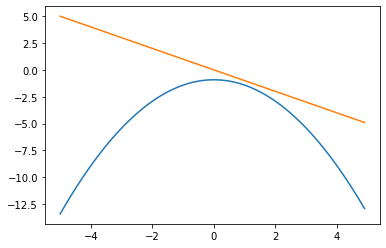

In [ ]:

Q = anp.random.normal(0,1,50)
imq_kernel = Kernel("IMQ",l = 0.7)

# mu = np.array([-2,2],dtype = float)
# sigma = np.repeat(1.0,len(mu))
# alpha = np.array([0.5,0.5],dtype = float)

mu = 0
sigma = 1
alpha = 1
k = 1

kef_model = Mixture_Gaussian(imq_kernel,mu = mu,sigma = sigma,k=k,alpha = alpha)
kef_model.print_model_info()
x = np.arange(-5,5,step = 0.1)
y = [kef_model.compute_model(i,0) for i in x]
z = [kef_model.compute_model(i,1) for i in x]
plt.plot(x,y)
plt.plot(x,z)
plt.show()
m = 20
ksd_res = np.zeros(m)
for i in range(m):
  Q = np.random.normal(i,1,1000)
  ksd_res[i] = kef_model.compute_KSD_with_Q(Q)



In [ ]:

class Kernelized_Exponential_Family:
  def __init__(self,kernel,theta=0,p=0):
    self.model_type = "Kernelized Exponential Family"
    self.kernel = kernel
    self.theta = theta
    self.p = p
    self.diff_model = elementwise_grad(self.model)

  @staticmethod
  def factorial(x):
    result = 1
    for i in range(1,x+1):
      result = result * i
    return result

  def model(self,x): #记得对p取log再求导
    phi = 0
    for i in range(self.p):
      phi += self.theta[i] * x**i/(anp.sqrt(float(self.factorial(i))) * anp.exp(-1*x**2/2))
    b_x = (-1*anp.log(anp.sqrt(2*anp.pi))-1*(x**2/2*9))
    return anp.exp(phi + b_x)#logN(0,3)
    
  def compute_model(self,x_value,if_diff):
    return self.diff_model(x_value) # you don't need to calculate p(x), but only p'(x)
    # if(if_diff == 0): return self.model(x_value)
    # else: return self.diff_model(x_value)


  def h_function(self,x_value,y_value):
    k_obj = self.kernel
    a = np.dot(self.compute_model(x_value,1) , (self.compute_model(y_value,1) * k_obj.compute_kernel(x_value,y_value,0)))
    b = np.dot(self.compute_model(y_value,1),k_obj.compute_kernel(x_value,y_value,1))
    c = np.dot(self.compute_model(y_value,1) , k_obj.compute_kernel(x_value,y_value,2))
    d = k_obj.compute_kernel(x_value,y_value,3)
    hp_xy = a+b+c+d
    return hp_xy

  # U-statistic:
  def compute_KSD_with_Q(self,Q):
    n = Q.shape[0]
    result = 0
    for i in range(n):
      for j in range(n):
        if (i != j):
          result = result + self.h_function(Q[i],Q[j])
    # cal_h_function = lambda x,y: self.h_function(x,y)
    # vfunc = np.vectorize(cal_h_function)
    # result = np.sum(A) - np.diag(A).sum() #加速矩阵求和
    return result/(n*(n-1)) #return a number

  def compute_KSD_with_h_matrix(self,Q,h_matrix):
    n = Q.shape[0]
    res = h_matrix.sum() - np.diag(h_matrix).sum()
    return res/(n*(n-1))

  

# Q = anp.random.normal(3,1,100)
# imq_kernel = Kernel("IMQ",l = 0.7)
# p = 5
# theta = anp.array([1,2,3,4,5],dtype = float)
# kef_model = Kernelized_Exponential_Family(imq_kernel,theta,p)
# kef_model.compute_KSD_with_Q(Q)


In [ ]:
galaxy_data = np.array([9.172,9.350,9.483,9.558,9.775,10.227,10.406,16.084,16.170,18.419,
18.552,18.600,18.927,19.052,19.070,19.330,19.343,19.349,19.440,19.473,
19.529,19.541,19.547,19.663,19.846,19.856,19.863,19.914,19.918,19.973,
19.989,20.166,20.175,20.179,20.196,20.215,20.221,20.415,20.629,20.795,
20.821,20.846,20.875,20.986,21.137,21.492,21.701,21.814,21.921,21.960,
22.185,22.209,22.242,22.249,22.314,22.374,22.495,22.746,22.747,22.888,
22.914,23.206,23.241,23.263,23.484,23.538,23.542,23.666,23.706,23.711,
24.129,24.285,24.289,24.366,24.717,24.990,25.633,26.960,26.995,32.065,
32.789,34.279])

# galaxy_data = (galaxy_data-np.mean(galaxy_data))/(0.5*np.std(galaxy_data))
min_ksd_theta = [[2.895215780130537e-07],
[-7.70763288806006e-06, 1.8721202581490014e-06],
[3.614763403076565e-05, 3.5991936893657248e-06, -3.404469663785114e-06],
[-9.493533448967639e-05, 3.3025087884386295e-05, 8.343893843409944e-06, -3.7691586390886656e-06],
[0.0027952558550623507, 0.00020141587246058634, -0.0004734136204689321, -2.429436080131353e-05, 3.693794201087286e-05]]

# imq_kernel = Kernel("IMQ",l = 0.7)
# P = Kernelized_Exponential_Family(imq_kernel,theta = min_ksd_theta[4], p = 5)
# a = np.arange(3,dtype = float)
# b = a+1
# P.compute_KSD(galaxy_data)

## 3. Minimum KSD Estimator

In [ ]:
class min_ksd_exponential:
  def __init__(self,kernel,txdx,bxdx):
    self.kernel = kernel
    self.txdx = txdx
    self.bxdx = bxdx
    self.p = self.txdx(10.0).shape[0]

  def Lambda_function(self,x_value,y_value):
    kernel = self.kernel
    txdx = self.txdx
    a = kernel.compute_kernel(x_value,y_value,0)
    b = txdx(x_value)
    c = txdx(y_value).T
    d = np.dot(b,c)
    return a * d
  
  def v_function(self,x_value,y_value):
    kernel = self.kernel
    txdx = self.txdx
    bxdx = self.bxdx

    a = kernel.compute_kernel(x_value,y_value,2) * txdx(x_value)
    b = kernel.compute_kernel(x_value,y_value,1) * txdx(y_value)
    # c = txdx(x_value) * kernel.compute_kernel(x_value,y_value,0) * bxdx(y_value)
    # c = np.array([0])
    
    # return a+ b + 2*c
    return a+b
  
  def theta_star(self,R):# ouput is a vector
    p = self.p
    kernel = self.kernel
    v_function = self.v_function
    Lambda_function = self.Lambda_function
    n = R.shape[0] 
    vn = np.zeros(p).reshape(-1,1)
    lambda_n = np.zeros(p*p).reshape(p,p)
    # epsilon = 0.00000000001 * np.eye(p).reshape(p,p)
    epsilon = 0 * np.eye(p).reshape(p,p)

    for i in range(n):
      for j in range(n):
        if (i>j):
          lambda_n = lambda_n + Lambda_function(R[i],R[j]) 
    
    lambda_n = lambda_n * 2
    for i in range(n):
      lambda_n = lambda_n + Lambda_function(R[i],R[i])

    for i in range(n):
      for j in range(n):
        # lambda_n = lambda_n + Lambda_function(R[i],R[j]) 
        vn = vn + v_function(R[i],R[j])
    lambda_n = lambda_n/(n**2)
    lambda_n = np.asarray(lambda_n, dtype=np.float64)
    lambda_n = np.linalg.inv(lambda_n + epsilon) #Add epsilon to Avoid Singular matrix 
    vn = vn/(n**2)
    result = (-0.5) * np.dot(lambda_n,vn)
    return result

  
  #Add some Inverse_parameter_mapping (accoding to different distribution)
  @staticmethod
  def normal_Inverse_parameter_mapping(theta):
    mu = -0.5 * theta[0]/(theta[1])
    sigma = np.sqrt(-0.5/theta[1])
    return np.array([mu,sigma])

  @staticmethod
  def log_normal_Inverse_parameter_mapping(theta):
    mu = -0.5 * theta[0]/(theta[1])
    sigma = np.sqrt(-0.5/theta[1])
    return np.array([mu,sigma])

  @staticmethod
  def gamma_Inverse_parameter_mapping(theta):
    k = theta[0]+1
    theta = -1/theta[1]
    return np.array([k,theta])
  
  @staticmethod
  def normal_with_sigma_Inverse_parameter_mapping(theta,sigma):
    return sigma*theta[1]
  
  @staticmethod
  def beta_Inverse_parameter_mapping(theta):
    alpha = theta[0]+1
    beta = theta[1]+1
    return np.array([alpha,beta])

  @staticmethod
  def laplace_Inverse_parameter_mapping(theta):
    b = -1/theta
    return b

  


### Example and other old code

In [ ]:
#Example
imq_kernel = Kernel("simple_IMQ",l = 0.7)
Q = np.random.normal(0,1,100)

normal_txdx = lambda x: np.array([1,2*x],dtype = float).reshape(-1,1)
normal_bxdx = 0
normal_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = normal_txdx,bxdx = normal_bxdx)
natural_para = normal_min_ksd_estimator.theta_star(Q)
real_para = normal_min_ksd_estimator.normal_Inverse_parameter_mapping(natural_para)


lognormal_txdx = lambda x: np.array([1/x,(2*np.log(x))/x],dtype = float).reshape(-1,1)
lognormal_bxdx = lambda x: 1/x
lognormal_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = lognormal_txdx,bxdx = lognormal_bxdx)
natural_para = lognormal_min_ksd_estimator.theta_star(Q)
real_para = lognormal_min_ksd_estimator.normal_Inverse_parameter_mapping(natural_para)
real_para



array([[-0.05350839],
       [ 0.95850353]])

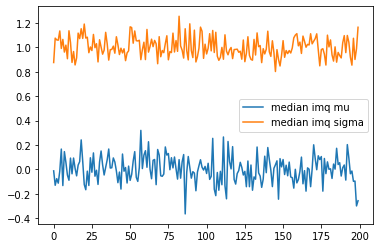

0.0004520245471119344 1.0014783691847169


In [ ]:
# One-dimensional Exponential Family model

# bxdx = 0
# txdx = lambda x: np.array([1,2*x],dtype = float).reshape(-1,1)

# class min_ksd_exponential:
#   def __init__(self)

def Lambda_function(kernel,x_value,y_value):
    txdx = lambda x: np.array([1,2*x],dtype = float).reshape(-1,1)
    a = kernel.compute_kernel(x_value,y_value,0)
    b = txdx(x_value)
    c = txdx(y_value).T
    d = np.dot(b,c)
    return a * d

def v_function(kernel,x_value,y_value):
  txdx = lambda x: np.array([1,2*x],dtype = float).reshape(-1,1)
  a = kernel.compute_kernel(x_value,y_value,2) * txdx(x_value)
  b = kernel.compute_kernel(x_value,y_value,1) * txdx(y_value)
  # c =  # for the case when b(x) != 0
  return a+b

def theta_star(Q,kernel):# ouput is a vector
  n = Q.shape[0] 
  vn = np.zeros(2).reshape(-1,1)
  lambda_n = np.zeros(2*2).reshape(2,2)
  # epsilon = 0.001 * np.eye(2).reshape(2,2)
  epsilon = 0
  for i in range(n):
    for j in range(n):
      lambda_n = lambda_n + Lambda_function(kernel,Q[i],Q[j]) 
      vn = vn + v_function(kernel,Q[i],Q[j])
  lambda_n = lambda_n/(n**2)
  lambda_n = np.asarray(lambda_n, dtype=np.float64)
  lambda_n = np.linalg.inv(lambda_n + epsilon) #Add epsilon to Avoid Singular matrix 
  vn = vn/(n**2)
  # print(lambda_n)
  # print(vn)
  result = (-0.5) * np.dot(lambda_n,vn)
  # print("Finish compute the theta_star")
  # return result.reshape(2,-1).astype(np.float64)
  return result

def Inverse_parameter_mapping(theta):
  mu = -0.5 * theta[0]/(theta[1])
  sigma = np.sqrt(-0.5/theta[1])
  # print("Mean value：",mu, "Standrad Deviation：",sigma)
  return np.array([mu,sigma])







def cal_lambda(Q): # Use median to find the best l
  n = Q.shape[0]
  temp = np.zeros([n,n])
  for i in range(n):
    for j in range(n):
      temp[i,j] = np.sqrt((Q[i]-Q[j])**2)
  return np.median(temp)
  

# Use Median IMQ kernel with different para:Beta
# Q = np.random.normal(4,7,200)
# Lambda = cal_lambda(Q)
# beta = np.arange(start=0.1,stop = 1,step = 0.1)
# def n_cal_para(Q,Lambda,beta):
#   kernel = Kernel("median_IMQ",Lambda = Lambda, beta = beta)
#   theta = theta_star(Q,kernel)
#   return Inverse_parameter_mapping(theta)


def n_cal_para():
  Q = np.random.normal(0,1,100)
  Lambda = cal_lambda(Q)
  kernel = Kernel("median_IMQ",Lambda = Lambda)
  theta = theta_star(Q,kernel)
  return Inverse_parameter_mapping(theta)

n = 200
res = [n_cal_para() for i in range(n)]
res1 = [i[0] for i in res]
res2 = [i[1] for i in res]
n_array = np.arange(n)

plt.plot(n_array,res1,label = 'median imq mu')
plt.plot(n_array,res2,label = 'median imq sigma')
plt.legend()
plt.show()
print(np.mean(res1),np.mean(res2))


# Res = [imq_cal_para(i) for i in l]
# res3 = [i[0] for i in Res]
# res4 = [i[1] for i in Res]

# Use simple IMQ kernel
# l = np.arange(start=0,stop = 3,step = 0.2)
# def imq_cal_para(l):
#   imq_kernel = Kernel("IMQ",l = l)
#   Q = np.random.normal(2.5,3,100)
#   theta = theta_star(Q,imq_kernel)
#   return Inverse_parameter_mapping(theta)


In [ ]:
# Experiment: Relationship between estimation error of sigma and the value of sigma
def n_cal_para(sigma):
  Q = np.random.normal(0,sigma,100)
  Lambda = cal_lambda(Q)
  kernel = Kernel("median_IMQ",Lambda = Lambda)
  theta = theta_star(Q,kernel)
  return Inverse_parameter_mapping(theta)

sigmas = np.arange(start = 0.5,stop = 10,step = 0.5)
m = 50 #experiment times
sigma_result = np.zeros(len(sigmas))
counter = 0
for sigma in sigmas:
  res = 0
  for i in range(m):
    res = res + n_cal_para(sigma)[1]
  sigma_result[counter] = res / m
  counter = counter + 1

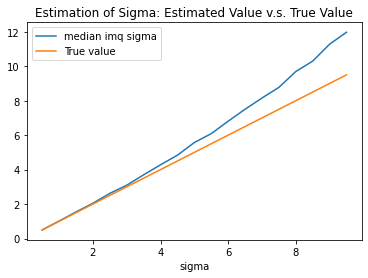

In [ ]:
plt.plot(sigmas,sigma_result,label = 'median imq sigma')
plt.plot(sigmas,sigmas,label = 'True value')
plt.title("Estimation of Sigma: Estimated Value v.s. True Value")
plt.xlabel("sigma")
# plt.ylabel("absolute error")
plt.legend()
plt.show()

In [ ]:
# Kernelized Exponential family Model Setting
b = lambda x: -1*anp.log(float(sqrt(2*anp.pi)))-1*(x**2/2*9)
diff_b = elementwise_grad(b)

def factorial(x):
  result = 1
  for i in range(1,x+1):
    result = result * i
  return result

phi = lambda x,i: x**i/(anp.sqrt(float(factorial(i))) * anp.exp(-1*x**2/2))
diff_phi = elementwise_grad(phi)

def compute_diff_t(x_value,p):#return a px1 vector
  t = np.zeros(p)
  for i in range(p):
    t[i] = diff_phi(x_value,i+1)
  return t.reshape(-1,1)


def Lambda_function(kernel,x_value,y_value,p):
  a = compute_diff_t(x_value,p)
  b = compute_diff_t(y_value,p).reshape(1,-1)
  return kernel.compute_kernel(x_value,y_value,0) * np.dot(a,b)

def v_function(kernel,x_value,y_value,p):
  a = kernel.compute_kernel(x_value,y_value,0) * diff_b(x_value)* compute_diff_t(y_value,p)
  b = compute_diff_t(x_value,p) * kernel.compute_kernel(x_value,y_value,2)
  c = kernel.compute_kernel(x_value,y_value,0) * diff_b(y_value) * compute_diff_t(y_value,p)
  d = compute_diff_t(y_value,p) * kernel.compute_kernel(x_value,y_value,1)
  return a+b+c+d

def theta_star(Q,kernel,p):# ouput is a vector
  n = Q.shape[0] 
  vn = np.zeros(p).reshape(-1,1)
  lambda_n = np.zeros(p*p).reshape(p,p)
  epsilon = 0.001 * np.eye(p).reshape(p,p)
  for i in range(n):
    for j in range(n):
      lambda_n = lambda_n + Lambda_function(kernel,Q[i],Q[j],p)
      vn = vn + v_function(kernel,Q[i],Q[j],p)
  lambda_n = lambda_n/(n**2)
  lambda_n = np.asarray(lambda_n, dtype=np.float64)
  lambda_n = np.linalg.inv(lambda_n + epsilon) #Add epsilon to Avoid Singular matrix 
  vn = vn/(n**2)
  result = (-0.5) * np.dot(lambda_n,vn)
  print("Finish compute the theta_star")
  return result.reshape(p,).astype(np.float64)


In [ ]:
# Experiment：
# p = 25：12min 41sec
# array([-1.42634484e+00,  5.52384008e-01,  5.11955142e-01, -4.91324714e-02,
#        -6.88414387e-02, -1.15430148e-02, -1.98217150e-03, -2.22325919e-03,
#        -1.86488982e-03,  2.89592914e-04,  1.97962046e-03,  1.01917966e-03,
#        -4.60882004e-04, -1.24948547e-04, -9.96850199e-05, -2.85817327e-05,
#         1.05985634e-04, -6.41826964e-05,  1.46012243e-05,  2.06057116e-05,
#        -2.58484874e-05,  3.86674587e-06,  1.39146618e-06, -6.23238861e-07,
#         8.97034417e-07])

## 4. Bootstrap-based Goodness-of-fit test

In [ ]:

#boostrap method from Qiang Liu(2016)
def liu_boostrap(h_matrix,b): #h_matrix: u_q or u_pq, b:number of boostrap sample
  n = h_matrix.shape[0]
  h_matrix = np.array(h_matrix).reshape(n,n)
  delta = np.zeros(b)
  for i in trange(b):
    w_i = (np.random.randint(1,n,n)/n - (1/n)).reshape(-1,1)
    w_j = (np.random.randint(1,n,n)/n - (1/n)).reshape(1,-1)
    w_matrix = np.dot(w_i,w_j)
    temp = w_matrix * h_matrix
    delta[i] = temp.sum() - np.diag(temp).sum()
  return delta


def w_generator(n):
  result = np.zeros(n)
  result[0] = 1
  alpha = 0.5 #parameter of wild-boostrap
  for i in range(1,n):
    u = np.random.uniform(low=0.0, high=1.0, size=None)
    if (u >= alpha):
      result[i] = 1
    else: result[i] = -1
  return result


def wild_bootstrap(Q,b,h_matrix): #b is number of sample
  n = Q.shape[0]
  delta = np.zeros(b)
  # for i in range(b):
  for i in trange(b):
    w_i = w_generator(n)
    w_j = w_generator(n)
    w_matrix = np.matmul(w_i.reshape((-1,1)),w_j.reshape((1,-1)))

    delta[i] =  (1/(n**2)) * np.matrix(np.array(w_matrix) * np.array(h_matrix)).sum() #肯定有问题！！
    # if(i % 10 == 0): print("目前进度：",i/b,)
  return delta
  
def goodness_of_fit_test(P,Q,method,b = 0):# Q are sample Q_n, b is parameter of wild_bootstrap
  n = Q.shape[0]
  h_matrix = np.zeros([n,n])
  for i in range(n):
    for j in range(n):
      h_matrix[i,j] = P.h_function(Q[i],Q[j]) #耗时很长

  if (method == "wild_bootstrap"):
    delta = wild_bootstrap(Q,b,h_matrix)
  elif (method == "liu_bootstrap"):
    delta = liu_boostrap(h_matrix,b)
    c_alpha = n * np.percentile(delta,95)
    
  print("c_alpha = ",c_alpha)
  Delta = P.compute_KSD_with_h_matrix(Q,h_matrix) #Because we already compute h_matrix before, we don't need to re-compute it.
  print("Delta = ", Delta)
  ecdf = ECDF(delta)
  print('P_value: %.3f' % (1-ecdf(Delta)))

  if(Delta >= c_alpha): print("Test result: Reject the Null" )
  else: print("Test result: Accept the Null" )
  return delta

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 5. Relative Goodness-of-fit test

### 5.1 Basic

In [ ]:
#boostrap method from Qiang Liu(2016)
def liu_boostrap(h_matrix,b): #h_matrix: u_q or u_pq, b:number of boostrap sample
  n = h_matrix.shape[0]
  h_matrix = np.array(h_matrix).reshape(n,n)
  delta = np.zeros(b)
  for i in trange(b):
    w_i = (np.random.randint(1,n,n)/n - (1/n)).reshape(-1,1)
    # w_j = (np.random.randint(1,n,n)/n - (1/n)).reshape(1,-1)
    w_j = w_i.reshape(1,-1)
    w_matrix = np.dot(w_i,w_j)
    temp = w_matrix * h_matrix
    delta[i] = temp.sum() - np.diag(temp).sum()
  return delta

def w_generator(n):
  result = np.zeros(n)
  result[0] = 1
  alpha = 0.5 #parameter of wild-boostrap
  for i in range(1,n):
    u = np.random.uniform(low=0.0, high=1.0, size=None)
    if (u >= alpha):
      result[i] = 1
    else: result[i] = -1
  return result


def wild_boostrap(h_matrix,b): #h_matrix: u_q or u_pq, b:number of boostrap sample
  n = h_matrix.shape[0]
  h_matrix = np.array(h_matrix).reshape(n,n)
  delta = np.zeros(b)
  for i in trange(b):
    w_i = w_generator(n)
    # w_j = w_generator(n)
    w_matrix = np.matmul(w_i.reshape((-1,1)),w_i.reshape((1,-1)))
    temp = w_matrix * h_matrix
    delta[i] = temp.sum() - np.diag(temp).sum()
  return delta


def parametric_bootstrap(test,R_n,mu,B):
  imq_kernel = Kernel("simple_IMQ",l = 0.7)
  delta = np.zeros(B)
  n = R_n.shape[0]
  est_para = estimate(mu,R_n,imq_kernel)
  sigma = est_para[1];b = est_para[3]

  for i in trange(B):
    if(test == "error"):
      R_b = np.random.normal(mu,sigma,n)
    elif(test == "power"):
      R_b = np.random.laplace(mu,b,n)
    para = estimate(mu,R_b,imq_kernel)
    model = build_two_model(imq_kernel,para)
    P = model[0]; Q = model[1]
    delta[i] = P.compute_KSD_with_Q(R_b) - Q.compute_KSD_with_Q(R_b)
  return delta





In [ ]:
def boostrap_realtive_test(P,Q,R,method,b,test = "error"):# Q are sample Q_n, b is parameter of wild_bootstrap
  n = R.shape[0]
  h_matrix_1 = P.compute_h_matrix(R);h_matrix_2 = Q.compute_h_matrix(R)
  h_matrix = h_matrix_1 - h_matrix_2

  if(method == "liu_bootstrap"):
    delta = liu_boostrap(h_matrix,b)/(n*(n-1))
  elif (method == "wild_bootstrap"):
    delta = wild_boostrap(h_matrix,b)/(n*(n-1))
  elif (method == "parametric"):
    delta = parametric_bootstrap(test,R,mu,b)
  c_alpha = np.percentile(delta,95)
    
  # print("c_alpha = ",c_alpha)
  ksd_1 = P.compute_KSD_with_h_matirx(h_matrix_1) #Because we already compute h_matrix before, we don't need to re-compute it.
  ksd_2 = Q.compute_KSD_with_h_matirx(h_matrix_2)
  # print("KSD_1:",ksd_1, "KSD_2:",ksd_2)
  # test_stat = np.abs(ksd_1) - np.abs(ksd_2)
  test_stat = ksd_1 - ksd_2
  # print("Test Statistics = ", test_stat)
  ecdf = ECDF(delta)
  # print('P_value: %.3f' % (1-ecdf(test_stat)))

  if(test_stat >= c_alpha): print("Test result: Reject the Null" )
  else: print("Test result: Accept the Null" )
  return test_stat >= c_alpha

In [ ]:
# def jackknife(h_matrix):
#   n = h_matrix.shape[0]
#   res = 0
#   u_n = 1/(n*(n-1)) * (np.sum(h_matrix) - np.sum(np.diag(h_matrix)))
#   for i in range(n):
#     u_k = 1/((n-1)*(n-2)) * ( (np.sum(h_matrix) - np.sum(np.diag(h_matrix))) - np.apply_along_axis(sum,1,h_matrix)[i] - np.apply_along_axis(sum,0,h_matrix)[i] + h_matrix[i,i] )
#     res = res + (u_n - u_k)**2
#   return (n-1)*res

# def relative_test(P,Q,R):
#   n = R.shape[0]
#   h_matrix_1 = P.compute_h_matrix(R);h_matrix_2 = Q.compute_h_matrix(R)
#   h_matrix = h_matrix_1 - h_matrix_2
#   ksd_1 = P.compute_KSD_with_h_matirx(h_matrix_1);ksd_2 = Q.compute_KSD_with_h_matirx(h_matrix_2)
#   print("KSD(P||R):",ksd_1,"KSD(Q||R):",ksd_2)
#   u_pq = 1/(n*(n-1)) * ( np.sum(h_matrix) - np.sum(np.diag(h_matrix)) )
#   # u_pq = np.abs(ksd_1) - np.abs(ksd_2)
#   print("u_pq: ",u_pq)
#   jackknife_sigma = np.sqrt(jackknife(h_matrix))
#   print("Estimate Sigma: ",jackknife_sigma)
#   test_stat = np.sqrt(n) * u_pq/jackknife_sigma
#   print("test_stat: ",test_stat)
#   print("================================","\n")

#   p_value = 1 - norm.cdf(x=test_stat, loc=0, scale=1)
#   print(p_value)
#   if (test_stat >= norm.ppf(q=0.95, loc=0, scale=1)): print("Reject the Hypothesis ","P-value = ",p_value)
#   else: print("Accept the Hypothesis ","P-value = ",p_value)
#   return [test_stat >= norm.ppf(q=0.95, loc=0, scale=1),test_stat,p_value]

  

### Normal v.s. Laplce

In [ ]:
def normal_pdf(x,u,sig):
  return np.exp(-(x - u) ** 2 / (2 * sig ** 2)) / (math.sqrt(2*math.pi)*sig)

def laplace_pdf(x,u,b):
  return 1/(2*b) * anp.exp(-1*anp.abs(x-u)/b)

def plot_normal(R_n,u,sig,label):
  x = np.linspace(np.min(R_n), np.max(R_n), 50);
  y = [normal_pdf(i,u,sig) for i in x]
  plt.plot(x, y, linewidth=2,label = label)
  plt.hist(R_n,color = "lightgrey", ec="grey",density = True)
  plt.legend()

def plot_laplace(R_n,u,b,label):
  x = np.linspace(np.min(R_n), np.max(R_n), 50);
  y = [laplace_pdf(i,u,b) for i in x]
  plt.plot(x, y, linewidth=2,label = label) 
  plt.hist(R_n,color = "lightgrey", ec="grey",density = True)
  plt.legend()

In [ ]:
def estimate(mu,R_n,kernel):

  normal_txdx = lambda x: np.array([1,2*x],dtype = float).reshape(-1,1)
  normal_bxdx = lambda x: np.array([0])
  normal_min_ksd_estimator = min_ksd_exponential(kernel = kernel, txdx = normal_txdx,bxdx = normal_bxdx)
  natural_para = normal_min_ksd_estimator.theta_star(R_n)
  normal_para = normal_min_ksd_estimator.normal_Inverse_parameter_mapping(natural_para)
  normal_mu = mu; normal_sigma = normal_para[1];
  print("Estimation of Normal","Sigma:",normal_sigma) 

  laplace_txdx = lambda x: np.array([1]) if x>= mu else np.array([-1])
  laplace_bxdx = lambda x: np.array([0])
  laplace_min_ksd_estimator = min_ksd_exponential(kernel = kernel, txdx = laplace_txdx,bxdx = laplace_bxdx)
  laplace_natural_para = laplace_min_ksd_estimator.theta_star(R_n)[0]
  laplace_sigma = laplace_min_ksd_estimator.laplace_Inverse_parameter_mapping(laplace_natural_para)
  laplace_mean = mu;
  print("Estimation of Laplace b:" , laplace_sigma,"\n") 

  return [mu,normal_sigma,mu,laplace_sigma]


def plot_normal_laplace(R_n,true_para,para,null):
  est_mu = para[0]; est_sigma = para[1]; est_mu = para[2]; est_b = para[3]
  plt.hist(R_n,color = "lightgrey", ec="grey",density = True,label = "X_n")
  if (null == "normal"):
    mu = true_para[0];sigma = true_para[1]
    plot_normal(R_n,mu,sigma,"Truth Normal")
    plot_normal(R_n,mu,est_sigma,"Normal estimate")
    plot_laplace(R_n,mu,est_b,"Laplace estimate") 
  elif (null == "laplace"):
    mu = true_para[0];b = true_para[1]
    plot_laplace(R_n,mu,b,"Truth Laplace")
    plot_laplace(R_n,mu,est_b,"Laplace estimate")
    plot_normal(R_n,mu,est_sigma,"Normal estimate")

def build_two_model(kernel,para):
  model_1 = Exponential_Family(model_name= "normal",kernel = kernel,mu=para[0],sigma=para[1])
  model_2 = Exponential_Family(model_name = "laplace",kernel = kernel,mu=para[0],b=para[3])
  
  print(model_1)
  print(model_2)
  return [model_1,model_2]


In [ ]:
#parametric Bootstrap

m = 20; n = 20
res = np.zeros(m)
for i in range(m):
  imq_kernel = Kernel("simple_IMQ",l = 0.7)
  mu = 3;sigma = 1;b = 1
  # R_n = np.random.normal(mu,sigma,n)
  # print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is true, Gaussian model better")
  R_n = np.random.laplace(mu,b,n)
  # print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is false, Laplace model better")

  para = estimate(mu,R_n,imq_kernel)
  # plot_normal_laplace(R_n,[mu,sigma],para,"normal")
  # plot_normal_laplace(R_n,[mu,b],para,"laplace")

  model = build_two_model(imq_kernel,para)
  res[i] = boostrap_realtive_test(model[0],model[1],R_n,method = 'parametric',test = "power",b = 200)
  f'The result of {i } experiement: {res[i]}'
  # a = boostrap_realtive_test(model[0],model[1],R_n,method = "liu_bootstrap",b = 5000)
  # relative_test(model[0],model[1],R_n)
  # plt.savefig("exp1_laplace.eps",dpi=1000)
  # files.download('exp1_laplace.eps') 
  # plt.show()

f'The type I error: {np.sum(res)/m}'


Estimation of Normal Sigma: [1.52858191]
Estimation of Laplace b: [1.5892147] 

Model Type: normal Mean: 3 Sigma: [1.52858191]
Model Type: laplace mu: 3 b: [1.5892147]
Estimation of Normal Sigma: [1.52858191]
Estimation of Laplace b: [1.5892147] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [3.69602435]
Estimation of Laplace b: [3.59792411] 

Model Type: normal Mean: 3 Sigma: [3.69602435]
Model Type: laplace mu: 3 b: [3.59792411]


  0%|          | 1/200 [00:00<01:35,  2.09it/s]

Estimation of Normal Sigma: [1.21891333]
Estimation of Laplace b: [1.57414006] 

Model Type: normal Mean: 3 Sigma: [1.21891333]
Model Type: laplace mu: 3 b: [1.57414006]


  1%|          | 2/200 [00:00<01:34,  2.10it/s]

Estimation of Normal Sigma: [2.32126478]
Estimation of Laplace b: [2.34408217] 

Model Type: normal Mean: 3 Sigma: [2.32126478]
Model Type: laplace mu: 3 b: [2.34408217]


  2%|▏         | 3/200 [00:01<01:33,  2.11it/s]

Estimation of Normal Sigma: [2.40313109]
Estimation of Laplace b: [3.01151068] 

Model Type: normal Mean: 3 Sigma: [2.40313109]
Model Type: laplace mu: 3 b: [3.01151068]


  2%|▏         | 4/200 [00:01<01:33,  2.11it/s]

Estimation of Normal Sigma: [2.1176599]
Estimation of Laplace b: [6.992591] 

Model Type: normal Mean: 3 Sigma: [2.1176599]
Model Type: laplace mu: 3 b: [6.992591]


  2%|▎         | 5/200 [00:02<01:32,  2.10it/s]

Estimation of Normal Sigma: [1.65391569]
Estimation of Laplace b: [1.44195401] 

Model Type: normal Mean: 3 Sigma: [1.65391569]
Model Type: laplace mu: 3 b: [1.44195401]


  3%|▎         | 6/200 [00:02<01:32,  2.10it/s]

Estimation of Normal Sigma: [1.95661829]
Estimation of Laplace b: [2.75391255] 

Model Type: normal Mean: 3 Sigma: [1.95661829]
Model Type: laplace mu: 3 b: [2.75391255]


  4%|▎         | 7/200 [00:03<01:32,  2.09it/s]

Estimation of Normal Sigma: [1.79566488]
Estimation of Laplace b: [1.36507217] 

Model Type: normal Mean: 3 Sigma: [1.79566488]
Model Type: laplace mu: 3 b: [1.36507217]


  4%|▍         | 8/200 [00:03<01:31,  2.10it/s]

Estimation of Normal Sigma: [1.22271116]
Estimation of Laplace b: [1.45331135] 

Model Type: normal Mean: 3 Sigma: [1.22271116]
Model Type: laplace mu: 3 b: [1.45331135]


  4%|▍         | 9/200 [00:04<01:30,  2.10it/s]

Estimation of Normal Sigma: [2.09149623]
Estimation of Laplace b: [1.54779211] 

Model Type: normal Mean: 3 Sigma: [2.09149623]
Model Type: laplace mu: 3 b: [1.54779211]


  5%|▌         | 10/200 [00:04<01:30,  2.11it/s]

Estimation of Normal Sigma: [2.46311293]
Estimation of Laplace b: [3.56202062] 

Model Type: normal Mean: 3 Sigma: [2.46311293]
Model Type: laplace mu: 3 b: [3.56202062]


  6%|▌         | 11/200 [00:05<01:29,  2.11it/s]

Estimation of Normal Sigma: [1.575219]
Estimation of Laplace b: [1.80333186] 

Model Type: normal Mean: 3 Sigma: [1.575219]
Model Type: laplace mu: 3 b: [1.80333186]


  6%|▌         | 12/200 [00:05<01:28,  2.12it/s]

Estimation of Normal Sigma: [2.12888856]
Estimation of Laplace b: [1.80356381] 

Model Type: normal Mean: 3 Sigma: [2.12888856]
Model Type: laplace mu: 3 b: [1.80356381]


  6%|▋         | 13/200 [00:06<01:29,  2.09it/s]

Estimation of Normal Sigma: [2.48252789]
Estimation of Laplace b: [2.4175241] 

Model Type: normal Mean: 3 Sigma: [2.48252789]
Model Type: laplace mu: 3 b: [2.4175241]


  7%|▋         | 14/200 [00:06<01:28,  2.09it/s]

Estimation of Normal Sigma: [1.53570154]
Estimation of Laplace b: [2.05280519] 

Model Type: normal Mean: 3 Sigma: [1.53570154]
Model Type: laplace mu: 3 b: [2.05280519]


  8%|▊         | 15/200 [00:07<01:28,  2.08it/s]

Estimation of Normal Sigma: [2.0355975]
Estimation of Laplace b: [3.59929703] 

Model Type: normal Mean: 3 Sigma: [2.0355975]
Model Type: laplace mu: 3 b: [3.59929703]


  8%|▊         | 16/200 [00:07<01:29,  2.05it/s]

Estimation of Normal Sigma: [1.6839402]
Estimation of Laplace b: [2.06200482] 

Model Type: normal Mean: 3 Sigma: [1.6839402]
Model Type: laplace mu: 3 b: [2.06200482]


  8%|▊         | 17/200 [00:08<01:29,  2.05it/s]

Estimation of Normal Sigma: [2.59484742]
Estimation of Laplace b: [3.70617281] 

Model Type: normal Mean: 3 Sigma: [2.59484742]
Model Type: laplace mu: 3 b: [3.70617281]


  9%|▉         | 18/200 [00:08<01:30,  2.00it/s]

Estimation of Normal Sigma: [1.89033256]
Estimation of Laplace b: [1.61002382] 

Model Type: normal Mean: 3 Sigma: [1.89033256]
Model Type: laplace mu: 3 b: [1.61002382]


 10%|▉         | 19/200 [00:09<01:28,  2.04it/s]

Estimation of Normal Sigma: [1.97845994]
Estimation of Laplace b: [0.96784717] 

Model Type: normal Mean: 3 Sigma: [1.97845994]
Model Type: laplace mu: 3 b: [0.96784717]


 10%|█         | 20/200 [00:09<01:27,  2.07it/s]

Estimation of Normal Sigma: [2.02785348]
Estimation of Laplace b: [1.63358956] 

Model Type: normal Mean: 3 Sigma: [2.02785348]
Model Type: laplace mu: 3 b: [1.63358956]


 10%|█         | 21/200 [00:10<01:25,  2.09it/s]

Estimation of Normal Sigma: [1.30781115]
Estimation of Laplace b: [1.6047175] 

Model Type: normal Mean: 3 Sigma: [1.30781115]
Model Type: laplace mu: 3 b: [1.6047175]


 11%|█         | 22/200 [00:10<01:24,  2.09it/s]

Estimation of Normal Sigma: [2.69387212]
Estimation of Laplace b: [2.75247163] 

Model Type: normal Mean: 3 Sigma: [2.69387212]
Model Type: laplace mu: 3 b: [2.75247163]


 12%|█▏        | 23/200 [00:11<01:24,  2.10it/s]

Estimation of Normal Sigma: [2.21386792]
Estimation of Laplace b: [2.02596222] 

Model Type: normal Mean: 3 Sigma: [2.21386792]
Model Type: laplace mu: 3 b: [2.02596222]


 12%|█▏        | 24/200 [00:11<01:24,  2.09it/s]

Estimation of Normal Sigma: [2.05877995]
Estimation of Laplace b: [2.30591532] 

Model Type: normal Mean: 3 Sigma: [2.05877995]
Model Type: laplace mu: 3 b: [2.30591532]


 12%|█▎        | 25/200 [00:11<01:23,  2.10it/s]

Estimation of Normal Sigma: [2.11497653]
Estimation of Laplace b: [1.86797434] 

Model Type: normal Mean: 3 Sigma: [2.11497653]
Model Type: laplace mu: 3 b: [1.86797434]


 13%|█▎        | 26/200 [00:12<01:22,  2.10it/s]

Estimation of Normal Sigma: [2.28599433]
Estimation of Laplace b: [4.26730785] 

Model Type: normal Mean: 3 Sigma: [2.28599433]
Model Type: laplace mu: 3 b: [4.26730785]


 14%|█▎        | 27/200 [00:12<01:22,  2.10it/s]

Estimation of Normal Sigma: [2.2082251]
Estimation of Laplace b: [3.37319461] 

Model Type: normal Mean: 3 Sigma: [2.2082251]
Model Type: laplace mu: 3 b: [3.37319461]


 14%|█▍        | 28/200 [00:13<01:21,  2.11it/s]

Estimation of Normal Sigma: [2.41234571]
Estimation of Laplace b: [1.50106074] 

Model Type: normal Mean: 3 Sigma: [2.41234571]
Model Type: laplace mu: 3 b: [1.50106074]


 14%|█▍        | 29/200 [00:13<01:21,  2.10it/s]

Estimation of Normal Sigma: [2.54034734]
Estimation of Laplace b: [2.65041674] 

Model Type: normal Mean: 3 Sigma: [2.54034734]
Model Type: laplace mu: 3 b: [2.65041674]


 15%|█▌        | 30/200 [00:14<01:21,  2.10it/s]

Estimation of Normal Sigma: [2.78583158]
Estimation of Laplace b: [8.72834253] 

Model Type: normal Mean: 3 Sigma: [2.78583158]
Model Type: laplace mu: 3 b: [8.72834253]


 16%|█▌        | 31/200 [00:14<01:20,  2.10it/s]

Estimation of Normal Sigma: [2.67813907]
Estimation of Laplace b: [2.61609756] 

Model Type: normal Mean: 3 Sigma: [2.67813907]
Model Type: laplace mu: 3 b: [2.61609756]


 16%|█▌        | 32/200 [00:15<01:20,  2.10it/s]

Estimation of Normal Sigma: [1.85551914]
Estimation of Laplace b: [2.23562967] 

Model Type: normal Mean: 3 Sigma: [1.85551914]
Model Type: laplace mu: 3 b: [2.23562967]


 16%|█▋        | 33/200 [00:15<01:19,  2.10it/s]

Estimation of Normal Sigma: [2.15185685]
Estimation of Laplace b: [1.96847413] 

Model Type: normal Mean: 3 Sigma: [2.15185685]
Model Type: laplace mu: 3 b: [1.96847413]


 17%|█▋        | 34/200 [00:16<01:19,  2.10it/s]

Estimation of Normal Sigma: [1.97690699]
Estimation of Laplace b: [1.36545937] 

Model Type: normal Mean: 3 Sigma: [1.97690699]
Model Type: laplace mu: 3 b: [1.36545937]


 18%|█▊        | 35/200 [00:16<01:18,  2.10it/s]

Estimation of Normal Sigma: [1.28924705]
Estimation of Laplace b: [1.10659819] 

Model Type: normal Mean: 3 Sigma: [1.28924705]
Model Type: laplace mu: 3 b: [1.10659819]


 18%|█▊        | 36/200 [00:17<01:17,  2.10it/s]

Estimation of Normal Sigma: [2.81441198]
Estimation of Laplace b: [2.94169472] 

Model Type: normal Mean: 3 Sigma: [2.81441198]
Model Type: laplace mu: 3 b: [2.94169472]


 18%|█▊        | 37/200 [00:17<01:17,  2.10it/s]

Estimation of Normal Sigma: [1.82713751]
Estimation of Laplace b: [2.29496991] 

Model Type: normal Mean: 3 Sigma: [1.82713751]
Model Type: laplace mu: 3 b: [2.29496991]


 19%|█▉        | 38/200 [00:18<01:17,  2.10it/s]

Estimation of Normal Sigma: [2.33570464]
Estimation of Laplace b: [3.08335681] 

Model Type: normal Mean: 3 Sigma: [2.33570464]
Model Type: laplace mu: 3 b: [3.08335681]


 20%|█▉        | 39/200 [00:18<01:17,  2.09it/s]

Estimation of Normal Sigma: [2.34423057]
Estimation of Laplace b: [2.53130451] 

Model Type: normal Mean: 3 Sigma: [2.34423057]
Model Type: laplace mu: 3 b: [2.53130451]


 20%|██        | 40/200 [00:19<01:16,  2.09it/s]

Estimation of Normal Sigma: [1.26198981]
Estimation of Laplace b: [1.28342644] 

Model Type: normal Mean: 3 Sigma: [1.26198981]
Model Type: laplace mu: 3 b: [1.28342644]


 20%|██        | 41/200 [00:19<01:16,  2.07it/s]

Estimation of Normal Sigma: [1.69747729]
Estimation of Laplace b: [2.22575361] 

Model Type: normal Mean: 3 Sigma: [1.69747729]
Model Type: laplace mu: 3 b: [2.22575361]


 21%|██        | 42/200 [00:20<01:15,  2.08it/s]

Estimation of Normal Sigma: [3.65828351]
Estimation of Laplace b: [3.70528417] 

Model Type: normal Mean: 3 Sigma: [3.65828351]
Model Type: laplace mu: 3 b: [3.70528417]


 22%|██▏       | 43/200 [00:20<01:15,  2.09it/s]

Estimation of Normal Sigma: [2.10321818]
Estimation of Laplace b: [1.67796347] 

Model Type: normal Mean: 3 Sigma: [2.10321818]
Model Type: laplace mu: 3 b: [1.67796347]


 22%|██▏       | 44/200 [00:21<01:14,  2.10it/s]

Estimation of Normal Sigma: [1.91124533]
Estimation of Laplace b: [2.02643903] 

Model Type: normal Mean: 3 Sigma: [1.91124533]
Model Type: laplace mu: 3 b: [2.02643903]


 22%|██▎       | 45/200 [00:21<01:13,  2.10it/s]

Estimation of Normal Sigma: [1.60116818]
Estimation of Laplace b: [0.95603334] 

Model Type: normal Mean: 3 Sigma: [1.60116818]
Model Type: laplace mu: 3 b: [0.95603334]


 23%|██▎       | 46/200 [00:21<01:13,  2.11it/s]

Estimation of Normal Sigma: [1.9128739]
Estimation of Laplace b: [2.84304234] 

Model Type: normal Mean: 3 Sigma: [1.9128739]
Model Type: laplace mu: 3 b: [2.84304234]


 24%|██▎       | 47/200 [00:22<01:12,  2.11it/s]

Estimation of Normal Sigma: [2.50858386]
Estimation of Laplace b: [2.53105984] 

Model Type: normal Mean: 3 Sigma: [2.50858386]
Model Type: laplace mu: 3 b: [2.53105984]


 24%|██▍       | 48/200 [00:22<01:12,  2.11it/s]

Estimation of Normal Sigma: [2.13623092]
Estimation of Laplace b: [0.89257778] 

Model Type: normal Mean: 3 Sigma: [2.13623092]
Model Type: laplace mu: 3 b: [0.89257778]


 24%|██▍       | 49/200 [00:23<01:11,  2.11it/s]

Estimation of Normal Sigma: [2.55753166]
Estimation of Laplace b: [3.69947753] 

Model Type: normal Mean: 3 Sigma: [2.55753166]
Model Type: laplace mu: 3 b: [3.69947753]


 25%|██▌       | 50/200 [00:23<01:11,  2.11it/s]

Estimation of Normal Sigma: [1.28726687]
Estimation of Laplace b: [1.16789366] 

Model Type: normal Mean: 3 Sigma: [1.28726687]
Model Type: laplace mu: 3 b: [1.16789366]


 26%|██▌       | 51/200 [00:24<01:10,  2.11it/s]

Estimation of Normal Sigma: [2.24016218]
Estimation of Laplace b: [2.2454954] 

Model Type: normal Mean: 3 Sigma: [2.24016218]
Model Type: laplace mu: 3 b: [2.2454954]


 26%|██▌       | 52/200 [00:24<01:09,  2.12it/s]

Estimation of Normal Sigma: [2.5766995]
Estimation of Laplace b: [3.9518171] 

Model Type: normal Mean: 3 Sigma: [2.5766995]
Model Type: laplace mu: 3 b: [3.9518171]


 26%|██▋       | 53/200 [00:25<01:09,  2.12it/s]

Estimation of Normal Sigma: [1.91230383]
Estimation of Laplace b: [1.66194207] 

Model Type: normal Mean: 3 Sigma: [1.91230383]
Model Type: laplace mu: 3 b: [1.66194207]


 27%|██▋       | 54/200 [00:25<01:09,  2.11it/s]

Estimation of Normal Sigma: [1.43096379]
Estimation of Laplace b: [1.20876755] 

Model Type: normal Mean: 3 Sigma: [1.43096379]
Model Type: laplace mu: 3 b: [1.20876755]


 28%|██▊       | 55/200 [00:26<01:08,  2.11it/s]

Estimation of Normal Sigma: [1.19218339]
Estimation of Laplace b: [1.84181204] 

Model Type: normal Mean: 3 Sigma: [1.19218339]
Model Type: laplace mu: 3 b: [1.84181204]


 28%|██▊       | 56/200 [00:26<01:08,  2.09it/s]

Estimation of Normal Sigma: [2.40611828]
Estimation of Laplace b: [1.40823935] 

Model Type: normal Mean: 3 Sigma: [2.40611828]
Model Type: laplace mu: 3 b: [1.40823935]


 28%|██▊       | 57/200 [00:27<01:08,  2.10it/s]

Estimation of Normal Sigma: [2.88071836]
Estimation of Laplace b: [4.55033402] 

Model Type: normal Mean: 3 Sigma: [2.88071836]
Model Type: laplace mu: 3 b: [4.55033402]


 29%|██▉       | 58/200 [00:27<01:07,  2.10it/s]

Estimation of Normal Sigma: [1.43767553]
Estimation of Laplace b: [1.35272877] 

Model Type: normal Mean: 3 Sigma: [1.43767553]
Model Type: laplace mu: 3 b: [1.35272877]


 30%|██▉       | 59/200 [00:28<01:07,  2.10it/s]

Estimation of Normal Sigma: [2.46731925]
Estimation of Laplace b: [3.80304696] 

Model Type: normal Mean: 3 Sigma: [2.46731925]
Model Type: laplace mu: 3 b: [3.80304696]


 30%|███       | 60/200 [00:28<01:07,  2.09it/s]

Estimation of Normal Sigma: [1.81022917]
Estimation of Laplace b: [1.75192977] 

Model Type: normal Mean: 3 Sigma: [1.81022917]
Model Type: laplace mu: 3 b: [1.75192977]


 30%|███       | 61/200 [00:29<01:06,  2.09it/s]

Estimation of Normal Sigma: [2.86220556]
Estimation of Laplace b: [5.17098952] 

Model Type: normal Mean: 3 Sigma: [2.86220556]
Model Type: laplace mu: 3 b: [5.17098952]


 31%|███       | 62/200 [00:29<01:06,  2.09it/s]

Estimation of Normal Sigma: [2.02389551]
Estimation of Laplace b: [2.3759671] 

Model Type: normal Mean: 3 Sigma: [2.02389551]
Model Type: laplace mu: 3 b: [2.3759671]


 32%|███▏      | 63/200 [00:30<01:05,  2.08it/s]

Estimation of Normal Sigma: [1.63862879]
Estimation of Laplace b: [1.3896643] 

Model Type: normal Mean: 3 Sigma: [1.63862879]
Model Type: laplace mu: 3 b: [1.3896643]


 32%|███▏      | 64/200 [00:30<01:05,  2.09it/s]

Estimation of Normal Sigma: [2.19847462]
Estimation of Laplace b: [1.62232943] 

Model Type: normal Mean: 3 Sigma: [2.19847462]
Model Type: laplace mu: 3 b: [1.62232943]


 32%|███▎      | 65/200 [00:31<01:04,  2.09it/s]

Estimation of Normal Sigma: [2.22547636]
Estimation of Laplace b: [4.70059463] 

Model Type: normal Mean: 3 Sigma: [2.22547636]
Model Type: laplace mu: 3 b: [4.70059463]


 33%|███▎      | 66/200 [00:31<01:04,  2.09it/s]

Estimation of Normal Sigma: [2.46514436]
Estimation of Laplace b: [4.28141612] 

Model Type: normal Mean: 3 Sigma: [2.46514436]
Model Type: laplace mu: 3 b: [4.28141612]


 34%|███▎      | 67/200 [00:32<01:03,  2.09it/s]

Estimation of Normal Sigma: [2.19945529]
Estimation of Laplace b: [1.56011924] 

Model Type: normal Mean: 3 Sigma: [2.19945529]
Model Type: laplace mu: 3 b: [1.56011924]


 34%|███▍      | 68/200 [00:32<01:03,  2.09it/s]

Estimation of Normal Sigma: [1.71362747]
Estimation of Laplace b: [1.52209685] 

Model Type: normal Mean: 3 Sigma: [1.71362747]
Model Type: laplace mu: 3 b: [1.52209685]


 34%|███▍      | 69/200 [00:32<01:02,  2.09it/s]

Estimation of Normal Sigma: [2.5557374]
Estimation of Laplace b: [2.10791414] 

Model Type: normal Mean: 3 Sigma: [2.5557374]
Model Type: laplace mu: 3 b: [2.10791414]


 35%|███▌      | 70/200 [00:33<01:02,  2.09it/s]

Estimation of Normal Sigma: [1.86852344]
Estimation of Laplace b: [2.08803941] 

Model Type: normal Mean: 3 Sigma: [1.86852344]
Model Type: laplace mu: 3 b: [2.08803941]


 36%|███▌      | 71/200 [00:33<01:02,  2.08it/s]

Estimation of Normal Sigma: [2.58578208]
Estimation of Laplace b: [2.66222399] 

Model Type: normal Mean: 3 Sigma: [2.58578208]
Model Type: laplace mu: 3 b: [2.66222399]


 36%|███▌      | 72/200 [00:34<01:01,  2.07it/s]

Estimation of Normal Sigma: [2.48528015]
Estimation of Laplace b: [4.45033724] 

Model Type: normal Mean: 3 Sigma: [2.48528015]
Model Type: laplace mu: 3 b: [4.45033724]


 36%|███▋      | 73/200 [00:34<01:01,  2.07it/s]

Estimation of Normal Sigma: [2.30746298]
Estimation of Laplace b: [2.71489303] 

Model Type: normal Mean: 3 Sigma: [2.30746298]
Model Type: laplace mu: 3 b: [2.71489303]


 37%|███▋      | 74/200 [00:35<01:00,  2.07it/s]

Estimation of Normal Sigma: [1.4709996]
Estimation of Laplace b: [6.67490884] 

Model Type: normal Mean: 3 Sigma: [1.4709996]
Model Type: laplace mu: 3 b: [6.67490884]


 38%|███▊      | 75/200 [00:35<01:00,  2.08it/s]

Estimation of Normal Sigma: [1.85768419]
Estimation of Laplace b: [1.98356216] 

Model Type: normal Mean: 3 Sigma: [1.85768419]
Model Type: laplace mu: 3 b: [1.98356216]


 38%|███▊      | 76/200 [00:36<00:59,  2.08it/s]

Estimation of Normal Sigma: [3.02699797]
Estimation of Laplace b: [2.05878651] 

Model Type: normal Mean: 3 Sigma: [3.02699797]
Model Type: laplace mu: 3 b: [2.05878651]


 38%|███▊      | 77/200 [00:36<00:59,  2.07it/s]

Estimation of Normal Sigma: [1.74545139]
Estimation of Laplace b: [1.82279462] 

Model Type: normal Mean: 3 Sigma: [1.74545139]
Model Type: laplace mu: 3 b: [1.82279462]


 39%|███▉      | 78/200 [00:37<00:58,  2.07it/s]

Estimation of Normal Sigma: [1.99894973]
Estimation of Laplace b: [2.14858873] 

Model Type: normal Mean: 3 Sigma: [1.99894973]
Model Type: laplace mu: 3 b: [2.14858873]


 40%|███▉      | 79/200 [00:37<00:58,  2.08it/s]

Estimation of Normal Sigma: [1.88242408]
Estimation of Laplace b: [2.33846058] 

Model Type: normal Mean: 3 Sigma: [1.88242408]
Model Type: laplace mu: 3 b: [2.33846058]


 40%|████      | 80/200 [00:38<00:58,  2.06it/s]

Estimation of Normal Sigma: [2.19056668]
Estimation of Laplace b: [2.04948499] 

Model Type: normal Mean: 3 Sigma: [2.19056668]
Model Type: laplace mu: 3 b: [2.04948499]


 40%|████      | 81/200 [00:38<00:57,  2.08it/s]

Estimation of Normal Sigma: [2.01951388]
Estimation of Laplace b: [2.32019114] 

Model Type: normal Mean: 3 Sigma: [2.01951388]
Model Type: laplace mu: 3 b: [2.32019114]


 41%|████      | 82/200 [00:39<00:56,  2.09it/s]

Estimation of Normal Sigma: [1.37604407]
Estimation of Laplace b: [1.60502978] 

Model Type: normal Mean: 3 Sigma: [1.37604407]
Model Type: laplace mu: 3 b: [1.60502978]


 42%|████▏     | 83/200 [00:39<00:56,  2.09it/s]

Estimation of Normal Sigma: [2.37325378]
Estimation of Laplace b: [4.71296167] 

Model Type: normal Mean: 3 Sigma: [2.37325378]
Model Type: laplace mu: 3 b: [4.71296167]


 42%|████▏     | 84/200 [00:40<00:55,  2.09it/s]

Estimation of Normal Sigma: [3.16174399]
Estimation of Laplace b: [3.2496835] 

Model Type: normal Mean: 3 Sigma: [3.16174399]
Model Type: laplace mu: 3 b: [3.2496835]


 42%|████▎     | 85/200 [00:40<00:54,  2.11it/s]

Estimation of Normal Sigma: [3.19672795]
Estimation of Laplace b: [6.49173745] 

Model Type: normal Mean: 3 Sigma: [3.19672795]
Model Type: laplace mu: 3 b: [6.49173745]


 43%|████▎     | 86/200 [00:41<00:54,  2.10it/s]

Estimation of Normal Sigma: [2.68027808]
Estimation of Laplace b: [3.36495001] 

Model Type: normal Mean: 3 Sigma: [2.68027808]
Model Type: laplace mu: 3 b: [3.36495001]


 44%|████▎     | 87/200 [00:41<00:53,  2.10it/s]

Estimation of Normal Sigma: [2.14773034]
Estimation of Laplace b: [2.384191] 

Model Type: normal Mean: 3 Sigma: [2.14773034]
Model Type: laplace mu: 3 b: [2.384191]


 44%|████▍     | 88/200 [00:42<00:53,  2.11it/s]

Estimation of Normal Sigma: [1.85035869]
Estimation of Laplace b: [1.8650019] 

Model Type: normal Mean: 3 Sigma: [1.85035869]
Model Type: laplace mu: 3 b: [1.8650019]


 44%|████▍     | 89/200 [00:42<00:52,  2.11it/s]

Estimation of Normal Sigma: [2.83723176]
Estimation of Laplace b: [1.94314315] 

Model Type: normal Mean: 3 Sigma: [2.83723176]
Model Type: laplace mu: 3 b: [1.94314315]


 45%|████▌     | 90/200 [00:43<00:52,  2.11it/s]

Estimation of Normal Sigma: [2.10382053]
Estimation of Laplace b: [1.44800351] 

Model Type: normal Mean: 3 Sigma: [2.10382053]
Model Type: laplace mu: 3 b: [1.44800351]


 46%|████▌     | 91/200 [00:43<00:51,  2.12it/s]

Estimation of Normal Sigma: [2.03324531]
Estimation of Laplace b: [6.7349472] 

Model Type: normal Mean: 3 Sigma: [2.03324531]
Model Type: laplace mu: 3 b: [6.7349472]


 46%|████▌     | 92/200 [00:43<00:50,  2.13it/s]

Estimation of Normal Sigma: [2.3469577]
Estimation of Laplace b: [3.31367027] 

Model Type: normal Mean: 3 Sigma: [2.3469577]
Model Type: laplace mu: 3 b: [3.31367027]


 46%|████▋     | 93/200 [00:44<00:50,  2.13it/s]

Estimation of Normal Sigma: [1.38367568]
Estimation of Laplace b: [1.14299901] 

Model Type: normal Mean: 3 Sigma: [1.38367568]
Model Type: laplace mu: 3 b: [1.14299901]


 47%|████▋     | 94/200 [00:44<00:49,  2.12it/s]

Estimation of Normal Sigma: [2.27900901]
Estimation of Laplace b: [2.07700538] 

Model Type: normal Mean: 3 Sigma: [2.27900901]
Model Type: laplace mu: 3 b: [2.07700538]


 48%|████▊     | 95/200 [00:45<00:49,  2.12it/s]

Estimation of Normal Sigma: [2.57972573]
Estimation of Laplace b: [1.00918081] 

Model Type: normal Mean: 3 Sigma: [2.57972573]
Model Type: laplace mu: 3 b: [1.00918081]


 48%|████▊     | 96/200 [00:45<00:49,  2.10it/s]

Estimation of Normal Sigma: [1.94187212]
Estimation of Laplace b: [2.22286061] 

Model Type: normal Mean: 3 Sigma: [1.94187212]
Model Type: laplace mu: 3 b: [2.22286061]


 48%|████▊     | 97/200 [00:46<00:49,  2.10it/s]

Estimation of Normal Sigma: [1.67647819]
Estimation of Laplace b: [1.89202079] 

Model Type: normal Mean: 3 Sigma: [1.67647819]
Model Type: laplace mu: 3 b: [1.89202079]


 49%|████▉     | 98/200 [00:46<00:48,  2.11it/s]

Estimation of Normal Sigma: [2.30556621]
Estimation of Laplace b: [2.40810674] 

Model Type: normal Mean: 3 Sigma: [2.30556621]
Model Type: laplace mu: 3 b: [2.40810674]


 50%|████▉     | 99/200 [00:47<00:47,  2.11it/s]

Estimation of Normal Sigma: [1.55126265]
Estimation of Laplace b: [1.76405334] 

Model Type: normal Mean: 3 Sigma: [1.55126265]
Model Type: laplace mu: 3 b: [1.76405334]


 50%|█████     | 100/200 [00:47<00:47,  2.11it/s]

Estimation of Normal Sigma: [2.73946748]
Estimation of Laplace b: [2.00775977] 

Model Type: normal Mean: 3 Sigma: [2.73946748]
Model Type: laplace mu: 3 b: [2.00775977]


 50%|█████     | 101/200 [00:48<00:46,  2.11it/s]

Estimation of Normal Sigma: [1.7962431]
Estimation of Laplace b: [1.26943978] 

Model Type: normal Mean: 3 Sigma: [1.7962431]
Model Type: laplace mu: 3 b: [1.26943978]


 51%|█████     | 102/200 [00:48<00:46,  2.11it/s]

Estimation of Normal Sigma: [2.62436729]
Estimation of Laplace b: [2.66446214] 

Model Type: normal Mean: 3 Sigma: [2.62436729]
Model Type: laplace mu: 3 b: [2.66446214]


 52%|█████▏    | 103/200 [00:49<00:46,  2.09it/s]

Estimation of Normal Sigma: [2.33658051]
Estimation of Laplace b: [2.21734534] 

Model Type: normal Mean: 3 Sigma: [2.33658051]
Model Type: laplace mu: 3 b: [2.21734534]


 52%|█████▏    | 104/200 [00:49<00:45,  2.10it/s]

Estimation of Normal Sigma: [1.93193813]
Estimation of Laplace b: [2.11048408] 

Model Type: normal Mean: 3 Sigma: [1.93193813]
Model Type: laplace mu: 3 b: [2.11048408]


 52%|█████▎    | 105/200 [00:50<00:45,  2.10it/s]

Estimation of Normal Sigma: [1.74730496]
Estimation of Laplace b: [2.1072966] 

Model Type: normal Mean: 3 Sigma: [1.74730496]
Model Type: laplace mu: 3 b: [2.1072966]


 53%|█████▎    | 106/200 [00:50<00:44,  2.10it/s]

Estimation of Normal Sigma: [2.18583177]
Estimation of Laplace b: [2.71214549] 

Model Type: normal Mean: 3 Sigma: [2.18583177]
Model Type: laplace mu: 3 b: [2.71214549]


 54%|█████▎    | 107/200 [00:51<00:44,  2.09it/s]

Estimation of Normal Sigma: [2.04868245]
Estimation of Laplace b: [3.49990854] 

Model Type: normal Mean: 3 Sigma: [2.04868245]
Model Type: laplace mu: 3 b: [3.49990854]


 54%|█████▍    | 108/200 [00:51<00:43,  2.10it/s]

Estimation of Normal Sigma: [1.52572483]
Estimation of Laplace b: [2.7667778] 

Model Type: normal Mean: 3 Sigma: [1.52572483]
Model Type: laplace mu: 3 b: [2.7667778]


 55%|█████▍    | 109/200 [00:52<00:43,  2.10it/s]

Estimation of Normal Sigma: [1.7255273]
Estimation of Laplace b: [3.72876136] 

Model Type: normal Mean: 3 Sigma: [1.7255273]
Model Type: laplace mu: 3 b: [3.72876136]


 55%|█████▌    | 110/200 [00:52<00:42,  2.11it/s]

Estimation of Normal Sigma: [1.73620191]
Estimation of Laplace b: [1.20391513] 

Model Type: normal Mean: 3 Sigma: [1.73620191]
Model Type: laplace mu: 3 b: [1.20391513]


 56%|█████▌    | 111/200 [00:52<00:42,  2.11it/s]

Estimation of Normal Sigma: [2.16987504]
Estimation of Laplace b: [2.06900606] 

Model Type: normal Mean: 3 Sigma: [2.16987504]
Model Type: laplace mu: 3 b: [2.06900606]


 56%|█████▌    | 112/200 [00:53<00:41,  2.10it/s]

Estimation of Normal Sigma: [1.97840854]
Estimation of Laplace b: [2.05526692] 

Model Type: normal Mean: 3 Sigma: [1.97840854]
Model Type: laplace mu: 3 b: [2.05526692]


 56%|█████▋    | 113/200 [00:53<00:41,  2.10it/s]

Estimation of Normal Sigma: [2.0805093]
Estimation of Laplace b: [1.84712565] 

Model Type: normal Mean: 3 Sigma: [2.0805093]
Model Type: laplace mu: 3 b: [1.84712565]


 57%|█████▋    | 114/200 [00:54<00:40,  2.11it/s]

Estimation of Normal Sigma: [2.54405792]
Estimation of Laplace b: [1.70369954] 

Model Type: normal Mean: 3 Sigma: [2.54405792]
Model Type: laplace mu: 3 b: [1.70369954]


 57%|█████▊    | 115/200 [00:54<00:40,  2.10it/s]

Estimation of Normal Sigma: [2.27560963]
Estimation of Laplace b: [3.04174241] 

Model Type: normal Mean: 3 Sigma: [2.27560963]
Model Type: laplace mu: 3 b: [3.04174241]


 58%|█████▊    | 116/200 [00:55<00:40,  2.10it/s]

Estimation of Normal Sigma: [2.42658701]
Estimation of Laplace b: [4.14361249] 

Model Type: normal Mean: 3 Sigma: [2.42658701]
Model Type: laplace mu: 3 b: [4.14361249]


 58%|█████▊    | 117/200 [00:55<00:39,  2.10it/s]

Estimation of Normal Sigma: [1.7440565]
Estimation of Laplace b: [1.24438825] 

Model Type: normal Mean: 3 Sigma: [1.7440565]
Model Type: laplace mu: 3 b: [1.24438825]


 59%|█████▉    | 118/200 [00:56<00:39,  2.10it/s]

Estimation of Normal Sigma: [3.53175097]
Estimation of Laplace b: [3.50541563] 

Model Type: normal Mean: 3 Sigma: [3.53175097]
Model Type: laplace mu: 3 b: [3.50541563]


 60%|█████▉    | 119/200 [00:56<00:38,  2.10it/s]

Estimation of Normal Sigma: [1.83345155]
Estimation of Laplace b: [1.93333638] 

Model Type: normal Mean: 3 Sigma: [1.83345155]
Model Type: laplace mu: 3 b: [1.93333638]


 60%|██████    | 120/200 [00:57<00:38,  2.10it/s]

Estimation of Normal Sigma: [2.49053211]
Estimation of Laplace b: [1.92511194] 

Model Type: normal Mean: 3 Sigma: [2.49053211]
Model Type: laplace mu: 3 b: [1.92511194]


 60%|██████    | 121/200 [00:57<00:37,  2.11it/s]

Estimation of Normal Sigma: [2.60966745]
Estimation of Laplace b: [2.04102852] 

Model Type: normal Mean: 3 Sigma: [2.60966745]
Model Type: laplace mu: 3 b: [2.04102852]


 61%|██████    | 122/200 [00:58<00:36,  2.11it/s]

Estimation of Normal Sigma: [1.83099877]
Estimation of Laplace b: [2.1531075] 

Model Type: normal Mean: 3 Sigma: [1.83099877]
Model Type: laplace mu: 3 b: [2.1531075]


 62%|██████▏   | 123/200 [00:58<00:36,  2.11it/s]

Estimation of Normal Sigma: [2.19692948]
Estimation of Laplace b: [8.06593544] 

Model Type: normal Mean: 3 Sigma: [2.19692948]
Model Type: laplace mu: 3 b: [8.06593544]


 62%|██████▏   | 124/200 [00:59<00:36,  2.10it/s]

Estimation of Normal Sigma: [1.41907165]
Estimation of Laplace b: [1.30996416] 

Model Type: normal Mean: 3 Sigma: [1.41907165]
Model Type: laplace mu: 3 b: [1.30996416]


 62%|██████▎   | 125/200 [00:59<00:35,  2.11it/s]

Estimation of Normal Sigma: [1.90011106]
Estimation of Laplace b: [1.15050039] 

Model Type: normal Mean: 3 Sigma: [1.90011106]
Model Type: laplace mu: 3 b: [1.15050039]


 63%|██████▎   | 126/200 [01:00<00:35,  2.10it/s]

Estimation of Normal Sigma: [2.01921274]
Estimation of Laplace b: [2.93504815] 

Model Type: normal Mean: 3 Sigma: [2.01921274]
Model Type: laplace mu: 3 b: [2.93504815]


 64%|██████▎   | 127/200 [01:00<00:34,  2.10it/s]

Estimation of Normal Sigma: [2.13322256]
Estimation of Laplace b: [5.77735004] 

Model Type: normal Mean: 3 Sigma: [2.13322256]
Model Type: laplace mu: 3 b: [5.77735004]


 64%|██████▍   | 128/200 [01:01<00:34,  2.10it/s]

Estimation of Normal Sigma: [2.85472651]
Estimation of Laplace b: [2.57955774] 

Model Type: normal Mean: 3 Sigma: [2.85472651]
Model Type: laplace mu: 3 b: [2.57955774]


 64%|██████▍   | 129/200 [01:01<00:33,  2.11it/s]

Estimation of Normal Sigma: [1.33722867]
Estimation of Laplace b: [0.88750018] 

Model Type: normal Mean: 3 Sigma: [1.33722867]
Model Type: laplace mu: 3 b: [0.88750018]


 65%|██████▌   | 130/200 [01:02<00:33,  2.11it/s]

Estimation of Normal Sigma: [2.60796687]
Estimation of Laplace b: [3.73833036] 

Model Type: normal Mean: 3 Sigma: [2.60796687]
Model Type: laplace mu: 3 b: [3.73833036]


 66%|██████▌   | 131/200 [01:02<00:32,  2.11it/s]

Estimation of Normal Sigma: [2.24277609]
Estimation of Laplace b: [1.59450616] 

Model Type: normal Mean: 3 Sigma: [2.24277609]
Model Type: laplace mu: 3 b: [1.59450616]


 66%|██████▌   | 132/200 [01:02<00:32,  2.11it/s]

Estimation of Normal Sigma: [1.6351201]
Estimation of Laplace b: [2.21021236] 

Model Type: normal Mean: 3 Sigma: [1.6351201]
Model Type: laplace mu: 3 b: [2.21021236]


 66%|██████▋   | 133/200 [01:03<00:31,  2.11it/s]

Estimation of Normal Sigma: [2.64777099]
Estimation of Laplace b: [1.56600971] 

Model Type: normal Mean: 3 Sigma: [2.64777099]
Model Type: laplace mu: 3 b: [1.56600971]


 67%|██████▋   | 134/200 [01:03<00:31,  2.11it/s]

Estimation of Normal Sigma: [2.18395579]
Estimation of Laplace b: [1.76161293] 

Model Type: normal Mean: 3 Sigma: [2.18395579]
Model Type: laplace mu: 3 b: [1.76161293]


 68%|██████▊   | 135/200 [01:04<00:30,  2.11it/s]

Estimation of Normal Sigma: [2.64920808]
Estimation of Laplace b: [4.63856427] 

Model Type: normal Mean: 3 Sigma: [2.64920808]
Model Type: laplace mu: 3 b: [4.63856427]


 68%|██████▊   | 136/200 [01:04<00:30,  2.12it/s]

Estimation of Normal Sigma: [3.22490024]
Estimation of Laplace b: [3.33183274] 

Model Type: normal Mean: 3 Sigma: [3.22490024]
Model Type: laplace mu: 3 b: [3.33183274]


 68%|██████▊   | 137/200 [01:05<00:30,  2.10it/s]

Estimation of Normal Sigma: [1.13241233]
Estimation of Laplace b: [2.11487107] 

Model Type: normal Mean: 3 Sigma: [1.13241233]
Model Type: laplace mu: 3 b: [2.11487107]


 69%|██████▉   | 138/200 [01:05<00:29,  2.10it/s]

Estimation of Normal Sigma: [1.98001069]
Estimation of Laplace b: [1.48133399] 

Model Type: normal Mean: 3 Sigma: [1.98001069]
Model Type: laplace mu: 3 b: [1.48133399]


 70%|██████▉   | 139/200 [01:06<00:29,  2.09it/s]

Estimation of Normal Sigma: [2.09226908]
Estimation of Laplace b: [3.90051971] 

Model Type: normal Mean: 3 Sigma: [2.09226908]
Model Type: laplace mu: 3 b: [3.90051971]


 70%|███████   | 140/200 [01:06<00:28,  2.10it/s]

Estimation of Normal Sigma: [2.67216169]
Estimation of Laplace b: [4.5015774] 

Model Type: normal Mean: 3 Sigma: [2.67216169]
Model Type: laplace mu: 3 b: [4.5015774]


 70%|███████   | 141/200 [01:07<00:28,  2.10it/s]

Estimation of Normal Sigma: [1.9106206]
Estimation of Laplace b: [5.01284999] 

Model Type: normal Mean: 3 Sigma: [1.9106206]
Model Type: laplace mu: 3 b: [5.01284999]


 71%|███████   | 142/200 [01:07<00:27,  2.10it/s]

Estimation of Normal Sigma: [3.61459561]
Estimation of Laplace b: [1.47569031] 

Model Type: normal Mean: 3 Sigma: [3.61459561]
Model Type: laplace mu: 3 b: [1.47569031]


 72%|███████▏  | 143/200 [01:08<00:27,  2.10it/s]

Estimation of Normal Sigma: [1.96358208]
Estimation of Laplace b: [1.31387664] 

Model Type: normal Mean: 3 Sigma: [1.96358208]
Model Type: laplace mu: 3 b: [1.31387664]


 72%|███████▏  | 144/200 [01:08<00:26,  2.11it/s]

Estimation of Normal Sigma: [1.47862786]
Estimation of Laplace b: [1.1126219] 

Model Type: normal Mean: 3 Sigma: [1.47862786]
Model Type: laplace mu: 3 b: [1.1126219]


 72%|███████▎  | 145/200 [01:09<00:26,  2.10it/s]

Estimation of Normal Sigma: [1.62755377]
Estimation of Laplace b: [0.97357037] 

Model Type: normal Mean: 3 Sigma: [1.62755377]
Model Type: laplace mu: 3 b: [0.97357037]


 73%|███████▎  | 146/200 [01:09<00:25,  2.11it/s]

Estimation of Normal Sigma: [2.21382082]
Estimation of Laplace b: [2.03374159] 

Model Type: normal Mean: 3 Sigma: [2.21382082]
Model Type: laplace mu: 3 b: [2.03374159]


 74%|███████▎  | 147/200 [01:10<00:25,  2.09it/s]

Estimation of Normal Sigma: [2.68085298]
Estimation of Laplace b: [2.55070659] 

Model Type: normal Mean: 3 Sigma: [2.68085298]
Model Type: laplace mu: 3 b: [2.55070659]


 74%|███████▍  | 148/200 [01:10<00:27,  1.87it/s]

Estimation of Normal Sigma: [2.32191861]
Estimation of Laplace b: [1.23840914] 

Model Type: normal Mean: 3 Sigma: [2.32191861]
Model Type: laplace mu: 3 b: [1.23840914]


 74%|███████▍  | 149/200 [01:11<00:29,  1.75it/s]

Estimation of Normal Sigma: [2.2618125]
Estimation of Laplace b: [2.01557398] 

Model Type: normal Mean: 3 Sigma: [2.2618125]
Model Type: laplace mu: 3 b: [2.01557398]


 75%|███████▌  | 150/200 [01:11<00:27,  1.85it/s]

Estimation of Normal Sigma: [2.62684923]
Estimation of Laplace b: [3.34796364] 

Model Type: normal Mean: 3 Sigma: [2.62684923]
Model Type: laplace mu: 3 b: [3.34796364]


 76%|███████▌  | 151/200 [01:12<00:25,  1.92it/s]

Estimation of Normal Sigma: [2.10362717]
Estimation of Laplace b: [2.30668655] 

Model Type: normal Mean: 3 Sigma: [2.10362717]
Model Type: laplace mu: 3 b: [2.30668655]


 76%|███████▌  | 152/200 [01:12<00:24,  1.98it/s]

Estimation of Normal Sigma: [1.92580501]
Estimation of Laplace b: [2.09098069] 

Model Type: normal Mean: 3 Sigma: [1.92580501]
Model Type: laplace mu: 3 b: [2.09098069]


 76%|███████▋  | 153/200 [01:13<00:23,  2.01it/s]

Estimation of Normal Sigma: [1.40835564]
Estimation of Laplace b: [1.63214951] 

Model Type: normal Mean: 3 Sigma: [1.40835564]
Model Type: laplace mu: 3 b: [1.63214951]


 77%|███████▋  | 154/200 [01:13<00:22,  2.04it/s]

Estimation of Normal Sigma: [2.05721468]
Estimation of Laplace b: [2.75167501] 

Model Type: normal Mean: 3 Sigma: [2.05721468]
Model Type: laplace mu: 3 b: [2.75167501]


 78%|███████▊  | 155/200 [01:14<00:21,  2.06it/s]

Estimation of Normal Sigma: [2.39906584]
Estimation of Laplace b: [1.79337492] 

Model Type: normal Mean: 3 Sigma: [2.39906584]
Model Type: laplace mu: 3 b: [1.79337492]


 78%|███████▊  | 156/200 [01:14<00:21,  2.09it/s]

Estimation of Normal Sigma: [1.46146898]
Estimation of Laplace b: [1.76378152] 

Model Type: normal Mean: 3 Sigma: [1.46146898]
Model Type: laplace mu: 3 b: [1.76378152]


 78%|███████▊  | 157/200 [01:15<00:20,  2.09it/s]

Estimation of Normal Sigma: [2.42106809]
Estimation of Laplace b: [2.59944538] 

Model Type: normal Mean: 3 Sigma: [2.42106809]
Model Type: laplace mu: 3 b: [2.59944538]


 79%|███████▉  | 158/200 [01:15<00:20,  2.09it/s]

Estimation of Normal Sigma: [2.13045494]
Estimation of Laplace b: [1.94876313] 

Model Type: normal Mean: 3 Sigma: [2.13045494]
Model Type: laplace mu: 3 b: [1.94876313]


 80%|███████▉  | 159/200 [01:16<00:19,  2.11it/s]

Estimation of Normal Sigma: [1.86267053]
Estimation of Laplace b: [2.6140921] 

Model Type: normal Mean: 3 Sigma: [1.86267053]
Model Type: laplace mu: 3 b: [2.6140921]


 80%|████████  | 160/200 [01:16<00:18,  2.11it/s]

Estimation of Normal Sigma: [2.45579931]
Estimation of Laplace b: [3.98329326] 

Model Type: normal Mean: 3 Sigma: [2.45579931]
Model Type: laplace mu: 3 b: [3.98329326]


 80%|████████  | 161/200 [01:17<00:18,  2.11it/s]

Estimation of Normal Sigma: [2.24229354]
Estimation of Laplace b: [6.42142981] 

Model Type: normal Mean: 3 Sigma: [2.24229354]
Model Type: laplace mu: 3 b: [6.42142981]


 81%|████████  | 162/200 [01:17<00:18,  2.11it/s]

Estimation of Normal Sigma: [1.41558199]
Estimation of Laplace b: [0.97387098] 

Model Type: normal Mean: 3 Sigma: [1.41558199]
Model Type: laplace mu: 3 b: [0.97387098]


 82%|████████▏ | 163/200 [01:18<00:17,  2.11it/s]

Estimation of Normal Sigma: [1.50140406]
Estimation of Laplace b: [1.50051544] 

Model Type: normal Mean: 3 Sigma: [1.50140406]
Model Type: laplace mu: 3 b: [1.50051544]


 82%|████████▏ | 164/200 [01:18<00:16,  2.12it/s]

Estimation of Normal Sigma: [1.80610969]
Estimation of Laplace b: [3.22889219] 

Model Type: normal Mean: 3 Sigma: [1.80610969]
Model Type: laplace mu: 3 b: [3.22889219]


 82%|████████▎ | 165/200 [01:18<00:16,  2.12it/s]

Estimation of Normal Sigma: [1.83510234]
Estimation of Laplace b: [3.30296632] 

Model Type: normal Mean: 3 Sigma: [1.83510234]
Model Type: laplace mu: 3 b: [3.30296632]


 83%|████████▎ | 166/200 [01:19<00:16,  2.10it/s]

Estimation of Normal Sigma: [1.72411516]
Estimation of Laplace b: [0.98384202] 

Model Type: normal Mean: 3 Sigma: [1.72411516]
Model Type: laplace mu: 3 b: [0.98384202]


 84%|████████▎ | 167/200 [01:19<00:15,  2.10it/s]

Estimation of Normal Sigma: [2.6086962]
Estimation of Laplace b: [1.94653459] 

Model Type: normal Mean: 3 Sigma: [2.6086962]
Model Type: laplace mu: 3 b: [1.94653459]


 84%|████████▍ | 168/200 [01:20<00:15,  2.09it/s]

Estimation of Normal Sigma: [1.91730411]
Estimation of Laplace b: [3.95806036] 

Model Type: normal Mean: 3 Sigma: [1.91730411]
Model Type: laplace mu: 3 b: [3.95806036]


 84%|████████▍ | 169/200 [01:20<00:14,  2.09it/s]

Estimation of Normal Sigma: [1.55955678]
Estimation of Laplace b: [2.68425215] 

Model Type: normal Mean: 3 Sigma: [1.55955678]
Model Type: laplace mu: 3 b: [2.68425215]


 85%|████████▌ | 170/200 [01:21<00:14,  2.10it/s]

Estimation of Normal Sigma: [1.97886634]
Estimation of Laplace b: [1.7221516] 

Model Type: normal Mean: 3 Sigma: [1.97886634]
Model Type: laplace mu: 3 b: [1.7221516]


 86%|████████▌ | 171/200 [01:21<00:13,  2.10it/s]

Estimation of Normal Sigma: [1.4355252]
Estimation of Laplace b: [1.4291476] 

Model Type: normal Mean: 3 Sigma: [1.4355252]
Model Type: laplace mu: 3 b: [1.4291476]


 86%|████████▌ | 172/200 [01:22<00:13,  2.11it/s]

Estimation of Normal Sigma: [2.13348974]
Estimation of Laplace b: [3.39903505] 

Model Type: normal Mean: 3 Sigma: [2.13348974]
Model Type: laplace mu: 3 b: [3.39903505]


 86%|████████▋ | 173/200 [01:22<00:12,  2.10it/s]

Estimation of Normal Sigma: [1.08616188]
Estimation of Laplace b: [1.00562517] 

Model Type: normal Mean: 3 Sigma: [1.08616188]
Model Type: laplace mu: 3 b: [1.00562517]


 87%|████████▋ | 174/200 [01:23<00:12,  2.10it/s]

Estimation of Normal Sigma: [2.45026125]
Estimation of Laplace b: [3.6226856] 

Model Type: normal Mean: 3 Sigma: [2.45026125]
Model Type: laplace mu: 3 b: [3.6226856]


 88%|████████▊ | 175/200 [01:23<00:11,  2.11it/s]

Estimation of Normal Sigma: [2.35758184]
Estimation of Laplace b: [1.61457364] 

Model Type: normal Mean: 3 Sigma: [2.35758184]
Model Type: laplace mu: 3 b: [1.61457364]


 88%|████████▊ | 176/200 [01:24<00:11,  2.11it/s]

Estimation of Normal Sigma: [2.63005793]
Estimation of Laplace b: [1.41281188] 

Model Type: normal Mean: 3 Sigma: [2.63005793]
Model Type: laplace mu: 3 b: [1.41281188]


 88%|████████▊ | 177/200 [01:24<00:10,  2.10it/s]

Estimation of Normal Sigma: [2.27555789]
Estimation of Laplace b: [4.07801517] 

Model Type: normal Mean: 3 Sigma: [2.27555789]
Model Type: laplace mu: 3 b: [4.07801517]


 89%|████████▉ | 178/200 [01:25<00:10,  2.11it/s]

Estimation of Normal Sigma: [1.9277436]
Estimation of Laplace b: [2.920072] 

Model Type: normal Mean: 3 Sigma: [1.9277436]
Model Type: laplace mu: 3 b: [2.920072]


 90%|████████▉ | 179/200 [01:25<00:09,  2.11it/s]

Estimation of Normal Sigma: [1.92138798]
Estimation of Laplace b: [1.61385359] 

Model Type: normal Mean: 3 Sigma: [1.92138798]
Model Type: laplace mu: 3 b: [1.61385359]


 90%|█████████ | 180/200 [01:26<00:09,  2.11it/s]

Estimation of Normal Sigma: [1.81522021]
Estimation of Laplace b: [1.8903377] 

Model Type: normal Mean: 3 Sigma: [1.81522021]
Model Type: laplace mu: 3 b: [1.8903377]


 90%|█████████ | 181/200 [01:26<00:09,  2.09it/s]

Estimation of Normal Sigma: [2.22234492]
Estimation of Laplace b: [3.20783782] 

Model Type: normal Mean: 3 Sigma: [2.22234492]
Model Type: laplace mu: 3 b: [3.20783782]


 91%|█████████ | 182/200 [01:27<00:08,  2.08it/s]

Estimation of Normal Sigma: [2.10250476]
Estimation of Laplace b: [2.93497027] 

Model Type: normal Mean: 3 Sigma: [2.10250476]
Model Type: laplace mu: 3 b: [2.93497027]


 92%|█████████▏| 183/200 [01:27<00:08,  2.09it/s]

Estimation of Normal Sigma: [2.28098631]
Estimation of Laplace b: [3.43617937] 

Model Type: normal Mean: 3 Sigma: [2.28098631]
Model Type: laplace mu: 3 b: [3.43617937]


 92%|█████████▏| 184/200 [01:28<00:07,  2.10it/s]

Estimation of Normal Sigma: [2.79202288]
Estimation of Laplace b: [2.21774945] 

Model Type: normal Mean: 3 Sigma: [2.79202288]
Model Type: laplace mu: 3 b: [2.21774945]


 92%|█████████▎| 185/200 [01:28<00:07,  2.10it/s]

Estimation of Normal Sigma: [2.42659714]
Estimation of Laplace b: [2.59281733] 

Model Type: normal Mean: 3 Sigma: [2.42659714]
Model Type: laplace mu: 3 b: [2.59281733]


 93%|█████████▎| 186/200 [01:29<00:06,  2.10it/s]

Estimation of Normal Sigma: [2.4760728]
Estimation of Laplace b: [3.705939] 

Model Type: normal Mean: 3 Sigma: [2.4760728]
Model Type: laplace mu: 3 b: [3.705939]


 94%|█████████▎| 187/200 [01:29<00:06,  2.10it/s]

Estimation of Normal Sigma: [2.02226426]
Estimation of Laplace b: [19.55656246] 

Model Type: normal Mean: 3 Sigma: [2.02226426]
Model Type: laplace mu: 3 b: [19.55656246]


 94%|█████████▍| 188/200 [01:29<00:05,  2.11it/s]

Estimation of Normal Sigma: [1.54537308]
Estimation of Laplace b: [1.68584794] 

Model Type: normal Mean: 3 Sigma: [1.54537308]
Model Type: laplace mu: 3 b: [1.68584794]


 94%|█████████▍| 189/200 [01:30<00:05,  2.11it/s]

Estimation of Normal Sigma: [1.96511411]
Estimation of Laplace b: [1.87759875] 

Model Type: normal Mean: 3 Sigma: [1.96511411]
Model Type: laplace mu: 3 b: [1.87759875]


 95%|█████████▌| 190/200 [01:30<00:04,  2.11it/s]

Estimation of Normal Sigma: [1.56031512]
Estimation of Laplace b: [2.18164538] 

Model Type: normal Mean: 3 Sigma: [1.56031512]
Model Type: laplace mu: 3 b: [2.18164538]


 96%|█████████▌| 191/200 [01:31<00:04,  2.11it/s]

Estimation of Normal Sigma: [2.24484206]
Estimation of Laplace b: [2.51979045] 

Model Type: normal Mean: 3 Sigma: [2.24484206]
Model Type: laplace mu: 3 b: [2.51979045]


 96%|█████████▌| 192/200 [01:31<00:03,  2.12it/s]

Estimation of Normal Sigma: [1.805222]
Estimation of Laplace b: [3.57100429] 

Model Type: normal Mean: 3 Sigma: [1.805222]
Model Type: laplace mu: 3 b: [3.57100429]


 96%|█████████▋| 193/200 [01:32<00:03,  2.11it/s]

Estimation of Normal Sigma: [2.27210167]
Estimation of Laplace b: [2.99020313] 

Model Type: normal Mean: 3 Sigma: [2.27210167]
Model Type: laplace mu: 3 b: [2.99020313]


 97%|█████████▋| 194/200 [01:32<00:02,  2.11it/s]

Estimation of Normal Sigma: [1.94932723]
Estimation of Laplace b: [2.15631223] 

Model Type: normal Mean: 3 Sigma: [1.94932723]
Model Type: laplace mu: 3 b: [2.15631223]


 98%|█████████▊| 195/200 [01:33<00:02,  2.11it/s]

Estimation of Normal Sigma: [1.76719269]
Estimation of Laplace b: [1.94770001] 

Model Type: normal Mean: 3 Sigma: [1.76719269]
Model Type: laplace mu: 3 b: [1.94770001]


 98%|█████████▊| 196/200 [01:33<00:01,  2.11it/s]

Estimation of Normal Sigma: [2.11190504]
Estimation of Laplace b: [1.25361] 

Model Type: normal Mean: 3 Sigma: [2.11190504]
Model Type: laplace mu: 3 b: [1.25361]


 98%|█████████▊| 197/200 [01:34<00:01,  2.11it/s]

Estimation of Normal Sigma: [2.01956954]
Estimation of Laplace b: [2.5688791] 

Model Type: normal Mean: 3 Sigma: [2.01956954]
Model Type: laplace mu: 3 b: [2.5688791]


 99%|█████████▉| 198/200 [01:34<00:00,  2.12it/s]

Estimation of Normal Sigma: [1.96493392]
Estimation of Laplace b: [1.49650597] 

Model Type: normal Mean: 3 Sigma: [1.96493392]
Model Type: laplace mu: 3 b: [1.49650597]


100%|█████████▉| 199/200 [01:35<00:00,  2.11it/s]

Estimation of Normal Sigma: [2.40355809]
Estimation of Laplace b: [3.7038184] 

Model Type: normal Mean: 3 Sigma: [2.40355809]
Model Type: laplace mu: 3 b: [3.7038184]


100%|██████████| 200/200 [01:35<00:00,  2.09it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.55081736]
Estimation of Laplace b: [2.0585632] 

Model Type: normal Mean: 3 Sigma: [1.55081736]
Model Type: laplace mu: 3 b: [2.0585632]
Estimation of Normal Sigma: [1.55081736]
Estimation of Laplace b: [2.0585632] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [2.78696149]
Estimation of Laplace b: [1.58470439] 

Model Type: normal Mean: 3 Sigma: [2.78696149]
Model Type: laplace mu: 3 b: [1.58470439]


  0%|          | 1/200 [00:00<01:36,  2.06it/s]

Estimation of Normal Sigma: [2.52507662]
Estimation of Laplace b: [7.04171541] 

Model Type: normal Mean: 3 Sigma: [2.52507662]
Model Type: laplace mu: 3 b: [7.04171541]


  1%|          | 2/200 [00:00<01:34,  2.09it/s]

Estimation of Normal Sigma: [4.82452462]
Estimation of Laplace b: [2.15170506] 

Model Type: normal Mean: 3 Sigma: [4.82452462]
Model Type: laplace mu: 3 b: [2.15170506]


  2%|▏         | 3/200 [00:01<01:34,  2.10it/s]

Estimation of Normal Sigma: [2.56407918]
Estimation of Laplace b: [2.17071925] 

Model Type: normal Mean: 3 Sigma: [2.56407918]
Model Type: laplace mu: 3 b: [2.17071925]


  2%|▏         | 4/200 [00:01<01:33,  2.09it/s]

Estimation of Normal Sigma: [2.33723246]
Estimation of Laplace b: [3.46401627] 

Model Type: normal Mean: 3 Sigma: [2.33723246]
Model Type: laplace mu: 3 b: [3.46401627]


  2%|▎         | 5/200 [00:02<01:33,  2.09it/s]

Estimation of Normal Sigma: [3.76072695]
Estimation of Laplace b: [6.32172594] 

Model Type: normal Mean: 3 Sigma: [3.76072695]
Model Type: laplace mu: 3 b: [6.32172594]


  3%|▎         | 6/200 [00:02<01:33,  2.09it/s]

Estimation of Normal Sigma: [2.18495275]
Estimation of Laplace b: [1.64492644] 

Model Type: normal Mean: 3 Sigma: [2.18495275]
Model Type: laplace mu: 3 b: [1.64492644]


  4%|▎         | 7/200 [00:03<01:32,  2.09it/s]

Estimation of Normal Sigma: [3.2099466]
Estimation of Laplace b: [2.20987823] 

Model Type: normal Mean: 3 Sigma: [3.2099466]
Model Type: laplace mu: 3 b: [2.20987823]


  4%|▍         | 8/200 [00:03<01:31,  2.09it/s]

Estimation of Normal Sigma: [2.63963011]
Estimation of Laplace b: [5.10730999] 

Model Type: normal Mean: 3 Sigma: [2.63963011]
Model Type: laplace mu: 3 b: [5.10730999]


  4%|▍         | 9/200 [00:04<01:31,  2.09it/s]

Estimation of Normal Sigma: [3.87817372]
Estimation of Laplace b: [6.01540182] 

Model Type: normal Mean: 3 Sigma: [3.87817372]
Model Type: laplace mu: 3 b: [6.01540182]


  5%|▌         | 10/200 [00:04<01:32,  2.06it/s]

Estimation of Normal Sigma: [2.97757597]
Estimation of Laplace b: [3.45217789] 

Model Type: normal Mean: 3 Sigma: [2.97757597]
Model Type: laplace mu: 3 b: [3.45217789]


  6%|▌         | 11/200 [00:05<01:31,  2.07it/s]

Estimation of Normal Sigma: [3.39480452]
Estimation of Laplace b: [2.84285572] 

Model Type: normal Mean: 3 Sigma: [3.39480452]
Model Type: laplace mu: 3 b: [2.84285572]


  6%|▌         | 12/200 [00:05<01:30,  2.07it/s]

Estimation of Normal Sigma: [2.25280747]
Estimation of Laplace b: [3.16569199] 

Model Type: normal Mean: 3 Sigma: [2.25280747]
Model Type: laplace mu: 3 b: [3.16569199]


  6%|▋         | 13/200 [00:06<01:30,  2.07it/s]

Estimation of Normal Sigma: [2.17273614]
Estimation of Laplace b: [1.72962299] 

Model Type: normal Mean: 3 Sigma: [2.17273614]
Model Type: laplace mu: 3 b: [1.72962299]


  7%|▋         | 14/200 [00:06<01:29,  2.08it/s]

Estimation of Normal Sigma: [2.52495418]
Estimation of Laplace b: [4.4607427] 

Model Type: normal Mean: 3 Sigma: [2.52495418]
Model Type: laplace mu: 3 b: [4.4607427]


  8%|▊         | 15/200 [00:07<01:28,  2.08it/s]

Estimation of Normal Sigma: [1.8801718]
Estimation of Laplace b: [10.84926088] 

Model Type: normal Mean: 3 Sigma: [1.8801718]
Model Type: laplace mu: 3 b: [10.84926088]


  8%|▊         | 16/200 [00:07<01:28,  2.09it/s]

Estimation of Normal Sigma: [2.78453144]
Estimation of Laplace b: [4.46247654] 

Model Type: normal Mean: 3 Sigma: [2.78453144]
Model Type: laplace mu: 3 b: [4.46247654]


  8%|▊         | 17/200 [00:08<01:27,  2.09it/s]

Estimation of Normal Sigma: [2.86497072]
Estimation of Laplace b: [1.42599656] 

Model Type: normal Mean: 3 Sigma: [2.86497072]
Model Type: laplace mu: 3 b: [1.42599656]


  9%|▉         | 18/200 [00:08<01:26,  2.10it/s]

Estimation of Normal Sigma: [3.3427353]
Estimation of Laplace b: [4.05570786] 

Model Type: normal Mean: 3 Sigma: [3.3427353]
Model Type: laplace mu: 3 b: [4.05570786]


 10%|▉         | 19/200 [00:09<01:26,  2.10it/s]

Estimation of Normal Sigma: [2.30807258]
Estimation of Laplace b: [1.44833282] 

Model Type: normal Mean: 3 Sigma: [2.30807258]
Model Type: laplace mu: 3 b: [1.44833282]


 10%|█         | 20/200 [00:09<01:26,  2.09it/s]

Estimation of Normal Sigma: [3.64225904]
Estimation of Laplace b: [1.64212974] 

Model Type: normal Mean: 3 Sigma: [3.64225904]
Model Type: laplace mu: 3 b: [1.64212974]


 10%|█         | 21/200 [00:10<01:25,  2.09it/s]

Estimation of Normal Sigma: [2.11532842]
Estimation of Laplace b: [1.97373795] 

Model Type: normal Mean: 3 Sigma: [2.11532842]
Model Type: laplace mu: 3 b: [1.97373795]


 11%|█         | 22/200 [00:10<01:25,  2.09it/s]

Estimation of Normal Sigma: [4.10358403]
Estimation of Laplace b: [1.86826864] 

Model Type: normal Mean: 3 Sigma: [4.10358403]
Model Type: laplace mu: 3 b: [1.86826864]


 12%|█▏        | 23/200 [00:11<01:24,  2.09it/s]

Estimation of Normal Sigma: [2.61220063]
Estimation of Laplace b: [1.32440882] 

Model Type: normal Mean: 3 Sigma: [2.61220063]
Model Type: laplace mu: 3 b: [1.32440882]


 12%|█▏        | 24/200 [00:11<01:23,  2.10it/s]

Estimation of Normal Sigma: [2.84182901]
Estimation of Laplace b: [3.67484338] 

Model Type: normal Mean: 3 Sigma: [2.84182901]
Model Type: laplace mu: 3 b: [3.67484338]


 12%|█▎        | 25/200 [00:11<01:23,  2.10it/s]

Estimation of Normal Sigma: [3.1441563]
Estimation of Laplace b: [2.92709983] 

Model Type: normal Mean: 3 Sigma: [3.1441563]
Model Type: laplace mu: 3 b: [2.92709983]


 13%|█▎        | 26/200 [00:12<01:23,  2.09it/s]

Estimation of Normal Sigma: [2.56881761]
Estimation of Laplace b: [3.196689] 

Model Type: normal Mean: 3 Sigma: [2.56881761]
Model Type: laplace mu: 3 b: [3.196689]


 14%|█▎        | 27/200 [00:12<01:22,  2.09it/s]

Estimation of Normal Sigma: [2.24624655]
Estimation of Laplace b: [1.45428715] 

Model Type: normal Mean: 3 Sigma: [2.24624655]
Model Type: laplace mu: 3 b: [1.45428715]


 14%|█▍        | 28/200 [00:13<01:22,  2.08it/s]

Estimation of Normal Sigma: [2.20435308]
Estimation of Laplace b: [1.19761225] 

Model Type: normal Mean: 3 Sigma: [2.20435308]
Model Type: laplace mu: 3 b: [1.19761225]


 14%|█▍        | 29/200 [00:13<01:22,  2.08it/s]

Estimation of Normal Sigma: [2.73995587]
Estimation of Laplace b: [2.32887353] 

Model Type: normal Mean: 3 Sigma: [2.73995587]
Model Type: laplace mu: 3 b: [2.32887353]


 15%|█▌        | 30/200 [00:14<01:21,  2.08it/s]

Estimation of Normal Sigma: [1.33347372]
Estimation of Laplace b: [0.70905611] 

Model Type: normal Mean: 3 Sigma: [1.33347372]
Model Type: laplace mu: 3 b: [0.70905611]


 16%|█▌        | 31/200 [00:14<01:21,  2.07it/s]

Estimation of Normal Sigma: [2.29765863]
Estimation of Laplace b: [2.4970206] 

Model Type: normal Mean: 3 Sigma: [2.29765863]
Model Type: laplace mu: 3 b: [2.4970206]


 16%|█▌        | 32/200 [00:15<01:21,  2.06it/s]

Estimation of Normal Sigma: [2.84851384]
Estimation of Laplace b: [5.50048255] 

Model Type: normal Mean: 3 Sigma: [2.84851384]
Model Type: laplace mu: 3 b: [5.50048255]


 16%|█▋        | 33/200 [00:15<01:20,  2.06it/s]

Estimation of Normal Sigma: [3.09080107]
Estimation of Laplace b: [4.08153195] 

Model Type: normal Mean: 3 Sigma: [3.09080107]
Model Type: laplace mu: 3 b: [4.08153195]


 17%|█▋        | 34/200 [00:16<01:20,  2.07it/s]

Estimation of Normal Sigma: [3.11591907]
Estimation of Laplace b: [3.90597534] 

Model Type: normal Mean: 3 Sigma: [3.11591907]
Model Type: laplace mu: 3 b: [3.90597534]


 18%|█▊        | 35/200 [00:16<01:19,  2.08it/s]

Estimation of Normal Sigma: [3.5010451]
Estimation of Laplace b: [3.26415735] 

Model Type: normal Mean: 3 Sigma: [3.5010451]
Model Type: laplace mu: 3 b: [3.26415735]


 18%|█▊        | 36/200 [00:17<01:19,  2.08it/s]

Estimation of Normal Sigma: [3.46531619]
Estimation of Laplace b: [2.05792314] 

Model Type: normal Mean: 3 Sigma: [3.46531619]
Model Type: laplace mu: 3 b: [2.05792314]


 18%|█▊        | 37/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [4.38388723]
Estimation of Laplace b: [2.84435088] 

Model Type: normal Mean: 3 Sigma: [4.38388723]
Model Type: laplace mu: 3 b: [2.84435088]


 19%|█▉        | 38/200 [00:18<01:17,  2.08it/s]

Estimation of Normal Sigma: [2.37349633]
Estimation of Laplace b: [2.40254554] 

Model Type: normal Mean: 3 Sigma: [2.37349633]
Model Type: laplace mu: 3 b: [2.40254554]


 20%|█▉        | 39/200 [00:18<01:17,  2.08it/s]

Estimation of Normal Sigma: [3.5979139]
Estimation of Laplace b: [4.02269414] 

Model Type: normal Mean: 3 Sigma: [3.5979139]
Model Type: laplace mu: 3 b: [4.02269414]


 20%|██        | 40/200 [00:19<01:16,  2.08it/s]

Estimation of Normal Sigma: [2.50205855]
Estimation of Laplace b: [1.86059355] 

Model Type: normal Mean: 3 Sigma: [2.50205855]
Model Type: laplace mu: 3 b: [1.86059355]


 20%|██        | 41/200 [00:19<01:16,  2.08it/s]

Estimation of Normal Sigma: [2.29607242]
Estimation of Laplace b: [1.91964087] 

Model Type: normal Mean: 3 Sigma: [2.29607242]
Model Type: laplace mu: 3 b: [1.91964087]


 21%|██        | 42/200 [00:20<01:16,  2.07it/s]

Estimation of Normal Sigma: [2.08470853]
Estimation of Laplace b: [1.89777884] 

Model Type: normal Mean: 3 Sigma: [2.08470853]
Model Type: laplace mu: 3 b: [1.89777884]


 22%|██▏       | 43/200 [00:20<01:16,  2.06it/s]

Estimation of Normal Sigma: [1.83684975]
Estimation of Laplace b: [2.17772322] 

Model Type: normal Mean: 3 Sigma: [1.83684975]
Model Type: laplace mu: 3 b: [2.17772322]


 22%|██▏       | 44/200 [00:21<01:15,  2.07it/s]

Estimation of Normal Sigma: [3.94168302]
Estimation of Laplace b: [5.88987789] 

Model Type: normal Mean: 3 Sigma: [3.94168302]
Model Type: laplace mu: 3 b: [5.88987789]


 22%|██▎       | 45/200 [00:21<01:15,  2.06it/s]

Estimation of Normal Sigma: [2.50770024]
Estimation of Laplace b: [2.45268582] 

Model Type: normal Mean: 3 Sigma: [2.50770024]
Model Type: laplace mu: 3 b: [2.45268582]


 23%|██▎       | 46/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [3.28075606]
Estimation of Laplace b: [3.43345091] 

Model Type: normal Mean: 3 Sigma: [3.28075606]
Model Type: laplace mu: 3 b: [3.43345091]


 24%|██▎       | 47/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [3.4773625]
Estimation of Laplace b: [5.18620953] 

Model Type: normal Mean: 3 Sigma: [3.4773625]
Model Type: laplace mu: 3 b: [5.18620953]


 24%|██▍       | 48/200 [00:23<01:14,  2.04it/s]

Estimation of Normal Sigma: [3.70444249]
Estimation of Laplace b: [4.29467819] 

Model Type: normal Mean: 3 Sigma: [3.70444249]
Model Type: laplace mu: 3 b: [4.29467819]


 24%|██▍       | 49/200 [00:23<01:13,  2.05it/s]

Estimation of Normal Sigma: [1.91998727]
Estimation of Laplace b: [1.56173116] 

Model Type: normal Mean: 3 Sigma: [1.91998727]
Model Type: laplace mu: 3 b: [1.56173116]


 25%|██▌       | 50/200 [00:24<01:12,  2.07it/s]

Estimation of Normal Sigma: [2.20025333]
Estimation of Laplace b: [3.63247639] 

Model Type: normal Mean: 3 Sigma: [2.20025333]
Model Type: laplace mu: 3 b: [3.63247639]


 26%|██▌       | 51/200 [00:24<01:11,  2.08it/s]

Estimation of Normal Sigma: [1.94649983]
Estimation of Laplace b: [2.7948754] 

Model Type: normal Mean: 3 Sigma: [1.94649983]
Model Type: laplace mu: 3 b: [2.7948754]


 26%|██▌       | 52/200 [00:25<01:11,  2.08it/s]

Estimation of Normal Sigma: [3.26572321]
Estimation of Laplace b: [4.08229874] 

Model Type: normal Mean: 3 Sigma: [3.26572321]
Model Type: laplace mu: 3 b: [4.08229874]


 26%|██▋       | 53/200 [00:25<01:10,  2.09it/s]

Estimation of Normal Sigma: [3.04740424]
Estimation of Laplace b: [3.46963937] 

Model Type: normal Mean: 3 Sigma: [3.04740424]
Model Type: laplace mu: 3 b: [3.46963937]


 27%|██▋       | 54/200 [00:25<01:09,  2.10it/s]

Estimation of Normal Sigma: [3.26418095]
Estimation of Laplace b: [1.58067952] 

Model Type: normal Mean: 3 Sigma: [3.26418095]
Model Type: laplace mu: 3 b: [1.58067952]


 28%|██▊       | 55/200 [00:26<01:08,  2.11it/s]

Estimation of Normal Sigma: [3.04007886]
Estimation of Laplace b: [4.52510265] 

Model Type: normal Mean: 3 Sigma: [3.04007886]
Model Type: laplace mu: 3 b: [4.52510265]


 28%|██▊       | 56/200 [00:26<01:07,  2.12it/s]

Estimation of Normal Sigma: [2.95424719]
Estimation of Laplace b: [1.3913942] 

Model Type: normal Mean: 3 Sigma: [2.95424719]
Model Type: laplace mu: 3 b: [1.3913942]


 28%|██▊       | 57/200 [00:27<01:07,  2.12it/s]

Estimation of Normal Sigma: [3.07350014]
Estimation of Laplace b: [2.89254349] 

Model Type: normal Mean: 3 Sigma: [3.07350014]
Model Type: laplace mu: 3 b: [2.89254349]


 29%|██▉       | 58/200 [00:27<01:07,  2.11it/s]

Estimation of Normal Sigma: [2.66705841]
Estimation of Laplace b: [2.04432339] 

Model Type: normal Mean: 3 Sigma: [2.66705841]
Model Type: laplace mu: 3 b: [2.04432339]


 30%|██▉       | 59/200 [00:28<01:06,  2.12it/s]

Estimation of Normal Sigma: [3.17891706]
Estimation of Laplace b: [3.23802236] 

Model Type: normal Mean: 3 Sigma: [3.17891706]
Model Type: laplace mu: 3 b: [3.23802236]


 30%|███       | 60/200 [00:28<01:06,  2.12it/s]

Estimation of Normal Sigma: [3.12915432]
Estimation of Laplace b: [1.83085753] 

Model Type: normal Mean: 3 Sigma: [3.12915432]
Model Type: laplace mu: 3 b: [1.83085753]


 30%|███       | 61/200 [00:29<01:05,  2.12it/s]

Estimation of Normal Sigma: [3.88301923]
Estimation of Laplace b: [2.14290821] 

Model Type: normal Mean: 3 Sigma: [3.88301923]
Model Type: laplace mu: 3 b: [2.14290821]


 31%|███       | 62/200 [00:29<01:05,  2.11it/s]

Estimation of Normal Sigma: [3.40175079]
Estimation of Laplace b: [3.08980189] 

Model Type: normal Mean: 3 Sigma: [3.40175079]
Model Type: laplace mu: 3 b: [3.08980189]


 32%|███▏      | 63/200 [00:30<01:05,  2.10it/s]

Estimation of Normal Sigma: [3.52149239]
Estimation of Laplace b: [5.36723822] 

Model Type: normal Mean: 3 Sigma: [3.52149239]
Model Type: laplace mu: 3 b: [5.36723822]


 32%|███▏      | 64/200 [00:30<01:04,  2.09it/s]

Estimation of Normal Sigma: [3.62266639]
Estimation of Laplace b: [1.69653665] 

Model Type: normal Mean: 3 Sigma: [3.62266639]
Model Type: laplace mu: 3 b: [1.69653665]


 32%|███▎      | 65/200 [00:31<01:04,  2.11it/s]

Estimation of Normal Sigma: [3.35239853]
Estimation of Laplace b: [3.91056467] 

Model Type: normal Mean: 3 Sigma: [3.35239853]
Model Type: laplace mu: 3 b: [3.91056467]


 33%|███▎      | 66/200 [00:31<01:03,  2.11it/s]

Estimation of Normal Sigma: [2.64574945]
Estimation of Laplace b: [5.34856334] 

Model Type: normal Mean: 3 Sigma: [2.64574945]
Model Type: laplace mu: 3 b: [5.34856334]


 34%|███▎      | 67/200 [00:32<01:02,  2.12it/s]

Estimation of Normal Sigma: [2.54839872]
Estimation of Laplace b: [3.5868947] 

Model Type: normal Mean: 3 Sigma: [2.54839872]
Model Type: laplace mu: 3 b: [3.5868947]


 34%|███▍      | 68/200 [00:32<01:02,  2.12it/s]

Estimation of Normal Sigma: [1.7091973]
Estimation of Laplace b: [1.38565704] 

Model Type: normal Mean: 3 Sigma: [1.7091973]
Model Type: laplace mu: 3 b: [1.38565704]


 34%|███▍      | 69/200 [00:33<01:02,  2.11it/s]

Estimation of Normal Sigma: [3.24272993]
Estimation of Laplace b: [2.62856649] 

Model Type: normal Mean: 3 Sigma: [3.24272993]
Model Type: laplace mu: 3 b: [2.62856649]


 35%|███▌      | 70/200 [00:33<01:01,  2.11it/s]

Estimation of Normal Sigma: [2.46774974]
Estimation of Laplace b: [1.33188263] 

Model Type: normal Mean: 3 Sigma: [2.46774974]
Model Type: laplace mu: 3 b: [1.33188263]


 36%|███▌      | 71/200 [00:33<01:00,  2.12it/s]

Estimation of Normal Sigma: [3.93124838]
Estimation of Laplace b: [2.54494535] 

Model Type: normal Mean: 3 Sigma: [3.93124838]
Model Type: laplace mu: 3 b: [2.54494535]


 36%|███▌      | 72/200 [00:34<01:00,  2.12it/s]

Estimation of Normal Sigma: [2.85438077]
Estimation of Laplace b: [2.08906344] 

Model Type: normal Mean: 3 Sigma: [2.85438077]
Model Type: laplace mu: 3 b: [2.08906344]


 36%|███▋      | 73/200 [00:34<00:59,  2.12it/s]

Estimation of Normal Sigma: [2.78824096]
Estimation of Laplace b: [2.5702804] 

Model Type: normal Mean: 3 Sigma: [2.78824096]
Model Type: laplace mu: 3 b: [2.5702804]


 37%|███▋      | 74/200 [00:35<00:59,  2.12it/s]

Estimation of Normal Sigma: [1.95112468]
Estimation of Laplace b: [2.39111815] 

Model Type: normal Mean: 3 Sigma: [1.95112468]
Model Type: laplace mu: 3 b: [2.39111815]


 38%|███▊      | 75/200 [00:35<01:00,  2.08it/s]

Estimation of Normal Sigma: [1.91847658]
Estimation of Laplace b: [2.6048998] 

Model Type: normal Mean: 3 Sigma: [1.91847658]
Model Type: laplace mu: 3 b: [2.6048998]


 38%|███▊      | 76/200 [00:36<00:59,  2.09it/s]

Estimation of Normal Sigma: [5.08639422]
Estimation of Laplace b: [3.37116028] 

Model Type: normal Mean: 3 Sigma: [5.08639422]
Model Type: laplace mu: 3 b: [3.37116028]


 38%|███▊      | 77/200 [00:36<00:58,  2.09it/s]

Estimation of Normal Sigma: [3.56396957]
Estimation of Laplace b: [4.12916966] 

Model Type: normal Mean: 3 Sigma: [3.56396957]
Model Type: laplace mu: 3 b: [4.12916966]


 39%|███▉      | 78/200 [00:37<00:58,  2.10it/s]

Estimation of Normal Sigma: [2.54739711]
Estimation of Laplace b: [0.73274449] 

Model Type: normal Mean: 3 Sigma: [2.54739711]
Model Type: laplace mu: 3 b: [0.73274449]


 40%|███▉      | 79/200 [00:37<00:57,  2.09it/s]

Estimation of Normal Sigma: [2.54035213]
Estimation of Laplace b: [2.09297909] 

Model Type: normal Mean: 3 Sigma: [2.54035213]
Model Type: laplace mu: 3 b: [2.09297909]


 40%|████      | 80/200 [00:38<00:57,  2.10it/s]

Estimation of Normal Sigma: [4.50892675]
Estimation of Laplace b: [2.34792989] 

Model Type: normal Mean: 3 Sigma: [4.50892675]
Model Type: laplace mu: 3 b: [2.34792989]


 40%|████      | 81/200 [00:38<00:56,  2.10it/s]

Estimation of Normal Sigma: [3.94575188]
Estimation of Laplace b: [1.91590656] 

Model Type: normal Mean: 3 Sigma: [3.94575188]
Model Type: laplace mu: 3 b: [1.91590656]


 41%|████      | 82/200 [00:39<00:55,  2.11it/s]

Estimation of Normal Sigma: [4.10480373]
Estimation of Laplace b: [5.95149965] 

Model Type: normal Mean: 3 Sigma: [4.10480373]
Model Type: laplace mu: 3 b: [5.95149965]


 42%|████▏     | 83/200 [00:39<00:55,  2.11it/s]

Estimation of Normal Sigma: [3.76621899]
Estimation of Laplace b: [1.78045228] 

Model Type: normal Mean: 3 Sigma: [3.76621899]
Model Type: laplace mu: 3 b: [1.78045228]


 42%|████▏     | 84/200 [00:40<00:54,  2.11it/s]

Estimation of Normal Sigma: [1.9367496]
Estimation of Laplace b: [9.74250777] 

Model Type: normal Mean: 3 Sigma: [1.9367496]
Model Type: laplace mu: 3 b: [9.74250777]


 42%|████▎     | 85/200 [00:40<00:54,  2.10it/s]

Estimation of Normal Sigma: [1.73156418]
Estimation of Laplace b: [1.81984394] 

Model Type: normal Mean: 3 Sigma: [1.73156418]
Model Type: laplace mu: 3 b: [1.81984394]


 43%|████▎     | 86/200 [00:41<00:54,  2.10it/s]

Estimation of Normal Sigma: [2.71499844]
Estimation of Laplace b: [3.33927994] 

Model Type: normal Mean: 3 Sigma: [2.71499844]
Model Type: laplace mu: 3 b: [3.33927994]


 44%|████▎     | 87/200 [00:41<00:53,  2.09it/s]

Estimation of Normal Sigma: [2.91383691]
Estimation of Laplace b: [2.07886971] 

Model Type: normal Mean: 3 Sigma: [2.91383691]
Model Type: laplace mu: 3 b: [2.07886971]


 44%|████▍     | 88/200 [00:42<00:53,  2.10it/s]

Estimation of Normal Sigma: [2.24270486]
Estimation of Laplace b: [3.3915243] 

Model Type: normal Mean: 3 Sigma: [2.24270486]
Model Type: laplace mu: 3 b: [3.3915243]


 44%|████▍     | 89/200 [00:42<00:52,  2.11it/s]

Estimation of Normal Sigma: [2.91160049]
Estimation of Laplace b: [2.08472938] 

Model Type: normal Mean: 3 Sigma: [2.91160049]
Model Type: laplace mu: 3 b: [2.08472938]


 45%|████▌     | 90/200 [00:43<00:52,  2.10it/s]

Estimation of Normal Sigma: [3.19081414]
Estimation of Laplace b: [1.92493448] 

Model Type: normal Mean: 3 Sigma: [3.19081414]
Model Type: laplace mu: 3 b: [1.92493448]


 46%|████▌     | 91/200 [00:43<00:51,  2.10it/s]

Estimation of Normal Sigma: [3.58520165]
Estimation of Laplace b: [5.60376359] 

Model Type: normal Mean: 3 Sigma: [3.58520165]
Model Type: laplace mu: 3 b: [5.60376359]


 46%|████▌     | 92/200 [00:43<00:51,  2.10it/s]

Estimation of Normal Sigma: [2.88514144]
Estimation of Laplace b: [4.19407143] 

Model Type: normal Mean: 3 Sigma: [2.88514144]
Model Type: laplace mu: 3 b: [4.19407143]


 46%|████▋     | 93/200 [00:44<00:50,  2.10it/s]

Estimation of Normal Sigma: [3.45531378]
Estimation of Laplace b: [3.87316468] 

Model Type: normal Mean: 3 Sigma: [3.45531378]
Model Type: laplace mu: 3 b: [3.87316468]


 47%|████▋     | 94/200 [00:44<00:50,  2.09it/s]

Estimation of Normal Sigma: [2.21138141]
Estimation of Laplace b: [2.01069655] 

Model Type: normal Mean: 3 Sigma: [2.21138141]
Model Type: laplace mu: 3 b: [2.01069655]


 48%|████▊     | 95/200 [00:45<00:50,  2.10it/s]

Estimation of Normal Sigma: [2.17251672]
Estimation of Laplace b: [1.60767776] 

Model Type: normal Mean: 3 Sigma: [2.17251672]
Model Type: laplace mu: 3 b: [1.60767776]


 48%|████▊     | 96/200 [00:45<00:49,  2.09it/s]

Estimation of Normal Sigma: [2.09134949]
Estimation of Laplace b: [1.25004421] 

Model Type: normal Mean: 3 Sigma: [2.09134949]
Model Type: laplace mu: 3 b: [1.25004421]


 48%|████▊     | 97/200 [00:46<00:49,  2.10it/s]

Estimation of Normal Sigma: [4.02557459]
Estimation of Laplace b: [3.48448672] 

Model Type: normal Mean: 3 Sigma: [4.02557459]
Model Type: laplace mu: 3 b: [3.48448672]


 49%|████▉     | 98/200 [00:46<00:48,  2.09it/s]

Estimation of Normal Sigma: [3.27769771]
Estimation of Laplace b: [8.38465602] 

Model Type: normal Mean: 3 Sigma: [3.27769771]
Model Type: laplace mu: 3 b: [8.38465602]


 50%|████▉     | 99/200 [00:47<00:48,  2.10it/s]

Estimation of Normal Sigma: [2.84149548]
Estimation of Laplace b: [2.9477088] 

Model Type: normal Mean: 3 Sigma: [2.84149548]
Model Type: laplace mu: 3 b: [2.9477088]


 50%|█████     | 100/200 [00:47<00:47,  2.10it/s]

Estimation of Normal Sigma: [3.85845073]
Estimation of Laplace b: [1.83458819] 

Model Type: normal Mean: 3 Sigma: [3.85845073]
Model Type: laplace mu: 3 b: [1.83458819]


 50%|█████     | 101/200 [00:48<00:47,  2.10it/s]

Estimation of Normal Sigma: [1.73316854]
Estimation of Laplace b: [1.32022966] 

Model Type: normal Mean: 3 Sigma: [1.73316854]
Model Type: laplace mu: 3 b: [1.32022966]


 51%|█████     | 102/200 [00:48<00:46,  2.09it/s]

Estimation of Normal Sigma: [3.07556347]
Estimation of Laplace b: [4.114964] 

Model Type: normal Mean: 3 Sigma: [3.07556347]
Model Type: laplace mu: 3 b: [4.114964]


 52%|█████▏    | 103/200 [00:49<00:46,  2.09it/s]

Estimation of Normal Sigma: [2.21506001]
Estimation of Laplace b: [1.58487664] 

Model Type: normal Mean: 3 Sigma: [2.21506001]
Model Type: laplace mu: 3 b: [1.58487664]


 52%|█████▏    | 104/200 [00:49<00:46,  2.09it/s]

Estimation of Normal Sigma: [2.49766119]
Estimation of Laplace b: [1.82204414] 

Model Type: normal Mean: 3 Sigma: [2.49766119]
Model Type: laplace mu: 3 b: [1.82204414]


 52%|█████▎    | 105/200 [00:50<00:45,  2.10it/s]

Estimation of Normal Sigma: [3.15300077]
Estimation of Laplace b: [2.8294446] 

Model Type: normal Mean: 3 Sigma: [3.15300077]
Model Type: laplace mu: 3 b: [2.8294446]


 53%|█████▎    | 106/200 [00:50<00:45,  2.06it/s]

Estimation of Normal Sigma: [3.11642967]
Estimation of Laplace b: [4.04593309] 

Model Type: normal Mean: 3 Sigma: [3.11642967]
Model Type: laplace mu: 3 b: [4.04593309]


 54%|█████▎    | 107/200 [00:51<00:44,  2.08it/s]

Estimation of Normal Sigma: [2.51740163]
Estimation of Laplace b: [2.57683151] 

Model Type: normal Mean: 3 Sigma: [2.51740163]
Model Type: laplace mu: 3 b: [2.57683151]


 54%|█████▍    | 108/200 [00:51<00:44,  2.07it/s]

Estimation of Normal Sigma: [2.23816385]
Estimation of Laplace b: [3.28770857] 

Model Type: normal Mean: 3 Sigma: [2.23816385]
Model Type: laplace mu: 3 b: [3.28770857]


 55%|█████▍    | 109/200 [00:52<00:43,  2.09it/s]

Estimation of Normal Sigma: [1.97284716]
Estimation of Laplace b: [2.32593169] 

Model Type: normal Mean: 3 Sigma: [1.97284716]
Model Type: laplace mu: 3 b: [2.32593169]


 55%|█████▌    | 110/200 [00:52<00:43,  2.08it/s]

Estimation of Normal Sigma: [2.27355775]
Estimation of Laplace b: [2.99562423] 

Model Type: normal Mean: 3 Sigma: [2.27355775]
Model Type: laplace mu: 3 b: [2.99562423]


 56%|█████▌    | 111/200 [00:53<00:42,  2.09it/s]

Estimation of Normal Sigma: [2.45091222]
Estimation of Laplace b: [3.21284147] 

Model Type: normal Mean: 3 Sigma: [2.45091222]
Model Type: laplace mu: 3 b: [3.21284147]


 56%|█████▌    | 112/200 [00:53<00:42,  2.09it/s]

Estimation of Normal Sigma: [1.40242107]
Estimation of Laplace b: [1.49764413] 

Model Type: normal Mean: 3 Sigma: [1.40242107]
Model Type: laplace mu: 3 b: [1.49764413]


 56%|█████▋    | 113/200 [00:54<00:41,  2.09it/s]

Estimation of Normal Sigma: [3.5240979]
Estimation of Laplace b: [5.50909429] 

Model Type: normal Mean: 3 Sigma: [3.5240979]
Model Type: laplace mu: 3 b: [5.50909429]


 57%|█████▋    | 114/200 [00:54<00:41,  2.09it/s]

Estimation of Normal Sigma: [1.7014427]
Estimation of Laplace b: [1.74078912] 

Model Type: normal Mean: 3 Sigma: [1.7014427]
Model Type: laplace mu: 3 b: [1.74078912]


 57%|█████▊    | 115/200 [00:55<00:40,  2.10it/s]

Estimation of Normal Sigma: [3.77976344]
Estimation of Laplace b: [3.12682575] 

Model Type: normal Mean: 3 Sigma: [3.77976344]
Model Type: laplace mu: 3 b: [3.12682575]


 58%|█████▊    | 116/200 [00:55<00:40,  2.10it/s]

Estimation of Normal Sigma: [2.17887072]
Estimation of Laplace b: [2.92225506] 

Model Type: normal Mean: 3 Sigma: [2.17887072]
Model Type: laplace mu: 3 b: [2.92225506]


 58%|█████▊    | 117/200 [00:55<00:39,  2.09it/s]

Estimation of Normal Sigma: [2.30728539]
Estimation of Laplace b: [1.8011162] 

Model Type: normal Mean: 3 Sigma: [2.30728539]
Model Type: laplace mu: 3 b: [1.8011162]


 59%|█████▉    | 118/200 [00:56<00:39,  2.09it/s]

Estimation of Normal Sigma: [2.18260104]
Estimation of Laplace b: [2.15660421] 

Model Type: normal Mean: 3 Sigma: [2.18260104]
Model Type: laplace mu: 3 b: [2.15660421]


 60%|█████▉    | 119/200 [00:56<00:39,  2.06it/s]

Estimation of Normal Sigma: [3.0739977]
Estimation of Laplace b: [3.90689571] 

Model Type: normal Mean: 3 Sigma: [3.0739977]
Model Type: laplace mu: 3 b: [3.90689571]


 60%|██████    | 120/200 [00:57<00:38,  2.07it/s]

Estimation of Normal Sigma: [3.17249803]
Estimation of Laplace b: [3.50531995] 

Model Type: normal Mean: 3 Sigma: [3.17249803]
Model Type: laplace mu: 3 b: [3.50531995]


 60%|██████    | 121/200 [00:57<00:38,  2.07it/s]

Estimation of Normal Sigma: [3.37366407]
Estimation of Laplace b: [4.26443012] 

Model Type: normal Mean: 3 Sigma: [3.37366407]
Model Type: laplace mu: 3 b: [4.26443012]


 61%|██████    | 122/200 [00:58<00:37,  2.09it/s]

Estimation of Normal Sigma: [1.33736227]
Estimation of Laplace b: [1.37493733] 

Model Type: normal Mean: 3 Sigma: [1.33736227]
Model Type: laplace mu: 3 b: [1.37493733]


 62%|██████▏   | 123/200 [00:58<00:36,  2.09it/s]

Estimation of Normal Sigma: [3.3160259]
Estimation of Laplace b: [3.49299848] 

Model Type: normal Mean: 3 Sigma: [3.3160259]
Model Type: laplace mu: 3 b: [3.49299848]


 62%|██████▏   | 124/200 [00:59<00:36,  2.09it/s]

Estimation of Normal Sigma: [2.87836257]
Estimation of Laplace b: [2.86875464] 

Model Type: normal Mean: 3 Sigma: [2.87836257]
Model Type: laplace mu: 3 b: [2.86875464]


 62%|██████▎   | 125/200 [00:59<00:35,  2.10it/s]

Estimation of Normal Sigma: [3.31249783]
Estimation of Laplace b: [2.90575058] 

Model Type: normal Mean: 3 Sigma: [3.31249783]
Model Type: laplace mu: 3 b: [2.90575058]


 63%|██████▎   | 126/200 [01:00<00:35,  2.09it/s]

Estimation of Normal Sigma: [2.29236512]
Estimation of Laplace b: [8.77801013] 

Model Type: normal Mean: 3 Sigma: [2.29236512]
Model Type: laplace mu: 3 b: [8.77801013]


 64%|██████▎   | 127/200 [01:00<00:34,  2.10it/s]

Estimation of Normal Sigma: [2.85339826]
Estimation of Laplace b: [2.94647986] 

Model Type: normal Mean: 3 Sigma: [2.85339826]
Model Type: laplace mu: 3 b: [2.94647986]


 64%|██████▍   | 128/200 [01:01<00:34,  2.11it/s]

Estimation of Normal Sigma: [1.66921272]
Estimation of Laplace b: [3.69847194] 

Model Type: normal Mean: 3 Sigma: [1.66921272]
Model Type: laplace mu: 3 b: [3.69847194]


 64%|██████▍   | 129/200 [01:01<00:33,  2.11it/s]

Estimation of Normal Sigma: [4.04944112]
Estimation of Laplace b: [3.0411485] 

Model Type: normal Mean: 3 Sigma: [4.04944112]
Model Type: laplace mu: 3 b: [3.0411485]


 65%|██████▌   | 130/200 [01:02<00:33,  2.11it/s]

Estimation of Normal Sigma: [2.38579214]
Estimation of Laplace b: [4.79704763] 

Model Type: normal Mean: 3 Sigma: [2.38579214]
Model Type: laplace mu: 3 b: [4.79704763]


 66%|██████▌   | 131/200 [01:02<00:32,  2.11it/s]

Estimation of Normal Sigma: [2.55709314]
Estimation of Laplace b: [3.66174214] 

Model Type: normal Mean: 3 Sigma: [2.55709314]
Model Type: laplace mu: 3 b: [3.66174214]


 66%|██████▌   | 132/200 [01:03<00:32,  2.11it/s]

Estimation of Normal Sigma: [3.5506402]
Estimation of Laplace b: [5.21580908] 

Model Type: normal Mean: 3 Sigma: [3.5506402]
Model Type: laplace mu: 3 b: [5.21580908]


 66%|██████▋   | 133/200 [01:03<00:31,  2.11it/s]

Estimation of Normal Sigma: [2.40572513]
Estimation of Laplace b: [1.9273521] 

Model Type: normal Mean: 3 Sigma: [2.40572513]
Model Type: laplace mu: 3 b: [1.9273521]


 67%|██████▋   | 134/200 [01:04<00:31,  2.11it/s]

Estimation of Normal Sigma: [1.99991482]
Estimation of Laplace b: [1.91275582] 

Model Type: normal Mean: 3 Sigma: [1.99991482]
Model Type: laplace mu: 3 b: [1.91275582]


 68%|██████▊   | 135/200 [01:04<00:30,  2.10it/s]

Estimation of Normal Sigma: [2.36128467]
Estimation of Laplace b: [3.64431449] 

Model Type: normal Mean: 3 Sigma: [2.36128467]
Model Type: laplace mu: 3 b: [3.64431449]


 68%|██████▊   | 136/200 [01:05<00:30,  2.11it/s]

Estimation of Normal Sigma: [3.6667181]
Estimation of Laplace b: [2.79384106] 

Model Type: normal Mean: 3 Sigma: [3.6667181]
Model Type: laplace mu: 3 b: [2.79384106]


 68%|██████▊   | 137/200 [01:05<00:29,  2.11it/s]

Estimation of Normal Sigma: [3.83939339]
Estimation of Laplace b: [3.83126784] 

Model Type: normal Mean: 3 Sigma: [3.83939339]
Model Type: laplace mu: 3 b: [3.83126784]


 69%|██████▉   | 138/200 [01:05<00:29,  2.09it/s]

Estimation of Normal Sigma: [3.99963169]
Estimation of Laplace b: [7.74264032] 

Model Type: normal Mean: 3 Sigma: [3.99963169]
Model Type: laplace mu: 3 b: [7.74264032]


 70%|██████▉   | 139/200 [01:06<00:29,  2.08it/s]

Estimation of Normal Sigma: [2.7427769]
Estimation of Laplace b: [2.90182081] 

Model Type: normal Mean: 3 Sigma: [2.7427769]
Model Type: laplace mu: 3 b: [2.90182081]


 70%|███████   | 140/200 [01:06<00:28,  2.09it/s]

Estimation of Normal Sigma: [2.28915752]
Estimation of Laplace b: [2.10289608] 

Model Type: normal Mean: 3 Sigma: [2.28915752]
Model Type: laplace mu: 3 b: [2.10289608]


 70%|███████   | 141/200 [01:07<00:28,  2.09it/s]

Estimation of Normal Sigma: [2.65207179]
Estimation of Laplace b: [2.86511453] 

Model Type: normal Mean: 3 Sigma: [2.65207179]
Model Type: laplace mu: 3 b: [2.86511453]


 71%|███████   | 142/200 [01:07<00:27,  2.09it/s]

Estimation of Normal Sigma: [2.34848524]
Estimation of Laplace b: [2.50554516] 

Model Type: normal Mean: 3 Sigma: [2.34848524]
Model Type: laplace mu: 3 b: [2.50554516]


 72%|███████▏  | 143/200 [01:08<00:27,  2.10it/s]

Estimation of Normal Sigma: [2.66721187]
Estimation of Laplace b: [3.1558621] 

Model Type: normal Mean: 3 Sigma: [2.66721187]
Model Type: laplace mu: 3 b: [3.1558621]


 72%|███████▏  | 144/200 [01:08<00:26,  2.09it/s]

Estimation of Normal Sigma: [2.66007912]
Estimation of Laplace b: [3.54949879] 

Model Type: normal Mean: 3 Sigma: [2.66007912]
Model Type: laplace mu: 3 b: [3.54949879]


 72%|███████▎  | 145/200 [01:09<00:26,  2.09it/s]

Estimation of Normal Sigma: [3.07651896]
Estimation of Laplace b: [2.18720116] 

Model Type: normal Mean: 3 Sigma: [3.07651896]
Model Type: laplace mu: 3 b: [2.18720116]


 73%|███████▎  | 146/200 [01:09<00:25,  2.08it/s]

Estimation of Normal Sigma: [2.4186713]
Estimation of Laplace b: [3.41562608] 

Model Type: normal Mean: 3 Sigma: [2.4186713]
Model Type: laplace mu: 3 b: [3.41562608]


 74%|███████▎  | 147/200 [01:10<00:25,  2.05it/s]

Estimation of Normal Sigma: [2.80962935]
Estimation of Laplace b: [3.81136342] 

Model Type: normal Mean: 3 Sigma: [2.80962935]
Model Type: laplace mu: 3 b: [3.81136342]


 74%|███████▍  | 148/200 [01:10<00:25,  2.00it/s]

Estimation of Normal Sigma: [2.78825416]
Estimation of Laplace b: [2.38699505] 

Model Type: normal Mean: 3 Sigma: [2.78825416]
Model Type: laplace mu: 3 b: [2.38699505]


 74%|███████▍  | 149/200 [01:11<00:25,  1.97it/s]

Estimation of Normal Sigma: [2.85811733]
Estimation of Laplace b: [5.13563714] 

Model Type: normal Mean: 3 Sigma: [2.85811733]
Model Type: laplace mu: 3 b: [5.13563714]


 75%|███████▌  | 150/200 [01:11<00:24,  2.00it/s]

Estimation of Normal Sigma: [2.80323551]
Estimation of Laplace b: [1.37197028] 

Model Type: normal Mean: 3 Sigma: [2.80323551]
Model Type: laplace mu: 3 b: [1.37197028]


 76%|███████▌  | 151/200 [01:12<00:24,  2.02it/s]

Estimation of Normal Sigma: [1.87947269]
Estimation of Laplace b: [1.7692506] 

Model Type: normal Mean: 3 Sigma: [1.87947269]
Model Type: laplace mu: 3 b: [1.7692506]


 76%|███████▌  | 152/200 [01:12<00:23,  2.03it/s]

Estimation of Normal Sigma: [1.60740308]
Estimation of Laplace b: [1.10298593] 

Model Type: normal Mean: 3 Sigma: [1.60740308]
Model Type: laplace mu: 3 b: [1.10298593]


 76%|███████▋  | 153/200 [01:13<00:22,  2.05it/s]

Estimation of Normal Sigma: [3.60787619]
Estimation of Laplace b: [6.26670845] 

Model Type: normal Mean: 3 Sigma: [3.60787619]
Model Type: laplace mu: 3 b: [6.26670845]


 77%|███████▋  | 154/200 [01:13<00:22,  2.06it/s]

Estimation of Normal Sigma: [3.33179177]
Estimation of Laplace b: [4.33733431] 

Model Type: normal Mean: 3 Sigma: [3.33179177]
Model Type: laplace mu: 3 b: [4.33733431]


 78%|███████▊  | 155/200 [01:14<00:21,  2.06it/s]

Estimation of Normal Sigma: [4.11699804]
Estimation of Laplace b: [7.80682127] 

Model Type: normal Mean: 3 Sigma: [4.11699804]
Model Type: laplace mu: 3 b: [7.80682127]


 78%|███████▊  | 156/200 [01:14<00:21,  2.06it/s]

Estimation of Normal Sigma: [2.96686895]
Estimation of Laplace b: [2.59621077] 

Model Type: normal Mean: 3 Sigma: [2.96686895]
Model Type: laplace mu: 3 b: [2.59621077]


 78%|███████▊  | 157/200 [01:15<00:20,  2.06it/s]

Estimation of Normal Sigma: [4.16188092]
Estimation of Laplace b: [5.42490057] 

Model Type: normal Mean: 3 Sigma: [4.16188092]
Model Type: laplace mu: 3 b: [5.42490057]


 79%|███████▉  | 158/200 [01:15<00:20,  2.08it/s]

Estimation of Normal Sigma: [2.77053174]
Estimation of Laplace b: [4.92480801] 

Model Type: normal Mean: 3 Sigma: [2.77053174]
Model Type: laplace mu: 3 b: [4.92480801]


 80%|███████▉  | 159/200 [01:16<00:19,  2.09it/s]

Estimation of Normal Sigma: [2.27828571]
Estimation of Laplace b: [1.91410455] 

Model Type: normal Mean: 3 Sigma: [2.27828571]
Model Type: laplace mu: 3 b: [1.91410455]


 80%|████████  | 160/200 [01:16<00:19,  2.09it/s]

Estimation of Normal Sigma: [4.08978216]
Estimation of Laplace b: [6.46357246] 

Model Type: normal Mean: 3 Sigma: [4.08978216]
Model Type: laplace mu: 3 b: [6.46357246]


 80%|████████  | 161/200 [01:17<00:18,  2.09it/s]

Estimation of Normal Sigma: [4.18990084]
Estimation of Laplace b: [1.81934346] 

Model Type: normal Mean: 3 Sigma: [4.18990084]
Model Type: laplace mu: 3 b: [1.81934346]


 81%|████████  | 162/200 [01:17<00:18,  2.09it/s]

Estimation of Normal Sigma: [3.66877501]
Estimation of Laplace b: [4.01876931] 

Model Type: normal Mean: 3 Sigma: [3.66877501]
Model Type: laplace mu: 3 b: [4.01876931]


 82%|████████▏ | 163/200 [01:18<00:17,  2.09it/s]

Estimation of Normal Sigma: [1.24179634]
Estimation of Laplace b: [1.09350422] 

Model Type: normal Mean: 3 Sigma: [1.24179634]
Model Type: laplace mu: 3 b: [1.09350422]


 82%|████████▏ | 164/200 [01:18<00:17,  2.10it/s]

Estimation of Normal Sigma: [2.65680171]
Estimation of Laplace b: [1.76343548] 

Model Type: normal Mean: 3 Sigma: [2.65680171]
Model Type: laplace mu: 3 b: [1.76343548]


 82%|████████▎ | 165/200 [01:19<00:16,  2.09it/s]

Estimation of Normal Sigma: [3.12022025]
Estimation of Laplace b: [2.06809515] 

Model Type: normal Mean: 3 Sigma: [3.12022025]
Model Type: laplace mu: 3 b: [2.06809515]


 83%|████████▎ | 166/200 [01:19<00:16,  2.09it/s]

Estimation of Normal Sigma: [2.2230703]
Estimation of Laplace b: [2.6640417] 

Model Type: normal Mean: 3 Sigma: [2.2230703]
Model Type: laplace mu: 3 b: [2.6640417]


 84%|████████▎ | 167/200 [01:19<00:15,  2.10it/s]

Estimation of Normal Sigma: [2.28359945]
Estimation of Laplace b: [2.71267113] 

Model Type: normal Mean: 3 Sigma: [2.28359945]
Model Type: laplace mu: 3 b: [2.71267113]


 84%|████████▍ | 168/200 [01:20<00:15,  2.09it/s]

Estimation of Normal Sigma: [2.53088474]
Estimation of Laplace b: [1.70650831] 

Model Type: normal Mean: 3 Sigma: [2.53088474]
Model Type: laplace mu: 3 b: [1.70650831]


 84%|████████▍ | 169/200 [01:20<00:14,  2.10it/s]

Estimation of Normal Sigma: [2.45950566]
Estimation of Laplace b: [4.60833873] 

Model Type: normal Mean: 3 Sigma: [2.45950566]
Model Type: laplace mu: 3 b: [4.60833873]


 85%|████████▌ | 170/200 [01:21<00:14,  2.10it/s]

Estimation of Normal Sigma: [1.93070581]
Estimation of Laplace b: [5.42176887] 

Model Type: normal Mean: 3 Sigma: [1.93070581]
Model Type: laplace mu: 3 b: [5.42176887]


 86%|████████▌ | 171/200 [01:21<00:13,  2.10it/s]

Estimation of Normal Sigma: [2.32333857]
Estimation of Laplace b: [11.23740011] 

Model Type: normal Mean: 3 Sigma: [2.32333857]
Model Type: laplace mu: 3 b: [11.23740011]


 86%|████████▌ | 172/200 [01:22<00:13,  2.09it/s]

Estimation of Normal Sigma: [2.0208076]
Estimation of Laplace b: [1.91329518] 

Model Type: normal Mean: 3 Sigma: [2.0208076]
Model Type: laplace mu: 3 b: [1.91329518]


 86%|████████▋ | 173/200 [01:22<00:12,  2.09it/s]

Estimation of Normal Sigma: [2.56114673]
Estimation of Laplace b: [2.801517] 

Model Type: normal Mean: 3 Sigma: [2.56114673]
Model Type: laplace mu: 3 b: [2.801517]


 87%|████████▋ | 174/200 [01:23<00:12,  2.10it/s]

Estimation of Normal Sigma: [1.98684085]
Estimation of Laplace b: [2.12770175] 

Model Type: normal Mean: 3 Sigma: [1.98684085]
Model Type: laplace mu: 3 b: [2.12770175]


 88%|████████▊ | 175/200 [01:23<00:11,  2.11it/s]

Estimation of Normal Sigma: [2.32707017]
Estimation of Laplace b: [3.10406297] 

Model Type: normal Mean: 3 Sigma: [2.32707017]
Model Type: laplace mu: 3 b: [3.10406297]


 88%|████████▊ | 176/200 [01:24<00:11,  2.10it/s]

Estimation of Normal Sigma: [1.65484068]
Estimation of Laplace b: [1.52402602] 

Model Type: normal Mean: 3 Sigma: [1.65484068]
Model Type: laplace mu: 3 b: [1.52402602]


 88%|████████▊ | 177/200 [01:24<00:10,  2.10it/s]

Estimation of Normal Sigma: [3.2374584]
Estimation of Laplace b: [1.66045775] 

Model Type: normal Mean: 3 Sigma: [3.2374584]
Model Type: laplace mu: 3 b: [1.66045775]


 89%|████████▉ | 178/200 [01:25<00:10,  2.11it/s]

Estimation of Normal Sigma: [2.43610351]
Estimation of Laplace b: [3.51786116] 

Model Type: normal Mean: 3 Sigma: [2.43610351]
Model Type: laplace mu: 3 b: [3.51786116]


 90%|████████▉ | 179/200 [01:25<00:09,  2.11it/s]

Estimation of Normal Sigma: [2.85790597]
Estimation of Laplace b: [4.21287934] 

Model Type: normal Mean: 3 Sigma: [2.85790597]
Model Type: laplace mu: 3 b: [4.21287934]


 90%|█████████ | 180/200 [01:26<00:09,  2.12it/s]

Estimation of Normal Sigma: [3.38167493]
Estimation of Laplace b: [2.17024466] 

Model Type: normal Mean: 3 Sigma: [3.38167493]
Model Type: laplace mu: 3 b: [2.17024466]


 90%|█████████ | 181/200 [01:26<00:08,  2.12it/s]

Estimation of Normal Sigma: [2.43919976]
Estimation of Laplace b: [5.01488407] 

Model Type: normal Mean: 3 Sigma: [2.43919976]
Model Type: laplace mu: 3 b: [5.01488407]


 91%|█████████ | 182/200 [01:27<00:08,  2.12it/s]

Estimation of Normal Sigma: [2.21639623]
Estimation of Laplace b: [3.86239814] 

Model Type: normal Mean: 3 Sigma: [2.21639623]
Model Type: laplace mu: 3 b: [3.86239814]


 92%|█████████▏| 183/200 [01:27<00:08,  2.12it/s]

Estimation of Normal Sigma: [2.15830429]
Estimation of Laplace b: [1.84723176] 

Model Type: normal Mean: 3 Sigma: [2.15830429]
Model Type: laplace mu: 3 b: [1.84723176]


 92%|█████████▏| 184/200 [01:28<00:07,  2.12it/s]

Estimation of Normal Sigma: [2.47996239]
Estimation of Laplace b: [1.63614739] 

Model Type: normal Mean: 3 Sigma: [2.47996239]
Model Type: laplace mu: 3 b: [1.63614739]


 92%|█████████▎| 185/200 [01:28<00:07,  2.10it/s]

Estimation of Normal Sigma: [3.90168885]
Estimation of Laplace b: [1.62953481] 

Model Type: normal Mean: 3 Sigma: [3.90168885]
Model Type: laplace mu: 3 b: [1.62953481]


 93%|█████████▎| 186/200 [01:29<00:06,  2.10it/s]

Estimation of Normal Sigma: [2.45866563]
Estimation of Laplace b: [3.1726606] 

Model Type: normal Mean: 3 Sigma: [2.45866563]
Model Type: laplace mu: 3 b: [3.1726606]


 94%|█████████▎| 187/200 [01:29<00:06,  2.10it/s]

Estimation of Normal Sigma: [3.26552395]
Estimation of Laplace b: [1.93403121] 

Model Type: normal Mean: 3 Sigma: [3.26552395]
Model Type: laplace mu: 3 b: [1.93403121]


 94%|█████████▍| 188/200 [01:29<00:05,  2.10it/s]

Estimation of Normal Sigma: [3.36630267]
Estimation of Laplace b: [5.31891882] 

Model Type: normal Mean: 3 Sigma: [3.36630267]
Model Type: laplace mu: 3 b: [5.31891882]


 94%|█████████▍| 189/200 [01:30<00:05,  2.10it/s]

Estimation of Normal Sigma: [2.38517073]
Estimation of Laplace b: [1.860828] 

Model Type: normal Mean: 3 Sigma: [2.38517073]
Model Type: laplace mu: 3 b: [1.860828]


 95%|█████████▌| 190/200 [01:30<00:04,  2.10it/s]

Estimation of Normal Sigma: [3.66050442]
Estimation of Laplace b: [3.18754959] 

Model Type: normal Mean: 3 Sigma: [3.66050442]
Model Type: laplace mu: 3 b: [3.18754959]


 96%|█████████▌| 191/200 [01:31<00:04,  2.10it/s]

Estimation of Normal Sigma: [2.13007174]
Estimation of Laplace b: [2.18850494] 

Model Type: normal Mean: 3 Sigma: [2.13007174]
Model Type: laplace mu: 3 b: [2.18850494]


 96%|█████████▌| 192/200 [01:31<00:03,  2.09it/s]

Estimation of Normal Sigma: [3.7916769]
Estimation of Laplace b: [2.60890295] 

Model Type: normal Mean: 3 Sigma: [3.7916769]
Model Type: laplace mu: 3 b: [2.60890295]


 96%|█████████▋| 193/200 [01:32<00:03,  2.09it/s]

Estimation of Normal Sigma: [3.35829725]
Estimation of Laplace b: [1.79595684] 

Model Type: normal Mean: 3 Sigma: [3.35829725]
Model Type: laplace mu: 3 b: [1.79595684]


 97%|█████████▋| 194/200 [01:32<00:02,  2.08it/s]

Estimation of Normal Sigma: [2.28806657]
Estimation of Laplace b: [2.26759083] 

Model Type: normal Mean: 3 Sigma: [2.28806657]
Model Type: laplace mu: 3 b: [2.26759083]


 98%|█████████▊| 195/200 [01:33<00:02,  2.08it/s]

Estimation of Normal Sigma: [1.91766705]
Estimation of Laplace b: [1.47215231] 

Model Type: normal Mean: 3 Sigma: [1.91766705]
Model Type: laplace mu: 3 b: [1.47215231]


 98%|█████████▊| 196/200 [01:33<00:01,  2.08it/s]

Estimation of Normal Sigma: [2.92985613]
Estimation of Laplace b: [3.72832172] 

Model Type: normal Mean: 3 Sigma: [2.92985613]
Model Type: laplace mu: 3 b: [3.72832172]


 98%|█████████▊| 197/200 [01:34<00:01,  2.07it/s]

Estimation of Normal Sigma: [4.27244694]
Estimation of Laplace b: [4.66253981] 

Model Type: normal Mean: 3 Sigma: [4.27244694]
Model Type: laplace mu: 3 b: [4.66253981]


 99%|█████████▉| 198/200 [01:34<00:00,  2.07it/s]

Estimation of Normal Sigma: [1.48544046]
Estimation of Laplace b: [1.26298572] 

Model Type: normal Mean: 3 Sigma: [1.48544046]
Model Type: laplace mu: 3 b: [1.26298572]


100%|█████████▉| 199/200 [01:35<00:00,  2.08it/s]

Estimation of Normal Sigma: [2.71382119]
Estimation of Laplace b: [3.86601357] 

Model Type: normal Mean: 3 Sigma: [2.71382119]
Model Type: laplace mu: 3 b: [3.86601357]


100%|██████████| 200/200 [01:35<00:00,  2.09it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.33925535]
Estimation of Laplace b: [3.96877602] 

Model Type: normal Mean: 3 Sigma: [1.33925535]
Model Type: laplace mu: 3 b: [3.96877602]
Estimation of Normal Sigma: [1.33925535]
Estimation of Laplace b: [3.96877602] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [6.25260851]
Estimation of Laplace b: [9.07514002] 

Model Type: normal Mean: 3 Sigma: [6.25260851]
Model Type: laplace mu: 3 b: [9.07514002]


  0%|          | 1/200 [00:00<01:36,  2.05it/s]

Estimation of Normal Sigma: [5.43907477]
Estimation of Laplace b: [7.03945631] 

Model Type: normal Mean: 3 Sigma: [5.43907477]
Model Type: laplace mu: 3 b: [7.03945631]


  1%|          | 2/200 [00:00<01:37,  2.03it/s]

Estimation of Normal Sigma: [2.93890773]
Estimation of Laplace b: [3.88381522] 

Model Type: normal Mean: 3 Sigma: [2.93890773]
Model Type: laplace mu: 3 b: [3.88381522]


  2%|▏         | 3/200 [00:01<01:36,  2.05it/s]

Estimation of Normal Sigma: [4.05468916]
Estimation of Laplace b: [4.33885669] 

Model Type: normal Mean: 3 Sigma: [4.05468916]
Model Type: laplace mu: 3 b: [4.33885669]


  2%|▏         | 4/200 [00:01<01:35,  2.06it/s]

Estimation of Normal Sigma: [4.36509185]
Estimation of Laplace b: [7.87067834] 

Model Type: normal Mean: 3 Sigma: [4.36509185]
Model Type: laplace mu: 3 b: [7.87067834]


  2%|▎         | 5/200 [00:02<01:34,  2.07it/s]

Estimation of Normal Sigma: [3.96514397]
Estimation of Laplace b: [4.67363359] 

Model Type: normal Mean: 3 Sigma: [3.96514397]
Model Type: laplace mu: 3 b: [4.67363359]


  3%|▎         | 6/200 [00:02<01:33,  2.08it/s]

Estimation of Normal Sigma: [6.22527461]
Estimation of Laplace b: [19.19035103] 

Model Type: normal Mean: 3 Sigma: [6.22527461]
Model Type: laplace mu: 3 b: [19.19035103]


  4%|▎         | 7/200 [00:03<01:32,  2.08it/s]

Estimation of Normal Sigma: [5.48756308]
Estimation of Laplace b: [4.99051433] 

Model Type: normal Mean: 3 Sigma: [5.48756308]
Model Type: laplace mu: 3 b: [4.99051433]


  4%|▍         | 8/200 [00:03<01:32,  2.09it/s]

Estimation of Normal Sigma: [6.61733879]
Estimation of Laplace b: [7.22263966] 

Model Type: normal Mean: 3 Sigma: [6.61733879]
Model Type: laplace mu: 3 b: [7.22263966]


  4%|▍         | 9/200 [00:04<01:31,  2.08it/s]

Estimation of Normal Sigma: [4.39775988]
Estimation of Laplace b: [18.71891565] 

Model Type: normal Mean: 3 Sigma: [4.39775988]
Model Type: laplace mu: 3 b: [18.71891565]


  5%|▌         | 10/200 [00:04<01:31,  2.08it/s]

Estimation of Normal Sigma: [5.47433393]
Estimation of Laplace b: [6.10646551] 

Model Type: normal Mean: 3 Sigma: [5.47433393]
Model Type: laplace mu: 3 b: [6.10646551]


  6%|▌         | 11/200 [00:05<01:31,  2.07it/s]

Estimation of Normal Sigma: [5.35932259]
Estimation of Laplace b: [6.4776979] 

Model Type: normal Mean: 3 Sigma: [5.35932259]
Model Type: laplace mu: 3 b: [6.4776979]


  6%|▌         | 12/200 [00:05<01:30,  2.08it/s]

Estimation of Normal Sigma: [7.73726819]
Estimation of Laplace b: [12.41459061] 

Model Type: normal Mean: 3 Sigma: [7.73726819]
Model Type: laplace mu: 3 b: [12.41459061]


  6%|▋         | 13/200 [00:06<01:30,  2.06it/s]

Estimation of Normal Sigma: [3.61882566]
Estimation of Laplace b: [4.46925867] 

Model Type: normal Mean: 3 Sigma: [3.61882566]
Model Type: laplace mu: 3 b: [4.46925867]


  7%|▋         | 14/200 [00:06<01:30,  2.06it/s]

Estimation of Normal Sigma: [6.95726678]
Estimation of Laplace b: [7.88202282] 

Model Type: normal Mean: 3 Sigma: [6.95726678]
Model Type: laplace mu: 3 b: [7.88202282]


  8%|▊         | 15/200 [00:07<01:30,  2.05it/s]

Estimation of Normal Sigma: [7.12326509]
Estimation of Laplace b: [11.18851868] 

Model Type: normal Mean: 3 Sigma: [7.12326509]
Model Type: laplace mu: 3 b: [11.18851868]


  8%|▊         | 16/200 [00:07<01:29,  2.05it/s]

Estimation of Normal Sigma: [8.99912392]
Estimation of Laplace b: [14.04441358] 

Model Type: normal Mean: 3 Sigma: [8.99912392]
Model Type: laplace mu: 3 b: [14.04441358]


  8%|▊         | 17/200 [00:08<01:28,  2.06it/s]

Estimation of Normal Sigma: [7.0385389]
Estimation of Laplace b: [5.90574541] 

Model Type: normal Mean: 3 Sigma: [7.0385389]
Model Type: laplace mu: 3 b: [5.90574541]


  9%|▉         | 18/200 [00:08<01:27,  2.07it/s]

Estimation of Normal Sigma: [4.05160692]
Estimation of Laplace b: [3.62218997] 

Model Type: normal Mean: 3 Sigma: [4.05160692]
Model Type: laplace mu: 3 b: [3.62218997]


 10%|▉         | 19/200 [00:09<01:27,  2.08it/s]

Estimation of Normal Sigma: [4.13000527]
Estimation of Laplace b: [7.20382407] 

Model Type: normal Mean: 3 Sigma: [4.13000527]
Model Type: laplace mu: 3 b: [7.20382407]


 10%|█         | 20/200 [00:09<01:26,  2.09it/s]

Estimation of Normal Sigma: [8.42140386]
Estimation of Laplace b: [12.06511175] 

Model Type: normal Mean: 3 Sigma: [8.42140386]
Model Type: laplace mu: 3 b: [12.06511175]


 10%|█         | 21/200 [00:10<01:25,  2.08it/s]

Estimation of Normal Sigma: [4.88480049]
Estimation of Laplace b: [7.04150548] 

Model Type: normal Mean: 3 Sigma: [4.88480049]
Model Type: laplace mu: 3 b: [7.04150548]


 11%|█         | 22/200 [00:10<01:25,  2.08it/s]

Estimation of Normal Sigma: [6.11952785]
Estimation of Laplace b: [5.12938137] 

Model Type: normal Mean: 3 Sigma: [6.11952785]
Model Type: laplace mu: 3 b: [5.12938137]


 12%|█▏        | 23/200 [00:11<01:25,  2.07it/s]

Estimation of Normal Sigma: [4.74446469]
Estimation of Laplace b: [5.87941548] 

Model Type: normal Mean: 3 Sigma: [4.74446469]
Model Type: laplace mu: 3 b: [5.87941548]


 12%|█▏        | 24/200 [00:11<01:24,  2.08it/s]

Estimation of Normal Sigma: [6.85809557]
Estimation of Laplace b: [6.50580047] 

Model Type: normal Mean: 3 Sigma: [6.85809557]
Model Type: laplace mu: 3 b: [6.50580047]


 12%|█▎        | 25/200 [00:12<01:24,  2.08it/s]

Estimation of Normal Sigma: [4.54836848]
Estimation of Laplace b: [3.26274749] 

Model Type: normal Mean: 3 Sigma: [4.54836848]
Model Type: laplace mu: 3 b: [3.26274749]


 13%|█▎        | 26/200 [00:12<01:23,  2.08it/s]

Estimation of Normal Sigma: [11.18264025]
Estimation of Laplace b: [5.86334654] 

Model Type: normal Mean: 3 Sigma: [11.18264025]
Model Type: laplace mu: 3 b: [5.86334654]


 14%|█▎        | 27/200 [00:13<01:22,  2.09it/s]

Estimation of Normal Sigma: [8.96240471]
Estimation of Laplace b: [9.9238466] 

Model Type: normal Mean: 3 Sigma: [8.96240471]
Model Type: laplace mu: 3 b: [9.9238466]


 14%|█▍        | 28/200 [00:13<01:21,  2.10it/s]

Estimation of Normal Sigma: [4.67834721]
Estimation of Laplace b: [6.57933529] 

Model Type: normal Mean: 3 Sigma: [4.67834721]
Model Type: laplace mu: 3 b: [6.57933529]


 14%|█▍        | 29/200 [00:13<01:22,  2.07it/s]

Estimation of Normal Sigma: [6.32721997]
Estimation of Laplace b: [5.71152548] 

Model Type: normal Mean: 3 Sigma: [6.32721997]
Model Type: laplace mu: 3 b: [5.71152548]


 15%|█▌        | 30/200 [00:14<01:22,  2.07it/s]

Estimation of Normal Sigma: [8.25295473]
Estimation of Laplace b: [9.87463663] 

Model Type: normal Mean: 3 Sigma: [8.25295473]
Model Type: laplace mu: 3 b: [9.87463663]


 16%|█▌        | 31/200 [00:14<01:21,  2.08it/s]

Estimation of Normal Sigma: [7.11875383]
Estimation of Laplace b: [10.89720296] 

Model Type: normal Mean: 3 Sigma: [7.11875383]
Model Type: laplace mu: 3 b: [10.89720296]


 16%|█▌        | 32/200 [00:15<01:20,  2.08it/s]

Estimation of Normal Sigma: [4.89303812]
Estimation of Laplace b: [6.05922447] 

Model Type: normal Mean: 3 Sigma: [4.89303812]
Model Type: laplace mu: 3 b: [6.05922447]


 16%|█▋        | 33/200 [00:15<01:19,  2.09it/s]

Estimation of Normal Sigma: [9.07524447]
Estimation of Laplace b: [17.52911614] 

Model Type: normal Mean: 3 Sigma: [9.07524447]
Model Type: laplace mu: 3 b: [17.52911614]


 17%|█▋        | 34/200 [00:16<01:19,  2.09it/s]

Estimation of Normal Sigma: [7.21414316]
Estimation of Laplace b: [8.00345229] 

Model Type: normal Mean: 3 Sigma: [7.21414316]
Model Type: laplace mu: 3 b: [8.00345229]


 18%|█▊        | 35/200 [00:16<01:19,  2.08it/s]

Estimation of Normal Sigma: [6.33229239]
Estimation of Laplace b: [9.92316346] 

Model Type: normal Mean: 3 Sigma: [6.33229239]
Model Type: laplace mu: 3 b: [9.92316346]


 18%|█▊        | 36/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [4.92734937]
Estimation of Laplace b: [12.99158632] 

Model Type: normal Mean: 3 Sigma: [4.92734937]
Model Type: laplace mu: 3 b: [12.99158632]


 18%|█▊        | 37/200 [00:17<01:17,  2.09it/s]

Estimation of Normal Sigma: [7.73753864]
Estimation of Laplace b: [19.75786091] 

Model Type: normal Mean: 3 Sigma: [7.73753864]
Model Type: laplace mu: 3 b: [19.75786091]


 19%|█▉        | 38/200 [00:18<01:17,  2.09it/s]

Estimation of Normal Sigma: [6.17645466]
Estimation of Laplace b: [5.47453861] 

Model Type: normal Mean: 3 Sigma: [6.17645466]
Model Type: laplace mu: 3 b: [5.47453861]


 20%|█▉        | 39/200 [00:18<01:16,  2.10it/s]

Estimation of Normal Sigma: [6.35656866]
Estimation of Laplace b: [4.91463192] 

Model Type: normal Mean: 3 Sigma: [6.35656866]
Model Type: laplace mu: 3 b: [4.91463192]


 20%|██        | 40/200 [00:19<01:16,  2.09it/s]

Estimation of Normal Sigma: [5.29274767]
Estimation of Laplace b: [9.70507076] 

Model Type: normal Mean: 3 Sigma: [5.29274767]
Model Type: laplace mu: 3 b: [9.70507076]


 20%|██        | 41/200 [00:19<01:15,  2.10it/s]

Estimation of Normal Sigma: [6.89171577]
Estimation of Laplace b: [8.03603799] 

Model Type: normal Mean: 3 Sigma: [6.89171577]
Model Type: laplace mu: 3 b: [8.03603799]


 21%|██        | 42/200 [00:20<01:15,  2.10it/s]

Estimation of Normal Sigma: [6.53580376]
Estimation of Laplace b: [3.98370661] 

Model Type: normal Mean: 3 Sigma: [6.53580376]
Model Type: laplace mu: 3 b: [3.98370661]


 22%|██▏       | 43/200 [00:20<01:14,  2.10it/s]

Estimation of Normal Sigma: [7.7126737]
Estimation of Laplace b: [19.67727113] 

Model Type: normal Mean: 3 Sigma: [7.7126737]
Model Type: laplace mu: 3 b: [19.67727113]


 22%|██▏       | 44/200 [00:21<01:14,  2.09it/s]

Estimation of Normal Sigma: [5.8144154]
Estimation of Laplace b: [11.84803834] 

Model Type: normal Mean: 3 Sigma: [5.8144154]
Model Type: laplace mu: 3 b: [11.84803834]


 22%|██▎       | 45/200 [00:21<01:13,  2.10it/s]

Estimation of Normal Sigma: [5.17618896]
Estimation of Laplace b: [5.60961622] 

Model Type: normal Mean: 3 Sigma: [5.17618896]
Model Type: laplace mu: 3 b: [5.60961622]


 23%|██▎       | 46/200 [00:22<01:13,  2.11it/s]

Estimation of Normal Sigma: [6.74203101]
Estimation of Laplace b: [7.92965898] 

Model Type: normal Mean: 3 Sigma: [6.74203101]
Model Type: laplace mu: 3 b: [7.92965898]


 24%|██▎       | 47/200 [00:22<01:12,  2.10it/s]

Estimation of Normal Sigma: [3.59034938]
Estimation of Laplace b: [3.27757199] 

Model Type: normal Mean: 3 Sigma: [3.59034938]
Model Type: laplace mu: 3 b: [3.27757199]


 24%|██▍       | 48/200 [00:23<01:12,  2.10it/s]

Estimation of Normal Sigma: [6.46410232]
Estimation of Laplace b: [5.10019581] 

Model Type: normal Mean: 3 Sigma: [6.46410232]
Model Type: laplace mu: 3 b: [5.10019581]


 24%|██▍       | 49/200 [00:23<01:11,  2.10it/s]

Estimation of Normal Sigma: [6.67386405]
Estimation of Laplace b: [5.73405576] 

Model Type: normal Mean: 3 Sigma: [6.67386405]
Model Type: laplace mu: 3 b: [5.73405576]


 25%|██▌       | 50/200 [00:24<01:11,  2.11it/s]

Estimation of Normal Sigma: [6.45416124]
Estimation of Laplace b: [4.31967104] 

Model Type: normal Mean: 3 Sigma: [6.45416124]
Model Type: laplace mu: 3 b: [4.31967104]


 26%|██▌       | 51/200 [00:24<01:11,  2.10it/s]

Estimation of Normal Sigma: [5.32695832]
Estimation of Laplace b: [10.50165744] 

Model Type: normal Mean: 3 Sigma: [5.32695832]
Model Type: laplace mu: 3 b: [10.50165744]


 26%|██▌       | 52/200 [00:24<01:10,  2.10it/s]

Estimation of Normal Sigma: [10.49939316]
Estimation of Laplace b: [16.56789244] 

Model Type: normal Mean: 3 Sigma: [10.49939316]
Model Type: laplace mu: 3 b: [16.56789244]


 26%|██▋       | 53/200 [00:25<01:10,  2.09it/s]

Estimation of Normal Sigma: [3.99480824]
Estimation of Laplace b: [6.48746525] 

Model Type: normal Mean: 3 Sigma: [3.99480824]
Model Type: laplace mu: 3 b: [6.48746525]


 27%|██▋       | 54/200 [00:25<01:09,  2.09it/s]

Estimation of Normal Sigma: [4.67844527]
Estimation of Laplace b: [3.13125194] 

Model Type: normal Mean: 3 Sigma: [4.67844527]
Model Type: laplace mu: 3 b: [3.13125194]


 28%|██▊       | 55/200 [00:26<01:09,  2.09it/s]

Estimation of Normal Sigma: [5.12276742]
Estimation of Laplace b: [10.83431031] 

Model Type: normal Mean: 3 Sigma: [5.12276742]
Model Type: laplace mu: 3 b: [10.83431031]


 28%|██▊       | 56/200 [00:26<01:08,  2.10it/s]

Estimation of Normal Sigma: [3.69957321]
Estimation of Laplace b: [4.49285973] 

Model Type: normal Mean: 3 Sigma: [3.69957321]
Model Type: laplace mu: 3 b: [4.49285973]


 28%|██▊       | 57/200 [00:27<01:08,  2.08it/s]

Estimation of Normal Sigma: [5.87763835]
Estimation of Laplace b: [2.92764588] 

Model Type: normal Mean: 3 Sigma: [5.87763835]
Model Type: laplace mu: 3 b: [2.92764588]


 29%|██▉       | 58/200 [00:27<01:07,  2.09it/s]

Estimation of Normal Sigma: [6.57236061]
Estimation of Laplace b: [11.96042302] 

Model Type: normal Mean: 3 Sigma: [6.57236061]
Model Type: laplace mu: 3 b: [11.96042302]


 30%|██▉       | 59/200 [00:28<01:07,  2.09it/s]

Estimation of Normal Sigma: [4.85132831]
Estimation of Laplace b: [7.95527661] 

Model Type: normal Mean: 3 Sigma: [4.85132831]
Model Type: laplace mu: 3 b: [7.95527661]


 30%|███       | 60/200 [00:28<01:06,  2.10it/s]

Estimation of Normal Sigma: [4.54697943]
Estimation of Laplace b: [6.37838307] 

Model Type: normal Mean: 3 Sigma: [4.54697943]
Model Type: laplace mu: 3 b: [6.37838307]


 30%|███       | 61/200 [00:29<01:06,  2.10it/s]

Estimation of Normal Sigma: [8.55488678]
Estimation of Laplace b: [9.92327746] 

Model Type: normal Mean: 3 Sigma: [8.55488678]
Model Type: laplace mu: 3 b: [9.92327746]


 31%|███       | 62/200 [00:29<01:05,  2.11it/s]

Estimation of Normal Sigma: [3.39144642]
Estimation of Laplace b: [5.21611689] 

Model Type: normal Mean: 3 Sigma: [3.39144642]
Model Type: laplace mu: 3 b: [5.21611689]


 32%|███▏      | 63/200 [00:30<01:05,  2.10it/s]

Estimation of Normal Sigma: [3.50581321]
Estimation of Laplace b: [3.0813218] 

Model Type: normal Mean: 3 Sigma: [3.50581321]
Model Type: laplace mu: 3 b: [3.0813218]


 32%|███▏      | 64/200 [00:30<01:04,  2.10it/s]

Estimation of Normal Sigma: [6.82930782]
Estimation of Laplace b: [6.06556145] 

Model Type: normal Mean: 3 Sigma: [6.82930782]
Model Type: laplace mu: 3 b: [6.06556145]


 32%|███▎      | 65/200 [00:31<01:04,  2.10it/s]

Estimation of Normal Sigma: [6.32348566]
Estimation of Laplace b: [5.32908465] 

Model Type: normal Mean: 3 Sigma: [6.32348566]
Model Type: laplace mu: 3 b: [5.32908465]


 33%|███▎      | 66/200 [00:31<01:03,  2.10it/s]

Estimation of Normal Sigma: [5.62140972]
Estimation of Laplace b: [3.30272086] 

Model Type: normal Mean: 3 Sigma: [5.62140972]
Model Type: laplace mu: 3 b: [3.30272086]


 34%|███▎      | 67/200 [00:32<01:04,  2.08it/s]

Estimation of Normal Sigma: [5.09110298]
Estimation of Laplace b: [9.71829631] 

Model Type: normal Mean: 3 Sigma: [5.09110298]
Model Type: laplace mu: 3 b: [9.71829631]


 34%|███▍      | 68/200 [00:32<01:03,  2.08it/s]

Estimation of Normal Sigma: [4.73247923]
Estimation of Laplace b: [8.54758036] 

Model Type: normal Mean: 3 Sigma: [4.73247923]
Model Type: laplace mu: 3 b: [8.54758036]


 34%|███▍      | 69/200 [00:33<01:02,  2.08it/s]

Estimation of Normal Sigma: [3.44896643]
Estimation of Laplace b: [4.25959521] 

Model Type: normal Mean: 3 Sigma: [3.44896643]
Model Type: laplace mu: 3 b: [4.25959521]


 35%|███▌      | 70/200 [00:33<01:02,  2.09it/s]

Estimation of Normal Sigma: [3.39559905]
Estimation of Laplace b: [2.35899525] 

Model Type: normal Mean: 3 Sigma: [3.39559905]
Model Type: laplace mu: 3 b: [2.35899525]


 36%|███▌      | 71/200 [00:34<01:01,  2.09it/s]

Estimation of Normal Sigma: [5.65430977]
Estimation of Laplace b: [11.84374728] 

Model Type: normal Mean: 3 Sigma: [5.65430977]
Model Type: laplace mu: 3 b: [11.84374728]


 36%|███▌      | 72/200 [00:34<01:01,  2.10it/s]

Estimation of Normal Sigma: [4.54204457]
Estimation of Laplace b: [3.50522509] 

Model Type: normal Mean: 3 Sigma: [4.54204457]
Model Type: laplace mu: 3 b: [3.50522509]


 36%|███▋      | 73/200 [00:34<01:00,  2.10it/s]

Estimation of Normal Sigma: [7.52917547]
Estimation of Laplace b: [4.68194507] 

Model Type: normal Mean: 3 Sigma: [7.52917547]
Model Type: laplace mu: 3 b: [4.68194507]


 37%|███▋      | 74/200 [00:35<00:59,  2.10it/s]

Estimation of Normal Sigma: [4.20820307]
Estimation of Laplace b: [4.96610267] 

Model Type: normal Mean: 3 Sigma: [4.20820307]
Model Type: laplace mu: 3 b: [4.96610267]


 38%|███▊      | 75/200 [00:35<00:59,  2.10it/s]

Estimation of Normal Sigma: [5.84383069]
Estimation of Laplace b: [8.85724652] 

Model Type: normal Mean: 3 Sigma: [5.84383069]
Model Type: laplace mu: 3 b: [8.85724652]


 38%|███▊      | 76/200 [00:36<00:59,  2.10it/s]

Estimation of Normal Sigma: [4.73360151]
Estimation of Laplace b: [4.07382086] 

Model Type: normal Mean: 3 Sigma: [4.73360151]
Model Type: laplace mu: 3 b: [4.07382086]


 38%|███▊      | 77/200 [00:36<00:58,  2.10it/s]

Estimation of Normal Sigma: [4.16770703]
Estimation of Laplace b: [8.20506412] 

Model Type: normal Mean: 3 Sigma: [4.16770703]
Model Type: laplace mu: 3 b: [8.20506412]


 39%|███▉      | 78/200 [00:37<00:58,  2.09it/s]

Estimation of Normal Sigma: [6.17068521]
Estimation of Laplace b: [29.71573834] 

Model Type: normal Mean: 3 Sigma: [6.17068521]
Model Type: laplace mu: 3 b: [29.71573834]


 40%|███▉      | 79/200 [00:37<00:57,  2.10it/s]

Estimation of Normal Sigma: [5.40035976]
Estimation of Laplace b: [3.13621859] 

Model Type: normal Mean: 3 Sigma: [5.40035976]
Model Type: laplace mu: 3 b: [3.13621859]


 40%|████      | 80/200 [00:38<00:57,  2.09it/s]

Estimation of Normal Sigma: [6.62023489]
Estimation of Laplace b: [9.27471709] 

Model Type: normal Mean: 3 Sigma: [6.62023489]
Model Type: laplace mu: 3 b: [9.27471709]


 40%|████      | 81/200 [00:38<00:56,  2.09it/s]

Estimation of Normal Sigma: [5.42466477]
Estimation of Laplace b: [14.93164935] 

Model Type: normal Mean: 3 Sigma: [5.42466477]
Model Type: laplace mu: 3 b: [14.93164935]


 41%|████      | 82/200 [00:39<00:56,  2.09it/s]

Estimation of Normal Sigma: [7.96534652]
Estimation of Laplace b: [6.71252468] 

Model Type: normal Mean: 3 Sigma: [7.96534652]
Model Type: laplace mu: 3 b: [6.71252468]


 42%|████▏     | 83/200 [00:39<00:55,  2.10it/s]

Estimation of Normal Sigma: [9.55633576]
Estimation of Laplace b: [18.8175729] 

Model Type: normal Mean: 3 Sigma: [9.55633576]
Model Type: laplace mu: 3 b: [18.8175729]


 42%|████▏     | 84/200 [00:40<00:55,  2.10it/s]

Estimation of Normal Sigma: [5.49832878]
Estimation of Laplace b: [4.33310851] 

Model Type: normal Mean: 3 Sigma: [5.49832878]
Model Type: laplace mu: 3 b: [4.33310851]


 42%|████▎     | 85/200 [00:40<00:54,  2.09it/s]

Estimation of Normal Sigma: [3.68938637]
Estimation of Laplace b: [3.00006299] 

Model Type: normal Mean: 3 Sigma: [3.68938637]
Model Type: laplace mu: 3 b: [3.00006299]


 43%|████▎     | 86/200 [00:41<00:54,  2.09it/s]

Estimation of Normal Sigma: [7.33017679]
Estimation of Laplace b: [4.84274805] 

Model Type: normal Mean: 3 Sigma: [7.33017679]
Model Type: laplace mu: 3 b: [4.84274805]


 44%|████▎     | 87/200 [00:41<00:54,  2.08it/s]

Estimation of Normal Sigma: [6.1671825]
Estimation of Laplace b: [5.84451199] 

Model Type: normal Mean: 3 Sigma: [6.1671825]
Model Type: laplace mu: 3 b: [5.84451199]


 44%|████▍     | 88/200 [00:42<00:53,  2.09it/s]

Estimation of Normal Sigma: [7.93054297]
Estimation of Laplace b: [6.90833163] 

Model Type: normal Mean: 3 Sigma: [7.93054297]
Model Type: laplace mu: 3 b: [6.90833163]


 44%|████▍     | 89/200 [00:42<00:52,  2.09it/s]

Estimation of Normal Sigma: [5.35325534]
Estimation of Laplace b: [8.67459791] 

Model Type: normal Mean: 3 Sigma: [5.35325534]
Model Type: laplace mu: 3 b: [8.67459791]


 45%|████▌     | 90/200 [00:43<00:52,  2.10it/s]

Estimation of Normal Sigma: [3.70572248]
Estimation of Laplace b: [3.33284154] 

Model Type: normal Mean: 3 Sigma: [3.70572248]
Model Type: laplace mu: 3 b: [3.33284154]


 46%|████▌     | 91/200 [00:43<00:51,  2.10it/s]

Estimation of Normal Sigma: [6.33704889]
Estimation of Laplace b: [7.42488426] 

Model Type: normal Mean: 3 Sigma: [6.33704889]
Model Type: laplace mu: 3 b: [7.42488426]


 46%|████▌     | 92/200 [00:44<00:51,  2.10it/s]

Estimation of Normal Sigma: [7.78836471]
Estimation of Laplace b: [8.45248106] 

Model Type: normal Mean: 3 Sigma: [7.78836471]
Model Type: laplace mu: 3 b: [8.45248106]


 46%|████▋     | 93/200 [00:44<00:50,  2.10it/s]

Estimation of Normal Sigma: [7.73873716]
Estimation of Laplace b: [11.94193382] 

Model Type: normal Mean: 3 Sigma: [7.73873716]
Model Type: laplace mu: 3 b: [11.94193382]


 47%|████▋     | 94/200 [00:45<00:50,  2.10it/s]

Estimation of Normal Sigma: [5.56803519]
Estimation of Laplace b: [6.22265258] 

Model Type: normal Mean: 3 Sigma: [5.56803519]
Model Type: laplace mu: 3 b: [6.22265258]


 48%|████▊     | 95/200 [00:45<00:49,  2.10it/s]

Estimation of Normal Sigma: [4.25596975]
Estimation of Laplace b: [6.07060979] 

Model Type: normal Mean: 3 Sigma: [4.25596975]
Model Type: laplace mu: 3 b: [6.07060979]


 48%|████▊     | 96/200 [00:45<00:49,  2.10it/s]

Estimation of Normal Sigma: [3.95987759]
Estimation of Laplace b: [9.02140548] 

Model Type: normal Mean: 3 Sigma: [3.95987759]
Model Type: laplace mu: 3 b: [9.02140548]


 48%|████▊     | 97/200 [00:46<00:49,  2.10it/s]

Estimation of Normal Sigma: [4.35639908]
Estimation of Laplace b: [5.045149] 

Model Type: normal Mean: 3 Sigma: [4.35639908]
Model Type: laplace mu: 3 b: [5.045149]


 49%|████▉     | 98/200 [00:46<00:48,  2.11it/s]

Estimation of Normal Sigma: [5.8043844]
Estimation of Laplace b: [9.82853978] 

Model Type: normal Mean: 3 Sigma: [5.8043844]
Model Type: laplace mu: 3 b: [9.82853978]


 50%|████▉     | 99/200 [00:47<00:48,  2.09it/s]

Estimation of Normal Sigma: [4.71504315]
Estimation of Laplace b: [7.79724844] 

Model Type: normal Mean: 3 Sigma: [4.71504315]
Model Type: laplace mu: 3 b: [7.79724844]


 50%|█████     | 100/200 [00:47<00:48,  2.08it/s]

Estimation of Normal Sigma: [6.62930686]
Estimation of Laplace b: [8.69698227] 

Model Type: normal Mean: 3 Sigma: [6.62930686]
Model Type: laplace mu: 3 b: [8.69698227]


 50%|█████     | 101/200 [00:48<00:47,  2.08it/s]

Estimation of Normal Sigma: [2.68077455]
Estimation of Laplace b: [1.83912181] 

Model Type: normal Mean: 3 Sigma: [2.68077455]
Model Type: laplace mu: 3 b: [1.83912181]


 51%|█████     | 102/200 [00:48<00:47,  2.08it/s]

Estimation of Normal Sigma: [5.38951932]
Estimation of Laplace b: [11.032025] 

Model Type: normal Mean: 3 Sigma: [5.38951932]
Model Type: laplace mu: 3 b: [11.032025]


 52%|█████▏    | 103/200 [00:49<00:46,  2.08it/s]

Estimation of Normal Sigma: [3.51274302]
Estimation of Laplace b: [10.42739712] 

Model Type: normal Mean: 3 Sigma: [3.51274302]
Model Type: laplace mu: 3 b: [10.42739712]


 52%|█████▏    | 104/200 [00:49<00:46,  2.08it/s]

Estimation of Normal Sigma: [3.68106882]
Estimation of Laplace b: [10.63485036] 

Model Type: normal Mean: 3 Sigma: [3.68106882]
Model Type: laplace mu: 3 b: [10.63485036]


 52%|█████▎    | 105/200 [00:50<00:45,  2.09it/s]

Estimation of Normal Sigma: [5.43352629]
Estimation of Laplace b: [3.43839519] 

Model Type: normal Mean: 3 Sigma: [5.43352629]
Model Type: laplace mu: 3 b: [3.43839519]


 53%|█████▎    | 106/200 [00:50<00:44,  2.10it/s]

Estimation of Normal Sigma: [5.0368953]
Estimation of Laplace b: [4.89013678] 

Model Type: normal Mean: 3 Sigma: [5.0368953]
Model Type: laplace mu: 3 b: [4.89013678]


 54%|█████▎    | 107/200 [00:51<00:44,  2.09it/s]

Estimation of Normal Sigma: [5.59428131]
Estimation of Laplace b: [5.50093175] 

Model Type: normal Mean: 3 Sigma: [5.59428131]
Model Type: laplace mu: 3 b: [5.50093175]


 54%|█████▍    | 108/200 [00:51<00:44,  2.09it/s]

Estimation of Normal Sigma: [5.22478904]
Estimation of Laplace b: [4.92518472] 

Model Type: normal Mean: 3 Sigma: [5.22478904]
Model Type: laplace mu: 3 b: [4.92518472]


 55%|█████▍    | 109/200 [00:52<00:43,  2.09it/s]

Estimation of Normal Sigma: [6.92800999]
Estimation of Laplace b: [13.74577772] 

Model Type: normal Mean: 3 Sigma: [6.92800999]
Model Type: laplace mu: 3 b: [13.74577772]


 55%|█████▌    | 110/200 [00:52<00:43,  2.08it/s]

Estimation of Normal Sigma: [4.31947877]
Estimation of Laplace b: [6.81411895] 

Model Type: normal Mean: 3 Sigma: [4.31947877]
Model Type: laplace mu: 3 b: [6.81411895]


 56%|█████▌    | 111/200 [00:53<00:42,  2.10it/s]

Estimation of Normal Sigma: [4.54975608]
Estimation of Laplace b: [2.76784605] 

Model Type: normal Mean: 3 Sigma: [4.54975608]
Model Type: laplace mu: 3 b: [2.76784605]


 56%|█████▌    | 112/200 [00:53<00:41,  2.10it/s]

Estimation of Normal Sigma: [5.03196755]
Estimation of Laplace b: [7.13557326] 

Model Type: normal Mean: 3 Sigma: [5.03196755]
Model Type: laplace mu: 3 b: [7.13557326]


 56%|█████▋    | 113/200 [00:54<00:41,  2.10it/s]

Estimation of Normal Sigma: [8.07919134]
Estimation of Laplace b: [15.20841996] 

Model Type: normal Mean: 3 Sigma: [8.07919134]
Model Type: laplace mu: 3 b: [15.20841996]


 57%|█████▋    | 114/200 [00:54<00:40,  2.11it/s]

Estimation of Normal Sigma: [8.78857478]
Estimation of Laplace b: [19.08129755] 

Model Type: normal Mean: 3 Sigma: [8.78857478]
Model Type: laplace mu: 3 b: [19.08129755]


 57%|█████▊    | 115/200 [00:55<00:40,  2.10it/s]

Estimation of Normal Sigma: [4.32841794]
Estimation of Laplace b: [6.56298004] 

Model Type: normal Mean: 3 Sigma: [4.32841794]
Model Type: laplace mu: 3 b: [6.56298004]


 58%|█████▊    | 116/200 [00:55<00:39,  2.11it/s]

Estimation of Normal Sigma: [7.99472889]
Estimation of Laplace b: [9.33214481] 

Model Type: normal Mean: 3 Sigma: [7.99472889]
Model Type: laplace mu: 3 b: [9.33214481]


 58%|█████▊    | 117/200 [00:55<00:39,  2.11it/s]

Estimation of Normal Sigma: [4.86205385]
Estimation of Laplace b: [11.34546642] 

Model Type: normal Mean: 3 Sigma: [4.86205385]
Model Type: laplace mu: 3 b: [11.34546642]


 59%|█████▉    | 118/200 [00:56<00:38,  2.11it/s]

Estimation of Normal Sigma: [5.54253016]
Estimation of Laplace b: [3.85385243] 

Model Type: normal Mean: 3 Sigma: [5.54253016]
Model Type: laplace mu: 3 b: [3.85385243]


 60%|█████▉    | 119/200 [00:56<00:38,  2.10it/s]

Estimation of Normal Sigma: [7.01310057]
Estimation of Laplace b: [2.79147659] 

Model Type: normal Mean: 3 Sigma: [7.01310057]
Model Type: laplace mu: 3 b: [2.79147659]


 60%|██████    | 120/200 [00:57<00:38,  2.10it/s]

Estimation of Normal Sigma: [4.94901791]
Estimation of Laplace b: [5.74339417] 

Model Type: normal Mean: 3 Sigma: [4.94901791]
Model Type: laplace mu: 3 b: [5.74339417]


 60%|██████    | 121/200 [00:57<00:37,  2.10it/s]

Estimation of Normal Sigma: [3.33849395]
Estimation of Laplace b: [12.49304234] 

Model Type: normal Mean: 3 Sigma: [3.33849395]
Model Type: laplace mu: 3 b: [12.49304234]


 61%|██████    | 122/200 [00:58<00:37,  2.09it/s]

Estimation of Normal Sigma: [6.05105371]
Estimation of Laplace b: [10.94383799] 

Model Type: normal Mean: 3 Sigma: [6.05105371]
Model Type: laplace mu: 3 b: [10.94383799]


 62%|██████▏   | 123/200 [00:58<00:36,  2.10it/s]

Estimation of Normal Sigma: [4.9678353]
Estimation of Laplace b: [5.60345009] 

Model Type: normal Mean: 3 Sigma: [4.9678353]
Model Type: laplace mu: 3 b: [5.60345009]


 62%|██████▏   | 124/200 [00:59<00:36,  2.09it/s]

Estimation of Normal Sigma: [2.60680079]
Estimation of Laplace b: [4.59567098] 

Model Type: normal Mean: 3 Sigma: [2.60680079]
Model Type: laplace mu: 3 b: [4.59567098]


 62%|██████▎   | 125/200 [00:59<00:35,  2.09it/s]

Estimation of Normal Sigma: [6.19094049]
Estimation of Laplace b: [4.59031881] 

Model Type: normal Mean: 3 Sigma: [6.19094049]
Model Type: laplace mu: 3 b: [4.59031881]


 63%|██████▎   | 126/200 [01:00<00:35,  2.09it/s]

Estimation of Normal Sigma: [5.86292384]
Estimation of Laplace b: [5.84508138] 

Model Type: normal Mean: 3 Sigma: [5.86292384]
Model Type: laplace mu: 3 b: [5.84508138]


 64%|██████▎   | 127/200 [01:00<00:34,  2.10it/s]

Estimation of Normal Sigma: [5.69545466]
Estimation of Laplace b: [12.30002273] 

Model Type: normal Mean: 3 Sigma: [5.69545466]
Model Type: laplace mu: 3 b: [12.30002273]


 64%|██████▍   | 128/200 [01:01<00:34,  2.10it/s]

Estimation of Normal Sigma: [4.13761024]
Estimation of Laplace b: [5.56450662] 

Model Type: normal Mean: 3 Sigma: [4.13761024]
Model Type: laplace mu: 3 b: [5.56450662]


 64%|██████▍   | 129/200 [01:01<00:33,  2.10it/s]

Estimation of Normal Sigma: [6.40326147]
Estimation of Laplace b: [8.30620712] 

Model Type: normal Mean: 3 Sigma: [6.40326147]
Model Type: laplace mu: 3 b: [8.30620712]


 65%|██████▌   | 130/200 [01:02<00:33,  2.10it/s]

Estimation of Normal Sigma: [4.14348621]
Estimation of Laplace b: [7.63500517] 

Model Type: normal Mean: 3 Sigma: [4.14348621]
Model Type: laplace mu: 3 b: [7.63500517]


 66%|██████▌   | 131/200 [01:02<00:33,  2.08it/s]

Estimation of Normal Sigma: [3.58099046]
Estimation of Laplace b: [6.46327946] 

Model Type: normal Mean: 3 Sigma: [3.58099046]
Model Type: laplace mu: 3 b: [6.46327946]


 66%|██████▌   | 132/200 [01:03<00:32,  2.06it/s]

Estimation of Normal Sigma: [7.59245793]
Estimation of Laplace b: [5.43672818] 

Model Type: normal Mean: 3 Sigma: [7.59245793]
Model Type: laplace mu: 3 b: [5.43672818]


 66%|██████▋   | 133/200 [01:03<00:32,  2.08it/s]

Estimation of Normal Sigma: [6.56853318]
Estimation of Laplace b: [5.91342941] 

Model Type: normal Mean: 3 Sigma: [6.56853318]
Model Type: laplace mu: 3 b: [5.91342941]


 67%|██████▋   | 134/200 [01:04<00:31,  2.07it/s]

Estimation of Normal Sigma: [6.27464407]
Estimation of Laplace b: [21.19620434] 

Model Type: normal Mean: 3 Sigma: [6.27464407]
Model Type: laplace mu: 3 b: [21.19620434]


 68%|██████▊   | 135/200 [01:04<00:31,  2.08it/s]

Estimation of Normal Sigma: [5.45932394]
Estimation of Laplace b: [7.1906587] 

Model Type: normal Mean: 3 Sigma: [5.45932394]
Model Type: laplace mu: 3 b: [7.1906587]


 68%|██████▊   | 136/200 [01:05<00:30,  2.08it/s]

Estimation of Normal Sigma: [6.22432313]
Estimation of Laplace b: [8.42438322] 

Model Type: normal Mean: 3 Sigma: [6.22432313]
Model Type: laplace mu: 3 b: [8.42438322]


 68%|██████▊   | 137/200 [01:05<00:30,  2.08it/s]

Estimation of Normal Sigma: [4.2763829]
Estimation of Laplace b: [5.94501672] 

Model Type: normal Mean: 3 Sigma: [4.2763829]
Model Type: laplace mu: 3 b: [5.94501672]


 69%|██████▉   | 138/200 [01:06<00:29,  2.07it/s]

Estimation of Normal Sigma: [6.47539762]
Estimation of Laplace b: [3.77317948] 

Model Type: normal Mean: 3 Sigma: [6.47539762]
Model Type: laplace mu: 3 b: [3.77317948]


 70%|██████▉   | 139/200 [01:06<00:29,  2.08it/s]

Estimation of Normal Sigma: [4.66328669]
Estimation of Laplace b: [1.40727585] 

Model Type: normal Mean: 3 Sigma: [4.66328669]
Model Type: laplace mu: 3 b: [1.40727585]


 70%|███████   | 140/200 [01:07<00:28,  2.09it/s]

Estimation of Normal Sigma: [3.75277334]
Estimation of Laplace b: [3.77266746] 

Model Type: normal Mean: 3 Sigma: [3.75277334]
Model Type: laplace mu: 3 b: [3.77266746]


 70%|███████   | 141/200 [01:07<00:28,  2.09it/s]

Estimation of Normal Sigma: [5.18617118]
Estimation of Laplace b: [8.20608782] 

Model Type: normal Mean: 3 Sigma: [5.18617118]
Model Type: laplace mu: 3 b: [8.20608782]


 71%|███████   | 142/200 [01:07<00:27,  2.08it/s]

Estimation of Normal Sigma: [7.71736114]
Estimation of Laplace b: [11.58053563] 

Model Type: normal Mean: 3 Sigma: [7.71736114]
Model Type: laplace mu: 3 b: [11.58053563]


 72%|███████▏  | 143/200 [01:08<00:27,  2.08it/s]

Estimation of Normal Sigma: [5.16654557]
Estimation of Laplace b: [3.33716704] 

Model Type: normal Mean: 3 Sigma: [5.16654557]
Model Type: laplace mu: 3 b: [3.33716704]


 72%|███████▏  | 144/200 [01:08<00:26,  2.08it/s]

Estimation of Normal Sigma: [5.00856835]
Estimation of Laplace b: [6.02783097] 

Model Type: normal Mean: 3 Sigma: [5.00856835]
Model Type: laplace mu: 3 b: [6.02783097]


 72%|███████▎  | 145/200 [01:09<00:26,  2.08it/s]

Estimation of Normal Sigma: [5.07605056]
Estimation of Laplace b: [6.63127593] 

Model Type: normal Mean: 3 Sigma: [5.07605056]
Model Type: laplace mu: 3 b: [6.63127593]


 73%|███████▎  | 146/200 [01:09<00:25,  2.09it/s]

Estimation of Normal Sigma: [6.38377277]
Estimation of Laplace b: [5.29920519] 

Model Type: normal Mean: 3 Sigma: [6.38377277]
Model Type: laplace mu: 3 b: [5.29920519]


 74%|███████▎  | 147/200 [01:10<00:25,  2.09it/s]

Estimation of Normal Sigma: [8.34140857]
Estimation of Laplace b: [6.86501392] 

Model Type: normal Mean: 3 Sigma: [8.34140857]
Model Type: laplace mu: 3 b: [6.86501392]


 74%|███████▍  | 148/200 [01:10<00:24,  2.09it/s]

Estimation of Normal Sigma: [5.22269867]
Estimation of Laplace b: [6.97060685] 

Model Type: normal Mean: 3 Sigma: [5.22269867]
Model Type: laplace mu: 3 b: [6.97060685]


 74%|███████▍  | 149/200 [01:11<00:24,  2.09it/s]

Estimation of Normal Sigma: [5.76957158]
Estimation of Laplace b: [4.56390257] 

Model Type: normal Mean: 3 Sigma: [5.76957158]
Model Type: laplace mu: 3 b: [4.56390257]


 75%|███████▌  | 150/200 [01:11<00:23,  2.09it/s]

Estimation of Normal Sigma: [5.58016224]
Estimation of Laplace b: [9.88246099] 

Model Type: normal Mean: 3 Sigma: [5.58016224]
Model Type: laplace mu: 3 b: [9.88246099]


 76%|███████▌  | 151/200 [01:12<00:23,  2.10it/s]

Estimation of Normal Sigma: [7.05832366]
Estimation of Laplace b: [18.76528624] 

Model Type: normal Mean: 3 Sigma: [7.05832366]
Model Type: laplace mu: 3 b: [18.76528624]


 76%|███████▌  | 152/200 [01:12<00:22,  2.10it/s]

Estimation of Normal Sigma: [6.96970705]
Estimation of Laplace b: [5.65388189] 

Model Type: normal Mean: 3 Sigma: [6.96970705]
Model Type: laplace mu: 3 b: [5.65388189]


 76%|███████▋  | 153/200 [01:13<00:22,  2.09it/s]

Estimation of Normal Sigma: [7.04287768]
Estimation of Laplace b: [14.57215967] 

Model Type: normal Mean: 3 Sigma: [7.04287768]
Model Type: laplace mu: 3 b: [14.57215967]


 77%|███████▋  | 154/200 [01:13<00:21,  2.09it/s]

Estimation of Normal Sigma: [6.63875158]
Estimation of Laplace b: [7.51378271] 

Model Type: normal Mean: 3 Sigma: [6.63875158]
Model Type: laplace mu: 3 b: [7.51378271]


 78%|███████▊  | 155/200 [01:14<00:21,  2.08it/s]

Estimation of Normal Sigma: [4.97021257]
Estimation of Laplace b: [4.46392113] 

Model Type: normal Mean: 3 Sigma: [4.97021257]
Model Type: laplace mu: 3 b: [4.46392113]


 78%|███████▊  | 156/200 [01:14<00:21,  2.09it/s]

Estimation of Normal Sigma: [7.50803718]
Estimation of Laplace b: [9.80747909] 

Model Type: normal Mean: 3 Sigma: [7.50803718]
Model Type: laplace mu: 3 b: [9.80747909]


 78%|███████▊  | 157/200 [01:15<00:20,  2.08it/s]

Estimation of Normal Sigma: [3.95687567]
Estimation of Laplace b: [2.59470543] 

Model Type: normal Mean: 3 Sigma: [3.95687567]
Model Type: laplace mu: 3 b: [2.59470543]


 79%|███████▉  | 158/200 [01:15<00:20,  2.09it/s]

Estimation of Normal Sigma: [6.3951271]
Estimation of Laplace b: [6.44257583] 

Model Type: normal Mean: 3 Sigma: [6.3951271]
Model Type: laplace mu: 3 b: [6.44257583]


 80%|███████▉  | 159/200 [01:16<00:19,  2.09it/s]

Estimation of Normal Sigma: [6.36794629]
Estimation of Laplace b: [4.63939015] 

Model Type: normal Mean: 3 Sigma: [6.36794629]
Model Type: laplace mu: 3 b: [4.63939015]


 80%|████████  | 160/200 [01:16<00:19,  2.10it/s]

Estimation of Normal Sigma: [6.94603928]
Estimation of Laplace b: [7.21522231] 

Model Type: normal Mean: 3 Sigma: [6.94603928]
Model Type: laplace mu: 3 b: [7.21522231]


 80%|████████  | 161/200 [01:17<00:18,  2.10it/s]

Estimation of Normal Sigma: [6.71503436]
Estimation of Laplace b: [10.58719692] 

Model Type: normal Mean: 3 Sigma: [6.71503436]
Model Type: laplace mu: 3 b: [10.58719692]


 81%|████████  | 162/200 [01:17<00:18,  2.11it/s]

Estimation of Normal Sigma: [7.10452961]
Estimation of Laplace b: [7.65755792] 

Model Type: normal Mean: 3 Sigma: [7.10452961]
Model Type: laplace mu: 3 b: [7.65755792]


 82%|████████▏ | 163/200 [01:18<00:17,  2.11it/s]

Estimation of Normal Sigma: [6.71936646]
Estimation of Laplace b: [5.98441274] 

Model Type: normal Mean: 3 Sigma: [6.71936646]
Model Type: laplace mu: 3 b: [5.98441274]


 82%|████████▏ | 164/200 [01:18<00:17,  2.10it/s]

Estimation of Normal Sigma: [6.62778809]
Estimation of Laplace b: [6.58996146] 

Model Type: normal Mean: 3 Sigma: [6.62778809]
Model Type: laplace mu: 3 b: [6.58996146]


 82%|████████▎ | 165/200 [01:18<00:16,  2.08it/s]

Estimation of Normal Sigma: [5.8378313]
Estimation of Laplace b: [5.44530478] 

Model Type: normal Mean: 3 Sigma: [5.8378313]
Model Type: laplace mu: 3 b: [5.44530478]


 83%|████████▎ | 166/200 [01:19<00:16,  2.08it/s]

Estimation of Normal Sigma: [5.45250495]
Estimation of Laplace b: [4.72368284] 

Model Type: normal Mean: 3 Sigma: [5.45250495]
Model Type: laplace mu: 3 b: [4.72368284]


 84%|████████▎ | 167/200 [01:19<00:15,  2.08it/s]

Estimation of Normal Sigma: [8.78230788]
Estimation of Laplace b: [3.62529504] 

Model Type: normal Mean: 3 Sigma: [8.78230788]
Model Type: laplace mu: 3 b: [3.62529504]


 84%|████████▍ | 168/200 [01:20<00:15,  2.08it/s]

Estimation of Normal Sigma: [6.03907686]
Estimation of Laplace b: [15.93416165] 

Model Type: normal Mean: 3 Sigma: [6.03907686]
Model Type: laplace mu: 3 b: [15.93416165]


 84%|████████▍ | 169/200 [01:20<00:14,  2.08it/s]

Estimation of Normal Sigma: [3.53018179]
Estimation of Laplace b: [4.69597862] 

Model Type: normal Mean: 3 Sigma: [3.53018179]
Model Type: laplace mu: 3 b: [4.69597862]


 85%|████████▌ | 170/200 [01:21<00:14,  2.08it/s]

Estimation of Normal Sigma: [7.26947775]
Estimation of Laplace b: [5.19149086] 

Model Type: normal Mean: 3 Sigma: [7.26947775]
Model Type: laplace mu: 3 b: [5.19149086]


 86%|████████▌ | 171/200 [01:21<00:13,  2.08it/s]

Estimation of Normal Sigma: [5.98833366]
Estimation of Laplace b: [11.20559341] 

Model Type: normal Mean: 3 Sigma: [5.98833366]
Model Type: laplace mu: 3 b: [11.20559341]


 86%|████████▌ | 172/200 [01:22<00:13,  2.07it/s]

Estimation of Normal Sigma: [6.02363684]
Estimation of Laplace b: [6.57329381] 

Model Type: normal Mean: 3 Sigma: [6.02363684]
Model Type: laplace mu: 3 b: [6.57329381]


 86%|████████▋ | 173/200 [01:22<00:13,  2.08it/s]

Estimation of Normal Sigma: [4.00100168]
Estimation of Laplace b: [4.5840134] 

Model Type: normal Mean: 3 Sigma: [4.00100168]
Model Type: laplace mu: 3 b: [4.5840134]


 87%|████████▋ | 174/200 [01:23<00:12,  2.08it/s]

Estimation of Normal Sigma: [4.77662904]
Estimation of Laplace b: [3.9862793] 

Model Type: normal Mean: 3 Sigma: [4.77662904]
Model Type: laplace mu: 3 b: [3.9862793]


 88%|████████▊ | 175/200 [01:23<00:12,  2.08it/s]

Estimation of Normal Sigma: [6.53637661]
Estimation of Laplace b: [9.13066961] 

Model Type: normal Mean: 3 Sigma: [6.53637661]
Model Type: laplace mu: 3 b: [9.13066961]


 88%|████████▊ | 176/200 [01:24<00:11,  2.05it/s]

Estimation of Normal Sigma: [7.88739966]
Estimation of Laplace b: [5.9321076] 

Model Type: normal Mean: 3 Sigma: [7.88739966]
Model Type: laplace mu: 3 b: [5.9321076]


 88%|████████▊ | 177/200 [01:24<00:11,  2.06it/s]

Estimation of Normal Sigma: [6.76313618]
Estimation of Laplace b: [8.94984318] 

Model Type: normal Mean: 3 Sigma: [6.76313618]
Model Type: laplace mu: 3 b: [8.94984318]


 89%|████████▉ | 178/200 [01:25<00:10,  2.05it/s]

Estimation of Normal Sigma: [5.97038688]
Estimation of Laplace b: [8.71732961] 

Model Type: normal Mean: 3 Sigma: [5.97038688]
Model Type: laplace mu: 3 b: [8.71732961]


 90%|████████▉ | 179/200 [01:25<00:10,  2.07it/s]

Estimation of Normal Sigma: [5.99024919]
Estimation of Laplace b: [8.65672942] 

Model Type: normal Mean: 3 Sigma: [5.99024919]
Model Type: laplace mu: 3 b: [8.65672942]


 90%|█████████ | 180/200 [01:26<00:09,  2.06it/s]

Estimation of Normal Sigma: [6.33357803]
Estimation of Laplace b: [10.68366533] 

Model Type: normal Mean: 3 Sigma: [6.33357803]
Model Type: laplace mu: 3 b: [10.68366533]


 90%|█████████ | 181/200 [01:26<00:09,  2.07it/s]

Estimation of Normal Sigma: [7.13657606]
Estimation of Laplace b: [3.85004247] 

Model Type: normal Mean: 3 Sigma: [7.13657606]
Model Type: laplace mu: 3 b: [3.85004247]


 91%|█████████ | 182/200 [01:27<00:08,  2.07it/s]

Estimation of Normal Sigma: [7.32335815]
Estimation of Laplace b: [4.91785521] 

Model Type: normal Mean: 3 Sigma: [7.32335815]
Model Type: laplace mu: 3 b: [4.91785521]


 92%|█████████▏| 183/200 [01:27<00:08,  2.06it/s]

Estimation of Normal Sigma: [4.16875574]
Estimation of Laplace b: [1.94043036] 

Model Type: normal Mean: 3 Sigma: [4.16875574]
Model Type: laplace mu: 3 b: [1.94043036]


 92%|█████████▏| 184/200 [01:28<00:07,  2.04it/s]

Estimation of Normal Sigma: [4.51952923]
Estimation of Laplace b: [30.64573801] 

Model Type: normal Mean: 3 Sigma: [4.51952923]
Model Type: laplace mu: 3 b: [30.64573801]


 92%|█████████▎| 185/200 [01:28<00:07,  2.06it/s]

Estimation of Normal Sigma: [6.38103503]
Estimation of Laplace b: [10.10815753] 

Model Type: normal Mean: 3 Sigma: [6.38103503]
Model Type: laplace mu: 3 b: [10.10815753]


 93%|█████████▎| 186/200 [01:29<00:06,  2.07it/s]

Estimation of Normal Sigma: [7.39638405]
Estimation of Laplace b: [7.44373684] 

Model Type: normal Mean: 3 Sigma: [7.39638405]
Model Type: laplace mu: 3 b: [7.44373684]


 94%|█████████▎| 187/200 [01:29<00:06,  2.09it/s]

Estimation of Normal Sigma: [4.99471465]
Estimation of Laplace b: [6.83836516] 

Model Type: normal Mean: 3 Sigma: [4.99471465]
Model Type: laplace mu: 3 b: [6.83836516]


 94%|█████████▍| 188/200 [01:30<00:05,  2.10it/s]

Estimation of Normal Sigma: [8.31283784]
Estimation of Laplace b: [11.76391607] 

Model Type: normal Mean: 3 Sigma: [8.31283784]
Model Type: laplace mu: 3 b: [11.76391607]


 94%|█████████▍| 189/200 [01:30<00:05,  2.10it/s]

Estimation of Normal Sigma: [5.87515075]
Estimation of Laplace b: [7.37841387] 

Model Type: normal Mean: 3 Sigma: [5.87515075]
Model Type: laplace mu: 3 b: [7.37841387]


 95%|█████████▌| 190/200 [01:31<00:04,  2.10it/s]

Estimation of Normal Sigma: [4.69459807]
Estimation of Laplace b: [31.97426087] 

Model Type: normal Mean: 3 Sigma: [4.69459807]
Model Type: laplace mu: 3 b: [31.97426087]


 96%|█████████▌| 191/200 [01:31<00:04,  2.11it/s]

Estimation of Normal Sigma: [5.82954563]
Estimation of Laplace b: [11.84041698] 

Model Type: normal Mean: 3 Sigma: [5.82954563]
Model Type: laplace mu: 3 b: [11.84041698]


 96%|█████████▌| 192/200 [01:31<00:03,  2.10it/s]

Estimation of Normal Sigma: [5.93957692]
Estimation of Laplace b: [4.67062838] 

Model Type: normal Mean: 3 Sigma: [5.93957692]
Model Type: laplace mu: 3 b: [4.67062838]


 96%|█████████▋| 193/200 [01:32<00:03,  2.09it/s]

Estimation of Normal Sigma: [8.27373966]
Estimation of Laplace b: [4.15554173] 

Model Type: normal Mean: 3 Sigma: [8.27373966]
Model Type: laplace mu: 3 b: [4.15554173]


 97%|█████████▋| 194/200 [01:32<00:02,  2.10it/s]

Estimation of Normal Sigma: [3.43941255]
Estimation of Laplace b: [5.12991811] 

Model Type: normal Mean: 3 Sigma: [3.43941255]
Model Type: laplace mu: 3 b: [5.12991811]


 98%|█████████▊| 195/200 [01:33<00:02,  2.09it/s]

Estimation of Normal Sigma: [7.37112863]
Estimation of Laplace b: [15.26361752] 

Model Type: normal Mean: 3 Sigma: [7.37112863]
Model Type: laplace mu: 3 b: [15.26361752]


 98%|█████████▊| 196/200 [01:33<00:01,  2.08it/s]

Estimation of Normal Sigma: [8.22332966]
Estimation of Laplace b: [7.41462314] 

Model Type: normal Mean: 3 Sigma: [8.22332966]
Model Type: laplace mu: 3 b: [7.41462314]


 98%|█████████▊| 197/200 [01:34<00:01,  2.07it/s]

Estimation of Normal Sigma: [4.58017975]
Estimation of Laplace b: [10.6225015] 

Model Type: normal Mean: 3 Sigma: [4.58017975]
Model Type: laplace mu: 3 b: [10.6225015]


 99%|█████████▉| 198/200 [01:34<00:00,  2.08it/s]

Estimation of Normal Sigma: [3.37202229]
Estimation of Laplace b: [3.46955529] 

Model Type: normal Mean: 3 Sigma: [3.37202229]
Model Type: laplace mu: 3 b: [3.46955529]


100%|█████████▉| 199/200 [01:35<00:00,  2.08it/s]

Estimation of Normal Sigma: [5.40849064]
Estimation of Laplace b: [15.32167216] 

Model Type: normal Mean: 3 Sigma: [5.40849064]
Model Type: laplace mu: 3 b: [15.32167216]


100%|██████████| 200/200 [01:35<00:00,  2.09it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.39325845]
Estimation of Laplace b: [1.09936597] 

Model Type: normal Mean: 3 Sigma: [1.39325845]
Model Type: laplace mu: 3 b: [1.09936597]
Estimation of Normal Sigma: [1.39325845]
Estimation of Laplace b: [1.09936597] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.32970526]
Estimation of Laplace b: [1.38775007] 

Model Type: normal Mean: 3 Sigma: [1.32970526]
Model Type: laplace mu: 3 b: [1.38775007]


  0%|          | 1/200 [00:00<01:35,  2.09it/s]

Estimation of Normal Sigma: [1.45198811]
Estimation of Laplace b: [1.18783024] 

Model Type: normal Mean: 3 Sigma: [1.45198811]
Model Type: laplace mu: 3 b: [1.18783024]


  1%|          | 2/200 [00:00<01:35,  2.08it/s]

Estimation of Normal Sigma: [0.93339541]
Estimation of Laplace b: [1.78384389] 

Model Type: normal Mean: 3 Sigma: [0.93339541]
Model Type: laplace mu: 3 b: [1.78384389]


  2%|▏         | 3/200 [00:01<01:34,  2.09it/s]

Estimation of Normal Sigma: [1.83807658]
Estimation of Laplace b: [1.21081039] 

Model Type: normal Mean: 3 Sigma: [1.83807658]
Model Type: laplace mu: 3 b: [1.21081039]


  2%|▏         | 4/200 [00:01<01:33,  2.09it/s]

Estimation of Normal Sigma: [1.36790578]
Estimation of Laplace b: [3.07499499] 

Model Type: normal Mean: 3 Sigma: [1.36790578]
Model Type: laplace mu: 3 b: [3.07499499]


  2%|▎         | 5/200 [00:02<01:32,  2.10it/s]

Estimation of Normal Sigma: [1.69051846]
Estimation of Laplace b: [0.92634667] 

Model Type: normal Mean: 3 Sigma: [1.69051846]
Model Type: laplace mu: 3 b: [0.92634667]


  3%|▎         | 6/200 [00:02<01:32,  2.09it/s]

Estimation of Normal Sigma: [1.16812932]
Estimation of Laplace b: [1.37070666] 

Model Type: normal Mean: 3 Sigma: [1.16812932]
Model Type: laplace mu: 3 b: [1.37070666]


  4%|▎         | 7/200 [00:03<01:31,  2.10it/s]

Estimation of Normal Sigma: [1.73888017]
Estimation of Laplace b: [3.84528005] 

Model Type: normal Mean: 3 Sigma: [1.73888017]
Model Type: laplace mu: 3 b: [3.84528005]


  4%|▍         | 8/200 [00:03<01:31,  2.09it/s]

Estimation of Normal Sigma: [1.17692288]
Estimation of Laplace b: [1.20066914] 

Model Type: normal Mean: 3 Sigma: [1.17692288]
Model Type: laplace mu: 3 b: [1.20066914]


  4%|▍         | 9/200 [00:04<01:31,  2.08it/s]

Estimation of Normal Sigma: [0.83989263]
Estimation of Laplace b: [1.40416539] 

Model Type: normal Mean: 3 Sigma: [0.83989263]
Model Type: laplace mu: 3 b: [1.40416539]


  5%|▌         | 10/200 [00:04<01:30,  2.09it/s]

Estimation of Normal Sigma: [1.38422489]
Estimation of Laplace b: [1.70193942] 

Model Type: normal Mean: 3 Sigma: [1.38422489]
Model Type: laplace mu: 3 b: [1.70193942]


  6%|▌         | 11/200 [00:05<01:30,  2.09it/s]

Estimation of Normal Sigma: [1.74116879]
Estimation of Laplace b: [4.86277289] 

Model Type: normal Mean: 3 Sigma: [1.74116879]
Model Type: laplace mu: 3 b: [4.86277289]


  6%|▌         | 12/200 [00:05<01:29,  2.09it/s]

Estimation of Normal Sigma: [1.64368127]
Estimation of Laplace b: [1.04309956] 

Model Type: normal Mean: 3 Sigma: [1.64368127]
Model Type: laplace mu: 3 b: [1.04309956]


  6%|▋         | 13/200 [00:06<01:29,  2.09it/s]

Estimation of Normal Sigma: [0.9792204]
Estimation of Laplace b: [3.96133418] 

Model Type: normal Mean: 3 Sigma: [0.9792204]
Model Type: laplace mu: 3 b: [3.96133418]


  7%|▋         | 14/200 [00:06<01:29,  2.08it/s]

Estimation of Normal Sigma: [1.25582125]
Estimation of Laplace b: [1.23114009] 

Model Type: normal Mean: 3 Sigma: [1.25582125]
Model Type: laplace mu: 3 b: [1.23114009]


  8%|▊         | 15/200 [00:07<01:28,  2.08it/s]

Estimation of Normal Sigma: [1.32878368]
Estimation of Laplace b: [1.51464094] 

Model Type: normal Mean: 3 Sigma: [1.32878368]
Model Type: laplace mu: 3 b: [1.51464094]


  8%|▊         | 16/200 [00:07<01:29,  2.06it/s]

Estimation of Normal Sigma: [1.44920005]
Estimation of Laplace b: [1.35007433] 

Model Type: normal Mean: 3 Sigma: [1.44920005]
Model Type: laplace mu: 3 b: [1.35007433]


  8%|▊         | 17/200 [00:08<01:28,  2.07it/s]

Estimation of Normal Sigma: [1.90269993]
Estimation of Laplace b: [1.32780614] 

Model Type: normal Mean: 3 Sigma: [1.90269993]
Model Type: laplace mu: 3 b: [1.32780614]


  9%|▉         | 18/200 [00:08<01:27,  2.08it/s]

Estimation of Normal Sigma: [1.11702036]
Estimation of Laplace b: [1.43258669] 

Model Type: normal Mean: 3 Sigma: [1.11702036]
Model Type: laplace mu: 3 b: [1.43258669]


 10%|▉         | 19/200 [00:09<01:27,  2.07it/s]

Estimation of Normal Sigma: [1.75881408]
Estimation of Laplace b: [1.9639137] 

Model Type: normal Mean: 3 Sigma: [1.75881408]
Model Type: laplace mu: 3 b: [1.9639137]


 10%|█         | 20/200 [00:09<01:29,  2.02it/s]

Estimation of Normal Sigma: [2.07584262]
Estimation of Laplace b: [1.01543629] 

Model Type: normal Mean: 3 Sigma: [2.07584262]
Model Type: laplace mu: 3 b: [1.01543629]


 10%|█         | 21/200 [00:10<01:27,  2.05it/s]

Estimation of Normal Sigma: [1.57294126]
Estimation of Laplace b: [2.06269289] 

Model Type: normal Mean: 3 Sigma: [1.57294126]
Model Type: laplace mu: 3 b: [2.06269289]


 11%|█         | 22/200 [00:10<01:26,  2.06it/s]

Estimation of Normal Sigma: [1.05850647]
Estimation of Laplace b: [1.19874841] 

Model Type: normal Mean: 3 Sigma: [1.05850647]
Model Type: laplace mu: 3 b: [1.19874841]


 12%|█▏        | 23/200 [00:11<01:25,  2.07it/s]

Estimation of Normal Sigma: [1.32366903]
Estimation of Laplace b: [1.08813992] 

Model Type: normal Mean: 3 Sigma: [1.32366903]
Model Type: laplace mu: 3 b: [1.08813992]


 12%|█▏        | 24/200 [00:11<01:24,  2.09it/s]

Estimation of Normal Sigma: [1.50883213]
Estimation of Laplace b: [0.83824098] 

Model Type: normal Mean: 3 Sigma: [1.50883213]
Model Type: laplace mu: 3 b: [0.83824098]


 12%|█▎        | 25/200 [00:12<01:23,  2.09it/s]

Estimation of Normal Sigma: [1.05262261]
Estimation of Laplace b: [1.17764037] 

Model Type: normal Mean: 3 Sigma: [1.05262261]
Model Type: laplace mu: 3 b: [1.17764037]


 13%|█▎        | 26/200 [00:12<01:23,  2.09it/s]

Estimation of Normal Sigma: [1.39913121]
Estimation of Laplace b: [1.65096864] 

Model Type: normal Mean: 3 Sigma: [1.39913121]
Model Type: laplace mu: 3 b: [1.65096864]


 14%|█▎        | 27/200 [00:12<01:22,  2.09it/s]

Estimation of Normal Sigma: [1.69204578]
Estimation of Laplace b: [3.77778523] 

Model Type: normal Mean: 3 Sigma: [1.69204578]
Model Type: laplace mu: 3 b: [3.77778523]


 14%|█▍        | 28/200 [00:13<01:22,  2.09it/s]

Estimation of Normal Sigma: [1.23114101]
Estimation of Laplace b: [1.75417357] 

Model Type: normal Mean: 3 Sigma: [1.23114101]
Model Type: laplace mu: 3 b: [1.75417357]


 14%|█▍        | 29/200 [00:13<01:21,  2.10it/s]

Estimation of Normal Sigma: [1.08192946]
Estimation of Laplace b: [1.25612596] 

Model Type: normal Mean: 3 Sigma: [1.08192946]
Model Type: laplace mu: 3 b: [1.25612596]


 15%|█▌        | 30/200 [00:14<01:21,  2.09it/s]

Estimation of Normal Sigma: [1.11879828]
Estimation of Laplace b: [1.67272853] 

Model Type: normal Mean: 3 Sigma: [1.11879828]
Model Type: laplace mu: 3 b: [1.67272853]


 16%|█▌        | 31/200 [00:14<01:21,  2.06it/s]

Estimation of Normal Sigma: [2.1466268]
Estimation of Laplace b: [1.41300192] 

Model Type: normal Mean: 3 Sigma: [2.1466268]
Model Type: laplace mu: 3 b: [1.41300192]


 16%|█▌        | 32/200 [00:15<01:21,  2.07it/s]

Estimation of Normal Sigma: [1.15001479]
Estimation of Laplace b: [0.93209402] 

Model Type: normal Mean: 3 Sigma: [1.15001479]
Model Type: laplace mu: 3 b: [0.93209402]


 16%|█▋        | 33/200 [00:15<01:20,  2.07it/s]

Estimation of Normal Sigma: [1.91966743]
Estimation of Laplace b: [0.91757599] 

Model Type: normal Mean: 3 Sigma: [1.91966743]
Model Type: laplace mu: 3 b: [0.91757599]


 17%|█▋        | 34/200 [00:16<01:19,  2.08it/s]

Estimation of Normal Sigma: [1.36033977]
Estimation of Laplace b: [0.82978335] 

Model Type: normal Mean: 3 Sigma: [1.36033977]
Model Type: laplace mu: 3 b: [0.82978335]


 18%|█▊        | 35/200 [00:16<01:19,  2.09it/s]

Estimation of Normal Sigma: [1.60935139]
Estimation of Laplace b: [1.60021171] 

Model Type: normal Mean: 3 Sigma: [1.60935139]
Model Type: laplace mu: 3 b: [1.60021171]


 18%|█▊        | 36/200 [00:17<01:18,  2.09it/s]

Estimation of Normal Sigma: [1.13826248]
Estimation of Laplace b: [1.80201244] 

Model Type: normal Mean: 3 Sigma: [1.13826248]
Model Type: laplace mu: 3 b: [1.80201244]


 18%|█▊        | 37/200 [00:17<01:17,  2.09it/s]

Estimation of Normal Sigma: [1.25334343]
Estimation of Laplace b: [0.7632733] 

Model Type: normal Mean: 3 Sigma: [1.25334343]
Model Type: laplace mu: 3 b: [0.7632733]


 19%|█▉        | 38/200 [00:18<01:17,  2.09it/s]

Estimation of Normal Sigma: [1.72531805]
Estimation of Laplace b: [1.1514297] 

Model Type: normal Mean: 3 Sigma: [1.72531805]
Model Type: laplace mu: 3 b: [1.1514297]


 20%|█▉        | 39/200 [00:18<01:16,  2.09it/s]

Estimation of Normal Sigma: [1.24763636]
Estimation of Laplace b: [1.68286487] 

Model Type: normal Mean: 3 Sigma: [1.24763636]
Model Type: laplace mu: 3 b: [1.68286487]


 20%|██        | 40/200 [00:19<01:16,  2.10it/s]

Estimation of Normal Sigma: [1.75223184]
Estimation of Laplace b: [2.7628137] 

Model Type: normal Mean: 3 Sigma: [1.75223184]
Model Type: laplace mu: 3 b: [2.7628137]


 20%|██        | 41/200 [00:19<01:15,  2.09it/s]

Estimation of Normal Sigma: [1.29943133]
Estimation of Laplace b: [0.85032817] 

Model Type: normal Mean: 3 Sigma: [1.29943133]
Model Type: laplace mu: 3 b: [0.85032817]


 21%|██        | 42/200 [00:20<01:15,  2.09it/s]

Estimation of Normal Sigma: [1.83730196]
Estimation of Laplace b: [2.67600072] 

Model Type: normal Mean: 3 Sigma: [1.83730196]
Model Type: laplace mu: 3 b: [2.67600072]


 22%|██▏       | 43/200 [00:20<01:15,  2.09it/s]

Estimation of Normal Sigma: [1.21976726]
Estimation of Laplace b: [1.05325828] 

Model Type: normal Mean: 3 Sigma: [1.21976726]
Model Type: laplace mu: 3 b: [1.05325828]


 22%|██▏       | 44/200 [00:21<01:14,  2.08it/s]

Estimation of Normal Sigma: [1.4147679]
Estimation of Laplace b: [2.03227273] 

Model Type: normal Mean: 3 Sigma: [1.4147679]
Model Type: laplace mu: 3 b: [2.03227273]


 22%|██▎       | 45/200 [00:21<01:14,  2.08it/s]

Estimation of Normal Sigma: [1.64467696]
Estimation of Laplace b: [1.47052611] 

Model Type: normal Mean: 3 Sigma: [1.64467696]
Model Type: laplace mu: 3 b: [1.47052611]


 23%|██▎       | 46/200 [00:22<01:13,  2.08it/s]

Estimation of Normal Sigma: [2.13221499]
Estimation of Laplace b: [0.67706143] 

Model Type: normal Mean: 3 Sigma: [2.13221499]
Model Type: laplace mu: 3 b: [0.67706143]


 24%|██▎       | 47/200 [00:22<01:13,  2.09it/s]

Estimation of Normal Sigma: [1.19035756]
Estimation of Laplace b: [2.05124127] 

Model Type: normal Mean: 3 Sigma: [1.19035756]
Model Type: laplace mu: 3 b: [2.05124127]


 24%|██▍       | 48/200 [00:23<01:12,  2.09it/s]

Estimation of Normal Sigma: [1.79485565]
Estimation of Laplace b: [1.93523471] 

Model Type: normal Mean: 3 Sigma: [1.79485565]
Model Type: laplace mu: 3 b: [1.93523471]


 24%|██▍       | 49/200 [00:23<01:12,  2.09it/s]

Estimation of Normal Sigma: [1.41179065]
Estimation of Laplace b: [1.03752952] 

Model Type: normal Mean: 3 Sigma: [1.41179065]
Model Type: laplace mu: 3 b: [1.03752952]


 25%|██▌       | 50/200 [00:24<01:11,  2.09it/s]

Estimation of Normal Sigma: [1.34759245]
Estimation of Laplace b: [0.74088839] 

Model Type: normal Mean: 3 Sigma: [1.34759245]
Model Type: laplace mu: 3 b: [0.74088839]


 26%|██▌       | 51/200 [00:24<01:11,  2.09it/s]

Estimation of Normal Sigma: [1.2086516]
Estimation of Laplace b: [2.46264495] 

Model Type: normal Mean: 3 Sigma: [1.2086516]
Model Type: laplace mu: 3 b: [2.46264495]


 26%|██▌       | 52/200 [00:24<01:10,  2.09it/s]

Estimation of Normal Sigma: [1.50505138]
Estimation of Laplace b: [1.71826452] 

Model Type: normal Mean: 3 Sigma: [1.50505138]
Model Type: laplace mu: 3 b: [1.71826452]


 26%|██▋       | 53/200 [00:25<01:10,  2.09it/s]

Estimation of Normal Sigma: [1.42569763]
Estimation of Laplace b: [1.47596372] 

Model Type: normal Mean: 3 Sigma: [1.42569763]
Model Type: laplace mu: 3 b: [1.47596372]


 27%|██▋       | 54/200 [00:25<01:09,  2.10it/s]

Estimation of Normal Sigma: [1.6377629]
Estimation of Laplace b: [1.33470559] 

Model Type: normal Mean: 3 Sigma: [1.6377629]
Model Type: laplace mu: 3 b: [1.33470559]


 28%|██▊       | 55/200 [00:26<01:09,  2.10it/s]

Estimation of Normal Sigma: [1.25216144]
Estimation of Laplace b: [1.55067462] 

Model Type: normal Mean: 3 Sigma: [1.25216144]
Model Type: laplace mu: 3 b: [1.55067462]


 28%|██▊       | 56/200 [00:26<01:08,  2.10it/s]

Estimation of Normal Sigma: [1.51069451]
Estimation of Laplace b: [1.46155855] 

Model Type: normal Mean: 3 Sigma: [1.51069451]
Model Type: laplace mu: 3 b: [1.46155855]


 28%|██▊       | 57/200 [00:27<01:07,  2.10it/s]

Estimation of Normal Sigma: [1.20537937]
Estimation of Laplace b: [1.06494427] 

Model Type: normal Mean: 3 Sigma: [1.20537937]
Model Type: laplace mu: 3 b: [1.06494427]


 29%|██▉       | 58/200 [00:27<01:07,  2.10it/s]

Estimation of Normal Sigma: [1.18473257]
Estimation of Laplace b: [1.53154733] 

Model Type: normal Mean: 3 Sigma: [1.18473257]
Model Type: laplace mu: 3 b: [1.53154733]


 30%|██▉       | 59/200 [00:28<01:07,  2.07it/s]

Estimation of Normal Sigma: [1.24308831]
Estimation of Laplace b: [0.92238028] 

Model Type: normal Mean: 3 Sigma: [1.24308831]
Model Type: laplace mu: 3 b: [0.92238028]


 30%|███       | 60/200 [00:28<01:07,  2.07it/s]

Estimation of Normal Sigma: [1.17717336]
Estimation of Laplace b: [1.55613604] 

Model Type: normal Mean: 3 Sigma: [1.17717336]
Model Type: laplace mu: 3 b: [1.55613604]


 30%|███       | 61/200 [00:29<01:07,  2.07it/s]

Estimation of Normal Sigma: [1.0096343]
Estimation of Laplace b: [0.82928882] 

Model Type: normal Mean: 3 Sigma: [1.0096343]
Model Type: laplace mu: 3 b: [0.82928882]


 31%|███       | 62/200 [00:29<01:06,  2.07it/s]

Estimation of Normal Sigma: [1.20738477]
Estimation of Laplace b: [2.70856089] 

Model Type: normal Mean: 3 Sigma: [1.20738477]
Model Type: laplace mu: 3 b: [2.70856089]


 32%|███▏      | 63/200 [00:30<01:05,  2.08it/s]

Estimation of Normal Sigma: [1.55066364]
Estimation of Laplace b: [1.37825447] 

Model Type: normal Mean: 3 Sigma: [1.55066364]
Model Type: laplace mu: 3 b: [1.37825447]


 32%|███▏      | 64/200 [00:30<01:04,  2.10it/s]

Estimation of Normal Sigma: [0.87942311]
Estimation of Laplace b: [0.63834717] 

Model Type: normal Mean: 3 Sigma: [0.87942311]
Model Type: laplace mu: 3 b: [0.63834717]


 32%|███▎      | 65/200 [00:31<01:04,  2.10it/s]

Estimation of Normal Sigma: [1.38105173]
Estimation of Laplace b: [1.01801905] 

Model Type: normal Mean: 3 Sigma: [1.38105173]
Model Type: laplace mu: 3 b: [1.01801905]


 33%|███▎      | 66/200 [00:31<01:04,  2.09it/s]

Estimation of Normal Sigma: [1.25742647]
Estimation of Laplace b: [1.29939032] 

Model Type: normal Mean: 3 Sigma: [1.25742647]
Model Type: laplace mu: 3 b: [1.29939032]


 34%|███▎      | 67/200 [00:32<01:03,  2.09it/s]

Estimation of Normal Sigma: [1.18164592]
Estimation of Laplace b: [1.13708802] 

Model Type: normal Mean: 3 Sigma: [1.18164592]
Model Type: laplace mu: 3 b: [1.13708802]


 34%|███▍      | 68/200 [00:32<01:03,  2.09it/s]

Estimation of Normal Sigma: [2.25611469]
Estimation of Laplace b: [2.98061063] 

Model Type: normal Mean: 3 Sigma: [2.25611469]
Model Type: laplace mu: 3 b: [2.98061063]


 34%|███▍      | 69/200 [00:33<01:02,  2.09it/s]

Estimation of Normal Sigma: [1.84756354]
Estimation of Laplace b: [1.60559888] 

Model Type: normal Mean: 3 Sigma: [1.84756354]
Model Type: laplace mu: 3 b: [1.60559888]


 35%|███▌      | 70/200 [00:33<01:02,  2.09it/s]

Estimation of Normal Sigma: [1.90546473]
Estimation of Laplace b: [2.85343953] 

Model Type: normal Mean: 3 Sigma: [1.90546473]
Model Type: laplace mu: 3 b: [2.85343953]


 36%|███▌      | 71/200 [00:34<01:01,  2.08it/s]

Estimation of Normal Sigma: [1.72077255]
Estimation of Laplace b: [2.14528041] 

Model Type: normal Mean: 3 Sigma: [1.72077255]
Model Type: laplace mu: 3 b: [2.14528041]


 36%|███▌      | 72/200 [00:34<01:01,  2.08it/s]

Estimation of Normal Sigma: [1.72430402]
Estimation of Laplace b: [2.24574855] 

Model Type: normal Mean: 3 Sigma: [1.72430402]
Model Type: laplace mu: 3 b: [2.24574855]


 36%|███▋      | 73/200 [00:35<01:00,  2.09it/s]

Estimation of Normal Sigma: [0.89613528]
Estimation of Laplace b: [0.91192788] 

Model Type: normal Mean: 3 Sigma: [0.89613528]
Model Type: laplace mu: 3 b: [0.91192788]


 37%|███▋      | 74/200 [00:35<01:00,  2.10it/s]

Estimation of Normal Sigma: [1.2733953]
Estimation of Laplace b: [1.33964712] 

Model Type: normal Mean: 3 Sigma: [1.2733953]
Model Type: laplace mu: 3 b: [1.33964712]


 38%|███▊      | 75/200 [00:35<00:59,  2.09it/s]

Estimation of Normal Sigma: [1.16142942]
Estimation of Laplace b: [1.47372447] 

Model Type: normal Mean: 3 Sigma: [1.16142942]
Model Type: laplace mu: 3 b: [1.47372447]


 38%|███▊      | 76/200 [00:36<01:00,  2.03it/s]

Estimation of Normal Sigma: [1.76945013]
Estimation of Laplace b: [0.94649143] 

Model Type: normal Mean: 3 Sigma: [1.76945013]
Model Type: laplace mu: 3 b: [0.94649143]


 38%|███▊      | 77/200 [00:37<01:01,  1.99it/s]

Estimation of Normal Sigma: [1.13060067]
Estimation of Laplace b: [0.66314082] 

Model Type: normal Mean: 3 Sigma: [1.13060067]
Model Type: laplace mu: 3 b: [0.66314082]


 39%|███▉      | 78/200 [00:37<01:01,  1.99it/s]

Estimation of Normal Sigma: [1.68048264]
Estimation of Laplace b: [1.96778342] 

Model Type: normal Mean: 3 Sigma: [1.68048264]
Model Type: laplace mu: 3 b: [1.96778342]


 40%|███▉      | 79/200 [00:38<01:00,  2.01it/s]

Estimation of Normal Sigma: [0.94776956]
Estimation of Laplace b: [2.14922552] 

Model Type: normal Mean: 3 Sigma: [0.94776956]
Model Type: laplace mu: 3 b: [2.14922552]


 40%|████      | 80/200 [00:38<00:59,  2.03it/s]

Estimation of Normal Sigma: [1.35567238]
Estimation of Laplace b: [1.16554821] 

Model Type: normal Mean: 3 Sigma: [1.35567238]
Model Type: laplace mu: 3 b: [1.16554821]


 40%|████      | 81/200 [00:38<00:58,  2.05it/s]

Estimation of Normal Sigma: [1.65832502]
Estimation of Laplace b: [1.66698391] 

Model Type: normal Mean: 3 Sigma: [1.65832502]
Model Type: laplace mu: 3 b: [1.66698391]


 41%|████      | 82/200 [00:39<00:57,  2.06it/s]

Estimation of Normal Sigma: [0.93565982]
Estimation of Laplace b: [0.85533709] 

Model Type: normal Mean: 3 Sigma: [0.93565982]
Model Type: laplace mu: 3 b: [0.85533709]


 42%|████▏     | 83/200 [00:39<00:56,  2.08it/s]

Estimation of Normal Sigma: [1.57257706]
Estimation of Laplace b: [3.91600101] 

Model Type: normal Mean: 3 Sigma: [1.57257706]
Model Type: laplace mu: 3 b: [3.91600101]


 42%|████▏     | 84/200 [00:40<00:55,  2.08it/s]

Estimation of Normal Sigma: [1.24654954]
Estimation of Laplace b: [1.29227886] 

Model Type: normal Mean: 3 Sigma: [1.24654954]
Model Type: laplace mu: 3 b: [1.29227886]


 42%|████▎     | 85/200 [00:40<00:55,  2.08it/s]

Estimation of Normal Sigma: [1.37961192]
Estimation of Laplace b: [1.74136245] 

Model Type: normal Mean: 3 Sigma: [1.37961192]
Model Type: laplace mu: 3 b: [1.74136245]


 43%|████▎     | 86/200 [00:41<00:54,  2.08it/s]

Estimation of Normal Sigma: [1.20537613]
Estimation of Laplace b: [2.00384383] 

Model Type: normal Mean: 3 Sigma: [1.20537613]
Model Type: laplace mu: 3 b: [2.00384383]


 44%|████▎     | 87/200 [00:41<00:54,  2.08it/s]

Estimation of Normal Sigma: [1.6927228]
Estimation of Laplace b: [1.51519824] 

Model Type: normal Mean: 3 Sigma: [1.6927228]
Model Type: laplace mu: 3 b: [1.51519824]


 44%|████▍     | 88/200 [00:42<00:53,  2.09it/s]

Estimation of Normal Sigma: [2.17875455]
Estimation of Laplace b: [0.98988657] 

Model Type: normal Mean: 3 Sigma: [2.17875455]
Model Type: laplace mu: 3 b: [0.98988657]


 44%|████▍     | 89/200 [00:42<00:53,  2.08it/s]

Estimation of Normal Sigma: [1.22418079]
Estimation of Laplace b: [4.22332835] 

Model Type: normal Mean: 3 Sigma: [1.22418079]
Model Type: laplace mu: 3 b: [4.22332835]


 45%|████▌     | 90/200 [00:43<00:52,  2.08it/s]

Estimation of Normal Sigma: [1.59890067]
Estimation of Laplace b: [1.80142997] 

Model Type: normal Mean: 3 Sigma: [1.59890067]
Model Type: laplace mu: 3 b: [1.80142997]


 46%|████▌     | 91/200 [00:43<00:52,  2.08it/s]

Estimation of Normal Sigma: [1.20795081]
Estimation of Laplace b: [0.69439281] 

Model Type: normal Mean: 3 Sigma: [1.20795081]
Model Type: laplace mu: 3 b: [0.69439281]


 46%|████▌     | 92/200 [00:44<00:52,  2.07it/s]

Estimation of Normal Sigma: [1.70990136]
Estimation of Laplace b: [1.23455981] 

Model Type: normal Mean: 3 Sigma: [1.70990136]
Model Type: laplace mu: 3 b: [1.23455981]


 46%|████▋     | 93/200 [00:44<00:51,  2.07it/s]

Estimation of Normal Sigma: [1.50335492]
Estimation of Laplace b: [2.14426046] 

Model Type: normal Mean: 3 Sigma: [1.50335492]
Model Type: laplace mu: 3 b: [2.14426046]


 47%|████▋     | 94/200 [00:45<00:51,  2.08it/s]

Estimation of Normal Sigma: [1.47054364]
Estimation of Laplace b: [1.50768821] 

Model Type: normal Mean: 3 Sigma: [1.47054364]
Model Type: laplace mu: 3 b: [1.50768821]


 48%|████▊     | 95/200 [00:45<00:50,  2.06it/s]

Estimation of Normal Sigma: [1.55581169]
Estimation of Laplace b: [5.02705734] 

Model Type: normal Mean: 3 Sigma: [1.55581169]
Model Type: laplace mu: 3 b: [5.02705734]


 48%|████▊     | 96/200 [00:46<00:50,  2.07it/s]

Estimation of Normal Sigma: [1.61960437]
Estimation of Laplace b: [2.29381083] 

Model Type: normal Mean: 3 Sigma: [1.61960437]
Model Type: laplace mu: 3 b: [2.29381083]


 48%|████▊     | 97/200 [00:46<00:49,  2.07it/s]

Estimation of Normal Sigma: [1.49308859]
Estimation of Laplace b: [1.92191155] 

Model Type: normal Mean: 3 Sigma: [1.49308859]
Model Type: laplace mu: 3 b: [1.92191155]


 49%|████▉     | 98/200 [00:47<00:49,  2.08it/s]

Estimation of Normal Sigma: [1.13525922]
Estimation of Laplace b: [1.09949205] 

Model Type: normal Mean: 3 Sigma: [1.13525922]
Model Type: laplace mu: 3 b: [1.09949205]


 50%|████▉     | 99/200 [00:47<00:48,  2.07it/s]

Estimation of Normal Sigma: [1.68035247]
Estimation of Laplace b: [1.90344081] 

Model Type: normal Mean: 3 Sigma: [1.68035247]
Model Type: laplace mu: 3 b: [1.90344081]


 50%|█████     | 100/200 [00:48<00:47,  2.08it/s]

Estimation of Normal Sigma: [2.09977388]
Estimation of Laplace b: [1.93363206] 

Model Type: normal Mean: 3 Sigma: [2.09977388]
Model Type: laplace mu: 3 b: [1.93363206]


 50%|█████     | 101/200 [00:48<00:47,  2.08it/s]

Estimation of Normal Sigma: [1.02233629]
Estimation of Laplace b: [0.95417795] 

Model Type: normal Mean: 3 Sigma: [1.02233629]
Model Type: laplace mu: 3 b: [0.95417795]


 51%|█████     | 102/200 [00:49<00:47,  2.08it/s]

Estimation of Normal Sigma: [1.77071016]
Estimation of Laplace b: [2.01443555] 

Model Type: normal Mean: 3 Sigma: [1.77071016]
Model Type: laplace mu: 3 b: [2.01443555]


 52%|█████▏    | 103/200 [00:49<00:46,  2.09it/s]

Estimation of Normal Sigma: [0.73768378]
Estimation of Laplace b: [0.60055634] 

Model Type: normal Mean: 3 Sigma: [0.73768378]
Model Type: laplace mu: 3 b: [0.60055634]


 52%|█████▏    | 104/200 [00:50<00:46,  2.09it/s]

Estimation of Normal Sigma: [0.63112763]
Estimation of Laplace b: [0.89660049] 

Model Type: normal Mean: 3 Sigma: [0.63112763]
Model Type: laplace mu: 3 b: [0.89660049]


 52%|█████▎    | 105/200 [00:50<00:45,  2.08it/s]

Estimation of Normal Sigma: [1.28378178]
Estimation of Laplace b: [1.72703952] 

Model Type: normal Mean: 3 Sigma: [1.28378178]
Model Type: laplace mu: 3 b: [1.72703952]


 53%|█████▎    | 106/200 [00:50<00:45,  2.08it/s]

Estimation of Normal Sigma: [1.54066563]
Estimation of Laplace b: [2.15814618] 

Model Type: normal Mean: 3 Sigma: [1.54066563]
Model Type: laplace mu: 3 b: [2.15814618]


 54%|█████▎    | 107/200 [00:51<00:44,  2.09it/s]

Estimation of Normal Sigma: [1.93724273]
Estimation of Laplace b: [10.13586638] 

Model Type: normal Mean: 3 Sigma: [1.93724273]
Model Type: laplace mu: 3 b: [10.13586638]


 54%|█████▍    | 108/200 [00:51<00:44,  2.09it/s]

Estimation of Normal Sigma: [1.27440175]
Estimation of Laplace b: [1.39225797] 

Model Type: normal Mean: 3 Sigma: [1.27440175]
Model Type: laplace mu: 3 b: [1.39225797]


 55%|█████▍    | 109/200 [00:52<00:43,  2.08it/s]

Estimation of Normal Sigma: [1.70562313]
Estimation of Laplace b: [1.31034143] 

Model Type: normal Mean: 3 Sigma: [1.70562313]
Model Type: laplace mu: 3 b: [1.31034143]


 55%|█████▌    | 110/200 [00:52<00:43,  2.08it/s]

Estimation of Normal Sigma: [1.78623038]
Estimation of Laplace b: [2.28048189] 

Model Type: normal Mean: 3 Sigma: [1.78623038]
Model Type: laplace mu: 3 b: [2.28048189]


 56%|█████▌    | 111/200 [00:53<00:42,  2.08it/s]

Estimation of Normal Sigma: [1.13048959]
Estimation of Laplace b: [2.52642983] 

Model Type: normal Mean: 3 Sigma: [1.13048959]
Model Type: laplace mu: 3 b: [2.52642983]


 56%|█████▌    | 112/200 [00:53<00:42,  2.09it/s]

Estimation of Normal Sigma: [1.00711789]
Estimation of Laplace b: [2.42289828] 

Model Type: normal Mean: 3 Sigma: [1.00711789]
Model Type: laplace mu: 3 b: [2.42289828]


 56%|█████▋    | 113/200 [00:54<00:41,  2.09it/s]

Estimation of Normal Sigma: [1.65462474]
Estimation of Laplace b: [2.89991378] 

Model Type: normal Mean: 3 Sigma: [1.65462474]
Model Type: laplace mu: 3 b: [2.89991378]


 57%|█████▋    | 114/200 [00:54<00:41,  2.08it/s]

Estimation of Normal Sigma: [1.52640447]
Estimation of Laplace b: [0.77118776] 

Model Type: normal Mean: 3 Sigma: [1.52640447]
Model Type: laplace mu: 3 b: [0.77118776]


 57%|█████▊    | 115/200 [00:55<00:40,  2.08it/s]

Estimation of Normal Sigma: [1.27533206]
Estimation of Laplace b: [1.54683462] 

Model Type: normal Mean: 3 Sigma: [1.27533206]
Model Type: laplace mu: 3 b: [1.54683462]


 58%|█████▊    | 116/200 [00:55<00:40,  2.08it/s]

Estimation of Normal Sigma: [1.75399099]
Estimation of Laplace b: [1.85583548] 

Model Type: normal Mean: 3 Sigma: [1.75399099]
Model Type: laplace mu: 3 b: [1.85583548]


 58%|█████▊    | 117/200 [00:56<00:39,  2.09it/s]

Estimation of Normal Sigma: [1.5220717]
Estimation of Laplace b: [2.28088679] 

Model Type: normal Mean: 3 Sigma: [1.5220717]
Model Type: laplace mu: 3 b: [2.28088679]


 59%|█████▉    | 118/200 [00:56<00:39,  2.09it/s]

Estimation of Normal Sigma: [1.68340898]
Estimation of Laplace b: [1.93330999] 

Model Type: normal Mean: 3 Sigma: [1.68340898]
Model Type: laplace mu: 3 b: [1.93330999]


 60%|█████▉    | 119/200 [00:57<00:38,  2.10it/s]

Estimation of Normal Sigma: [1.55556469]
Estimation of Laplace b: [1.56356024] 

Model Type: normal Mean: 3 Sigma: [1.55556469]
Model Type: laplace mu: 3 b: [1.56356024]


 60%|██████    | 120/200 [00:57<00:37,  2.11it/s]

Estimation of Normal Sigma: [1.27414056]
Estimation of Laplace b: [1.6216578] 

Model Type: normal Mean: 3 Sigma: [1.27414056]
Model Type: laplace mu: 3 b: [1.6216578]


 60%|██████    | 121/200 [00:58<00:37,  2.11it/s]

Estimation of Normal Sigma: [1.32323367]
Estimation of Laplace b: [0.79443649] 

Model Type: normal Mean: 3 Sigma: [1.32323367]
Model Type: laplace mu: 3 b: [0.79443649]


 61%|██████    | 122/200 [00:58<00:37,  2.10it/s]

Estimation of Normal Sigma: [1.31547675]
Estimation of Laplace b: [2.15961981] 

Model Type: normal Mean: 3 Sigma: [1.31547675]
Model Type: laplace mu: 3 b: [2.15961981]


 62%|██████▏   | 123/200 [00:59<00:36,  2.11it/s]

Estimation of Normal Sigma: [0.98811887]
Estimation of Laplace b: [1.09255453] 

Model Type: normal Mean: 3 Sigma: [0.98811887]
Model Type: laplace mu: 3 b: [1.09255453]


 62%|██████▏   | 124/200 [00:59<00:36,  2.07it/s]

Estimation of Normal Sigma: [1.9839767]
Estimation of Laplace b: [2.28068242] 

Model Type: normal Mean: 3 Sigma: [1.9839767]
Model Type: laplace mu: 3 b: [2.28068242]


 62%|██████▎   | 125/200 [01:00<00:36,  2.07it/s]

Estimation of Normal Sigma: [1.06173203]
Estimation of Laplace b: [1.0474899] 

Model Type: normal Mean: 3 Sigma: [1.06173203]
Model Type: laplace mu: 3 b: [1.0474899]


 63%|██████▎   | 126/200 [01:00<00:35,  2.07it/s]

Estimation of Normal Sigma: [1.56557261]
Estimation of Laplace b: [2.52387824] 

Model Type: normal Mean: 3 Sigma: [1.56557261]
Model Type: laplace mu: 3 b: [2.52387824]


 64%|██████▎   | 127/200 [01:01<00:35,  2.08it/s]

Estimation of Normal Sigma: [1.39189852]
Estimation of Laplace b: [1.48083188] 

Model Type: normal Mean: 3 Sigma: [1.39189852]
Model Type: laplace mu: 3 b: [1.48083188]


 64%|██████▍   | 128/200 [01:01<00:34,  2.08it/s]

Estimation of Normal Sigma: [1.43733223]
Estimation of Laplace b: [1.6390936] 

Model Type: normal Mean: 3 Sigma: [1.43733223]
Model Type: laplace mu: 3 b: [1.6390936]


 64%|██████▍   | 129/200 [01:01<00:33,  2.09it/s]

Estimation of Normal Sigma: [1.68534039]
Estimation of Laplace b: [1.99393052] 

Model Type: normal Mean: 3 Sigma: [1.68534039]
Model Type: laplace mu: 3 b: [1.99393052]


 65%|██████▌   | 130/200 [01:02<00:33,  2.08it/s]

Estimation of Normal Sigma: [1.52662988]
Estimation of Laplace b: [2.3098417] 

Model Type: normal Mean: 3 Sigma: [1.52662988]
Model Type: laplace mu: 3 b: [2.3098417]


 66%|██████▌   | 131/200 [01:02<00:33,  2.08it/s]

Estimation of Normal Sigma: [1.63369301]
Estimation of Laplace b: [1.41071391] 

Model Type: normal Mean: 3 Sigma: [1.63369301]
Model Type: laplace mu: 3 b: [1.41071391]


 66%|██████▌   | 132/200 [01:03<00:32,  2.08it/s]

Estimation of Normal Sigma: [1.16289632]
Estimation of Laplace b: [0.76908449] 

Model Type: normal Mean: 3 Sigma: [1.16289632]
Model Type: laplace mu: 3 b: [0.76908449]


 66%|██████▋   | 133/200 [01:03<00:32,  2.08it/s]

Estimation of Normal Sigma: [1.53981873]
Estimation of Laplace b: [1.81487292] 

Model Type: normal Mean: 3 Sigma: [1.53981873]
Model Type: laplace mu: 3 b: [1.81487292]


 67%|██████▋   | 134/200 [01:04<00:31,  2.08it/s]

Estimation of Normal Sigma: [2.0574485]
Estimation of Laplace b: [2.03834581] 

Model Type: normal Mean: 3 Sigma: [2.0574485]
Model Type: laplace mu: 3 b: [2.03834581]


 68%|██████▊   | 135/200 [01:04<00:31,  2.07it/s]

Estimation of Normal Sigma: [1.43811808]
Estimation of Laplace b: [2.06747514] 

Model Type: normal Mean: 3 Sigma: [1.43811808]
Model Type: laplace mu: 3 b: [2.06747514]


 68%|██████▊   | 136/200 [01:05<00:30,  2.08it/s]

Estimation of Normal Sigma: [1.89767502]
Estimation of Laplace b: [0.9349075] 

Model Type: normal Mean: 3 Sigma: [1.89767502]
Model Type: laplace mu: 3 b: [0.9349075]


 68%|██████▊   | 137/200 [01:05<00:30,  2.07it/s]

Estimation of Normal Sigma: [1.49800391]
Estimation of Laplace b: [1.35219839] 

Model Type: normal Mean: 3 Sigma: [1.49800391]
Model Type: laplace mu: 3 b: [1.35219839]


 69%|██████▉   | 138/200 [01:06<00:29,  2.07it/s]

Estimation of Normal Sigma: [1.06311199]
Estimation of Laplace b: [1.55493297] 

Model Type: normal Mean: 3 Sigma: [1.06311199]
Model Type: laplace mu: 3 b: [1.55493297]


 70%|██████▉   | 139/200 [01:06<00:29,  2.07it/s]

Estimation of Normal Sigma: [1.58535189]
Estimation of Laplace b: [1.95463477] 

Model Type: normal Mean: 3 Sigma: [1.58535189]
Model Type: laplace mu: 3 b: [1.95463477]


 70%|███████   | 140/200 [01:07<00:28,  2.07it/s]

Estimation of Normal Sigma: [1.36748653]
Estimation of Laplace b: [1.52156924] 

Model Type: normal Mean: 3 Sigma: [1.36748653]
Model Type: laplace mu: 3 b: [1.52156924]


 70%|███████   | 141/200 [01:07<00:28,  2.06it/s]

Estimation of Normal Sigma: [1.63261599]
Estimation of Laplace b: [0.98394277] 

Model Type: normal Mean: 3 Sigma: [1.63261599]
Model Type: laplace mu: 3 b: [0.98394277]


 71%|███████   | 142/200 [01:08<00:27,  2.08it/s]

Estimation of Normal Sigma: [1.39105765]
Estimation of Laplace b: [2.85475696] 

Model Type: normal Mean: 3 Sigma: [1.39105765]
Model Type: laplace mu: 3 b: [2.85475696]


 72%|███████▏  | 143/200 [01:08<00:27,  2.07it/s]

Estimation of Normal Sigma: [1.19508529]
Estimation of Laplace b: [1.37523815] 

Model Type: normal Mean: 3 Sigma: [1.19508529]
Model Type: laplace mu: 3 b: [1.37523815]


 72%|███████▏  | 144/200 [01:09<00:27,  2.07it/s]

Estimation of Normal Sigma: [1.68734795]
Estimation of Laplace b: [1.80372126] 

Model Type: normal Mean: 3 Sigma: [1.68734795]
Model Type: laplace mu: 3 b: [1.80372126]


 72%|███████▎  | 145/200 [01:09<00:26,  2.06it/s]

Estimation of Normal Sigma: [1.51930404]
Estimation of Laplace b: [2.09594537] 

Model Type: normal Mean: 3 Sigma: [1.51930404]
Model Type: laplace mu: 3 b: [2.09594537]


 73%|███████▎  | 146/200 [01:10<00:26,  2.06it/s]

Estimation of Normal Sigma: [1.74508494]
Estimation of Laplace b: [1.6007621] 

Model Type: normal Mean: 3 Sigma: [1.74508494]
Model Type: laplace mu: 3 b: [1.6007621]


 74%|███████▎  | 147/200 [01:10<00:25,  2.07it/s]

Estimation of Normal Sigma: [1.71151647]
Estimation of Laplace b: [3.35343768] 

Model Type: normal Mean: 3 Sigma: [1.71151647]
Model Type: laplace mu: 3 b: [3.35343768]


 74%|███████▍  | 148/200 [01:11<00:25,  2.07it/s]

Estimation of Normal Sigma: [2.32769664]
Estimation of Laplace b: [3.30779569] 

Model Type: normal Mean: 3 Sigma: [2.32769664]
Model Type: laplace mu: 3 b: [3.30779569]


 74%|███████▍  | 149/200 [01:11<00:24,  2.07it/s]

Estimation of Normal Sigma: [1.43864122]
Estimation of Laplace b: [1.33594082] 

Model Type: normal Mean: 3 Sigma: [1.43864122]
Model Type: laplace mu: 3 b: [1.33594082]


 75%|███████▌  | 150/200 [01:12<00:24,  2.08it/s]

Estimation of Normal Sigma: [1.12281928]
Estimation of Laplace b: [1.11125969] 

Model Type: normal Mean: 3 Sigma: [1.12281928]
Model Type: laplace mu: 3 b: [1.11125969]


 76%|███████▌  | 151/200 [01:12<00:23,  2.05it/s]

Estimation of Normal Sigma: [1.78402394]
Estimation of Laplace b: [2.33006731] 

Model Type: normal Mean: 3 Sigma: [1.78402394]
Model Type: laplace mu: 3 b: [2.33006731]


 76%|███████▌  | 152/200 [01:13<00:23,  2.07it/s]

Estimation of Normal Sigma: [1.21245114]
Estimation of Laplace b: [2.48550024] 

Model Type: normal Mean: 3 Sigma: [1.21245114]
Model Type: laplace mu: 3 b: [2.48550024]


 76%|███████▋  | 153/200 [01:13<00:22,  2.08it/s]

Estimation of Normal Sigma: [1.02672252]
Estimation of Laplace b: [1.3842432] 

Model Type: normal Mean: 3 Sigma: [1.02672252]
Model Type: laplace mu: 3 b: [1.3842432]


 77%|███████▋  | 154/200 [01:14<00:22,  2.08it/s]

Estimation of Normal Sigma: [1.58046669]
Estimation of Laplace b: [1.71406416] 

Model Type: normal Mean: 3 Sigma: [1.58046669]
Model Type: laplace mu: 3 b: [1.71406416]


 78%|███████▊  | 155/200 [01:14<00:21,  2.08it/s]

Estimation of Normal Sigma: [1.87902635]
Estimation of Laplace b: [1.40806154] 

Model Type: normal Mean: 3 Sigma: [1.87902635]
Model Type: laplace mu: 3 b: [1.40806154]


 78%|███████▊  | 156/200 [01:15<00:21,  2.08it/s]

Estimation of Normal Sigma: [2.02445373]
Estimation of Laplace b: [1.49310823] 

Model Type: normal Mean: 3 Sigma: [2.02445373]
Model Type: laplace mu: 3 b: [1.49310823]


 78%|███████▊  | 157/200 [01:15<00:20,  2.09it/s]

Estimation of Normal Sigma: [1.94672912]
Estimation of Laplace b: [1.0786787] 

Model Type: normal Mean: 3 Sigma: [1.94672912]
Model Type: laplace mu: 3 b: [1.0786787]


 79%|███████▉  | 158/200 [01:15<00:20,  2.09it/s]

Estimation of Normal Sigma: [1.42497354]
Estimation of Laplace b: [1.56797528] 

Model Type: normal Mean: 3 Sigma: [1.42497354]
Model Type: laplace mu: 3 b: [1.56797528]


 80%|███████▉  | 159/200 [01:16<00:19,  2.10it/s]

Estimation of Normal Sigma: [1.24179536]
Estimation of Laplace b: [1.61789458] 

Model Type: normal Mean: 3 Sigma: [1.24179536]
Model Type: laplace mu: 3 b: [1.61789458]


 80%|████████  | 160/200 [01:16<00:19,  2.10it/s]

Estimation of Normal Sigma: [1.85850199]
Estimation of Laplace b: [1.14990779] 

Model Type: normal Mean: 3 Sigma: [1.85850199]
Model Type: laplace mu: 3 b: [1.14990779]


 80%|████████  | 161/200 [01:17<00:18,  2.10it/s]

Estimation of Normal Sigma: [1.07421583]
Estimation of Laplace b: [1.30498395] 

Model Type: normal Mean: 3 Sigma: [1.07421583]
Model Type: laplace mu: 3 b: [1.30498395]


 81%|████████  | 162/200 [01:17<00:18,  2.09it/s]

Estimation of Normal Sigma: [1.31693206]
Estimation of Laplace b: [1.64410344] 

Model Type: normal Mean: 3 Sigma: [1.31693206]
Model Type: laplace mu: 3 b: [1.64410344]


 82%|████████▏ | 163/200 [01:18<00:17,  2.10it/s]

Estimation of Normal Sigma: [2.2059738]
Estimation of Laplace b: [1.83929094] 

Model Type: normal Mean: 3 Sigma: [2.2059738]
Model Type: laplace mu: 3 b: [1.83929094]


 82%|████████▏ | 164/200 [01:18<00:17,  2.09it/s]

Estimation of Normal Sigma: [2.18128971]
Estimation of Laplace b: [1.19650334] 

Model Type: normal Mean: 3 Sigma: [2.18128971]
Model Type: laplace mu: 3 b: [1.19650334]


 82%|████████▎ | 165/200 [01:19<00:16,  2.10it/s]

Estimation of Normal Sigma: [1.06519077]
Estimation of Laplace b: [0.85637146] 

Model Type: normal Mean: 3 Sigma: [1.06519077]
Model Type: laplace mu: 3 b: [0.85637146]


 83%|████████▎ | 166/200 [01:19<00:16,  2.08it/s]

Estimation of Normal Sigma: [1.42065519]
Estimation of Laplace b: [1.87556924] 

Model Type: normal Mean: 3 Sigma: [1.42065519]
Model Type: laplace mu: 3 b: [1.87556924]


 84%|████████▎ | 167/200 [01:20<00:15,  2.08it/s]

Estimation of Normal Sigma: [1.61228383]
Estimation of Laplace b: [4.60086754] 

Model Type: normal Mean: 3 Sigma: [1.61228383]
Model Type: laplace mu: 3 b: [4.60086754]


 84%|████████▍ | 168/200 [01:20<00:15,  2.08it/s]

Estimation of Normal Sigma: [2.26677613]
Estimation of Laplace b: [2.75153736] 

Model Type: normal Mean: 3 Sigma: [2.26677613]
Model Type: laplace mu: 3 b: [2.75153736]


 84%|████████▍ | 169/200 [01:21<00:14,  2.09it/s]

Estimation of Normal Sigma: [1.3967294]
Estimation of Laplace b: [1.52837993] 

Model Type: normal Mean: 3 Sigma: [1.3967294]
Model Type: laplace mu: 3 b: [1.52837993]


 85%|████████▌ | 170/200 [01:21<00:14,  2.09it/s]

Estimation of Normal Sigma: [1.19411042]
Estimation of Laplace b: [1.39342433] 

Model Type: normal Mean: 3 Sigma: [1.19411042]
Model Type: laplace mu: 3 b: [1.39342433]


 86%|████████▌ | 171/200 [01:22<00:13,  2.09it/s]

Estimation of Normal Sigma: [1.94549029]
Estimation of Laplace b: [2.17283204] 

Model Type: normal Mean: 3 Sigma: [1.94549029]
Model Type: laplace mu: 3 b: [2.17283204]


 86%|████████▌ | 172/200 [01:22<00:13,  2.09it/s]

Estimation of Normal Sigma: [0.94463793]
Estimation of Laplace b: [0.75205542] 

Model Type: normal Mean: 3 Sigma: [0.94463793]
Model Type: laplace mu: 3 b: [0.75205542]


 86%|████████▋ | 173/200 [01:23<00:12,  2.10it/s]

Estimation of Normal Sigma: [1.29758207]
Estimation of Laplace b: [1.89321703] 

Model Type: normal Mean: 3 Sigma: [1.29758207]
Model Type: laplace mu: 3 b: [1.89321703]


 87%|████████▋ | 174/200 [01:23<00:12,  2.09it/s]

Estimation of Normal Sigma: [2.1512562]
Estimation of Laplace b: [2.01886462] 

Model Type: normal Mean: 3 Sigma: [2.1512562]
Model Type: laplace mu: 3 b: [2.01886462]


 88%|████████▊ | 175/200 [01:24<00:11,  2.09it/s]

Estimation of Normal Sigma: [0.87802388]
Estimation of Laplace b: [0.6293597] 

Model Type: normal Mean: 3 Sigma: [0.87802388]
Model Type: laplace mu: 3 b: [0.6293597]


 88%|████████▊ | 176/200 [01:24<00:11,  2.09it/s]

Estimation of Normal Sigma: [1.25263858]
Estimation of Laplace b: [2.00968446] 

Model Type: normal Mean: 3 Sigma: [1.25263858]
Model Type: laplace mu: 3 b: [2.00968446]


 88%|████████▊ | 177/200 [01:25<00:11,  2.08it/s]

Estimation of Normal Sigma: [0.93704484]
Estimation of Laplace b: [2.89735894] 

Model Type: normal Mean: 3 Sigma: [0.93704484]
Model Type: laplace mu: 3 b: [2.89735894]


 89%|████████▉ | 178/200 [01:25<00:10,  2.07it/s]

Estimation of Normal Sigma: [1.23281844]
Estimation of Laplace b: [1.15289889] 

Model Type: normal Mean: 3 Sigma: [1.23281844]
Model Type: laplace mu: 3 b: [1.15289889]


 90%|████████▉ | 179/200 [01:26<00:10,  2.08it/s]

Estimation of Normal Sigma: [1.84587762]
Estimation of Laplace b: [1.6904378] 

Model Type: normal Mean: 3 Sigma: [1.84587762]
Model Type: laplace mu: 3 b: [1.6904378]


 90%|█████████ | 180/200 [01:26<00:09,  2.10it/s]

Estimation of Normal Sigma: [1.64515318]
Estimation of Laplace b: [1.41375474] 

Model Type: normal Mean: 3 Sigma: [1.64515318]
Model Type: laplace mu: 3 b: [1.41375474]


 90%|█████████ | 181/200 [01:26<00:09,  2.09it/s]

Estimation of Normal Sigma: [0.82899149]
Estimation of Laplace b: [0.70335583] 

Model Type: normal Mean: 3 Sigma: [0.82899149]
Model Type: laplace mu: 3 b: [0.70335583]


 91%|█████████ | 182/200 [01:27<00:08,  2.10it/s]

Estimation of Normal Sigma: [1.13687686]
Estimation of Laplace b: [1.2165521] 

Model Type: normal Mean: 3 Sigma: [1.13687686]
Model Type: laplace mu: 3 b: [1.2165521]


 92%|█████████▏| 183/200 [01:27<00:08,  2.09it/s]

Estimation of Normal Sigma: [1.35182253]
Estimation of Laplace b: [1.49822457] 

Model Type: normal Mean: 3 Sigma: [1.35182253]
Model Type: laplace mu: 3 b: [1.49822457]


 92%|█████████▏| 184/200 [01:28<00:07,  2.09it/s]

Estimation of Normal Sigma: [2.23503777]
Estimation of Laplace b: [1.23988124] 

Model Type: normal Mean: 3 Sigma: [2.23503777]
Model Type: laplace mu: 3 b: [1.23988124]


 92%|█████████▎| 185/200 [01:28<00:07,  2.09it/s]

Estimation of Normal Sigma: [1.18505998]
Estimation of Laplace b: [2.05397688] 

Model Type: normal Mean: 3 Sigma: [1.18505998]
Model Type: laplace mu: 3 b: [2.05397688]


 93%|█████████▎| 186/200 [01:29<00:06,  2.09it/s]

Estimation of Normal Sigma: [1.45566386]
Estimation of Laplace b: [0.77300389] 

Model Type: normal Mean: 3 Sigma: [1.45566386]
Model Type: laplace mu: 3 b: [0.77300389]


 94%|█████████▎| 187/200 [01:29<00:06,  2.07it/s]

Estimation of Normal Sigma: [1.16273815]
Estimation of Laplace b: [0.91142222] 

Model Type: normal Mean: 3 Sigma: [1.16273815]
Model Type: laplace mu: 3 b: [0.91142222]


 94%|█████████▍| 188/200 [01:30<00:05,  2.06it/s]

Estimation of Normal Sigma: [1.55205897]
Estimation of Laplace b: [2.90879461] 

Model Type: normal Mean: 3 Sigma: [1.55205897]
Model Type: laplace mu: 3 b: [2.90879461]


 94%|█████████▍| 189/200 [01:30<00:05,  2.06it/s]

Estimation of Normal Sigma: [1.09782983]
Estimation of Laplace b: [1.60510208] 

Model Type: normal Mean: 3 Sigma: [1.09782983]
Model Type: laplace mu: 3 b: [1.60510208]


 95%|█████████▌| 190/200 [01:31<00:04,  2.07it/s]

Estimation of Normal Sigma: [1.48316421]
Estimation of Laplace b: [1.09488989] 

Model Type: normal Mean: 3 Sigma: [1.48316421]
Model Type: laplace mu: 3 b: [1.09488989]


 96%|█████████▌| 191/200 [01:31<00:04,  2.08it/s]

Estimation of Normal Sigma: [1.6446197]
Estimation of Laplace b: [1.9216061] 

Model Type: normal Mean: 3 Sigma: [1.6446197]
Model Type: laplace mu: 3 b: [1.9216061]


 96%|█████████▌| 192/200 [01:32<00:03,  2.09it/s]

Estimation of Normal Sigma: [1.32525036]
Estimation of Laplace b: [3.15037218] 

Model Type: normal Mean: 3 Sigma: [1.32525036]
Model Type: laplace mu: 3 b: [3.15037218]


 96%|█████████▋| 193/200 [01:32<00:03,  2.09it/s]

Estimation of Normal Sigma: [1.10028606]
Estimation of Laplace b: [1.26304363] 

Model Type: normal Mean: 3 Sigma: [1.10028606]
Model Type: laplace mu: 3 b: [1.26304363]


 97%|█████████▋| 194/200 [01:33<00:02,  2.10it/s]

Estimation of Normal Sigma: [1.03263229]
Estimation of Laplace b: [1.3864031] 

Model Type: normal Mean: 3 Sigma: [1.03263229]
Model Type: laplace mu: 3 b: [1.3864031]


 98%|█████████▊| 195/200 [01:33<00:02,  2.10it/s]

Estimation of Normal Sigma: [1.21719269]
Estimation of Laplace b: [2.160188] 

Model Type: normal Mean: 3 Sigma: [1.21719269]
Model Type: laplace mu: 3 b: [2.160188]


 98%|█████████▊| 196/200 [01:34<00:01,  2.10it/s]

Estimation of Normal Sigma: [1.19757273]
Estimation of Laplace b: [3.52733701] 

Model Type: normal Mean: 3 Sigma: [1.19757273]
Model Type: laplace mu: 3 b: [3.52733701]


 98%|█████████▊| 197/200 [01:34<00:01,  2.10it/s]

Estimation of Normal Sigma: [1.23073205]
Estimation of Laplace b: [1.56417632] 

Model Type: normal Mean: 3 Sigma: [1.23073205]
Model Type: laplace mu: 3 b: [1.56417632]


 99%|█████████▉| 198/200 [01:35<00:00,  2.09it/s]

Estimation of Normal Sigma: [1.80529822]
Estimation of Laplace b: [1.76066143] 

Model Type: normal Mean: 3 Sigma: [1.80529822]
Model Type: laplace mu: 3 b: [1.76066143]


100%|█████████▉| 199/200 [01:35<00:00,  2.10it/s]

Estimation of Normal Sigma: [1.38308122]
Estimation of Laplace b: [0.87971306] 

Model Type: normal Mean: 3 Sigma: [1.38308122]
Model Type: laplace mu: 3 b: [0.87971306]


100%|██████████| 200/200 [01:36<00:00,  2.08it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [0.93663942]
Estimation of Laplace b: [0.81011436] 

Model Type: normal Mean: 3 Sigma: [0.93663942]
Model Type: laplace mu: 3 b: [0.81011436]
Estimation of Normal Sigma: [0.93663942]
Estimation of Laplace b: [0.81011436] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.04494043]
Estimation of Laplace b: [0.83018035] 

Model Type: normal Mean: 3 Sigma: [1.04494043]
Model Type: laplace mu: 3 b: [0.83018035]


  0%|          | 1/200 [00:00<01:34,  2.09it/s]

Estimation of Normal Sigma: [0.98915831]
Estimation of Laplace b: [0.72771715] 

Model Type: normal Mean: 3 Sigma: [0.98915831]
Model Type: laplace mu: 3 b: [0.72771715]


  1%|          | 2/200 [00:00<01:36,  2.05it/s]

Estimation of Normal Sigma: [1.13354535]
Estimation of Laplace b: [1.06882713] 

Model Type: normal Mean: 3 Sigma: [1.13354535]
Model Type: laplace mu: 3 b: [1.06882713]


  2%|▏         | 3/200 [00:01<01:34,  2.08it/s]

Estimation of Normal Sigma: [0.90596557]
Estimation of Laplace b: [0.89177725] 

Model Type: normal Mean: 3 Sigma: [0.90596557]
Model Type: laplace mu: 3 b: [0.89177725]


  2%|▏         | 4/200 [00:01<01:34,  2.08it/s]

Estimation of Normal Sigma: [1.11275488]
Estimation of Laplace b: [1.30595581] 

Model Type: normal Mean: 3 Sigma: [1.11275488]
Model Type: laplace mu: 3 b: [1.30595581]


  2%|▎         | 5/200 [00:02<01:33,  2.09it/s]

Estimation of Normal Sigma: [1.31783432]
Estimation of Laplace b: [1.53065068] 

Model Type: normal Mean: 3 Sigma: [1.31783432]
Model Type: laplace mu: 3 b: [1.53065068]


  3%|▎         | 6/200 [00:02<01:32,  2.10it/s]

Estimation of Normal Sigma: [1.22695257]
Estimation of Laplace b: [3.03610784] 

Model Type: normal Mean: 3 Sigma: [1.22695257]
Model Type: laplace mu: 3 b: [3.03610784]


  4%|▎         | 7/200 [00:03<01:31,  2.10it/s]

Estimation of Normal Sigma: [0.80078686]
Estimation of Laplace b: [1.29948777] 

Model Type: normal Mean: 3 Sigma: [0.80078686]
Model Type: laplace mu: 3 b: [1.29948777]


  4%|▍         | 8/200 [00:03<01:31,  2.10it/s]

Estimation of Normal Sigma: [0.47767318]
Estimation of Laplace b: [1.65903298] 

Model Type: normal Mean: 3 Sigma: [0.47767318]
Model Type: laplace mu: 3 b: [1.65903298]


  4%|▍         | 9/200 [00:04<01:30,  2.10it/s]

Estimation of Normal Sigma: [1.42428203]
Estimation of Laplace b: [1.16450642] 

Model Type: normal Mean: 3 Sigma: [1.42428203]
Model Type: laplace mu: 3 b: [1.16450642]


  5%|▌         | 10/200 [00:04<01:30,  2.10it/s]

Estimation of Normal Sigma: [0.66411115]
Estimation of Laplace b: [1.75914963] 

Model Type: normal Mean: 3 Sigma: [0.66411115]
Model Type: laplace mu: 3 b: [1.75914963]


  6%|▌         | 11/200 [00:05<01:30,  2.09it/s]

Estimation of Normal Sigma: [0.7488011]
Estimation of Laplace b: [0.75049177] 

Model Type: normal Mean: 3 Sigma: [0.7488011]
Model Type: laplace mu: 3 b: [0.75049177]


  6%|▌         | 12/200 [00:05<01:29,  2.10it/s]

Estimation of Normal Sigma: [1.03483519]
Estimation of Laplace b: [0.90473665] 

Model Type: normal Mean: 3 Sigma: [1.03483519]
Model Type: laplace mu: 3 b: [0.90473665]


  6%|▋         | 13/200 [00:06<01:29,  2.09it/s]

Estimation of Normal Sigma: [1.43418387]
Estimation of Laplace b: [1.68309647] 

Model Type: normal Mean: 3 Sigma: [1.43418387]
Model Type: laplace mu: 3 b: [1.68309647]


  7%|▋         | 14/200 [00:06<01:28,  2.09it/s]

Estimation of Normal Sigma: [0.89694618]
Estimation of Laplace b: [0.76424436] 

Model Type: normal Mean: 3 Sigma: [0.89694618]
Model Type: laplace mu: 3 b: [0.76424436]


  8%|▊         | 15/200 [00:07<01:28,  2.09it/s]

Estimation of Normal Sigma: [0.91413949]
Estimation of Laplace b: [2.21182626] 

Model Type: normal Mean: 3 Sigma: [0.91413949]
Model Type: laplace mu: 3 b: [2.21182626]


  8%|▊         | 16/200 [00:07<01:27,  2.09it/s]

Estimation of Normal Sigma: [0.69350385]
Estimation of Laplace b: [0.54565242] 

Model Type: normal Mean: 3 Sigma: [0.69350385]
Model Type: laplace mu: 3 b: [0.54565242]


  8%|▊         | 17/200 [00:08<01:28,  2.08it/s]

Estimation of Normal Sigma: [1.08091029]
Estimation of Laplace b: [2.19574452] 

Model Type: normal Mean: 3 Sigma: [1.08091029]
Model Type: laplace mu: 3 b: [2.19574452]


  9%|▉         | 18/200 [00:08<01:27,  2.08it/s]

Estimation of Normal Sigma: [1.32121723]
Estimation of Laplace b: [1.66325461] 

Model Type: normal Mean: 3 Sigma: [1.32121723]
Model Type: laplace mu: 3 b: [1.66325461]


 10%|▉         | 19/200 [00:09<01:26,  2.09it/s]

Estimation of Normal Sigma: [0.96659245]
Estimation of Laplace b: [1.65244349] 

Model Type: normal Mean: 3 Sigma: [0.96659245]
Model Type: laplace mu: 3 b: [1.65244349]


 10%|█         | 20/200 [00:09<01:26,  2.08it/s]

Estimation of Normal Sigma: [1.38796689]
Estimation of Laplace b: [1.88319106] 

Model Type: normal Mean: 3 Sigma: [1.38796689]
Model Type: laplace mu: 3 b: [1.88319106]


 10%|█         | 21/200 [00:10<01:25,  2.09it/s]

Estimation of Normal Sigma: [1.34502161]
Estimation of Laplace b: [1.66324434] 

Model Type: normal Mean: 3 Sigma: [1.34502161]
Model Type: laplace mu: 3 b: [1.66324434]


 11%|█         | 22/200 [00:10<01:25,  2.09it/s]

Estimation of Normal Sigma: [1.41614237]
Estimation of Laplace b: [1.40251112] 

Model Type: normal Mean: 3 Sigma: [1.41614237]
Model Type: laplace mu: 3 b: [1.40251112]


 12%|█▏        | 23/200 [00:11<01:24,  2.08it/s]

Estimation of Normal Sigma: [1.40669972]
Estimation of Laplace b: [0.97172856] 

Model Type: normal Mean: 3 Sigma: [1.40669972]
Model Type: laplace mu: 3 b: [0.97172856]


 12%|█▏        | 24/200 [00:11<01:24,  2.09it/s]

Estimation of Normal Sigma: [0.82551034]
Estimation of Laplace b: [0.75194185] 

Model Type: normal Mean: 3 Sigma: [0.82551034]
Model Type: laplace mu: 3 b: [0.75194185]


 12%|█▎        | 25/200 [00:11<01:23,  2.09it/s]

Estimation of Normal Sigma: [1.3403406]
Estimation of Laplace b: [1.25389496] 

Model Type: normal Mean: 3 Sigma: [1.3403406]
Model Type: laplace mu: 3 b: [1.25389496]


 13%|█▎        | 26/200 [00:12<01:23,  2.09it/s]

Estimation of Normal Sigma: [1.00699715]
Estimation of Laplace b: [1.27593643] 

Model Type: normal Mean: 3 Sigma: [1.00699715]
Model Type: laplace mu: 3 b: [1.27593643]


 14%|█▎        | 27/200 [00:12<01:22,  2.09it/s]

Estimation of Normal Sigma: [1.35690119]
Estimation of Laplace b: [1.321217] 

Model Type: normal Mean: 3 Sigma: [1.35690119]
Model Type: laplace mu: 3 b: [1.321217]


 14%|█▍        | 28/200 [00:13<01:22,  2.08it/s]

Estimation of Normal Sigma: [0.87884833]
Estimation of Laplace b: [1.01885523] 

Model Type: normal Mean: 3 Sigma: [0.87884833]
Model Type: laplace mu: 3 b: [1.01885523]


 14%|█▍        | 29/200 [00:13<01:21,  2.09it/s]

Estimation of Normal Sigma: [1.06246004]
Estimation of Laplace b: [1.16622888] 

Model Type: normal Mean: 3 Sigma: [1.06246004]
Model Type: laplace mu: 3 b: [1.16622888]


 15%|█▌        | 30/200 [00:14<01:21,  2.09it/s]

Estimation of Normal Sigma: [1.24353538]
Estimation of Laplace b: [1.21162671] 

Model Type: normal Mean: 3 Sigma: [1.24353538]
Model Type: laplace mu: 3 b: [1.21162671]


 16%|█▌        | 31/200 [00:14<01:20,  2.09it/s]

Estimation of Normal Sigma: [0.90834099]
Estimation of Laplace b: [0.79793804] 

Model Type: normal Mean: 3 Sigma: [0.90834099]
Model Type: laplace mu: 3 b: [0.79793804]


 16%|█▌        | 32/200 [00:15<01:20,  2.09it/s]

Estimation of Normal Sigma: [0.88596496]
Estimation of Laplace b: [0.8100668] 

Model Type: normal Mean: 3 Sigma: [0.88596496]
Model Type: laplace mu: 3 b: [0.8100668]


 16%|█▋        | 33/200 [00:15<01:19,  2.09it/s]

Estimation of Normal Sigma: [1.42322401]
Estimation of Laplace b: [0.98901663] 

Model Type: normal Mean: 3 Sigma: [1.42322401]
Model Type: laplace mu: 3 b: [0.98901663]


 17%|█▋        | 34/200 [00:16<01:19,  2.09it/s]

Estimation of Normal Sigma: [1.17009937]
Estimation of Laplace b: [1.05218335] 

Model Type: normal Mean: 3 Sigma: [1.17009937]
Model Type: laplace mu: 3 b: [1.05218335]


 18%|█▊        | 35/200 [00:16<01:19,  2.09it/s]

Estimation of Normal Sigma: [1.18317463]
Estimation of Laplace b: [1.92509444] 

Model Type: normal Mean: 3 Sigma: [1.18317463]
Model Type: laplace mu: 3 b: [1.92509444]


 18%|█▊        | 36/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [0.91168334]
Estimation of Laplace b: [0.82906986] 

Model Type: normal Mean: 3 Sigma: [0.91168334]
Model Type: laplace mu: 3 b: [0.82906986]


 18%|█▊        | 37/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [1.37978711]
Estimation of Laplace b: [1.48508697] 

Model Type: normal Mean: 3 Sigma: [1.37978711]
Model Type: laplace mu: 3 b: [1.48508697]


 19%|█▉        | 38/200 [00:18<01:17,  2.09it/s]

Estimation of Normal Sigma: [1.36928473]
Estimation of Laplace b: [0.77215546] 

Model Type: normal Mean: 3 Sigma: [1.36928473]
Model Type: laplace mu: 3 b: [0.77215546]


 20%|█▉        | 39/200 [00:18<01:17,  2.09it/s]

Estimation of Normal Sigma: [0.86627762]
Estimation of Laplace b: [0.892026] 

Model Type: normal Mean: 3 Sigma: [0.86627762]
Model Type: laplace mu: 3 b: [0.892026]


 20%|██        | 40/200 [00:19<01:16,  2.10it/s]

Estimation of Normal Sigma: [0.85228554]
Estimation of Laplace b: [0.82420022] 

Model Type: normal Mean: 3 Sigma: [0.85228554]
Model Type: laplace mu: 3 b: [0.82420022]


 20%|██        | 41/200 [00:19<01:16,  2.09it/s]

Estimation of Normal Sigma: [1.23889169]
Estimation of Laplace b: [1.51070009] 

Model Type: normal Mean: 3 Sigma: [1.23889169]
Model Type: laplace mu: 3 b: [1.51070009]


 21%|██        | 42/200 [00:20<01:15,  2.09it/s]

Estimation of Normal Sigma: [1.27333006]
Estimation of Laplace b: [1.79393264] 

Model Type: normal Mean: 3 Sigma: [1.27333006]
Model Type: laplace mu: 3 b: [1.79393264]


 22%|██▏       | 43/200 [00:20<01:14,  2.10it/s]

Estimation of Normal Sigma: [0.91013006]
Estimation of Laplace b: [1.69498903] 

Model Type: normal Mean: 3 Sigma: [0.91013006]
Model Type: laplace mu: 3 b: [1.69498903]


 22%|██▏       | 44/200 [00:21<01:14,  2.09it/s]

Estimation of Normal Sigma: [1.09759051]
Estimation of Laplace b: [0.84094384] 

Model Type: normal Mean: 3 Sigma: [1.09759051]
Model Type: laplace mu: 3 b: [0.84094384]


 22%|██▎       | 45/200 [00:21<01:14,  2.08it/s]

Estimation of Normal Sigma: [1.42452642]
Estimation of Laplace b: [0.88331529] 

Model Type: normal Mean: 3 Sigma: [1.42452642]
Model Type: laplace mu: 3 b: [0.88331529]


 23%|██▎       | 46/200 [00:22<01:14,  2.08it/s]

Estimation of Normal Sigma: [1.09199408]
Estimation of Laplace b: [0.78785011] 

Model Type: normal Mean: 3 Sigma: [1.09199408]
Model Type: laplace mu: 3 b: [0.78785011]


 24%|██▎       | 47/200 [00:22<01:13,  2.09it/s]

Estimation of Normal Sigma: [1.00178037]
Estimation of Laplace b: [0.93148797] 

Model Type: normal Mean: 3 Sigma: [1.00178037]
Model Type: laplace mu: 3 b: [0.93148797]


 24%|██▍       | 48/200 [00:22<01:12,  2.09it/s]

Estimation of Normal Sigma: [0.51027203]
Estimation of Laplace b: [0.59150207] 

Model Type: normal Mean: 3 Sigma: [0.51027203]
Model Type: laplace mu: 3 b: [0.59150207]


 24%|██▍       | 49/200 [00:23<01:12,  2.09it/s]

Estimation of Normal Sigma: [1.32786671]
Estimation of Laplace b: [1.37479279] 

Model Type: normal Mean: 3 Sigma: [1.32786671]
Model Type: laplace mu: 3 b: [1.37479279]


 25%|██▌       | 50/200 [00:23<01:11,  2.09it/s]

Estimation of Normal Sigma: [0.9153124]
Estimation of Laplace b: [0.69295754] 

Model Type: normal Mean: 3 Sigma: [0.9153124]
Model Type: laplace mu: 3 b: [0.69295754]


 26%|██▌       | 51/200 [00:24<01:11,  2.08it/s]

Estimation of Normal Sigma: [0.92330572]
Estimation of Laplace b: [0.82842912] 

Model Type: normal Mean: 3 Sigma: [0.92330572]
Model Type: laplace mu: 3 b: [0.82842912]


 26%|██▌       | 52/200 [00:24<01:11,  2.07it/s]

Estimation of Normal Sigma: [0.79701191]
Estimation of Laplace b: [1.21764346] 

Model Type: normal Mean: 3 Sigma: [0.79701191]
Model Type: laplace mu: 3 b: [1.21764346]


 26%|██▋       | 53/200 [00:25<01:10,  2.07it/s]

Estimation of Normal Sigma: [1.01949389]
Estimation of Laplace b: [1.14311721] 

Model Type: normal Mean: 3 Sigma: [1.01949389]
Model Type: laplace mu: 3 b: [1.14311721]


 27%|██▋       | 54/200 [00:25<01:10,  2.08it/s]

Estimation of Normal Sigma: [0.91984599]
Estimation of Laplace b: [0.85971144] 

Model Type: normal Mean: 3 Sigma: [0.91984599]
Model Type: laplace mu: 3 b: [0.85971144]


 28%|██▊       | 55/200 [00:26<01:09,  2.09it/s]

Estimation of Normal Sigma: [1.07196361]
Estimation of Laplace b: [1.39003112] 

Model Type: normal Mean: 3 Sigma: [1.07196361]
Model Type: laplace mu: 3 b: [1.39003112]


 28%|██▊       | 56/200 [00:26<01:08,  2.09it/s]

Estimation of Normal Sigma: [0.94668298]
Estimation of Laplace b: [1.06833621] 

Model Type: normal Mean: 3 Sigma: [0.94668298]
Model Type: laplace mu: 3 b: [1.06833621]


 28%|██▊       | 57/200 [00:27<01:08,  2.09it/s]

Estimation of Normal Sigma: [0.83810877]
Estimation of Laplace b: [0.78017347] 

Model Type: normal Mean: 3 Sigma: [0.83810877]
Model Type: laplace mu: 3 b: [0.78017347]


 29%|██▉       | 58/200 [00:27<01:08,  2.09it/s]

Estimation of Normal Sigma: [0.88724452]
Estimation of Laplace b: [0.72164111] 

Model Type: normal Mean: 3 Sigma: [0.88724452]
Model Type: laplace mu: 3 b: [0.72164111]


 30%|██▉       | 59/200 [00:28<01:07,  2.09it/s]

Estimation of Normal Sigma: [1.2500982]
Estimation of Laplace b: [1.46780379] 

Model Type: normal Mean: 3 Sigma: [1.2500982]
Model Type: laplace mu: 3 b: [1.46780379]


 30%|███       | 60/200 [00:28<01:07,  2.08it/s]

Estimation of Normal Sigma: [0.72226458]
Estimation of Laplace b: [0.61930392] 

Model Type: normal Mean: 3 Sigma: [0.72226458]
Model Type: laplace mu: 3 b: [0.61930392]


 30%|███       | 61/200 [00:29<01:06,  2.10it/s]

Estimation of Normal Sigma: [1.09321924]
Estimation of Laplace b: [1.00093721] 

Model Type: normal Mean: 3 Sigma: [1.09321924]
Model Type: laplace mu: 3 b: [1.00093721]


 31%|███       | 62/200 [00:29<01:05,  2.10it/s]

Estimation of Normal Sigma: [1.69121188]
Estimation of Laplace b: [1.50005942] 

Model Type: normal Mean: 3 Sigma: [1.69121188]
Model Type: laplace mu: 3 b: [1.50005942]


 32%|███▏      | 63/200 [00:30<01:05,  2.08it/s]

Estimation of Normal Sigma: [1.17831745]
Estimation of Laplace b: [1.53393444] 

Model Type: normal Mean: 3 Sigma: [1.17831745]
Model Type: laplace mu: 3 b: [1.53393444]


 32%|███▏      | 64/200 [00:30<01:05,  2.08it/s]

Estimation of Normal Sigma: [0.89847237]
Estimation of Laplace b: [1.26198389] 

Model Type: normal Mean: 3 Sigma: [0.89847237]
Model Type: laplace mu: 3 b: [1.26198389]


 32%|███▎      | 65/200 [00:31<01:04,  2.08it/s]

Estimation of Normal Sigma: [1.26383216]
Estimation of Laplace b: [1.04264865] 

Model Type: normal Mean: 3 Sigma: [1.26383216]
Model Type: laplace mu: 3 b: [1.04264865]


 33%|███▎      | 66/200 [00:31<01:04,  2.08it/s]

Estimation of Normal Sigma: [1.36691838]
Estimation of Laplace b: [1.2111247] 

Model Type: normal Mean: 3 Sigma: [1.36691838]
Model Type: laplace mu: 3 b: [1.2111247]


 34%|███▎      | 67/200 [00:32<01:03,  2.08it/s]

Estimation of Normal Sigma: [0.71750154]
Estimation of Laplace b: [1.47116944] 

Model Type: normal Mean: 3 Sigma: [0.71750154]
Model Type: laplace mu: 3 b: [1.47116944]


 34%|███▍      | 68/200 [00:32<01:03,  2.09it/s]

Estimation of Normal Sigma: [1.82028853]
Estimation of Laplace b: [2.04568444] 

Model Type: normal Mean: 3 Sigma: [1.82028853]
Model Type: laplace mu: 3 b: [2.04568444]


 34%|███▍      | 69/200 [00:33<01:02,  2.09it/s]

Estimation of Normal Sigma: [0.743222]
Estimation of Laplace b: [0.7801167] 

Model Type: normal Mean: 3 Sigma: [0.743222]
Model Type: laplace mu: 3 b: [0.7801167]


 35%|███▌      | 70/200 [00:33<01:01,  2.10it/s]

Estimation of Normal Sigma: [0.96785543]
Estimation of Laplace b: [0.9333171] 

Model Type: normal Mean: 3 Sigma: [0.96785543]
Model Type: laplace mu: 3 b: [0.9333171]


 36%|███▌      | 71/200 [00:33<01:01,  2.10it/s]

Estimation of Normal Sigma: [1.01352609]
Estimation of Laplace b: [1.29848486] 

Model Type: normal Mean: 3 Sigma: [1.01352609]
Model Type: laplace mu: 3 b: [1.29848486]


 36%|███▌      | 72/200 [00:34<01:00,  2.10it/s]

Estimation of Normal Sigma: [1.07008311]
Estimation of Laplace b: [0.92779893] 

Model Type: normal Mean: 3 Sigma: [1.07008311]
Model Type: laplace mu: 3 b: [0.92779893]


 36%|███▋      | 73/200 [00:34<01:00,  2.10it/s]

Estimation of Normal Sigma: [1.08883958]
Estimation of Laplace b: [1.1162038] 

Model Type: normal Mean: 3 Sigma: [1.08883958]
Model Type: laplace mu: 3 b: [1.1162038]


 37%|███▋      | 74/200 [00:35<00:59,  2.10it/s]

Estimation of Normal Sigma: [0.94033249]
Estimation of Laplace b: [1.26951759] 

Model Type: normal Mean: 3 Sigma: [0.94033249]
Model Type: laplace mu: 3 b: [1.26951759]


 38%|███▊      | 75/200 [00:35<00:59,  2.10it/s]

Estimation of Normal Sigma: [0.96626427]
Estimation of Laplace b: [1.05209702] 

Model Type: normal Mean: 3 Sigma: [0.96626427]
Model Type: laplace mu: 3 b: [1.05209702]


 38%|███▊      | 76/200 [00:36<00:59,  2.09it/s]

Estimation of Normal Sigma: [0.83216351]
Estimation of Laplace b: [0.60499209] 

Model Type: normal Mean: 3 Sigma: [0.83216351]
Model Type: laplace mu: 3 b: [0.60499209]


 38%|███▊      | 77/200 [00:36<00:58,  2.09it/s]

Estimation of Normal Sigma: [1.50508332]
Estimation of Laplace b: [1.06948294] 

Model Type: normal Mean: 3 Sigma: [1.50508332]
Model Type: laplace mu: 3 b: [1.06948294]


 39%|███▉      | 78/200 [00:37<00:58,  2.10it/s]

Estimation of Normal Sigma: [0.92090524]
Estimation of Laplace b: [1.59043487] 

Model Type: normal Mean: 3 Sigma: [0.92090524]
Model Type: laplace mu: 3 b: [1.59043487]


 40%|███▉      | 79/200 [00:37<00:57,  2.09it/s]

Estimation of Normal Sigma: [0.72959256]
Estimation of Laplace b: [0.73038334] 

Model Type: normal Mean: 3 Sigma: [0.72959256]
Model Type: laplace mu: 3 b: [0.73038334]


 40%|████      | 80/200 [00:38<00:57,  2.10it/s]

Estimation of Normal Sigma: [0.9841425]
Estimation of Laplace b: [1.10461496] 

Model Type: normal Mean: 3 Sigma: [0.9841425]
Model Type: laplace mu: 3 b: [1.10461496]


 40%|████      | 81/200 [00:38<00:56,  2.09it/s]

Estimation of Normal Sigma: [1.35233387]
Estimation of Laplace b: [0.93928421] 

Model Type: normal Mean: 3 Sigma: [1.35233387]
Model Type: laplace mu: 3 b: [0.93928421]


 41%|████      | 82/200 [00:39<00:56,  2.10it/s]

Estimation of Normal Sigma: [1.01337333]
Estimation of Laplace b: [0.75789608] 

Model Type: normal Mean: 3 Sigma: [1.01337333]
Model Type: laplace mu: 3 b: [0.75789608]


 42%|████▏     | 83/200 [00:39<00:55,  2.10it/s]

Estimation of Normal Sigma: [0.93512713]
Estimation of Laplace b: [1.50667148] 

Model Type: normal Mean: 3 Sigma: [0.93512713]
Model Type: laplace mu: 3 b: [1.50667148]


 42%|████▏     | 84/200 [00:40<00:55,  2.08it/s]

Estimation of Normal Sigma: [1.1506466]
Estimation of Laplace b: [0.92180288] 

Model Type: normal Mean: 3 Sigma: [1.1506466]
Model Type: laplace mu: 3 b: [0.92180288]


 42%|████▎     | 85/200 [00:40<00:55,  2.08it/s]

Estimation of Normal Sigma: [1.3356799]
Estimation of Laplace b: [1.66601231] 

Model Type: normal Mean: 3 Sigma: [1.3356799]
Model Type: laplace mu: 3 b: [1.66601231]


 43%|████▎     | 86/200 [00:41<00:54,  2.08it/s]

Estimation of Normal Sigma: [1.49598136]
Estimation of Laplace b: [1.07911441] 

Model Type: normal Mean: 3 Sigma: [1.49598136]
Model Type: laplace mu: 3 b: [1.07911441]


 44%|████▎     | 87/200 [00:41<00:54,  2.08it/s]

Estimation of Normal Sigma: [0.71775271]
Estimation of Laplace b: [1.2725293] 

Model Type: normal Mean: 3 Sigma: [0.71775271]
Model Type: laplace mu: 3 b: [1.2725293]


 44%|████▍     | 88/200 [00:42<00:54,  2.07it/s]

Estimation of Normal Sigma: [0.98602092]
Estimation of Laplace b: [0.81187208] 

Model Type: normal Mean: 3 Sigma: [0.98602092]
Model Type: laplace mu: 3 b: [0.81187208]


 44%|████▍     | 89/200 [00:42<00:53,  2.07it/s]

Estimation of Normal Sigma: [1.05245496]
Estimation of Laplace b: [2.04771303] 

Model Type: normal Mean: 3 Sigma: [1.05245496]
Model Type: laplace mu: 3 b: [2.04771303]


 45%|████▌     | 90/200 [00:43<00:53,  2.07it/s]

Estimation of Normal Sigma: [0.8967119]
Estimation of Laplace b: [0.66488661] 

Model Type: normal Mean: 3 Sigma: [0.8967119]
Model Type: laplace mu: 3 b: [0.66488661]


 46%|████▌     | 91/200 [00:43<00:52,  2.07it/s]

Estimation of Normal Sigma: [1.50213275]
Estimation of Laplace b: [1.14870869] 

Model Type: normal Mean: 3 Sigma: [1.50213275]
Model Type: laplace mu: 3 b: [1.14870869]


 46%|████▌     | 92/200 [00:44<00:52,  2.07it/s]

Estimation of Normal Sigma: [1.23936316]
Estimation of Laplace b: [1.79854097] 

Model Type: normal Mean: 3 Sigma: [1.23936316]
Model Type: laplace mu: 3 b: [1.79854097]


 46%|████▋     | 93/200 [00:44<00:51,  2.08it/s]

Estimation of Normal Sigma: [1.34629053]
Estimation of Laplace b: [1.49455866] 

Model Type: normal Mean: 3 Sigma: [1.34629053]
Model Type: laplace mu: 3 b: [1.49455866]


 47%|████▋     | 94/200 [00:45<00:51,  2.08it/s]

Estimation of Normal Sigma: [1.00816258]
Estimation of Laplace b: [0.87109224] 

Model Type: normal Mean: 3 Sigma: [1.00816258]
Model Type: laplace mu: 3 b: [0.87109224]


 48%|████▊     | 95/200 [00:45<00:50,  2.08it/s]

Estimation of Normal Sigma: [1.32600606]
Estimation of Laplace b: [2.59942266] 

Model Type: normal Mean: 3 Sigma: [1.32600606]
Model Type: laplace mu: 3 b: [2.59942266]


 48%|████▊     | 96/200 [00:45<00:49,  2.08it/s]

Estimation of Normal Sigma: [0.89191395]
Estimation of Laplace b: [0.81603251] 

Model Type: normal Mean: 3 Sigma: [0.89191395]
Model Type: laplace mu: 3 b: [0.81603251]


 48%|████▊     | 97/200 [00:46<00:49,  2.09it/s]

Estimation of Normal Sigma: [1.13557166]
Estimation of Laplace b: [1.38209395] 

Model Type: normal Mean: 3 Sigma: [1.13557166]
Model Type: laplace mu: 3 b: [1.38209395]


 49%|████▉     | 98/200 [00:46<00:48,  2.08it/s]

Estimation of Normal Sigma: [0.9192682]
Estimation of Laplace b: [0.99263733] 

Model Type: normal Mean: 3 Sigma: [0.9192682]
Model Type: laplace mu: 3 b: [0.99263733]


 50%|████▉     | 99/200 [00:47<00:48,  2.08it/s]

Estimation of Normal Sigma: [0.85704725]
Estimation of Laplace b: [1.44389044] 

Model Type: normal Mean: 3 Sigma: [0.85704725]
Model Type: laplace mu: 3 b: [1.44389044]


 50%|█████     | 100/200 [00:47<00:48,  2.08it/s]

Estimation of Normal Sigma: [0.8745226]
Estimation of Laplace b: [0.56705084] 

Model Type: normal Mean: 3 Sigma: [0.8745226]
Model Type: laplace mu: 3 b: [0.56705084]


 50%|█████     | 101/200 [00:48<00:47,  2.08it/s]

Estimation of Normal Sigma: [0.82245207]
Estimation of Laplace b: [0.98761756] 

Model Type: normal Mean: 3 Sigma: [0.82245207]
Model Type: laplace mu: 3 b: [0.98761756]


 51%|█████     | 102/200 [00:48<00:47,  2.08it/s]

Estimation of Normal Sigma: [0.99379242]
Estimation of Laplace b: [0.82421937] 

Model Type: normal Mean: 3 Sigma: [0.99379242]
Model Type: laplace mu: 3 b: [0.82421937]


 52%|█████▏    | 103/200 [00:49<00:46,  2.09it/s]

Estimation of Normal Sigma: [1.06567441]
Estimation of Laplace b: [0.91035022] 

Model Type: normal Mean: 3 Sigma: [1.06567441]
Model Type: laplace mu: 3 b: [0.91035022]


 52%|█████▏    | 104/200 [00:49<00:46,  2.08it/s]

Estimation of Normal Sigma: [0.73637046]
Estimation of Laplace b: [0.58389873] 

Model Type: normal Mean: 3 Sigma: [0.73637046]
Model Type: laplace mu: 3 b: [0.58389873]


 52%|█████▎    | 105/200 [00:50<00:45,  2.08it/s]

Estimation of Normal Sigma: [0.98463025]
Estimation of Laplace b: [1.15362635] 

Model Type: normal Mean: 3 Sigma: [0.98463025]
Model Type: laplace mu: 3 b: [1.15362635]


 53%|█████▎    | 106/200 [00:50<00:45,  2.08it/s]

Estimation of Normal Sigma: [1.1624902]
Estimation of Laplace b: [0.73086352] 

Model Type: normal Mean: 3 Sigma: [1.1624902]
Model Type: laplace mu: 3 b: [0.73086352]


 54%|█████▎    | 107/200 [00:51<00:44,  2.08it/s]

Estimation of Normal Sigma: [1.17730498]
Estimation of Laplace b: [0.85769791] 

Model Type: normal Mean: 3 Sigma: [1.17730498]
Model Type: laplace mu: 3 b: [0.85769791]


 54%|█████▍    | 108/200 [00:51<00:44,  2.07it/s]

Estimation of Normal Sigma: [1.21392946]
Estimation of Laplace b: [1.27951017] 

Model Type: normal Mean: 3 Sigma: [1.21392946]
Model Type: laplace mu: 3 b: [1.27951017]


 55%|█████▍    | 109/200 [00:52<00:43,  2.08it/s]

Estimation of Normal Sigma: [1.2023563]
Estimation of Laplace b: [1.25820055] 

Model Type: normal Mean: 3 Sigma: [1.2023563]
Model Type: laplace mu: 3 b: [1.25820055]


 55%|█████▌    | 110/200 [00:52<00:43,  2.08it/s]

Estimation of Normal Sigma: [0.88718863]
Estimation of Laplace b: [2.90500209] 

Model Type: normal Mean: 3 Sigma: [0.88718863]
Model Type: laplace mu: 3 b: [2.90500209]


 56%|█████▌    | 111/200 [00:53<00:43,  2.06it/s]

Estimation of Normal Sigma: [1.07718943]
Estimation of Laplace b: [1.47408449] 

Model Type: normal Mean: 3 Sigma: [1.07718943]
Model Type: laplace mu: 3 b: [1.47408449]


 56%|█████▌    | 112/200 [00:53<00:42,  2.06it/s]

Estimation of Normal Sigma: [0.87626507]
Estimation of Laplace b: [1.04266583] 

Model Type: normal Mean: 3 Sigma: [0.87626507]
Model Type: laplace mu: 3 b: [1.04266583]


 56%|█████▋    | 113/200 [00:54<00:41,  2.07it/s]

Estimation of Normal Sigma: [1.09533675]
Estimation of Laplace b: [1.26978066] 

Model Type: normal Mean: 3 Sigma: [1.09533675]
Model Type: laplace mu: 3 b: [1.26978066]


 57%|█████▋    | 114/200 [00:54<00:41,  2.07it/s]

Estimation of Normal Sigma: [1.26898783]
Estimation of Laplace b: [1.15829672] 

Model Type: normal Mean: 3 Sigma: [1.26898783]
Model Type: laplace mu: 3 b: [1.15829672]


 57%|█████▊    | 115/200 [00:55<00:41,  2.06it/s]

Estimation of Normal Sigma: [0.98364063]
Estimation of Laplace b: [1.35825955] 

Model Type: normal Mean: 3 Sigma: [0.98364063]
Model Type: laplace mu: 3 b: [1.35825955]


 58%|█████▊    | 116/200 [00:55<00:40,  2.05it/s]

Estimation of Normal Sigma: [0.68381369]
Estimation of Laplace b: [0.86095231] 

Model Type: normal Mean: 3 Sigma: [0.68381369]
Model Type: laplace mu: 3 b: [0.86095231]


 58%|█████▊    | 117/200 [00:56<00:40,  2.06it/s]

Estimation of Normal Sigma: [1.0868067]
Estimation of Laplace b: [2.41873138] 

Model Type: normal Mean: 3 Sigma: [1.0868067]
Model Type: laplace mu: 3 b: [2.41873138]


 59%|█████▉    | 118/200 [00:56<00:39,  2.06it/s]

Estimation of Normal Sigma: [1.25730915]
Estimation of Laplace b: [1.06136988] 

Model Type: normal Mean: 3 Sigma: [1.25730915]
Model Type: laplace mu: 3 b: [1.06136988]


 60%|█████▉    | 119/200 [00:57<00:39,  2.06it/s]

Estimation of Normal Sigma: [0.94513503]
Estimation of Laplace b: [1.32616043] 

Model Type: normal Mean: 3 Sigma: [0.94513503]
Model Type: laplace mu: 3 b: [1.32616043]


 60%|██████    | 120/200 [00:57<00:38,  2.07it/s]

Estimation of Normal Sigma: [0.90511146]
Estimation of Laplace b: [0.71404663] 

Model Type: normal Mean: 3 Sigma: [0.90511146]
Model Type: laplace mu: 3 b: [0.71404663]


 60%|██████    | 121/200 [00:58<00:38,  2.07it/s]

Estimation of Normal Sigma: [0.83655389]
Estimation of Laplace b: [0.77233218] 

Model Type: normal Mean: 3 Sigma: [0.83655389]
Model Type: laplace mu: 3 b: [0.77233218]


 61%|██████    | 122/200 [00:58<00:37,  2.08it/s]

Estimation of Normal Sigma: [1.27123148]
Estimation of Laplace b: [0.82068787] 

Model Type: normal Mean: 3 Sigma: [1.27123148]
Model Type: laplace mu: 3 b: [0.82068787]


 62%|██████▏   | 123/200 [00:59<00:37,  2.07it/s]

Estimation of Normal Sigma: [1.01994448]
Estimation of Laplace b: [1.26188176] 

Model Type: normal Mean: 3 Sigma: [1.01994448]
Model Type: laplace mu: 3 b: [1.26188176]


 62%|██████▏   | 124/200 [00:59<00:36,  2.08it/s]

Estimation of Normal Sigma: [1.13262637]
Estimation of Laplace b: [0.86419617] 

Model Type: normal Mean: 3 Sigma: [1.13262637]
Model Type: laplace mu: 3 b: [0.86419617]


 62%|██████▎   | 125/200 [00:59<00:35,  2.08it/s]

Estimation of Normal Sigma: [0.99580167]
Estimation of Laplace b: [1.33526551] 

Model Type: normal Mean: 3 Sigma: [0.99580167]
Model Type: laplace mu: 3 b: [1.33526551]


 63%|██████▎   | 126/200 [01:00<00:35,  2.09it/s]

Estimation of Normal Sigma: [0.85304887]
Estimation of Laplace b: [1.02848472] 

Model Type: normal Mean: 3 Sigma: [0.85304887]
Model Type: laplace mu: 3 b: [1.02848472]


 64%|██████▎   | 127/200 [01:00<00:35,  2.05it/s]

Estimation of Normal Sigma: [1.09258266]
Estimation of Laplace b: [0.70949834] 

Model Type: normal Mean: 3 Sigma: [1.09258266]
Model Type: laplace mu: 3 b: [0.70949834]


 64%|██████▍   | 128/200 [01:01<00:35,  2.04it/s]

Estimation of Normal Sigma: [1.10806981]
Estimation of Laplace b: [0.74156552] 

Model Type: normal Mean: 3 Sigma: [1.10806981]
Model Type: laplace mu: 3 b: [0.74156552]


 64%|██████▍   | 129/200 [01:01<00:34,  2.05it/s]

Estimation of Normal Sigma: [1.30370019]
Estimation of Laplace b: [1.01979936] 

Model Type: normal Mean: 3 Sigma: [1.30370019]
Model Type: laplace mu: 3 b: [1.01979936]


 65%|██████▌   | 130/200 [01:02<00:33,  2.07it/s]

Estimation of Normal Sigma: [1.05108276]
Estimation of Laplace b: [1.13113292] 

Model Type: normal Mean: 3 Sigma: [1.05108276]
Model Type: laplace mu: 3 b: [1.13113292]


 66%|██████▌   | 131/200 [01:02<00:33,  2.08it/s]

Estimation of Normal Sigma: [1.39011136]
Estimation of Laplace b: [2.39276615] 

Model Type: normal Mean: 3 Sigma: [1.39011136]
Model Type: laplace mu: 3 b: [2.39276615]


 66%|██████▌   | 132/200 [01:03<00:32,  2.08it/s]

Estimation of Normal Sigma: [1.28553594]
Estimation of Laplace b: [0.96796594] 

Model Type: normal Mean: 3 Sigma: [1.28553594]
Model Type: laplace mu: 3 b: [0.96796594]


 66%|██████▋   | 133/200 [01:03<00:32,  2.08it/s]

Estimation of Normal Sigma: [1.0558443]
Estimation of Laplace b: [1.19807255] 

Model Type: normal Mean: 3 Sigma: [1.0558443]
Model Type: laplace mu: 3 b: [1.19807255]


 67%|██████▋   | 134/200 [01:04<00:31,  2.08it/s]

Estimation of Normal Sigma: [1.01214388]
Estimation of Laplace b: [1.89696263] 

Model Type: normal Mean: 3 Sigma: [1.01214388]
Model Type: laplace mu: 3 b: [1.89696263]


 68%|██████▊   | 135/200 [01:04<00:31,  2.08it/s]

Estimation of Normal Sigma: [0.86900655]
Estimation of Laplace b: [1.27143181] 

Model Type: normal Mean: 3 Sigma: [0.86900655]
Model Type: laplace mu: 3 b: [1.27143181]


 68%|██████▊   | 136/200 [01:05<00:30,  2.08it/s]

Estimation of Normal Sigma: [0.56754338]
Estimation of Laplace b: [1.76670926] 

Model Type: normal Mean: 3 Sigma: [0.56754338]
Model Type: laplace mu: 3 b: [1.76670926]


 68%|██████▊   | 137/200 [01:05<00:30,  2.09it/s]

Estimation of Normal Sigma: [0.98886071]
Estimation of Laplace b: [1.46350158] 

Model Type: normal Mean: 3 Sigma: [0.98886071]
Model Type: laplace mu: 3 b: [1.46350158]


 69%|██████▉   | 138/200 [01:06<00:29,  2.09it/s]

Estimation of Normal Sigma: [0.8353848]
Estimation of Laplace b: [2.33084948] 

Model Type: normal Mean: 3 Sigma: [0.8353848]
Model Type: laplace mu: 3 b: [2.33084948]


 70%|██████▉   | 139/200 [01:06<00:29,  2.08it/s]

Estimation of Normal Sigma: [0.64198301]
Estimation of Laplace b: [0.83999283] 

Model Type: normal Mean: 3 Sigma: [0.64198301]
Model Type: laplace mu: 3 b: [0.83999283]


 70%|███████   | 140/200 [01:07<00:29,  2.05it/s]

Estimation of Normal Sigma: [1.24728026]
Estimation of Laplace b: [0.74543996] 

Model Type: normal Mean: 3 Sigma: [1.24728026]
Model Type: laplace mu: 3 b: [0.74543996]


 70%|███████   | 141/200 [01:07<00:28,  2.06it/s]

Estimation of Normal Sigma: [1.53967183]
Estimation of Laplace b: [0.98845413] 

Model Type: normal Mean: 3 Sigma: [1.53967183]
Model Type: laplace mu: 3 b: [0.98845413]


 71%|███████   | 142/200 [01:08<00:28,  2.05it/s]

Estimation of Normal Sigma: [1.16238626]
Estimation of Laplace b: [1.16079037] 

Model Type: normal Mean: 3 Sigma: [1.16238626]
Model Type: laplace mu: 3 b: [1.16079037]


 72%|███████▏  | 143/200 [01:08<00:27,  2.05it/s]

Estimation of Normal Sigma: [1.23780885]
Estimation of Laplace b: [1.47365807] 

Model Type: normal Mean: 3 Sigma: [1.23780885]
Model Type: laplace mu: 3 b: [1.47365807]


 72%|███████▏  | 144/200 [01:09<00:27,  2.05it/s]

Estimation of Normal Sigma: [0.98163856]
Estimation of Laplace b: [0.98155704] 

Model Type: normal Mean: 3 Sigma: [0.98163856]
Model Type: laplace mu: 3 b: [0.98155704]


 72%|███████▎  | 145/200 [01:09<00:26,  2.06it/s]

Estimation of Normal Sigma: [1.44901233]
Estimation of Laplace b: [2.61565735] 

Model Type: normal Mean: 3 Sigma: [1.44901233]
Model Type: laplace mu: 3 b: [2.61565735]


 73%|███████▎  | 146/200 [01:10<00:26,  2.06it/s]

Estimation of Normal Sigma: [0.63549795]
Estimation of Laplace b: [0.54916511] 

Model Type: normal Mean: 3 Sigma: [0.63549795]
Model Type: laplace mu: 3 b: [0.54916511]


 74%|███████▎  | 147/200 [01:10<00:25,  2.07it/s]

Estimation of Normal Sigma: [0.77672904]
Estimation of Laplace b: [0.79799887] 

Model Type: normal Mean: 3 Sigma: [0.77672904]
Model Type: laplace mu: 3 b: [0.79799887]


 74%|███████▍  | 148/200 [01:11<00:25,  2.08it/s]

Estimation of Normal Sigma: [1.00395819]
Estimation of Laplace b: [0.65247829] 

Model Type: normal Mean: 3 Sigma: [1.00395819]
Model Type: laplace mu: 3 b: [0.65247829]


 74%|███████▍  | 149/200 [01:11<00:24,  2.08it/s]

Estimation of Normal Sigma: [1.24454897]
Estimation of Laplace b: [1.07870012] 

Model Type: normal Mean: 3 Sigma: [1.24454897]
Model Type: laplace mu: 3 b: [1.07870012]


 75%|███████▌  | 150/200 [01:12<00:23,  2.08it/s]

Estimation of Normal Sigma: [1.27767056]
Estimation of Laplace b: [1.48187145] 

Model Type: normal Mean: 3 Sigma: [1.27767056]
Model Type: laplace mu: 3 b: [1.48187145]


 76%|███████▌  | 151/200 [01:12<00:23,  2.09it/s]

Estimation of Normal Sigma: [0.83832448]
Estimation of Laplace b: [1.25932341] 

Model Type: normal Mean: 3 Sigma: [0.83832448]
Model Type: laplace mu: 3 b: [1.25932341]


 76%|███████▌  | 152/200 [01:13<00:22,  2.09it/s]

Estimation of Normal Sigma: [1.10445187]
Estimation of Laplace b: [0.68838137] 

Model Type: normal Mean: 3 Sigma: [1.10445187]
Model Type: laplace mu: 3 b: [0.68838137]


 76%|███████▋  | 153/200 [01:13<00:22,  2.09it/s]

Estimation of Normal Sigma: [0.93529437]
Estimation of Laplace b: [0.89532406] 

Model Type: normal Mean: 3 Sigma: [0.93529437]
Model Type: laplace mu: 3 b: [0.89532406]


 77%|███████▋  | 154/200 [01:13<00:22,  2.09it/s]

Estimation of Normal Sigma: [1.57168939]
Estimation of Laplace b: [2.29336942] 

Model Type: normal Mean: 3 Sigma: [1.57168939]
Model Type: laplace mu: 3 b: [2.29336942]


 78%|███████▊  | 155/200 [01:14<00:21,  2.10it/s]

Estimation of Normal Sigma: [1.12409254]
Estimation of Laplace b: [1.12615018] 

Model Type: normal Mean: 3 Sigma: [1.12409254]
Model Type: laplace mu: 3 b: [1.12615018]


 78%|███████▊  | 156/200 [01:14<00:21,  2.08it/s]

Estimation of Normal Sigma: [1.03337326]
Estimation of Laplace b: [1.48106484] 

Model Type: normal Mean: 3 Sigma: [1.03337326]
Model Type: laplace mu: 3 b: [1.48106484]


 78%|███████▊  | 157/200 [01:15<00:20,  2.08it/s]

Estimation of Normal Sigma: [0.9237064]
Estimation of Laplace b: [0.78338985] 

Model Type: normal Mean: 3 Sigma: [0.9237064]
Model Type: laplace mu: 3 b: [0.78338985]


 79%|███████▉  | 158/200 [01:15<00:20,  2.08it/s]

Estimation of Normal Sigma: [0.87005095]
Estimation of Laplace b: [0.70658387] 

Model Type: normal Mean: 3 Sigma: [0.87005095]
Model Type: laplace mu: 3 b: [0.70658387]


 80%|███████▉  | 159/200 [01:16<00:19,  2.09it/s]

Estimation of Normal Sigma: [1.2026533]
Estimation of Laplace b: [2.01499245] 

Model Type: normal Mean: 3 Sigma: [1.2026533]
Model Type: laplace mu: 3 b: [2.01499245]


 80%|████████  | 160/200 [01:16<00:19,  2.09it/s]

Estimation of Normal Sigma: [1.14804943]
Estimation of Laplace b: [2.23228677] 

Model Type: normal Mean: 3 Sigma: [1.14804943]
Model Type: laplace mu: 3 b: [2.23228677]


 80%|████████  | 161/200 [01:17<00:18,  2.09it/s]

Estimation of Normal Sigma: [1.22739633]
Estimation of Laplace b: [1.10925824] 

Model Type: normal Mean: 3 Sigma: [1.22739633]
Model Type: laplace mu: 3 b: [1.10925824]


 81%|████████  | 162/200 [01:17<00:18,  2.09it/s]

Estimation of Normal Sigma: [1.16290361]
Estimation of Laplace b: [0.89138813] 

Model Type: normal Mean: 3 Sigma: [1.16290361]
Model Type: laplace mu: 3 b: [0.89138813]


 82%|████████▏ | 163/200 [01:18<00:17,  2.08it/s]

Estimation of Normal Sigma: [1.10521876]
Estimation of Laplace b: [1.14731837] 

Model Type: normal Mean: 3 Sigma: [1.10521876]
Model Type: laplace mu: 3 b: [1.14731837]


 82%|████████▏ | 164/200 [01:18<00:17,  2.07it/s]

Estimation of Normal Sigma: [0.5843038]
Estimation of Laplace b: [0.48203983] 

Model Type: normal Mean: 3 Sigma: [0.5843038]
Model Type: laplace mu: 3 b: [0.48203983]


 82%|████████▎ | 165/200 [01:19<00:16,  2.07it/s]

Estimation of Normal Sigma: [1.15851352]
Estimation of Laplace b: [0.84791467] 

Model Type: normal Mean: 3 Sigma: [1.15851352]
Model Type: laplace mu: 3 b: [0.84791467]


 83%|████████▎ | 166/200 [01:19<00:16,  2.07it/s]

Estimation of Normal Sigma: [0.86851435]
Estimation of Laplace b: [1.14212303] 

Model Type: normal Mean: 3 Sigma: [0.86851435]
Model Type: laplace mu: 3 b: [1.14212303]


 84%|████████▎ | 167/200 [01:20<00:15,  2.07it/s]

Estimation of Normal Sigma: [1.19990374]
Estimation of Laplace b: [0.82278724] 

Model Type: normal Mean: 3 Sigma: [1.19990374]
Model Type: laplace mu: 3 b: [0.82278724]


 84%|████████▍ | 168/200 [01:20<00:15,  2.07it/s]

Estimation of Normal Sigma: [0.75534216]
Estimation of Laplace b: [1.78407653] 

Model Type: normal Mean: 3 Sigma: [0.75534216]
Model Type: laplace mu: 3 b: [1.78407653]


 84%|████████▍ | 169/200 [01:21<00:15,  2.06it/s]

Estimation of Normal Sigma: [1.38308389]
Estimation of Laplace b: [1.15266585] 

Model Type: normal Mean: 3 Sigma: [1.38308389]
Model Type: laplace mu: 3 b: [1.15266585]


 85%|████████▌ | 170/200 [01:21<00:14,  2.06it/s]

Estimation of Normal Sigma: [1.13796022]
Estimation of Laplace b: [0.7930057] 

Model Type: normal Mean: 3 Sigma: [1.13796022]
Model Type: laplace mu: 3 b: [0.7930057]


 86%|████████▌ | 171/200 [01:22<00:14,  2.06it/s]

Estimation of Normal Sigma: [0.88545765]
Estimation of Laplace b: [0.58505379] 

Model Type: normal Mean: 3 Sigma: [0.88545765]
Model Type: laplace mu: 3 b: [0.58505379]


 86%|████████▌ | 172/200 [01:22<00:13,  2.07it/s]

Estimation of Normal Sigma: [0.76328869]
Estimation of Laplace b: [0.71161432] 

Model Type: normal Mean: 3 Sigma: [0.76328869]
Model Type: laplace mu: 3 b: [0.71161432]


 86%|████████▋ | 173/200 [01:23<00:13,  2.06it/s]

Estimation of Normal Sigma: [0.88184521]
Estimation of Laplace b: [0.80378755] 

Model Type: normal Mean: 3 Sigma: [0.88184521]
Model Type: laplace mu: 3 b: [0.80378755]


 87%|████████▋ | 174/200 [01:23<00:12,  2.07it/s]

Estimation of Normal Sigma: [1.00370211]
Estimation of Laplace b: [0.73725986] 

Model Type: normal Mean: 3 Sigma: [1.00370211]
Model Type: laplace mu: 3 b: [0.73725986]


 88%|████████▊ | 175/200 [01:24<00:12,  2.08it/s]

Estimation of Normal Sigma: [0.75931927]
Estimation of Laplace b: [1.27189417] 

Model Type: normal Mean: 3 Sigma: [0.75931927]
Model Type: laplace mu: 3 b: [1.27189417]


 88%|████████▊ | 176/200 [01:24<00:11,  2.08it/s]

Estimation of Normal Sigma: [1.00146133]
Estimation of Laplace b: [1.44808632] 

Model Type: normal Mean: 3 Sigma: [1.00146133]
Model Type: laplace mu: 3 b: [1.44808632]


 88%|████████▊ | 177/200 [01:25<00:11,  2.08it/s]

Estimation of Normal Sigma: [0.87182902]
Estimation of Laplace b: [1.11151966] 

Model Type: normal Mean: 3 Sigma: [0.87182902]
Model Type: laplace mu: 3 b: [1.11151966]


 89%|████████▉ | 178/200 [01:25<00:10,  2.09it/s]

Estimation of Normal Sigma: [1.07901728]
Estimation of Laplace b: [0.82456291] 

Model Type: normal Mean: 3 Sigma: [1.07901728]
Model Type: laplace mu: 3 b: [0.82456291]


 90%|████████▉ | 179/200 [01:25<00:10,  2.09it/s]

Estimation of Normal Sigma: [0.57816446]
Estimation of Laplace b: [1.64516409] 

Model Type: normal Mean: 3 Sigma: [0.57816446]
Model Type: laplace mu: 3 b: [1.64516409]


 90%|█████████ | 180/200 [01:26<00:09,  2.06it/s]

Estimation of Normal Sigma: [1.13018677]
Estimation of Laplace b: [1.08666252] 

Model Type: normal Mean: 3 Sigma: [1.13018677]
Model Type: laplace mu: 3 b: [1.08666252]


 90%|█████████ | 181/200 [01:26<00:09,  2.06it/s]

Estimation of Normal Sigma: [1.0954174]
Estimation of Laplace b: [0.74839003] 

Model Type: normal Mean: 3 Sigma: [1.0954174]
Model Type: laplace mu: 3 b: [0.74839003]


 91%|█████████ | 182/200 [01:27<00:08,  2.07it/s]

Estimation of Normal Sigma: [0.98621177]
Estimation of Laplace b: [1.34101878] 

Model Type: normal Mean: 3 Sigma: [0.98621177]
Model Type: laplace mu: 3 b: [1.34101878]


 92%|█████████▏| 183/200 [01:27<00:08,  2.07it/s]

Estimation of Normal Sigma: [0.72458983]
Estimation of Laplace b: [0.77947355] 

Model Type: normal Mean: 3 Sigma: [0.72458983]
Model Type: laplace mu: 3 b: [0.77947355]


 92%|█████████▏| 184/200 [01:28<00:07,  2.08it/s]

Estimation of Normal Sigma: [1.29745471]
Estimation of Laplace b: [1.77182899] 

Model Type: normal Mean: 3 Sigma: [1.29745471]
Model Type: laplace mu: 3 b: [1.77182899]


 92%|█████████▎| 185/200 [01:28<00:07,  2.09it/s]

Estimation of Normal Sigma: [1.30856131]
Estimation of Laplace b: [1.70003579] 

Model Type: normal Mean: 3 Sigma: [1.30856131]
Model Type: laplace mu: 3 b: [1.70003579]


 93%|█████████▎| 186/200 [01:29<00:06,  2.08it/s]

Estimation of Normal Sigma: [1.01955506]
Estimation of Laplace b: [1.29310614] 

Model Type: normal Mean: 3 Sigma: [1.01955506]
Model Type: laplace mu: 3 b: [1.29310614]


 94%|█████████▎| 187/200 [01:29<00:06,  2.08it/s]

Estimation of Normal Sigma: [0.95743266]
Estimation of Laplace b: [1.09522289] 

Model Type: normal Mean: 3 Sigma: [0.95743266]
Model Type: laplace mu: 3 b: [1.09522289]


 94%|█████████▍| 188/200 [01:30<00:05,  2.08it/s]

Estimation of Normal Sigma: [0.65247402]
Estimation of Laplace b: [0.82845569] 

Model Type: normal Mean: 3 Sigma: [0.65247402]
Model Type: laplace mu: 3 b: [0.82845569]


 94%|█████████▍| 189/200 [01:30<00:05,  2.09it/s]

Estimation of Normal Sigma: [1.02587345]
Estimation of Laplace b: [0.75347252] 

Model Type: normal Mean: 3 Sigma: [1.02587345]
Model Type: laplace mu: 3 b: [0.75347252]


 95%|█████████▌| 190/200 [01:31<00:04,  2.08it/s]

Estimation of Normal Sigma: [1.01164234]
Estimation of Laplace b: [1.27664267] 

Model Type: normal Mean: 3 Sigma: [1.01164234]
Model Type: laplace mu: 3 b: [1.27664267]


 96%|█████████▌| 191/200 [01:31<00:04,  2.09it/s]

Estimation of Normal Sigma: [1.19709548]
Estimation of Laplace b: [1.72391665] 

Model Type: normal Mean: 3 Sigma: [1.19709548]
Model Type: laplace mu: 3 b: [1.72391665]


 96%|█████████▌| 192/200 [01:32<00:03,  2.09it/s]

Estimation of Normal Sigma: [1.27125984]
Estimation of Laplace b: [1.37491844] 

Model Type: normal Mean: 3 Sigma: [1.27125984]
Model Type: laplace mu: 3 b: [1.37491844]


 96%|█████████▋| 193/200 [01:32<00:03,  2.09it/s]

Estimation of Normal Sigma: [0.87347067]
Estimation of Laplace b: [0.79197265] 

Model Type: normal Mean: 3 Sigma: [0.87347067]
Model Type: laplace mu: 3 b: [0.79197265]


 97%|█████████▋| 194/200 [01:33<00:02,  2.10it/s]

Estimation of Normal Sigma: [0.60606958]
Estimation of Laplace b: [0.56371702] 

Model Type: normal Mean: 3 Sigma: [0.60606958]
Model Type: laplace mu: 3 b: [0.56371702]


 98%|█████████▊| 195/200 [01:33<00:02,  2.11it/s]

Estimation of Normal Sigma: [1.1375627]
Estimation of Laplace b: [1.29438754] 

Model Type: normal Mean: 3 Sigma: [1.1375627]
Model Type: laplace mu: 3 b: [1.29438754]


 98%|█████████▊| 196/200 [01:34<00:01,  2.10it/s]

Estimation of Normal Sigma: [1.38699775]
Estimation of Laplace b: [0.77030386] 

Model Type: normal Mean: 3 Sigma: [1.38699775]
Model Type: laplace mu: 3 b: [0.77030386]


 98%|█████████▊| 197/200 [01:34<00:01,  2.09it/s]

Estimation of Normal Sigma: [1.05441482]
Estimation of Laplace b: [0.72943712] 

Model Type: normal Mean: 3 Sigma: [1.05441482]
Model Type: laplace mu: 3 b: [0.72943712]


 99%|█████████▉| 198/200 [01:35<00:00,  2.09it/s]

Estimation of Normal Sigma: [1.00537863]
Estimation of Laplace b: [0.74182224] 

Model Type: normal Mean: 3 Sigma: [1.00537863]
Model Type: laplace mu: 3 b: [0.74182224]


100%|█████████▉| 199/200 [01:35<00:00,  2.09it/s]

Estimation of Normal Sigma: [0.94626972]
Estimation of Laplace b: [1.24724133] 

Model Type: normal Mean: 3 Sigma: [0.94626972]
Model Type: laplace mu: 3 b: [1.24724133]


100%|██████████| 200/200 [01:36<00:00,  2.08it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.13108294]
Estimation of Laplace b: [2.08325908] 

Model Type: normal Mean: 3 Sigma: [1.13108294]
Model Type: laplace mu: 3 b: [2.08325908]
Estimation of Normal Sigma: [1.13108294]
Estimation of Laplace b: [2.08325908] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [2.71736868]
Estimation of Laplace b: [2.7566451] 

Model Type: normal Mean: 3 Sigma: [2.71736868]
Model Type: laplace mu: 3 b: [2.7566451]


  0%|          | 1/200 [00:00<01:35,  2.09it/s]

Estimation of Normal Sigma: [2.93503302]
Estimation of Laplace b: [2.95338159] 

Model Type: normal Mean: 3 Sigma: [2.93503302]
Model Type: laplace mu: 3 b: [2.95338159]


  1%|          | 2/200 [00:00<01:34,  2.09it/s]

Estimation of Normal Sigma: [1.44853377]
Estimation of Laplace b: [1.92243922] 

Model Type: normal Mean: 3 Sigma: [1.44853377]
Model Type: laplace mu: 3 b: [1.92243922]


  2%|▏         | 3/200 [00:01<01:33,  2.10it/s]

Estimation of Normal Sigma: [2.09863962]
Estimation of Laplace b: [3.66612023] 

Model Type: normal Mean: 3 Sigma: [2.09863962]
Model Type: laplace mu: 3 b: [3.66612023]


  2%|▏         | 4/200 [00:01<01:33,  2.11it/s]

Estimation of Normal Sigma: [2.69933]
Estimation of Laplace b: [4.46417806] 

Model Type: normal Mean: 3 Sigma: [2.69933]
Model Type: laplace mu: 3 b: [4.46417806]


  2%|▎         | 5/200 [00:02<01:36,  2.02it/s]

Estimation of Normal Sigma: [3.77438463]
Estimation of Laplace b: [6.59712959] 

Model Type: normal Mean: 3 Sigma: [3.77438463]
Model Type: laplace mu: 3 b: [6.59712959]


  3%|▎         | 6/200 [00:02<01:37,  2.00it/s]

Estimation of Normal Sigma: [2.3544741]
Estimation of Laplace b: [2.85182751] 

Model Type: normal Mean: 3 Sigma: [2.3544741]
Model Type: laplace mu: 3 b: [2.85182751]


  4%|▎         | 7/200 [00:03<01:38,  1.97it/s]

Estimation of Normal Sigma: [2.1508244]
Estimation of Laplace b: [1.98996645] 

Model Type: normal Mean: 3 Sigma: [2.1508244]
Model Type: laplace mu: 3 b: [1.98996645]


  4%|▍         | 8/200 [00:03<01:35,  2.00it/s]

Estimation of Normal Sigma: [3.22009011]
Estimation of Laplace b: [1.91611117] 

Model Type: normal Mean: 3 Sigma: [3.22009011]
Model Type: laplace mu: 3 b: [1.91611117]


  4%|▍         | 9/200 [00:04<01:34,  2.03it/s]

Estimation of Normal Sigma: [3.10378109]
Estimation of Laplace b: [2.79518112] 

Model Type: normal Mean: 3 Sigma: [3.10378109]
Model Type: laplace mu: 3 b: [2.79518112]


  5%|▌         | 10/200 [00:04<01:32,  2.06it/s]

Estimation of Normal Sigma: [3.48155684]
Estimation of Laplace b: [3.30224556] 

Model Type: normal Mean: 3 Sigma: [3.48155684]
Model Type: laplace mu: 3 b: [3.30224556]


  6%|▌         | 11/200 [00:05<01:31,  2.07it/s]

Estimation of Normal Sigma: [2.23932768]
Estimation of Laplace b: [2.80730283] 

Model Type: normal Mean: 3 Sigma: [2.23932768]
Model Type: laplace mu: 3 b: [2.80730283]


  6%|▌         | 12/200 [00:05<01:31,  2.06it/s]

Estimation of Normal Sigma: [3.61056861]
Estimation of Laplace b: [9.42907851] 

Model Type: normal Mean: 3 Sigma: [3.61056861]
Model Type: laplace mu: 3 b: [9.42907851]


  6%|▋         | 13/200 [00:06<01:31,  2.04it/s]

Estimation of Normal Sigma: [2.34068061]
Estimation of Laplace b: [2.59020261] 

Model Type: normal Mean: 3 Sigma: [2.34068061]
Model Type: laplace mu: 3 b: [2.59020261]


  7%|▋         | 14/200 [00:06<01:30,  2.05it/s]

Estimation of Normal Sigma: [2.54711264]
Estimation of Laplace b: [4.76611769] 

Model Type: normal Mean: 3 Sigma: [2.54711264]
Model Type: laplace mu: 3 b: [4.76611769]


  8%|▊         | 15/200 [00:07<01:29,  2.06it/s]

Estimation of Normal Sigma: [1.75833715]
Estimation of Laplace b: [3.22772654] 

Model Type: normal Mean: 3 Sigma: [1.75833715]
Model Type: laplace mu: 3 b: [3.22772654]


  8%|▊         | 16/200 [00:07<01:28,  2.07it/s]

Estimation of Normal Sigma: [2.75589051]
Estimation of Laplace b: [5.75730982] 

Model Type: normal Mean: 3 Sigma: [2.75589051]
Model Type: laplace mu: 3 b: [5.75730982]


  8%|▊         | 17/200 [00:08<01:28,  2.07it/s]

Estimation of Normal Sigma: [3.52715713]
Estimation of Laplace b: [5.79873661] 

Model Type: normal Mean: 3 Sigma: [3.52715713]
Model Type: laplace mu: 3 b: [5.79873661]


  9%|▉         | 18/200 [00:08<01:27,  2.07it/s]

Estimation of Normal Sigma: [2.73363377]
Estimation of Laplace b: [1.52648019] 

Model Type: normal Mean: 3 Sigma: [2.73363377]
Model Type: laplace mu: 3 b: [1.52648019]


 10%|▉         | 19/200 [00:09<01:26,  2.08it/s]

Estimation of Normal Sigma: [4.49968767]
Estimation of Laplace b: [3.38114628] 

Model Type: normal Mean: 3 Sigma: [4.49968767]
Model Type: laplace mu: 3 b: [3.38114628]


 10%|█         | 20/200 [00:09<01:26,  2.09it/s]

Estimation of Normal Sigma: [3.37846971]
Estimation of Laplace b: [3.34819978] 

Model Type: normal Mean: 3 Sigma: [3.37846971]
Model Type: laplace mu: 3 b: [3.34819978]


 10%|█         | 21/200 [00:10<01:25,  2.09it/s]

Estimation of Normal Sigma: [3.59131193]
Estimation of Laplace b: [4.1181625] 

Model Type: normal Mean: 3 Sigma: [3.59131193]
Model Type: laplace mu: 3 b: [4.1181625]


 11%|█         | 22/200 [00:10<01:25,  2.09it/s]

Estimation of Normal Sigma: [2.51960512]
Estimation of Laplace b: [2.87648187] 

Model Type: normal Mean: 3 Sigma: [2.51960512]
Model Type: laplace mu: 3 b: [2.87648187]


 12%|█▏        | 23/200 [00:11<01:25,  2.08it/s]

Estimation of Normal Sigma: [2.66204188]
Estimation of Laplace b: [3.31104378] 

Model Type: normal Mean: 3 Sigma: [2.66204188]
Model Type: laplace mu: 3 b: [3.31104378]


 12%|█▏        | 24/200 [00:11<01:24,  2.08it/s]

Estimation of Normal Sigma: [2.62660197]
Estimation of Laplace b: [3.44133962] 

Model Type: normal Mean: 3 Sigma: [2.62660197]
Model Type: laplace mu: 3 b: [3.44133962]


 12%|█▎        | 25/200 [00:12<01:24,  2.08it/s]

Estimation of Normal Sigma: [1.9199909]
Estimation of Laplace b: [1.42684839] 

Model Type: normal Mean: 3 Sigma: [1.9199909]
Model Type: laplace mu: 3 b: [1.42684839]


 13%|█▎        | 26/200 [00:12<01:23,  2.07it/s]

Estimation of Normal Sigma: [2.0475459]
Estimation of Laplace b: [4.60212149] 

Model Type: normal Mean: 3 Sigma: [2.0475459]
Model Type: laplace mu: 3 b: [4.60212149]


 14%|█▎        | 27/200 [00:13<01:23,  2.08it/s]

Estimation of Normal Sigma: [2.22855035]
Estimation of Laplace b: [1.27865026] 

Model Type: normal Mean: 3 Sigma: [2.22855035]
Model Type: laplace mu: 3 b: [1.27865026]


 14%|█▍        | 28/200 [00:13<01:22,  2.09it/s]

Estimation of Normal Sigma: [2.67081677]
Estimation of Laplace b: [1.52857586] 

Model Type: normal Mean: 3 Sigma: [2.67081677]
Model Type: laplace mu: 3 b: [1.52857586]


 14%|█▍        | 29/200 [00:14<01:22,  2.08it/s]

Estimation of Normal Sigma: [2.96630936]
Estimation of Laplace b: [1.74562867] 

Model Type: normal Mean: 3 Sigma: [2.96630936]
Model Type: laplace mu: 3 b: [1.74562867]


 15%|█▌        | 30/200 [00:14<01:21,  2.09it/s]

Estimation of Normal Sigma: [4.25782687]
Estimation of Laplace b: [3.51572353] 

Model Type: normal Mean: 3 Sigma: [4.25782687]
Model Type: laplace mu: 3 b: [3.51572353]


 16%|█▌        | 31/200 [00:15<01:21,  2.08it/s]

Estimation of Normal Sigma: [2.78399199]
Estimation of Laplace b: [4.28591481] 

Model Type: normal Mean: 3 Sigma: [2.78399199]
Model Type: laplace mu: 3 b: [4.28591481]


 16%|█▌        | 32/200 [00:15<01:20,  2.08it/s]

Estimation of Normal Sigma: [3.78251685]
Estimation of Laplace b: [2.70552306] 

Model Type: normal Mean: 3 Sigma: [3.78251685]
Model Type: laplace mu: 3 b: [2.70552306]


 16%|█▋        | 33/200 [00:15<01:20,  2.07it/s]

Estimation of Normal Sigma: [3.74816217]
Estimation of Laplace b: [5.26459569] 

Model Type: normal Mean: 3 Sigma: [3.74816217]
Model Type: laplace mu: 3 b: [5.26459569]


 17%|█▋        | 34/200 [00:16<01:20,  2.06it/s]

Estimation of Normal Sigma: [2.28112629]
Estimation of Laplace b: [2.21988836] 

Model Type: normal Mean: 3 Sigma: [2.28112629]
Model Type: laplace mu: 3 b: [2.21988836]


 18%|█▊        | 35/200 [00:16<01:19,  2.07it/s]

Estimation of Normal Sigma: [3.14017426]
Estimation of Laplace b: [5.43415267] 

Model Type: normal Mean: 3 Sigma: [3.14017426]
Model Type: laplace mu: 3 b: [5.43415267]


 18%|█▊        | 36/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [3.73899648]
Estimation of Laplace b: [4.10191273] 

Model Type: normal Mean: 3 Sigma: [3.73899648]
Model Type: laplace mu: 3 b: [4.10191273]


 18%|█▊        | 37/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [4.33521595]
Estimation of Laplace b: [6.10963819] 

Model Type: normal Mean: 3 Sigma: [4.33521595]
Model Type: laplace mu: 3 b: [6.10963819]


 19%|█▉        | 38/200 [00:18<01:17,  2.08it/s]

Estimation of Normal Sigma: [4.17188876]
Estimation of Laplace b: [3.35904021] 

Model Type: normal Mean: 3 Sigma: [4.17188876]
Model Type: laplace mu: 3 b: [3.35904021]


 20%|█▉        | 39/200 [00:18<01:17,  2.08it/s]

Estimation of Normal Sigma: [2.09730777]
Estimation of Laplace b: [3.86886809] 

Model Type: normal Mean: 3 Sigma: [2.09730777]
Model Type: laplace mu: 3 b: [3.86886809]


 20%|██        | 40/200 [00:19<01:17,  2.08it/s]

Estimation of Normal Sigma: [2.61852538]
Estimation of Laplace b: [2.70742399] 

Model Type: normal Mean: 3 Sigma: [2.61852538]
Model Type: laplace mu: 3 b: [2.70742399]


 20%|██        | 41/200 [00:19<01:16,  2.08it/s]

Estimation of Normal Sigma: [2.3933926]
Estimation of Laplace b: [7.07967764] 

Model Type: normal Mean: 3 Sigma: [2.3933926]
Model Type: laplace mu: 3 b: [7.07967764]


 21%|██        | 42/200 [00:20<01:16,  2.08it/s]

Estimation of Normal Sigma: [2.68028711]
Estimation of Laplace b: [5.42575731] 

Model Type: normal Mean: 3 Sigma: [2.68028711]
Model Type: laplace mu: 3 b: [5.42575731]


 22%|██▏       | 43/200 [00:20<01:17,  2.03it/s]

Estimation of Normal Sigma: [3.33071842]
Estimation of Laplace b: [5.49825897] 

Model Type: normal Mean: 3 Sigma: [3.33071842]
Model Type: laplace mu: 3 b: [5.49825897]


 22%|██▏       | 44/200 [00:21<01:16,  2.04it/s]

Estimation of Normal Sigma: [3.70916203]
Estimation of Laplace b: [3.57183123] 

Model Type: normal Mean: 3 Sigma: [3.70916203]
Model Type: laplace mu: 3 b: [3.57183123]


 22%|██▎       | 45/200 [00:21<01:15,  2.05it/s]

Estimation of Normal Sigma: [2.54734221]
Estimation of Laplace b: [1.27416451] 

Model Type: normal Mean: 3 Sigma: [2.54734221]
Model Type: laplace mu: 3 b: [1.27416451]


 23%|██▎       | 46/200 [00:22<01:14,  2.07it/s]

Estimation of Normal Sigma: [3.29058203]
Estimation of Laplace b: [3.24581751] 

Model Type: normal Mean: 3 Sigma: [3.29058203]
Model Type: laplace mu: 3 b: [3.24581751]


 24%|██▎       | 47/200 [00:22<01:13,  2.07it/s]

Estimation of Normal Sigma: [2.26992754]
Estimation of Laplace b: [1.5883272] 

Model Type: normal Mean: 3 Sigma: [2.26992754]
Model Type: laplace mu: 3 b: [1.5883272]


 24%|██▍       | 48/200 [00:23<01:13,  2.08it/s]

Estimation of Normal Sigma: [3.10939483]
Estimation of Laplace b: [5.20514421] 

Model Type: normal Mean: 3 Sigma: [3.10939483]
Model Type: laplace mu: 3 b: [5.20514421]


 24%|██▍       | 49/200 [00:23<01:12,  2.09it/s]

Estimation of Normal Sigma: [2.07239348]
Estimation of Laplace b: [2.89631286] 

Model Type: normal Mean: 3 Sigma: [2.07239348]
Model Type: laplace mu: 3 b: [2.89631286]


 25%|██▌       | 50/200 [00:24<01:12,  2.08it/s]

Estimation of Normal Sigma: [3.52228248]
Estimation of Laplace b: [6.40742632] 

Model Type: normal Mean: 3 Sigma: [3.52228248]
Model Type: laplace mu: 3 b: [6.40742632]


 26%|██▌       | 51/200 [00:24<01:11,  2.07it/s]

Estimation of Normal Sigma: [3.05604701]
Estimation of Laplace b: [4.03844281] 

Model Type: normal Mean: 3 Sigma: [3.05604701]
Model Type: laplace mu: 3 b: [4.03844281]


 26%|██▌       | 52/200 [00:25<01:11,  2.07it/s]

Estimation of Normal Sigma: [3.78151362]
Estimation of Laplace b: [2.44939132] 

Model Type: normal Mean: 3 Sigma: [3.78151362]
Model Type: laplace mu: 3 b: [2.44939132]


 26%|██▋       | 53/200 [00:25<01:10,  2.08it/s]

Estimation of Normal Sigma: [2.30666689]
Estimation of Laplace b: [3.495966] 

Model Type: normal Mean: 3 Sigma: [2.30666689]
Model Type: laplace mu: 3 b: [3.495966]


 27%|██▋       | 54/200 [00:26<01:10,  2.07it/s]

Estimation of Normal Sigma: [2.46108968]
Estimation of Laplace b: [2.66512451] 

Model Type: normal Mean: 3 Sigma: [2.46108968]
Model Type: laplace mu: 3 b: [2.66512451]


 28%|██▊       | 55/200 [00:26<01:09,  2.09it/s]

Estimation of Normal Sigma: [1.85139356]
Estimation of Laplace b: [1.73044991] 

Model Type: normal Mean: 3 Sigma: [1.85139356]
Model Type: laplace mu: 3 b: [1.73044991]


 28%|██▊       | 56/200 [00:27<01:09,  2.08it/s]

Estimation of Normal Sigma: [3.09748742]
Estimation of Laplace b: [1.52819333] 

Model Type: normal Mean: 3 Sigma: [3.09748742]
Model Type: laplace mu: 3 b: [1.52819333]


 28%|██▊       | 57/200 [00:27<01:08,  2.09it/s]

Estimation of Normal Sigma: [3.1841923]
Estimation of Laplace b: [3.42281994] 

Model Type: normal Mean: 3 Sigma: [3.1841923]
Model Type: laplace mu: 3 b: [3.42281994]


 29%|██▉       | 58/200 [00:28<01:08,  2.07it/s]

Estimation of Normal Sigma: [3.53492751]
Estimation of Laplace b: [3.42400815] 

Model Type: normal Mean: 3 Sigma: [3.53492751]
Model Type: laplace mu: 3 b: [3.42400815]


 30%|██▉       | 59/200 [00:28<01:07,  2.08it/s]

Estimation of Normal Sigma: [2.54280877]
Estimation of Laplace b: [1.69840851] 

Model Type: normal Mean: 3 Sigma: [2.54280877]
Model Type: laplace mu: 3 b: [1.69840851]


 30%|███       | 60/200 [00:29<01:07,  2.08it/s]

Estimation of Normal Sigma: [2.47676091]
Estimation of Laplace b: [4.72309949] 

Model Type: normal Mean: 3 Sigma: [2.47676091]
Model Type: laplace mu: 3 b: [4.72309949]


 30%|███       | 61/200 [00:29<01:06,  2.08it/s]

Estimation of Normal Sigma: [1.85449508]
Estimation of Laplace b: [1.68081135] 

Model Type: normal Mean: 3 Sigma: [1.85449508]
Model Type: laplace mu: 3 b: [1.68081135]


 31%|███       | 62/200 [00:29<01:06,  2.07it/s]

Estimation of Normal Sigma: [2.69631525]
Estimation of Laplace b: [4.61027628] 

Model Type: normal Mean: 3 Sigma: [2.69631525]
Model Type: laplace mu: 3 b: [4.61027628]


 32%|███▏      | 63/200 [00:30<01:06,  2.07it/s]

Estimation of Normal Sigma: [3.5131275]
Estimation of Laplace b: [3.09387763] 

Model Type: normal Mean: 3 Sigma: [3.5131275]
Model Type: laplace mu: 3 b: [3.09387763]


 32%|███▏      | 64/200 [00:30<01:05,  2.07it/s]

Estimation of Normal Sigma: [4.30042377]
Estimation of Laplace b: [5.92216724] 

Model Type: normal Mean: 3 Sigma: [4.30042377]
Model Type: laplace mu: 3 b: [5.92216724]


 32%|███▎      | 65/200 [00:31<01:05,  2.07it/s]

Estimation of Normal Sigma: [2.14834548]
Estimation of Laplace b: [2.42657703] 

Model Type: normal Mean: 3 Sigma: [2.14834548]
Model Type: laplace mu: 3 b: [2.42657703]


 33%|███▎      | 66/200 [00:31<01:04,  2.07it/s]

Estimation of Normal Sigma: [2.59139847]
Estimation of Laplace b: [3.28242523] 

Model Type: normal Mean: 3 Sigma: [2.59139847]
Model Type: laplace mu: 3 b: [3.28242523]


 34%|███▎      | 67/200 [00:32<01:03,  2.08it/s]

Estimation of Normal Sigma: [1.94032753]
Estimation of Laplace b: [2.14973646] 

Model Type: normal Mean: 3 Sigma: [1.94032753]
Model Type: laplace mu: 3 b: [2.14973646]


 34%|███▍      | 68/200 [00:32<01:03,  2.09it/s]

Estimation of Normal Sigma: [3.21058938]
Estimation of Laplace b: [3.68198966] 

Model Type: normal Mean: 3 Sigma: [3.21058938]
Model Type: laplace mu: 3 b: [3.68198966]


 34%|███▍      | 69/200 [00:33<01:03,  2.08it/s]

Estimation of Normal Sigma: [2.88554072]
Estimation of Laplace b: [2.42960157] 

Model Type: normal Mean: 3 Sigma: [2.88554072]
Model Type: laplace mu: 3 b: [2.42960157]


 35%|███▌      | 70/200 [00:33<01:02,  2.08it/s]

Estimation of Normal Sigma: [4.26320596]
Estimation of Laplace b: [2.37126153] 

Model Type: normal Mean: 3 Sigma: [4.26320596]
Model Type: laplace mu: 3 b: [2.37126153]


 36%|███▌      | 71/200 [00:34<01:02,  2.06it/s]

Estimation of Normal Sigma: [2.18905934]
Estimation of Laplace b: [1.90384423] 

Model Type: normal Mean: 3 Sigma: [2.18905934]
Model Type: laplace mu: 3 b: [1.90384423]


 36%|███▌      | 72/200 [00:34<01:02,  2.06it/s]

Estimation of Normal Sigma: [2.89454846]
Estimation of Laplace b: [2.28487132] 

Model Type: normal Mean: 3 Sigma: [2.89454846]
Model Type: laplace mu: 3 b: [2.28487132]


 36%|███▋      | 73/200 [00:35<01:01,  2.06it/s]

Estimation of Normal Sigma: [3.14353215]
Estimation of Laplace b: [6.78882608] 

Model Type: normal Mean: 3 Sigma: [3.14353215]
Model Type: laplace mu: 3 b: [6.78882608]


 37%|███▋      | 74/200 [00:35<01:01,  2.06it/s]

Estimation of Normal Sigma: [2.24374104]
Estimation of Laplace b: [1.85519234] 

Model Type: normal Mean: 3 Sigma: [2.24374104]
Model Type: laplace mu: 3 b: [1.85519234]


 38%|███▊      | 75/200 [00:36<01:00,  2.06it/s]

Estimation of Normal Sigma: [2.57856888]
Estimation of Laplace b: [2.09914866] 

Model Type: normal Mean: 3 Sigma: [2.57856888]
Model Type: laplace mu: 3 b: [2.09914866]


 38%|███▊      | 76/200 [00:36<00:59,  2.07it/s]

Estimation of Normal Sigma: [2.90478933]
Estimation of Laplace b: [2.38804196] 

Model Type: normal Mean: 3 Sigma: [2.90478933]
Model Type: laplace mu: 3 b: [2.38804196]


 38%|███▊      | 77/200 [00:37<00:59,  2.05it/s]

Estimation of Normal Sigma: [3.15656306]
Estimation of Laplace b: [7.12242695] 

Model Type: normal Mean: 3 Sigma: [3.15656306]
Model Type: laplace mu: 3 b: [7.12242695]


 39%|███▉      | 78/200 [00:37<00:59,  2.06it/s]

Estimation of Normal Sigma: [1.93472693]
Estimation of Laplace b: [1.68250166] 

Model Type: normal Mean: 3 Sigma: [1.93472693]
Model Type: laplace mu: 3 b: [1.68250166]


 40%|███▉      | 79/200 [00:38<00:59,  2.04it/s]

Estimation of Normal Sigma: [3.08934261]
Estimation of Laplace b: [8.68848038] 

Model Type: normal Mean: 3 Sigma: [3.08934261]
Model Type: laplace mu: 3 b: [8.68848038]


 40%|████      | 80/200 [00:38<00:58,  2.05it/s]

Estimation of Normal Sigma: [2.48947011]
Estimation of Laplace b: [4.89436185] 

Model Type: normal Mean: 3 Sigma: [2.48947011]
Model Type: laplace mu: 3 b: [4.89436185]


 40%|████      | 81/200 [00:39<00:58,  2.05it/s]

Estimation of Normal Sigma: [2.43946495]
Estimation of Laplace b: [2.38397113] 

Model Type: normal Mean: 3 Sigma: [2.43946495]
Model Type: laplace mu: 3 b: [2.38397113]


 41%|████      | 82/200 [00:39<00:57,  2.05it/s]

Estimation of Normal Sigma: [2.73092254]
Estimation of Laplace b: [2.37942717] 

Model Type: normal Mean: 3 Sigma: [2.73092254]
Model Type: laplace mu: 3 b: [2.37942717]


 42%|████▏     | 83/200 [00:40<00:57,  2.05it/s]

Estimation of Normal Sigma: [2.4473375]
Estimation of Laplace b: [3.58069096] 

Model Type: normal Mean: 3 Sigma: [2.4473375]
Model Type: laplace mu: 3 b: [3.58069096]


 42%|████▏     | 84/200 [00:40<00:56,  2.05it/s]

Estimation of Normal Sigma: [1.61533294]
Estimation of Laplace b: [1.97131112] 

Model Type: normal Mean: 3 Sigma: [1.61533294]
Model Type: laplace mu: 3 b: [1.97131112]


 42%|████▎     | 85/200 [00:41<00:56,  2.02it/s]

Estimation of Normal Sigma: [2.25960801]
Estimation of Laplace b: [2.3014527] 

Model Type: normal Mean: 3 Sigma: [2.25960801]
Model Type: laplace mu: 3 b: [2.3014527]


 43%|████▎     | 86/200 [00:41<00:55,  2.04it/s]

Estimation of Normal Sigma: [3.1186327]
Estimation of Laplace b: [3.45448808] 

Model Type: normal Mean: 3 Sigma: [3.1186327]
Model Type: laplace mu: 3 b: [3.45448808]


 44%|████▎     | 87/200 [00:42<00:55,  2.05it/s]

Estimation of Normal Sigma: [3.19492349]
Estimation of Laplace b: [7.61285711] 

Model Type: normal Mean: 3 Sigma: [3.19492349]
Model Type: laplace mu: 3 b: [7.61285711]


 44%|████▍     | 88/200 [00:42<00:54,  2.06it/s]

Estimation of Normal Sigma: [1.51798974]
Estimation of Laplace b: [4.48590066] 

Model Type: normal Mean: 3 Sigma: [1.51798974]
Model Type: laplace mu: 3 b: [4.48590066]


 44%|████▍     | 89/200 [00:43<00:53,  2.06it/s]

Estimation of Normal Sigma: [3.23413925]
Estimation of Laplace b: [2.24737046] 

Model Type: normal Mean: 3 Sigma: [3.23413925]
Model Type: laplace mu: 3 b: [2.24737046]


 45%|████▌     | 90/200 [00:43<00:53,  2.07it/s]

Estimation of Normal Sigma: [2.76120715]
Estimation of Laplace b: [2.64684731] 

Model Type: normal Mean: 3 Sigma: [2.76120715]
Model Type: laplace mu: 3 b: [2.64684731]


 46%|████▌     | 91/200 [00:44<00:52,  2.07it/s]

Estimation of Normal Sigma: [2.32094436]
Estimation of Laplace b: [2.86801588] 

Model Type: normal Mean: 3 Sigma: [2.32094436]
Model Type: laplace mu: 3 b: [2.86801588]


 46%|████▌     | 92/200 [00:44<00:52,  2.07it/s]

Estimation of Normal Sigma: [3.34953194]
Estimation of Laplace b: [3.33735823] 

Model Type: normal Mean: 3 Sigma: [3.34953194]
Model Type: laplace mu: 3 b: [3.33735823]


 46%|████▋     | 93/200 [00:45<00:51,  2.08it/s]

Estimation of Normal Sigma: [2.07487104]
Estimation of Laplace b: [2.39721048] 

Model Type: normal Mean: 3 Sigma: [2.07487104]
Model Type: laplace mu: 3 b: [2.39721048]


 47%|████▋     | 94/200 [00:45<00:50,  2.09it/s]

Estimation of Normal Sigma: [3.06807526]
Estimation of Laplace b: [3.58111321] 

Model Type: normal Mean: 3 Sigma: [3.06807526]
Model Type: laplace mu: 3 b: [3.58111321]


 48%|████▊     | 95/200 [00:45<00:50,  2.09it/s]

Estimation of Normal Sigma: [2.39079173]
Estimation of Laplace b: [2.77970162] 

Model Type: normal Mean: 3 Sigma: [2.39079173]
Model Type: laplace mu: 3 b: [2.77970162]


 48%|████▊     | 96/200 [00:46<00:49,  2.09it/s]

Estimation of Normal Sigma: [3.31129913]
Estimation of Laplace b: [2.76768089] 

Model Type: normal Mean: 3 Sigma: [3.31129913]
Model Type: laplace mu: 3 b: [2.76768089]


 48%|████▊     | 97/200 [00:46<00:49,  2.10it/s]

Estimation of Normal Sigma: [3.43777612]
Estimation of Laplace b: [2.93274461] 

Model Type: normal Mean: 3 Sigma: [3.43777612]
Model Type: laplace mu: 3 b: [2.93274461]


 49%|████▉     | 98/200 [00:47<00:48,  2.09it/s]

Estimation of Normal Sigma: [2.19934874]
Estimation of Laplace b: [2.40180901] 

Model Type: normal Mean: 3 Sigma: [2.19934874]
Model Type: laplace mu: 3 b: [2.40180901]


 50%|████▉     | 99/200 [00:47<00:48,  2.09it/s]

Estimation of Normal Sigma: [3.0807145]
Estimation of Laplace b: [3.11568755] 

Model Type: normal Mean: 3 Sigma: [3.0807145]
Model Type: laplace mu: 3 b: [3.11568755]


 50%|█████     | 100/200 [00:48<00:47,  2.09it/s]

Estimation of Normal Sigma: [3.28704099]
Estimation of Laplace b: [6.76166331] 

Model Type: normal Mean: 3 Sigma: [3.28704099]
Model Type: laplace mu: 3 b: [6.76166331]


 50%|█████     | 101/200 [00:48<00:47,  2.08it/s]

Estimation of Normal Sigma: [3.32741432]
Estimation of Laplace b: [1.81543175] 

Model Type: normal Mean: 3 Sigma: [3.32741432]
Model Type: laplace mu: 3 b: [1.81543175]


 51%|█████     | 102/200 [00:49<00:47,  2.07it/s]

Estimation of Normal Sigma: [2.98596615]
Estimation of Laplace b: [2.62380846] 

Model Type: normal Mean: 3 Sigma: [2.98596615]
Model Type: laplace mu: 3 b: [2.62380846]


 52%|█████▏    | 103/200 [00:49<00:46,  2.08it/s]

Estimation of Normal Sigma: [2.84077914]
Estimation of Laplace b: [3.74857087] 

Model Type: normal Mean: 3 Sigma: [2.84077914]
Model Type: laplace mu: 3 b: [3.74857087]


 52%|█████▏    | 104/200 [00:50<00:46,  2.08it/s]

Estimation of Normal Sigma: [2.87223669]
Estimation of Laplace b: [3.42709431] 

Model Type: normal Mean: 3 Sigma: [2.87223669]
Model Type: laplace mu: 3 b: [3.42709431]


 52%|█████▎    | 105/200 [00:50<00:45,  2.08it/s]

Estimation of Normal Sigma: [2.16724912]
Estimation of Laplace b: [1.29347221] 

Model Type: normal Mean: 3 Sigma: [2.16724912]
Model Type: laplace mu: 3 b: [1.29347221]


 53%|█████▎    | 106/200 [00:51<00:45,  2.08it/s]

Estimation of Normal Sigma: [2.79719329]
Estimation of Laplace b: [2.87480105] 

Model Type: normal Mean: 3 Sigma: [2.79719329]
Model Type: laplace mu: 3 b: [2.87480105]


 54%|█████▎    | 107/200 [00:51<00:45,  2.04it/s]

Estimation of Normal Sigma: [2.99820757]
Estimation of Laplace b: [2.20880822] 

Model Type: normal Mean: 3 Sigma: [2.99820757]
Model Type: laplace mu: 3 b: [2.20880822]


 54%|█████▍    | 108/200 [00:52<00:44,  2.05it/s]

Estimation of Normal Sigma: [2.88683623]
Estimation of Laplace b: [3.07599066] 

Model Type: normal Mean: 3 Sigma: [2.88683623]
Model Type: laplace mu: 3 b: [3.07599066]


 55%|█████▍    | 109/200 [00:52<00:44,  2.07it/s]

Estimation of Normal Sigma: [1.76693748]
Estimation of Laplace b: [0.75696299] 

Model Type: normal Mean: 3 Sigma: [1.76693748]
Model Type: laplace mu: 3 b: [0.75696299]


 55%|█████▌    | 110/200 [00:53<00:43,  2.07it/s]

Estimation of Normal Sigma: [2.77507229]
Estimation of Laplace b: [3.53383835] 

Model Type: normal Mean: 3 Sigma: [2.77507229]
Model Type: laplace mu: 3 b: [3.53383835]


 56%|█████▌    | 111/200 [00:53<00:42,  2.09it/s]

Estimation of Normal Sigma: [2.08340323]
Estimation of Laplace b: [1.63548692] 

Model Type: normal Mean: 3 Sigma: [2.08340323]
Model Type: laplace mu: 3 b: [1.63548692]


 56%|█████▌    | 112/200 [00:54<00:42,  2.09it/s]

Estimation of Normal Sigma: [2.67722303]
Estimation of Laplace b: [6.34909601] 

Model Type: normal Mean: 3 Sigma: [2.67722303]
Model Type: laplace mu: 3 b: [6.34909601]


 56%|█████▋    | 113/200 [00:54<00:41,  2.08it/s]

Estimation of Normal Sigma: [2.17616464]
Estimation of Laplace b: [1.73989861] 

Model Type: normal Mean: 3 Sigma: [2.17616464]
Model Type: laplace mu: 3 b: [1.73989861]


 57%|█████▋    | 114/200 [00:55<00:41,  2.09it/s]

Estimation of Normal Sigma: [1.51569357]
Estimation of Laplace b: [1.50324129] 

Model Type: normal Mean: 3 Sigma: [1.51569357]
Model Type: laplace mu: 3 b: [1.50324129]


 57%|█████▊    | 115/200 [00:55<00:40,  2.09it/s]

Estimation of Normal Sigma: [1.73462132]
Estimation of Laplace b: [1.84778223] 

Model Type: normal Mean: 3 Sigma: [1.73462132]
Model Type: laplace mu: 3 b: [1.84778223]


 58%|█████▊    | 116/200 [00:56<00:40,  2.09it/s]

Estimation of Normal Sigma: [3.07079948]
Estimation of Laplace b: [3.88269026] 

Model Type: normal Mean: 3 Sigma: [3.07079948]
Model Type: laplace mu: 3 b: [3.88269026]


 58%|█████▊    | 117/200 [00:56<00:39,  2.09it/s]

Estimation of Normal Sigma: [3.14126342]
Estimation of Laplace b: [2.11748056] 

Model Type: normal Mean: 3 Sigma: [3.14126342]
Model Type: laplace mu: 3 b: [2.11748056]


 59%|█████▉    | 118/200 [00:57<00:39,  2.09it/s]

Estimation of Normal Sigma: [2.996054]
Estimation of Laplace b: [2.62319948] 

Model Type: normal Mean: 3 Sigma: [2.996054]
Model Type: laplace mu: 3 b: [2.62319948]


 60%|█████▉    | 119/200 [00:57<00:38,  2.10it/s]

Estimation of Normal Sigma: [2.15238718]
Estimation of Laplace b: [2.02038111] 

Model Type: normal Mean: 3 Sigma: [2.15238718]
Model Type: laplace mu: 3 b: [2.02038111]


 60%|██████    | 120/200 [00:57<00:37,  2.11it/s]

Estimation of Normal Sigma: [2.2855618]
Estimation of Laplace b: [1.75830138] 

Model Type: normal Mean: 3 Sigma: [2.2855618]
Model Type: laplace mu: 3 b: [1.75830138]


 60%|██████    | 121/200 [00:58<00:37,  2.11it/s]

Estimation of Normal Sigma: [2.78064]
Estimation of Laplace b: [3.44603192] 

Model Type: normal Mean: 3 Sigma: [2.78064]
Model Type: laplace mu: 3 b: [3.44603192]


 61%|██████    | 122/200 [00:58<00:36,  2.11it/s]

Estimation of Normal Sigma: [3.54064476]
Estimation of Laplace b: [1.89009663] 

Model Type: normal Mean: 3 Sigma: [3.54064476]
Model Type: laplace mu: 3 b: [1.89009663]


 62%|██████▏   | 123/200 [00:59<00:36,  2.11it/s]

Estimation of Normal Sigma: [2.66076661]
Estimation of Laplace b: [3.17539606] 

Model Type: normal Mean: 3 Sigma: [2.66076661]
Model Type: laplace mu: 3 b: [3.17539606]


 62%|██████▏   | 124/200 [00:59<00:35,  2.12it/s]

Estimation of Normal Sigma: [5.41550138]
Estimation of Laplace b: [3.5912762] 

Model Type: normal Mean: 3 Sigma: [5.41550138]
Model Type: laplace mu: 3 b: [3.5912762]


 62%|██████▎   | 125/200 [01:00<00:35,  2.08it/s]

Estimation of Normal Sigma: [2.98758745]
Estimation of Laplace b: [8.29003215] 

Model Type: normal Mean: 3 Sigma: [2.98758745]
Model Type: laplace mu: 3 b: [8.29003215]


 63%|██████▎   | 126/200 [01:00<00:35,  2.08it/s]

Estimation of Normal Sigma: [2.43882365]
Estimation of Laplace b: [1.72777198] 

Model Type: normal Mean: 3 Sigma: [2.43882365]
Model Type: laplace mu: 3 b: [1.72777198]


 64%|██████▎   | 127/200 [01:01<00:35,  2.07it/s]

Estimation of Normal Sigma: [3.71007595]
Estimation of Laplace b: [5.31938585] 

Model Type: normal Mean: 3 Sigma: [3.71007595]
Model Type: laplace mu: 3 b: [5.31938585]


 64%|██████▍   | 128/200 [01:01<00:34,  2.08it/s]

Estimation of Normal Sigma: [3.29765352]
Estimation of Laplace b: [2.4870341] 

Model Type: normal Mean: 3 Sigma: [3.29765352]
Model Type: laplace mu: 3 b: [2.4870341]


 64%|██████▍   | 129/200 [01:02<00:34,  2.08it/s]

Estimation of Normal Sigma: [3.47308731]
Estimation of Laplace b: [4.26870468] 

Model Type: normal Mean: 3 Sigma: [3.47308731]
Model Type: laplace mu: 3 b: [4.26870468]


 65%|██████▌   | 130/200 [01:02<00:33,  2.08it/s]

Estimation of Normal Sigma: [4.17145668]
Estimation of Laplace b: [2.8369062] 

Model Type: normal Mean: 3 Sigma: [4.17145668]
Model Type: laplace mu: 3 b: [2.8369062]


 66%|██████▌   | 131/200 [01:03<00:33,  2.08it/s]

Estimation of Normal Sigma: [2.99403079]
Estimation of Laplace b: [5.01101919] 

Model Type: normal Mean: 3 Sigma: [2.99403079]
Model Type: laplace mu: 3 b: [5.01101919]


 66%|██████▌   | 132/200 [01:03<00:32,  2.09it/s]

Estimation of Normal Sigma: [2.31261367]
Estimation of Laplace b: [2.43058465] 

Model Type: normal Mean: 3 Sigma: [2.31261367]
Model Type: laplace mu: 3 b: [2.43058465]


 66%|██████▋   | 133/200 [01:04<00:32,  2.09it/s]

Estimation of Normal Sigma: [2.50989794]
Estimation of Laplace b: [2.52739724] 

Model Type: normal Mean: 3 Sigma: [2.50989794]
Model Type: laplace mu: 3 b: [2.52739724]


 67%|██████▋   | 134/200 [01:04<00:31,  2.09it/s]

Estimation of Normal Sigma: [3.30088184]
Estimation of Laplace b: [6.09631066] 

Model Type: normal Mean: 3 Sigma: [3.30088184]
Model Type: laplace mu: 3 b: [6.09631066]


 68%|██████▊   | 135/200 [01:05<00:31,  2.10it/s]

Estimation of Normal Sigma: [2.47052053]
Estimation of Laplace b: [2.79487333] 

Model Type: normal Mean: 3 Sigma: [2.47052053]
Model Type: laplace mu: 3 b: [2.79487333]


 68%|██████▊   | 136/200 [01:05<00:30,  2.09it/s]

Estimation of Normal Sigma: [2.26134725]
Estimation of Laplace b: [2.49699542] 

Model Type: normal Mean: 3 Sigma: [2.26134725]
Model Type: laplace mu: 3 b: [2.49699542]


 68%|██████▊   | 137/200 [01:06<00:30,  2.09it/s]

Estimation of Normal Sigma: [4.10705094]
Estimation of Laplace b: [2.50232471] 

Model Type: normal Mean: 3 Sigma: [4.10705094]
Model Type: laplace mu: 3 b: [2.50232471]


 69%|██████▉   | 138/200 [01:06<00:29,  2.08it/s]

Estimation of Normal Sigma: [2.86282176]
Estimation of Laplace b: [3.97264492] 

Model Type: normal Mean: 3 Sigma: [2.86282176]
Model Type: laplace mu: 3 b: [3.97264492]


 70%|██████▉   | 139/200 [01:07<00:29,  2.09it/s]

Estimation of Normal Sigma: [2.58886049]
Estimation of Laplace b: [6.05833866] 

Model Type: normal Mean: 3 Sigma: [2.58886049]
Model Type: laplace mu: 3 b: [6.05833866]


 70%|███████   | 140/200 [01:07<00:28,  2.08it/s]

Estimation of Normal Sigma: [1.94128316]
Estimation of Laplace b: [3.89061694] 

Model Type: normal Mean: 3 Sigma: [1.94128316]
Model Type: laplace mu: 3 b: [3.89061694]


 70%|███████   | 141/200 [01:08<00:28,  2.08it/s]

Estimation of Normal Sigma: [2.64538035]
Estimation of Laplace b: [2.94466373] 

Model Type: normal Mean: 3 Sigma: [2.64538035]
Model Type: laplace mu: 3 b: [2.94466373]


 71%|███████   | 142/200 [01:08<00:27,  2.08it/s]

Estimation of Normal Sigma: [3.80672485]
Estimation of Laplace b: [1.5135654] 

Model Type: normal Mean: 3 Sigma: [3.80672485]
Model Type: laplace mu: 3 b: [1.5135654]


 72%|███████▏  | 143/200 [01:08<00:27,  2.08it/s]

Estimation of Normal Sigma: [2.66075605]
Estimation of Laplace b: [1.90061049] 

Model Type: normal Mean: 3 Sigma: [2.66075605]
Model Type: laplace mu: 3 b: [1.90061049]


 72%|███████▏  | 144/200 [01:09<00:26,  2.08it/s]

Estimation of Normal Sigma: [2.00350482]
Estimation of Laplace b: [1.75709088] 

Model Type: normal Mean: 3 Sigma: [2.00350482]
Model Type: laplace mu: 3 b: [1.75709088]


 72%|███████▎  | 145/200 [01:09<00:26,  2.07it/s]

Estimation of Normal Sigma: [3.38111471]
Estimation of Laplace b: [6.23384682] 

Model Type: normal Mean: 3 Sigma: [3.38111471]
Model Type: laplace mu: 3 b: [6.23384682]


 73%|███████▎  | 146/200 [01:10<00:26,  2.07it/s]

Estimation of Normal Sigma: [3.4244474]
Estimation of Laplace b: [3.33596876] 

Model Type: normal Mean: 3 Sigma: [3.4244474]
Model Type: laplace mu: 3 b: [3.33596876]


 74%|███████▎  | 147/200 [01:10<00:25,  2.07it/s]

Estimation of Normal Sigma: [3.22595624]
Estimation of Laplace b: [4.36223247] 

Model Type: normal Mean: 3 Sigma: [3.22595624]
Model Type: laplace mu: 3 b: [4.36223247]


 74%|███████▍  | 148/200 [01:11<00:25,  2.07it/s]

Estimation of Normal Sigma: [4.52079836]
Estimation of Laplace b: [8.23668343] 

Model Type: normal Mean: 3 Sigma: [4.52079836]
Model Type: laplace mu: 3 b: [8.23668343]


 74%|███████▍  | 149/200 [01:11<00:24,  2.08it/s]

Estimation of Normal Sigma: [3.10250685]
Estimation of Laplace b: [6.77012805] 

Model Type: normal Mean: 3 Sigma: [3.10250685]
Model Type: laplace mu: 3 b: [6.77012805]


 75%|███████▌  | 150/200 [01:12<00:23,  2.08it/s]

Estimation of Normal Sigma: [3.40736373]
Estimation of Laplace b: [2.99814744] 

Model Type: normal Mean: 3 Sigma: [3.40736373]
Model Type: laplace mu: 3 b: [2.99814744]


 76%|███████▌  | 151/200 [01:12<00:23,  2.09it/s]

Estimation of Normal Sigma: [2.48875514]
Estimation of Laplace b: [2.65296563] 

Model Type: normal Mean: 3 Sigma: [2.48875514]
Model Type: laplace mu: 3 b: [2.65296563]


 76%|███████▌  | 152/200 [01:13<00:22,  2.09it/s]

Estimation of Normal Sigma: [3.90726414]
Estimation of Laplace b: [2.09263521] 

Model Type: normal Mean: 3 Sigma: [3.90726414]
Model Type: laplace mu: 3 b: [2.09263521]


 76%|███████▋  | 153/200 [01:13<00:22,  2.08it/s]

Estimation of Normal Sigma: [2.67653228]
Estimation of Laplace b: [2.84704164] 

Model Type: normal Mean: 3 Sigma: [2.67653228]
Model Type: laplace mu: 3 b: [2.84704164]


 77%|███████▋  | 154/200 [01:14<00:22,  2.08it/s]

Estimation of Normal Sigma: [3.39347684]
Estimation of Laplace b: [14.62068882] 

Model Type: normal Mean: 3 Sigma: [3.39347684]
Model Type: laplace mu: 3 b: [14.62068882]


 78%|███████▊  | 155/200 [01:14<00:21,  2.09it/s]

Estimation of Normal Sigma: [2.41828155]
Estimation of Laplace b: [2.64709031] 

Model Type: normal Mean: 3 Sigma: [2.41828155]
Model Type: laplace mu: 3 b: [2.64709031]


 78%|███████▊  | 156/200 [01:15<00:20,  2.10it/s]

Estimation of Normal Sigma: [2.60436977]
Estimation of Laplace b: [1.56487794] 

Model Type: normal Mean: 3 Sigma: [2.60436977]
Model Type: laplace mu: 3 b: [1.56487794]


 78%|███████▊  | 157/200 [01:15<00:20,  2.09it/s]

Estimation of Normal Sigma: [5.48062018]
Estimation of Laplace b: [3.39587019] 

Model Type: normal Mean: 3 Sigma: [5.48062018]
Model Type: laplace mu: 3 b: [3.39587019]


 79%|███████▉  | 158/200 [01:16<00:20,  2.09it/s]

Estimation of Normal Sigma: [3.07378352]
Estimation of Laplace b: [3.61596851] 

Model Type: normal Mean: 3 Sigma: [3.07378352]
Model Type: laplace mu: 3 b: [3.61596851]


 80%|███████▉  | 159/200 [01:16<00:19,  2.08it/s]

Estimation of Normal Sigma: [2.04416711]
Estimation of Laplace b: [2.9686858] 

Model Type: normal Mean: 3 Sigma: [2.04416711]
Model Type: laplace mu: 3 b: [2.9686858]


 80%|████████  | 160/200 [01:17<00:19,  2.08it/s]

Estimation of Normal Sigma: [2.40689493]
Estimation of Laplace b: [3.3279363] 

Model Type: normal Mean: 3 Sigma: [2.40689493]
Model Type: laplace mu: 3 b: [3.3279363]


 80%|████████  | 161/200 [01:17<00:18,  2.07it/s]

Estimation of Normal Sigma: [2.79696254]
Estimation of Laplace b: [1.93904198] 

Model Type: normal Mean: 3 Sigma: [2.79696254]
Model Type: laplace mu: 3 b: [1.93904198]


 81%|████████  | 162/200 [01:18<00:18,  2.07it/s]

Estimation of Normal Sigma: [3.40810381]
Estimation of Laplace b: [9.03161503] 

Model Type: normal Mean: 3 Sigma: [3.40810381]
Model Type: laplace mu: 3 b: [9.03161503]


 82%|████████▏ | 163/200 [01:18<00:17,  2.07it/s]

Estimation of Normal Sigma: [2.74865897]
Estimation of Laplace b: [3.32884836] 

Model Type: normal Mean: 3 Sigma: [2.74865897]
Model Type: laplace mu: 3 b: [3.32884836]


 82%|████████▏ | 164/200 [01:19<00:17,  2.09it/s]

Estimation of Normal Sigma: [2.98834219]
Estimation of Laplace b: [2.27644607] 

Model Type: normal Mean: 3 Sigma: [2.98834219]
Model Type: laplace mu: 3 b: [2.27644607]


 82%|████████▎ | 165/200 [01:19<00:16,  2.09it/s]

Estimation of Normal Sigma: [2.59490665]
Estimation of Laplace b: [2.01315122] 

Model Type: normal Mean: 3 Sigma: [2.59490665]
Model Type: laplace mu: 3 b: [2.01315122]


 83%|████████▎ | 166/200 [01:20<00:16,  2.08it/s]

Estimation of Normal Sigma: [1.56475308]
Estimation of Laplace b: [1.91007885] 

Model Type: normal Mean: 3 Sigma: [1.56475308]
Model Type: laplace mu: 3 b: [1.91007885]


 84%|████████▎ | 167/200 [01:20<00:15,  2.08it/s]

Estimation of Normal Sigma: [4.01344238]
Estimation of Laplace b: [4.03193334] 

Model Type: normal Mean: 3 Sigma: [4.01344238]
Model Type: laplace mu: 3 b: [4.03193334]


 84%|████████▍ | 168/200 [01:20<00:15,  2.09it/s]

Estimation of Normal Sigma: [3.47166911]
Estimation of Laplace b: [2.38149629] 

Model Type: normal Mean: 3 Sigma: [3.47166911]
Model Type: laplace mu: 3 b: [2.38149629]


 84%|████████▍ | 169/200 [01:21<00:14,  2.09it/s]

Estimation of Normal Sigma: [3.21615965]
Estimation of Laplace b: [2.9952819] 

Model Type: normal Mean: 3 Sigma: [3.21615965]
Model Type: laplace mu: 3 b: [2.9952819]


 85%|████████▌ | 170/200 [01:21<00:14,  2.09it/s]

Estimation of Normal Sigma: [5.22005124]
Estimation of Laplace b: [4.50551371] 

Model Type: normal Mean: 3 Sigma: [5.22005124]
Model Type: laplace mu: 3 b: [4.50551371]


 86%|████████▌ | 171/200 [01:22<00:13,  2.08it/s]

Estimation of Normal Sigma: [2.64599532]
Estimation of Laplace b: [1.57441382] 

Model Type: normal Mean: 3 Sigma: [2.64599532]
Model Type: laplace mu: 3 b: [1.57441382]


 86%|████████▌ | 172/200 [01:22<00:13,  2.05it/s]

Estimation of Normal Sigma: [3.59772439]
Estimation of Laplace b: [2.93367453] 

Model Type: normal Mean: 3 Sigma: [3.59772439]
Model Type: laplace mu: 3 b: [2.93367453]


 86%|████████▋ | 173/200 [01:23<00:13,  2.06it/s]

Estimation of Normal Sigma: [2.32797602]
Estimation of Laplace b: [3.60368302] 

Model Type: normal Mean: 3 Sigma: [2.32797602]
Model Type: laplace mu: 3 b: [3.60368302]


 87%|████████▋ | 174/200 [01:23<00:12,  2.06it/s]

Estimation of Normal Sigma: [3.52355324]
Estimation of Laplace b: [3.27718374] 

Model Type: normal Mean: 3 Sigma: [3.52355324]
Model Type: laplace mu: 3 b: [3.27718374]


 88%|████████▊ | 175/200 [01:24<00:12,  2.04it/s]

Estimation of Normal Sigma: [4.67852888]
Estimation of Laplace b: [25.54350576] 

Model Type: normal Mean: 3 Sigma: [4.67852888]
Model Type: laplace mu: 3 b: [25.54350576]


 88%|████████▊ | 176/200 [01:24<00:11,  2.04it/s]

Estimation of Normal Sigma: [2.71076946]
Estimation of Laplace b: [9.08806409] 

Model Type: normal Mean: 3 Sigma: [2.71076946]
Model Type: laplace mu: 3 b: [9.08806409]


 88%|████████▊ | 177/200 [01:25<00:11,  2.05it/s]

Estimation of Normal Sigma: [1.75976282]
Estimation of Laplace b: [1.58277927] 

Model Type: normal Mean: 3 Sigma: [1.75976282]
Model Type: laplace mu: 3 b: [1.58277927]


 89%|████████▉ | 178/200 [01:25<00:10,  2.05it/s]

Estimation of Normal Sigma: [2.52314771]
Estimation of Laplace b: [3.32181495] 

Model Type: normal Mean: 3 Sigma: [2.52314771]
Model Type: laplace mu: 3 b: [3.32181495]


 90%|████████▉ | 179/200 [01:26<00:10,  2.06it/s]

Estimation of Normal Sigma: [3.83981547]
Estimation of Laplace b: [4.45351581] 

Model Type: normal Mean: 3 Sigma: [3.83981547]
Model Type: laplace mu: 3 b: [4.45351581]


 90%|█████████ | 180/200 [01:26<00:09,  2.06it/s]

Estimation of Normal Sigma: [3.06478752]
Estimation of Laplace b: [8.84915901] 

Model Type: normal Mean: 3 Sigma: [3.06478752]
Model Type: laplace mu: 3 b: [8.84915901]


 90%|█████████ | 181/200 [01:27<00:09,  2.07it/s]

Estimation of Normal Sigma: [2.23526541]
Estimation of Laplace b: [2.2252385] 

Model Type: normal Mean: 3 Sigma: [2.23526541]
Model Type: laplace mu: 3 b: [2.2252385]


 91%|█████████ | 182/200 [01:27<00:08,  2.07it/s]

Estimation of Normal Sigma: [2.83642365]
Estimation of Laplace b: [1.59236415] 

Model Type: normal Mean: 3 Sigma: [2.83642365]
Model Type: laplace mu: 3 b: [1.59236415]


 92%|█████████▏| 183/200 [01:28<00:08,  2.08it/s]

Estimation of Normal Sigma: [4.90416286]
Estimation of Laplace b: [2.39196919] 

Model Type: normal Mean: 3 Sigma: [4.90416286]
Model Type: laplace mu: 3 b: [2.39196919]


 92%|█████████▏| 184/200 [01:28<00:07,  2.08it/s]

Estimation of Normal Sigma: [4.29941332]
Estimation of Laplace b: [2.74106863] 

Model Type: normal Mean: 3 Sigma: [4.29941332]
Model Type: laplace mu: 3 b: [2.74106863]


 92%|█████████▎| 185/200 [01:29<00:07,  2.08it/s]

Estimation of Normal Sigma: [2.63084123]
Estimation of Laplace b: [2.73382416] 

Model Type: normal Mean: 3 Sigma: [2.63084123]
Model Type: laplace mu: 3 b: [2.73382416]


 93%|█████████▎| 186/200 [01:29<00:06,  2.08it/s]

Estimation of Normal Sigma: [3.24890759]
Estimation of Laplace b: [4.79767716] 

Model Type: normal Mean: 3 Sigma: [3.24890759]
Model Type: laplace mu: 3 b: [4.79767716]


 94%|█████████▎| 187/200 [01:30<00:06,  2.09it/s]

Estimation of Normal Sigma: [2.72199282]
Estimation of Laplace b: [4.60827812] 

Model Type: normal Mean: 3 Sigma: [2.72199282]
Model Type: laplace mu: 3 b: [4.60827812]


 94%|█████████▍| 188/200 [01:30<00:05,  2.09it/s]

Estimation of Normal Sigma: [3.80258422]
Estimation of Laplace b: [6.55427556] 

Model Type: normal Mean: 3 Sigma: [3.80258422]
Model Type: laplace mu: 3 b: [6.55427556]


 94%|█████████▍| 189/200 [01:31<00:05,  2.09it/s]

Estimation of Normal Sigma: [1.77164563]
Estimation of Laplace b: [1.69346441] 

Model Type: normal Mean: 3 Sigma: [1.77164563]
Model Type: laplace mu: 3 b: [1.69346441]


 95%|█████████▌| 190/200 [01:31<00:04,  2.09it/s]

Estimation of Normal Sigma: [1.74125565]
Estimation of Laplace b: [0.79536998] 

Model Type: normal Mean: 3 Sigma: [1.74125565]
Model Type: laplace mu: 3 b: [0.79536998]


 96%|█████████▌| 191/200 [01:32<00:04,  2.08it/s]

Estimation of Normal Sigma: [3.39412933]
Estimation of Laplace b: [3.02918992] 

Model Type: normal Mean: 3 Sigma: [3.39412933]
Model Type: laplace mu: 3 b: [3.02918992]


 96%|█████████▌| 192/200 [01:32<00:03,  2.09it/s]

Estimation of Normal Sigma: [2.82197534]
Estimation of Laplace b: [3.38920775] 

Model Type: normal Mean: 3 Sigma: [2.82197534]
Model Type: laplace mu: 3 b: [3.38920775]


 96%|█████████▋| 193/200 [01:33<00:03,  2.08it/s]

Estimation of Normal Sigma: [3.04043746]
Estimation of Laplace b: [2.68546588] 

Model Type: normal Mean: 3 Sigma: [3.04043746]
Model Type: laplace mu: 3 b: [2.68546588]


 97%|█████████▋| 194/200 [01:33<00:02,  2.08it/s]

Estimation of Normal Sigma: [3.06531888]
Estimation of Laplace b: [4.03997418] 

Model Type: normal Mean: 3 Sigma: [3.06531888]
Model Type: laplace mu: 3 b: [4.03997418]


 98%|█████████▊| 195/200 [01:34<00:02,  2.08it/s]

Estimation of Normal Sigma: [3.50174688]
Estimation of Laplace b: [2.52325002] 

Model Type: normal Mean: 3 Sigma: [3.50174688]
Model Type: laplace mu: 3 b: [2.52325002]


 98%|█████████▊| 196/200 [01:34<00:01,  2.09it/s]

Estimation of Normal Sigma: [3.133655]
Estimation of Laplace b: [3.35419257] 

Model Type: normal Mean: 3 Sigma: [3.133655]
Model Type: laplace mu: 3 b: [3.35419257]


 98%|█████████▊| 197/200 [01:34<00:01,  2.08it/s]

Estimation of Normal Sigma: [3.41456472]
Estimation of Laplace b: [1.76810176] 

Model Type: normal Mean: 3 Sigma: [3.41456472]
Model Type: laplace mu: 3 b: [1.76810176]


 99%|█████████▉| 198/200 [01:35<00:00,  2.08it/s]

Estimation of Normal Sigma: [4.21719367]
Estimation of Laplace b: [7.57073131] 

Model Type: normal Mean: 3 Sigma: [4.21719367]
Model Type: laplace mu: 3 b: [7.57073131]


100%|█████████▉| 199/200 [01:35<00:00,  2.08it/s]

Estimation of Normal Sigma: [3.20058304]
Estimation of Laplace b: [2.42022166] 

Model Type: normal Mean: 3 Sigma: [3.20058304]
Model Type: laplace mu: 3 b: [2.42022166]


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.85316642]
Estimation of Laplace b: [1.73896952] 

Model Type: normal Mean: 3 Sigma: [1.85316642]
Model Type: laplace mu: 3 b: [1.73896952]
Estimation of Normal Sigma: [1.85316642]
Estimation of Laplace b: [1.73896952] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [2.48817302]
Estimation of Laplace b: [2.52017221] 

Model Type: normal Mean: 3 Sigma: [2.48817302]
Model Type: laplace mu: 3 b: [2.52017221]


  0%|          | 1/200 [00:00<01:35,  2.08it/s]

Estimation of Normal Sigma: [2.67499358]
Estimation of Laplace b: [1.48011216] 

Model Type: normal Mean: 3 Sigma: [2.67499358]
Model Type: laplace mu: 3 b: [1.48011216]


  1%|          | 2/200 [00:00<01:35,  2.07it/s]

Estimation of Normal Sigma: [2.98358225]
Estimation of Laplace b: [6.90371325] 

Model Type: normal Mean: 3 Sigma: [2.98358225]
Model Type: laplace mu: 3 b: [6.90371325]


  2%|▏         | 3/200 [00:01<01:34,  2.08it/s]

Estimation of Normal Sigma: [2.29953089]
Estimation of Laplace b: [6.39674339] 

Model Type: normal Mean: 3 Sigma: [2.29953089]
Model Type: laplace mu: 3 b: [6.39674339]


  2%|▏         | 4/200 [00:01<01:34,  2.08it/s]

Estimation of Normal Sigma: [2.47353916]
Estimation of Laplace b: [3.77117849] 

Model Type: normal Mean: 3 Sigma: [2.47353916]
Model Type: laplace mu: 3 b: [3.77117849]


  2%|▎         | 5/200 [00:02<01:33,  2.09it/s]

Estimation of Normal Sigma: [1.85862036]
Estimation of Laplace b: [1.53319526] 

Model Type: normal Mean: 3 Sigma: [1.85862036]
Model Type: laplace mu: 3 b: [1.53319526]


  3%|▎         | 6/200 [00:02<01:33,  2.08it/s]

Estimation of Normal Sigma: [2.42650841]
Estimation of Laplace b: [3.90956657] 

Model Type: normal Mean: 3 Sigma: [2.42650841]
Model Type: laplace mu: 3 b: [3.90956657]


  4%|▎         | 7/200 [00:03<01:32,  2.08it/s]

Estimation of Normal Sigma: [1.97260625]
Estimation of Laplace b: [1.65411305] 

Model Type: normal Mean: 3 Sigma: [1.97260625]
Model Type: laplace mu: 3 b: [1.65411305]


  4%|▍         | 8/200 [00:03<01:32,  2.07it/s]

Estimation of Normal Sigma: [2.42761009]
Estimation of Laplace b: [1.54292466] 

Model Type: normal Mean: 3 Sigma: [2.42761009]
Model Type: laplace mu: 3 b: [1.54292466]


  4%|▍         | 9/200 [00:04<01:31,  2.08it/s]

Estimation of Normal Sigma: [2.46571953]
Estimation of Laplace b: [3.79552991] 

Model Type: normal Mean: 3 Sigma: [2.46571953]
Model Type: laplace mu: 3 b: [3.79552991]


  5%|▌         | 10/200 [00:04<01:31,  2.07it/s]

Estimation of Normal Sigma: [2.7266231]
Estimation of Laplace b: [3.10654668] 

Model Type: normal Mean: 3 Sigma: [2.7266231]
Model Type: laplace mu: 3 b: [3.10654668]


  6%|▌         | 11/200 [00:05<01:30,  2.08it/s]

Estimation of Normal Sigma: [1.94169141]
Estimation of Laplace b: [1.73315486] 

Model Type: normal Mean: 3 Sigma: [1.94169141]
Model Type: laplace mu: 3 b: [1.73315486]


  6%|▌         | 12/200 [00:05<01:30,  2.07it/s]

Estimation of Normal Sigma: [3.50291935]
Estimation of Laplace b: [5.59779172] 

Model Type: normal Mean: 3 Sigma: [3.50291935]
Model Type: laplace mu: 3 b: [5.59779172]


  6%|▋         | 13/200 [00:06<01:29,  2.09it/s]

Estimation of Normal Sigma: [2.59246863]
Estimation of Laplace b: [3.46425888] 

Model Type: normal Mean: 3 Sigma: [2.59246863]
Model Type: laplace mu: 3 b: [3.46425888]


  7%|▋         | 14/200 [00:06<01:29,  2.08it/s]

Estimation of Normal Sigma: [2.18258489]
Estimation of Laplace b: [2.15847184] 

Model Type: normal Mean: 3 Sigma: [2.18258489]
Model Type: laplace mu: 3 b: [2.15847184]


  8%|▊         | 15/200 [00:07<01:28,  2.09it/s]

Estimation of Normal Sigma: [2.55211277]
Estimation of Laplace b: [2.07993231] 

Model Type: normal Mean: 3 Sigma: [2.55211277]
Model Type: laplace mu: 3 b: [2.07993231]


  8%|▊         | 16/200 [00:07<01:28,  2.08it/s]

Estimation of Normal Sigma: [1.62009199]
Estimation of Laplace b: [2.03908434] 

Model Type: normal Mean: 3 Sigma: [1.62009199]
Model Type: laplace mu: 3 b: [2.03908434]


  8%|▊         | 17/200 [00:08<01:27,  2.09it/s]

Estimation of Normal Sigma: [2.37119719]
Estimation of Laplace b: [3.28289667] 

Model Type: normal Mean: 3 Sigma: [2.37119719]
Model Type: laplace mu: 3 b: [3.28289667]


  9%|▉         | 18/200 [00:08<01:27,  2.09it/s]

Estimation of Normal Sigma: [1.956881]
Estimation of Laplace b: [1.33749632] 

Model Type: normal Mean: 3 Sigma: [1.956881]
Model Type: laplace mu: 3 b: [1.33749632]


 10%|▉         | 19/200 [00:09<01:27,  2.08it/s]

Estimation of Normal Sigma: [1.47576231]
Estimation of Laplace b: [1.38399407] 

Model Type: normal Mean: 3 Sigma: [1.47576231]
Model Type: laplace mu: 3 b: [1.38399407]


 10%|█         | 20/200 [00:09<01:26,  2.08it/s]

Estimation of Normal Sigma: [2.25671508]
Estimation of Laplace b: [2.10429928] 

Model Type: normal Mean: 3 Sigma: [2.25671508]
Model Type: laplace mu: 3 b: [2.10429928]


 10%|█         | 21/200 [00:10<01:26,  2.08it/s]

Estimation of Normal Sigma: [2.25565071]
Estimation of Laplace b: [2.0894343] 

Model Type: normal Mean: 3 Sigma: [2.25565071]
Model Type: laplace mu: 3 b: [2.0894343]


 11%|█         | 22/200 [00:10<01:25,  2.09it/s]

Estimation of Normal Sigma: [2.2186399]
Estimation of Laplace b: [2.9615422] 

Model Type: normal Mean: 3 Sigma: [2.2186399]
Model Type: laplace mu: 3 b: [2.9615422]


 12%|█▏        | 23/200 [00:11<01:25,  2.08it/s]

Estimation of Normal Sigma: [2.48370997]
Estimation of Laplace b: [3.24281852] 

Model Type: normal Mean: 3 Sigma: [2.48370997]
Model Type: laplace mu: 3 b: [3.24281852]


 12%|█▏        | 24/200 [00:11<01:24,  2.09it/s]

Estimation of Normal Sigma: [2.0415622]
Estimation of Laplace b: [2.14681534] 

Model Type: normal Mean: 3 Sigma: [2.0415622]
Model Type: laplace mu: 3 b: [2.14681534]


 12%|█▎        | 25/200 [00:12<01:23,  2.09it/s]

Estimation of Normal Sigma: [3.07674296]
Estimation of Laplace b: [2.82107211] 

Model Type: normal Mean: 3 Sigma: [3.07674296]
Model Type: laplace mu: 3 b: [2.82107211]


 13%|█▎        | 26/200 [00:12<01:22,  2.10it/s]

Estimation of Normal Sigma: [2.41135306]
Estimation of Laplace b: [2.51075821] 

Model Type: normal Mean: 3 Sigma: [2.41135306]
Model Type: laplace mu: 3 b: [2.51075821]


 14%|█▎        | 27/200 [00:12<01:22,  2.09it/s]

Estimation of Normal Sigma: [2.1300067]
Estimation of Laplace b: [1.34746032] 

Model Type: normal Mean: 3 Sigma: [2.1300067]
Model Type: laplace mu: 3 b: [1.34746032]


 14%|█▍        | 28/200 [00:13<01:21,  2.11it/s]

Estimation of Normal Sigma: [4.07236208]
Estimation of Laplace b: [2.67499497] 

Model Type: normal Mean: 3 Sigma: [4.07236208]
Model Type: laplace mu: 3 b: [2.67499497]


 14%|█▍        | 29/200 [00:13<01:21,  2.10it/s]

Estimation of Normal Sigma: [1.89126736]
Estimation of Laplace b: [1.3753899] 

Model Type: normal Mean: 3 Sigma: [1.89126736]
Model Type: laplace mu: 3 b: [1.3753899]


 15%|█▌        | 30/200 [00:14<01:21,  2.09it/s]

Estimation of Normal Sigma: [2.91993863]
Estimation of Laplace b: [4.56724432] 

Model Type: normal Mean: 3 Sigma: [2.91993863]
Model Type: laplace mu: 3 b: [4.56724432]


 16%|█▌        | 31/200 [00:14<01:20,  2.09it/s]

Estimation of Normal Sigma: [3.29550774]
Estimation of Laplace b: [2.73380356] 

Model Type: normal Mean: 3 Sigma: [3.29550774]
Model Type: laplace mu: 3 b: [2.73380356]


 16%|█▌        | 32/200 [00:15<01:20,  2.08it/s]

Estimation of Normal Sigma: [2.63943085]
Estimation of Laplace b: [4.90752015] 

Model Type: normal Mean: 3 Sigma: [2.63943085]
Model Type: laplace mu: 3 b: [4.90752015]


 16%|█▋        | 33/200 [00:15<01:20,  2.06it/s]

Estimation of Normal Sigma: [1.82882175]
Estimation of Laplace b: [3.10949165] 

Model Type: normal Mean: 3 Sigma: [1.82882175]
Model Type: laplace mu: 3 b: [3.10949165]


 17%|█▋        | 34/200 [00:16<01:21,  2.05it/s]

Estimation of Normal Sigma: [1.79783714]
Estimation of Laplace b: [1.90141356] 

Model Type: normal Mean: 3 Sigma: [1.79783714]
Model Type: laplace mu: 3 b: [1.90141356]


 18%|█▊        | 35/200 [00:16<01:21,  2.03it/s]

Estimation of Normal Sigma: [2.1608595]
Estimation of Laplace b: [2.84131029] 

Model Type: normal Mean: 3 Sigma: [2.1608595]
Model Type: laplace mu: 3 b: [2.84131029]


 18%|█▊        | 36/200 [00:17<01:20,  2.03it/s]

Estimation of Normal Sigma: [2.45442212]
Estimation of Laplace b: [2.82967609] 

Model Type: normal Mean: 3 Sigma: [2.45442212]
Model Type: laplace mu: 3 b: [2.82967609]


 18%|█▊        | 37/200 [00:17<01:19,  2.04it/s]

Estimation of Normal Sigma: [1.84457941]
Estimation of Laplace b: [1.67920993] 

Model Type: normal Mean: 3 Sigma: [1.84457941]
Model Type: laplace mu: 3 b: [1.67920993]


 19%|█▉        | 38/200 [00:18<01:19,  2.05it/s]

Estimation of Normal Sigma: [2.13624438]
Estimation of Laplace b: [1.95507482] 

Model Type: normal Mean: 3 Sigma: [2.13624438]
Model Type: laplace mu: 3 b: [1.95507482]


 20%|█▉        | 39/200 [00:18<01:19,  2.04it/s]

Estimation of Normal Sigma: [1.91730368]
Estimation of Laplace b: [3.61270147] 

Model Type: normal Mean: 3 Sigma: [1.91730368]
Model Type: laplace mu: 3 b: [3.61270147]


 20%|██        | 40/200 [00:19<01:18,  2.05it/s]

Estimation of Normal Sigma: [2.47916533]
Estimation of Laplace b: [1.46139573] 

Model Type: normal Mean: 3 Sigma: [2.47916533]
Model Type: laplace mu: 3 b: [1.46139573]


 20%|██        | 41/200 [00:19<01:17,  2.05it/s]

Estimation of Normal Sigma: [1.85400882]
Estimation of Laplace b: [1.69714045] 

Model Type: normal Mean: 3 Sigma: [1.85400882]
Model Type: laplace mu: 3 b: [1.69714045]


 21%|██        | 42/200 [00:20<01:16,  2.05it/s]

Estimation of Normal Sigma: [2.17605256]
Estimation of Laplace b: [3.16284174] 

Model Type: normal Mean: 3 Sigma: [2.17605256]
Model Type: laplace mu: 3 b: [3.16284174]


 22%|██▏       | 43/200 [00:20<01:16,  2.06it/s]

Estimation of Normal Sigma: [2.33273611]
Estimation of Laplace b: [2.80530773] 

Model Type: normal Mean: 3 Sigma: [2.33273611]
Model Type: laplace mu: 3 b: [2.80530773]


 22%|██▏       | 44/200 [00:21<01:15,  2.06it/s]

Estimation of Normal Sigma: [2.34661273]
Estimation of Laplace b: [2.14878386] 

Model Type: normal Mean: 3 Sigma: [2.34661273]
Model Type: laplace mu: 3 b: [2.14878386]


 22%|██▎       | 45/200 [00:21<01:15,  2.06it/s]

Estimation of Normal Sigma: [2.53162103]
Estimation of Laplace b: [2.57442915] 

Model Type: normal Mean: 3 Sigma: [2.53162103]
Model Type: laplace mu: 3 b: [2.57442915]


 23%|██▎       | 46/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [1.87357205]
Estimation of Laplace b: [2.69232998] 

Model Type: normal Mean: 3 Sigma: [1.87357205]
Model Type: laplace mu: 3 b: [2.69232998]


 24%|██▎       | 47/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [2.28378913]
Estimation of Laplace b: [2.05612887] 

Model Type: normal Mean: 3 Sigma: [2.28378913]
Model Type: laplace mu: 3 b: [2.05612887]


 24%|██▍       | 48/200 [00:23<01:14,  2.05it/s]

Estimation of Normal Sigma: [2.7457719]
Estimation of Laplace b: [3.65217887] 

Model Type: normal Mean: 3 Sigma: [2.7457719]
Model Type: laplace mu: 3 b: [3.65217887]


 24%|██▍       | 49/200 [00:23<01:13,  2.04it/s]

Estimation of Normal Sigma: [2.24662447]
Estimation of Laplace b: [1.65684891] 

Model Type: normal Mean: 3 Sigma: [2.24662447]
Model Type: laplace mu: 3 b: [1.65684891]


 25%|██▌       | 50/200 [00:24<01:13,  2.04it/s]

Estimation of Normal Sigma: [2.19107094]
Estimation of Laplace b: [1.7019515] 

Model Type: normal Mean: 3 Sigma: [2.19107094]
Model Type: laplace mu: 3 b: [1.7019515]


 26%|██▌       | 51/200 [00:24<01:13,  2.04it/s]

Estimation of Normal Sigma: [1.95065738]
Estimation of Laplace b: [2.14053958] 

Model Type: normal Mean: 3 Sigma: [1.95065738]
Model Type: laplace mu: 3 b: [2.14053958]


 26%|██▌       | 52/200 [00:25<01:12,  2.04it/s]

Estimation of Normal Sigma: [2.50424586]
Estimation of Laplace b: [2.54939724] 

Model Type: normal Mean: 3 Sigma: [2.50424586]
Model Type: laplace mu: 3 b: [2.54939724]


 26%|██▋       | 53/200 [00:25<01:11,  2.06it/s]

Estimation of Normal Sigma: [1.98064577]
Estimation of Laplace b: [2.78580444] 

Model Type: normal Mean: 3 Sigma: [1.98064577]
Model Type: laplace mu: 3 b: [2.78580444]


 27%|██▋       | 54/200 [00:26<01:10,  2.06it/s]

Estimation of Normal Sigma: [2.28945225]
Estimation of Laplace b: [2.19177186] 

Model Type: normal Mean: 3 Sigma: [2.28945225]
Model Type: laplace mu: 3 b: [2.19177186]


 28%|██▊       | 55/200 [00:26<01:09,  2.08it/s]

Estimation of Normal Sigma: [1.68556313]
Estimation of Laplace b: [1.74079662] 

Model Type: normal Mean: 3 Sigma: [1.68556313]
Model Type: laplace mu: 3 b: [1.74079662]


 28%|██▊       | 56/200 [00:27<01:09,  2.07it/s]

Estimation of Normal Sigma: [3.10715898]
Estimation of Laplace b: [2.10172742] 

Model Type: normal Mean: 3 Sigma: [3.10715898]
Model Type: laplace mu: 3 b: [2.10172742]


 28%|██▊       | 57/200 [00:27<01:09,  2.07it/s]

Estimation of Normal Sigma: [3.50757991]
Estimation of Laplace b: [4.43469531] 

Model Type: normal Mean: 3 Sigma: [3.50757991]
Model Type: laplace mu: 3 b: [4.43469531]


 29%|██▉       | 58/200 [00:28<01:08,  2.07it/s]

Estimation of Normal Sigma: [2.19917362]
Estimation of Laplace b: [2.59397589] 

Model Type: normal Mean: 3 Sigma: [2.19917362]
Model Type: laplace mu: 3 b: [2.59397589]


 30%|██▉       | 59/200 [00:28<01:07,  2.07it/s]

Estimation of Normal Sigma: [2.26678837]
Estimation of Laplace b: [2.68945129] 

Model Type: normal Mean: 3 Sigma: [2.26678837]
Model Type: laplace mu: 3 b: [2.68945129]


 30%|███       | 60/200 [00:29<01:09,  2.02it/s]

Estimation of Normal Sigma: [2.83476587]
Estimation of Laplace b: [7.46135214] 

Model Type: normal Mean: 3 Sigma: [2.83476587]
Model Type: laplace mu: 3 b: [7.46135214]


 30%|███       | 61/200 [00:29<01:08,  2.03it/s]

Estimation of Normal Sigma: [1.67298956]
Estimation of Laplace b: [1.53581438] 

Model Type: normal Mean: 3 Sigma: [1.67298956]
Model Type: laplace mu: 3 b: [1.53581438]


 31%|███       | 62/200 [00:30<01:07,  2.04it/s]

Estimation of Normal Sigma: [1.83449318]
Estimation of Laplace b: [2.6707262] 

Model Type: normal Mean: 3 Sigma: [1.83449318]
Model Type: laplace mu: 3 b: [2.6707262]


 32%|███▏      | 63/200 [00:30<01:06,  2.05it/s]

Estimation of Normal Sigma: [2.43242479]
Estimation of Laplace b: [5.19866102] 

Model Type: normal Mean: 3 Sigma: [2.43242479]
Model Type: laplace mu: 3 b: [5.19866102]


 32%|███▏      | 64/200 [00:30<01:06,  2.05it/s]

Estimation of Normal Sigma: [1.99654552]
Estimation of Laplace b: [2.31870958] 

Model Type: normal Mean: 3 Sigma: [1.99654552]
Model Type: laplace mu: 3 b: [2.31870958]


 32%|███▎      | 65/200 [00:31<01:05,  2.06it/s]

Estimation of Normal Sigma: [1.62753388]
Estimation of Laplace b: [2.87289869] 

Model Type: normal Mean: 3 Sigma: [1.62753388]
Model Type: laplace mu: 3 b: [2.87289869]


 33%|███▎      | 66/200 [00:31<01:05,  2.05it/s]

Estimation of Normal Sigma: [1.7723295]
Estimation of Laplace b: [5.88842262] 

Model Type: normal Mean: 3 Sigma: [1.7723295]
Model Type: laplace mu: 3 b: [5.88842262]


 34%|███▎      | 67/200 [00:32<01:04,  2.06it/s]

Estimation of Normal Sigma: [1.66619313]
Estimation of Laplace b: [1.74372767] 

Model Type: normal Mean: 3 Sigma: [1.66619313]
Model Type: laplace mu: 3 b: [1.74372767]


 34%|███▍      | 68/200 [00:32<01:03,  2.08it/s]

Estimation of Normal Sigma: [2.53104723]
Estimation of Laplace b: [5.11539368] 

Model Type: normal Mean: 3 Sigma: [2.53104723]
Model Type: laplace mu: 3 b: [5.11539368]


 34%|███▍      | 69/200 [00:33<01:03,  2.06it/s]

Estimation of Normal Sigma: [2.42725634]
Estimation of Laplace b: [1.50541307] 

Model Type: normal Mean: 3 Sigma: [2.42725634]
Model Type: laplace mu: 3 b: [1.50541307]


 35%|███▌      | 70/200 [00:33<01:02,  2.07it/s]

Estimation of Normal Sigma: [1.87096251]
Estimation of Laplace b: [1.942209] 

Model Type: normal Mean: 3 Sigma: [1.87096251]
Model Type: laplace mu: 3 b: [1.942209]


 36%|███▌      | 71/200 [00:34<01:03,  2.04it/s]

Estimation of Normal Sigma: [1.80346897]
Estimation of Laplace b: [1.37406314] 

Model Type: normal Mean: 3 Sigma: [1.80346897]
Model Type: laplace mu: 3 b: [1.37406314]


 36%|███▌      | 72/200 [00:34<01:02,  2.06it/s]

Estimation of Normal Sigma: [2.44645047]
Estimation of Laplace b: [1.27367727] 

Model Type: normal Mean: 3 Sigma: [2.44645047]
Model Type: laplace mu: 3 b: [1.27367727]


 36%|███▋      | 73/200 [00:35<01:01,  2.07it/s]

Estimation of Normal Sigma: [2.7707696]
Estimation of Laplace b: [1.99587118] 

Model Type: normal Mean: 3 Sigma: [2.7707696]
Model Type: laplace mu: 3 b: [1.99587118]


 37%|███▋      | 74/200 [00:35<01:00,  2.08it/s]

Estimation of Normal Sigma: [2.05075937]
Estimation of Laplace b: [10.41486854] 

Model Type: normal Mean: 3 Sigma: [2.05075937]
Model Type: laplace mu: 3 b: [10.41486854]


 38%|███▊      | 75/200 [00:36<01:00,  2.08it/s]

Estimation of Normal Sigma: [2.39420657]
Estimation of Laplace b: [2.05902187] 

Model Type: normal Mean: 3 Sigma: [2.39420657]
Model Type: laplace mu: 3 b: [2.05902187]


 38%|███▊      | 76/200 [00:36<00:59,  2.08it/s]

Estimation of Normal Sigma: [1.24980836]
Estimation of Laplace b: [1.64797349] 

Model Type: normal Mean: 3 Sigma: [1.24980836]
Model Type: laplace mu: 3 b: [1.64797349]


 38%|███▊      | 77/200 [00:37<00:59,  2.08it/s]

Estimation of Normal Sigma: [1.18326829]
Estimation of Laplace b: [0.98242166] 

Model Type: normal Mean: 3 Sigma: [1.18326829]
Model Type: laplace mu: 3 b: [0.98242166]


 39%|███▉      | 78/200 [00:37<00:58,  2.09it/s]

Estimation of Normal Sigma: [2.30251073]
Estimation of Laplace b: [5.12796974] 

Model Type: normal Mean: 3 Sigma: [2.30251073]
Model Type: laplace mu: 3 b: [5.12796974]


 40%|███▉      | 79/200 [00:38<00:57,  2.10it/s]

Estimation of Normal Sigma: [2.10291085]
Estimation of Laplace b: [3.08764555] 

Model Type: normal Mean: 3 Sigma: [2.10291085]
Model Type: laplace mu: 3 b: [3.08764555]


 40%|████      | 80/200 [00:38<00:57,  2.10it/s]

Estimation of Normal Sigma: [3.03384407]
Estimation of Laplace b: [3.64443839] 

Model Type: normal Mean: 3 Sigma: [3.03384407]
Model Type: laplace mu: 3 b: [3.64443839]


 40%|████      | 81/200 [00:39<00:57,  2.07it/s]

Estimation of Normal Sigma: [1.11675214]
Estimation of Laplace b: [0.86910301] 

Model Type: normal Mean: 3 Sigma: [1.11675214]
Model Type: laplace mu: 3 b: [0.86910301]


 41%|████      | 82/200 [00:39<00:56,  2.07it/s]

Estimation of Normal Sigma: [1.81185874]
Estimation of Laplace b: [1.18005283] 

Model Type: normal Mean: 3 Sigma: [1.81185874]
Model Type: laplace mu: 3 b: [1.18005283]


 42%|████▏     | 83/200 [00:40<00:56,  2.07it/s]

Estimation of Normal Sigma: [2.43758328]
Estimation of Laplace b: [2.06925219] 

Model Type: normal Mean: 3 Sigma: [2.43758328]
Model Type: laplace mu: 3 b: [2.06925219]


 42%|████▏     | 84/200 [00:40<00:55,  2.07it/s]

Estimation of Normal Sigma: [2.94648923]
Estimation of Laplace b: [3.5123888] 

Model Type: normal Mean: 3 Sigma: [2.94648923]
Model Type: laplace mu: 3 b: [3.5123888]


 42%|████▎     | 85/200 [00:41<00:55,  2.08it/s]

Estimation of Normal Sigma: [1.67143644]
Estimation of Laplace b: [3.07307156] 

Model Type: normal Mean: 3 Sigma: [1.67143644]
Model Type: laplace mu: 3 b: [3.07307156]


 43%|████▎     | 86/200 [00:41<00:54,  2.09it/s]

Estimation of Normal Sigma: [2.19162747]
Estimation of Laplace b: [2.08892059] 

Model Type: normal Mean: 3 Sigma: [2.19162747]
Model Type: laplace mu: 3 b: [2.08892059]


 44%|████▎     | 87/200 [00:42<00:54,  2.07it/s]

Estimation of Normal Sigma: [2.76054244]
Estimation of Laplace b: [3.14682599] 

Model Type: normal Mean: 3 Sigma: [2.76054244]
Model Type: laplace mu: 3 b: [3.14682599]


 44%|████▍     | 88/200 [00:42<00:54,  2.07it/s]

Estimation of Normal Sigma: [1.81329741]
Estimation of Laplace b: [2.07385226] 

Model Type: normal Mean: 3 Sigma: [1.81329741]
Model Type: laplace mu: 3 b: [2.07385226]


 44%|████▍     | 89/200 [00:43<00:53,  2.08it/s]

Estimation of Normal Sigma: [3.023016]
Estimation of Laplace b: [2.77211679] 

Model Type: normal Mean: 3 Sigma: [3.023016]
Model Type: laplace mu: 3 b: [2.77211679]


 45%|████▌     | 90/200 [00:43<00:52,  2.08it/s]

Estimation of Normal Sigma: [2.0847866]
Estimation of Laplace b: [2.76057323] 

Model Type: normal Mean: 3 Sigma: [2.0847866]
Model Type: laplace mu: 3 b: [2.76057323]


 46%|████▌     | 91/200 [00:43<00:52,  2.09it/s]

Estimation of Normal Sigma: [2.56203366]
Estimation of Laplace b: [2.78494794] 

Model Type: normal Mean: 3 Sigma: [2.56203366]
Model Type: laplace mu: 3 b: [2.78494794]


 46%|████▌     | 92/200 [00:44<00:52,  2.08it/s]

Estimation of Normal Sigma: [2.56159006]
Estimation of Laplace b: [3.86267078] 

Model Type: normal Mean: 3 Sigma: [2.56159006]
Model Type: laplace mu: 3 b: [3.86267078]


 46%|████▋     | 93/200 [00:44<00:51,  2.08it/s]

Estimation of Normal Sigma: [2.24658932]
Estimation of Laplace b: [3.966616] 

Model Type: normal Mean: 3 Sigma: [2.24658932]
Model Type: laplace mu: 3 b: [3.966616]


 47%|████▋     | 94/200 [00:45<00:50,  2.09it/s]

Estimation of Normal Sigma: [2.55970689]
Estimation of Laplace b: [2.03356309] 

Model Type: normal Mean: 3 Sigma: [2.55970689]
Model Type: laplace mu: 3 b: [2.03356309]


 48%|████▊     | 95/200 [00:45<00:50,  2.08it/s]

Estimation of Normal Sigma: [1.65773959]
Estimation of Laplace b: [1.44201808] 

Model Type: normal Mean: 3 Sigma: [1.65773959]
Model Type: laplace mu: 3 b: [1.44201808]


 48%|████▊     | 96/200 [00:46<00:49,  2.09it/s]

Estimation of Normal Sigma: [3.45064171]
Estimation of Laplace b: [3.32604078] 

Model Type: normal Mean: 3 Sigma: [3.45064171]
Model Type: laplace mu: 3 b: [3.32604078]


 48%|████▊     | 97/200 [00:46<00:49,  2.09it/s]

Estimation of Normal Sigma: [3.31483475]
Estimation of Laplace b: [4.11850766] 

Model Type: normal Mean: 3 Sigma: [3.31483475]
Model Type: laplace mu: 3 b: [4.11850766]


 49%|████▉     | 98/200 [00:47<00:50,  2.04it/s]

Estimation of Normal Sigma: [2.74115688]
Estimation of Laplace b: [2.11281585] 

Model Type: normal Mean: 3 Sigma: [2.74115688]
Model Type: laplace mu: 3 b: [2.11281585]


 50%|████▉     | 99/200 [00:47<00:49,  2.03it/s]

Estimation of Normal Sigma: [1.81440498]
Estimation of Laplace b: [5.7239757] 

Model Type: normal Mean: 3 Sigma: [1.81440498]
Model Type: laplace mu: 3 b: [5.7239757]


 50%|█████     | 100/200 [00:48<00:49,  2.04it/s]

Estimation of Normal Sigma: [2.89055011]
Estimation of Laplace b: [4.86584148] 

Model Type: normal Mean: 3 Sigma: [2.89055011]
Model Type: laplace mu: 3 b: [4.86584148]


 50%|█████     | 101/200 [00:48<00:48,  2.05it/s]

Estimation of Normal Sigma: [2.71301579]
Estimation of Laplace b: [3.78051037] 

Model Type: normal Mean: 3 Sigma: [2.71301579]
Model Type: laplace mu: 3 b: [3.78051037]


 51%|█████     | 102/200 [00:49<00:47,  2.06it/s]

Estimation of Normal Sigma: [2.30665398]
Estimation of Laplace b: [4.78913046] 

Model Type: normal Mean: 3 Sigma: [2.30665398]
Model Type: laplace mu: 3 b: [4.78913046]


 52%|█████▏    | 103/200 [00:49<00:47,  2.06it/s]

Estimation of Normal Sigma: [2.05783744]
Estimation of Laplace b: [3.03336648] 

Model Type: normal Mean: 3 Sigma: [2.05783744]
Model Type: laplace mu: 3 b: [3.03336648]


 52%|█████▏    | 104/200 [00:50<00:46,  2.07it/s]

Estimation of Normal Sigma: [2.24503894]
Estimation of Laplace b: [2.79562845] 

Model Type: normal Mean: 3 Sigma: [2.24503894]
Model Type: laplace mu: 3 b: [2.79562845]


 52%|█████▎    | 105/200 [00:50<00:45,  2.07it/s]

Estimation of Normal Sigma: [2.47986456]
Estimation of Laplace b: [3.14906203] 

Model Type: normal Mean: 3 Sigma: [2.47986456]
Model Type: laplace mu: 3 b: [3.14906203]


 53%|█████▎    | 106/200 [00:51<00:45,  2.08it/s]

Estimation of Normal Sigma: [1.29468665]
Estimation of Laplace b: [1.59740264] 

Model Type: normal Mean: 3 Sigma: [1.29468665]
Model Type: laplace mu: 3 b: [1.59740264]


 54%|█████▎    | 107/200 [00:51<00:44,  2.09it/s]

Estimation of Normal Sigma: [2.41554674]
Estimation of Laplace b: [2.30534494] 

Model Type: normal Mean: 3 Sigma: [2.41554674]
Model Type: laplace mu: 3 b: [2.30534494]


 54%|█████▍    | 108/200 [00:52<00:43,  2.10it/s]

Estimation of Normal Sigma: [2.45445205]
Estimation of Laplace b: [1.86543737] 

Model Type: normal Mean: 3 Sigma: [2.45445205]
Model Type: laplace mu: 3 b: [1.86543737]


 55%|█████▍    | 109/200 [00:52<00:43,  2.10it/s]

Estimation of Normal Sigma: [1.76615398]
Estimation of Laplace b: [1.52134653] 

Model Type: normal Mean: 3 Sigma: [1.76615398]
Model Type: laplace mu: 3 b: [1.52134653]


 55%|█████▌    | 110/200 [00:53<00:42,  2.10it/s]

Estimation of Normal Sigma: [2.1525091]
Estimation of Laplace b: [2.033111] 

Model Type: normal Mean: 3 Sigma: [2.1525091]
Model Type: laplace mu: 3 b: [2.033111]


 56%|█████▌    | 111/200 [00:53<00:42,  2.10it/s]

Estimation of Normal Sigma: [1.56773107]
Estimation of Laplace b: [0.87105026] 

Model Type: normal Mean: 3 Sigma: [1.56773107]
Model Type: laplace mu: 3 b: [0.87105026]


 56%|█████▌    | 112/200 [00:54<00:41,  2.10it/s]

Estimation of Normal Sigma: [2.34177802]
Estimation of Laplace b: [2.5656248] 

Model Type: normal Mean: 3 Sigma: [2.34177802]
Model Type: laplace mu: 3 b: [2.5656248]


 56%|█████▋    | 113/200 [00:54<00:41,  2.09it/s]

Estimation of Normal Sigma: [1.91551595]
Estimation of Laplace b: [2.72051494] 

Model Type: normal Mean: 3 Sigma: [1.91551595]
Model Type: laplace mu: 3 b: [2.72051494]


 57%|█████▋    | 114/200 [00:55<00:41,  2.09it/s]

Estimation of Normal Sigma: [3.38734096]
Estimation of Laplace b: [6.76370009] 

Model Type: normal Mean: 3 Sigma: [3.38734096]
Model Type: laplace mu: 3 b: [6.76370009]


 57%|█████▊    | 115/200 [00:55<00:41,  2.06it/s]

Estimation of Normal Sigma: [2.30865025]
Estimation of Laplace b: [3.43120806] 

Model Type: normal Mean: 3 Sigma: [2.30865025]
Model Type: laplace mu: 3 b: [3.43120806]


 58%|█████▊    | 116/200 [00:56<00:40,  2.08it/s]

Estimation of Normal Sigma: [2.99650902]
Estimation of Laplace b: [3.13155835] 

Model Type: normal Mean: 3 Sigma: [2.99650902]
Model Type: laplace mu: 3 b: [3.13155835]


 58%|█████▊    | 117/200 [00:56<00:39,  2.08it/s]

Estimation of Normal Sigma: [1.85781767]
Estimation of Laplace b: [1.6150033] 

Model Type: normal Mean: 3 Sigma: [1.85781767]
Model Type: laplace mu: 3 b: [1.6150033]


 59%|█████▉    | 118/200 [00:56<00:39,  2.08it/s]

Estimation of Normal Sigma: [2.77628992]
Estimation of Laplace b: [3.47115482] 

Model Type: normal Mean: 3 Sigma: [2.77628992]
Model Type: laplace mu: 3 b: [3.47115482]


 60%|█████▉    | 119/200 [00:57<00:38,  2.08it/s]

Estimation of Normal Sigma: [1.70891341]
Estimation of Laplace b: [1.14394238] 

Model Type: normal Mean: 3 Sigma: [1.70891341]
Model Type: laplace mu: 3 b: [1.14394238]


 60%|██████    | 120/200 [00:57<00:38,  2.08it/s]

Estimation of Normal Sigma: [2.1363955]
Estimation of Laplace b: [1.93497874] 

Model Type: normal Mean: 3 Sigma: [2.1363955]
Model Type: laplace mu: 3 b: [1.93497874]


 60%|██████    | 121/200 [00:58<00:37,  2.08it/s]

Estimation of Normal Sigma: [1.56119239]
Estimation of Laplace b: [2.10376395] 

Model Type: normal Mean: 3 Sigma: [1.56119239]
Model Type: laplace mu: 3 b: [2.10376395]


 61%|██████    | 122/200 [00:58<00:37,  2.09it/s]

Estimation of Normal Sigma: [2.05474012]
Estimation of Laplace b: [3.39432212] 

Model Type: normal Mean: 3 Sigma: [2.05474012]
Model Type: laplace mu: 3 b: [3.39432212]


 62%|██████▏   | 123/200 [00:59<00:36,  2.08it/s]

Estimation of Normal Sigma: [2.18395287]
Estimation of Laplace b: [2.08185221] 

Model Type: normal Mean: 3 Sigma: [2.18395287]
Model Type: laplace mu: 3 b: [2.08185221]


 62%|██████▏   | 124/200 [00:59<00:36,  2.08it/s]

Estimation of Normal Sigma: [1.9433574]
Estimation of Laplace b: [1.98019423] 

Model Type: normal Mean: 3 Sigma: [1.9433574]
Model Type: laplace mu: 3 b: [1.98019423]


 62%|██████▎   | 125/200 [01:00<00:35,  2.09it/s]

Estimation of Normal Sigma: [2.73696295]
Estimation of Laplace b: [5.57991148] 

Model Type: normal Mean: 3 Sigma: [2.73696295]
Model Type: laplace mu: 3 b: [5.57991148]


 63%|██████▎   | 126/200 [01:00<00:35,  2.09it/s]

Estimation of Normal Sigma: [1.97066202]
Estimation of Laplace b: [2.40892424] 

Model Type: normal Mean: 3 Sigma: [1.97066202]
Model Type: laplace mu: 3 b: [2.40892424]


 64%|██████▎   | 127/200 [01:01<00:35,  2.08it/s]

Estimation of Normal Sigma: [2.24970201]
Estimation of Laplace b: [1.6294929] 

Model Type: normal Mean: 3 Sigma: [2.24970201]
Model Type: laplace mu: 3 b: [1.6294929]


 64%|██████▍   | 128/200 [01:01<00:35,  2.02it/s]

Estimation of Normal Sigma: [2.99955469]
Estimation of Laplace b: [1.83394243] 

Model Type: normal Mean: 3 Sigma: [2.99955469]
Model Type: laplace mu: 3 b: [1.83394243]


 64%|██████▍   | 129/200 [01:02<00:35,  2.01it/s]

Estimation of Normal Sigma: [2.4105282]
Estimation of Laplace b: [4.26781438] 

Model Type: normal Mean: 3 Sigma: [2.4105282]
Model Type: laplace mu: 3 b: [4.26781438]


 65%|██████▌   | 130/200 [01:02<00:35,  1.97it/s]

Estimation of Normal Sigma: [3.58940523]
Estimation of Laplace b: [4.226544] 

Model Type: normal Mean: 3 Sigma: [3.58940523]
Model Type: laplace mu: 3 b: [4.226544]


 66%|██████▌   | 131/200 [01:03<00:34,  2.00it/s]

Estimation of Normal Sigma: [2.84394342]
Estimation of Laplace b: [3.33149306] 

Model Type: normal Mean: 3 Sigma: [2.84394342]
Model Type: laplace mu: 3 b: [3.33149306]


 66%|██████▌   | 132/200 [01:03<00:33,  2.02it/s]

Estimation of Normal Sigma: [2.16439791]
Estimation of Laplace b: [2.6275569] 

Model Type: normal Mean: 3 Sigma: [2.16439791]
Model Type: laplace mu: 3 b: [2.6275569]


 66%|██████▋   | 133/200 [01:04<00:32,  2.04it/s]

Estimation of Normal Sigma: [2.11979862]
Estimation of Laplace b: [2.24383462] 

Model Type: normal Mean: 3 Sigma: [2.11979862]
Model Type: laplace mu: 3 b: [2.24383462]


 67%|██████▋   | 134/200 [01:04<00:32,  2.06it/s]

Estimation of Normal Sigma: [4.69975456]
Estimation of Laplace b: [5.98786915] 

Model Type: normal Mean: 3 Sigma: [4.69975456]
Model Type: laplace mu: 3 b: [5.98786915]


 68%|██████▊   | 135/200 [01:05<00:31,  2.07it/s]

Estimation of Normal Sigma: [2.15218949]
Estimation of Laplace b: [1.49084446] 

Model Type: normal Mean: 3 Sigma: [2.15218949]
Model Type: laplace mu: 3 b: [1.49084446]


 68%|██████▊   | 136/200 [01:05<00:31,  2.06it/s]

Estimation of Normal Sigma: [2.63174541]
Estimation of Laplace b: [2.66234545] 

Model Type: normal Mean: 3 Sigma: [2.63174541]
Model Type: laplace mu: 3 b: [2.66234545]


 68%|██████▊   | 137/200 [01:06<00:30,  2.07it/s]

Estimation of Normal Sigma: [2.34346951]
Estimation of Laplace b: [2.60073809] 

Model Type: normal Mean: 3 Sigma: [2.34346951]
Model Type: laplace mu: 3 b: [2.60073809]


 69%|██████▉   | 138/200 [01:06<00:29,  2.07it/s]

Estimation of Normal Sigma: [1.52468292]
Estimation of Laplace b: [1.43988088] 

Model Type: normal Mean: 3 Sigma: [1.52468292]
Model Type: laplace mu: 3 b: [1.43988088]


 70%|██████▉   | 139/200 [01:07<00:29,  2.08it/s]

Estimation of Normal Sigma: [1.70488384]
Estimation of Laplace b: [1.49233539] 

Model Type: normal Mean: 3 Sigma: [1.70488384]
Model Type: laplace mu: 3 b: [1.49233539]


 70%|███████   | 140/200 [01:07<00:28,  2.08it/s]

Estimation of Normal Sigma: [3.13447622]
Estimation of Laplace b: [3.3151437] 

Model Type: normal Mean: 3 Sigma: [3.13447622]
Model Type: laplace mu: 3 b: [3.3151437]


 70%|███████   | 141/200 [01:08<00:28,  2.08it/s]

Estimation of Normal Sigma: [2.18271641]
Estimation of Laplace b: [1.79387179] 

Model Type: normal Mean: 3 Sigma: [2.18271641]
Model Type: laplace mu: 3 b: [1.79387179]


 71%|███████   | 142/200 [01:08<00:28,  2.05it/s]

Estimation of Normal Sigma: [2.4239582]
Estimation of Laplace b: [2.33698391] 

Model Type: normal Mean: 3 Sigma: [2.4239582]
Model Type: laplace mu: 3 b: [2.33698391]


 72%|███████▏  | 143/200 [01:09<00:27,  2.06it/s]

Estimation of Normal Sigma: [2.86637978]
Estimation of Laplace b: [4.11904677] 

Model Type: normal Mean: 3 Sigma: [2.86637978]
Model Type: laplace mu: 3 b: [4.11904677]


 72%|███████▏  | 144/200 [01:09<00:27,  2.06it/s]

Estimation of Normal Sigma: [2.42037765]
Estimation of Laplace b: [3.53992796] 

Model Type: normal Mean: 3 Sigma: [2.42037765]
Model Type: laplace mu: 3 b: [3.53992796]


 72%|███████▎  | 145/200 [01:10<00:26,  2.07it/s]

Estimation of Normal Sigma: [1.59408291]
Estimation of Laplace b: [1.54093809] 

Model Type: normal Mean: 3 Sigma: [1.59408291]
Model Type: laplace mu: 3 b: [1.54093809]


 73%|███████▎  | 146/200 [01:10<00:25,  2.08it/s]

Estimation of Normal Sigma: [2.262829]
Estimation of Laplace b: [2.77285696] 

Model Type: normal Mean: 3 Sigma: [2.262829]
Model Type: laplace mu: 3 b: [2.77285696]


 74%|███████▎  | 147/200 [01:11<00:25,  2.08it/s]

Estimation of Normal Sigma: [1.93588539]
Estimation of Laplace b: [2.6692023] 

Model Type: normal Mean: 3 Sigma: [1.93588539]
Model Type: laplace mu: 3 b: [2.6692023]


 74%|███████▍  | 148/200 [01:11<00:25,  2.08it/s]

Estimation of Normal Sigma: [2.59056312]
Estimation of Laplace b: [3.33957608] 

Model Type: normal Mean: 3 Sigma: [2.59056312]
Model Type: laplace mu: 3 b: [3.33957608]


 74%|███████▍  | 149/200 [01:12<00:24,  2.08it/s]

Estimation of Normal Sigma: [1.94246237]
Estimation of Laplace b: [4.93858621] 

Model Type: normal Mean: 3 Sigma: [1.94246237]
Model Type: laplace mu: 3 b: [4.93858621]


 75%|███████▌  | 150/200 [01:12<00:23,  2.08it/s]

Estimation of Normal Sigma: [2.24520801]
Estimation of Laplace b: [4.74347491] 

Model Type: normal Mean: 3 Sigma: [2.24520801]
Model Type: laplace mu: 3 b: [4.74347491]


 76%|███████▌  | 151/200 [01:12<00:23,  2.07it/s]

Estimation of Normal Sigma: [2.14798318]
Estimation of Laplace b: [2.83484112] 

Model Type: normal Mean: 3 Sigma: [2.14798318]
Model Type: laplace mu: 3 b: [2.83484112]


 76%|███████▌  | 152/200 [01:13<00:23,  2.08it/s]

Estimation of Normal Sigma: [2.4209144]
Estimation of Laplace b: [3.07213329] 

Model Type: normal Mean: 3 Sigma: [2.4209144]
Model Type: laplace mu: 3 b: [3.07213329]


 76%|███████▋  | 153/200 [01:13<00:22,  2.09it/s]

Estimation of Normal Sigma: [3.46126361]
Estimation of Laplace b: [4.46103261] 

Model Type: normal Mean: 3 Sigma: [3.46126361]
Model Type: laplace mu: 3 b: [4.46103261]


 77%|███████▋  | 154/200 [01:14<00:22,  2.08it/s]

Estimation of Normal Sigma: [2.30209922]
Estimation of Laplace b: [2.81211317] 

Model Type: normal Mean: 3 Sigma: [2.30209922]
Model Type: laplace mu: 3 b: [2.81211317]


 78%|███████▊  | 155/200 [01:14<00:21,  2.09it/s]

Estimation of Normal Sigma: [2.07891]
Estimation of Laplace b: [2.7932566] 

Model Type: normal Mean: 3 Sigma: [2.07891]
Model Type: laplace mu: 3 b: [2.7932566]


 78%|███████▊  | 156/200 [01:15<00:21,  2.09it/s]

Estimation of Normal Sigma: [4.66746184]
Estimation of Laplace b: [4.20993015] 

Model Type: normal Mean: 3 Sigma: [4.66746184]
Model Type: laplace mu: 3 b: [4.20993015]


 78%|███████▊  | 157/200 [01:15<00:20,  2.07it/s]

Estimation of Normal Sigma: [1.49851579]
Estimation of Laplace b: [3.5493585] 

Model Type: normal Mean: 3 Sigma: [1.49851579]
Model Type: laplace mu: 3 b: [3.5493585]


 79%|███████▉  | 158/200 [01:16<00:20,  2.08it/s]

Estimation of Normal Sigma: [1.56471513]
Estimation of Laplace b: [1.73245511] 

Model Type: normal Mean: 3 Sigma: [1.56471513]
Model Type: laplace mu: 3 b: [1.73245511]


 80%|███████▉  | 159/200 [01:16<00:19,  2.07it/s]

Estimation of Normal Sigma: [2.72107541]
Estimation of Laplace b: [2.58773045] 

Model Type: normal Mean: 3 Sigma: [2.72107541]
Model Type: laplace mu: 3 b: [2.58773045]


 80%|████████  | 160/200 [01:17<00:19,  2.08it/s]

Estimation of Normal Sigma: [2.73291156]
Estimation of Laplace b: [2.81922479] 

Model Type: normal Mean: 3 Sigma: [2.73291156]
Model Type: laplace mu: 3 b: [2.81922479]


 80%|████████  | 161/200 [01:17<00:18,  2.09it/s]

Estimation of Normal Sigma: [3.39878772]
Estimation of Laplace b: [4.1052615] 

Model Type: normal Mean: 3 Sigma: [3.39878772]
Model Type: laplace mu: 3 b: [4.1052615]


 81%|████████  | 162/200 [01:18<00:18,  2.09it/s]

Estimation of Normal Sigma: [2.69032541]
Estimation of Laplace b: [2.59445389] 

Model Type: normal Mean: 3 Sigma: [2.69032541]
Model Type: laplace mu: 3 b: [2.59445389]


 82%|████████▏ | 163/200 [01:18<00:17,  2.10it/s]

Estimation of Normal Sigma: [1.65948475]
Estimation of Laplace b: [5.03859521] 

Model Type: normal Mean: 3 Sigma: [1.65948475]
Model Type: laplace mu: 3 b: [5.03859521]


 82%|████████▏ | 164/200 [01:19<00:17,  2.09it/s]

Estimation of Normal Sigma: [2.31084462]
Estimation of Laplace b: [2.88944613] 

Model Type: normal Mean: 3 Sigma: [2.31084462]
Model Type: laplace mu: 3 b: [2.88944613]


 82%|████████▎ | 165/200 [01:19<00:16,  2.08it/s]

Estimation of Normal Sigma: [1.93935065]
Estimation of Laplace b: [2.28681486] 

Model Type: normal Mean: 3 Sigma: [1.93935065]
Model Type: laplace mu: 3 b: [2.28681486]


 83%|████████▎ | 166/200 [01:20<00:16,  2.09it/s]

Estimation of Normal Sigma: [2.30989581]
Estimation of Laplace b: [1.81942405] 

Model Type: normal Mean: 3 Sigma: [2.30989581]
Model Type: laplace mu: 3 b: [1.81942405]


 84%|████████▎ | 167/200 [01:20<00:15,  2.07it/s]

Estimation of Normal Sigma: [2.05022598]
Estimation of Laplace b: [1.71814882] 

Model Type: normal Mean: 3 Sigma: [2.05022598]
Model Type: laplace mu: 3 b: [1.71814882]


 84%|████████▍ | 168/200 [01:21<00:15,  2.07it/s]

Estimation of Normal Sigma: [3.22094119]
Estimation of Laplace b: [4.28777832] 

Model Type: normal Mean: 3 Sigma: [3.22094119]
Model Type: laplace mu: 3 b: [4.28777832]


 84%|████████▍ | 169/200 [01:21<00:14,  2.08it/s]

Estimation of Normal Sigma: [2.35719464]
Estimation of Laplace b: [2.08590802] 

Model Type: normal Mean: 3 Sigma: [2.35719464]
Model Type: laplace mu: 3 b: [2.08590802]


 85%|████████▌ | 170/200 [01:22<00:14,  2.09it/s]

Estimation of Normal Sigma: [2.76743395]
Estimation of Laplace b: [4.41674549] 

Model Type: normal Mean: 3 Sigma: [2.76743395]
Model Type: laplace mu: 3 b: [4.41674549]


 86%|████████▌ | 171/200 [01:22<00:13,  2.10it/s]

Estimation of Normal Sigma: [2.66454183]
Estimation of Laplace b: [2.18184346] 

Model Type: normal Mean: 3 Sigma: [2.66454183]
Model Type: laplace mu: 3 b: [2.18184346]


 86%|████████▌ | 172/200 [01:23<00:13,  2.10it/s]

Estimation of Normal Sigma: [1.83051379]
Estimation of Laplace b: [4.4002709] 

Model Type: normal Mean: 3 Sigma: [1.83051379]
Model Type: laplace mu: 3 b: [4.4002709]


 86%|████████▋ | 173/200 [01:23<00:12,  2.09it/s]

Estimation of Normal Sigma: [2.32190795]
Estimation of Laplace b: [3.18254088] 

Model Type: normal Mean: 3 Sigma: [2.32190795]
Model Type: laplace mu: 3 b: [3.18254088]


 87%|████████▋ | 174/200 [01:23<00:12,  2.10it/s]

Estimation of Normal Sigma: [2.17458414]
Estimation of Laplace b: [2.1943513] 

Model Type: normal Mean: 3 Sigma: [2.17458414]
Model Type: laplace mu: 3 b: [2.1943513]


 88%|████████▊ | 175/200 [01:24<00:11,  2.10it/s]

Estimation of Normal Sigma: [3.49863551]
Estimation of Laplace b: [4.33134151] 

Model Type: normal Mean: 3 Sigma: [3.49863551]
Model Type: laplace mu: 3 b: [4.33134151]


 88%|████████▊ | 176/200 [01:24<00:11,  2.09it/s]

Estimation of Normal Sigma: [2.64167069]
Estimation of Laplace b: [8.65657992] 

Model Type: normal Mean: 3 Sigma: [2.64167069]
Model Type: laplace mu: 3 b: [8.65657992]


 88%|████████▊ | 177/200 [01:25<00:11,  2.08it/s]

Estimation of Normal Sigma: [1.57141981]
Estimation of Laplace b: [17.36599999] 

Model Type: normal Mean: 3 Sigma: [1.57141981]
Model Type: laplace mu: 3 b: [17.36599999]


 89%|████████▉ | 178/200 [01:25<00:10,  2.07it/s]

Estimation of Normal Sigma: [2.16867281]
Estimation of Laplace b: [2.11003195] 

Model Type: normal Mean: 3 Sigma: [2.16867281]
Model Type: laplace mu: 3 b: [2.11003195]


 90%|████████▉ | 179/200 [01:26<00:10,  2.08it/s]

Estimation of Normal Sigma: [1.52678485]
Estimation of Laplace b: [1.78891845] 

Model Type: normal Mean: 3 Sigma: [1.52678485]
Model Type: laplace mu: 3 b: [1.78891845]


 90%|█████████ | 180/200 [01:26<00:09,  2.08it/s]

Estimation of Normal Sigma: [1.47554445]
Estimation of Laplace b: [1.92592649] 

Model Type: normal Mean: 3 Sigma: [1.47554445]
Model Type: laplace mu: 3 b: [1.92592649]


 90%|█████████ | 181/200 [01:27<00:09,  2.09it/s]

Estimation of Normal Sigma: [2.92652627]
Estimation of Laplace b: [2.43661155] 

Model Type: normal Mean: 3 Sigma: [2.92652627]
Model Type: laplace mu: 3 b: [2.43661155]


 91%|█████████ | 182/200 [01:27<00:08,  2.09it/s]

Estimation of Normal Sigma: [2.85278492]
Estimation of Laplace b: [2.21081842] 

Model Type: normal Mean: 3 Sigma: [2.85278492]
Model Type: laplace mu: 3 b: [2.21081842]


 92%|█████████▏| 183/200 [01:28<00:08,  2.09it/s]

Estimation of Normal Sigma: [2.02094344]
Estimation of Laplace b: [3.63560924] 

Model Type: normal Mean: 3 Sigma: [2.02094344]
Model Type: laplace mu: 3 b: [3.63560924]


 92%|█████████▏| 184/200 [01:28<00:07,  2.08it/s]

Estimation of Normal Sigma: [2.77057851]
Estimation of Laplace b: [3.73874579] 

Model Type: normal Mean: 3 Sigma: [2.77057851]
Model Type: laplace mu: 3 b: [3.73874579]


 92%|█████████▎| 185/200 [01:29<00:07,  2.09it/s]

Estimation of Normal Sigma: [1.89877952]
Estimation of Laplace b: [2.02238255] 

Model Type: normal Mean: 3 Sigma: [1.89877952]
Model Type: laplace mu: 3 b: [2.02238255]


 93%|█████████▎| 186/200 [01:29<00:06,  2.08it/s]

Estimation of Normal Sigma: [2.14417129]
Estimation of Laplace b: [2.43521724] 

Model Type: normal Mean: 3 Sigma: [2.14417129]
Model Type: laplace mu: 3 b: [2.43521724]


 94%|█████████▎| 187/200 [01:30<00:06,  2.07it/s]

Estimation of Normal Sigma: [1.76508096]
Estimation of Laplace b: [2.5889167] 

Model Type: normal Mean: 3 Sigma: [1.76508096]
Model Type: laplace mu: 3 b: [2.5889167]


 94%|█████████▍| 188/200 [01:30<00:05,  2.07it/s]

Estimation of Normal Sigma: [2.47014036]
Estimation of Laplace b: [3.02957138] 

Model Type: normal Mean: 3 Sigma: [2.47014036]
Model Type: laplace mu: 3 b: [3.02957138]


 94%|█████████▍| 189/200 [01:31<00:05,  2.06it/s]

Estimation of Normal Sigma: [1.92611635]
Estimation of Laplace b: [2.3276068] 

Model Type: normal Mean: 3 Sigma: [1.92611635]
Model Type: laplace mu: 3 b: [2.3276068]


 95%|█████████▌| 190/200 [01:31<00:04,  2.07it/s]

Estimation of Normal Sigma: [1.97942981]
Estimation of Laplace b: [2.98613124] 

Model Type: normal Mean: 3 Sigma: [1.97942981]
Model Type: laplace mu: 3 b: [2.98613124]


 96%|█████████▌| 191/200 [01:32<00:04,  2.07it/s]

Estimation of Normal Sigma: [1.32121721]
Estimation of Laplace b: [1.3313207] 

Model Type: normal Mean: 3 Sigma: [1.32121721]
Model Type: laplace mu: 3 b: [1.3313207]


 96%|█████████▌| 192/200 [01:32<00:03,  2.07it/s]

Estimation of Normal Sigma: [2.44023954]
Estimation of Laplace b: [2.28841265] 

Model Type: normal Mean: 3 Sigma: [2.44023954]
Model Type: laplace mu: 3 b: [2.28841265]


 96%|█████████▋| 193/200 [01:33<00:03,  2.07it/s]

Estimation of Normal Sigma: [2.05128136]
Estimation of Laplace b: [2.38059846] 

Model Type: normal Mean: 3 Sigma: [2.05128136]
Model Type: laplace mu: 3 b: [2.38059846]


 97%|█████████▋| 194/200 [01:33<00:02,  2.07it/s]

Estimation of Normal Sigma: [2.27706633]
Estimation of Laplace b: [3.11170453] 

Model Type: normal Mean: 3 Sigma: [2.27706633]
Model Type: laplace mu: 3 b: [3.11170453]


 98%|█████████▊| 195/200 [01:34<00:02,  2.06it/s]

Estimation of Normal Sigma: [1.73814344]
Estimation of Laplace b: [2.43305826] 

Model Type: normal Mean: 3 Sigma: [1.73814344]
Model Type: laplace mu: 3 b: [2.43305826]


 98%|█████████▊| 196/200 [01:34<00:01,  2.07it/s]

Estimation of Normal Sigma: [2.73984349]
Estimation of Laplace b: [3.83555591] 

Model Type: normal Mean: 3 Sigma: [2.73984349]
Model Type: laplace mu: 3 b: [3.83555591]


 98%|█████████▊| 197/200 [01:35<00:01,  2.07it/s]

Estimation of Normal Sigma: [2.91084955]
Estimation of Laplace b: [1.37270055] 

Model Type: normal Mean: 3 Sigma: [2.91084955]
Model Type: laplace mu: 3 b: [1.37270055]


 99%|█████████▉| 198/200 [01:35<00:00,  2.06it/s]

Estimation of Normal Sigma: [1.94600786]
Estimation of Laplace b: [1.73285489] 

Model Type: normal Mean: 3 Sigma: [1.94600786]
Model Type: laplace mu: 3 b: [1.73285489]


100%|█████████▉| 199/200 [01:36<00:00,  2.06it/s]

Estimation of Normal Sigma: [2.08732734]
Estimation of Laplace b: [2.31046013] 

Model Type: normal Mean: 3 Sigma: [2.08732734]
Model Type: laplace mu: 3 b: [2.31046013]


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [0.88405104]
Estimation of Laplace b: [0.64888037] 

Model Type: normal Mean: 3 Sigma: [0.88405104]
Model Type: laplace mu: 3 b: [0.64888037]
Estimation of Normal Sigma: [0.88405104]
Estimation of Laplace b: [0.64888037] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [0.9530456]
Estimation of Laplace b: [1.58935441] 

Model Type: normal Mean: 3 Sigma: [0.9530456]
Model Type: laplace mu: 3 b: [1.58935441]


  0%|          | 1/200 [00:00<01:36,  2.06it/s]

Estimation of Normal Sigma: [0.83885449]
Estimation of Laplace b: [0.70888076] 

Model Type: normal Mean: 3 Sigma: [0.83885449]
Model Type: laplace mu: 3 b: [0.70888076]


  1%|          | 2/200 [00:00<01:36,  2.06it/s]

Estimation of Normal Sigma: [0.75498979]
Estimation of Laplace b: [0.82910575] 

Model Type: normal Mean: 3 Sigma: [0.75498979]
Model Type: laplace mu: 3 b: [0.82910575]


  2%|▏         | 3/200 [00:01<01:35,  2.06it/s]

Estimation of Normal Sigma: [0.89961855]
Estimation of Laplace b: [0.6282483] 

Model Type: normal Mean: 3 Sigma: [0.89961855]
Model Type: laplace mu: 3 b: [0.6282483]


  2%|▏         | 4/200 [00:01<01:36,  2.04it/s]

Estimation of Normal Sigma: [0.81548147]
Estimation of Laplace b: [1.15267931] 

Model Type: normal Mean: 3 Sigma: [0.81548147]
Model Type: laplace mu: 3 b: [1.15267931]


  2%|▎         | 5/200 [00:02<01:35,  2.05it/s]

Estimation of Normal Sigma: [0.80936131]
Estimation of Laplace b: [0.79616843] 

Model Type: normal Mean: 3 Sigma: [0.80936131]
Model Type: laplace mu: 3 b: [0.79616843]


  3%|▎         | 6/200 [00:02<01:34,  2.06it/s]

Estimation of Normal Sigma: [0.48646753]
Estimation of Laplace b: [0.57660483] 

Model Type: normal Mean: 3 Sigma: [0.48646753]
Model Type: laplace mu: 3 b: [0.57660483]


  4%|▎         | 7/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [0.82481173]
Estimation of Laplace b: [0.98028095] 

Model Type: normal Mean: 3 Sigma: [0.82481173]
Model Type: laplace mu: 3 b: [0.98028095]


  4%|▍         | 8/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [0.82554022]
Estimation of Laplace b: [1.94530651] 

Model Type: normal Mean: 3 Sigma: [0.82554022]
Model Type: laplace mu: 3 b: [1.94530651]


  4%|▍         | 9/200 [00:04<01:32,  2.07it/s]

Estimation of Normal Sigma: [0.66574219]
Estimation of Laplace b: [1.04349002] 

Model Type: normal Mean: 3 Sigma: [0.66574219]
Model Type: laplace mu: 3 b: [1.04349002]


  5%|▌         | 10/200 [00:04<01:32,  2.06it/s]

Estimation of Normal Sigma: [1.03961382]
Estimation of Laplace b: [0.96563757] 

Model Type: normal Mean: 3 Sigma: [1.03961382]
Model Type: laplace mu: 3 b: [0.96563757]


  6%|▌         | 11/200 [00:05<01:31,  2.06it/s]

Estimation of Normal Sigma: [0.87294211]
Estimation of Laplace b: [1.31388411] 

Model Type: normal Mean: 3 Sigma: [0.87294211]
Model Type: laplace mu: 3 b: [1.31388411]


  6%|▌         | 12/200 [00:05<01:31,  2.06it/s]

Estimation of Normal Sigma: [0.80078599]
Estimation of Laplace b: [0.72290102] 

Model Type: normal Mean: 3 Sigma: [0.80078599]
Model Type: laplace mu: 3 b: [0.72290102]


  6%|▋         | 13/200 [00:06<01:30,  2.06it/s]

Estimation of Normal Sigma: [0.75061127]
Estimation of Laplace b: [1.09240832] 

Model Type: normal Mean: 3 Sigma: [0.75061127]
Model Type: laplace mu: 3 b: [1.09240832]


  7%|▋         | 14/200 [00:06<01:30,  2.05it/s]

Estimation of Normal Sigma: [0.72974467]
Estimation of Laplace b: [3.47355793] 

Model Type: normal Mean: 3 Sigma: [0.72974467]
Model Type: laplace mu: 3 b: [3.47355793]


  8%|▊         | 15/200 [00:07<01:29,  2.06it/s]

Estimation of Normal Sigma: [0.65156853]
Estimation of Laplace b: [1.01005334] 

Model Type: normal Mean: 3 Sigma: [0.65156853]
Model Type: laplace mu: 3 b: [1.01005334]


  8%|▊         | 16/200 [00:07<01:29,  2.06it/s]

Estimation of Normal Sigma: [0.8015773]
Estimation of Laplace b: [0.59514499] 

Model Type: normal Mean: 3 Sigma: [0.8015773]
Model Type: laplace mu: 3 b: [0.59514499]


  8%|▊         | 17/200 [00:08<01:28,  2.07it/s]

Estimation of Normal Sigma: [0.60734836]
Estimation of Laplace b: [1.22762355] 

Model Type: normal Mean: 3 Sigma: [0.60734836]
Model Type: laplace mu: 3 b: [1.22762355]


  9%|▉         | 18/200 [00:08<01:28,  2.06it/s]

Estimation of Normal Sigma: [1.20606296]
Estimation of Laplace b: [1.74304892] 

Model Type: normal Mean: 3 Sigma: [1.20606296]
Model Type: laplace mu: 3 b: [1.74304892]


 10%|▉         | 19/200 [00:09<01:27,  2.07it/s]

Estimation of Normal Sigma: [0.86307824]
Estimation of Laplace b: [0.66023287] 

Model Type: normal Mean: 3 Sigma: [0.86307824]
Model Type: laplace mu: 3 b: [0.66023287]


 10%|█         | 20/200 [00:09<01:26,  2.08it/s]

Estimation of Normal Sigma: [0.94207907]
Estimation of Laplace b: [0.89412729] 

Model Type: normal Mean: 3 Sigma: [0.94207907]
Model Type: laplace mu: 3 b: [0.89412729]


 10%|█         | 21/200 [00:10<01:27,  2.05it/s]

Estimation of Normal Sigma: [0.74662349]
Estimation of Laplace b: [1.92783597] 

Model Type: normal Mean: 3 Sigma: [0.74662349]
Model Type: laplace mu: 3 b: [1.92783597]


 11%|█         | 22/200 [00:10<01:26,  2.05it/s]

Estimation of Normal Sigma: [0.89264252]
Estimation of Laplace b: [0.65477706] 

Model Type: normal Mean: 3 Sigma: [0.89264252]
Model Type: laplace mu: 3 b: [0.65477706]


 12%|█▏        | 23/200 [00:11<01:25,  2.06it/s]

Estimation of Normal Sigma: [0.77651828]
Estimation of Laplace b: [0.8463804] 

Model Type: normal Mean: 3 Sigma: [0.77651828]
Model Type: laplace mu: 3 b: [0.8463804]


 12%|█▏        | 24/200 [00:11<01:24,  2.07it/s]

Estimation of Normal Sigma: [0.7995146]
Estimation of Laplace b: [0.68982637] 

Model Type: normal Mean: 3 Sigma: [0.7995146]
Model Type: laplace mu: 3 b: [0.68982637]


 12%|█▎        | 25/200 [00:12<01:24,  2.08it/s]

Estimation of Normal Sigma: [0.68011261]
Estimation of Laplace b: [1.09152476] 

Model Type: normal Mean: 3 Sigma: [0.68011261]
Model Type: laplace mu: 3 b: [1.09152476]


 13%|█▎        | 26/200 [00:12<01:23,  2.07it/s]

Estimation of Normal Sigma: [1.09443702]
Estimation of Laplace b: [0.73854521] 

Model Type: normal Mean: 3 Sigma: [1.09443702]
Model Type: laplace mu: 3 b: [0.73854521]


 14%|█▎        | 27/200 [00:13<01:23,  2.07it/s]

Estimation of Normal Sigma: [0.6574384]
Estimation of Laplace b: [0.63846401] 

Model Type: normal Mean: 3 Sigma: [0.6574384]
Model Type: laplace mu: 3 b: [0.63846401]


 14%|█▍        | 28/200 [00:13<01:22,  2.08it/s]

Estimation of Normal Sigma: [0.64987645]
Estimation of Laplace b: [0.53615626] 

Model Type: normal Mean: 3 Sigma: [0.64987645]
Model Type: laplace mu: 3 b: [0.53615626]


 14%|█▍        | 29/200 [00:14<01:22,  2.08it/s]

Estimation of Normal Sigma: [1.06484492]
Estimation of Laplace b: [1.14383558] 

Model Type: normal Mean: 3 Sigma: [1.06484492]
Model Type: laplace mu: 3 b: [1.14383558]


 15%|█▌        | 30/200 [00:14<01:22,  2.07it/s]

Estimation of Normal Sigma: [0.93233128]
Estimation of Laplace b: [0.96762168] 

Model Type: normal Mean: 3 Sigma: [0.93233128]
Model Type: laplace mu: 3 b: [0.96762168]


 16%|█▌        | 31/200 [00:15<01:21,  2.07it/s]

Estimation of Normal Sigma: [1.12067683]
Estimation of Laplace b: [1.66464487] 

Model Type: normal Mean: 3 Sigma: [1.12067683]
Model Type: laplace mu: 3 b: [1.66464487]


 16%|█▌        | 32/200 [00:15<01:20,  2.08it/s]

Estimation of Normal Sigma: [0.92863063]
Estimation of Laplace b: [0.48393858] 

Model Type: normal Mean: 3 Sigma: [0.92863063]
Model Type: laplace mu: 3 b: [0.48393858]


 16%|█▋        | 33/200 [00:15<01:20,  2.08it/s]

Estimation of Normal Sigma: [0.67237879]
Estimation of Laplace b: [0.66612719] 

Model Type: normal Mean: 3 Sigma: [0.67237879]
Model Type: laplace mu: 3 b: [0.66612719]


 17%|█▋        | 34/200 [00:16<01:19,  2.09it/s]

Estimation of Normal Sigma: [0.63309658]
Estimation of Laplace b: [0.49764732] 

Model Type: normal Mean: 3 Sigma: [0.63309658]
Model Type: laplace mu: 3 b: [0.49764732]


 18%|█▊        | 35/200 [00:16<01:19,  2.08it/s]

Estimation of Normal Sigma: [0.79726122]
Estimation of Laplace b: [0.85534112] 

Model Type: normal Mean: 3 Sigma: [0.79726122]
Model Type: laplace mu: 3 b: [0.85534112]


 18%|█▊        | 36/200 [00:17<01:19,  2.07it/s]

Estimation of Normal Sigma: [0.80109235]
Estimation of Laplace b: [2.31743803] 

Model Type: normal Mean: 3 Sigma: [0.80109235]
Model Type: laplace mu: 3 b: [2.31743803]


 18%|█▊        | 37/200 [00:17<01:19,  2.06it/s]

Estimation of Normal Sigma: [0.74819183]
Estimation of Laplace b: [1.31630063] 

Model Type: normal Mean: 3 Sigma: [0.74819183]
Model Type: laplace mu: 3 b: [1.31630063]


 19%|█▉        | 38/200 [00:18<01:18,  2.06it/s]

Estimation of Normal Sigma: [0.71386743]
Estimation of Laplace b: [0.74060324] 

Model Type: normal Mean: 3 Sigma: [0.71386743]
Model Type: laplace mu: 3 b: [0.74060324]


 20%|█▉        | 39/200 [00:18<01:17,  2.07it/s]

Estimation of Normal Sigma: [1.01659065]
Estimation of Laplace b: [1.02549544] 

Model Type: normal Mean: 3 Sigma: [1.01659065]
Model Type: laplace mu: 3 b: [1.02549544]


 20%|██        | 40/200 [00:19<01:17,  2.06it/s]

Estimation of Normal Sigma: [0.87458482]
Estimation of Laplace b: [0.89127962] 

Model Type: normal Mean: 3 Sigma: [0.87458482]
Model Type: laplace mu: 3 b: [0.89127962]


 20%|██        | 41/200 [00:19<01:17,  2.06it/s]

Estimation of Normal Sigma: [1.13465043]
Estimation of Laplace b: [0.64304435] 

Model Type: normal Mean: 3 Sigma: [1.13465043]
Model Type: laplace mu: 3 b: [0.64304435]


 21%|██        | 42/200 [00:20<01:16,  2.07it/s]

Estimation of Normal Sigma: [0.80638701]
Estimation of Laplace b: [0.72170458] 

Model Type: normal Mean: 3 Sigma: [0.80638701]
Model Type: laplace mu: 3 b: [0.72170458]


 22%|██▏       | 43/200 [00:20<01:15,  2.07it/s]

Estimation of Normal Sigma: [0.79851064]
Estimation of Laplace b: [0.63664201] 

Model Type: normal Mean: 3 Sigma: [0.79851064]
Model Type: laplace mu: 3 b: [0.63664201]


 22%|██▏       | 44/200 [00:21<01:15,  2.07it/s]

Estimation of Normal Sigma: [0.96653043]
Estimation of Laplace b: [0.67731682] 

Model Type: normal Mean: 3 Sigma: [0.96653043]
Model Type: laplace mu: 3 b: [0.67731682]


 22%|██▎       | 45/200 [00:21<01:14,  2.07it/s]

Estimation of Normal Sigma: [0.97906771]
Estimation of Laplace b: [0.96633936] 

Model Type: normal Mean: 3 Sigma: [0.97906771]
Model Type: laplace mu: 3 b: [0.96633936]


 23%|██▎       | 46/200 [00:22<01:14,  2.07it/s]

Estimation of Normal Sigma: [0.70527503]
Estimation of Laplace b: [0.6366137] 

Model Type: normal Mean: 3 Sigma: [0.70527503]
Model Type: laplace mu: 3 b: [0.6366137]


 24%|██▎       | 47/200 [00:22<01:13,  2.07it/s]

Estimation of Normal Sigma: [0.78536284]
Estimation of Laplace b: [0.58234278] 

Model Type: normal Mean: 3 Sigma: [0.78536284]
Model Type: laplace mu: 3 b: [0.58234278]


 24%|██▍       | 48/200 [00:23<01:13,  2.08it/s]

Estimation of Normal Sigma: [0.65363872]
Estimation of Laplace b: [0.53594545] 

Model Type: normal Mean: 3 Sigma: [0.65363872]
Model Type: laplace mu: 3 b: [0.53594545]


 24%|██▍       | 49/200 [00:23<01:12,  2.07it/s]

Estimation of Normal Sigma: [0.90297483]
Estimation of Laplace b: [0.65697616] 

Model Type: normal Mean: 3 Sigma: [0.90297483]
Model Type: laplace mu: 3 b: [0.65697616]


 25%|██▌       | 50/200 [00:24<01:12,  2.07it/s]

Estimation of Normal Sigma: [0.67155291]
Estimation of Laplace b: [0.78193866] 

Model Type: normal Mean: 3 Sigma: [0.67155291]
Model Type: laplace mu: 3 b: [0.78193866]


 26%|██▌       | 51/200 [00:24<01:11,  2.07it/s]

Estimation of Normal Sigma: [0.65629375]
Estimation of Laplace b: [1.57967058] 

Model Type: normal Mean: 3 Sigma: [0.65629375]
Model Type: laplace mu: 3 b: [1.57967058]


 26%|██▌       | 52/200 [00:25<01:11,  2.07it/s]

Estimation of Normal Sigma: [0.96134913]
Estimation of Laplace b: [1.00140593] 

Model Type: normal Mean: 3 Sigma: [0.96134913]
Model Type: laplace mu: 3 b: [1.00140593]


 26%|██▋       | 53/200 [00:25<01:10,  2.07it/s]

Estimation of Normal Sigma: [0.76643326]
Estimation of Laplace b: [0.85647722] 

Model Type: normal Mean: 3 Sigma: [0.76643326]
Model Type: laplace mu: 3 b: [0.85647722]


 27%|██▋       | 54/200 [00:26<01:10,  2.06it/s]

Estimation of Normal Sigma: [0.8147992]
Estimation of Laplace b: [1.34911036] 

Model Type: normal Mean: 3 Sigma: [0.8147992]
Model Type: laplace mu: 3 b: [1.34911036]


 28%|██▊       | 55/200 [00:26<01:10,  2.06it/s]

Estimation of Normal Sigma: [0.66325867]
Estimation of Laplace b: [0.64139722] 

Model Type: normal Mean: 3 Sigma: [0.66325867]
Model Type: laplace mu: 3 b: [0.64139722]


 28%|██▊       | 56/200 [00:27<01:09,  2.07it/s]

Estimation of Normal Sigma: [0.80292294]
Estimation of Laplace b: [1.79128199] 

Model Type: normal Mean: 3 Sigma: [0.80292294]
Model Type: laplace mu: 3 b: [1.79128199]


 28%|██▊       | 57/200 [00:27<01:09,  2.05it/s]

Estimation of Normal Sigma: [0.80813146]
Estimation of Laplace b: [0.87489309] 

Model Type: normal Mean: 3 Sigma: [0.80813146]
Model Type: laplace mu: 3 b: [0.87489309]


 29%|██▉       | 58/200 [00:28<01:09,  2.06it/s]

Estimation of Normal Sigma: [1.2379406]
Estimation of Laplace b: [1.74147732] 

Model Type: normal Mean: 3 Sigma: [1.2379406]
Model Type: laplace mu: 3 b: [1.74147732]


 30%|██▉       | 59/200 [00:28<01:08,  2.06it/s]

Estimation of Normal Sigma: [0.71403584]
Estimation of Laplace b: [0.99056547] 

Model Type: normal Mean: 3 Sigma: [0.71403584]
Model Type: laplace mu: 3 b: [0.99056547]


 30%|███       | 60/200 [00:29<01:07,  2.06it/s]

Estimation of Normal Sigma: [0.66235821]
Estimation of Laplace b: [0.63581479] 

Model Type: normal Mean: 3 Sigma: [0.66235821]
Model Type: laplace mu: 3 b: [0.63581479]


 30%|███       | 61/200 [00:29<01:07,  2.07it/s]

Estimation of Normal Sigma: [0.81545737]
Estimation of Laplace b: [0.79233486] 

Model Type: normal Mean: 3 Sigma: [0.81545737]
Model Type: laplace mu: 3 b: [0.79233486]


 31%|███       | 62/200 [00:30<01:06,  2.07it/s]

Estimation of Normal Sigma: [0.70478725]
Estimation of Laplace b: [0.44584857] 

Model Type: normal Mean: 3 Sigma: [0.70478725]
Model Type: laplace mu: 3 b: [0.44584857]


 32%|███▏      | 63/200 [00:30<01:06,  2.06it/s]

Estimation of Normal Sigma: [0.76607365]
Estimation of Laplace b: [0.94205485] 

Model Type: normal Mean: 3 Sigma: [0.76607365]
Model Type: laplace mu: 3 b: [0.94205485]


 32%|███▏      | 64/200 [00:30<01:05,  2.06it/s]

Estimation of Normal Sigma: [0.86689027]
Estimation of Laplace b: [2.59824104] 

Model Type: normal Mean: 3 Sigma: [0.86689027]
Model Type: laplace mu: 3 b: [2.59824104]


 32%|███▎      | 65/200 [00:31<01:05,  2.06it/s]

Estimation of Normal Sigma: [1.04156735]
Estimation of Laplace b: [0.54930846] 

Model Type: normal Mean: 3 Sigma: [1.04156735]
Model Type: laplace mu: 3 b: [0.54930846]


 33%|███▎      | 66/200 [00:31<01:05,  2.05it/s]

Estimation of Normal Sigma: [0.99014976]
Estimation of Laplace b: [1.73520684] 

Model Type: normal Mean: 3 Sigma: [0.99014976]
Model Type: laplace mu: 3 b: [1.73520684]


 34%|███▎      | 67/200 [00:32<01:04,  2.06it/s]

Estimation of Normal Sigma: [0.78244096]
Estimation of Laplace b: [0.63909866] 

Model Type: normal Mean: 3 Sigma: [0.78244096]
Model Type: laplace mu: 3 b: [0.63909866]


 34%|███▍      | 68/200 [00:32<01:03,  2.07it/s]

Estimation of Normal Sigma: [0.98845352]
Estimation of Laplace b: [0.87671352] 

Model Type: normal Mean: 3 Sigma: [0.98845352]
Model Type: laplace mu: 3 b: [0.87671352]


 34%|███▍      | 69/200 [00:33<01:04,  2.04it/s]

Estimation of Normal Sigma: [0.87018231]
Estimation of Laplace b: [0.94088749] 

Model Type: normal Mean: 3 Sigma: [0.87018231]
Model Type: laplace mu: 3 b: [0.94088749]


 35%|███▌      | 70/200 [00:33<01:03,  2.05it/s]

Estimation of Normal Sigma: [0.77393489]
Estimation of Laplace b: [2.18471185] 

Model Type: normal Mean: 3 Sigma: [0.77393489]
Model Type: laplace mu: 3 b: [2.18471185]


 36%|███▌      | 71/200 [00:34<01:02,  2.05it/s]

Estimation of Normal Sigma: [0.9717182]
Estimation of Laplace b: [0.78126097] 

Model Type: normal Mean: 3 Sigma: [0.9717182]
Model Type: laplace mu: 3 b: [0.78126097]


 36%|███▌      | 72/200 [00:34<01:01,  2.07it/s]

Estimation of Normal Sigma: [0.84783674]
Estimation of Laplace b: [0.94396777] 

Model Type: normal Mean: 3 Sigma: [0.84783674]
Model Type: laplace mu: 3 b: [0.94396777]


 36%|███▋      | 73/200 [00:35<01:01,  2.07it/s]

Estimation of Normal Sigma: [0.88844621]
Estimation of Laplace b: [0.87072221] 

Model Type: normal Mean: 3 Sigma: [0.88844621]
Model Type: laplace mu: 3 b: [0.87072221]


 37%|███▋      | 74/200 [00:35<01:00,  2.07it/s]

Estimation of Normal Sigma: [1.13751023]
Estimation of Laplace b: [1.66389701] 

Model Type: normal Mean: 3 Sigma: [1.13751023]
Model Type: laplace mu: 3 b: [1.66389701]


 38%|███▊      | 75/200 [00:36<01:00,  2.06it/s]

Estimation of Normal Sigma: [0.83671104]
Estimation of Laplace b: [2.15604536] 

Model Type: normal Mean: 3 Sigma: [0.83671104]
Model Type: laplace mu: 3 b: [2.15604536]


 38%|███▊      | 76/200 [00:36<00:59,  2.07it/s]

Estimation of Normal Sigma: [0.80992519]
Estimation of Laplace b: [1.60228288] 

Model Type: normal Mean: 3 Sigma: [0.80992519]
Model Type: laplace mu: 3 b: [1.60228288]


 38%|███▊      | 77/200 [00:37<00:59,  2.06it/s]

Estimation of Normal Sigma: [0.96756575]
Estimation of Laplace b: [1.06523925] 

Model Type: normal Mean: 3 Sigma: [0.96756575]
Model Type: laplace mu: 3 b: [1.06523925]


 39%|███▉      | 78/200 [00:37<00:59,  2.05it/s]

Estimation of Normal Sigma: [0.93885356]
Estimation of Laplace b: [0.86899158] 

Model Type: normal Mean: 3 Sigma: [0.93885356]
Model Type: laplace mu: 3 b: [0.86899158]


 40%|███▉      | 79/200 [00:38<00:59,  2.05it/s]

Estimation of Normal Sigma: [0.71102128]
Estimation of Laplace b: [0.70514109] 

Model Type: normal Mean: 3 Sigma: [0.71102128]
Model Type: laplace mu: 3 b: [0.70514109]


 40%|████      | 80/200 [00:38<00:58,  2.06it/s]

Estimation of Normal Sigma: [0.80156636]
Estimation of Laplace b: [0.52966113] 

Model Type: normal Mean: 3 Sigma: [0.80156636]
Model Type: laplace mu: 3 b: [0.52966113]


 40%|████      | 81/200 [00:39<00:57,  2.06it/s]

Estimation of Normal Sigma: [0.61660993]
Estimation of Laplace b: [0.76197214] 

Model Type: normal Mean: 3 Sigma: [0.61660993]
Model Type: laplace mu: 3 b: [0.76197214]


 41%|████      | 82/200 [00:39<00:57,  2.07it/s]

Estimation of Normal Sigma: [0.86975696]
Estimation of Laplace b: [1.54068016] 

Model Type: normal Mean: 3 Sigma: [0.86975696]
Model Type: laplace mu: 3 b: [1.54068016]


 42%|████▏     | 83/200 [00:40<00:56,  2.07it/s]

Estimation of Normal Sigma: [1.03473153]
Estimation of Laplace b: [1.43788713] 

Model Type: normal Mean: 3 Sigma: [1.03473153]
Model Type: laplace mu: 3 b: [1.43788713]


 42%|████▏     | 84/200 [00:40<00:56,  2.06it/s]

Estimation of Normal Sigma: [1.13308852]
Estimation of Laplace b: [0.4996564] 

Model Type: normal Mean: 3 Sigma: [1.13308852]
Model Type: laplace mu: 3 b: [0.4996564]


 42%|████▎     | 85/200 [00:41<00:55,  2.07it/s]

Estimation of Normal Sigma: [0.9427129]
Estimation of Laplace b: [0.74999753] 

Model Type: normal Mean: 3 Sigma: [0.9427129]
Model Type: laplace mu: 3 b: [0.74999753]


 43%|████▎     | 86/200 [00:41<00:55,  2.06it/s]

Estimation of Normal Sigma: [1.1762173]
Estimation of Laplace b: [1.07244104] 

Model Type: normal Mean: 3 Sigma: [1.1762173]
Model Type: laplace mu: 3 b: [1.07244104]


 44%|████▎     | 87/200 [00:42<00:54,  2.06it/s]

Estimation of Normal Sigma: [1.1296201]
Estimation of Laplace b: [1.47008223] 

Model Type: normal Mean: 3 Sigma: [1.1296201]
Model Type: laplace mu: 3 b: [1.47008223]


 44%|████▍     | 88/200 [00:42<00:54,  2.06it/s]

Estimation of Normal Sigma: [0.92783484]
Estimation of Laplace b: [0.97116983] 

Model Type: normal Mean: 3 Sigma: [0.92783484]
Model Type: laplace mu: 3 b: [0.97116983]


 44%|████▍     | 89/200 [00:43<00:53,  2.06it/s]

Estimation of Normal Sigma: [0.67720226]
Estimation of Laplace b: [1.82720022] 

Model Type: normal Mean: 3 Sigma: [0.67720226]
Model Type: laplace mu: 3 b: [1.82720022]


 45%|████▌     | 90/200 [00:43<00:53,  2.04it/s]

Estimation of Normal Sigma: [0.74550718]
Estimation of Laplace b: [0.548601] 

Model Type: normal Mean: 3 Sigma: [0.74550718]
Model Type: laplace mu: 3 b: [0.548601]


 46%|████▌     | 91/200 [00:44<00:53,  2.04it/s]

Estimation of Normal Sigma: [0.78767648]
Estimation of Laplace b: [0.83481259] 

Model Type: normal Mean: 3 Sigma: [0.78767648]
Model Type: laplace mu: 3 b: [0.83481259]


 46%|████▌     | 92/200 [00:44<00:52,  2.05it/s]

Estimation of Normal Sigma: [0.69480818]
Estimation of Laplace b: [1.02255059] 

Model Type: normal Mean: 3 Sigma: [0.69480818]
Model Type: laplace mu: 3 b: [1.02255059]


 46%|████▋     | 93/200 [00:45<00:52,  2.04it/s]

Estimation of Normal Sigma: [0.89684667]
Estimation of Laplace b: [0.81945521] 

Model Type: normal Mean: 3 Sigma: [0.89684667]
Model Type: laplace mu: 3 b: [0.81945521]


 47%|████▋     | 94/200 [00:45<00:51,  2.04it/s]

Estimation of Normal Sigma: [0.82536579]
Estimation of Laplace b: [0.8733332] 

Model Type: normal Mean: 3 Sigma: [0.82536579]
Model Type: laplace mu: 3 b: [0.8733332]


 48%|████▊     | 95/200 [00:46<00:51,  2.05it/s]

Estimation of Normal Sigma: [0.76692848]
Estimation of Laplace b: [2.96643643] 

Model Type: normal Mean: 3 Sigma: [0.76692848]
Model Type: laplace mu: 3 b: [2.96643643]


 48%|████▊     | 96/200 [00:46<00:50,  2.07it/s]

Estimation of Normal Sigma: [0.66505334]
Estimation of Laplace b: [1.0357485] 

Model Type: normal Mean: 3 Sigma: [0.66505334]
Model Type: laplace mu: 3 b: [1.0357485]


 48%|████▊     | 97/200 [00:47<00:49,  2.08it/s]

Estimation of Normal Sigma: [0.61116857]
Estimation of Laplace b: [3.9316365] 

Model Type: normal Mean: 3 Sigma: [0.61116857]
Model Type: laplace mu: 3 b: [3.9316365]


 49%|████▉     | 98/200 [00:47<00:49,  2.07it/s]

Estimation of Normal Sigma: [0.86766817]
Estimation of Laplace b: [0.73688586] 

Model Type: normal Mean: 3 Sigma: [0.86766817]
Model Type: laplace mu: 3 b: [0.73688586]


 50%|████▉     | 99/200 [00:47<00:48,  2.07it/s]

Estimation of Normal Sigma: [1.12274222]
Estimation of Laplace b: [1.16621755] 

Model Type: normal Mean: 3 Sigma: [1.12274222]
Model Type: laplace mu: 3 b: [1.16621755]


 50%|█████     | 100/200 [00:48<00:48,  2.07it/s]

Estimation of Normal Sigma: [0.55084931]
Estimation of Laplace b: [1.41366856] 

Model Type: normal Mean: 3 Sigma: [0.55084931]
Model Type: laplace mu: 3 b: [1.41366856]


 50%|█████     | 101/200 [00:48<00:47,  2.08it/s]

Estimation of Normal Sigma: [1.01980469]
Estimation of Laplace b: [0.95503702] 

Model Type: normal Mean: 3 Sigma: [1.01980469]
Model Type: laplace mu: 3 b: [0.95503702]


 51%|█████     | 102/200 [00:49<00:47,  2.07it/s]

Estimation of Normal Sigma: [1.14811172]
Estimation of Laplace b: [1.40471047] 

Model Type: normal Mean: 3 Sigma: [1.14811172]
Model Type: laplace mu: 3 b: [1.40471047]


 52%|█████▏    | 103/200 [00:49<00:46,  2.07it/s]

Estimation of Normal Sigma: [0.80214215]
Estimation of Laplace b: [0.90707214] 

Model Type: normal Mean: 3 Sigma: [0.80214215]
Model Type: laplace mu: 3 b: [0.90707214]


 52%|█████▏    | 104/200 [00:50<00:46,  2.06it/s]

Estimation of Normal Sigma: [0.71327876]
Estimation of Laplace b: [1.20868104] 

Model Type: normal Mean: 3 Sigma: [0.71327876]
Model Type: laplace mu: 3 b: [1.20868104]


 52%|█████▎    | 105/200 [00:50<00:46,  2.06it/s]

Estimation of Normal Sigma: [0.60115243]
Estimation of Laplace b: [3.04841098] 

Model Type: normal Mean: 3 Sigma: [0.60115243]
Model Type: laplace mu: 3 b: [3.04841098]


 53%|█████▎    | 106/200 [00:51<00:45,  2.06it/s]

Estimation of Normal Sigma: [0.75275945]
Estimation of Laplace b: [1.06283178] 

Model Type: normal Mean: 3 Sigma: [0.75275945]
Model Type: laplace mu: 3 b: [1.06283178]


 54%|█████▎    | 107/200 [00:51<00:44,  2.07it/s]

Estimation of Normal Sigma: [0.56103649]
Estimation of Laplace b: [0.52276619] 

Model Type: normal Mean: 3 Sigma: [0.56103649]
Model Type: laplace mu: 3 b: [0.52276619]


 54%|█████▍    | 108/200 [00:52<00:44,  2.08it/s]

Estimation of Normal Sigma: [0.99156912]
Estimation of Laplace b: [0.93134731] 

Model Type: normal Mean: 3 Sigma: [0.99156912]
Model Type: laplace mu: 3 b: [0.93134731]


 55%|█████▍    | 109/200 [00:52<00:43,  2.09it/s]

Estimation of Normal Sigma: [0.91936912]
Estimation of Laplace b: [0.96398326] 

Model Type: normal Mean: 3 Sigma: [0.91936912]
Model Type: laplace mu: 3 b: [0.96398326]


 55%|█████▌    | 110/200 [00:53<00:43,  2.09it/s]

Estimation of Normal Sigma: [0.58109384]
Estimation of Laplace b: [0.54067315] 

Model Type: normal Mean: 3 Sigma: [0.58109384]
Model Type: laplace mu: 3 b: [0.54067315]


 56%|█████▌    | 111/200 [00:53<00:42,  2.09it/s]

Estimation of Normal Sigma: [0.91763218]
Estimation of Laplace b: [0.87993666] 

Model Type: normal Mean: 3 Sigma: [0.91763218]
Model Type: laplace mu: 3 b: [0.87993666]


 56%|█████▌    | 112/200 [00:54<00:42,  2.09it/s]

Estimation of Normal Sigma: [0.81807565]
Estimation of Laplace b: [0.70007956] 

Model Type: normal Mean: 3 Sigma: [0.81807565]
Model Type: laplace mu: 3 b: [0.70007956]


 56%|█████▋    | 113/200 [00:54<00:41,  2.09it/s]

Estimation of Normal Sigma: [1.09173553]
Estimation of Laplace b: [1.43616098] 

Model Type: normal Mean: 3 Sigma: [1.09173553]
Model Type: laplace mu: 3 b: [1.43616098]


 57%|█████▋    | 114/200 [00:55<00:41,  2.09it/s]

Estimation of Normal Sigma: [1.20108097]
Estimation of Laplace b: [1.08346654] 

Model Type: normal Mean: 3 Sigma: [1.20108097]
Model Type: laplace mu: 3 b: [1.08346654]


 57%|█████▊    | 115/200 [00:55<00:40,  2.10it/s]

Estimation of Normal Sigma: [0.46936455]
Estimation of Laplace b: [0.80396827] 

Model Type: normal Mean: 3 Sigma: [0.46936455]
Model Type: laplace mu: 3 b: [0.80396827]


 58%|█████▊    | 116/200 [00:56<00:39,  2.10it/s]

Estimation of Normal Sigma: [0.91394899]
Estimation of Laplace b: [1.83619408] 

Model Type: normal Mean: 3 Sigma: [0.91394899]
Model Type: laplace mu: 3 b: [1.83619408]


 58%|█████▊    | 117/200 [00:56<00:39,  2.09it/s]

Estimation of Normal Sigma: [0.80220554]
Estimation of Laplace b: [0.76795218] 

Model Type: normal Mean: 3 Sigma: [0.80220554]
Model Type: laplace mu: 3 b: [0.76795218]


 59%|█████▉    | 118/200 [00:57<00:39,  2.10it/s]

Estimation of Normal Sigma: [0.95179822]
Estimation of Laplace b: [0.95676395] 

Model Type: normal Mean: 3 Sigma: [0.95179822]
Model Type: laplace mu: 3 b: [0.95676395]


 60%|█████▉    | 119/200 [00:57<00:38,  2.08it/s]

Estimation of Normal Sigma: [0.49193561]
Estimation of Laplace b: [0.78810638] 

Model Type: normal Mean: 3 Sigma: [0.49193561]
Model Type: laplace mu: 3 b: [0.78810638]


 60%|██████    | 120/200 [00:58<00:38,  2.08it/s]

Estimation of Normal Sigma: [1.2173676]
Estimation of Laplace b: [1.1739137] 

Model Type: normal Mean: 3 Sigma: [1.2173676]
Model Type: laplace mu: 3 b: [1.1739137]


 60%|██████    | 121/200 [00:58<00:38,  2.06it/s]

Estimation of Normal Sigma: [1.17196496]
Estimation of Laplace b: [1.64406748] 

Model Type: normal Mean: 3 Sigma: [1.17196496]
Model Type: laplace mu: 3 b: [1.64406748]


 61%|██████    | 122/200 [00:59<00:37,  2.06it/s]

Estimation of Normal Sigma: [0.67594683]
Estimation of Laplace b: [0.56653481] 

Model Type: normal Mean: 3 Sigma: [0.67594683]
Model Type: laplace mu: 3 b: [0.56653481]


 62%|██████▏   | 123/200 [00:59<00:37,  2.06it/s]

Estimation of Normal Sigma: [0.69511532]
Estimation of Laplace b: [1.25407067] 

Model Type: normal Mean: 3 Sigma: [0.69511532]
Model Type: laplace mu: 3 b: [1.25407067]


 62%|██████▏   | 124/200 [00:59<00:36,  2.07it/s]

Estimation of Normal Sigma: [0.84993162]
Estimation of Laplace b: [0.5644479] 

Model Type: normal Mean: 3 Sigma: [0.84993162]
Model Type: laplace mu: 3 b: [0.5644479]


 62%|██████▎   | 125/200 [01:00<00:36,  2.08it/s]

Estimation of Normal Sigma: [1.1102287]
Estimation of Laplace b: [0.94737069] 

Model Type: normal Mean: 3 Sigma: [1.1102287]
Model Type: laplace mu: 3 b: [0.94737069]


 63%|██████▎   | 126/200 [01:00<00:35,  2.09it/s]

Estimation of Normal Sigma: [1.00487101]
Estimation of Laplace b: [1.18744966] 

Model Type: normal Mean: 3 Sigma: [1.00487101]
Model Type: laplace mu: 3 b: [1.18744966]


 64%|██████▎   | 127/200 [01:01<00:34,  2.09it/s]

Estimation of Normal Sigma: [0.92923147]
Estimation of Laplace b: [0.90977039] 

Model Type: normal Mean: 3 Sigma: [0.92923147]
Model Type: laplace mu: 3 b: [0.90977039]


 64%|██████▍   | 128/200 [01:01<00:34,  2.07it/s]

Estimation of Normal Sigma: [1.11797552]
Estimation of Laplace b: [2.1809629] 

Model Type: normal Mean: 3 Sigma: [1.11797552]
Model Type: laplace mu: 3 b: [2.1809629]


 64%|██████▍   | 129/200 [01:02<00:34,  2.09it/s]

Estimation of Normal Sigma: [0.86555873]
Estimation of Laplace b: [0.85180851] 

Model Type: normal Mean: 3 Sigma: [0.86555873]
Model Type: laplace mu: 3 b: [0.85180851]


 65%|██████▌   | 130/200 [01:02<00:33,  2.10it/s]

Estimation of Normal Sigma: [1.22763702]
Estimation of Laplace b: [0.8450025] 

Model Type: normal Mean: 3 Sigma: [1.22763702]
Model Type: laplace mu: 3 b: [0.8450025]


 66%|██████▌   | 131/200 [01:03<00:32,  2.10it/s]

Estimation of Normal Sigma: [0.87198476]
Estimation of Laplace b: [0.61225717] 

Model Type: normal Mean: 3 Sigma: [0.87198476]
Model Type: laplace mu: 3 b: [0.61225717]


 66%|██████▌   | 132/200 [01:03<00:32,  2.09it/s]

Estimation of Normal Sigma: [0.80533779]
Estimation of Laplace b: [1.6462748] 

Model Type: normal Mean: 3 Sigma: [0.80533779]
Model Type: laplace mu: 3 b: [1.6462748]


 66%|██████▋   | 133/200 [01:04<00:32,  2.09it/s]

Estimation of Normal Sigma: [0.81566533]
Estimation of Laplace b: [0.72584975] 

Model Type: normal Mean: 3 Sigma: [0.81566533]
Model Type: laplace mu: 3 b: [0.72584975]


 67%|██████▋   | 134/200 [01:04<00:31,  2.10it/s]

Estimation of Normal Sigma: [1.05977426]
Estimation of Laplace b: [1.59466378] 

Model Type: normal Mean: 3 Sigma: [1.05977426]
Model Type: laplace mu: 3 b: [1.59466378]


 68%|██████▊   | 135/200 [01:05<00:31,  2.09it/s]

Estimation of Normal Sigma: [0.7356119]
Estimation of Laplace b: [0.79214622] 

Model Type: normal Mean: 3 Sigma: [0.7356119]
Model Type: laplace mu: 3 b: [0.79214622]


 68%|██████▊   | 136/200 [01:05<00:30,  2.07it/s]

Estimation of Normal Sigma: [0.65966695]
Estimation of Laplace b: [0.52256889] 

Model Type: normal Mean: 3 Sigma: [0.65966695]
Model Type: laplace mu: 3 b: [0.52256889]


 68%|██████▊   | 137/200 [01:06<00:30,  2.07it/s]

Estimation of Normal Sigma: [0.93155008]
Estimation of Laplace b: [1.15512473] 

Model Type: normal Mean: 3 Sigma: [0.93155008]
Model Type: laplace mu: 3 b: [1.15512473]


 69%|██████▉   | 138/200 [01:06<00:29,  2.07it/s]

Estimation of Normal Sigma: [0.49151062]
Estimation of Laplace b: [0.48747134] 

Model Type: normal Mean: 3 Sigma: [0.49151062]
Model Type: laplace mu: 3 b: [0.48747134]


 70%|██████▉   | 139/200 [01:07<00:29,  2.07it/s]

Estimation of Normal Sigma: [0.84309866]
Estimation of Laplace b: [0.7086545] 

Model Type: normal Mean: 3 Sigma: [0.84309866]
Model Type: laplace mu: 3 b: [0.7086545]


 70%|███████   | 140/200 [01:07<00:29,  2.07it/s]

Estimation of Normal Sigma: [0.74887359]
Estimation of Laplace b: [0.49271031] 

Model Type: normal Mean: 3 Sigma: [0.74887359]
Model Type: laplace mu: 3 b: [0.49271031]


 70%|███████   | 141/200 [01:08<00:28,  2.07it/s]

Estimation of Normal Sigma: [0.49767466]
Estimation of Laplace b: [0.69345841] 

Model Type: normal Mean: 3 Sigma: [0.49767466]
Model Type: laplace mu: 3 b: [0.69345841]


 71%|███████   | 142/200 [01:08<00:27,  2.08it/s]

Estimation of Normal Sigma: [1.11784932]
Estimation of Laplace b: [1.1049714] 

Model Type: normal Mean: 3 Sigma: [1.11784932]
Model Type: laplace mu: 3 b: [1.1049714]


 72%|███████▏  | 143/200 [01:09<00:27,  2.08it/s]

Estimation of Normal Sigma: [0.71771753]
Estimation of Laplace b: [0.60112926] 

Model Type: normal Mean: 3 Sigma: [0.71771753]
Model Type: laplace mu: 3 b: [0.60112926]


 72%|███████▏  | 144/200 [01:09<00:26,  2.08it/s]

Estimation of Normal Sigma: [0.64291066]
Estimation of Laplace b: [0.59509015] 

Model Type: normal Mean: 3 Sigma: [0.64291066]
Model Type: laplace mu: 3 b: [0.59509015]


 72%|███████▎  | 145/200 [01:10<00:26,  2.06it/s]

Estimation of Normal Sigma: [1.10257422]
Estimation of Laplace b: [1.19217947] 

Model Type: normal Mean: 3 Sigma: [1.10257422]
Model Type: laplace mu: 3 b: [1.19217947]


 73%|███████▎  | 146/200 [01:10<00:26,  2.06it/s]

Estimation of Normal Sigma: [0.66837001]
Estimation of Laplace b: [0.46286869] 

Model Type: normal Mean: 3 Sigma: [0.66837001]
Model Type: laplace mu: 3 b: [0.46286869]


 74%|███████▎  | 147/200 [01:11<00:25,  2.07it/s]

Estimation of Normal Sigma: [0.51740703]
Estimation of Laplace b: [0.7163571] 

Model Type: normal Mean: 3 Sigma: [0.51740703]
Model Type: laplace mu: 3 b: [0.7163571]


 74%|███████▍  | 148/200 [01:11<00:25,  2.07it/s]

Estimation of Normal Sigma: [1.16983107]
Estimation of Laplace b: [1.10930661] 

Model Type: normal Mean: 3 Sigma: [1.16983107]
Model Type: laplace mu: 3 b: [1.10930661]


 74%|███████▍  | 149/200 [01:12<00:24,  2.08it/s]

Estimation of Normal Sigma: [0.83204618]
Estimation of Laplace b: [0.7785119] 

Model Type: normal Mean: 3 Sigma: [0.83204618]
Model Type: laplace mu: 3 b: [0.7785119]


 75%|███████▌  | 150/200 [01:12<00:23,  2.09it/s]

Estimation of Normal Sigma: [0.72047474]
Estimation of Laplace b: [0.71528005] 

Model Type: normal Mean: 3 Sigma: [0.72047474]
Model Type: laplace mu: 3 b: [0.71528005]


 76%|███████▌  | 151/200 [01:12<00:23,  2.09it/s]

Estimation of Normal Sigma: [0.86534082]
Estimation of Laplace b: [1.02458203] 

Model Type: normal Mean: 3 Sigma: [0.86534082]
Model Type: laplace mu: 3 b: [1.02458203]


 76%|███████▌  | 152/200 [01:13<00:23,  2.08it/s]

Estimation of Normal Sigma: [0.8015096]
Estimation of Laplace b: [1.14400691] 

Model Type: normal Mean: 3 Sigma: [0.8015096]
Model Type: laplace mu: 3 b: [1.14400691]


 76%|███████▋  | 153/200 [01:13<00:22,  2.09it/s]

Estimation of Normal Sigma: [0.92561579]
Estimation of Laplace b: [0.44736464] 

Model Type: normal Mean: 3 Sigma: [0.92561579]
Model Type: laplace mu: 3 b: [0.44736464]


 77%|███████▋  | 154/200 [01:14<00:22,  2.09it/s]

Estimation of Normal Sigma: [0.45662382]
Estimation of Laplace b: [0.5428916] 

Model Type: normal Mean: 3 Sigma: [0.45662382]
Model Type: laplace mu: 3 b: [0.5428916]


 78%|███████▊  | 155/200 [01:14<00:21,  2.09it/s]

Estimation of Normal Sigma: [0.88374048]
Estimation of Laplace b: [0.71092204] 

Model Type: normal Mean: 3 Sigma: [0.88374048]
Model Type: laplace mu: 3 b: [0.71092204]


 78%|███████▊  | 156/200 [01:15<00:21,  2.09it/s]

Estimation of Normal Sigma: [0.59043198]
Estimation of Laplace b: [0.49363] 

Model Type: normal Mean: 3 Sigma: [0.59043198]
Model Type: laplace mu: 3 b: [0.49363]


 78%|███████▊  | 157/200 [01:15<00:20,  2.10it/s]

Estimation of Normal Sigma: [0.69198015]
Estimation of Laplace b: [0.58788211] 

Model Type: normal Mean: 3 Sigma: [0.69198015]
Model Type: laplace mu: 3 b: [0.58788211]


 79%|███████▉  | 158/200 [01:16<00:20,  2.06it/s]

Estimation of Normal Sigma: [0.95624397]
Estimation of Laplace b: [1.92338189] 

Model Type: normal Mean: 3 Sigma: [0.95624397]
Model Type: laplace mu: 3 b: [1.92338189]


 80%|███████▉  | 159/200 [01:16<00:19,  2.06it/s]

Estimation of Normal Sigma: [1.1216532]
Estimation of Laplace b: [1.01366163] 

Model Type: normal Mean: 3 Sigma: [1.1216532]
Model Type: laplace mu: 3 b: [1.01366163]


 80%|████████  | 160/200 [01:17<00:19,  2.06it/s]

Estimation of Normal Sigma: [0.8474064]
Estimation of Laplace b: [0.89913866] 

Model Type: normal Mean: 3 Sigma: [0.8474064]
Model Type: laplace mu: 3 b: [0.89913866]


 80%|████████  | 161/200 [01:17<00:18,  2.06it/s]

Estimation of Normal Sigma: [0.7875388]
Estimation of Laplace b: [0.81946118] 

Model Type: normal Mean: 3 Sigma: [0.7875388]
Model Type: laplace mu: 3 b: [0.81946118]


 81%|████████  | 162/200 [01:18<00:18,  2.06it/s]

Estimation of Normal Sigma: [0.79880243]
Estimation of Laplace b: [1.40277207] 

Model Type: normal Mean: 3 Sigma: [0.79880243]
Model Type: laplace mu: 3 b: [1.40277207]


 82%|████████▏ | 163/200 [01:18<00:17,  2.07it/s]

Estimation of Normal Sigma: [1.01328504]
Estimation of Laplace b: [0.46393191] 

Model Type: normal Mean: 3 Sigma: [1.01328504]
Model Type: laplace mu: 3 b: [0.46393191]


 82%|████████▏ | 164/200 [01:19<00:17,  2.07it/s]

Estimation of Normal Sigma: [0.9620753]
Estimation of Laplace b: [1.21945894] 

Model Type: normal Mean: 3 Sigma: [0.9620753]
Model Type: laplace mu: 3 b: [1.21945894]


 82%|████████▎ | 165/200 [01:19<00:16,  2.07it/s]

Estimation of Normal Sigma: [1.1229385]
Estimation of Laplace b: [1.07211604] 

Model Type: normal Mean: 3 Sigma: [1.1229385]
Model Type: laplace mu: 3 b: [1.07211604]


 83%|████████▎ | 166/200 [01:20<00:16,  2.07it/s]

Estimation of Normal Sigma: [0.72196146]
Estimation of Laplace b: [0.59240985] 

Model Type: normal Mean: 3 Sigma: [0.72196146]
Model Type: laplace mu: 3 b: [0.59240985]


 84%|████████▎ | 167/200 [01:20<00:16,  2.06it/s]

Estimation of Normal Sigma: [1.13790516]
Estimation of Laplace b: [1.08254929] 

Model Type: normal Mean: 3 Sigma: [1.13790516]
Model Type: laplace mu: 3 b: [1.08254929]


 84%|████████▍ | 168/200 [01:21<00:15,  2.06it/s]

Estimation of Normal Sigma: [0.72626767]
Estimation of Laplace b: [0.87221778] 

Model Type: normal Mean: 3 Sigma: [0.72626767]
Model Type: laplace mu: 3 b: [0.87221778]


 84%|████████▍ | 169/200 [01:21<00:15,  2.06it/s]

Estimation of Normal Sigma: [0.62296928]
Estimation of Laplace b: [0.56709366] 

Model Type: normal Mean: 3 Sigma: [0.62296928]
Model Type: laplace mu: 3 b: [0.56709366]


 85%|████████▌ | 170/200 [01:22<00:14,  2.05it/s]

Estimation of Normal Sigma: [0.82179741]
Estimation of Laplace b: [0.7302128] 

Model Type: normal Mean: 3 Sigma: [0.82179741]
Model Type: laplace mu: 3 b: [0.7302128]


 86%|████████▌ | 171/200 [01:22<00:14,  2.03it/s]

Estimation of Normal Sigma: [0.82798661]
Estimation of Laplace b: [0.75511982] 

Model Type: normal Mean: 3 Sigma: [0.82798661]
Model Type: laplace mu: 3 b: [0.75511982]


 86%|████████▌ | 172/200 [01:23<00:13,  2.03it/s]

Estimation of Normal Sigma: [0.98395659]
Estimation of Laplace b: [0.79754951] 

Model Type: normal Mean: 3 Sigma: [0.98395659]
Model Type: laplace mu: 3 b: [0.79754951]


 86%|████████▋ | 173/200 [01:23<00:13,  2.04it/s]

Estimation of Normal Sigma: [1.09948792]
Estimation of Laplace b: [1.08893199] 

Model Type: normal Mean: 3 Sigma: [1.09948792]
Model Type: laplace mu: 3 b: [1.08893199]


 87%|████████▋ | 174/200 [01:24<00:12,  2.05it/s]

Estimation of Normal Sigma: [0.93143882]
Estimation of Laplace b: [0.89958985] 

Model Type: normal Mean: 3 Sigma: [0.93143882]
Model Type: laplace mu: 3 b: [0.89958985]


 88%|████████▊ | 175/200 [01:24<00:12,  2.06it/s]

Estimation of Normal Sigma: [0.52704189]
Estimation of Laplace b: [0.46461996] 

Model Type: normal Mean: 3 Sigma: [0.52704189]
Model Type: laplace mu: 3 b: [0.46461996]


 88%|████████▊ | 176/200 [01:25<00:11,  2.05it/s]

Estimation of Normal Sigma: [0.63621765]
Estimation of Laplace b: [0.79602135] 

Model Type: normal Mean: 3 Sigma: [0.63621765]
Model Type: laplace mu: 3 b: [0.79602135]


 88%|████████▊ | 177/200 [01:25<00:11,  2.05it/s]

Estimation of Normal Sigma: [0.55117153]
Estimation of Laplace b: [0.53743189] 

Model Type: normal Mean: 3 Sigma: [0.55117153]
Model Type: laplace mu: 3 b: [0.53743189]


 89%|████████▉ | 178/200 [01:26<00:10,  2.05it/s]

Estimation of Normal Sigma: [0.83344097]
Estimation of Laplace b: [0.57192945] 

Model Type: normal Mean: 3 Sigma: [0.83344097]
Model Type: laplace mu: 3 b: [0.57192945]


 90%|████████▉ | 179/200 [01:26<00:10,  2.06it/s]

Estimation of Normal Sigma: [0.84551705]
Estimation of Laplace b: [0.94717572] 

Model Type: normal Mean: 3 Sigma: [0.84551705]
Model Type: laplace mu: 3 b: [0.94717572]


 90%|█████████ | 180/200 [01:27<00:09,  2.05it/s]

Estimation of Normal Sigma: [0.75146961]
Estimation of Laplace b: [0.66264201] 

Model Type: normal Mean: 3 Sigma: [0.75146961]
Model Type: laplace mu: 3 b: [0.66264201]


 90%|█████████ | 181/200 [01:27<00:09,  2.05it/s]

Estimation of Normal Sigma: [0.55796476]
Estimation of Laplace b: [0.88429731] 

Model Type: normal Mean: 3 Sigma: [0.55796476]
Model Type: laplace mu: 3 b: [0.88429731]


 91%|█████████ | 182/200 [01:28<00:08,  2.06it/s]

Estimation of Normal Sigma: [0.95878668]
Estimation of Laplace b: [3.05994002] 

Model Type: normal Mean: 3 Sigma: [0.95878668]
Model Type: laplace mu: 3 b: [3.05994002]


 92%|█████████▏| 183/200 [01:28<00:08,  2.06it/s]

Estimation of Normal Sigma: [0.71970021]
Estimation of Laplace b: [0.72508803] 

Model Type: normal Mean: 3 Sigma: [0.71970021]
Model Type: laplace mu: 3 b: [0.72508803]


 92%|█████████▏| 184/200 [01:28<00:07,  2.05it/s]

Estimation of Normal Sigma: [0.68966877]
Estimation of Laplace b: [0.70776416] 

Model Type: normal Mean: 3 Sigma: [0.68966877]
Model Type: laplace mu: 3 b: [0.70776416]


 92%|█████████▎| 185/200 [01:29<00:07,  2.04it/s]

Estimation of Normal Sigma: [1.05338328]
Estimation of Laplace b: [0.90367879] 

Model Type: normal Mean: 3 Sigma: [1.05338328]
Model Type: laplace mu: 3 b: [0.90367879]


 93%|█████████▎| 186/200 [01:29<00:06,  2.06it/s]

Estimation of Normal Sigma: [0.93945371]
Estimation of Laplace b: [0.64651717] 

Model Type: normal Mean: 3 Sigma: [0.93945371]
Model Type: laplace mu: 3 b: [0.64651717]


 94%|█████████▎| 187/200 [01:30<00:06,  2.07it/s]

Estimation of Normal Sigma: [0.58519819]
Estimation of Laplace b: [0.54999226] 

Model Type: normal Mean: 3 Sigma: [0.58519819]
Model Type: laplace mu: 3 b: [0.54999226]


 94%|█████████▍| 188/200 [01:30<00:05,  2.07it/s]

Estimation of Normal Sigma: [0.92495525]
Estimation of Laplace b: [4.26731596] 

Model Type: normal Mean: 3 Sigma: [0.92495525]
Model Type: laplace mu: 3 b: [4.26731596]


 94%|█████████▍| 189/200 [01:31<00:05,  2.06it/s]

Estimation of Normal Sigma: [0.86398656]
Estimation of Laplace b: [1.47691767] 

Model Type: normal Mean: 3 Sigma: [0.86398656]
Model Type: laplace mu: 3 b: [1.47691767]


 95%|█████████▌| 190/200 [01:31<00:04,  2.06it/s]

Estimation of Normal Sigma: [0.64402299]
Estimation of Laplace b: [1.11863253] 

Model Type: normal Mean: 3 Sigma: [0.64402299]
Model Type: laplace mu: 3 b: [1.11863253]


 96%|█████████▌| 191/200 [01:32<00:04,  2.06it/s]

Estimation of Normal Sigma: [0.93367116]
Estimation of Laplace b: [1.20171731] 

Model Type: normal Mean: 3 Sigma: [0.93367116]
Model Type: laplace mu: 3 b: [1.20171731]


 96%|█████████▌| 192/200 [01:32<00:03,  2.07it/s]

Estimation of Normal Sigma: [0.9198795]
Estimation of Laplace b: [0.9577366] 

Model Type: normal Mean: 3 Sigma: [0.9198795]
Model Type: laplace mu: 3 b: [0.9577366]


 96%|█████████▋| 193/200 [01:33<00:03,  2.07it/s]

Estimation of Normal Sigma: [0.97925964]
Estimation of Laplace b: [0.80054324] 

Model Type: normal Mean: 3 Sigma: [0.97925964]
Model Type: laplace mu: 3 b: [0.80054324]


 97%|█████████▋| 194/200 [01:33<00:02,  2.08it/s]

Estimation of Normal Sigma: [0.9633557]
Estimation of Laplace b: [1.01026725] 

Model Type: normal Mean: 3 Sigma: [0.9633557]
Model Type: laplace mu: 3 b: [1.01026725]


 98%|█████████▊| 195/200 [01:34<00:02,  2.08it/s]

Estimation of Normal Sigma: [0.783118]
Estimation of Laplace b: [0.77243319] 

Model Type: normal Mean: 3 Sigma: [0.783118]
Model Type: laplace mu: 3 b: [0.77243319]


 98%|█████████▊| 196/200 [01:34<00:01,  2.08it/s]

Estimation of Normal Sigma: [0.72326369]
Estimation of Laplace b: [0.81779885] 

Model Type: normal Mean: 3 Sigma: [0.72326369]
Model Type: laplace mu: 3 b: [0.81779885]


 98%|█████████▊| 197/200 [01:35<00:01,  2.08it/s]

Estimation of Normal Sigma: [1.08661373]
Estimation of Laplace b: [0.86119788] 

Model Type: normal Mean: 3 Sigma: [1.08661373]
Model Type: laplace mu: 3 b: [0.86119788]


 99%|█████████▉| 198/200 [01:35<00:00,  2.09it/s]

Estimation of Normal Sigma: [0.60806219]
Estimation of Laplace b: [0.55511883] 

Model Type: normal Mean: 3 Sigma: [0.60806219]
Model Type: laplace mu: 3 b: [0.55511883]


100%|█████████▉| 199/200 [01:36<00:00,  2.08it/s]

Estimation of Normal Sigma: [0.82413081]
Estimation of Laplace b: [0.66107893] 

Model Type: normal Mean: 3 Sigma: [0.82413081]
Model Type: laplace mu: 3 b: [0.66107893]


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.55976348]
Estimation of Laplace b: [1.89571297] 

Model Type: normal Mean: 3 Sigma: [1.55976348]
Model Type: laplace mu: 3 b: [1.89571297]
Estimation of Normal Sigma: [1.55976348]
Estimation of Laplace b: [1.89571297] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [2.11576985]
Estimation of Laplace b: [6.72924535] 

Model Type: normal Mean: 3 Sigma: [2.11576985]
Model Type: laplace mu: 3 b: [6.72924535]


  0%|          | 1/200 [00:00<01:35,  2.08it/s]

Estimation of Normal Sigma: [1.71538336]
Estimation of Laplace b: [1.54022039] 

Model Type: normal Mean: 3 Sigma: [1.71538336]
Model Type: laplace mu: 3 b: [1.54022039]


  1%|          | 2/200 [00:00<01:35,  2.07it/s]

Estimation of Normal Sigma: [2.1186642]
Estimation of Laplace b: [1.89085585] 

Model Type: normal Mean: 3 Sigma: [2.1186642]
Model Type: laplace mu: 3 b: [1.89085585]


  2%|▏         | 3/200 [00:01<01:35,  2.07it/s]

Estimation of Normal Sigma: [2.69520897]
Estimation of Laplace b: [2.8635685] 

Model Type: normal Mean: 3 Sigma: [2.69520897]
Model Type: laplace mu: 3 b: [2.8635685]


  2%|▏         | 4/200 [00:01<01:34,  2.07it/s]

Estimation of Normal Sigma: [2.63579065]
Estimation of Laplace b: [2.78133892] 

Model Type: normal Mean: 3 Sigma: [2.63579065]
Model Type: laplace mu: 3 b: [2.78133892]


  2%|▎         | 5/200 [00:02<01:33,  2.08it/s]

Estimation of Normal Sigma: [2.98772851]
Estimation of Laplace b: [2.06927033] 

Model Type: normal Mean: 3 Sigma: [2.98772851]
Model Type: laplace mu: 3 b: [2.06927033]


  3%|▎         | 6/200 [00:02<01:33,  2.07it/s]

Estimation of Normal Sigma: [2.20572474]
Estimation of Laplace b: [1.76110263] 

Model Type: normal Mean: 3 Sigma: [2.20572474]
Model Type: laplace mu: 3 b: [1.76110263]


  4%|▎         | 7/200 [00:03<01:32,  2.08it/s]

Estimation of Normal Sigma: [2.92197277]
Estimation of Laplace b: [7.57768204] 

Model Type: normal Mean: 3 Sigma: [2.92197277]
Model Type: laplace mu: 3 b: [7.57768204]


  4%|▍         | 8/200 [00:03<01:31,  2.09it/s]

Estimation of Normal Sigma: [2.00660252]
Estimation of Laplace b: [2.05380864] 

Model Type: normal Mean: 3 Sigma: [2.00660252]
Model Type: laplace mu: 3 b: [2.05380864]


  4%|▍         | 9/200 [00:04<01:31,  2.09it/s]

Estimation of Normal Sigma: [1.6108815]
Estimation of Laplace b: [1.12838746] 

Model Type: normal Mean: 3 Sigma: [1.6108815]
Model Type: laplace mu: 3 b: [1.12838746]


  5%|▌         | 10/200 [00:04<01:31,  2.08it/s]

Estimation of Normal Sigma: [1.91898781]
Estimation of Laplace b: [1.9761482] 

Model Type: normal Mean: 3 Sigma: [1.91898781]
Model Type: laplace mu: 3 b: [1.9761482]


  6%|▌         | 11/200 [00:05<01:30,  2.09it/s]

Estimation of Normal Sigma: [1.95987776]
Estimation of Laplace b: [1.72325788] 

Model Type: normal Mean: 3 Sigma: [1.95987776]
Model Type: laplace mu: 3 b: [1.72325788]


  6%|▌         | 12/200 [00:05<01:30,  2.09it/s]

Estimation of Normal Sigma: [2.05192561]
Estimation of Laplace b: [2.51435144] 

Model Type: normal Mean: 3 Sigma: [2.05192561]
Model Type: laplace mu: 3 b: [2.51435144]


  6%|▋         | 13/200 [00:06<01:29,  2.09it/s]

Estimation of Normal Sigma: [4.08229893]
Estimation of Laplace b: [4.98382423] 

Model Type: normal Mean: 3 Sigma: [4.08229893]
Model Type: laplace mu: 3 b: [4.98382423]


  7%|▋         | 14/200 [00:06<01:29,  2.07it/s]

Estimation of Normal Sigma: [2.698649]
Estimation of Laplace b: [1.62962859] 

Model Type: normal Mean: 3 Sigma: [2.698649]
Model Type: laplace mu: 3 b: [1.62962859]


  8%|▊         | 15/200 [00:07<01:29,  2.07it/s]

Estimation of Normal Sigma: [2.04076495]
Estimation of Laplace b: [1.62965348] 

Model Type: normal Mean: 3 Sigma: [2.04076495]
Model Type: laplace mu: 3 b: [1.62965348]


  8%|▊         | 16/200 [00:07<01:29,  2.06it/s]

Estimation of Normal Sigma: [1.73049095]
Estimation of Laplace b: [1.26885304] 

Model Type: normal Mean: 3 Sigma: [1.73049095]
Model Type: laplace mu: 3 b: [1.26885304]


  8%|▊         | 17/200 [00:08<01:28,  2.06it/s]

Estimation of Normal Sigma: [1.55826394]
Estimation of Laplace b: [1.19779139] 

Model Type: normal Mean: 3 Sigma: [1.55826394]
Model Type: laplace mu: 3 b: [1.19779139]


  9%|▉         | 18/200 [00:08<01:28,  2.06it/s]

Estimation of Normal Sigma: [3.23181854]
Estimation of Laplace b: [2.993093] 

Model Type: normal Mean: 3 Sigma: [3.23181854]
Model Type: laplace mu: 3 b: [2.993093]


 10%|▉         | 19/200 [00:09<01:27,  2.07it/s]

Estimation of Normal Sigma: [3.64387042]
Estimation of Laplace b: [4.2016002] 

Model Type: normal Mean: 3 Sigma: [3.64387042]
Model Type: laplace mu: 3 b: [4.2016002]


 10%|█         | 20/200 [00:09<01:27,  2.06it/s]

Estimation of Normal Sigma: [2.24110244]
Estimation of Laplace b: [2.52320202] 

Model Type: normal Mean: 3 Sigma: [2.24110244]
Model Type: laplace mu: 3 b: [2.52320202]


 10%|█         | 21/200 [00:10<01:26,  2.06it/s]

Estimation of Normal Sigma: [3.91835002]
Estimation of Laplace b: [2.6795621] 

Model Type: normal Mean: 3 Sigma: [3.91835002]
Model Type: laplace mu: 3 b: [2.6795621]


 11%|█         | 22/200 [00:10<01:26,  2.06it/s]

Estimation of Normal Sigma: [1.81348409]
Estimation of Laplace b: [1.41328846] 

Model Type: normal Mean: 3 Sigma: [1.81348409]
Model Type: laplace mu: 3 b: [1.41328846]


 12%|█▏        | 23/200 [00:11<01:25,  2.07it/s]

Estimation of Normal Sigma: [3.00551647]
Estimation of Laplace b: [3.22873309] 

Model Type: normal Mean: 3 Sigma: [3.00551647]
Model Type: laplace mu: 3 b: [3.22873309]


 12%|█▏        | 24/200 [00:11<01:24,  2.07it/s]

Estimation of Normal Sigma: [2.24602601]
Estimation of Laplace b: [1.98989846] 

Model Type: normal Mean: 3 Sigma: [2.24602601]
Model Type: laplace mu: 3 b: [1.98989846]


 12%|█▎        | 25/200 [00:12<01:24,  2.08it/s]

Estimation of Normal Sigma: [2.28235327]
Estimation of Laplace b: [2.07261578] 

Model Type: normal Mean: 3 Sigma: [2.28235327]
Model Type: laplace mu: 3 b: [2.07261578]


 13%|█▎        | 26/200 [00:12<01:23,  2.08it/s]

Estimation of Normal Sigma: [2.94370571]
Estimation of Laplace b: [3.12663382] 

Model Type: normal Mean: 3 Sigma: [2.94370571]
Model Type: laplace mu: 3 b: [3.12663382]


 14%|█▎        | 27/200 [00:13<01:23,  2.08it/s]

Estimation of Normal Sigma: [1.93911437]
Estimation of Laplace b: [1.06420024] 

Model Type: normal Mean: 3 Sigma: [1.93911437]
Model Type: laplace mu: 3 b: [1.06420024]


 14%|█▍        | 28/200 [00:13<01:22,  2.09it/s]

Estimation of Normal Sigma: [2.02519666]
Estimation of Laplace b: [2.15581426] 

Model Type: normal Mean: 3 Sigma: [2.02519666]
Model Type: laplace mu: 3 b: [2.15581426]


 14%|█▍        | 29/200 [00:13<01:22,  2.08it/s]

Estimation of Normal Sigma: [3.32159136]
Estimation of Laplace b: [1.44284073] 

Model Type: normal Mean: 3 Sigma: [3.32159136]
Model Type: laplace mu: 3 b: [1.44284073]


 15%|█▌        | 30/200 [00:14<01:21,  2.09it/s]

Estimation of Normal Sigma: [2.02782946]
Estimation of Laplace b: [3.93490343] 

Model Type: normal Mean: 3 Sigma: [2.02782946]
Model Type: laplace mu: 3 b: [3.93490343]


 16%|█▌        | 31/200 [00:14<01:20,  2.09it/s]

Estimation of Normal Sigma: [2.12098557]
Estimation of Laplace b: [2.7646128] 

Model Type: normal Mean: 3 Sigma: [2.12098557]
Model Type: laplace mu: 3 b: [2.7646128]


 16%|█▌        | 32/200 [00:15<01:20,  2.10it/s]

Estimation of Normal Sigma: [1.58249973]
Estimation of Laplace b: [2.4636212] 

Model Type: normal Mean: 3 Sigma: [1.58249973]
Model Type: laplace mu: 3 b: [2.4636212]


 16%|█▋        | 33/200 [00:15<01:20,  2.08it/s]

Estimation of Normal Sigma: [1.46160809]
Estimation of Laplace b: [1.57552376] 

Model Type: normal Mean: 3 Sigma: [1.46160809]
Model Type: laplace mu: 3 b: [1.57552376]


 17%|█▋        | 34/200 [00:16<01:20,  2.07it/s]

Estimation of Normal Sigma: [2.1568352]
Estimation of Laplace b: [2.6656844] 

Model Type: normal Mean: 3 Sigma: [2.1568352]
Model Type: laplace mu: 3 b: [2.6656844]


 18%|█▊        | 35/200 [00:16<01:19,  2.07it/s]

Estimation of Normal Sigma: [2.45047291]
Estimation of Laplace b: [2.22507869] 

Model Type: normal Mean: 3 Sigma: [2.45047291]
Model Type: laplace mu: 3 b: [2.22507869]


 18%|█▊        | 36/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [1.87114976]
Estimation of Laplace b: [3.29460775] 

Model Type: normal Mean: 3 Sigma: [1.87114976]
Model Type: laplace mu: 3 b: [3.29460775]


 18%|█▊        | 37/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [3.74714315]
Estimation of Laplace b: [5.80685937] 

Model Type: normal Mean: 3 Sigma: [3.74714315]
Model Type: laplace mu: 3 b: [5.80685937]


 19%|█▉        | 38/200 [00:18<01:17,  2.09it/s]

Estimation of Normal Sigma: [2.65434261]
Estimation of Laplace b: [6.02100719] 

Model Type: normal Mean: 3 Sigma: [2.65434261]
Model Type: laplace mu: 3 b: [6.02100719]


 20%|█▉        | 39/200 [00:18<01:16,  2.09it/s]

Estimation of Normal Sigma: [3.07307494]
Estimation of Laplace b: [2.79965926] 

Model Type: normal Mean: 3 Sigma: [3.07307494]
Model Type: laplace mu: 3 b: [2.79965926]


 20%|██        | 40/200 [00:19<01:16,  2.10it/s]

Estimation of Normal Sigma: [1.98116822]
Estimation of Laplace b: [2.08606378] 

Model Type: normal Mean: 3 Sigma: [1.98116822]
Model Type: laplace mu: 3 b: [2.08606378]


 20%|██        | 41/200 [00:19<01:15,  2.10it/s]

Estimation of Normal Sigma: [2.16697648]
Estimation of Laplace b: [3.45106768] 

Model Type: normal Mean: 3 Sigma: [2.16697648]
Model Type: laplace mu: 3 b: [3.45106768]


 21%|██        | 42/200 [00:20<01:15,  2.10it/s]

Estimation of Normal Sigma: [1.83704919]
Estimation of Laplace b: [1.07158495] 

Model Type: normal Mean: 3 Sigma: [1.83704919]
Model Type: laplace mu: 3 b: [1.07158495]


 22%|██▏       | 43/200 [00:20<01:14,  2.10it/s]

Estimation of Normal Sigma: [3.56005714]
Estimation of Laplace b: [2.77633265] 

Model Type: normal Mean: 3 Sigma: [3.56005714]
Model Type: laplace mu: 3 b: [2.77633265]


 22%|██▏       | 44/200 [00:21<01:14,  2.09it/s]

Estimation of Normal Sigma: [2.8628225]
Estimation of Laplace b: [4.46525938] 

Model Type: normal Mean: 3 Sigma: [2.8628225]
Model Type: laplace mu: 3 b: [4.46525938]


 22%|██▎       | 45/200 [00:21<01:13,  2.10it/s]

Estimation of Normal Sigma: [1.87530633]
Estimation of Laplace b: [2.54902684] 

Model Type: normal Mean: 3 Sigma: [1.87530633]
Model Type: laplace mu: 3 b: [2.54902684]


 23%|██▎       | 46/200 [00:22<01:13,  2.08it/s]

Estimation of Normal Sigma: [1.86332136]
Estimation of Laplace b: [4.16684537] 

Model Type: normal Mean: 3 Sigma: [1.86332136]
Model Type: laplace mu: 3 b: [4.16684537]


 24%|██▎       | 47/200 [00:22<01:13,  2.09it/s]

Estimation of Normal Sigma: [2.77280901]
Estimation of Laplace b: [4.20491094] 

Model Type: normal Mean: 3 Sigma: [2.77280901]
Model Type: laplace mu: 3 b: [4.20491094]


 24%|██▍       | 48/200 [00:23<01:13,  2.08it/s]

Estimation of Normal Sigma: [1.53594581]
Estimation of Laplace b: [2.75746001] 

Model Type: normal Mean: 3 Sigma: [1.53594581]
Model Type: laplace mu: 3 b: [2.75746001]


 24%|██▍       | 49/200 [00:23<01:12,  2.08it/s]

Estimation of Normal Sigma: [3.0237862]
Estimation of Laplace b: [1.66259817] 

Model Type: normal Mean: 3 Sigma: [3.0237862]
Model Type: laplace mu: 3 b: [1.66259817]


 25%|██▌       | 50/200 [00:24<01:12,  2.08it/s]

Estimation of Normal Sigma: [2.51419166]
Estimation of Laplace b: [4.43809154] 

Model Type: normal Mean: 3 Sigma: [2.51419166]
Model Type: laplace mu: 3 b: [4.43809154]


 26%|██▌       | 51/200 [00:24<01:13,  2.03it/s]

Estimation of Normal Sigma: [2.0293576]
Estimation of Laplace b: [1.17409681] 

Model Type: normal Mean: 3 Sigma: [2.0293576]
Model Type: laplace mu: 3 b: [1.17409681]


 26%|██▌       | 52/200 [00:25<01:14,  1.99it/s]

Estimation of Normal Sigma: [3.57370096]
Estimation of Laplace b: [5.10078171] 

Model Type: normal Mean: 3 Sigma: [3.57370096]
Model Type: laplace mu: 3 b: [5.10078171]


 26%|██▋       | 53/200 [00:25<01:15,  1.96it/s]

Estimation of Normal Sigma: [2.76373235]
Estimation of Laplace b: [4.38643377] 

Model Type: normal Mean: 3 Sigma: [2.76373235]
Model Type: laplace mu: 3 b: [4.38643377]


 27%|██▋       | 54/200 [00:26<01:13,  1.98it/s]

Estimation of Normal Sigma: [2.53647128]
Estimation of Laplace b: [3.29926674] 

Model Type: normal Mean: 3 Sigma: [2.53647128]
Model Type: laplace mu: 3 b: [3.29926674]


 28%|██▊       | 55/200 [00:26<01:12,  2.01it/s]

Estimation of Normal Sigma: [2.16953097]
Estimation of Laplace b: [2.01592028] 

Model Type: normal Mean: 3 Sigma: [2.16953097]
Model Type: laplace mu: 3 b: [2.01592028]


 28%|██▊       | 56/200 [00:27<01:10,  2.03it/s]

Estimation of Normal Sigma: [2.33591162]
Estimation of Laplace b: [2.98866555] 

Model Type: normal Mean: 3 Sigma: [2.33591162]
Model Type: laplace mu: 3 b: [2.98866555]


 28%|██▊       | 57/200 [00:27<01:09,  2.05it/s]

Estimation of Normal Sigma: [2.81603278]
Estimation of Laplace b: [2.32796901] 

Model Type: normal Mean: 3 Sigma: [2.81603278]
Model Type: laplace mu: 3 b: [2.32796901]


 29%|██▉       | 58/200 [00:28<01:09,  2.05it/s]

Estimation of Normal Sigma: [2.02321109]
Estimation of Laplace b: [1.30461975] 

Model Type: normal Mean: 3 Sigma: [2.02321109]
Model Type: laplace mu: 3 b: [1.30461975]


 30%|██▉       | 59/200 [00:28<01:08,  2.05it/s]

Estimation of Normal Sigma: [3.63332128]
Estimation of Laplace b: [4.461924] 

Model Type: normal Mean: 3 Sigma: [3.63332128]
Model Type: laplace mu: 3 b: [4.461924]


 30%|███       | 60/200 [00:28<01:08,  2.06it/s]

Estimation of Normal Sigma: [2.56575337]
Estimation of Laplace b: [2.64814228] 

Model Type: normal Mean: 3 Sigma: [2.56575337]
Model Type: laplace mu: 3 b: [2.64814228]


 30%|███       | 61/200 [00:29<01:07,  2.06it/s]

Estimation of Normal Sigma: [1.5575476]
Estimation of Laplace b: [1.51149434] 

Model Type: normal Mean: 3 Sigma: [1.5575476]
Model Type: laplace mu: 3 b: [1.51149434]


 31%|███       | 62/200 [00:29<01:07,  2.04it/s]

Estimation of Normal Sigma: [3.65910824]
Estimation of Laplace b: [3.51029919] 

Model Type: normal Mean: 3 Sigma: [3.65910824]
Model Type: laplace mu: 3 b: [3.51029919]


 32%|███▏      | 63/200 [00:30<01:06,  2.05it/s]

Estimation of Normal Sigma: [2.22282659]
Estimation of Laplace b: [2.72597696] 

Model Type: normal Mean: 3 Sigma: [2.22282659]
Model Type: laplace mu: 3 b: [2.72597696]


 32%|███▏      | 64/200 [00:30<01:05,  2.07it/s]

Estimation of Normal Sigma: [2.7079684]
Estimation of Laplace b: [5.74902434] 

Model Type: normal Mean: 3 Sigma: [2.7079684]
Model Type: laplace mu: 3 b: [5.74902434]


 32%|███▎      | 65/200 [00:31<01:05,  2.08it/s]

Estimation of Normal Sigma: [2.93293504]
Estimation of Laplace b: [2.77211402] 

Model Type: normal Mean: 3 Sigma: [2.93293504]
Model Type: laplace mu: 3 b: [2.77211402]


 33%|███▎      | 66/200 [00:31<01:04,  2.08it/s]

Estimation of Normal Sigma: [2.21549252]
Estimation of Laplace b: [2.89622744] 

Model Type: normal Mean: 3 Sigma: [2.21549252]
Model Type: laplace mu: 3 b: [2.89622744]


 34%|███▎      | 67/200 [00:32<01:03,  2.08it/s]

Estimation of Normal Sigma: [1.84319206]
Estimation of Laplace b: [6.87383605] 

Model Type: normal Mean: 3 Sigma: [1.84319206]
Model Type: laplace mu: 3 b: [6.87383605]


 34%|███▍      | 68/200 [00:32<01:05,  2.02it/s]

Estimation of Normal Sigma: [2.90320446]
Estimation of Laplace b: [4.68407538] 

Model Type: normal Mean: 3 Sigma: [2.90320446]
Model Type: laplace mu: 3 b: [4.68407538]


 34%|███▍      | 69/200 [00:33<01:04,  2.02it/s]

Estimation of Normal Sigma: [1.48829651]
Estimation of Laplace b: [2.70415072] 

Model Type: normal Mean: 3 Sigma: [1.48829651]
Model Type: laplace mu: 3 b: [2.70415072]


 35%|███▌      | 70/200 [00:33<01:04,  2.03it/s]

Estimation of Normal Sigma: [2.96168625]
Estimation of Laplace b: [5.27544884] 

Model Type: normal Mean: 3 Sigma: [2.96168625]
Model Type: laplace mu: 3 b: [5.27544884]


 36%|███▌      | 71/200 [00:34<01:03,  2.04it/s]

Estimation of Normal Sigma: [1.72875337]
Estimation of Laplace b: [1.46535964] 

Model Type: normal Mean: 3 Sigma: [1.72875337]
Model Type: laplace mu: 3 b: [1.46535964]


 36%|███▌      | 72/200 [00:34<01:02,  2.05it/s]

Estimation of Normal Sigma: [2.48270472]
Estimation of Laplace b: [3.38660627] 

Model Type: normal Mean: 3 Sigma: [2.48270472]
Model Type: laplace mu: 3 b: [3.38660627]


 36%|███▋      | 73/200 [00:35<01:01,  2.06it/s]

Estimation of Normal Sigma: [2.97468339]
Estimation of Laplace b: [1.39668188] 

Model Type: normal Mean: 3 Sigma: [2.97468339]
Model Type: laplace mu: 3 b: [1.39668188]


 37%|███▋      | 74/200 [00:35<01:00,  2.07it/s]

Estimation of Normal Sigma: [2.72995264]
Estimation of Laplace b: [4.47164051] 

Model Type: normal Mean: 3 Sigma: [2.72995264]
Model Type: laplace mu: 3 b: [4.47164051]


 38%|███▊      | 75/200 [00:36<01:00,  2.07it/s]

Estimation of Normal Sigma: [3.68028531]
Estimation of Laplace b: [3.9343742] 

Model Type: normal Mean: 3 Sigma: [3.68028531]
Model Type: laplace mu: 3 b: [3.9343742]


 38%|███▊      | 76/200 [00:36<00:59,  2.08it/s]

Estimation of Normal Sigma: [1.9699632]
Estimation of Laplace b: [1.62736094] 

Model Type: normal Mean: 3 Sigma: [1.9699632]
Model Type: laplace mu: 3 b: [1.62736094]


 38%|███▊      | 77/200 [00:37<00:59,  2.07it/s]

Estimation of Normal Sigma: [3.62767815]
Estimation of Laplace b: [8.47921757] 

Model Type: normal Mean: 3 Sigma: [3.62767815]
Model Type: laplace mu: 3 b: [8.47921757]


 39%|███▉      | 78/200 [00:37<00:58,  2.07it/s]

Estimation of Normal Sigma: [1.75332152]
Estimation of Laplace b: [1.30584513] 

Model Type: normal Mean: 3 Sigma: [1.75332152]
Model Type: laplace mu: 3 b: [1.30584513]


 40%|███▉      | 79/200 [00:38<00:58,  2.07it/s]

Estimation of Normal Sigma: [2.02638797]
Estimation of Laplace b: [1.48642897] 

Model Type: normal Mean: 3 Sigma: [2.02638797]
Model Type: laplace mu: 3 b: [1.48642897]


 40%|████      | 80/200 [00:38<00:57,  2.08it/s]

Estimation of Normal Sigma: [2.44453679]
Estimation of Laplace b: [5.47835899] 

Model Type: normal Mean: 3 Sigma: [2.44453679]
Model Type: laplace mu: 3 b: [5.47835899]


 40%|████      | 81/200 [00:39<00:57,  2.07it/s]

Estimation of Normal Sigma: [2.62996691]
Estimation of Laplace b: [4.07131532] 

Model Type: normal Mean: 3 Sigma: [2.62996691]
Model Type: laplace mu: 3 b: [4.07131532]


 41%|████      | 82/200 [00:39<00:56,  2.08it/s]

Estimation of Normal Sigma: [3.06867084]
Estimation of Laplace b: [3.2563665] 

Model Type: normal Mean: 3 Sigma: [3.06867084]
Model Type: laplace mu: 3 b: [3.2563665]


 42%|████▏     | 83/200 [00:40<00:56,  2.08it/s]

Estimation of Normal Sigma: [2.54001039]
Estimation of Laplace b: [1.86772536] 

Model Type: normal Mean: 3 Sigma: [2.54001039]
Model Type: laplace mu: 3 b: [1.86772536]


 42%|████▏     | 84/200 [00:40<00:56,  2.06it/s]

Estimation of Normal Sigma: [2.39956483]
Estimation of Laplace b: [2.71894384] 

Model Type: normal Mean: 3 Sigma: [2.39956483]
Model Type: laplace mu: 3 b: [2.71894384]


 42%|████▎     | 85/200 [00:41<00:56,  2.05it/s]

Estimation of Normal Sigma: [1.3369881]
Estimation of Laplace b: [3.77106262] 

Model Type: normal Mean: 3 Sigma: [1.3369881]
Model Type: laplace mu: 3 b: [3.77106262]


 43%|████▎     | 86/200 [00:41<00:55,  2.07it/s]

Estimation of Normal Sigma: [2.41153687]
Estimation of Laplace b: [1.07827805] 

Model Type: normal Mean: 3 Sigma: [2.41153687]
Model Type: laplace mu: 3 b: [1.07827805]


 44%|████▎     | 87/200 [00:42<00:54,  2.07it/s]

Estimation of Normal Sigma: [2.90159403]
Estimation of Laplace b: [5.2572828] 

Model Type: normal Mean: 3 Sigma: [2.90159403]
Model Type: laplace mu: 3 b: [5.2572828]


 44%|████▍     | 88/200 [00:42<00:54,  2.07it/s]

Estimation of Normal Sigma: [2.67788768]
Estimation of Laplace b: [2.83800176] 

Model Type: normal Mean: 3 Sigma: [2.67788768]
Model Type: laplace mu: 3 b: [2.83800176]


 44%|████▍     | 89/200 [00:43<00:53,  2.08it/s]

Estimation of Normal Sigma: [2.43951468]
Estimation of Laplace b: [2.4360919] 

Model Type: normal Mean: 3 Sigma: [2.43951468]
Model Type: laplace mu: 3 b: [2.4360919]


 45%|████▌     | 90/200 [00:43<00:52,  2.08it/s]

Estimation of Normal Sigma: [1.74596224]
Estimation of Laplace b: [2.98062402] 

Model Type: normal Mean: 3 Sigma: [1.74596224]
Model Type: laplace mu: 3 b: [2.98062402]


 46%|████▌     | 91/200 [00:44<00:52,  2.07it/s]

Estimation of Normal Sigma: [1.9372171]
Estimation of Laplace b: [3.30632096] 

Model Type: normal Mean: 3 Sigma: [1.9372171]
Model Type: laplace mu: 3 b: [3.30632096]


 46%|████▌     | 92/200 [00:44<00:52,  2.07it/s]

Estimation of Normal Sigma: [2.96076384]
Estimation of Laplace b: [7.12407419] 

Model Type: normal Mean: 3 Sigma: [2.96076384]
Model Type: laplace mu: 3 b: [7.12407419]


 46%|████▋     | 93/200 [00:44<00:51,  2.07it/s]

Estimation of Normal Sigma: [1.99825004]
Estimation of Laplace b: [6.98407717] 

Model Type: normal Mean: 3 Sigma: [1.99825004]
Model Type: laplace mu: 3 b: [6.98407717]


 47%|████▋     | 94/200 [00:45<00:50,  2.08it/s]

Estimation of Normal Sigma: [2.00254894]
Estimation of Laplace b: [2.29256875] 

Model Type: normal Mean: 3 Sigma: [2.00254894]
Model Type: laplace mu: 3 b: [2.29256875]


 48%|████▊     | 95/200 [00:45<00:50,  2.08it/s]

Estimation of Normal Sigma: [1.55917466]
Estimation of Laplace b: [4.77300719] 

Model Type: normal Mean: 3 Sigma: [1.55917466]
Model Type: laplace mu: 3 b: [4.77300719]


 48%|████▊     | 96/200 [00:46<00:50,  2.06it/s]

Estimation of Normal Sigma: [2.26867722]
Estimation of Laplace b: [2.43148307] 

Model Type: normal Mean: 3 Sigma: [2.26867722]
Model Type: laplace mu: 3 b: [2.43148307]


 48%|████▊     | 97/200 [00:46<00:49,  2.07it/s]

Estimation of Normal Sigma: [3.28924275]
Estimation of Laplace b: [3.69774402] 

Model Type: normal Mean: 3 Sigma: [3.28924275]
Model Type: laplace mu: 3 b: [3.69774402]


 49%|████▉     | 98/200 [00:47<00:48,  2.08it/s]

Estimation of Normal Sigma: [3.1451756]
Estimation of Laplace b: [1.45187683] 

Model Type: normal Mean: 3 Sigma: [3.1451756]
Model Type: laplace mu: 3 b: [1.45187683]


 50%|████▉     | 99/200 [00:47<00:48,  2.07it/s]

Estimation of Normal Sigma: [3.07024364]
Estimation of Laplace b: [2.40705413] 

Model Type: normal Mean: 3 Sigma: [3.07024364]
Model Type: laplace mu: 3 b: [2.40705413]


 50%|█████     | 100/200 [00:48<00:48,  2.08it/s]

Estimation of Normal Sigma: [2.25061314]
Estimation of Laplace b: [1.40696143] 

Model Type: normal Mean: 3 Sigma: [2.25061314]
Model Type: laplace mu: 3 b: [1.40696143]


 50%|█████     | 101/200 [00:48<00:47,  2.08it/s]

Estimation of Normal Sigma: [1.93665972]
Estimation of Laplace b: [1.38820898] 

Model Type: normal Mean: 3 Sigma: [1.93665972]
Model Type: laplace mu: 3 b: [1.38820898]


 51%|█████     | 102/200 [00:49<00:47,  2.07it/s]

Estimation of Normal Sigma: [4.83006886]
Estimation of Laplace b: [2.91324951] 

Model Type: normal Mean: 3 Sigma: [4.83006886]
Model Type: laplace mu: 3 b: [2.91324951]


 52%|█████▏    | 103/200 [00:49<00:46,  2.08it/s]

Estimation of Normal Sigma: [2.69167361]
Estimation of Laplace b: [3.33606655] 

Model Type: normal Mean: 3 Sigma: [2.69167361]
Model Type: laplace mu: 3 b: [3.33606655]


 52%|█████▏    | 104/200 [00:50<00:46,  2.08it/s]

Estimation of Normal Sigma: [3.27486915]
Estimation of Laplace b: [3.23307695] 

Model Type: normal Mean: 3 Sigma: [3.27486915]
Model Type: laplace mu: 3 b: [3.23307695]


 52%|█████▎    | 105/200 [00:50<00:45,  2.09it/s]

Estimation of Normal Sigma: [2.55109095]
Estimation of Laplace b: [2.73037282] 

Model Type: normal Mean: 3 Sigma: [2.55109095]
Model Type: laplace mu: 3 b: [2.73037282]


 53%|█████▎    | 106/200 [00:51<00:45,  2.07it/s]

Estimation of Normal Sigma: [1.75678826]
Estimation of Laplace b: [3.36328577] 

Model Type: normal Mean: 3 Sigma: [1.75678826]
Model Type: laplace mu: 3 b: [3.36328577]


 54%|█████▎    | 107/200 [00:51<00:44,  2.07it/s]

Estimation of Normal Sigma: [2.66023611]
Estimation of Laplace b: [5.4755599] 

Model Type: normal Mean: 3 Sigma: [2.66023611]
Model Type: laplace mu: 3 b: [5.4755599]


 54%|█████▍    | 108/200 [00:52<00:44,  2.08it/s]

Estimation of Normal Sigma: [1.50718082]
Estimation of Laplace b: [2.57584527] 

Model Type: normal Mean: 3 Sigma: [1.50718082]
Model Type: laplace mu: 3 b: [2.57584527]


 55%|█████▍    | 109/200 [00:52<00:43,  2.09it/s]

Estimation of Normal Sigma: [2.23137616]
Estimation of Laplace b: [5.9089146] 

Model Type: normal Mean: 3 Sigma: [2.23137616]
Model Type: laplace mu: 3 b: [5.9089146]


 55%|█████▌    | 110/200 [00:53<00:43,  2.08it/s]

Estimation of Normal Sigma: [2.31286978]
Estimation of Laplace b: [2.4118617] 

Model Type: normal Mean: 3 Sigma: [2.31286978]
Model Type: laplace mu: 3 b: [2.4118617]


 56%|█████▌    | 111/200 [00:53<00:42,  2.09it/s]

Estimation of Normal Sigma: [3.03851198]
Estimation of Laplace b: [6.5170521] 

Model Type: normal Mean: 3 Sigma: [3.03851198]
Model Type: laplace mu: 3 b: [6.5170521]


 56%|█████▌    | 112/200 [00:54<00:42,  2.08it/s]

Estimation of Normal Sigma: [2.46323165]
Estimation of Laplace b: [1.98408821] 

Model Type: normal Mean: 3 Sigma: [2.46323165]
Model Type: laplace mu: 3 b: [1.98408821]


 56%|█████▋    | 113/200 [00:54<00:42,  2.07it/s]

Estimation of Normal Sigma: [2.43113665]
Estimation of Laplace b: [1.6343681] 

Model Type: normal Mean: 3 Sigma: [2.43113665]
Model Type: laplace mu: 3 b: [1.6343681]


 57%|█████▋    | 114/200 [00:55<00:41,  2.06it/s]

Estimation of Normal Sigma: [2.26185573]
Estimation of Laplace b: [1.82200025] 

Model Type: normal Mean: 3 Sigma: [2.26185573]
Model Type: laplace mu: 3 b: [1.82200025]


 57%|█████▊    | 115/200 [00:55<00:41,  2.07it/s]

Estimation of Normal Sigma: [3.24000062]
Estimation of Laplace b: [2.50872084] 

Model Type: normal Mean: 3 Sigma: [3.24000062]
Model Type: laplace mu: 3 b: [2.50872084]


 58%|█████▊    | 116/200 [00:56<00:40,  2.07it/s]

Estimation of Normal Sigma: [2.66966311]
Estimation of Laplace b: [2.96109741] 

Model Type: normal Mean: 3 Sigma: [2.66966311]
Model Type: laplace mu: 3 b: [2.96109741]


 58%|█████▊    | 117/200 [00:56<00:40,  2.07it/s]

Estimation of Normal Sigma: [1.63075907]
Estimation of Laplace b: [2.13895852] 

Model Type: normal Mean: 3 Sigma: [1.63075907]
Model Type: laplace mu: 3 b: [2.13895852]


 59%|█████▉    | 118/200 [00:57<00:39,  2.08it/s]

Estimation of Normal Sigma: [2.95433914]
Estimation of Laplace b: [4.35589125] 

Model Type: normal Mean: 3 Sigma: [2.95433914]
Model Type: laplace mu: 3 b: [4.35589125]


 60%|█████▉    | 119/200 [00:57<00:38,  2.08it/s]

Estimation of Normal Sigma: [3.05882417]
Estimation of Laplace b: [3.0399208] 

Model Type: normal Mean: 3 Sigma: [3.05882417]
Model Type: laplace mu: 3 b: [3.0399208]


 60%|██████    | 120/200 [00:57<00:38,  2.08it/s]

Estimation of Normal Sigma: [2.15797317]
Estimation of Laplace b: [2.85511726] 

Model Type: normal Mean: 3 Sigma: [2.15797317]
Model Type: laplace mu: 3 b: [2.85511726]


 60%|██████    | 121/200 [00:58<00:38,  2.07it/s]

Estimation of Normal Sigma: [1.89627708]
Estimation of Laplace b: [1.96685903] 

Model Type: normal Mean: 3 Sigma: [1.89627708]
Model Type: laplace mu: 3 b: [1.96685903]


 61%|██████    | 122/200 [00:58<00:37,  2.07it/s]

Estimation of Normal Sigma: [1.86566216]
Estimation of Laplace b: [1.76918676] 

Model Type: normal Mean: 3 Sigma: [1.86566216]
Model Type: laplace mu: 3 b: [1.76918676]


 62%|██████▏   | 123/200 [00:59<00:37,  2.08it/s]

Estimation of Normal Sigma: [3.00112618]
Estimation of Laplace b: [4.62710555] 

Model Type: normal Mean: 3 Sigma: [3.00112618]
Model Type: laplace mu: 3 b: [4.62710555]


 62%|██████▏   | 124/200 [00:59<00:36,  2.08it/s]

Estimation of Normal Sigma: [3.26861313]
Estimation of Laplace b: [6.68589106] 

Model Type: normal Mean: 3 Sigma: [3.26861313]
Model Type: laplace mu: 3 b: [6.68589106]


 62%|██████▎   | 125/200 [01:00<00:36,  2.08it/s]

Estimation of Normal Sigma: [2.63720642]
Estimation of Laplace b: [2.29133668] 

Model Type: normal Mean: 3 Sigma: [2.63720642]
Model Type: laplace mu: 3 b: [2.29133668]


 63%|██████▎   | 126/200 [01:00<00:35,  2.09it/s]

Estimation of Normal Sigma: [1.70079702]
Estimation of Laplace b: [2.0556925] 

Model Type: normal Mean: 3 Sigma: [1.70079702]
Model Type: laplace mu: 3 b: [2.0556925]


 64%|██████▎   | 127/200 [01:01<00:34,  2.09it/s]

Estimation of Normal Sigma: [2.45430019]
Estimation of Laplace b: [6.7660229] 

Model Type: normal Mean: 3 Sigma: [2.45430019]
Model Type: laplace mu: 3 b: [6.7660229]


 64%|██████▍   | 128/200 [01:01<00:34,  2.08it/s]

Estimation of Normal Sigma: [2.73837662]
Estimation of Laplace b: [3.61783277] 

Model Type: normal Mean: 3 Sigma: [2.73837662]
Model Type: laplace mu: 3 b: [3.61783277]


 64%|██████▍   | 129/200 [01:02<00:34,  2.08it/s]

Estimation of Normal Sigma: [3.68497632]
Estimation of Laplace b: [5.92672732] 

Model Type: normal Mean: 3 Sigma: [3.68497632]
Model Type: laplace mu: 3 b: [5.92672732]


 65%|██████▌   | 130/200 [01:02<00:33,  2.08it/s]

Estimation of Normal Sigma: [1.99626272]
Estimation of Laplace b: [2.73270985] 

Model Type: normal Mean: 3 Sigma: [1.99626272]
Model Type: laplace mu: 3 b: [2.73270985]


 66%|██████▌   | 131/200 [01:03<00:33,  2.07it/s]

Estimation of Normal Sigma: [2.95843919]
Estimation of Laplace b: [2.82564495] 

Model Type: normal Mean: 3 Sigma: [2.95843919]
Model Type: laplace mu: 3 b: [2.82564495]


 66%|██████▌   | 132/200 [01:03<00:32,  2.07it/s]

Estimation of Normal Sigma: [2.64855959]
Estimation of Laplace b: [2.50745377] 

Model Type: normal Mean: 3 Sigma: [2.64855959]
Model Type: laplace mu: 3 b: [2.50745377]


 66%|██████▋   | 133/200 [01:04<00:32,  2.07it/s]

Estimation of Normal Sigma: [2.85872385]
Estimation of Laplace b: [4.4359833] 

Model Type: normal Mean: 3 Sigma: [2.85872385]
Model Type: laplace mu: 3 b: [4.4359833]


 67%|██████▋   | 134/200 [01:04<00:31,  2.08it/s]

Estimation of Normal Sigma: [3.180508]
Estimation of Laplace b: [4.13894429] 

Model Type: normal Mean: 3 Sigma: [3.180508]
Model Type: laplace mu: 3 b: [4.13894429]


 68%|██████▊   | 135/200 [01:05<00:31,  2.08it/s]

Estimation of Normal Sigma: [3.4579821]
Estimation of Laplace b: [5.0554128] 

Model Type: normal Mean: 3 Sigma: [3.4579821]
Model Type: laplace mu: 3 b: [5.0554128]


 68%|██████▊   | 136/200 [01:05<00:30,  2.08it/s]

Estimation of Normal Sigma: [4.64214885]
Estimation of Laplace b: [7.09441629] 

Model Type: normal Mean: 3 Sigma: [4.64214885]
Model Type: laplace mu: 3 b: [7.09441629]


 68%|██████▊   | 137/200 [01:06<00:30,  2.07it/s]

Estimation of Normal Sigma: [2.67418816]
Estimation of Laplace b: [2.85576593] 

Model Type: normal Mean: 3 Sigma: [2.67418816]
Model Type: laplace mu: 3 b: [2.85576593]


 69%|██████▉   | 138/200 [01:06<00:30,  2.07it/s]

Estimation of Normal Sigma: [1.81738331]
Estimation of Laplace b: [1.3388886] 

Model Type: normal Mean: 3 Sigma: [1.81738331]
Model Type: laplace mu: 3 b: [1.3388886]


 70%|██████▉   | 139/200 [01:07<00:29,  2.07it/s]

Estimation of Normal Sigma: [2.95213855]
Estimation of Laplace b: [3.88167776] 

Model Type: normal Mean: 3 Sigma: [2.95213855]
Model Type: laplace mu: 3 b: [3.88167776]


 70%|███████   | 140/200 [01:07<00:28,  2.07it/s]

Estimation of Normal Sigma: [2.62238385]
Estimation of Laplace b: [3.95998918] 

Model Type: normal Mean: 3 Sigma: [2.62238385]
Model Type: laplace mu: 3 b: [3.95998918]


 70%|███████   | 141/200 [01:08<00:28,  2.07it/s]

Estimation of Normal Sigma: [1.70003653]
Estimation of Laplace b: [1.8422616] 

Model Type: normal Mean: 3 Sigma: [1.70003653]
Model Type: laplace mu: 3 b: [1.8422616]


 71%|███████   | 142/200 [01:08<00:27,  2.08it/s]

Estimation of Normal Sigma: [2.85419295]
Estimation of Laplace b: [2.89137074] 

Model Type: normal Mean: 3 Sigma: [2.85419295]
Model Type: laplace mu: 3 b: [2.89137074]


 72%|███████▏  | 143/200 [01:09<00:27,  2.07it/s]

Estimation of Normal Sigma: [3.23580348]
Estimation of Laplace b: [1.57812469] 

Model Type: normal Mean: 3 Sigma: [3.23580348]
Model Type: laplace mu: 3 b: [1.57812469]


 72%|███████▏  | 144/200 [01:09<00:27,  2.07it/s]

Estimation of Normal Sigma: [1.90719342]
Estimation of Laplace b: [3.70545154] 

Model Type: normal Mean: 3 Sigma: [1.90719342]
Model Type: laplace mu: 3 b: [3.70545154]


 72%|███████▎  | 145/200 [01:10<00:26,  2.06it/s]

Estimation of Normal Sigma: [2.5678061]
Estimation of Laplace b: [4.38205102] 

Model Type: normal Mean: 3 Sigma: [2.5678061]
Model Type: laplace mu: 3 b: [4.38205102]


 73%|███████▎  | 146/200 [01:10<00:26,  2.05it/s]

Estimation of Normal Sigma: [2.50739703]
Estimation of Laplace b: [2.22079463] 

Model Type: normal Mean: 3 Sigma: [2.50739703]
Model Type: laplace mu: 3 b: [2.22079463]


 74%|███████▎  | 147/200 [01:11<00:25,  2.05it/s]

Estimation of Normal Sigma: [3.6384073]
Estimation of Laplace b: [5.04380927] 

Model Type: normal Mean: 3 Sigma: [3.6384073]
Model Type: laplace mu: 3 b: [5.04380927]


 74%|███████▍  | 148/200 [01:11<00:25,  2.04it/s]

Estimation of Normal Sigma: [2.90411517]
Estimation of Laplace b: [2.53076954] 

Model Type: normal Mean: 3 Sigma: [2.90411517]
Model Type: laplace mu: 3 b: [2.53076954]


 74%|███████▍  | 149/200 [01:12<00:24,  2.04it/s]

Estimation of Normal Sigma: [2.07662771]
Estimation of Laplace b: [2.35191529] 

Model Type: normal Mean: 3 Sigma: [2.07662771]
Model Type: laplace mu: 3 b: [2.35191529]


 75%|███████▌  | 150/200 [01:12<00:24,  2.04it/s]

Estimation of Normal Sigma: [2.57927049]
Estimation of Laplace b: [4.83678653] 

Model Type: normal Mean: 3 Sigma: [2.57927049]
Model Type: laplace mu: 3 b: [4.83678653]


 76%|███████▌  | 151/200 [01:13<00:24,  2.01it/s]

Estimation of Normal Sigma: [1.97117868]
Estimation of Laplace b: [2.33251715] 

Model Type: normal Mean: 3 Sigma: [1.97117868]
Model Type: laplace mu: 3 b: [2.33251715]


 76%|███████▌  | 152/200 [01:13<00:23,  2.03it/s]

Estimation of Normal Sigma: [1.78589672]
Estimation of Laplace b: [2.03970796] 

Model Type: normal Mean: 3 Sigma: [1.78589672]
Model Type: laplace mu: 3 b: [2.03970796]


 76%|███████▋  | 153/200 [01:13<00:22,  2.05it/s]

Estimation of Normal Sigma: [2.02624082]
Estimation of Laplace b: [2.3856419] 

Model Type: normal Mean: 3 Sigma: [2.02624082]
Model Type: laplace mu: 3 b: [2.3856419]


 77%|███████▋  | 154/200 [01:14<00:22,  2.06it/s]

Estimation of Normal Sigma: [1.98999929]
Estimation of Laplace b: [1.06190654] 

Model Type: normal Mean: 3 Sigma: [1.98999929]
Model Type: laplace mu: 3 b: [1.06190654]


 78%|███████▊  | 155/200 [01:14<00:21,  2.07it/s]

Estimation of Normal Sigma: [1.73874985]
Estimation of Laplace b: [2.07598674] 

Model Type: normal Mean: 3 Sigma: [1.73874985]
Model Type: laplace mu: 3 b: [2.07598674]


 78%|███████▊  | 156/200 [01:15<00:21,  2.08it/s]

Estimation of Normal Sigma: [2.61404528]
Estimation of Laplace b: [1.72028372] 

Model Type: normal Mean: 3 Sigma: [2.61404528]
Model Type: laplace mu: 3 b: [1.72028372]


 78%|███████▊  | 157/200 [01:15<00:20,  2.08it/s]

Estimation of Normal Sigma: [1.25965583]
Estimation of Laplace b: [1.69886768] 

Model Type: normal Mean: 3 Sigma: [1.25965583]
Model Type: laplace mu: 3 b: [1.69886768]


 79%|███████▉  | 158/200 [01:16<00:20,  2.09it/s]

Estimation of Normal Sigma: [3.05513959]
Estimation of Laplace b: [5.00989229] 

Model Type: normal Mean: 3 Sigma: [3.05513959]
Model Type: laplace mu: 3 b: [5.00989229]


 80%|███████▉  | 159/200 [01:16<00:19,  2.09it/s]

Estimation of Normal Sigma: [3.1447097]
Estimation of Laplace b: [1.7940807] 

Model Type: normal Mean: 3 Sigma: [3.1447097]
Model Type: laplace mu: 3 b: [1.7940807]


 80%|████████  | 160/200 [01:17<00:19,  2.10it/s]

Estimation of Normal Sigma: [3.14359801]
Estimation of Laplace b: [3.5931992] 

Model Type: normal Mean: 3 Sigma: [3.14359801]
Model Type: laplace mu: 3 b: [3.5931992]


 80%|████████  | 161/200 [01:17<00:18,  2.10it/s]

Estimation of Normal Sigma: [1.45661652]
Estimation of Laplace b: [1.96102325] 

Model Type: normal Mean: 3 Sigma: [1.45661652]
Model Type: laplace mu: 3 b: [1.96102325]


 81%|████████  | 162/200 [01:18<00:18,  2.10it/s]

Estimation of Normal Sigma: [2.80663265]
Estimation of Laplace b: [1.71439391] 

Model Type: normal Mean: 3 Sigma: [2.80663265]
Model Type: laplace mu: 3 b: [1.71439391]


 82%|████████▏ | 163/200 [01:18<00:17,  2.09it/s]

Estimation of Normal Sigma: [3.56624943]
Estimation of Laplace b: [3.08869984] 

Model Type: normal Mean: 3 Sigma: [3.56624943]
Model Type: laplace mu: 3 b: [3.08869984]


 82%|████████▏ | 164/200 [01:19<00:17,  2.09it/s]

Estimation of Normal Sigma: [4.41228401]
Estimation of Laplace b: [17.81048473] 

Model Type: normal Mean: 3 Sigma: [4.41228401]
Model Type: laplace mu: 3 b: [17.81048473]


 82%|████████▎ | 165/200 [01:19<00:16,  2.09it/s]

Estimation of Normal Sigma: [2.24250193]
Estimation of Laplace b: [1.33047045] 

Model Type: normal Mean: 3 Sigma: [2.24250193]
Model Type: laplace mu: 3 b: [1.33047045]


 83%|████████▎ | 166/200 [01:20<00:16,  2.09it/s]

Estimation of Normal Sigma: [2.30115966]
Estimation of Laplace b: [2.12563305] 

Model Type: normal Mean: 3 Sigma: [2.30115966]
Model Type: laplace mu: 3 b: [2.12563305]


 84%|████████▎ | 167/200 [01:20<00:15,  2.08it/s]

Estimation of Normal Sigma: [3.34333074]
Estimation of Laplace b: [25.90569621] 

Model Type: normal Mean: 3 Sigma: [3.34333074]
Model Type: laplace mu: 3 b: [25.90569621]


 84%|████████▍ | 168/200 [01:21<00:15,  2.08it/s]

Estimation of Normal Sigma: [2.74633714]
Estimation of Laplace b: [3.71417304] 

Model Type: normal Mean: 3 Sigma: [2.74633714]
Model Type: laplace mu: 3 b: [3.71417304]


 84%|████████▍ | 169/200 [01:21<00:14,  2.07it/s]

Estimation of Normal Sigma: [2.18483057]
Estimation of Laplace b: [2.60285879] 

Model Type: normal Mean: 3 Sigma: [2.18483057]
Model Type: laplace mu: 3 b: [2.60285879]


 85%|████████▌ | 170/200 [01:22<00:14,  2.08it/s]

Estimation of Normal Sigma: [3.50936936]
Estimation of Laplace b: [3.5865925] 

Model Type: normal Mean: 3 Sigma: [3.50936936]
Model Type: laplace mu: 3 b: [3.5865925]


 86%|████████▌ | 171/200 [01:22<00:14,  2.07it/s]

Estimation of Normal Sigma: [2.91385013]
Estimation of Laplace b: [2.1918697] 

Model Type: normal Mean: 3 Sigma: [2.91385013]
Model Type: laplace mu: 3 b: [2.1918697]


 86%|████████▌ | 172/200 [01:23<00:13,  2.07it/s]

Estimation of Normal Sigma: [2.70497012]
Estimation of Laplace b: [6.02057273] 

Model Type: normal Mean: 3 Sigma: [2.70497012]
Model Type: laplace mu: 3 b: [6.02057273]


 86%|████████▋ | 173/200 [01:23<00:13,  2.07it/s]

Estimation of Normal Sigma: [2.15594944]
Estimation of Laplace b: [2.63604117] 

Model Type: normal Mean: 3 Sigma: [2.15594944]
Model Type: laplace mu: 3 b: [2.63604117]


 87%|████████▋ | 174/200 [01:24<00:12,  2.07it/s]

Estimation of Normal Sigma: [1.14129819]
Estimation of Laplace b: [12.98289596] 

Model Type: normal Mean: 3 Sigma: [1.14129819]
Model Type: laplace mu: 3 b: [12.98289596]


 88%|████████▊ | 175/200 [01:24<00:12,  2.07it/s]

Estimation of Normal Sigma: [2.4951221]
Estimation of Laplace b: [2.08568196] 

Model Type: normal Mean: 3 Sigma: [2.4951221]
Model Type: laplace mu: 3 b: [2.08568196]


 88%|████████▊ | 176/200 [01:25<00:11,  2.07it/s]

Estimation of Normal Sigma: [1.95425456]
Estimation of Laplace b: [2.19047144] 

Model Type: normal Mean: 3 Sigma: [1.95425456]
Model Type: laplace mu: 3 b: [2.19047144]


 88%|████████▊ | 177/200 [01:25<00:11,  2.08it/s]

Estimation of Normal Sigma: [1.83155242]
Estimation of Laplace b: [3.17231513] 

Model Type: normal Mean: 3 Sigma: [1.83155242]
Model Type: laplace mu: 3 b: [3.17231513]


 89%|████████▉ | 178/200 [01:25<00:10,  2.08it/s]

Estimation of Normal Sigma: [2.52576378]
Estimation of Laplace b: [2.14842431] 

Model Type: normal Mean: 3 Sigma: [2.52576378]
Model Type: laplace mu: 3 b: [2.14842431]


 90%|████████▉ | 179/200 [01:26<00:10,  2.09it/s]

Estimation of Normal Sigma: [1.79547587]
Estimation of Laplace b: [16.56448261] 

Model Type: normal Mean: 3 Sigma: [1.79547587]
Model Type: laplace mu: 3 b: [16.56448261]


 90%|█████████ | 180/200 [01:26<00:09,  2.09it/s]

Estimation of Normal Sigma: [3.59106421]
Estimation of Laplace b: [4.0867248] 

Model Type: normal Mean: 3 Sigma: [3.59106421]
Model Type: laplace mu: 3 b: [4.0867248]


 90%|█████████ | 181/200 [01:27<00:09,  2.09it/s]

Estimation of Normal Sigma: [3.5608696]
Estimation of Laplace b: [5.12835652] 

Model Type: normal Mean: 3 Sigma: [3.5608696]
Model Type: laplace mu: 3 b: [5.12835652]


 91%|█████████ | 182/200 [01:27<00:08,  2.09it/s]

Estimation of Normal Sigma: [3.63869432]
Estimation of Laplace b: [3.26010355] 

Model Type: normal Mean: 3 Sigma: [3.63869432]
Model Type: laplace mu: 3 b: [3.26010355]


 92%|█████████▏| 183/200 [01:28<00:08,  2.10it/s]

Estimation of Normal Sigma: [1.9411433]
Estimation of Laplace b: [4.59044812] 

Model Type: normal Mean: 3 Sigma: [1.9411433]
Model Type: laplace mu: 3 b: [4.59044812]


 92%|█████████▏| 184/200 [01:28<00:07,  2.09it/s]

Estimation of Normal Sigma: [1.99066276]
Estimation of Laplace b: [2.32014708] 

Model Type: normal Mean: 3 Sigma: [1.99066276]
Model Type: laplace mu: 3 b: [2.32014708]


 92%|█████████▎| 185/200 [01:29<00:07,  2.10it/s]

Estimation of Normal Sigma: [2.67354885]
Estimation of Laplace b: [2.53910722] 

Model Type: normal Mean: 3 Sigma: [2.67354885]
Model Type: laplace mu: 3 b: [2.53910722]


 93%|█████████▎| 186/200 [01:29<00:06,  2.07it/s]

Estimation of Normal Sigma: [1.79823317]
Estimation of Laplace b: [4.08251303] 

Model Type: normal Mean: 3 Sigma: [1.79823317]
Model Type: laplace mu: 3 b: [4.08251303]


 94%|█████████▎| 187/200 [01:30<00:06,  2.08it/s]

Estimation of Normal Sigma: [2.80159021]
Estimation of Laplace b: [2.18724234] 

Model Type: normal Mean: 3 Sigma: [2.80159021]
Model Type: laplace mu: 3 b: [2.18724234]


 94%|█████████▍| 188/200 [01:30<00:05,  2.08it/s]

Estimation of Normal Sigma: [2.80426778]
Estimation of Laplace b: [2.11000526] 

Model Type: normal Mean: 3 Sigma: [2.80426778]
Model Type: laplace mu: 3 b: [2.11000526]


 94%|█████████▍| 189/200 [01:31<00:05,  2.07it/s]

Estimation of Normal Sigma: [3.20177772]
Estimation of Laplace b: [2.26267549] 

Model Type: normal Mean: 3 Sigma: [3.20177772]
Model Type: laplace mu: 3 b: [2.26267549]


 95%|█████████▌| 190/200 [01:31<00:04,  2.08it/s]

Estimation of Normal Sigma: [3.78142175]
Estimation of Laplace b: [10.84553795] 

Model Type: normal Mean: 3 Sigma: [3.78142175]
Model Type: laplace mu: 3 b: [10.84553795]


 96%|█████████▌| 191/200 [01:32<00:04,  2.08it/s]

Estimation of Normal Sigma: [3.13330668]
Estimation of Laplace b: [2.39109553] 

Model Type: normal Mean: 3 Sigma: [3.13330668]
Model Type: laplace mu: 3 b: [2.39109553]


 96%|█████████▌| 192/200 [01:32<00:03,  2.08it/s]

Estimation of Normal Sigma: [3.09621404]
Estimation of Laplace b: [3.17124557] 

Model Type: normal Mean: 3 Sigma: [3.09621404]
Model Type: laplace mu: 3 b: [3.17124557]


 96%|█████████▋| 193/200 [01:33<00:03,  2.05it/s]

Estimation of Normal Sigma: [3.56952145]
Estimation of Laplace b: [2.03547604] 

Model Type: normal Mean: 3 Sigma: [3.56952145]
Model Type: laplace mu: 3 b: [2.03547604]


 97%|█████████▋| 194/200 [01:33<00:02,  2.06it/s]

Estimation of Normal Sigma: [1.97600532]
Estimation of Laplace b: [1.7083832] 

Model Type: normal Mean: 3 Sigma: [1.97600532]
Model Type: laplace mu: 3 b: [1.7083832]


 98%|█████████▊| 195/200 [01:34<00:02,  2.07it/s]

Estimation of Normal Sigma: [2.46310639]
Estimation of Laplace b: [1.44088914] 

Model Type: normal Mean: 3 Sigma: [2.46310639]
Model Type: laplace mu: 3 b: [1.44088914]


 98%|█████████▊| 196/200 [01:34<00:01,  2.07it/s]

Estimation of Normal Sigma: [4.12753205]
Estimation of Laplace b: [5.14318111] 

Model Type: normal Mean: 3 Sigma: [4.12753205]
Model Type: laplace mu: 3 b: [5.14318111]


 98%|█████████▊| 197/200 [01:35<00:01,  2.07it/s]

Estimation of Normal Sigma: [2.55483982]
Estimation of Laplace b: [3.1510822] 

Model Type: normal Mean: 3 Sigma: [2.55483982]
Model Type: laplace mu: 3 b: [3.1510822]


 99%|█████████▉| 198/200 [01:35<00:00,  2.06it/s]

Estimation of Normal Sigma: [3.11976132]
Estimation of Laplace b: [1.64752278] 

Model Type: normal Mean: 3 Sigma: [3.11976132]
Model Type: laplace mu: 3 b: [1.64752278]


100%|█████████▉| 199/200 [01:36<00:00,  2.06it/s]

Estimation of Normal Sigma: [2.26913391]
Estimation of Laplace b: [2.26634077] 

Model Type: normal Mean: 3 Sigma: [2.26913391]
Model Type: laplace mu: 3 b: [2.26634077]


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.49461886]
Estimation of Laplace b: [1.69454315] 

Model Type: normal Mean: 3 Sigma: [1.49461886]
Model Type: laplace mu: 3 b: [1.69454315]
Estimation of Normal Sigma: [1.49461886]
Estimation of Laplace b: [1.69454315] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.45846673]
Estimation of Laplace b: [1.94437205] 

Model Type: normal Mean: 3 Sigma: [1.45846673]
Model Type: laplace mu: 3 b: [1.94437205]


  0%|          | 1/200 [00:00<01:37,  2.04it/s]

Estimation of Normal Sigma: [1.64347215]
Estimation of Laplace b: [2.54216949] 

Model Type: normal Mean: 3 Sigma: [1.64347215]
Model Type: laplace mu: 3 b: [2.54216949]


  1%|          | 2/200 [00:00<01:36,  2.05it/s]

Estimation of Normal Sigma: [2.06722588]
Estimation of Laplace b: [4.83677173] 

Model Type: normal Mean: 3 Sigma: [2.06722588]
Model Type: laplace mu: 3 b: [4.83677173]


  2%|▏         | 3/200 [00:01<01:35,  2.05it/s]

Estimation of Normal Sigma: [2.10427689]
Estimation of Laplace b: [1.26909806] 

Model Type: normal Mean: 3 Sigma: [2.10427689]
Model Type: laplace mu: 3 b: [1.26909806]


  2%|▏         | 4/200 [00:01<01:34,  2.07it/s]

Estimation of Normal Sigma: [2.08084925]
Estimation of Laplace b: [2.40253103] 

Model Type: normal Mean: 3 Sigma: [2.08084925]
Model Type: laplace mu: 3 b: [2.40253103]


  2%|▎         | 5/200 [00:02<01:34,  2.07it/s]

Estimation of Normal Sigma: [2.40071232]
Estimation of Laplace b: [3.34650005] 

Model Type: normal Mean: 3 Sigma: [2.40071232]
Model Type: laplace mu: 3 b: [3.34650005]


  3%|▎         | 6/200 [00:02<01:33,  2.07it/s]

Estimation of Normal Sigma: [3.41630795]
Estimation of Laplace b: [3.35097751] 

Model Type: normal Mean: 3 Sigma: [3.41630795]
Model Type: laplace mu: 3 b: [3.35097751]


  4%|▎         | 7/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [1.65315209]
Estimation of Laplace b: [2.52079909] 

Model Type: normal Mean: 3 Sigma: [1.65315209]
Model Type: laplace mu: 3 b: [2.52079909]


  4%|▍         | 8/200 [00:03<01:32,  2.07it/s]

Estimation of Normal Sigma: [2.86496955]
Estimation of Laplace b: [2.76347678] 

Model Type: normal Mean: 3 Sigma: [2.86496955]
Model Type: laplace mu: 3 b: [2.76347678]


  4%|▍         | 9/200 [00:04<01:32,  2.06it/s]

Estimation of Normal Sigma: [2.3031544]
Estimation of Laplace b: [2.88928541] 

Model Type: normal Mean: 3 Sigma: [2.3031544]
Model Type: laplace mu: 3 b: [2.88928541]


  5%|▌         | 10/200 [00:04<01:31,  2.08it/s]

Estimation of Normal Sigma: [1.80519854]
Estimation of Laplace b: [1.26043367] 

Model Type: normal Mean: 3 Sigma: [1.80519854]
Model Type: laplace mu: 3 b: [1.26043367]


  6%|▌         | 11/200 [00:05<01:31,  2.06it/s]

Estimation of Normal Sigma: [2.49116362]
Estimation of Laplace b: [3.52600568] 

Model Type: normal Mean: 3 Sigma: [2.49116362]
Model Type: laplace mu: 3 b: [3.52600568]


  6%|▌         | 12/200 [00:05<01:32,  2.03it/s]

Estimation of Normal Sigma: [2.68883498]
Estimation of Laplace b: [6.94886832] 

Model Type: normal Mean: 3 Sigma: [2.68883498]
Model Type: laplace mu: 3 b: [6.94886832]


  6%|▋         | 13/200 [00:06<01:31,  2.05it/s]

Estimation of Normal Sigma: [2.93037258]
Estimation of Laplace b: [1.70283154] 

Model Type: normal Mean: 3 Sigma: [2.93037258]
Model Type: laplace mu: 3 b: [1.70283154]


  7%|▋         | 14/200 [00:06<01:30,  2.06it/s]

Estimation of Normal Sigma: [2.32512064]
Estimation of Laplace b: [2.95096136] 

Model Type: normal Mean: 3 Sigma: [2.32512064]
Model Type: laplace mu: 3 b: [2.95096136]


  8%|▊         | 15/200 [00:07<01:29,  2.06it/s]

Estimation of Normal Sigma: [2.34753541]
Estimation of Laplace b: [2.88044209] 

Model Type: normal Mean: 3 Sigma: [2.34753541]
Model Type: laplace mu: 3 b: [2.88044209]


  8%|▊         | 16/200 [00:07<01:29,  2.06it/s]

Estimation of Normal Sigma: [1.7532609]
Estimation of Laplace b: [2.7065516] 

Model Type: normal Mean: 3 Sigma: [1.7532609]
Model Type: laplace mu: 3 b: [2.7065516]


  8%|▊         | 17/200 [00:08<01:28,  2.06it/s]

Estimation of Normal Sigma: [1.48853665]
Estimation of Laplace b: [1.43356918] 

Model Type: normal Mean: 3 Sigma: [1.48853665]
Model Type: laplace mu: 3 b: [1.43356918]


  9%|▉         | 18/200 [00:08<01:27,  2.07it/s]

Estimation of Normal Sigma: [2.25878801]
Estimation of Laplace b: [1.94868242] 

Model Type: normal Mean: 3 Sigma: [2.25878801]
Model Type: laplace mu: 3 b: [1.94868242]


 10%|▉         | 19/200 [00:09<01:27,  2.08it/s]

Estimation of Normal Sigma: [2.00785187]
Estimation of Laplace b: [2.39227925] 

Model Type: normal Mean: 3 Sigma: [2.00785187]
Model Type: laplace mu: 3 b: [2.39227925]


 10%|█         | 20/200 [00:09<01:26,  2.07it/s]

Estimation of Normal Sigma: [2.10230173]
Estimation of Laplace b: [0.88665576] 

Model Type: normal Mean: 3 Sigma: [2.10230173]
Model Type: laplace mu: 3 b: [0.88665576]


 10%|█         | 21/200 [00:10<01:26,  2.08it/s]

Estimation of Normal Sigma: [1.87120612]
Estimation of Laplace b: [1.51263131] 

Model Type: normal Mean: 3 Sigma: [1.87120612]
Model Type: laplace mu: 3 b: [1.51263131]


 11%|█         | 22/200 [00:10<01:26,  2.07it/s]

Estimation of Normal Sigma: [2.16646136]
Estimation of Laplace b: [1.61011559] 

Model Type: normal Mean: 3 Sigma: [2.16646136]
Model Type: laplace mu: 3 b: [1.61011559]


 12%|█▏        | 23/200 [00:11<01:25,  2.07it/s]

Estimation of Normal Sigma: [3.14895862]
Estimation of Laplace b: [4.73907631] 

Model Type: normal Mean: 3 Sigma: [3.14895862]
Model Type: laplace mu: 3 b: [4.73907631]


 12%|█▏        | 24/200 [00:11<01:25,  2.06it/s]

Estimation of Normal Sigma: [2.00968629]
Estimation of Laplace b: [1.62272277] 

Model Type: normal Mean: 3 Sigma: [2.00968629]
Model Type: laplace mu: 3 b: [1.62272277]


 12%|█▎        | 25/200 [00:12<01:24,  2.08it/s]

Estimation of Normal Sigma: [1.84966142]
Estimation of Laplace b: [2.71718477] 

Model Type: normal Mean: 3 Sigma: [1.84966142]
Model Type: laplace mu: 3 b: [2.71718477]


 13%|█▎        | 26/200 [00:12<01:24,  2.07it/s]

Estimation of Normal Sigma: [2.21970923]
Estimation of Laplace b: [2.47131522] 

Model Type: normal Mean: 3 Sigma: [2.21970923]
Model Type: laplace mu: 3 b: [2.47131522]


 14%|█▎        | 27/200 [00:13<01:23,  2.07it/s]

Estimation of Normal Sigma: [3.42908294]
Estimation of Laplace b: [5.16845651] 

Model Type: normal Mean: 3 Sigma: [3.42908294]
Model Type: laplace mu: 3 b: [5.16845651]


 14%|█▍        | 28/200 [00:13<01:23,  2.06it/s]

Estimation of Normal Sigma: [2.1318773]
Estimation of Laplace b: [1.69161903] 

Model Type: normal Mean: 3 Sigma: [2.1318773]
Model Type: laplace mu: 3 b: [1.69161903]


 14%|█▍        | 29/200 [00:14<01:22,  2.06it/s]

Estimation of Normal Sigma: [3.74011654]
Estimation of Laplace b: [6.97383848] 

Model Type: normal Mean: 3 Sigma: [3.74011654]
Model Type: laplace mu: 3 b: [6.97383848]


 15%|█▌        | 30/200 [00:14<01:22,  2.07it/s]

Estimation of Normal Sigma: [1.92643829]
Estimation of Laplace b: [1.30227899] 

Model Type: normal Mean: 3 Sigma: [1.92643829]
Model Type: laplace mu: 3 b: [1.30227899]


 16%|█▌        | 31/200 [00:15<01:21,  2.08it/s]

Estimation of Normal Sigma: [1.67135039]
Estimation of Laplace b: [1.45175769] 

Model Type: normal Mean: 3 Sigma: [1.67135039]
Model Type: laplace mu: 3 b: [1.45175769]


 16%|█▌        | 32/200 [00:15<01:20,  2.08it/s]

Estimation of Normal Sigma: [1.91302332]
Estimation of Laplace b: [2.76219338] 

Model Type: normal Mean: 3 Sigma: [1.91302332]
Model Type: laplace mu: 3 b: [2.76219338]


 16%|█▋        | 33/200 [00:15<01:19,  2.09it/s]

Estimation of Normal Sigma: [2.73711972]
Estimation of Laplace b: [1.73876114] 

Model Type: normal Mean: 3 Sigma: [2.73711972]
Model Type: laplace mu: 3 b: [1.73876114]


 17%|█▋        | 34/200 [00:16<01:19,  2.08it/s]

Estimation of Normal Sigma: [4.25279732]
Estimation of Laplace b: [5.02954652] 

Model Type: normal Mean: 3 Sigma: [4.25279732]
Model Type: laplace mu: 3 b: [5.02954652]


 18%|█▊        | 35/200 [00:16<01:19,  2.08it/s]

Estimation of Normal Sigma: [2.32658937]
Estimation of Laplace b: [1.81146326] 

Model Type: normal Mean: 3 Sigma: [2.32658937]
Model Type: laplace mu: 3 b: [1.81146326]


 18%|█▊        | 36/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [2.05677967]
Estimation of Laplace b: [3.61674411] 

Model Type: normal Mean: 3 Sigma: [2.05677967]
Model Type: laplace mu: 3 b: [3.61674411]


 18%|█▊        | 37/200 [00:17<01:18,  2.09it/s]

Estimation of Normal Sigma: [2.44839804]
Estimation of Laplace b: [1.65387248] 

Model Type: normal Mean: 3 Sigma: [2.44839804]
Model Type: laplace mu: 3 b: [1.65387248]


 19%|█▉        | 38/200 [00:18<01:17,  2.10it/s]

Estimation of Normal Sigma: [2.09029232]
Estimation of Laplace b: [3.1605558] 

Model Type: normal Mean: 3 Sigma: [2.09029232]
Model Type: laplace mu: 3 b: [3.1605558]


 20%|█▉        | 39/200 [00:18<01:17,  2.09it/s]

Estimation of Normal Sigma: [1.96279909]
Estimation of Laplace b: [1.17686269] 

Model Type: normal Mean: 3 Sigma: [1.96279909]
Model Type: laplace mu: 3 b: [1.17686269]


 20%|██        | 40/200 [00:19<01:16,  2.09it/s]

Estimation of Normal Sigma: [3.35158612]
Estimation of Laplace b: [2.82781644] 

Model Type: normal Mean: 3 Sigma: [3.35158612]
Model Type: laplace mu: 3 b: [2.82781644]


 20%|██        | 41/200 [00:19<01:16,  2.09it/s]

Estimation of Normal Sigma: [2.24465594]
Estimation of Laplace b: [2.95085808] 

Model Type: normal Mean: 3 Sigma: [2.24465594]
Model Type: laplace mu: 3 b: [2.95085808]


 21%|██        | 42/200 [00:20<01:15,  2.09it/s]

Estimation of Normal Sigma: [2.16289077]
Estimation of Laplace b: [2.7953732] 

Model Type: normal Mean: 3 Sigma: [2.16289077]
Model Type: laplace mu: 3 b: [2.7953732]


 22%|██▏       | 43/200 [00:20<01:15,  2.08it/s]

Estimation of Normal Sigma: [2.52531065]
Estimation of Laplace b: [2.65890366] 

Model Type: normal Mean: 3 Sigma: [2.52531065]
Model Type: laplace mu: 3 b: [2.65890366]


 22%|██▏       | 44/200 [00:21<01:14,  2.09it/s]

Estimation of Normal Sigma: [4.15527703]
Estimation of Laplace b: [3.03496218] 

Model Type: normal Mean: 3 Sigma: [4.15527703]
Model Type: laplace mu: 3 b: [3.03496218]


 22%|██▎       | 45/200 [00:21<01:14,  2.09it/s]

Estimation of Normal Sigma: [1.59635573]
Estimation of Laplace b: [1.16042084] 

Model Type: normal Mean: 3 Sigma: [1.59635573]
Model Type: laplace mu: 3 b: [1.16042084]


 23%|██▎       | 46/200 [00:22<01:13,  2.08it/s]

Estimation of Normal Sigma: [1.92138431]
Estimation of Laplace b: [2.50873672] 

Model Type: normal Mean: 3 Sigma: [1.92138431]
Model Type: laplace mu: 3 b: [2.50873672]


 24%|██▎       | 47/200 [00:22<01:13,  2.07it/s]

Estimation of Normal Sigma: [2.86474152]
Estimation of Laplace b: [6.80273662] 

Model Type: normal Mean: 3 Sigma: [2.86474152]
Model Type: laplace mu: 3 b: [6.80273662]


 24%|██▍       | 48/200 [00:23<01:13,  2.08it/s]

Estimation of Normal Sigma: [2.48349043]
Estimation of Laplace b: [1.93998032] 

Model Type: normal Mean: 3 Sigma: [2.48349043]
Model Type: laplace mu: 3 b: [1.93998032]


 24%|██▍       | 49/200 [00:23<01:12,  2.07it/s]

Estimation of Normal Sigma: [1.88485026]
Estimation of Laplace b: [1.26136742] 

Model Type: normal Mean: 3 Sigma: [1.88485026]
Model Type: laplace mu: 3 b: [1.26136742]


 25%|██▌       | 50/200 [00:24<01:12,  2.08it/s]

Estimation of Normal Sigma: [2.22611912]
Estimation of Laplace b: [1.28544763] 

Model Type: normal Mean: 3 Sigma: [2.22611912]
Model Type: laplace mu: 3 b: [1.28544763]


 26%|██▌       | 51/200 [00:24<01:12,  2.07it/s]

Estimation of Normal Sigma: [2.41612623]
Estimation of Laplace b: [4.73014721] 

Model Type: normal Mean: 3 Sigma: [2.41612623]
Model Type: laplace mu: 3 b: [4.73014721]


 26%|██▌       | 52/200 [00:25<01:11,  2.08it/s]

Estimation of Normal Sigma: [2.42644439]
Estimation of Laplace b: [1.55285427] 

Model Type: normal Mean: 3 Sigma: [2.42644439]
Model Type: laplace mu: 3 b: [1.55285427]


 26%|██▋       | 53/200 [00:25<01:10,  2.09it/s]

Estimation of Normal Sigma: [2.22015701]
Estimation of Laplace b: [2.41716466] 

Model Type: normal Mean: 3 Sigma: [2.22015701]
Model Type: laplace mu: 3 b: [2.41716466]


 27%|██▋       | 54/200 [00:26<01:09,  2.10it/s]

Estimation of Normal Sigma: [1.53591986]
Estimation of Laplace b: [1.340357] 

Model Type: normal Mean: 3 Sigma: [1.53591986]
Model Type: laplace mu: 3 b: [1.340357]


 28%|██▊       | 55/200 [00:26<01:09,  2.09it/s]

Estimation of Normal Sigma: [2.48508884]
Estimation of Laplace b: [2.99978595] 

Model Type: normal Mean: 3 Sigma: [2.48508884]
Model Type: laplace mu: 3 b: [2.99978595]


 28%|██▊       | 56/200 [00:26<01:08,  2.09it/s]

Estimation of Normal Sigma: [2.17834427]
Estimation of Laplace b: [3.07449264] 

Model Type: normal Mean: 3 Sigma: [2.17834427]
Model Type: laplace mu: 3 b: [3.07449264]


 28%|██▊       | 57/200 [00:27<01:08,  2.09it/s]

Estimation of Normal Sigma: [2.04593439]
Estimation of Laplace b: [7.08687445] 

Model Type: normal Mean: 3 Sigma: [2.04593439]
Model Type: laplace mu: 3 b: [7.08687445]


 29%|██▉       | 58/200 [00:27<01:08,  2.08it/s]

Estimation of Normal Sigma: [2.02299503]
Estimation of Laplace b: [3.17028544] 

Model Type: normal Mean: 3 Sigma: [2.02299503]
Model Type: laplace mu: 3 b: [3.17028544]


 30%|██▉       | 59/200 [00:28<01:07,  2.08it/s]

Estimation of Normal Sigma: [2.10366417]
Estimation of Laplace b: [2.36381398] 

Model Type: normal Mean: 3 Sigma: [2.10366417]
Model Type: laplace mu: 3 b: [2.36381398]


 30%|███       | 60/200 [00:28<01:07,  2.07it/s]

Estimation of Normal Sigma: [1.60953724]
Estimation of Laplace b: [2.91932578] 

Model Type: normal Mean: 3 Sigma: [1.60953724]
Model Type: laplace mu: 3 b: [2.91932578]


 30%|███       | 61/200 [00:29<01:07,  2.07it/s]

Estimation of Normal Sigma: [1.76931907]
Estimation of Laplace b: [1.16712511] 

Model Type: normal Mean: 3 Sigma: [1.76931907]
Model Type: laplace mu: 3 b: [1.16712511]


 31%|███       | 62/200 [00:29<01:06,  2.07it/s]

Estimation of Normal Sigma: [1.50110702]
Estimation of Laplace b: [3.92447633] 

Model Type: normal Mean: 3 Sigma: [1.50110702]
Model Type: laplace mu: 3 b: [3.92447633]


 32%|███▏      | 63/200 [00:30<01:05,  2.08it/s]

Estimation of Normal Sigma: [1.92378413]
Estimation of Laplace b: [2.75674094] 

Model Type: normal Mean: 3 Sigma: [1.92378413]
Model Type: laplace mu: 3 b: [2.75674094]


 32%|███▏      | 64/200 [00:30<01:05,  2.06it/s]

Estimation of Normal Sigma: [3.06540902]
Estimation of Laplace b: [2.96841233] 

Model Type: normal Mean: 3 Sigma: [3.06540902]
Model Type: laplace mu: 3 b: [2.96841233]


 32%|███▎      | 65/200 [00:31<01:05,  2.07it/s]

Estimation of Normal Sigma: [2.78181449]
Estimation of Laplace b: [5.0161211] 

Model Type: normal Mean: 3 Sigma: [2.78181449]
Model Type: laplace mu: 3 b: [5.0161211]


 33%|███▎      | 66/200 [00:31<01:04,  2.08it/s]

Estimation of Normal Sigma: [2.06242501]
Estimation of Laplace b: [1.2138255] 

Model Type: normal Mean: 3 Sigma: [2.06242501]
Model Type: laplace mu: 3 b: [1.2138255]


 34%|███▎      | 67/200 [00:32<01:04,  2.07it/s]

Estimation of Normal Sigma: [1.53277391]
Estimation of Laplace b: [1.67314574] 

Model Type: normal Mean: 3 Sigma: [1.53277391]
Model Type: laplace mu: 3 b: [1.67314574]


 34%|███▍      | 68/200 [00:32<01:03,  2.09it/s]

Estimation of Normal Sigma: [2.05308237]
Estimation of Laplace b: [4.17361578] 

Model Type: normal Mean: 3 Sigma: [2.05308237]
Model Type: laplace mu: 3 b: [4.17361578]


 34%|███▍      | 69/200 [00:33<01:02,  2.09it/s]

Estimation of Normal Sigma: [2.45833661]
Estimation of Laplace b: [3.58059079] 

Model Type: normal Mean: 3 Sigma: [2.45833661]
Model Type: laplace mu: 3 b: [3.58059079]


 35%|███▌      | 70/200 [00:33<01:02,  2.08it/s]

Estimation of Normal Sigma: [2.685663]
Estimation of Laplace b: [2.40546938] 

Model Type: normal Mean: 3 Sigma: [2.685663]
Model Type: laplace mu: 3 b: [2.40546938]


 36%|███▌      | 71/200 [00:34<01:01,  2.09it/s]

Estimation of Normal Sigma: [2.37469185]
Estimation of Laplace b: [2.64363741] 

Model Type: normal Mean: 3 Sigma: [2.37469185]
Model Type: laplace mu: 3 b: [2.64363741]


 36%|███▌      | 72/200 [00:34<01:01,  2.09it/s]

Estimation of Normal Sigma: [2.1652335]
Estimation of Laplace b: [4.90240433] 

Model Type: normal Mean: 3 Sigma: [2.1652335]
Model Type: laplace mu: 3 b: [4.90240433]


 36%|███▋      | 73/200 [00:35<01:00,  2.10it/s]

Estimation of Normal Sigma: [1.67848545]
Estimation of Laplace b: [1.09633427] 

Model Type: normal Mean: 3 Sigma: [1.67848545]
Model Type: laplace mu: 3 b: [1.09633427]


 37%|███▋      | 74/200 [00:35<01:00,  2.10it/s]

Estimation of Normal Sigma: [2.28803182]
Estimation of Laplace b: [1.87916312] 

Model Type: normal Mean: 3 Sigma: [2.28803182]
Model Type: laplace mu: 3 b: [1.87916312]


 38%|███▊      | 75/200 [00:36<00:59,  2.09it/s]

Estimation of Normal Sigma: [2.75119055]
Estimation of Laplace b: [2.18613481] 

Model Type: normal Mean: 3 Sigma: [2.75119055]
Model Type: laplace mu: 3 b: [2.18613481]


 38%|███▊      | 76/200 [00:36<01:00,  2.05it/s]

Estimation of Normal Sigma: [1.86787888]
Estimation of Laplace b: [1.79302843] 

Model Type: normal Mean: 3 Sigma: [1.86787888]
Model Type: laplace mu: 3 b: [1.79302843]


 38%|███▊      | 77/200 [00:37<00:59,  2.05it/s]

Estimation of Normal Sigma: [2.11743075]
Estimation of Laplace b: [2.51072522] 

Model Type: normal Mean: 3 Sigma: [2.11743075]
Model Type: laplace mu: 3 b: [2.51072522]


 39%|███▉      | 78/200 [00:37<00:59,  2.05it/s]

Estimation of Normal Sigma: [2.58154707]
Estimation of Laplace b: [3.62223778] 

Model Type: normal Mean: 3 Sigma: [2.58154707]
Model Type: laplace mu: 3 b: [3.62223778]


 40%|███▉      | 79/200 [00:38<00:59,  2.05it/s]

Estimation of Normal Sigma: [2.21969729]
Estimation of Laplace b: [1.62810197] 

Model Type: normal Mean: 3 Sigma: [2.21969729]
Model Type: laplace mu: 3 b: [1.62810197]


 40%|████      | 80/200 [00:38<00:58,  2.06it/s]

Estimation of Normal Sigma: [2.83403391]
Estimation of Laplace b: [8.42758528] 

Model Type: normal Mean: 3 Sigma: [2.83403391]
Model Type: laplace mu: 3 b: [8.42758528]


 40%|████      | 81/200 [00:39<00:57,  2.07it/s]

Estimation of Normal Sigma: [1.7796973]
Estimation of Laplace b: [1.37144777] 

Model Type: normal Mean: 3 Sigma: [1.7796973]
Model Type: laplace mu: 3 b: [1.37144777]


 41%|████      | 82/200 [00:39<00:57,  2.06it/s]

Estimation of Normal Sigma: [2.11762965]
Estimation of Laplace b: [3.45719003] 

Model Type: normal Mean: 3 Sigma: [2.11762965]
Model Type: laplace mu: 3 b: [3.45719003]


 42%|████▏     | 83/200 [00:40<00:57,  2.04it/s]

Estimation of Normal Sigma: [2.53385821]
Estimation of Laplace b: [2.23797336] 

Model Type: normal Mean: 3 Sigma: [2.53385821]
Model Type: laplace mu: 3 b: [2.23797336]


 42%|████▏     | 84/200 [00:40<00:56,  2.06it/s]

Estimation of Normal Sigma: [2.39514688]
Estimation of Laplace b: [1.91491199] 

Model Type: normal Mean: 3 Sigma: [2.39514688]
Model Type: laplace mu: 3 b: [1.91491199]


 42%|████▎     | 85/200 [00:41<00:55,  2.06it/s]

Estimation of Normal Sigma: [2.3906938]
Estimation of Laplace b: [3.30885522] 

Model Type: normal Mean: 3 Sigma: [2.3906938]
Model Type: laplace mu: 3 b: [3.30885522]


 43%|████▎     | 86/200 [00:41<00:55,  2.06it/s]

Estimation of Normal Sigma: [3.34947396]
Estimation of Laplace b: [3.89113691] 

Model Type: normal Mean: 3 Sigma: [3.34947396]
Model Type: laplace mu: 3 b: [3.89113691]


 44%|████▎     | 87/200 [00:41<00:54,  2.08it/s]

Estimation of Normal Sigma: [1.43065878]
Estimation of Laplace b: [1.07189006] 

Model Type: normal Mean: 3 Sigma: [1.43065878]
Model Type: laplace mu: 3 b: [1.07189006]


 44%|████▍     | 88/200 [00:42<00:53,  2.08it/s]

Estimation of Normal Sigma: [2.44438669]
Estimation of Laplace b: [2.05407269] 

Model Type: normal Mean: 3 Sigma: [2.44438669]
Model Type: laplace mu: 3 b: [2.05407269]


 44%|████▍     | 89/200 [00:42<00:53,  2.08it/s]

Estimation of Normal Sigma: [1.53166494]
Estimation of Laplace b: [1.49353082] 

Model Type: normal Mean: 3 Sigma: [1.53166494]
Model Type: laplace mu: 3 b: [1.49353082]


 45%|████▌     | 90/200 [00:43<00:52,  2.08it/s]

Estimation of Normal Sigma: [2.3209285]
Estimation of Laplace b: [1.96025673] 

Model Type: normal Mean: 3 Sigma: [2.3209285]
Model Type: laplace mu: 3 b: [1.96025673]


 46%|████▌     | 91/200 [00:43<00:52,  2.08it/s]

Estimation of Normal Sigma: [2.25975488]
Estimation of Laplace b: [3.07191131] 

Model Type: normal Mean: 3 Sigma: [2.25975488]
Model Type: laplace mu: 3 b: [3.07191131]


 46%|████▌     | 92/200 [00:44<00:52,  2.07it/s]

Estimation of Normal Sigma: [2.12278142]
Estimation of Laplace b: [2.55839157] 

Model Type: normal Mean: 3 Sigma: [2.12278142]
Model Type: laplace mu: 3 b: [2.55839157]


 46%|████▋     | 93/200 [00:44<00:51,  2.06it/s]

Estimation of Normal Sigma: [2.35063992]
Estimation of Laplace b: [3.18320119] 

Model Type: normal Mean: 3 Sigma: [2.35063992]
Model Type: laplace mu: 3 b: [3.18320119]


 47%|████▋     | 94/200 [00:45<00:51,  2.07it/s]

Estimation of Normal Sigma: [2.63625646]
Estimation of Laplace b: [2.12134803] 

Model Type: normal Mean: 3 Sigma: [2.63625646]
Model Type: laplace mu: 3 b: [2.12134803]


 48%|████▊     | 95/200 [00:45<00:50,  2.07it/s]

Estimation of Normal Sigma: [3.23504695]
Estimation of Laplace b: [1.18670737] 

Model Type: normal Mean: 3 Sigma: [3.23504695]
Model Type: laplace mu: 3 b: [1.18670737]


 48%|████▊     | 96/200 [00:46<00:50,  2.08it/s]

Estimation of Normal Sigma: [2.5624321]
Estimation of Laplace b: [2.00052251] 

Model Type: normal Mean: 3 Sigma: [2.5624321]
Model Type: laplace mu: 3 b: [2.00052251]


 48%|████▊     | 97/200 [00:46<00:49,  2.07it/s]

Estimation of Normal Sigma: [2.60449419]
Estimation of Laplace b: [2.77378205] 

Model Type: normal Mean: 3 Sigma: [2.60449419]
Model Type: laplace mu: 3 b: [2.77378205]


 49%|████▉     | 98/200 [00:47<00:50,  2.02it/s]

Estimation of Normal Sigma: [2.27468799]
Estimation of Laplace b: [2.13123046] 

Model Type: normal Mean: 3 Sigma: [2.27468799]
Model Type: laplace mu: 3 b: [2.13123046]


 50%|████▉     | 99/200 [00:47<00:49,  2.02it/s]

Estimation of Normal Sigma: [2.67391671]
Estimation of Laplace b: [3.282516] 

Model Type: normal Mean: 3 Sigma: [2.67391671]
Model Type: laplace mu: 3 b: [3.282516]


 50%|█████     | 100/200 [00:48<00:49,  2.03it/s]

Estimation of Normal Sigma: [2.99727732]
Estimation of Laplace b: [4.33809104] 

Model Type: normal Mean: 3 Sigma: [2.99727732]
Model Type: laplace mu: 3 b: [4.33809104]


 50%|█████     | 101/200 [00:48<00:48,  2.03it/s]

Estimation of Normal Sigma: [2.64011696]
Estimation of Laplace b: [1.95320902] 

Model Type: normal Mean: 3 Sigma: [2.64011696]
Model Type: laplace mu: 3 b: [1.95320902]


 51%|█████     | 102/200 [00:49<00:48,  2.03it/s]

Estimation of Normal Sigma: [2.99910127]
Estimation of Laplace b: [2.04411834] 

Model Type: normal Mean: 3 Sigma: [2.99910127]
Model Type: laplace mu: 3 b: [2.04411834]


 52%|█████▏    | 103/200 [00:49<00:47,  2.02it/s]

Estimation of Normal Sigma: [3.0339717]
Estimation of Laplace b: [1.75660049] 

Model Type: normal Mean: 3 Sigma: [3.0339717]
Model Type: laplace mu: 3 b: [1.75660049]


 52%|█████▏    | 104/200 [00:50<00:47,  2.03it/s]

Estimation of Normal Sigma: [2.8912943]
Estimation of Laplace b: [3.16192935] 

Model Type: normal Mean: 3 Sigma: [2.8912943]
Model Type: laplace mu: 3 b: [3.16192935]


 52%|█████▎    | 105/200 [00:50<00:46,  2.04it/s]

Estimation of Normal Sigma: [1.81952452]
Estimation of Laplace b: [2.10670738] 

Model Type: normal Mean: 3 Sigma: [1.81952452]
Model Type: laplace mu: 3 b: [2.10670738]


 53%|█████▎    | 106/200 [00:51<00:46,  2.03it/s]

Estimation of Normal Sigma: [2.10589025]
Estimation of Laplace b: [0.9331634] 

Model Type: normal Mean: 3 Sigma: [2.10589025]
Model Type: laplace mu: 3 b: [0.9331634]


 54%|█████▎    | 107/200 [00:51<00:45,  2.04it/s]

Estimation of Normal Sigma: [1.57620451]
Estimation of Laplace b: [1.8156852] 

Model Type: normal Mean: 3 Sigma: [1.57620451]
Model Type: laplace mu: 3 b: [1.8156852]


 54%|█████▍    | 108/200 [00:52<00:45,  2.03it/s]

Estimation of Normal Sigma: [2.38729052]
Estimation of Laplace b: [3.50750514] 

Model Type: normal Mean: 3 Sigma: [2.38729052]
Model Type: laplace mu: 3 b: [3.50750514]


 55%|█████▍    | 109/200 [00:52<00:45,  2.01it/s]

Estimation of Normal Sigma: [1.55393725]
Estimation of Laplace b: [2.66963847] 

Model Type: normal Mean: 3 Sigma: [1.55393725]
Model Type: laplace mu: 3 b: [2.66963847]


 55%|█████▌    | 110/200 [00:53<00:44,  2.02it/s]

Estimation of Normal Sigma: [2.32509048]
Estimation of Laplace b: [2.34421426] 

Model Type: normal Mean: 3 Sigma: [2.32509048]
Model Type: laplace mu: 3 b: [2.34421426]


 56%|█████▌    | 111/200 [00:53<00:43,  2.03it/s]

Estimation of Normal Sigma: [2.87712958]
Estimation of Laplace b: [1.43787882] 

Model Type: normal Mean: 3 Sigma: [2.87712958]
Model Type: laplace mu: 3 b: [1.43787882]


 56%|█████▌    | 112/200 [00:54<00:43,  2.04it/s]

Estimation of Normal Sigma: [3.04678042]
Estimation of Laplace b: [2.66524267] 

Model Type: normal Mean: 3 Sigma: [3.04678042]
Model Type: laplace mu: 3 b: [2.66524267]


 56%|█████▋    | 113/200 [00:54<00:42,  2.05it/s]

Estimation of Normal Sigma: [2.45164176]
Estimation of Laplace b: [3.17363636] 

Model Type: normal Mean: 3 Sigma: [2.45164176]
Model Type: laplace mu: 3 b: [3.17363636]


 57%|█████▋    | 114/200 [00:55<00:41,  2.05it/s]

Estimation of Normal Sigma: [2.09416859]
Estimation of Laplace b: [3.06970802] 

Model Type: normal Mean: 3 Sigma: [2.09416859]
Model Type: laplace mu: 3 b: [3.06970802]


 57%|█████▊    | 115/200 [00:55<00:42,  2.01it/s]

Estimation of Normal Sigma: [2.11760046]
Estimation of Laplace b: [4.42806618] 

Model Type: normal Mean: 3 Sigma: [2.11760046]
Model Type: laplace mu: 3 b: [4.42806618]


 58%|█████▊    | 116/200 [00:56<00:41,  2.03it/s]

Estimation of Normal Sigma: [1.63306797]
Estimation of Laplace b: [1.37987534] 

Model Type: normal Mean: 3 Sigma: [1.63306797]
Model Type: laplace mu: 3 b: [1.37987534]


 58%|█████▊    | 117/200 [00:56<00:41,  1.99it/s]

Estimation of Normal Sigma: [2.26446865]
Estimation of Laplace b: [2.74210442] 

Model Type: normal Mean: 3 Sigma: [2.26446865]
Model Type: laplace mu: 3 b: [2.74210442]


 59%|█████▉    | 118/200 [00:57<00:40,  2.03it/s]

Estimation of Normal Sigma: [2.02586014]
Estimation of Laplace b: [1.86154519] 

Model Type: normal Mean: 3 Sigma: [2.02586014]
Model Type: laplace mu: 3 b: [1.86154519]


 60%|█████▉    | 119/200 [00:57<00:39,  2.03it/s]

Estimation of Normal Sigma: [2.30820273]
Estimation of Laplace b: [3.57621607] 

Model Type: normal Mean: 3 Sigma: [2.30820273]
Model Type: laplace mu: 3 b: [3.57621607]


 60%|██████    | 120/200 [00:58<00:39,  2.05it/s]

Estimation of Normal Sigma: [3.630565]
Estimation of Laplace b: [4.23641267] 

Model Type: normal Mean: 3 Sigma: [3.630565]
Model Type: laplace mu: 3 b: [4.23641267]


 60%|██████    | 121/200 [00:58<00:38,  2.06it/s]

Estimation of Normal Sigma: [2.24887307]
Estimation of Laplace b: [4.14708387] 

Model Type: normal Mean: 3 Sigma: [2.24887307]
Model Type: laplace mu: 3 b: [4.14708387]


 61%|██████    | 122/200 [00:59<00:37,  2.07it/s]

Estimation of Normal Sigma: [2.81544518]
Estimation of Laplace b: [1.71430289] 

Model Type: normal Mean: 3 Sigma: [2.81544518]
Model Type: laplace mu: 3 b: [1.71430289]


 62%|██████▏   | 123/200 [00:59<00:37,  2.06it/s]

Estimation of Normal Sigma: [3.45704755]
Estimation of Laplace b: [1.07949792] 

Model Type: normal Mean: 3 Sigma: [3.45704755]
Model Type: laplace mu: 3 b: [1.07949792]


 62%|██████▏   | 124/200 [01:00<00:36,  2.07it/s]

Estimation of Normal Sigma: [1.50014309]
Estimation of Laplace b: [2.68194608] 

Model Type: normal Mean: 3 Sigma: [1.50014309]
Model Type: laplace mu: 3 b: [2.68194608]


 62%|██████▎   | 125/200 [01:00<00:36,  2.06it/s]

Estimation of Normal Sigma: [1.92998417]
Estimation of Laplace b: [1.67802262] 

Model Type: normal Mean: 3 Sigma: [1.92998417]
Model Type: laplace mu: 3 b: [1.67802262]


 63%|██████▎   | 126/200 [01:01<00:35,  2.07it/s]

Estimation of Normal Sigma: [2.93781529]
Estimation of Laplace b: [2.98364512] 

Model Type: normal Mean: 3 Sigma: [2.93781529]
Model Type: laplace mu: 3 b: [2.98364512]


 64%|██████▎   | 127/200 [01:01<00:35,  2.07it/s]

Estimation of Normal Sigma: [2.47235]
Estimation of Laplace b: [7.00158804] 

Model Type: normal Mean: 3 Sigma: [2.47235]
Model Type: laplace mu: 3 b: [7.00158804]


 64%|██████▍   | 128/200 [01:01<00:34,  2.08it/s]

Estimation of Normal Sigma: [2.1287547]
Estimation of Laplace b: [2.33645307] 

Model Type: normal Mean: 3 Sigma: [2.1287547]
Model Type: laplace mu: 3 b: [2.33645307]


 64%|██████▍   | 129/200 [01:02<00:34,  2.08it/s]

Estimation of Normal Sigma: [2.09532677]
Estimation of Laplace b: [2.88848902] 

Model Type: normal Mean: 3 Sigma: [2.09532677]
Model Type: laplace mu: 3 b: [2.88848902]


 65%|██████▌   | 130/200 [01:02<00:33,  2.08it/s]

Estimation of Normal Sigma: [2.19118993]
Estimation of Laplace b: [2.34086617] 

Model Type: normal Mean: 3 Sigma: [2.19118993]
Model Type: laplace mu: 3 b: [2.34086617]


 66%|██████▌   | 131/200 [01:03<00:33,  2.08it/s]

Estimation of Normal Sigma: [1.89405825]
Estimation of Laplace b: [3.42794986] 

Model Type: normal Mean: 3 Sigma: [1.89405825]
Model Type: laplace mu: 3 b: [3.42794986]


 66%|██████▌   | 132/200 [01:03<00:32,  2.08it/s]

Estimation of Normal Sigma: [4.09119443]
Estimation of Laplace b: [2.53450154] 

Model Type: normal Mean: 3 Sigma: [4.09119443]
Model Type: laplace mu: 3 b: [2.53450154]


 66%|██████▋   | 133/200 [01:04<00:32,  2.08it/s]

Estimation of Normal Sigma: [3.04272394]
Estimation of Laplace b: [2.75181939] 

Model Type: normal Mean: 3 Sigma: [3.04272394]
Model Type: laplace mu: 3 b: [2.75181939]


 67%|██████▋   | 134/200 [01:04<00:31,  2.06it/s]

Estimation of Normal Sigma: [2.75893202]
Estimation of Laplace b: [4.12426938] 

Model Type: normal Mean: 3 Sigma: [2.75893202]
Model Type: laplace mu: 3 b: [4.12426938]


 68%|██████▊   | 135/200 [01:05<00:31,  2.06it/s]

Estimation of Normal Sigma: [2.38772362]
Estimation of Laplace b: [3.339192] 

Model Type: normal Mean: 3 Sigma: [2.38772362]
Model Type: laplace mu: 3 b: [3.339192]


 68%|██████▊   | 136/200 [01:05<00:30,  2.07it/s]

Estimation of Normal Sigma: [2.69495541]
Estimation of Laplace b: [3.1101392] 

Model Type: normal Mean: 3 Sigma: [2.69495541]
Model Type: laplace mu: 3 b: [3.1101392]


 68%|██████▊   | 137/200 [01:06<00:30,  2.06it/s]

Estimation of Normal Sigma: [1.85459916]
Estimation of Laplace b: [2.98437579] 

Model Type: normal Mean: 3 Sigma: [1.85459916]
Model Type: laplace mu: 3 b: [2.98437579]


 69%|██████▉   | 138/200 [01:06<00:30,  2.07it/s]

Estimation of Normal Sigma: [2.68669089]
Estimation of Laplace b: [3.55164978] 

Model Type: normal Mean: 3 Sigma: [2.68669089]
Model Type: laplace mu: 3 b: [3.55164978]


 70%|██████▉   | 139/200 [01:07<00:29,  2.07it/s]

Estimation of Normal Sigma: [2.82633333]
Estimation of Laplace b: [3.78905483] 

Model Type: normal Mean: 3 Sigma: [2.82633333]
Model Type: laplace mu: 3 b: [3.78905483]


 70%|███████   | 140/200 [01:07<00:29,  2.02it/s]

Estimation of Normal Sigma: [2.31337833]
Estimation of Laplace b: [3.29072625] 

Model Type: normal Mean: 3 Sigma: [2.31337833]
Model Type: laplace mu: 3 b: [3.29072625]


 70%|███████   | 141/200 [01:08<00:28,  2.04it/s]

Estimation of Normal Sigma: [1.9535452]
Estimation of Laplace b: [3.19240035] 

Model Type: normal Mean: 3 Sigma: [1.9535452]
Model Type: laplace mu: 3 b: [3.19240035]


 71%|███████   | 142/200 [01:08<00:28,  2.05it/s]

Estimation of Normal Sigma: [2.97660744]
Estimation of Laplace b: [2.30827368] 

Model Type: normal Mean: 3 Sigma: [2.97660744]
Model Type: laplace mu: 3 b: [2.30827368]


 72%|███████▏  | 143/200 [01:09<00:27,  2.06it/s]

Estimation of Normal Sigma: [1.63986906]
Estimation of Laplace b: [2.56237057] 

Model Type: normal Mean: 3 Sigma: [1.63986906]
Model Type: laplace mu: 3 b: [2.56237057]


 72%|███████▏  | 144/200 [01:09<00:27,  2.07it/s]

Estimation of Normal Sigma: [3.35297283]
Estimation of Laplace b: [5.12537514] 

Model Type: normal Mean: 3 Sigma: [3.35297283]
Model Type: laplace mu: 3 b: [5.12537514]


 72%|███████▎  | 145/200 [01:10<00:26,  2.08it/s]

Estimation of Normal Sigma: [1.64673417]
Estimation of Laplace b: [1.46225691] 

Model Type: normal Mean: 3 Sigma: [1.64673417]
Model Type: laplace mu: 3 b: [1.46225691]


 73%|███████▎  | 146/200 [01:10<00:26,  2.06it/s]

Estimation of Normal Sigma: [2.22842655]
Estimation of Laplace b: [1.88249322] 

Model Type: normal Mean: 3 Sigma: [2.22842655]
Model Type: laplace mu: 3 b: [1.88249322]


 74%|███████▎  | 147/200 [01:11<00:25,  2.07it/s]

Estimation of Normal Sigma: [2.05221987]
Estimation of Laplace b: [2.88299962] 

Model Type: normal Mean: 3 Sigma: [2.05221987]
Model Type: laplace mu: 3 b: [2.88299962]


 74%|███████▍  | 148/200 [01:11<00:25,  2.07it/s]

Estimation of Normal Sigma: [2.97497012]
Estimation of Laplace b: [2.436898] 

Model Type: normal Mean: 3 Sigma: [2.97497012]
Model Type: laplace mu: 3 b: [2.436898]


 74%|███████▍  | 149/200 [01:12<00:24,  2.08it/s]

Estimation of Normal Sigma: [2.21032482]
Estimation of Laplace b: [2.12429564] 

Model Type: normal Mean: 3 Sigma: [2.21032482]
Model Type: laplace mu: 3 b: [2.12429564]


 75%|███████▌  | 150/200 [01:12<00:24,  2.07it/s]

Estimation of Normal Sigma: [2.33142328]
Estimation of Laplace b: [2.7027044] 

Model Type: normal Mean: 3 Sigma: [2.33142328]
Model Type: laplace mu: 3 b: [2.7027044]


 76%|███████▌  | 151/200 [01:13<00:23,  2.07it/s]

Estimation of Normal Sigma: [2.68085122]
Estimation of Laplace b: [3.35055088] 

Model Type: normal Mean: 3 Sigma: [2.68085122]
Model Type: laplace mu: 3 b: [3.35055088]


 76%|███████▌  | 152/200 [01:13<00:23,  2.07it/s]

Estimation of Normal Sigma: [2.29148808]
Estimation of Laplace b: [2.44383711] 

Model Type: normal Mean: 3 Sigma: [2.29148808]
Model Type: laplace mu: 3 b: [2.44383711]


 76%|███████▋  | 153/200 [01:14<00:22,  2.07it/s]

Estimation of Normal Sigma: [2.25865268]
Estimation of Laplace b: [4.44825438] 

Model Type: normal Mean: 3 Sigma: [2.25865268]
Model Type: laplace mu: 3 b: [4.44825438]


 77%|███████▋  | 154/200 [01:14<00:22,  2.06it/s]

Estimation of Normal Sigma: [2.86589336]
Estimation of Laplace b: [3.07669564] 

Model Type: normal Mean: 3 Sigma: [2.86589336]
Model Type: laplace mu: 3 b: [3.07669564]


 78%|███████▊  | 155/200 [01:15<00:21,  2.06it/s]

Estimation of Normal Sigma: [2.20504402]
Estimation of Laplace b: [4.54078845] 

Model Type: normal Mean: 3 Sigma: [2.20504402]
Model Type: laplace mu: 3 b: [4.54078845]


 78%|███████▊  | 156/200 [01:15<00:21,  2.06it/s]

Estimation of Normal Sigma: [2.25724774]
Estimation of Laplace b: [3.58210169] 

Model Type: normal Mean: 3 Sigma: [2.25724774]
Model Type: laplace mu: 3 b: [3.58210169]


 78%|███████▊  | 157/200 [01:16<00:20,  2.08it/s]

Estimation of Normal Sigma: [1.75125752]
Estimation of Laplace b: [3.45752615] 

Model Type: normal Mean: 3 Sigma: [1.75125752]
Model Type: laplace mu: 3 b: [3.45752615]


 79%|███████▉  | 158/200 [01:16<00:20,  2.06it/s]

Estimation of Normal Sigma: [2.37528599]
Estimation of Laplace b: [3.72197071] 

Model Type: normal Mean: 3 Sigma: [2.37528599]
Model Type: laplace mu: 3 b: [3.72197071]


 80%|███████▉  | 159/200 [01:17<00:19,  2.06it/s]

Estimation of Normal Sigma: [3.5747185]
Estimation of Laplace b: [3.21977841] 

Model Type: normal Mean: 3 Sigma: [3.5747185]
Model Type: laplace mu: 3 b: [3.21977841]


 80%|████████  | 160/200 [01:17<00:19,  2.07it/s]

Estimation of Normal Sigma: [2.89379161]
Estimation of Laplace b: [4.65422766] 

Model Type: normal Mean: 3 Sigma: [2.89379161]
Model Type: laplace mu: 3 b: [4.65422766]


 80%|████████  | 161/200 [01:17<00:18,  2.09it/s]

Estimation of Normal Sigma: [1.77154163]
Estimation of Laplace b: [1.33798808] 

Model Type: normal Mean: 3 Sigma: [1.77154163]
Model Type: laplace mu: 3 b: [1.33798808]


 81%|████████  | 162/200 [01:18<00:18,  2.09it/s]

Estimation of Normal Sigma: [1.98096734]
Estimation of Laplace b: [1.7050412] 

Model Type: normal Mean: 3 Sigma: [1.98096734]
Model Type: laplace mu: 3 b: [1.7050412]


 82%|████████▏ | 163/200 [01:18<00:17,  2.08it/s]

Estimation of Normal Sigma: [1.96060435]
Estimation of Laplace b: [0.94032066] 

Model Type: normal Mean: 3 Sigma: [1.96060435]
Model Type: laplace mu: 3 b: [0.94032066]


 82%|████████▏ | 164/200 [01:19<00:17,  2.08it/s]

Estimation of Normal Sigma: [1.76766031]
Estimation of Laplace b: [1.11188531] 

Model Type: normal Mean: 3 Sigma: [1.76766031]
Model Type: laplace mu: 3 b: [1.11188531]


 82%|████████▎ | 165/200 [01:19<00:16,  2.08it/s]

Estimation of Normal Sigma: [2.24151934]
Estimation of Laplace b: [3.81300339] 

Model Type: normal Mean: 3 Sigma: [2.24151934]
Model Type: laplace mu: 3 b: [3.81300339]


 83%|████████▎ | 166/200 [01:20<00:16,  2.07it/s]

Estimation of Normal Sigma: [1.92581832]
Estimation of Laplace b: [1.5937629] 

Model Type: normal Mean: 3 Sigma: [1.92581832]
Model Type: laplace mu: 3 b: [1.5937629]


 84%|████████▎ | 167/200 [01:20<00:15,  2.08it/s]

Estimation of Normal Sigma: [3.41273634]
Estimation of Laplace b: [9.95393922] 

Model Type: normal Mean: 3 Sigma: [3.41273634]
Model Type: laplace mu: 3 b: [9.95393922]


 84%|████████▍ | 168/200 [01:21<00:15,  2.08it/s]

Estimation of Normal Sigma: [1.2050345]
Estimation of Laplace b: [1.17018475] 

Model Type: normal Mean: 3 Sigma: [1.2050345]
Model Type: laplace mu: 3 b: [1.17018475]


 84%|████████▍ | 169/200 [01:21<00:14,  2.09it/s]

Estimation of Normal Sigma: [1.89378474]
Estimation of Laplace b: [2.57684371] 

Model Type: normal Mean: 3 Sigma: [1.89378474]
Model Type: laplace mu: 3 b: [2.57684371]


 85%|████████▌ | 170/200 [01:22<00:14,  2.09it/s]

Estimation of Normal Sigma: [1.80358164]
Estimation of Laplace b: [3.09862741] 

Model Type: normal Mean: 3 Sigma: [1.80358164]
Model Type: laplace mu: 3 b: [3.09862741]


 86%|████████▌ | 171/200 [01:22<00:13,  2.08it/s]

Estimation of Normal Sigma: [2.67039146]
Estimation of Laplace b: [1.486239] 

Model Type: normal Mean: 3 Sigma: [2.67039146]
Model Type: laplace mu: 3 b: [1.486239]


 86%|████████▌ | 172/200 [01:23<00:13,  2.10it/s]

Estimation of Normal Sigma: [1.55986981]
Estimation of Laplace b: [1.50854342] 

Model Type: normal Mean: 3 Sigma: [1.55986981]
Model Type: laplace mu: 3 b: [1.50854342]


 86%|████████▋ | 173/200 [01:23<00:12,  2.08it/s]

Estimation of Normal Sigma: [1.91739119]
Estimation of Laplace b: [2.91950462] 

Model Type: normal Mean: 3 Sigma: [1.91739119]
Model Type: laplace mu: 3 b: [2.91950462]


 87%|████████▋ | 174/200 [01:24<00:12,  2.09it/s]

Estimation of Normal Sigma: [1.6511039]
Estimation of Laplace b: [1.22781695] 

Model Type: normal Mean: 3 Sigma: [1.6511039]
Model Type: laplace mu: 3 b: [1.22781695]


 88%|████████▊ | 175/200 [01:24<00:11,  2.09it/s]

Estimation of Normal Sigma: [1.40912168]
Estimation of Laplace b: [1.72973682] 

Model Type: normal Mean: 3 Sigma: [1.40912168]
Model Type: laplace mu: 3 b: [1.72973682]


 88%|████████▊ | 176/200 [01:25<00:11,  2.10it/s]

Estimation of Normal Sigma: [2.27606295]
Estimation of Laplace b: [2.26330464] 

Model Type: normal Mean: 3 Sigma: [2.27606295]
Model Type: laplace mu: 3 b: [2.26330464]


 88%|████████▊ | 177/200 [01:25<00:10,  2.09it/s]

Estimation of Normal Sigma: [2.10543194]
Estimation of Laplace b: [1.99498672] 

Model Type: normal Mean: 3 Sigma: [2.10543194]
Model Type: laplace mu: 3 b: [1.99498672]


 89%|████████▉ | 178/200 [01:26<00:10,  2.09it/s]

Estimation of Normal Sigma: [2.21820804]
Estimation of Laplace b: [3.59398434] 

Model Type: normal Mean: 3 Sigma: [2.21820804]
Model Type: laplace mu: 3 b: [3.59398434]


 90%|████████▉ | 179/200 [01:26<00:10,  2.07it/s]

Estimation of Normal Sigma: [1.63757848]
Estimation of Laplace b: [2.45532272] 

Model Type: normal Mean: 3 Sigma: [1.63757848]
Model Type: laplace mu: 3 b: [2.45532272]


 90%|█████████ | 180/200 [01:27<00:09,  2.08it/s]

Estimation of Normal Sigma: [2.26902966]
Estimation of Laplace b: [3.11154677] 

Model Type: normal Mean: 3 Sigma: [2.26902966]
Model Type: laplace mu: 3 b: [3.11154677]


 90%|█████████ | 181/200 [01:27<00:09,  2.08it/s]

Estimation of Normal Sigma: [1.56658828]
Estimation of Laplace b: [1.87209064] 

Model Type: normal Mean: 3 Sigma: [1.56658828]
Model Type: laplace mu: 3 b: [1.87209064]


 91%|█████████ | 182/200 [01:28<00:08,  2.09it/s]

Estimation of Normal Sigma: [2.39988663]
Estimation of Laplace b: [2.17315861] 

Model Type: normal Mean: 3 Sigma: [2.39988663]
Model Type: laplace mu: 3 b: [2.17315861]


 92%|█████████▏| 183/200 [01:28<00:08,  2.08it/s]

Estimation of Normal Sigma: [1.99420021]
Estimation of Laplace b: [1.88233624] 

Model Type: normal Mean: 3 Sigma: [1.99420021]
Model Type: laplace mu: 3 b: [1.88233624]


 92%|█████████▏| 184/200 [01:28<00:07,  2.09it/s]

Estimation of Normal Sigma: [2.79195703]
Estimation of Laplace b: [2.7637205] 

Model Type: normal Mean: 3 Sigma: [2.79195703]
Model Type: laplace mu: 3 b: [2.7637205]


 92%|█████████▎| 185/200 [01:29<00:07,  2.09it/s]

Estimation of Normal Sigma: [2.05345695]
Estimation of Laplace b: [1.27789425] 

Model Type: normal Mean: 3 Sigma: [2.05345695]
Model Type: laplace mu: 3 b: [1.27789425]


 93%|█████████▎| 186/200 [01:29<00:06,  2.07it/s]

Estimation of Normal Sigma: [1.99126984]
Estimation of Laplace b: [3.78105435] 

Model Type: normal Mean: 3 Sigma: [1.99126984]
Model Type: laplace mu: 3 b: [3.78105435]


 94%|█████████▎| 187/200 [01:30<00:06,  2.03it/s]

Estimation of Normal Sigma: [1.98711651]
Estimation of Laplace b: [3.35078767] 

Model Type: normal Mean: 3 Sigma: [1.98711651]
Model Type: laplace mu: 3 b: [3.35078767]


 94%|█████████▍| 188/200 [01:31<00:06,  1.96it/s]

Estimation of Normal Sigma: [1.60652429]
Estimation of Laplace b: [1.24103637] 

Model Type: normal Mean: 3 Sigma: [1.60652429]
Model Type: laplace mu: 3 b: [1.24103637]


 94%|█████████▍| 189/200 [01:31<00:05,  1.95it/s]

Estimation of Normal Sigma: [1.81522763]
Estimation of Laplace b: [1.0953612] 

Model Type: normal Mean: 3 Sigma: [1.81522763]
Model Type: laplace mu: 3 b: [1.0953612]


 95%|█████████▌| 190/200 [01:32<00:05,  1.98it/s]

Estimation of Normal Sigma: [2.6440881]
Estimation of Laplace b: [3.28580826] 

Model Type: normal Mean: 3 Sigma: [2.6440881]
Model Type: laplace mu: 3 b: [3.28580826]


 96%|█████████▌| 191/200 [01:32<00:04,  2.01it/s]

Estimation of Normal Sigma: [1.60628547]
Estimation of Laplace b: [2.05844328] 

Model Type: normal Mean: 3 Sigma: [1.60628547]
Model Type: laplace mu: 3 b: [2.05844328]


 96%|█████████▌| 192/200 [01:32<00:03,  2.02it/s]

Estimation of Normal Sigma: [2.73454629]
Estimation of Laplace b: [3.16352003] 

Model Type: normal Mean: 3 Sigma: [2.73454629]
Model Type: laplace mu: 3 b: [3.16352003]


 96%|█████████▋| 193/200 [01:33<00:03,  2.04it/s]

Estimation of Normal Sigma: [2.22140721]
Estimation of Laplace b: [1.87469095] 

Model Type: normal Mean: 3 Sigma: [2.22140721]
Model Type: laplace mu: 3 b: [1.87469095]


 97%|█████████▋| 194/200 [01:33<00:02,  2.05it/s]

Estimation of Normal Sigma: [2.1285972]
Estimation of Laplace b: [3.06408682] 

Model Type: normal Mean: 3 Sigma: [2.1285972]
Model Type: laplace mu: 3 b: [3.06408682]


 98%|█████████▊| 195/200 [01:34<00:02,  2.06it/s]

Estimation of Normal Sigma: [2.48179516]
Estimation of Laplace b: [3.26823231] 

Model Type: normal Mean: 3 Sigma: [2.48179516]
Model Type: laplace mu: 3 b: [3.26823231]


 98%|█████████▊| 196/200 [01:34<00:01,  2.07it/s]

Estimation of Normal Sigma: [2.41924935]
Estimation of Laplace b: [2.21801488] 

Model Type: normal Mean: 3 Sigma: [2.41924935]
Model Type: laplace mu: 3 b: [2.21801488]


 98%|█████████▊| 197/200 [01:35<00:01,  2.07it/s]

Estimation of Normal Sigma: [1.61822751]
Estimation of Laplace b: [1.34940387] 

Model Type: normal Mean: 3 Sigma: [1.61822751]
Model Type: laplace mu: 3 b: [1.34940387]


 99%|█████████▉| 198/200 [01:35<00:00,  2.07it/s]

Estimation of Normal Sigma: [2.81306883]
Estimation of Laplace b: [3.17696019] 

Model Type: normal Mean: 3 Sigma: [2.81306883]
Model Type: laplace mu: 3 b: [3.17696019]


100%|█████████▉| 199/200 [01:36<00:00,  2.08it/s]

Estimation of Normal Sigma: [2.32322864]
Estimation of Laplace b: [3.40278608] 

Model Type: normal Mean: 3 Sigma: [2.32322864]
Model Type: laplace mu: 3 b: [3.40278608]


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.49759999]
Estimation of Laplace b: [1.37602055] 

Model Type: normal Mean: 3 Sigma: [1.49759999]
Model Type: laplace mu: 3 b: [1.37602055]
Estimation of Normal Sigma: [1.49759999]
Estimation of Laplace b: [1.37602055] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.30859492]
Estimation of Laplace b: [1.14628937] 

Model Type: normal Mean: 3 Sigma: [1.30859492]
Model Type: laplace mu: 3 b: [1.14628937]


  0%|          | 1/200 [00:00<01:35,  2.08it/s]

Estimation of Normal Sigma: [1.59201075]
Estimation of Laplace b: [2.05742139] 

Model Type: normal Mean: 3 Sigma: [1.59201075]
Model Type: laplace mu: 3 b: [2.05742139]


  1%|          | 2/200 [00:00<01:39,  1.99it/s]

Estimation of Normal Sigma: [2.29637585]
Estimation of Laplace b: [1.97924719] 

Model Type: normal Mean: 3 Sigma: [2.29637585]
Model Type: laplace mu: 3 b: [1.97924719]


  2%|▏         | 3/200 [00:01<01:37,  2.03it/s]

Estimation of Normal Sigma: [1.34022219]
Estimation of Laplace b: [1.39166222] 

Model Type: normal Mean: 3 Sigma: [1.34022219]
Model Type: laplace mu: 3 b: [1.39166222]


  2%|▏         | 4/200 [00:01<01:35,  2.06it/s]

Estimation of Normal Sigma: [2.66084899]
Estimation of Laplace b: [2.60985866] 

Model Type: normal Mean: 3 Sigma: [2.66084899]
Model Type: laplace mu: 3 b: [2.60985866]


  2%|▎         | 5/200 [00:02<01:34,  2.07it/s]

Estimation of Normal Sigma: [1.61181277]
Estimation of Laplace b: [1.86982125] 

Model Type: normal Mean: 3 Sigma: [1.61181277]
Model Type: laplace mu: 3 b: [1.86982125]


  3%|▎         | 6/200 [00:02<01:33,  2.07it/s]

Estimation of Normal Sigma: [1.24964341]
Estimation of Laplace b: [1.3128074] 

Model Type: normal Mean: 3 Sigma: [1.24964341]
Model Type: laplace mu: 3 b: [1.3128074]


  4%|▎         | 7/200 [00:03<01:32,  2.08it/s]

Estimation of Normal Sigma: [1.82852441]
Estimation of Laplace b: [3.77302617] 

Model Type: normal Mean: 3 Sigma: [1.82852441]
Model Type: laplace mu: 3 b: [3.77302617]


  4%|▍         | 8/200 [00:03<01:32,  2.08it/s]

Estimation of Normal Sigma: [1.93457034]
Estimation of Laplace b: [3.08520081] 

Model Type: normal Mean: 3 Sigma: [1.93457034]
Model Type: laplace mu: 3 b: [3.08520081]


  4%|▍         | 9/200 [00:04<01:31,  2.08it/s]

Estimation of Normal Sigma: [1.17715717]
Estimation of Laplace b: [1.45804554] 

Model Type: normal Mean: 3 Sigma: [1.17715717]
Model Type: laplace mu: 3 b: [1.45804554]


  5%|▌         | 10/200 [00:04<01:31,  2.08it/s]

Estimation of Normal Sigma: [1.78429774]
Estimation of Laplace b: [2.92254027] 

Model Type: normal Mean: 3 Sigma: [1.78429774]
Model Type: laplace mu: 3 b: [2.92254027]


  6%|▌         | 11/200 [00:05<01:31,  2.07it/s]

Estimation of Normal Sigma: [1.35740402]
Estimation of Laplace b: [1.13010356] 

Model Type: normal Mean: 3 Sigma: [1.35740402]
Model Type: laplace mu: 3 b: [1.13010356]


  6%|▌         | 12/200 [00:05<01:30,  2.08it/s]

Estimation of Normal Sigma: [1.14173804]
Estimation of Laplace b: [0.73461131] 

Model Type: normal Mean: 3 Sigma: [1.14173804]
Model Type: laplace mu: 3 b: [0.73461131]


  6%|▋         | 13/200 [00:06<01:29,  2.09it/s]

Estimation of Normal Sigma: [1.49023498]
Estimation of Laplace b: [1.34412839] 

Model Type: normal Mean: 3 Sigma: [1.49023498]
Model Type: laplace mu: 3 b: [1.34412839]


  7%|▋         | 14/200 [00:06<01:28,  2.10it/s]

Estimation of Normal Sigma: [2.81158017]
Estimation of Laplace b: [2.70362362] 

Model Type: normal Mean: 3 Sigma: [2.81158017]
Model Type: laplace mu: 3 b: [2.70362362]


  8%|▊         | 15/200 [00:07<01:28,  2.10it/s]

Estimation of Normal Sigma: [2.03478347]
Estimation of Laplace b: [3.11815181] 

Model Type: normal Mean: 3 Sigma: [2.03478347]
Model Type: laplace mu: 3 b: [3.11815181]


  8%|▊         | 16/200 [00:07<01:27,  2.09it/s]

Estimation of Normal Sigma: [1.63958178]
Estimation of Laplace b: [1.84923358] 

Model Type: normal Mean: 3 Sigma: [1.63958178]
Model Type: laplace mu: 3 b: [1.84923358]


  8%|▊         | 17/200 [00:08<01:27,  2.09it/s]

Estimation of Normal Sigma: [1.68087209]
Estimation of Laplace b: [1.2992023] 

Model Type: normal Mean: 3 Sigma: [1.68087209]
Model Type: laplace mu: 3 b: [1.2992023]


  9%|▉         | 18/200 [00:08<01:27,  2.09it/s]

Estimation of Normal Sigma: [1.83653583]
Estimation of Laplace b: [2.31608764] 

Model Type: normal Mean: 3 Sigma: [1.83653583]
Model Type: laplace mu: 3 b: [2.31608764]


 10%|▉         | 19/200 [00:09<01:27,  2.08it/s]

Estimation of Normal Sigma: [1.33725054]
Estimation of Laplace b: [1.05741948] 

Model Type: normal Mean: 3 Sigma: [1.33725054]
Model Type: laplace mu: 3 b: [1.05741948]


 10%|█         | 20/200 [00:09<01:26,  2.08it/s]

Estimation of Normal Sigma: [2.57536068]
Estimation of Laplace b: [3.6135241] 

Model Type: normal Mean: 3 Sigma: [2.57536068]
Model Type: laplace mu: 3 b: [3.6135241]


 10%|█         | 21/200 [00:10<01:26,  2.07it/s]

Estimation of Normal Sigma: [2.3494111]
Estimation of Laplace b: [2.67844752] 

Model Type: normal Mean: 3 Sigma: [2.3494111]
Model Type: laplace mu: 3 b: [2.67844752]


 11%|█         | 22/200 [00:10<01:25,  2.08it/s]

Estimation of Normal Sigma: [2.21676798]
Estimation of Laplace b: [3.89668317] 

Model Type: normal Mean: 3 Sigma: [2.21676798]
Model Type: laplace mu: 3 b: [3.89668317]


 12%|█▏        | 23/200 [00:11<01:25,  2.07it/s]

Estimation of Normal Sigma: [1.35230921]
Estimation of Laplace b: [1.65890894] 

Model Type: normal Mean: 3 Sigma: [1.35230921]
Model Type: laplace mu: 3 b: [1.65890894]


 12%|█▏        | 24/200 [00:11<01:25,  2.07it/s]

Estimation of Normal Sigma: [2.38704405]
Estimation of Laplace b: [2.78523812] 

Model Type: normal Mean: 3 Sigma: [2.38704405]
Model Type: laplace mu: 3 b: [2.78523812]


 12%|█▎        | 25/200 [00:12<01:24,  2.07it/s]

Estimation of Normal Sigma: [1.74475495]
Estimation of Laplace b: [1.86025258] 

Model Type: normal Mean: 3 Sigma: [1.74475495]
Model Type: laplace mu: 3 b: [1.86025258]


 13%|█▎        | 26/200 [00:12<01:23,  2.09it/s]

Estimation of Normal Sigma: [1.505566]
Estimation of Laplace b: [1.41341275] 

Model Type: normal Mean: 3 Sigma: [1.505566]
Model Type: laplace mu: 3 b: [1.41341275]


 14%|█▎        | 27/200 [00:12<01:22,  2.09it/s]

Estimation of Normal Sigma: [1.71018128]
Estimation of Laplace b: [3.58568343] 

Model Type: normal Mean: 3 Sigma: [1.71018128]
Model Type: laplace mu: 3 b: [3.58568343]


 14%|█▍        | 28/200 [00:13<01:22,  2.08it/s]

Estimation of Normal Sigma: [1.78589626]
Estimation of Laplace b: [3.31030339] 

Model Type: normal Mean: 3 Sigma: [1.78589626]
Model Type: laplace mu: 3 b: [3.31030339]


 14%|█▍        | 29/200 [00:13<01:22,  2.08it/s]

Estimation of Normal Sigma: [1.82268073]
Estimation of Laplace b: [3.39329907] 

Model Type: normal Mean: 3 Sigma: [1.82268073]
Model Type: laplace mu: 3 b: [3.39329907]


 15%|█▌        | 30/200 [00:14<01:22,  2.06it/s]

Estimation of Normal Sigma: [1.54088062]
Estimation of Laplace b: [1.85106298] 

Model Type: normal Mean: 3 Sigma: [1.54088062]
Model Type: laplace mu: 3 b: [1.85106298]


 16%|█▌        | 31/200 [00:14<01:21,  2.07it/s]

Estimation of Normal Sigma: [1.54795154]
Estimation of Laplace b: [1.51479128] 

Model Type: normal Mean: 3 Sigma: [1.54795154]
Model Type: laplace mu: 3 b: [1.51479128]


 16%|█▌        | 32/200 [00:15<01:21,  2.07it/s]

Estimation of Normal Sigma: [2.89485347]
Estimation of Laplace b: [3.38150637] 

Model Type: normal Mean: 3 Sigma: [2.89485347]
Model Type: laplace mu: 3 b: [3.38150637]


 16%|█▋        | 33/200 [00:15<01:20,  2.06it/s]

Estimation of Normal Sigma: [1.30000481]
Estimation of Laplace b: [1.57323813] 

Model Type: normal Mean: 3 Sigma: [1.30000481]
Model Type: laplace mu: 3 b: [1.57323813]


 17%|█▋        | 34/200 [00:16<01:20,  2.07it/s]

Estimation of Normal Sigma: [3.05585054]
Estimation of Laplace b: [1.4333381] 

Model Type: normal Mean: 3 Sigma: [3.05585054]
Model Type: laplace mu: 3 b: [1.4333381]


 18%|█▊        | 35/200 [00:16<01:19,  2.07it/s]

Estimation of Normal Sigma: [2.26898296]
Estimation of Laplace b: [1.20481684] 

Model Type: normal Mean: 3 Sigma: [2.26898296]
Model Type: laplace mu: 3 b: [1.20481684]


 18%|█▊        | 36/200 [00:17<01:19,  2.08it/s]

Estimation of Normal Sigma: [1.59543255]
Estimation of Laplace b: [1.01600126] 

Model Type: normal Mean: 3 Sigma: [1.59543255]
Model Type: laplace mu: 3 b: [1.01600126]


 18%|█▊        | 37/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [0.86278256]
Estimation of Laplace b: [0.82194702] 

Model Type: normal Mean: 3 Sigma: [0.86278256]
Model Type: laplace mu: 3 b: [0.82194702]


 19%|█▉        | 38/200 [00:18<01:20,  2.02it/s]

Estimation of Normal Sigma: [2.26162585]
Estimation of Laplace b: [1.73061297] 

Model Type: normal Mean: 3 Sigma: [2.26162585]
Model Type: laplace mu: 3 b: [1.73061297]


 20%|█▉        | 39/200 [00:18<01:18,  2.04it/s]

Estimation of Normal Sigma: [2.45976011]
Estimation of Laplace b: [1.48957397] 

Model Type: normal Mean: 3 Sigma: [2.45976011]
Model Type: laplace mu: 3 b: [1.48957397]


 20%|██        | 40/200 [00:19<01:18,  2.04it/s]

Estimation of Normal Sigma: [1.65969621]
Estimation of Laplace b: [1.59949116] 

Model Type: normal Mean: 3 Sigma: [1.65969621]
Model Type: laplace mu: 3 b: [1.59949116]


 20%|██        | 41/200 [00:19<01:17,  2.05it/s]

Estimation of Normal Sigma: [2.1657747]
Estimation of Laplace b: [2.35181639] 

Model Type: normal Mean: 3 Sigma: [2.1657747]
Model Type: laplace mu: 3 b: [2.35181639]


 21%|██        | 42/200 [00:20<01:16,  2.05it/s]

Estimation of Normal Sigma: [1.44342952]
Estimation of Laplace b: [4.32602753] 

Model Type: normal Mean: 3 Sigma: [1.44342952]
Model Type: laplace mu: 3 b: [4.32602753]


 22%|██▏       | 43/200 [00:20<01:15,  2.08it/s]

Estimation of Normal Sigma: [1.40765588]
Estimation of Laplace b: [1.51940976] 

Model Type: normal Mean: 3 Sigma: [1.40765588]
Model Type: laplace mu: 3 b: [1.51940976]


 22%|██▏       | 44/200 [00:21<01:14,  2.09it/s]

Estimation of Normal Sigma: [1.72704386]
Estimation of Laplace b: [8.68820952] 

Model Type: normal Mean: 3 Sigma: [1.72704386]
Model Type: laplace mu: 3 b: [8.68820952]


 22%|██▎       | 45/200 [00:21<01:14,  2.08it/s]

Estimation of Normal Sigma: [2.40462938]
Estimation of Laplace b: [2.46263601] 

Model Type: normal Mean: 3 Sigma: [2.40462938]
Model Type: laplace mu: 3 b: [2.46263601]


 23%|██▎       | 46/200 [00:22<01:14,  2.08it/s]

Estimation of Normal Sigma: [2.40822874]
Estimation of Laplace b: [2.92052958] 

Model Type: normal Mean: 3 Sigma: [2.40822874]
Model Type: laplace mu: 3 b: [2.92052958]


 24%|██▎       | 47/200 [00:22<01:13,  2.08it/s]

Estimation of Normal Sigma: [1.53321557]
Estimation of Laplace b: [2.01200177] 

Model Type: normal Mean: 3 Sigma: [1.53321557]
Model Type: laplace mu: 3 b: [2.01200177]


 24%|██▍       | 48/200 [00:23<01:13,  2.07it/s]

Estimation of Normal Sigma: [1.59791246]
Estimation of Laplace b: [1.45176404] 

Model Type: normal Mean: 3 Sigma: [1.59791246]
Model Type: laplace mu: 3 b: [1.45176404]


 24%|██▍       | 49/200 [00:23<01:13,  2.07it/s]

Estimation of Normal Sigma: [1.64065927]
Estimation of Laplace b: [1.62540393] 

Model Type: normal Mean: 3 Sigma: [1.64065927]
Model Type: laplace mu: 3 b: [1.62540393]


 25%|██▌       | 50/200 [00:24<01:12,  2.07it/s]

Estimation of Normal Sigma: [1.56587904]
Estimation of Laplace b: [1.82795351] 

Model Type: normal Mean: 3 Sigma: [1.56587904]
Model Type: laplace mu: 3 b: [1.82795351]


 26%|██▌       | 51/200 [00:24<01:12,  2.06it/s]

Estimation of Normal Sigma: [1.3194825]
Estimation of Laplace b: [5.88234801] 

Model Type: normal Mean: 3 Sigma: [1.3194825]
Model Type: laplace mu: 3 b: [5.88234801]


 26%|██▌       | 52/200 [00:25<01:11,  2.08it/s]

Estimation of Normal Sigma: [1.82096392]
Estimation of Laplace b: [1.46754513] 

Model Type: normal Mean: 3 Sigma: [1.82096392]
Model Type: laplace mu: 3 b: [1.46754513]


 26%|██▋       | 53/200 [00:25<01:10,  2.08it/s]

Estimation of Normal Sigma: [1.99499326]
Estimation of Laplace b: [5.70653255] 

Model Type: normal Mean: 3 Sigma: [1.99499326]
Model Type: laplace mu: 3 b: [5.70653255]


 27%|██▋       | 54/200 [00:26<01:10,  2.07it/s]

Estimation of Normal Sigma: [1.49688172]
Estimation of Laplace b: [3.29221371] 

Model Type: normal Mean: 3 Sigma: [1.49688172]
Model Type: laplace mu: 3 b: [3.29221371]


 28%|██▊       | 55/200 [00:26<01:09,  2.07it/s]

Estimation of Normal Sigma: [1.40369953]
Estimation of Laplace b: [0.928317] 

Model Type: normal Mean: 3 Sigma: [1.40369953]
Model Type: laplace mu: 3 b: [0.928317]


 28%|██▊       | 56/200 [00:27<01:09,  2.07it/s]

Estimation of Normal Sigma: [1.34482104]
Estimation of Laplace b: [1.45223924] 

Model Type: normal Mean: 3 Sigma: [1.34482104]
Model Type: laplace mu: 3 b: [1.45223924]


 28%|██▊       | 57/200 [00:27<01:09,  2.06it/s]

Estimation of Normal Sigma: [1.52747556]
Estimation of Laplace b: [6.95230771] 

Model Type: normal Mean: 3 Sigma: [1.52747556]
Model Type: laplace mu: 3 b: [6.95230771]


 29%|██▉       | 58/200 [00:28<01:08,  2.07it/s]

Estimation of Normal Sigma: [2.74499661]
Estimation of Laplace b: [2.66524312] 

Model Type: normal Mean: 3 Sigma: [2.74499661]
Model Type: laplace mu: 3 b: [2.66524312]


 30%|██▉       | 59/200 [00:28<01:08,  2.07it/s]

Estimation of Normal Sigma: [2.03059439]
Estimation of Laplace b: [5.4773912] 

Model Type: normal Mean: 3 Sigma: [2.03059439]
Model Type: laplace mu: 3 b: [5.4773912]


 30%|███       | 60/200 [00:28<01:07,  2.06it/s]

Estimation of Normal Sigma: [1.59311319]
Estimation of Laplace b: [2.38110129] 

Model Type: normal Mean: 3 Sigma: [1.59311319]
Model Type: laplace mu: 3 b: [2.38110129]


 30%|███       | 61/200 [00:29<01:06,  2.08it/s]

Estimation of Normal Sigma: [1.70917107]
Estimation of Laplace b: [1.28841205] 

Model Type: normal Mean: 3 Sigma: [1.70917107]
Model Type: laplace mu: 3 b: [1.28841205]


 31%|███       | 62/200 [00:29<01:06,  2.07it/s]

Estimation of Normal Sigma: [1.83658189]
Estimation of Laplace b: [1.51436192] 

Model Type: normal Mean: 3 Sigma: [1.83658189]
Model Type: laplace mu: 3 b: [1.51436192]


 32%|███▏      | 63/200 [00:30<01:05,  2.08it/s]

Estimation of Normal Sigma: [2.07731428]
Estimation of Laplace b: [1.04464033] 

Model Type: normal Mean: 3 Sigma: [2.07731428]
Model Type: laplace mu: 3 b: [1.04464033]


 32%|███▏      | 64/200 [00:30<01:05,  2.07it/s]

Estimation of Normal Sigma: [1.9836492]
Estimation of Laplace b: [1.8615229] 

Model Type: normal Mean: 3 Sigma: [1.9836492]
Model Type: laplace mu: 3 b: [1.8615229]


 32%|███▎      | 65/200 [00:31<01:05,  2.07it/s]

Estimation of Normal Sigma: [1.65730006]
Estimation of Laplace b: [2.45276687] 

Model Type: normal Mean: 3 Sigma: [1.65730006]
Model Type: laplace mu: 3 b: [2.45276687]


 33%|███▎      | 66/200 [00:31<01:05,  2.05it/s]

Estimation of Normal Sigma: [1.72792395]
Estimation of Laplace b: [1.93465748] 

Model Type: normal Mean: 3 Sigma: [1.72792395]
Model Type: laplace mu: 3 b: [1.93465748]


 34%|███▎      | 67/200 [00:32<01:04,  2.05it/s]

Estimation of Normal Sigma: [1.42886791]
Estimation of Laplace b: [1.41024612] 

Model Type: normal Mean: 3 Sigma: [1.42886791]
Model Type: laplace mu: 3 b: [1.41024612]


 34%|███▍      | 68/200 [00:32<01:04,  2.06it/s]

Estimation of Normal Sigma: [1.37440285]
Estimation of Laplace b: [1.6765937] 

Model Type: normal Mean: 3 Sigma: [1.37440285]
Model Type: laplace mu: 3 b: [1.6765937]


 34%|███▍      | 69/200 [00:33<01:03,  2.06it/s]

Estimation of Normal Sigma: [1.5334646]
Estimation of Laplace b: [3.79055382] 

Model Type: normal Mean: 3 Sigma: [1.5334646]
Model Type: laplace mu: 3 b: [3.79055382]


 35%|███▌      | 70/200 [00:33<01:03,  2.05it/s]

Estimation of Normal Sigma: [2.03943824]
Estimation of Laplace b: [2.42763818] 

Model Type: normal Mean: 3 Sigma: [2.03943824]
Model Type: laplace mu: 3 b: [2.42763818]


 36%|███▌      | 71/200 [00:34<01:02,  2.06it/s]

Estimation of Normal Sigma: [2.03873185]
Estimation of Laplace b: [1.63698066] 

Model Type: normal Mean: 3 Sigma: [2.03873185]
Model Type: laplace mu: 3 b: [1.63698066]


 36%|███▌      | 72/200 [00:34<01:02,  2.05it/s]

Estimation of Normal Sigma: [2.42860926]
Estimation of Laplace b: [1.81951089] 

Model Type: normal Mean: 3 Sigma: [2.42860926]
Model Type: laplace mu: 3 b: [1.81951089]


 36%|███▋      | 73/200 [00:35<01:01,  2.06it/s]

Estimation of Normal Sigma: [2.05135489]
Estimation of Laplace b: [0.95720674] 

Model Type: normal Mean: 3 Sigma: [2.05135489]
Model Type: laplace mu: 3 b: [0.95720674]


 37%|███▋      | 74/200 [00:35<01:01,  2.06it/s]

Estimation of Normal Sigma: [2.68302648]
Estimation of Laplace b: [3.50268502] 

Model Type: normal Mean: 3 Sigma: [2.68302648]
Model Type: laplace mu: 3 b: [3.50268502]


 38%|███▊      | 75/200 [00:36<01:00,  2.06it/s]

Estimation of Normal Sigma: [3.03419722]
Estimation of Laplace b: [1.89552338] 

Model Type: normal Mean: 3 Sigma: [3.03419722]
Model Type: laplace mu: 3 b: [1.89552338]


 38%|███▊      | 76/200 [00:36<01:00,  2.06it/s]

Estimation of Normal Sigma: [2.73881879]
Estimation of Laplace b: [4.74231111] 

Model Type: normal Mean: 3 Sigma: [2.73881879]
Model Type: laplace mu: 3 b: [4.74231111]


 38%|███▊      | 77/200 [00:37<00:59,  2.05it/s]

Estimation of Normal Sigma: [1.40955851]
Estimation of Laplace b: [1.52323934] 

Model Type: normal Mean: 3 Sigma: [1.40955851]
Model Type: laplace mu: 3 b: [1.52323934]


 39%|███▉      | 78/200 [00:37<00:59,  2.06it/s]

Estimation of Normal Sigma: [1.60061905]
Estimation of Laplace b: [1.46300888] 

Model Type: normal Mean: 3 Sigma: [1.60061905]
Model Type: laplace mu: 3 b: [1.46300888]


 40%|███▉      | 79/200 [00:38<00:58,  2.06it/s]

Estimation of Normal Sigma: [1.91524552]
Estimation of Laplace b: [2.63841399] 

Model Type: normal Mean: 3 Sigma: [1.91524552]
Model Type: laplace mu: 3 b: [2.63841399]


 40%|████      | 80/200 [00:38<00:58,  2.06it/s]

Estimation of Normal Sigma: [2.1329915]
Estimation of Laplace b: [2.21872524] 

Model Type: normal Mean: 3 Sigma: [2.1329915]
Model Type: laplace mu: 3 b: [2.21872524]


 40%|████      | 81/200 [00:39<00:58,  2.04it/s]

Estimation of Normal Sigma: [1.36841282]
Estimation of Laplace b: [2.0973249] 

Model Type: normal Mean: 3 Sigma: [1.36841282]
Model Type: laplace mu: 3 b: [2.0973249]


 41%|████      | 82/200 [00:39<00:58,  2.02it/s]

Estimation of Normal Sigma: [2.5749787]
Estimation of Laplace b: [1.32842504] 

Model Type: normal Mean: 3 Sigma: [2.5749787]
Model Type: laplace mu: 3 b: [1.32842504]


 42%|████▏     | 83/200 [00:40<00:57,  2.04it/s]

Estimation of Normal Sigma: [1.78585734]
Estimation of Laplace b: [2.02172635] 

Model Type: normal Mean: 3 Sigma: [1.78585734]
Model Type: laplace mu: 3 b: [2.02172635]


 42%|████▏     | 84/200 [00:40<00:56,  2.05it/s]

Estimation of Normal Sigma: [1.86842857]
Estimation of Laplace b: [1.37242643] 

Model Type: normal Mean: 3 Sigma: [1.86842857]
Model Type: laplace mu: 3 b: [1.37242643]


 42%|████▎     | 85/200 [00:41<00:55,  2.06it/s]

Estimation of Normal Sigma: [1.50451168]
Estimation of Laplace b: [1.38791874] 

Model Type: normal Mean: 3 Sigma: [1.50451168]
Model Type: laplace mu: 3 b: [1.38791874]


 43%|████▎     | 86/200 [00:41<00:55,  2.06it/s]

Estimation of Normal Sigma: [1.87032212]
Estimation of Laplace b: [2.11297709] 

Model Type: normal Mean: 3 Sigma: [1.87032212]
Model Type: laplace mu: 3 b: [2.11297709]


 44%|████▎     | 87/200 [00:42<00:54,  2.07it/s]

Estimation of Normal Sigma: [1.75653679]
Estimation of Laplace b: [1.179128] 

Model Type: normal Mean: 3 Sigma: [1.75653679]
Model Type: laplace mu: 3 b: [1.179128]


 44%|████▍     | 88/200 [00:42<00:53,  2.10it/s]

Estimation of Normal Sigma: [1.92354415]
Estimation of Laplace b: [2.04579878] 

Model Type: normal Mean: 3 Sigma: [1.92354415]
Model Type: laplace mu: 3 b: [2.04579878]


 44%|████▍     | 89/200 [00:43<00:53,  2.09it/s]

Estimation of Normal Sigma: [1.71826697]
Estimation of Laplace b: [1.26224497] 

Model Type: normal Mean: 3 Sigma: [1.71826697]
Model Type: laplace mu: 3 b: [1.26224497]


 45%|████▌     | 90/200 [00:43<00:52,  2.09it/s]

Estimation of Normal Sigma: [2.83049925]
Estimation of Laplace b: [4.12452795] 

Model Type: normal Mean: 3 Sigma: [2.83049925]
Model Type: laplace mu: 3 b: [4.12452795]


 46%|████▌     | 91/200 [00:43<00:52,  2.09it/s]

Estimation of Normal Sigma: [1.45834385]
Estimation of Laplace b: [1.40347276] 

Model Type: normal Mean: 3 Sigma: [1.45834385]
Model Type: laplace mu: 3 b: [1.40347276]


 46%|████▌     | 92/200 [00:44<00:51,  2.08it/s]

Estimation of Normal Sigma: [1.80605659]
Estimation of Laplace b: [0.5407903] 

Model Type: normal Mean: 3 Sigma: [1.80605659]
Model Type: laplace mu: 3 b: [0.5407903]


 46%|████▋     | 93/200 [00:44<00:51,  2.08it/s]

Estimation of Normal Sigma: [2.68910927]
Estimation of Laplace b: [1.64218124] 

Model Type: normal Mean: 3 Sigma: [2.68910927]
Model Type: laplace mu: 3 b: [1.64218124]


 47%|████▋     | 94/200 [00:45<00:50,  2.09it/s]

Estimation of Normal Sigma: [1.49688053]
Estimation of Laplace b: [1.42043314] 

Model Type: normal Mean: 3 Sigma: [1.49688053]
Model Type: laplace mu: 3 b: [1.42043314]


 48%|████▊     | 95/200 [00:45<00:50,  2.07it/s]

Estimation of Normal Sigma: [1.97544904]
Estimation of Laplace b: [3.5642339] 

Model Type: normal Mean: 3 Sigma: [1.97544904]
Model Type: laplace mu: 3 b: [3.5642339]


 48%|████▊     | 96/200 [00:46<00:49,  2.08it/s]

Estimation of Normal Sigma: [1.36804833]
Estimation of Laplace b: [1.17090927] 

Model Type: normal Mean: 3 Sigma: [1.36804833]
Model Type: laplace mu: 3 b: [1.17090927]


 48%|████▊     | 97/200 [00:46<00:49,  2.07it/s]

Estimation of Normal Sigma: [2.3932381]
Estimation of Laplace b: [1.95633231] 

Model Type: normal Mean: 3 Sigma: [2.3932381]
Model Type: laplace mu: 3 b: [1.95633231]


 49%|████▉     | 98/200 [00:47<00:49,  2.08it/s]

Estimation of Normal Sigma: [1.92585509]
Estimation of Laplace b: [2.39689911] 

Model Type: normal Mean: 3 Sigma: [1.92585509]
Model Type: laplace mu: 3 b: [2.39689911]


 50%|████▉     | 99/200 [00:47<00:48,  2.08it/s]

Estimation of Normal Sigma: [1.21723449]
Estimation of Laplace b: [1.17345971] 

Model Type: normal Mean: 3 Sigma: [1.21723449]
Model Type: laplace mu: 3 b: [1.17345971]


 50%|█████     | 100/200 [00:48<00:48,  2.08it/s]

Estimation of Normal Sigma: [1.34241805]
Estimation of Laplace b: [1.46768492] 

Model Type: normal Mean: 3 Sigma: [1.34241805]
Model Type: laplace mu: 3 b: [1.46768492]


 50%|█████     | 101/200 [00:48<00:47,  2.08it/s]

Estimation of Normal Sigma: [1.66488053]
Estimation of Laplace b: [2.85425742] 

Model Type: normal Mean: 3 Sigma: [1.66488053]
Model Type: laplace mu: 3 b: [2.85425742]


 51%|█████     | 102/200 [00:49<00:46,  2.09it/s]

Estimation of Normal Sigma: [1.77093619]
Estimation of Laplace b: [3.72184587] 

Model Type: normal Mean: 3 Sigma: [1.77093619]
Model Type: laplace mu: 3 b: [3.72184587]


 52%|█████▏    | 103/200 [00:49<00:46,  2.10it/s]

Estimation of Normal Sigma: [1.73646734]
Estimation of Laplace b: [2.5414152] 

Model Type: normal Mean: 3 Sigma: [1.73646734]
Model Type: laplace mu: 3 b: [2.5414152]


 52%|█████▏    | 104/200 [00:50<00:45,  2.09it/s]

Estimation of Normal Sigma: [1.75651024]
Estimation of Laplace b: [2.57353653] 

Model Type: normal Mean: 3 Sigma: [1.75651024]
Model Type: laplace mu: 3 b: [2.57353653]


 52%|█████▎    | 105/200 [00:50<00:45,  2.09it/s]

Estimation of Normal Sigma: [1.43845805]
Estimation of Laplace b: [0.79295295] 

Model Type: normal Mean: 3 Sigma: [1.43845805]
Model Type: laplace mu: 3 b: [0.79295295]


 53%|█████▎    | 106/200 [00:51<00:45,  2.08it/s]

Estimation of Normal Sigma: [3.01127763]
Estimation of Laplace b: [2.30991479] 

Model Type: normal Mean: 3 Sigma: [3.01127763]
Model Type: laplace mu: 3 b: [2.30991479]


 54%|█████▎    | 107/200 [00:51<00:44,  2.08it/s]

Estimation of Normal Sigma: [2.08250956]
Estimation of Laplace b: [2.15300417] 

Model Type: normal Mean: 3 Sigma: [2.08250956]
Model Type: laplace mu: 3 b: [2.15300417]


 54%|█████▍    | 108/200 [00:52<00:44,  2.08it/s]

Estimation of Normal Sigma: [2.22867877]
Estimation of Laplace b: [3.81177514] 

Model Type: normal Mean: 3 Sigma: [2.22867877]
Model Type: laplace mu: 3 b: [3.81177514]


 55%|█████▍    | 109/200 [00:52<00:43,  2.07it/s]

Estimation of Normal Sigma: [1.72591624]
Estimation of Laplace b: [1.62033844] 

Model Type: normal Mean: 3 Sigma: [1.72591624]
Model Type: laplace mu: 3 b: [1.62033844]


 55%|█████▌    | 110/200 [00:53<00:43,  2.06it/s]

Estimation of Normal Sigma: [1.54189985]
Estimation of Laplace b: [2.04572692] 

Model Type: normal Mean: 3 Sigma: [1.54189985]
Model Type: laplace mu: 3 b: [2.04572692]


 56%|█████▌    | 111/200 [00:53<00:43,  2.07it/s]

Estimation of Normal Sigma: [1.39761467]
Estimation of Laplace b: [0.85825974] 

Model Type: normal Mean: 3 Sigma: [1.39761467]
Model Type: laplace mu: 3 b: [0.85825974]


 56%|█████▌    | 112/200 [00:54<00:42,  2.07it/s]

Estimation of Normal Sigma: [2.22580002]
Estimation of Laplace b: [2.47104683] 

Model Type: normal Mean: 3 Sigma: [2.22580002]
Model Type: laplace mu: 3 b: [2.47104683]


 56%|█████▋    | 113/200 [00:54<00:41,  2.09it/s]

Estimation of Normal Sigma: [1.95010734]
Estimation of Laplace b: [1.7435742] 

Model Type: normal Mean: 3 Sigma: [1.95010734]
Model Type: laplace mu: 3 b: [1.7435742]


 57%|█████▋    | 114/200 [00:55<00:41,  2.08it/s]

Estimation of Normal Sigma: [2.13746059]
Estimation of Laplace b: [2.35802018] 

Model Type: normal Mean: 3 Sigma: [2.13746059]
Model Type: laplace mu: 3 b: [2.35802018]


 57%|█████▊    | 115/200 [00:55<00:40,  2.09it/s]

Estimation of Normal Sigma: [2.08060756]
Estimation of Laplace b: [2.54860327] 

Model Type: normal Mean: 3 Sigma: [2.08060756]
Model Type: laplace mu: 3 b: [2.54860327]


 58%|█████▊    | 116/200 [00:56<00:40,  2.08it/s]

Estimation of Normal Sigma: [1.33230639]
Estimation of Laplace b: [1.74084946] 

Model Type: normal Mean: 3 Sigma: [1.33230639]
Model Type: laplace mu: 3 b: [1.74084946]


 58%|█████▊    | 117/200 [00:56<00:39,  2.08it/s]

Estimation of Normal Sigma: [1.36352618]
Estimation of Laplace b: [0.82165985] 

Model Type: normal Mean: 3 Sigma: [1.36352618]
Model Type: laplace mu: 3 b: [0.82165985]


 59%|█████▉    | 118/200 [00:56<00:39,  2.08it/s]

Estimation of Normal Sigma: [1.31264093]
Estimation of Laplace b: [1.88550482] 

Model Type: normal Mean: 3 Sigma: [1.31264093]
Model Type: laplace mu: 3 b: [1.88550482]


 60%|█████▉    | 119/200 [00:57<00:38,  2.09it/s]

Estimation of Normal Sigma: [1.36506285]
Estimation of Laplace b: [1.55459845] 

Model Type: normal Mean: 3 Sigma: [1.36506285]
Model Type: laplace mu: 3 b: [1.55459845]


 60%|██████    | 120/200 [00:57<00:38,  2.09it/s]

Estimation of Normal Sigma: [2.68119824]
Estimation of Laplace b: [1.76285367] 

Model Type: normal Mean: 3 Sigma: [2.68119824]
Model Type: laplace mu: 3 b: [1.76285367]


 60%|██████    | 121/200 [00:58<00:37,  2.10it/s]

Estimation of Normal Sigma: [2.81022107]
Estimation of Laplace b: [2.5047364] 

Model Type: normal Mean: 3 Sigma: [2.81022107]
Model Type: laplace mu: 3 b: [2.5047364]


 61%|██████    | 122/200 [00:58<00:37,  2.09it/s]

Estimation of Normal Sigma: [2.97831718]
Estimation of Laplace b: [2.33380851] 

Model Type: normal Mean: 3 Sigma: [2.97831718]
Model Type: laplace mu: 3 b: [2.33380851]


 62%|██████▏   | 123/200 [00:59<00:36,  2.10it/s]

Estimation of Normal Sigma: [1.15732909]
Estimation of Laplace b: [2.14108048] 

Model Type: normal Mean: 3 Sigma: [1.15732909]
Model Type: laplace mu: 3 b: [2.14108048]


 62%|██████▏   | 124/200 [00:59<00:36,  2.08it/s]

Estimation of Normal Sigma: [1.97726663]
Estimation of Laplace b: [2.36524766] 

Model Type: normal Mean: 3 Sigma: [1.97726663]
Model Type: laplace mu: 3 b: [2.36524766]


 62%|██████▎   | 125/200 [01:00<00:36,  2.08it/s]

Estimation of Normal Sigma: [1.1026493]
Estimation of Laplace b: [1.36785339] 

Model Type: normal Mean: 3 Sigma: [1.1026493]
Model Type: laplace mu: 3 b: [1.36785339]


 63%|██████▎   | 126/200 [01:00<00:35,  2.08it/s]

Estimation of Normal Sigma: [1.51133077]
Estimation of Laplace b: [1.08469997] 

Model Type: normal Mean: 3 Sigma: [1.51133077]
Model Type: laplace mu: 3 b: [1.08469997]


 64%|██████▎   | 127/200 [01:01<00:35,  2.08it/s]

Estimation of Normal Sigma: [1.21280831]
Estimation of Laplace b: [0.91540077] 

Model Type: normal Mean: 3 Sigma: [1.21280831]
Model Type: laplace mu: 3 b: [0.91540077]


 64%|██████▍   | 128/200 [01:01<00:34,  2.07it/s]

Estimation of Normal Sigma: [1.64851657]
Estimation of Laplace b: [2.16632822] 

Model Type: normal Mean: 3 Sigma: [1.64851657]
Model Type: laplace mu: 3 b: [2.16632822]


 64%|██████▍   | 129/200 [01:02<00:34,  2.07it/s]

Estimation of Normal Sigma: [1.75056901]
Estimation of Laplace b: [0.9581334] 

Model Type: normal Mean: 3 Sigma: [1.75056901]
Model Type: laplace mu: 3 b: [0.9581334]


 65%|██████▌   | 130/200 [01:02<00:33,  2.07it/s]

Estimation of Normal Sigma: [1.65680097]
Estimation of Laplace b: [2.07600738] 

Model Type: normal Mean: 3 Sigma: [1.65680097]
Model Type: laplace mu: 3 b: [2.07600738]


 66%|██████▌   | 131/200 [01:03<00:33,  2.05it/s]

Estimation of Normal Sigma: [2.31639414]
Estimation of Laplace b: [2.46958587] 

Model Type: normal Mean: 3 Sigma: [2.31639414]
Model Type: laplace mu: 3 b: [2.46958587]


 66%|██████▌   | 132/200 [01:03<00:33,  2.05it/s]

Estimation of Normal Sigma: [1.31997194]
Estimation of Laplace b: [1.4451345] 

Model Type: normal Mean: 3 Sigma: [1.31997194]
Model Type: laplace mu: 3 b: [1.4451345]


 66%|██████▋   | 133/200 [01:04<00:32,  2.05it/s]

Estimation of Normal Sigma: [1.90896418]
Estimation of Laplace b: [2.08883933] 

Model Type: normal Mean: 3 Sigma: [1.90896418]
Model Type: laplace mu: 3 b: [2.08883933]


 67%|██████▋   | 134/200 [01:04<00:32,  2.05it/s]

Estimation of Normal Sigma: [1.97368457]
Estimation of Laplace b: [1.83533714] 

Model Type: normal Mean: 3 Sigma: [1.97368457]
Model Type: laplace mu: 3 b: [1.83533714]


 68%|██████▊   | 135/200 [01:05<00:31,  2.06it/s]

Estimation of Normal Sigma: [2.17146241]
Estimation of Laplace b: [1.33028344] 

Model Type: normal Mean: 3 Sigma: [2.17146241]
Model Type: laplace mu: 3 b: [1.33028344]


 68%|██████▊   | 136/200 [01:05<00:31,  2.06it/s]

Estimation of Normal Sigma: [2.21318169]
Estimation of Laplace b: [2.41080068] 

Model Type: normal Mean: 3 Sigma: [2.21318169]
Model Type: laplace mu: 3 b: [2.41080068]


 68%|██████▊   | 137/200 [01:06<00:30,  2.05it/s]

Estimation of Normal Sigma: [1.86245766]
Estimation of Laplace b: [1.91566176] 

Model Type: normal Mean: 3 Sigma: [1.86245766]
Model Type: laplace mu: 3 b: [1.91566176]


 69%|██████▉   | 138/200 [01:06<00:29,  2.07it/s]

Estimation of Normal Sigma: [2.05137485]
Estimation of Laplace b: [2.13453994] 

Model Type: normal Mean: 3 Sigma: [2.05137485]
Model Type: laplace mu: 3 b: [2.13453994]


 70%|██████▉   | 139/200 [01:07<00:29,  2.07it/s]

Estimation of Normal Sigma: [1.78874395]
Estimation of Laplace b: [2.6218744] 

Model Type: normal Mean: 3 Sigma: [1.78874395]
Model Type: laplace mu: 3 b: [2.6218744]


 70%|███████   | 140/200 [01:07<00:28,  2.08it/s]

Estimation of Normal Sigma: [1.74526031]
Estimation of Laplace b: [2.08863994] 

Model Type: normal Mean: 3 Sigma: [1.74526031]
Model Type: laplace mu: 3 b: [2.08863994]


 70%|███████   | 141/200 [01:08<00:28,  2.08it/s]

Estimation of Normal Sigma: [1.96755337]
Estimation of Laplace b: [1.51264281] 

Model Type: normal Mean: 3 Sigma: [1.96755337]
Model Type: laplace mu: 3 b: [1.51264281]


 71%|███████   | 142/200 [01:08<00:27,  2.09it/s]

Estimation of Normal Sigma: [1.52940443]
Estimation of Laplace b: [2.19689693] 

Model Type: normal Mean: 3 Sigma: [1.52940443]
Model Type: laplace mu: 3 b: [2.19689693]


 72%|███████▏  | 143/200 [01:09<00:27,  2.10it/s]

Estimation of Normal Sigma: [1.52052128]
Estimation of Laplace b: [2.2020331] 

Model Type: normal Mean: 3 Sigma: [1.52052128]
Model Type: laplace mu: 3 b: [2.2020331]


 72%|███████▏  | 144/200 [01:09<00:26,  2.09it/s]

Estimation of Normal Sigma: [1.54957549]
Estimation of Laplace b: [1.71623119] 

Model Type: normal Mean: 3 Sigma: [1.54957549]
Model Type: laplace mu: 3 b: [1.71623119]


 72%|███████▎  | 145/200 [01:09<00:26,  2.07it/s]

Estimation of Normal Sigma: [1.44527153]
Estimation of Laplace b: [1.4445352] 

Model Type: normal Mean: 3 Sigma: [1.44527153]
Model Type: laplace mu: 3 b: [1.4445352]


 73%|███████▎  | 146/200 [01:10<00:26,  2.06it/s]

Estimation of Normal Sigma: [1.98645574]
Estimation of Laplace b: [1.82222807] 

Model Type: normal Mean: 3 Sigma: [1.98645574]
Model Type: laplace mu: 3 b: [1.82222807]


 74%|███████▎  | 147/200 [01:10<00:25,  2.05it/s]

Estimation of Normal Sigma: [2.46293685]
Estimation of Laplace b: [3.7624874] 

Model Type: normal Mean: 3 Sigma: [2.46293685]
Model Type: laplace mu: 3 b: [3.7624874]


 74%|███████▍  | 148/200 [01:11<00:25,  2.05it/s]

Estimation of Normal Sigma: [1.86019806]
Estimation of Laplace b: [1.45815354] 

Model Type: normal Mean: 3 Sigma: [1.86019806]
Model Type: laplace mu: 3 b: [1.45815354]


 74%|███████▍  | 149/200 [01:11<00:24,  2.05it/s]

Estimation of Normal Sigma: [1.96395106]
Estimation of Laplace b: [1.9081927] 

Model Type: normal Mean: 3 Sigma: [1.96395106]
Model Type: laplace mu: 3 b: [1.9081927]


 75%|███████▌  | 150/200 [01:12<00:24,  2.07it/s]

Estimation of Normal Sigma: [1.5478263]
Estimation of Laplace b: [0.94263117] 

Model Type: normal Mean: 3 Sigma: [1.5478263]
Model Type: laplace mu: 3 b: [0.94263117]


 76%|███████▌  | 151/200 [01:12<00:23,  2.08it/s]

Estimation of Normal Sigma: [2.42037613]
Estimation of Laplace b: [3.02854936] 

Model Type: normal Mean: 3 Sigma: [2.42037613]
Model Type: laplace mu: 3 b: [3.02854936]


 76%|███████▌  | 152/200 [01:13<00:23,  2.08it/s]

Estimation of Normal Sigma: [1.36074436]
Estimation of Laplace b: [2.04514742] 

Model Type: normal Mean: 3 Sigma: [1.36074436]
Model Type: laplace mu: 3 b: [2.04514742]


 76%|███████▋  | 153/200 [01:13<00:22,  2.08it/s]

Estimation of Normal Sigma: [1.42940091]
Estimation of Laplace b: [1.25566113] 

Model Type: normal Mean: 3 Sigma: [1.42940091]
Model Type: laplace mu: 3 b: [1.25566113]


 77%|███████▋  | 154/200 [01:14<00:22,  2.09it/s]

Estimation of Normal Sigma: [1.6789659]
Estimation of Laplace b: [1.3040739] 

Model Type: normal Mean: 3 Sigma: [1.6789659]
Model Type: laplace mu: 3 b: [1.3040739]


 78%|███████▊  | 155/200 [01:14<00:21,  2.09it/s]

Estimation of Normal Sigma: [1.31916927]
Estimation of Laplace b: [3.71705448] 

Model Type: normal Mean: 3 Sigma: [1.31916927]
Model Type: laplace mu: 3 b: [3.71705448]


 78%|███████▊  | 156/200 [01:15<00:21,  2.07it/s]

Estimation of Normal Sigma: [1.99579598]
Estimation of Laplace b: [2.07361792] 

Model Type: normal Mean: 3 Sigma: [1.99579598]
Model Type: laplace mu: 3 b: [2.07361792]


 78%|███████▊  | 157/200 [01:15<00:20,  2.06it/s]

Estimation of Normal Sigma: [1.65301745]
Estimation of Laplace b: [12.03044374] 

Model Type: normal Mean: 3 Sigma: [1.65301745]
Model Type: laplace mu: 3 b: [12.03044374]


 79%|███████▉  | 158/200 [01:16<00:20,  2.06it/s]

Estimation of Normal Sigma: [1.57239931]
Estimation of Laplace b: [1.8218282] 

Model Type: normal Mean: 3 Sigma: [1.57239931]
Model Type: laplace mu: 3 b: [1.8218282]


 80%|███████▉  | 159/200 [01:16<00:19,  2.07it/s]

Estimation of Normal Sigma: [2.56440185]
Estimation of Laplace b: [3.25206218] 

Model Type: normal Mean: 3 Sigma: [2.56440185]
Model Type: laplace mu: 3 b: [3.25206218]


 80%|████████  | 160/200 [01:17<00:19,  2.06it/s]

Estimation of Normal Sigma: [0.9367768]
Estimation of Laplace b: [0.92313984] 

Model Type: normal Mean: 3 Sigma: [0.9367768]
Model Type: laplace mu: 3 b: [0.92313984]


 80%|████████  | 161/200 [01:17<00:18,  2.07it/s]

Estimation of Normal Sigma: [2.35201881]
Estimation of Laplace b: [2.25900708] 

Model Type: normal Mean: 3 Sigma: [2.35201881]
Model Type: laplace mu: 3 b: [2.25900708]


 81%|████████  | 162/200 [01:18<00:18,  2.04it/s]

Estimation of Normal Sigma: [1.47782827]
Estimation of Laplace b: [1.33241158] 

Model Type: normal Mean: 3 Sigma: [1.47782827]
Model Type: laplace mu: 3 b: [1.33241158]


 82%|████████▏ | 163/200 [01:18<00:18,  2.03it/s]

Estimation of Normal Sigma: [1.53450305]
Estimation of Laplace b: [1.16342334] 

Model Type: normal Mean: 3 Sigma: [1.53450305]
Model Type: laplace mu: 3 b: [1.16342334]


 82%|████████▏ | 164/200 [01:19<00:17,  2.04it/s]

Estimation of Normal Sigma: [2.63390164]
Estimation of Laplace b: [18.4819556] 

Model Type: normal Mean: 3 Sigma: [2.63390164]
Model Type: laplace mu: 3 b: [18.4819556]


 82%|████████▎ | 165/200 [01:19<00:17,  2.05it/s]

Estimation of Normal Sigma: [1.83738634]
Estimation of Laplace b: [1.38709176] 

Model Type: normal Mean: 3 Sigma: [1.83738634]
Model Type: laplace mu: 3 b: [1.38709176]


 83%|████████▎ | 166/200 [01:20<00:16,  2.06it/s]

Estimation of Normal Sigma: [1.34532068]
Estimation of Laplace b: [1.14254425] 

Model Type: normal Mean: 3 Sigma: [1.34532068]
Model Type: laplace mu: 3 b: [1.14254425]


 84%|████████▎ | 167/200 [01:20<00:15,  2.07it/s]

Estimation of Normal Sigma: [2.28569611]
Estimation of Laplace b: [2.00793299] 

Model Type: normal Mean: 3 Sigma: [2.28569611]
Model Type: laplace mu: 3 b: [2.00793299]


 84%|████████▍ | 168/200 [01:21<00:15,  2.07it/s]

Estimation of Normal Sigma: [2.29187961]
Estimation of Laplace b: [3.27478293] 

Model Type: normal Mean: 3 Sigma: [2.29187961]
Model Type: laplace mu: 3 b: [3.27478293]


 84%|████████▍ | 169/200 [01:21<00:14,  2.08it/s]

Estimation of Normal Sigma: [1.63989553]
Estimation of Laplace b: [1.62268183] 

Model Type: normal Mean: 3 Sigma: [1.63989553]
Model Type: laplace mu: 3 b: [1.62268183]


 85%|████████▌ | 170/200 [01:22<00:14,  2.07it/s]

Estimation of Normal Sigma: [1.5353749]
Estimation of Laplace b: [2.00360055] 

Model Type: normal Mean: 3 Sigma: [1.5353749]
Model Type: laplace mu: 3 b: [2.00360055]


 86%|████████▌ | 171/200 [01:22<00:13,  2.09it/s]

Estimation of Normal Sigma: [2.46198991]
Estimation of Laplace b: [1.74572214] 

Model Type: normal Mean: 3 Sigma: [2.46198991]
Model Type: laplace mu: 3 b: [1.74572214]


 86%|████████▌ | 172/200 [01:23<00:13,  2.10it/s]

Estimation of Normal Sigma: [2.35334855]
Estimation of Laplace b: [2.03097682] 

Model Type: normal Mean: 3 Sigma: [2.35334855]
Model Type: laplace mu: 3 b: [2.03097682]


 86%|████████▋ | 173/200 [01:23<00:12,  2.09it/s]

Estimation of Normal Sigma: [1.98030857]
Estimation of Laplace b: [2.52175146] 

Model Type: normal Mean: 3 Sigma: [1.98030857]
Model Type: laplace mu: 3 b: [2.52175146]


 87%|████████▋ | 174/200 [01:24<00:12,  2.09it/s]

Estimation of Normal Sigma: [1.6285598]
Estimation of Laplace b: [2.30462363] 

Model Type: normal Mean: 3 Sigma: [1.6285598]
Model Type: laplace mu: 3 b: [2.30462363]


 88%|████████▊ | 175/200 [01:24<00:11,  2.09it/s]

Estimation of Normal Sigma: [2.13017824]
Estimation of Laplace b: [2.19605034] 

Model Type: normal Mean: 3 Sigma: [2.13017824]
Model Type: laplace mu: 3 b: [2.19605034]


 88%|████████▊ | 176/200 [01:24<00:11,  2.09it/s]

Estimation of Normal Sigma: [1.97059773]
Estimation of Laplace b: [1.63757634] 

Model Type: normal Mean: 3 Sigma: [1.97059773]
Model Type: laplace mu: 3 b: [1.63757634]


 88%|████████▊ | 177/200 [01:25<00:11,  2.09it/s]

Estimation of Normal Sigma: [2.38223105]
Estimation of Laplace b: [3.01568164] 

Model Type: normal Mean: 3 Sigma: [2.38223105]
Model Type: laplace mu: 3 b: [3.01568164]


 89%|████████▉ | 178/200 [01:25<00:10,  2.08it/s]

Estimation of Normal Sigma: [2.53575129]
Estimation of Laplace b: [4.88082907] 

Model Type: normal Mean: 3 Sigma: [2.53575129]
Model Type: laplace mu: 3 b: [4.88082907]


 90%|████████▉ | 179/200 [01:26<00:10,  2.07it/s]

Estimation of Normal Sigma: [1.2350053]
Estimation of Laplace b: [1.07667246] 

Model Type: normal Mean: 3 Sigma: [1.2350053]
Model Type: laplace mu: 3 b: [1.07667246]


 90%|█████████ | 180/200 [01:26<00:09,  2.07it/s]

Estimation of Normal Sigma: [2.46998271]
Estimation of Laplace b: [1.90079974] 

Model Type: normal Mean: 3 Sigma: [2.46998271]
Model Type: laplace mu: 3 b: [1.90079974]


 90%|█████████ | 181/200 [01:27<00:09,  2.06it/s]

Estimation of Normal Sigma: [1.79145975]
Estimation of Laplace b: [3.52620781] 

Model Type: normal Mean: 3 Sigma: [1.79145975]
Model Type: laplace mu: 3 b: [3.52620781]


 91%|█████████ | 182/200 [01:27<00:08,  2.06it/s]

Estimation of Normal Sigma: [2.35817966]
Estimation of Laplace b: [1.7636367] 

Model Type: normal Mean: 3 Sigma: [2.35817966]
Model Type: laplace mu: 3 b: [1.7636367]


 92%|█████████▏| 183/200 [01:28<00:08,  2.07it/s]

Estimation of Normal Sigma: [1.90673221]
Estimation of Laplace b: [0.83532421] 

Model Type: normal Mean: 3 Sigma: [1.90673221]
Model Type: laplace mu: 3 b: [0.83532421]


 92%|█████████▏| 184/200 [01:28<00:07,  2.07it/s]

Estimation of Normal Sigma: [2.06527373]
Estimation of Laplace b: [1.71353655] 

Model Type: normal Mean: 3 Sigma: [2.06527373]
Model Type: laplace mu: 3 b: [1.71353655]


 92%|█████████▎| 185/200 [01:29<00:07,  2.06it/s]

Estimation of Normal Sigma: [1.22620867]
Estimation of Laplace b: [1.34110202] 

Model Type: normal Mean: 3 Sigma: [1.22620867]
Model Type: laplace mu: 3 b: [1.34110202]


 93%|█████████▎| 186/200 [01:29<00:06,  2.07it/s]

Estimation of Normal Sigma: [2.1109533]
Estimation of Laplace b: [2.57142845] 

Model Type: normal Mean: 3 Sigma: [2.1109533]
Model Type: laplace mu: 3 b: [2.57142845]


 94%|█████████▎| 187/200 [01:30<00:06,  2.06it/s]

Estimation of Normal Sigma: [1.96300444]
Estimation of Laplace b: [1.8370568] 

Model Type: normal Mean: 3 Sigma: [1.96300444]
Model Type: laplace mu: 3 b: [1.8370568]


 94%|█████████▍| 188/200 [01:30<00:05,  2.07it/s]

Estimation of Normal Sigma: [1.68731679]
Estimation of Laplace b: [1.81141218] 

Model Type: normal Mean: 3 Sigma: [1.68731679]
Model Type: laplace mu: 3 b: [1.81141218]


 94%|█████████▍| 189/200 [01:31<00:05,  2.05it/s]

Estimation of Normal Sigma: [1.36309329]
Estimation of Laplace b: [1.06561203] 

Model Type: normal Mean: 3 Sigma: [1.36309329]
Model Type: laplace mu: 3 b: [1.06561203]


 95%|█████████▌| 190/200 [01:31<00:04,  2.07it/s]

Estimation of Normal Sigma: [1.96423354]
Estimation of Laplace b: [2.04609819] 

Model Type: normal Mean: 3 Sigma: [1.96423354]
Model Type: laplace mu: 3 b: [2.04609819]


 96%|█████████▌| 191/200 [01:32<00:04,  2.08it/s]

Estimation of Normal Sigma: [1.91374553]
Estimation of Laplace b: [1.27317796] 

Model Type: normal Mean: 3 Sigma: [1.91374553]
Model Type: laplace mu: 3 b: [1.27317796]


 96%|█████████▌| 192/200 [01:32<00:03,  2.08it/s]

Estimation of Normal Sigma: [1.46595949]
Estimation of Laplace b: [1.51721893] 

Model Type: normal Mean: 3 Sigma: [1.46595949]
Model Type: laplace mu: 3 b: [1.51721893]


 96%|█████████▋| 193/200 [01:33<00:03,  2.06it/s]

Estimation of Normal Sigma: [2.10067914]
Estimation of Laplace b: [1.8106983] 

Model Type: normal Mean: 3 Sigma: [2.10067914]
Model Type: laplace mu: 3 b: [1.8106983]


 97%|█████████▋| 194/200 [01:33<00:02,  2.06it/s]

Estimation of Normal Sigma: [1.84730008]
Estimation of Laplace b: [1.86325992] 

Model Type: normal Mean: 3 Sigma: [1.84730008]
Model Type: laplace mu: 3 b: [1.86325992]


 98%|█████████▊| 195/200 [01:34<00:02,  2.04it/s]

Estimation of Normal Sigma: [1.09502008]
Estimation of Laplace b: [1.42297641] 

Model Type: normal Mean: 3 Sigma: [1.09502008]
Model Type: laplace mu: 3 b: [1.42297641]


 98%|█████████▊| 196/200 [01:34<00:01,  2.05it/s]

Estimation of Normal Sigma: [1.58259821]
Estimation of Laplace b: [1.82050575] 

Model Type: normal Mean: 3 Sigma: [1.58259821]
Model Type: laplace mu: 3 b: [1.82050575]


 98%|█████████▊| 197/200 [01:35<00:01,  2.05it/s]

Estimation of Normal Sigma: [1.45598922]
Estimation of Laplace b: [2.37146594] 

Model Type: normal Mean: 3 Sigma: [1.45598922]
Model Type: laplace mu: 3 b: [2.37146594]


 99%|█████████▉| 198/200 [01:35<00:00,  2.04it/s]

Estimation of Normal Sigma: [1.51310862]
Estimation of Laplace b: [1.31109026] 

Model Type: normal Mean: 3 Sigma: [1.51310862]
Model Type: laplace mu: 3 b: [1.31109026]


100%|█████████▉| 199/200 [01:36<00:00,  2.04it/s]

Estimation of Normal Sigma: [2.13365594]
Estimation of Laplace b: [2.07879044] 

Model Type: normal Mean: 3 Sigma: [2.13365594]
Model Type: laplace mu: 3 b: [2.07879044]


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.29881787]
Estimation of Laplace b: [1.04342155] 

Model Type: normal Mean: 3 Sigma: [1.29881787]
Model Type: laplace mu: 3 b: [1.04342155]
Estimation of Normal Sigma: [1.29881787]
Estimation of Laplace b: [1.04342155] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.38991012]
Estimation of Laplace b: [1.45336018] 

Model Type: normal Mean: 3 Sigma: [1.38991012]
Model Type: laplace mu: 3 b: [1.45336018]


  0%|          | 1/200 [00:00<01:38,  2.02it/s]

Estimation of Normal Sigma: [1.82440125]
Estimation of Laplace b: [1.23241406] 

Model Type: normal Mean: 3 Sigma: [1.82440125]
Model Type: laplace mu: 3 b: [1.23241406]


  1%|          | 2/200 [00:00<01:36,  2.05it/s]

Estimation of Normal Sigma: [1.15002438]
Estimation of Laplace b: [1.52852587] 

Model Type: normal Mean: 3 Sigma: [1.15002438]
Model Type: laplace mu: 3 b: [1.52852587]


  2%|▏         | 3/200 [00:01<01:35,  2.07it/s]

Estimation of Normal Sigma: [1.25618694]
Estimation of Laplace b: [0.99784956] 

Model Type: normal Mean: 3 Sigma: [1.25618694]
Model Type: laplace mu: 3 b: [0.99784956]


  2%|▏         | 4/200 [00:01<01:35,  2.06it/s]

Estimation of Normal Sigma: [1.08092859]
Estimation of Laplace b: [1.54419897] 

Model Type: normal Mean: 3 Sigma: [1.08092859]
Model Type: laplace mu: 3 b: [1.54419897]


  2%|▎         | 5/200 [00:02<01:34,  2.07it/s]

Estimation of Normal Sigma: [1.68463819]
Estimation of Laplace b: [1.64494434] 

Model Type: normal Mean: 3 Sigma: [1.68463819]
Model Type: laplace mu: 3 b: [1.64494434]


  3%|▎         | 6/200 [00:02<01:34,  2.06it/s]

Estimation of Normal Sigma: [1.44230392]
Estimation of Laplace b: [4.00428828] 

Model Type: normal Mean: 3 Sigma: [1.44230392]
Model Type: laplace mu: 3 b: [4.00428828]


  4%|▎         | 7/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [1.14714581]
Estimation of Laplace b: [2.51340313] 

Model Type: normal Mean: 3 Sigma: [1.14714581]
Model Type: laplace mu: 3 b: [2.51340313]


  4%|▍         | 8/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [1.75043625]
Estimation of Laplace b: [2.26680505] 

Model Type: normal Mean: 3 Sigma: [1.75043625]
Model Type: laplace mu: 3 b: [2.26680505]


  4%|▍         | 9/200 [00:04<01:32,  2.06it/s]

Estimation of Normal Sigma: [1.27001828]
Estimation of Laplace b: [0.87725325] 

Model Type: normal Mean: 3 Sigma: [1.27001828]
Model Type: laplace mu: 3 b: [0.87725325]


  5%|▌         | 10/200 [00:04<01:31,  2.07it/s]

Estimation of Normal Sigma: [1.59636069]
Estimation of Laplace b: [2.21452248] 

Model Type: normal Mean: 3 Sigma: [1.59636069]
Model Type: laplace mu: 3 b: [2.21452248]


  6%|▌         | 11/200 [00:05<01:31,  2.06it/s]

Estimation of Normal Sigma: [1.15335012]
Estimation of Laplace b: [0.77417208] 

Model Type: normal Mean: 3 Sigma: [1.15335012]
Model Type: laplace mu: 3 b: [0.77417208]


  6%|▌         | 12/200 [00:05<01:31,  2.06it/s]

Estimation of Normal Sigma: [1.97901538]
Estimation of Laplace b: [1.39474043] 

Model Type: normal Mean: 3 Sigma: [1.97901538]
Model Type: laplace mu: 3 b: [1.39474043]


  6%|▋         | 13/200 [00:06<01:30,  2.07it/s]

Estimation of Normal Sigma: [1.50410752]
Estimation of Laplace b: [1.20972314] 

Model Type: normal Mean: 3 Sigma: [1.50410752]
Model Type: laplace mu: 3 b: [1.20972314]


  7%|▋         | 14/200 [00:06<01:30,  2.06it/s]

Estimation of Normal Sigma: [1.09808299]
Estimation of Laplace b: [2.71570659] 

Model Type: normal Mean: 3 Sigma: [1.09808299]
Model Type: laplace mu: 3 b: [2.71570659]


  8%|▊         | 15/200 [00:07<01:30,  2.05it/s]

Estimation of Normal Sigma: [1.34760517]
Estimation of Laplace b: [1.48015758] 

Model Type: normal Mean: 3 Sigma: [1.34760517]
Model Type: laplace mu: 3 b: [1.48015758]


  8%|▊         | 16/200 [00:07<01:29,  2.06it/s]

Estimation of Normal Sigma: [1.64497096]
Estimation of Laplace b: [2.01984948] 

Model Type: normal Mean: 3 Sigma: [1.64497096]
Model Type: laplace mu: 3 b: [2.01984948]


  8%|▊         | 17/200 [00:08<01:29,  2.05it/s]

Estimation of Normal Sigma: [1.64009591]
Estimation of Laplace b: [2.1223881] 

Model Type: normal Mean: 3 Sigma: [1.64009591]
Model Type: laplace mu: 3 b: [2.1223881]


  9%|▉         | 18/200 [00:08<01:28,  2.05it/s]

Estimation of Normal Sigma: [1.26964973]
Estimation of Laplace b: [2.13933001] 

Model Type: normal Mean: 3 Sigma: [1.26964973]
Model Type: laplace mu: 3 b: [2.13933001]


 10%|▉         | 19/200 [00:09<01:28,  2.04it/s]

Estimation of Normal Sigma: [2.16089028]
Estimation of Laplace b: [1.94646909] 

Model Type: normal Mean: 3 Sigma: [2.16089028]
Model Type: laplace mu: 3 b: [1.94646909]


 10%|█         | 20/200 [00:09<01:28,  2.04it/s]

Estimation of Normal Sigma: [1.36669814]
Estimation of Laplace b: [1.89528962] 

Model Type: normal Mean: 3 Sigma: [1.36669814]
Model Type: laplace mu: 3 b: [1.89528962]


 10%|█         | 21/200 [00:10<01:27,  2.05it/s]

Estimation of Normal Sigma: [0.98294082]
Estimation of Laplace b: [1.40346252] 

Model Type: normal Mean: 3 Sigma: [0.98294082]
Model Type: laplace mu: 3 b: [1.40346252]


 11%|█         | 22/200 [00:10<01:26,  2.05it/s]

Estimation of Normal Sigma: [0.91595235]
Estimation of Laplace b: [2.40713737] 

Model Type: normal Mean: 3 Sigma: [0.91595235]
Model Type: laplace mu: 3 b: [2.40713737]


 12%|█▏        | 23/200 [00:11<01:26,  2.05it/s]

Estimation of Normal Sigma: [1.36307217]
Estimation of Laplace b: [1.57444599] 

Model Type: normal Mean: 3 Sigma: [1.36307217]
Model Type: laplace mu: 3 b: [1.57444599]


 12%|█▏        | 24/200 [00:11<01:25,  2.05it/s]

Estimation of Normal Sigma: [0.94930582]
Estimation of Laplace b: [1.92621809] 

Model Type: normal Mean: 3 Sigma: [0.94930582]
Model Type: laplace mu: 3 b: [1.92621809]


 12%|█▎        | 25/200 [00:12<01:24,  2.06it/s]

Estimation of Normal Sigma: [1.23458813]
Estimation of Laplace b: [1.25525034] 

Model Type: normal Mean: 3 Sigma: [1.23458813]
Model Type: laplace mu: 3 b: [1.25525034]


 13%|█▎        | 26/200 [00:12<01:24,  2.05it/s]

Estimation of Normal Sigma: [0.89033357]
Estimation of Laplace b: [0.82212366] 

Model Type: normal Mean: 3 Sigma: [0.89033357]
Model Type: laplace mu: 3 b: [0.82212366]


 14%|█▎        | 27/200 [00:13<01:23,  2.06it/s]

Estimation of Normal Sigma: [1.3260661]
Estimation of Laplace b: [0.97998359] 

Model Type: normal Mean: 3 Sigma: [1.3260661]
Model Type: laplace mu: 3 b: [0.97998359]


 14%|█▍        | 28/200 [00:13<01:23,  2.06it/s]

Estimation of Normal Sigma: [1.26288345]
Estimation of Laplace b: [1.34470662] 

Model Type: normal Mean: 3 Sigma: [1.26288345]
Model Type: laplace mu: 3 b: [1.34470662]


 14%|█▍        | 29/200 [00:14<01:23,  2.06it/s]

Estimation of Normal Sigma: [1.11638323]
Estimation of Laplace b: [2.39345356] 

Model Type: normal Mean: 3 Sigma: [1.11638323]
Model Type: laplace mu: 3 b: [2.39345356]


 15%|█▌        | 30/200 [00:14<01:22,  2.06it/s]

Estimation of Normal Sigma: [1.52432635]
Estimation of Laplace b: [3.33722204] 

Model Type: normal Mean: 3 Sigma: [1.52432635]
Model Type: laplace mu: 3 b: [3.33722204]


 16%|█▌        | 31/200 [00:15<01:22,  2.06it/s]

Estimation of Normal Sigma: [1.71730926]
Estimation of Laplace b: [1.41422173] 

Model Type: normal Mean: 3 Sigma: [1.71730926]
Model Type: laplace mu: 3 b: [1.41422173]


 16%|█▌        | 32/200 [00:15<01:21,  2.06it/s]

Estimation of Normal Sigma: [1.74634146]
Estimation of Laplace b: [1.89919504] 

Model Type: normal Mean: 3 Sigma: [1.74634146]
Model Type: laplace mu: 3 b: [1.89919504]


 16%|█▋        | 33/200 [00:16<01:21,  2.05it/s]

Estimation of Normal Sigma: [1.95811377]
Estimation of Laplace b: [2.20623959] 

Model Type: normal Mean: 3 Sigma: [1.95811377]
Model Type: laplace mu: 3 b: [2.20623959]


 17%|█▋        | 34/200 [00:16<01:20,  2.05it/s]

Estimation of Normal Sigma: [1.23906162]
Estimation of Laplace b: [1.47575937] 

Model Type: normal Mean: 3 Sigma: [1.23906162]
Model Type: laplace mu: 3 b: [1.47575937]


 18%|█▊        | 35/200 [00:17<01:20,  2.06it/s]

Estimation of Normal Sigma: [2.28472]
Estimation of Laplace b: [1.15919688] 

Model Type: normal Mean: 3 Sigma: [2.28472]
Model Type: laplace mu: 3 b: [1.15919688]


 18%|█▊        | 36/200 [00:17<01:19,  2.06it/s]

Estimation of Normal Sigma: [0.94779825]
Estimation of Laplace b: [1.04021915] 

Model Type: normal Mean: 3 Sigma: [0.94779825]
Model Type: laplace mu: 3 b: [1.04021915]


 18%|█▊        | 37/200 [00:17<01:18,  2.06it/s]

Estimation of Normal Sigma: [1.72462423]
Estimation of Laplace b: [0.95880021] 

Model Type: normal Mean: 3 Sigma: [1.72462423]
Model Type: laplace mu: 3 b: [0.95880021]


 19%|█▉        | 38/200 [00:18<01:19,  2.05it/s]

Estimation of Normal Sigma: [1.46320439]
Estimation of Laplace b: [1.52384094] 

Model Type: normal Mean: 3 Sigma: [1.46320439]
Model Type: laplace mu: 3 b: [1.52384094]


 20%|█▉        | 39/200 [00:18<01:18,  2.06it/s]

Estimation of Normal Sigma: [0.9899247]
Estimation of Laplace b: [0.61831688] 

Model Type: normal Mean: 3 Sigma: [0.9899247]
Model Type: laplace mu: 3 b: [0.61831688]


 20%|██        | 40/200 [00:19<01:17,  2.05it/s]

Estimation of Normal Sigma: [1.28970501]
Estimation of Laplace b: [1.96423938] 

Model Type: normal Mean: 3 Sigma: [1.28970501]
Model Type: laplace mu: 3 b: [1.96423938]


 20%|██        | 41/200 [00:19<01:17,  2.06it/s]

Estimation of Normal Sigma: [1.14547643]
Estimation of Laplace b: [1.25196072] 

Model Type: normal Mean: 3 Sigma: [1.14547643]
Model Type: laplace mu: 3 b: [1.25196072]


 21%|██        | 42/200 [00:20<01:16,  2.06it/s]

Estimation of Normal Sigma: [1.17341667]
Estimation of Laplace b: [0.83640077] 

Model Type: normal Mean: 3 Sigma: [1.17341667]
Model Type: laplace mu: 3 b: [0.83640077]


 22%|██▏       | 43/200 [00:20<01:16,  2.06it/s]

Estimation of Normal Sigma: [1.15406314]
Estimation of Laplace b: [1.08375745] 

Model Type: normal Mean: 3 Sigma: [1.15406314]
Model Type: laplace mu: 3 b: [1.08375745]


 22%|██▏       | 44/200 [00:21<01:15,  2.06it/s]

Estimation of Normal Sigma: [1.42182153]
Estimation of Laplace b: [1.37965619] 

Model Type: normal Mean: 3 Sigma: [1.42182153]
Model Type: laplace mu: 3 b: [1.37965619]


 22%|██▎       | 45/200 [00:21<01:15,  2.06it/s]

Estimation of Normal Sigma: [1.3566003]
Estimation of Laplace b: [1.92831949] 

Model Type: normal Mean: 3 Sigma: [1.3566003]
Model Type: laplace mu: 3 b: [1.92831949]


 23%|██▎       | 46/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [1.15006755]
Estimation of Laplace b: [1.51652706] 

Model Type: normal Mean: 3 Sigma: [1.15006755]
Model Type: laplace mu: 3 b: [1.51652706]


 24%|██▎       | 47/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [1.27109501]
Estimation of Laplace b: [1.19877638] 

Model Type: normal Mean: 3 Sigma: [1.27109501]
Model Type: laplace mu: 3 b: [1.19877638]


 24%|██▍       | 48/200 [00:23<01:13,  2.07it/s]

Estimation of Normal Sigma: [1.10981209]
Estimation of Laplace b: [0.91585935] 

Model Type: normal Mean: 3 Sigma: [1.10981209]
Model Type: laplace mu: 3 b: [0.91585935]


 24%|██▍       | 49/200 [00:23<01:13,  2.05it/s]

Estimation of Normal Sigma: [1.55736817]
Estimation of Laplace b: [1.40506812] 

Model Type: normal Mean: 3 Sigma: [1.55736817]
Model Type: laplace mu: 3 b: [1.40506812]


 25%|██▌       | 50/200 [00:24<01:13,  2.05it/s]

Estimation of Normal Sigma: [0.87121352]
Estimation of Laplace b: [0.91141765] 

Model Type: normal Mean: 3 Sigma: [0.87121352]
Model Type: laplace mu: 3 b: [0.91141765]


 26%|██▌       | 51/200 [00:24<01:12,  2.06it/s]

Estimation of Normal Sigma: [1.37441951]
Estimation of Laplace b: [1.03318161] 

Model Type: normal Mean: 3 Sigma: [1.37441951]
Model Type: laplace mu: 3 b: [1.03318161]


 26%|██▌       | 52/200 [00:25<01:11,  2.07it/s]

Estimation of Normal Sigma: [1.26173753]
Estimation of Laplace b: [1.31198728] 

Model Type: normal Mean: 3 Sigma: [1.26173753]
Model Type: laplace mu: 3 b: [1.31198728]


 26%|██▋       | 53/200 [00:25<01:11,  2.07it/s]

Estimation of Normal Sigma: [1.7196039]
Estimation of Laplace b: [1.65905315] 

Model Type: normal Mean: 3 Sigma: [1.7196039]
Model Type: laplace mu: 3 b: [1.65905315]


 27%|██▋       | 54/200 [00:26<01:10,  2.08it/s]

Estimation of Normal Sigma: [1.73404196]
Estimation of Laplace b: [2.5618691] 

Model Type: normal Mean: 3 Sigma: [1.73404196]
Model Type: laplace mu: 3 b: [2.5618691]


 28%|██▊       | 55/200 [00:26<01:09,  2.07it/s]

Estimation of Normal Sigma: [1.28863664]
Estimation of Laplace b: [0.84835007] 

Model Type: normal Mean: 3 Sigma: [1.28863664]
Model Type: laplace mu: 3 b: [0.84835007]


 28%|██▊       | 56/200 [00:27<01:09,  2.08it/s]

Estimation of Normal Sigma: [1.51389]
Estimation of Laplace b: [2.20949642] 

Model Type: normal Mean: 3 Sigma: [1.51389]
Model Type: laplace mu: 3 b: [2.20949642]


 28%|██▊       | 57/200 [00:27<01:09,  2.06it/s]

Estimation of Normal Sigma: [1.18355008]
Estimation of Laplace b: [0.93801101] 

Model Type: normal Mean: 3 Sigma: [1.18355008]
Model Type: laplace mu: 3 b: [0.93801101]


 29%|██▉       | 58/200 [00:28<01:08,  2.07it/s]

Estimation of Normal Sigma: [1.12695495]
Estimation of Laplace b: [1.6147919] 

Model Type: normal Mean: 3 Sigma: [1.12695495]
Model Type: laplace mu: 3 b: [1.6147919]


 30%|██▉       | 59/200 [00:28<01:08,  2.07it/s]

Estimation of Normal Sigma: [1.11684677]
Estimation of Laplace b: [0.92122474] 

Model Type: normal Mean: 3 Sigma: [1.11684677]
Model Type: laplace mu: 3 b: [0.92122474]


 30%|███       | 60/200 [00:29<01:07,  2.08it/s]

Estimation of Normal Sigma: [1.53845109]
Estimation of Laplace b: [1.89981228] 

Model Type: normal Mean: 3 Sigma: [1.53845109]
Model Type: laplace mu: 3 b: [1.89981228]


 30%|███       | 61/200 [00:29<01:07,  2.06it/s]

Estimation of Normal Sigma: [1.32789453]
Estimation of Laplace b: [1.07548097] 

Model Type: normal Mean: 3 Sigma: [1.32789453]
Model Type: laplace mu: 3 b: [1.07548097]


 31%|███       | 62/200 [00:30<01:06,  2.06it/s]

Estimation of Normal Sigma: [0.98516013]
Estimation of Laplace b: [3.63796463] 

Model Type: normal Mean: 3 Sigma: [0.98516013]
Model Type: laplace mu: 3 b: [3.63796463]


 32%|███▏      | 63/200 [00:30<01:06,  2.06it/s]

Estimation of Normal Sigma: [1.45305775]
Estimation of Laplace b: [1.44941028] 

Model Type: normal Mean: 3 Sigma: [1.45305775]
Model Type: laplace mu: 3 b: [1.44941028]


 32%|███▏      | 64/200 [00:31<01:06,  2.06it/s]

Estimation of Normal Sigma: [0.77501189]
Estimation of Laplace b: [0.96385342] 

Model Type: normal Mean: 3 Sigma: [0.77501189]
Model Type: laplace mu: 3 b: [0.96385342]


 32%|███▎      | 65/200 [00:31<01:05,  2.05it/s]

Estimation of Normal Sigma: [1.88513111]
Estimation of Laplace b: [1.90235779] 

Model Type: normal Mean: 3 Sigma: [1.88513111]
Model Type: laplace mu: 3 b: [1.90235779]


 33%|███▎      | 66/200 [00:32<01:05,  2.05it/s]

Estimation of Normal Sigma: [1.2634802]
Estimation of Laplace b: [0.94186789] 

Model Type: normal Mean: 3 Sigma: [1.2634802]
Model Type: laplace mu: 3 b: [0.94186789]


 34%|███▎      | 67/200 [00:32<01:04,  2.05it/s]

Estimation of Normal Sigma: [1.71427856]
Estimation of Laplace b: [1.52687704] 

Model Type: normal Mean: 3 Sigma: [1.71427856]
Model Type: laplace mu: 3 b: [1.52687704]


 34%|███▍      | 68/200 [00:33<01:04,  2.05it/s]

Estimation of Normal Sigma: [1.65008249]
Estimation of Laplace b: [6.06473926] 

Model Type: normal Mean: 3 Sigma: [1.65008249]
Model Type: laplace mu: 3 b: [6.06473926]


 34%|███▍      | 69/200 [00:33<01:03,  2.05it/s]

Estimation of Normal Sigma: [2.38328378]
Estimation of Laplace b: [2.08197428] 

Model Type: normal Mean: 3 Sigma: [2.38328378]
Model Type: laplace mu: 3 b: [2.08197428]


 35%|███▌      | 70/200 [00:34<01:03,  2.05it/s]

Estimation of Normal Sigma: [1.52613897]
Estimation of Laplace b: [2.89128359] 

Model Type: normal Mean: 3 Sigma: [1.52613897]
Model Type: laplace mu: 3 b: [2.89128359]


 36%|███▌      | 71/200 [00:34<01:03,  2.05it/s]

Estimation of Normal Sigma: [1.36630433]
Estimation of Laplace b: [1.86212727] 

Model Type: normal Mean: 3 Sigma: [1.36630433]
Model Type: laplace mu: 3 b: [1.86212727]


 36%|███▌      | 72/200 [00:34<01:02,  2.05it/s]

Estimation of Normal Sigma: [1.66716387]
Estimation of Laplace b: [2.01504527] 

Model Type: normal Mean: 3 Sigma: [1.66716387]
Model Type: laplace mu: 3 b: [2.01504527]


 36%|███▋      | 73/200 [00:35<01:01,  2.06it/s]

Estimation of Normal Sigma: [1.28329658]
Estimation of Laplace b: [1.42868677] 

Model Type: normal Mean: 3 Sigma: [1.28329658]
Model Type: laplace mu: 3 b: [1.42868677]


 37%|███▋      | 74/200 [00:35<01:00,  2.07it/s]

Estimation of Normal Sigma: [0.9722504]
Estimation of Laplace b: [1.18622477] 

Model Type: normal Mean: 3 Sigma: [0.9722504]
Model Type: laplace mu: 3 b: [1.18622477]


 38%|███▊      | 75/200 [00:36<01:00,  2.07it/s]

Estimation of Normal Sigma: [1.74917335]
Estimation of Laplace b: [2.1490334] 

Model Type: normal Mean: 3 Sigma: [1.74917335]
Model Type: laplace mu: 3 b: [2.1490334]


 38%|███▊      | 76/200 [00:36<00:59,  2.07it/s]

Estimation of Normal Sigma: [1.24562549]
Estimation of Laplace b: [1.21581786] 

Model Type: normal Mean: 3 Sigma: [1.24562549]
Model Type: laplace mu: 3 b: [1.21581786]


 38%|███▊      | 77/200 [00:37<00:59,  2.07it/s]

Estimation of Normal Sigma: [1.8418241]
Estimation of Laplace b: [2.76053189] 

Model Type: normal Mean: 3 Sigma: [1.8418241]
Model Type: laplace mu: 3 b: [2.76053189]


 39%|███▉      | 78/200 [00:37<00:58,  2.08it/s]

Estimation of Normal Sigma: [0.9926523]
Estimation of Laplace b: [0.84060982] 

Model Type: normal Mean: 3 Sigma: [0.9926523]
Model Type: laplace mu: 3 b: [0.84060982]


 40%|███▉      | 79/200 [00:38<00:58,  2.07it/s]

Estimation of Normal Sigma: [1.63396183]
Estimation of Laplace b: [1.19228653] 

Model Type: normal Mean: 3 Sigma: [1.63396183]
Model Type: laplace mu: 3 b: [1.19228653]


 40%|████      | 80/200 [00:38<00:58,  2.07it/s]

Estimation of Normal Sigma: [1.2138279]
Estimation of Laplace b: [1.17679878] 

Model Type: normal Mean: 3 Sigma: [1.2138279]
Model Type: laplace mu: 3 b: [1.17679878]


 40%|████      | 81/200 [00:39<00:57,  2.08it/s]

Estimation of Normal Sigma: [1.99625646]
Estimation of Laplace b: [1.3133801] 

Model Type: normal Mean: 3 Sigma: [1.99625646]
Model Type: laplace mu: 3 b: [1.3133801]


 41%|████      | 82/200 [00:39<00:57,  2.07it/s]

Estimation of Normal Sigma: [1.19697595]
Estimation of Laplace b: [2.91129605] 

Model Type: normal Mean: 3 Sigma: [1.19697595]
Model Type: laplace mu: 3 b: [2.91129605]


 42%|████▏     | 83/200 [00:40<00:56,  2.07it/s]

Estimation of Normal Sigma: [1.22329204]
Estimation of Laplace b: [0.99039067] 

Model Type: normal Mean: 3 Sigma: [1.22329204]
Model Type: laplace mu: 3 b: [0.99039067]


 42%|████▏     | 84/200 [00:40<00:56,  2.06it/s]

Estimation of Normal Sigma: [1.52213937]
Estimation of Laplace b: [1.70790512] 

Model Type: normal Mean: 3 Sigma: [1.52213937]
Model Type: laplace mu: 3 b: [1.70790512]


 42%|████▎     | 85/200 [00:41<00:56,  2.04it/s]

Estimation of Normal Sigma: [1.49840749]
Estimation of Laplace b: [1.04809975] 

Model Type: normal Mean: 3 Sigma: [1.49840749]
Model Type: laplace mu: 3 b: [1.04809975]


 43%|████▎     | 86/200 [00:41<00:55,  2.05it/s]

Estimation of Normal Sigma: [1.38015359]
Estimation of Laplace b: [1.39937114] 

Model Type: normal Mean: 3 Sigma: [1.38015359]
Model Type: laplace mu: 3 b: [1.39937114]


 44%|████▎     | 87/200 [00:42<00:54,  2.06it/s]

Estimation of Normal Sigma: [1.15163771]
Estimation of Laplace b: [0.99636074] 

Model Type: normal Mean: 3 Sigma: [1.15163771]
Model Type: laplace mu: 3 b: [0.99636074]


 44%|████▍     | 88/200 [00:42<00:54,  2.06it/s]

Estimation of Normal Sigma: [1.42088415]
Estimation of Laplace b: [1.34564535] 

Model Type: normal Mean: 3 Sigma: [1.42088415]
Model Type: laplace mu: 3 b: [1.34564535]


 44%|████▍     | 89/200 [00:43<00:53,  2.07it/s]

Estimation of Normal Sigma: [1.54792311]
Estimation of Laplace b: [2.60381535] 

Model Type: normal Mean: 3 Sigma: [1.54792311]
Model Type: laplace mu: 3 b: [2.60381535]


 45%|████▌     | 90/200 [00:43<00:53,  2.06it/s]

Estimation of Normal Sigma: [1.21153736]
Estimation of Laplace b: [0.67255194] 

Model Type: normal Mean: 3 Sigma: [1.21153736]
Model Type: laplace mu: 3 b: [0.67255194]


 46%|████▌     | 91/200 [00:44<00:52,  2.07it/s]

Estimation of Normal Sigma: [1.32547064]
Estimation of Laplace b: [0.77746923] 

Model Type: normal Mean: 3 Sigma: [1.32547064]
Model Type: laplace mu: 3 b: [0.77746923]


 46%|████▌     | 92/200 [00:44<00:52,  2.07it/s]

Estimation of Normal Sigma: [1.18531504]
Estimation of Laplace b: [1.1010763] 

Model Type: normal Mean: 3 Sigma: [1.18531504]
Model Type: laplace mu: 3 b: [1.1010763]


 46%|████▋     | 93/200 [00:45<00:51,  2.07it/s]

Estimation of Normal Sigma: [1.97031215]
Estimation of Laplace b: [3.61485593] 

Model Type: normal Mean: 3 Sigma: [1.97031215]
Model Type: laplace mu: 3 b: [3.61485593]


 47%|████▋     | 94/200 [00:45<00:51,  2.07it/s]

Estimation of Normal Sigma: [2.00177417]
Estimation of Laplace b: [3.12175505] 

Model Type: normal Mean: 3 Sigma: [2.00177417]
Model Type: laplace mu: 3 b: [3.12175505]


 48%|████▊     | 95/200 [00:46<00:50,  2.06it/s]

Estimation of Normal Sigma: [1.31643886]
Estimation of Laplace b: [0.77038425] 

Model Type: normal Mean: 3 Sigma: [1.31643886]
Model Type: laplace mu: 3 b: [0.77038425]


 48%|████▊     | 96/200 [00:46<00:51,  2.04it/s]

Estimation of Normal Sigma: [1.45102657]
Estimation of Laplace b: [2.52229102] 

Model Type: normal Mean: 3 Sigma: [1.45102657]
Model Type: laplace mu: 3 b: [2.52229102]


 48%|████▊     | 97/200 [00:47<00:50,  2.06it/s]

Estimation of Normal Sigma: [1.48636282]
Estimation of Laplace b: [1.27003263] 

Model Type: normal Mean: 3 Sigma: [1.48636282]
Model Type: laplace mu: 3 b: [1.27003263]


 49%|████▉     | 98/200 [00:47<00:49,  2.05it/s]

Estimation of Normal Sigma: [1.45317465]
Estimation of Laplace b: [1.65663549] 

Model Type: normal Mean: 3 Sigma: [1.45317465]
Model Type: laplace mu: 3 b: [1.65663549]


 50%|████▉     | 99/200 [00:48<00:49,  2.06it/s]

Estimation of Normal Sigma: [1.68619424]
Estimation of Laplace b: [1.45301502] 

Model Type: normal Mean: 3 Sigma: [1.68619424]
Model Type: laplace mu: 3 b: [1.45301502]


 50%|█████     | 100/200 [00:48<00:48,  2.06it/s]

Estimation of Normal Sigma: [1.89137918]
Estimation of Laplace b: [1.71121547] 

Model Type: normal Mean: 3 Sigma: [1.89137918]
Model Type: laplace mu: 3 b: [1.71121547]


 50%|█████     | 101/200 [00:49<00:48,  2.04it/s]

Estimation of Normal Sigma: [2.34509419]
Estimation of Laplace b: [2.08769915] 

Model Type: normal Mean: 3 Sigma: [2.34509419]
Model Type: laplace mu: 3 b: [2.08769915]


 51%|█████     | 102/200 [00:49<00:47,  2.06it/s]

Estimation of Normal Sigma: [2.03710492]
Estimation of Laplace b: [2.19121831] 

Model Type: normal Mean: 3 Sigma: [2.03710492]
Model Type: laplace mu: 3 b: [2.19121831]


 52%|█████▏    | 103/200 [00:50<00:47,  2.05it/s]

Estimation of Normal Sigma: [1.3852841]
Estimation of Laplace b: [1.30286422] 

Model Type: normal Mean: 3 Sigma: [1.3852841]
Model Type: laplace mu: 3 b: [1.30286422]


 52%|█████▏    | 104/200 [00:50<00:46,  2.06it/s]

Estimation of Normal Sigma: [2.00947877]
Estimation of Laplace b: [1.46216814] 

Model Type: normal Mean: 3 Sigma: [2.00947877]
Model Type: laplace mu: 3 b: [1.46216814]


 52%|█████▎    | 105/200 [00:50<00:46,  2.06it/s]

Estimation of Normal Sigma: [1.12622583]
Estimation of Laplace b: [1.65065734] 

Model Type: normal Mean: 3 Sigma: [1.12622583]
Model Type: laplace mu: 3 b: [1.65065734]


 53%|█████▎    | 106/200 [00:51<00:45,  2.07it/s]

Estimation of Normal Sigma: [1.44802003]
Estimation of Laplace b: [1.14161492] 

Model Type: normal Mean: 3 Sigma: [1.44802003]
Model Type: laplace mu: 3 b: [1.14161492]


 54%|█████▎    | 107/200 [00:51<00:45,  2.07it/s]

Estimation of Normal Sigma: [1.82928369]
Estimation of Laplace b: [1.18059916] 

Model Type: normal Mean: 3 Sigma: [1.82928369]
Model Type: laplace mu: 3 b: [1.18059916]


 54%|█████▍    | 108/200 [00:52<00:44,  2.05it/s]

Estimation of Normal Sigma: [1.48974602]
Estimation of Laplace b: [1.01190797] 

Model Type: normal Mean: 3 Sigma: [1.48974602]
Model Type: laplace mu: 3 b: [1.01190797]


 55%|█████▍    | 109/200 [00:52<00:45,  1.99it/s]

Estimation of Normal Sigma: [1.09360165]
Estimation of Laplace b: [1.58791511] 

Model Type: normal Mean: 3 Sigma: [1.09360165]
Model Type: laplace mu: 3 b: [1.58791511]


 55%|█████▌    | 110/200 [00:53<00:45,  1.97it/s]

Estimation of Normal Sigma: [1.18718136]
Estimation of Laplace b: [1.17639157] 

Model Type: normal Mean: 3 Sigma: [1.18718136]
Model Type: laplace mu: 3 b: [1.17639157]


 56%|█████▌    | 111/200 [00:54<00:45,  1.97it/s]

Estimation of Normal Sigma: [0.92615828]
Estimation of Laplace b: [0.80634674] 

Model Type: normal Mean: 3 Sigma: [0.92615828]
Model Type: laplace mu: 3 b: [0.80634674]


 56%|█████▌    | 112/200 [00:54<00:44,  2.00it/s]

Estimation of Normal Sigma: [1.68813811]
Estimation of Laplace b: [1.90773369] 

Model Type: normal Mean: 3 Sigma: [1.68813811]
Model Type: laplace mu: 3 b: [1.90773369]


 56%|█████▋    | 113/200 [00:54<00:43,  2.02it/s]

Estimation of Normal Sigma: [1.17556104]
Estimation of Laplace b: [1.43466482] 

Model Type: normal Mean: 3 Sigma: [1.17556104]
Model Type: laplace mu: 3 b: [1.43466482]


 57%|█████▋    | 114/200 [00:55<00:42,  2.03it/s]

Estimation of Normal Sigma: [1.01897541]
Estimation of Laplace b: [2.50421681] 

Model Type: normal Mean: 3 Sigma: [1.01897541]
Model Type: laplace mu: 3 b: [2.50421681]


 57%|█████▊    | 115/200 [00:55<00:41,  2.04it/s]

Estimation of Normal Sigma: [1.1246916]
Estimation of Laplace b: [1.68492932] 

Model Type: normal Mean: 3 Sigma: [1.1246916]
Model Type: laplace mu: 3 b: [1.68492932]


 58%|█████▊    | 116/200 [00:56<00:41,  2.04it/s]

Estimation of Normal Sigma: [1.94919132]
Estimation of Laplace b: [1.74408191] 

Model Type: normal Mean: 3 Sigma: [1.94919132]
Model Type: laplace mu: 3 b: [1.74408191]


 58%|█████▊    | 117/200 [00:56<00:40,  2.04it/s]

Estimation of Normal Sigma: [1.72576873]
Estimation of Laplace b: [2.79668537] 

Model Type: normal Mean: 3 Sigma: [1.72576873]
Model Type: laplace mu: 3 b: [2.79668537]


 59%|█████▉    | 118/200 [00:57<00:40,  2.05it/s]

Estimation of Normal Sigma: [1.4439576]
Estimation of Laplace b: [1.75037395] 

Model Type: normal Mean: 3 Sigma: [1.4439576]
Model Type: laplace mu: 3 b: [1.75037395]


 60%|█████▉    | 119/200 [00:57<00:39,  2.05it/s]

Estimation of Normal Sigma: [0.99158779]
Estimation of Laplace b: [1.70125896] 

Model Type: normal Mean: 3 Sigma: [0.99158779]
Model Type: laplace mu: 3 b: [1.70125896]


 60%|██████    | 120/200 [00:58<00:39,  2.04it/s]

Estimation of Normal Sigma: [2.00063236]
Estimation of Laplace b: [2.67459594] 

Model Type: normal Mean: 3 Sigma: [2.00063236]
Model Type: laplace mu: 3 b: [2.67459594]


 60%|██████    | 121/200 [00:58<00:39,  2.01it/s]

Estimation of Normal Sigma: [1.35111807]
Estimation of Laplace b: [1.32931225] 

Model Type: normal Mean: 3 Sigma: [1.35111807]
Model Type: laplace mu: 3 b: [1.32931225]


 61%|██████    | 122/200 [00:59<00:38,  2.02it/s]

Estimation of Normal Sigma: [1.0627423]
Estimation of Laplace b: [1.03149914] 

Model Type: normal Mean: 3 Sigma: [1.0627423]
Model Type: laplace mu: 3 b: [1.03149914]


 62%|██████▏   | 123/200 [00:59<00:37,  2.03it/s]

Estimation of Normal Sigma: [1.32950606]
Estimation of Laplace b: [2.15165285] 

Model Type: normal Mean: 3 Sigma: [1.32950606]
Model Type: laplace mu: 3 b: [2.15165285]


 62%|██████▏   | 124/200 [01:00<00:37,  2.04it/s]

Estimation of Normal Sigma: [1.22655643]
Estimation of Laplace b: [1.72837236] 

Model Type: normal Mean: 3 Sigma: [1.22655643]
Model Type: laplace mu: 3 b: [1.72837236]


 62%|██████▎   | 125/200 [01:00<00:36,  2.05it/s]

Estimation of Normal Sigma: [2.00593771]
Estimation of Laplace b: [1.66041257] 

Model Type: normal Mean: 3 Sigma: [2.00593771]
Model Type: laplace mu: 3 b: [1.66041257]


 63%|██████▎   | 126/200 [01:01<00:36,  2.05it/s]

Estimation of Normal Sigma: [1.36048098]
Estimation of Laplace b: [1.59441126] 

Model Type: normal Mean: 3 Sigma: [1.36048098]
Model Type: laplace mu: 3 b: [1.59441126]


 64%|██████▎   | 127/200 [01:01<00:35,  2.05it/s]

Estimation of Normal Sigma: [1.28331625]
Estimation of Laplace b: [1.10388827] 

Model Type: normal Mean: 3 Sigma: [1.28331625]
Model Type: laplace mu: 3 b: [1.10388827]


 64%|██████▍   | 128/200 [01:02<00:34,  2.06it/s]

Estimation of Normal Sigma: [1.22280355]
Estimation of Laplace b: [2.32377782] 

Model Type: normal Mean: 3 Sigma: [1.22280355]
Model Type: laplace mu: 3 b: [2.32377782]


 64%|██████▍   | 129/200 [01:02<00:34,  2.06it/s]

Estimation of Normal Sigma: [1.29240389]
Estimation of Laplace b: [1.06002067] 

Model Type: normal Mean: 3 Sigma: [1.29240389]
Model Type: laplace mu: 3 b: [1.06002067]


 65%|██████▌   | 130/200 [01:03<00:33,  2.07it/s]

Estimation of Normal Sigma: [0.77078319]
Estimation of Laplace b: [2.09585577] 

Model Type: normal Mean: 3 Sigma: [0.77078319]
Model Type: laplace mu: 3 b: [2.09585577]


 66%|██████▌   | 131/200 [01:03<00:33,  2.06it/s]

Estimation of Normal Sigma: [1.15057089]
Estimation of Laplace b: [0.86528609] 

Model Type: normal Mean: 3 Sigma: [1.15057089]
Model Type: laplace mu: 3 b: [0.86528609]


 66%|██████▌   | 132/200 [01:04<00:32,  2.07it/s]

Estimation of Normal Sigma: [1.39158393]
Estimation of Laplace b: [1.36817527] 

Model Type: normal Mean: 3 Sigma: [1.39158393]
Model Type: laplace mu: 3 b: [1.36817527]


 66%|██████▋   | 133/200 [01:04<00:32,  2.07it/s]

Estimation of Normal Sigma: [1.58406127]
Estimation of Laplace b: [1.59280385] 

Model Type: normal Mean: 3 Sigma: [1.58406127]
Model Type: laplace mu: 3 b: [1.59280385]


 67%|██████▋   | 134/200 [01:05<00:31,  2.07it/s]

Estimation of Normal Sigma: [1.54566956]
Estimation of Laplace b: [1.25419218] 

Model Type: normal Mean: 3 Sigma: [1.54566956]
Model Type: laplace mu: 3 b: [1.25419218]


 68%|██████▊   | 135/200 [01:05<00:31,  2.08it/s]

Estimation of Normal Sigma: [1.36622936]
Estimation of Laplace b: [1.42552423] 

Model Type: normal Mean: 3 Sigma: [1.36622936]
Model Type: laplace mu: 3 b: [1.42552423]


 68%|██████▊   | 136/200 [01:06<00:30,  2.08it/s]

Estimation of Normal Sigma: [1.31129507]
Estimation of Laplace b: [0.86538548] 

Model Type: normal Mean: 3 Sigma: [1.31129507]
Model Type: laplace mu: 3 b: [0.86538548]


 68%|██████▊   | 137/200 [01:06<00:30,  2.08it/s]

Estimation of Normal Sigma: [1.67119774]
Estimation of Laplace b: [1.18251092] 

Model Type: normal Mean: 3 Sigma: [1.67119774]
Model Type: laplace mu: 3 b: [1.18251092]


 69%|██████▉   | 138/200 [01:07<00:29,  2.07it/s]

Estimation of Normal Sigma: [1.33648515]
Estimation of Laplace b: [1.43437742] 

Model Type: normal Mean: 3 Sigma: [1.33648515]
Model Type: laplace mu: 3 b: [1.43437742]


 70%|██████▉   | 139/200 [01:07<00:29,  2.07it/s]

Estimation of Normal Sigma: [2.17353458]
Estimation of Laplace b: [1.91293515] 

Model Type: normal Mean: 3 Sigma: [2.17353458]
Model Type: laplace mu: 3 b: [1.91293515]


 70%|███████   | 140/200 [01:08<00:29,  2.07it/s]

Estimation of Normal Sigma: [1.47049151]
Estimation of Laplace b: [1.70854715] 

Model Type: normal Mean: 3 Sigma: [1.47049151]
Model Type: laplace mu: 3 b: [1.70854715]


 70%|███████   | 141/200 [01:08<00:28,  2.07it/s]

Estimation of Normal Sigma: [1.48392935]
Estimation of Laplace b: [2.28015082] 

Model Type: normal Mean: 3 Sigma: [1.48392935]
Model Type: laplace mu: 3 b: [2.28015082]


 71%|███████   | 142/200 [01:09<00:28,  2.07it/s]

Estimation of Normal Sigma: [1.33381967]
Estimation of Laplace b: [1.31474495] 

Model Type: normal Mean: 3 Sigma: [1.33381967]
Model Type: laplace mu: 3 b: [1.31474495]


 72%|███████▏  | 143/200 [01:09<00:27,  2.07it/s]

Estimation of Normal Sigma: [0.88069654]
Estimation of Laplace b: [1.4337684] 

Model Type: normal Mean: 3 Sigma: [0.88069654]
Model Type: laplace mu: 3 b: [1.4337684]


 72%|███████▏  | 144/200 [01:10<00:27,  2.07it/s]

Estimation of Normal Sigma: [1.09594342]
Estimation of Laplace b: [1.17012283] 

Model Type: normal Mean: 3 Sigma: [1.09594342]
Model Type: laplace mu: 3 b: [1.17012283]


 72%|███████▎  | 145/200 [01:10<00:26,  2.07it/s]

Estimation of Normal Sigma: [1.78546599]
Estimation of Laplace b: [1.94523782] 

Model Type: normal Mean: 3 Sigma: [1.78546599]
Model Type: laplace mu: 3 b: [1.94523782]


 73%|███████▎  | 146/200 [01:10<00:26,  2.07it/s]

Estimation of Normal Sigma: [1.32804587]
Estimation of Laplace b: [1.6630195] 

Model Type: normal Mean: 3 Sigma: [1.32804587]
Model Type: laplace mu: 3 b: [1.6630195]


 74%|███████▎  | 147/200 [01:11<00:25,  2.08it/s]

Estimation of Normal Sigma: [1.03920295]
Estimation of Laplace b: [1.39387065] 

Model Type: normal Mean: 3 Sigma: [1.03920295]
Model Type: laplace mu: 3 b: [1.39387065]


 74%|███████▍  | 148/200 [01:11<00:25,  2.06it/s]

Estimation of Normal Sigma: [1.13236024]
Estimation of Laplace b: [0.90475921] 

Model Type: normal Mean: 3 Sigma: [1.13236024]
Model Type: laplace mu: 3 b: [0.90475921]


 74%|███████▍  | 149/200 [01:12<00:24,  2.08it/s]

Estimation of Normal Sigma: [1.18872397]
Estimation of Laplace b: [1.12758622] 

Model Type: normal Mean: 3 Sigma: [1.18872397]
Model Type: laplace mu: 3 b: [1.12758622]


 75%|███████▌  | 150/200 [01:12<00:24,  2.08it/s]

Estimation of Normal Sigma: [1.63349754]
Estimation of Laplace b: [2.11730124] 

Model Type: normal Mean: 3 Sigma: [1.63349754]
Model Type: laplace mu: 3 b: [2.11730124]


 76%|███████▌  | 151/200 [01:13<00:23,  2.09it/s]

Estimation of Normal Sigma: [1.42541956]
Estimation of Laplace b: [1.21733791] 

Model Type: normal Mean: 3 Sigma: [1.42541956]
Model Type: laplace mu: 3 b: [1.21733791]


 76%|███████▌  | 152/200 [01:13<00:23,  2.08it/s]

Estimation of Normal Sigma: [1.90343129]
Estimation of Laplace b: [1.78996625] 

Model Type: normal Mean: 3 Sigma: [1.90343129]
Model Type: laplace mu: 3 b: [1.78996625]


 76%|███████▋  | 153/200 [01:14<00:22,  2.10it/s]

Estimation of Normal Sigma: [1.30868374]
Estimation of Laplace b: [0.8927607] 

Model Type: normal Mean: 3 Sigma: [1.30868374]
Model Type: laplace mu: 3 b: [0.8927607]


 77%|███████▋  | 154/200 [01:14<00:21,  2.09it/s]

Estimation of Normal Sigma: [1.23064309]
Estimation of Laplace b: [1.11585951] 

Model Type: normal Mean: 3 Sigma: [1.23064309]
Model Type: laplace mu: 3 b: [1.11585951]


 78%|███████▊  | 155/200 [01:15<00:21,  2.09it/s]

Estimation of Normal Sigma: [1.40828384]
Estimation of Laplace b: [1.17138551] 

Model Type: normal Mean: 3 Sigma: [1.40828384]
Model Type: laplace mu: 3 b: [1.17138551]


 78%|███████▊  | 156/200 [01:15<00:21,  2.09it/s]

Estimation of Normal Sigma: [1.2279986]
Estimation of Laplace b: [1.43085276] 

Model Type: normal Mean: 3 Sigma: [1.2279986]
Model Type: laplace mu: 3 b: [1.43085276]


 78%|███████▊  | 157/200 [01:16<00:20,  2.10it/s]

Estimation of Normal Sigma: [1.13947967]
Estimation of Laplace b: [1.78862931] 

Model Type: normal Mean: 3 Sigma: [1.13947967]
Model Type: laplace mu: 3 b: [1.78862931]


 79%|███████▉  | 158/200 [01:16<00:20,  2.08it/s]

Estimation of Normal Sigma: [1.32281033]
Estimation of Laplace b: [2.87581304] 

Model Type: normal Mean: 3 Sigma: [1.32281033]
Model Type: laplace mu: 3 b: [2.87581304]


 80%|███████▉  | 159/200 [01:17<00:19,  2.08it/s]

Estimation of Normal Sigma: [1.27955302]
Estimation of Laplace b: [1.74425421] 

Model Type: normal Mean: 3 Sigma: [1.27955302]
Model Type: laplace mu: 3 b: [1.74425421]


 80%|████████  | 160/200 [01:17<00:19,  2.08it/s]

Estimation of Normal Sigma: [1.17361758]
Estimation of Laplace b: [0.99580288] 

Model Type: normal Mean: 3 Sigma: [1.17361758]
Model Type: laplace mu: 3 b: [0.99580288]


 80%|████████  | 161/200 [01:18<00:18,  2.07it/s]

Estimation of Normal Sigma: [1.00185763]
Estimation of Laplace b: [0.78144171] 

Model Type: normal Mean: 3 Sigma: [1.00185763]
Model Type: laplace mu: 3 b: [0.78144171]


 81%|████████  | 162/200 [01:18<00:18,  2.08it/s]

Estimation of Normal Sigma: [1.1245263]
Estimation of Laplace b: [1.1331987] 

Model Type: normal Mean: 3 Sigma: [1.1245263]
Model Type: laplace mu: 3 b: [1.1331987]


 82%|████████▏ | 163/200 [01:19<00:17,  2.08it/s]

Estimation of Normal Sigma: [1.83430643]
Estimation of Laplace b: [2.49584986] 

Model Type: normal Mean: 3 Sigma: [1.83430643]
Model Type: laplace mu: 3 b: [2.49584986]


 82%|████████▏ | 164/200 [01:19<00:17,  2.07it/s]

Estimation of Normal Sigma: [0.99732508]
Estimation of Laplace b: [0.48356866] 

Model Type: normal Mean: 3 Sigma: [0.99732508]
Model Type: laplace mu: 3 b: [0.48356866]


 82%|████████▎ | 165/200 [01:20<00:16,  2.08it/s]

Estimation of Normal Sigma: [1.23965332]
Estimation of Laplace b: [0.92714801] 

Model Type: normal Mean: 3 Sigma: [1.23965332]
Model Type: laplace mu: 3 b: [0.92714801]


 83%|████████▎ | 166/200 [01:20<00:16,  2.08it/s]

Estimation of Normal Sigma: [0.9062192]
Estimation of Laplace b: [1.47590504] 

Model Type: normal Mean: 3 Sigma: [0.9062192]
Model Type: laplace mu: 3 b: [1.47590504]


 84%|████████▎ | 167/200 [01:21<00:15,  2.07it/s]

Estimation of Normal Sigma: [1.13653452]
Estimation of Laplace b: [3.20870202] 

Model Type: normal Mean: 3 Sigma: [1.13653452]
Model Type: laplace mu: 3 b: [3.20870202]


 84%|████████▍ | 168/200 [01:21<00:15,  2.07it/s]

Estimation of Normal Sigma: [1.43436211]
Estimation of Laplace b: [1.19931123] 

Model Type: normal Mean: 3 Sigma: [1.43436211]
Model Type: laplace mu: 3 b: [1.19931123]


 84%|████████▍ | 169/200 [01:22<00:15,  2.06it/s]

Estimation of Normal Sigma: [1.2461003]
Estimation of Laplace b: [2.31611407] 

Model Type: normal Mean: 3 Sigma: [1.2461003]
Model Type: laplace mu: 3 b: [2.31611407]


 85%|████████▌ | 170/200 [01:22<00:14,  2.07it/s]

Estimation of Normal Sigma: [1.0636737]
Estimation of Laplace b: [1.36848678] 

Model Type: normal Mean: 3 Sigma: [1.0636737]
Model Type: laplace mu: 3 b: [1.36848678]


 86%|████████▌ | 171/200 [01:23<00:14,  2.06it/s]

Estimation of Normal Sigma: [1.20983143]
Estimation of Laplace b: [1.4340043] 

Model Type: normal Mean: 3 Sigma: [1.20983143]
Model Type: laplace mu: 3 b: [1.4340043]


 86%|████████▌ | 172/200 [01:23<00:13,  2.06it/s]

Estimation of Normal Sigma: [1.56039459]
Estimation of Laplace b: [0.97180435] 

Model Type: normal Mean: 3 Sigma: [1.56039459]
Model Type: laplace mu: 3 b: [0.97180435]


 86%|████████▋ | 173/200 [01:23<00:13,  2.05it/s]

Estimation of Normal Sigma: [1.09137178]
Estimation of Laplace b: [2.12263646] 

Model Type: normal Mean: 3 Sigma: [1.09137178]
Model Type: laplace mu: 3 b: [2.12263646]


 87%|████████▋ | 174/200 [01:24<00:12,  2.05it/s]

Estimation of Normal Sigma: [2.48884622]
Estimation of Laplace b: [3.19071521] 

Model Type: normal Mean: 3 Sigma: [2.48884622]
Model Type: laplace mu: 3 b: [3.19071521]


 88%|████████▊ | 175/200 [01:24<00:12,  2.05it/s]

Estimation of Normal Sigma: [1.81595939]
Estimation of Laplace b: [1.43069921] 

Model Type: normal Mean: 3 Sigma: [1.81595939]
Model Type: laplace mu: 3 b: [1.43069921]


 88%|████████▊ | 176/200 [01:25<00:11,  2.06it/s]

Estimation of Normal Sigma: [1.22276765]
Estimation of Laplace b: [1.38436347] 

Model Type: normal Mean: 3 Sigma: [1.22276765]
Model Type: laplace mu: 3 b: [1.38436347]


 88%|████████▊ | 177/200 [01:25<00:11,  2.06it/s]

Estimation of Normal Sigma: [1.22065843]
Estimation of Laplace b: [2.20946792] 

Model Type: normal Mean: 3 Sigma: [1.22065843]
Model Type: laplace mu: 3 b: [2.20946792]


 89%|████████▉ | 178/200 [01:26<00:10,  2.06it/s]

Estimation of Normal Sigma: [1.27154989]
Estimation of Laplace b: [2.30943305] 

Model Type: normal Mean: 3 Sigma: [1.27154989]
Model Type: laplace mu: 3 b: [2.30943305]


 90%|████████▉ | 179/200 [01:26<00:10,  2.07it/s]

Estimation of Normal Sigma: [1.17438627]
Estimation of Laplace b: [1.94955183] 

Model Type: normal Mean: 3 Sigma: [1.17438627]
Model Type: laplace mu: 3 b: [1.94955183]


 90%|█████████ | 180/200 [01:27<00:09,  2.07it/s]

Estimation of Normal Sigma: [2.03707253]
Estimation of Laplace b: [3.86621864] 

Model Type: normal Mean: 3 Sigma: [2.03707253]
Model Type: laplace mu: 3 b: [3.86621864]


 90%|█████████ | 181/200 [01:27<00:09,  2.08it/s]

Estimation of Normal Sigma: [0.90576506]
Estimation of Laplace b: [1.40561214] 

Model Type: normal Mean: 3 Sigma: [0.90576506]
Model Type: laplace mu: 3 b: [1.40561214]


 91%|█████████ | 182/200 [01:28<00:08,  2.09it/s]

Estimation of Normal Sigma: [1.4678457]
Estimation of Laplace b: [1.20091675] 

Model Type: normal Mean: 3 Sigma: [1.4678457]
Model Type: laplace mu: 3 b: [1.20091675]


 92%|█████████▏| 183/200 [01:28<00:08,  2.08it/s]

Estimation of Normal Sigma: [1.29231975]
Estimation of Laplace b: [1.04771592] 

Model Type: normal Mean: 3 Sigma: [1.29231975]
Model Type: laplace mu: 3 b: [1.04771592]


 92%|█████████▏| 184/200 [01:29<00:07,  2.07it/s]

Estimation of Normal Sigma: [0.97441955]
Estimation of Laplace b: [0.90752036] 

Model Type: normal Mean: 3 Sigma: [0.97441955]
Model Type: laplace mu: 3 b: [0.90752036]


 92%|█████████▎| 185/200 [01:29<00:07,  2.06it/s]

Estimation of Normal Sigma: [1.35667811]
Estimation of Laplace b: [1.7559866] 

Model Type: normal Mean: 3 Sigma: [1.35667811]
Model Type: laplace mu: 3 b: [1.7559866]


 93%|█████████▎| 186/200 [01:30<00:06,  2.06it/s]

Estimation of Normal Sigma: [1.05965636]
Estimation of Laplace b: [0.68470667] 

Model Type: normal Mean: 3 Sigma: [1.05965636]
Model Type: laplace mu: 3 b: [0.68470667]


 94%|█████████▎| 187/200 [01:30<00:06,  2.08it/s]

Estimation of Normal Sigma: [1.06879058]
Estimation of Laplace b: [1.00221925] 

Model Type: normal Mean: 3 Sigma: [1.06879058]
Model Type: laplace mu: 3 b: [1.00221925]


 94%|█████████▍| 188/200 [01:31<00:05,  2.07it/s]

Estimation of Normal Sigma: [1.66052836]
Estimation of Laplace b: [2.29854088] 

Model Type: normal Mean: 3 Sigma: [1.66052836]
Model Type: laplace mu: 3 b: [2.29854088]


 94%|█████████▍| 189/200 [01:31<00:05,  2.07it/s]

Estimation of Normal Sigma: [1.27650621]
Estimation of Laplace b: [2.53992291] 

Model Type: normal Mean: 3 Sigma: [1.27650621]
Model Type: laplace mu: 3 b: [2.53992291]


 95%|█████████▌| 190/200 [01:32<00:04,  2.07it/s]

Estimation of Normal Sigma: [2.25209278]
Estimation of Laplace b: [2.71505721] 

Model Type: normal Mean: 3 Sigma: [2.25209278]
Model Type: laplace mu: 3 b: [2.71505721]


 96%|█████████▌| 191/200 [01:32<00:04,  2.08it/s]

Estimation of Normal Sigma: [1.25331258]
Estimation of Laplace b: [1.89831561] 

Model Type: normal Mean: 3 Sigma: [1.25331258]
Model Type: laplace mu: 3 b: [1.89831561]


 96%|█████████▌| 192/200 [01:33<00:03,  2.08it/s]

Estimation of Normal Sigma: [1.56614752]
Estimation of Laplace b: [1.28066068] 

Model Type: normal Mean: 3 Sigma: [1.56614752]
Model Type: laplace mu: 3 b: [1.28066068]


 96%|█████████▋| 193/200 [01:33<00:03,  2.08it/s]

Estimation of Normal Sigma: [1.5625126]
Estimation of Laplace b: [4.45765604] 

Model Type: normal Mean: 3 Sigma: [1.5625126]
Model Type: laplace mu: 3 b: [4.45765604]


 97%|█████████▋| 194/200 [01:34<00:02,  2.08it/s]

Estimation of Normal Sigma: [1.66108264]
Estimation of Laplace b: [1.88566477] 

Model Type: normal Mean: 3 Sigma: [1.66108264]
Model Type: laplace mu: 3 b: [1.88566477]


 98%|█████████▊| 195/200 [01:34<00:02,  2.06it/s]

Estimation of Normal Sigma: [1.39701774]
Estimation of Laplace b: [1.25346972] 

Model Type: normal Mean: 3 Sigma: [1.39701774]
Model Type: laplace mu: 3 b: [1.25346972]


 98%|█████████▊| 196/200 [01:35<00:01,  2.05it/s]

Estimation of Normal Sigma: [1.77173683]
Estimation of Laplace b: [2.54882904] 

Model Type: normal Mean: 3 Sigma: [1.77173683]
Model Type: laplace mu: 3 b: [2.54882904]


 98%|█████████▊| 197/200 [01:35<00:01,  2.05it/s]

Estimation of Normal Sigma: [1.45121998]
Estimation of Laplace b: [1.17140712] 

Model Type: normal Mean: 3 Sigma: [1.45121998]
Model Type: laplace mu: 3 b: [1.17140712]


 99%|█████████▉| 198/200 [01:36<00:00,  2.06it/s]

Estimation of Normal Sigma: [2.67188766]
Estimation of Laplace b: [1.62327036] 

Model Type: normal Mean: 3 Sigma: [2.67188766]
Model Type: laplace mu: 3 b: [1.62327036]


100%|█████████▉| 199/200 [01:36<00:00,  2.06it/s]

Estimation of Normal Sigma: [1.3409113]
Estimation of Laplace b: [1.36280534] 

Model Type: normal Mean: 3 Sigma: [1.3409113]
Model Type: laplace mu: 3 b: [1.36280534]


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.99763554]
Estimation of Laplace b: [1.30795994] 

Model Type: normal Mean: 3 Sigma: [1.99763554]
Model Type: laplace mu: 3 b: [1.30795994]
Estimation of Normal Sigma: [1.99763554]
Estimation of Laplace b: [1.30795994] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.42942241]
Estimation of Laplace b: [0.91555738] 

Model Type: normal Mean: 3 Sigma: [1.42942241]
Model Type: laplace mu: 3 b: [0.91555738]


  0%|          | 1/200 [00:00<01:39,  2.00it/s]

Estimation of Normal Sigma: [1.65829966]
Estimation of Laplace b: [2.13397562] 

Model Type: normal Mean: 3 Sigma: [1.65829966]
Model Type: laplace mu: 3 b: [2.13397562]


  1%|          | 2/200 [00:00<01:38,  2.00it/s]

Estimation of Normal Sigma: [2.31324872]
Estimation of Laplace b: [2.76735264] 

Model Type: normal Mean: 3 Sigma: [2.31324872]
Model Type: laplace mu: 3 b: [2.76735264]


  2%|▏         | 3/200 [00:01<01:37,  2.02it/s]

Estimation of Normal Sigma: [2.24625516]
Estimation of Laplace b: [3.90195659] 

Model Type: normal Mean: 3 Sigma: [2.24625516]
Model Type: laplace mu: 3 b: [3.90195659]


  2%|▏         | 4/200 [00:01<01:36,  2.03it/s]

Estimation of Normal Sigma: [1.16134074]
Estimation of Laplace b: [0.98877004] 

Model Type: normal Mean: 3 Sigma: [1.16134074]
Model Type: laplace mu: 3 b: [0.98877004]


  2%|▎         | 5/200 [00:02<01:35,  2.04it/s]

Estimation of Normal Sigma: [1.69204155]
Estimation of Laplace b: [1.38182315] 

Model Type: normal Mean: 3 Sigma: [1.69204155]
Model Type: laplace mu: 3 b: [1.38182315]


  3%|▎         | 6/200 [00:02<01:35,  2.04it/s]

Estimation of Normal Sigma: [1.71247817]
Estimation of Laplace b: [2.34033114] 

Model Type: normal Mean: 3 Sigma: [1.71247817]
Model Type: laplace mu: 3 b: [2.34033114]


  4%|▎         | 7/200 [00:03<01:35,  2.01it/s]

Estimation of Normal Sigma: [1.9939795]
Estimation of Laplace b: [2.30655522] 

Model Type: normal Mean: 3 Sigma: [1.9939795]
Model Type: laplace mu: 3 b: [2.30655522]


  4%|▍         | 8/200 [00:03<01:34,  2.02it/s]

Estimation of Normal Sigma: [1.3790135]
Estimation of Laplace b: [1.79988881] 

Model Type: normal Mean: 3 Sigma: [1.3790135]
Model Type: laplace mu: 3 b: [1.79988881]


  4%|▍         | 9/200 [00:04<01:34,  2.03it/s]

Estimation of Normal Sigma: [1.93453211]
Estimation of Laplace b: [1.29417914] 

Model Type: normal Mean: 3 Sigma: [1.93453211]
Model Type: laplace mu: 3 b: [1.29417914]


  5%|▌         | 10/200 [00:04<01:33,  2.03it/s]

Estimation of Normal Sigma: [1.89515601]
Estimation of Laplace b: [1.8405491] 

Model Type: normal Mean: 3 Sigma: [1.89515601]
Model Type: laplace mu: 3 b: [1.8405491]


  6%|▌         | 11/200 [00:05<01:32,  2.04it/s]

Estimation of Normal Sigma: [1.01244792]
Estimation of Laplace b: [1.21514196] 

Model Type: normal Mean: 3 Sigma: [1.01244792]
Model Type: laplace mu: 3 b: [1.21514196]


  6%|▌         | 12/200 [00:05<01:32,  2.04it/s]

Estimation of Normal Sigma: [1.94189438]
Estimation of Laplace b: [2.36937198] 

Model Type: normal Mean: 3 Sigma: [1.94189438]
Model Type: laplace mu: 3 b: [2.36937198]


  6%|▋         | 13/200 [00:06<01:31,  2.04it/s]

Estimation of Normal Sigma: [1.7978636]
Estimation of Laplace b: [2.68450426] 

Model Type: normal Mean: 3 Sigma: [1.7978636]
Model Type: laplace mu: 3 b: [2.68450426]


  7%|▋         | 14/200 [00:06<01:30,  2.05it/s]

Estimation of Normal Sigma: [2.29466986]
Estimation of Laplace b: [3.12534465] 

Model Type: normal Mean: 3 Sigma: [2.29466986]
Model Type: laplace mu: 3 b: [3.12534465]


  8%|▊         | 15/200 [00:07<01:29,  2.07it/s]

Estimation of Normal Sigma: [2.32614145]
Estimation of Laplace b: [2.38294796] 

Model Type: normal Mean: 3 Sigma: [2.32614145]
Model Type: laplace mu: 3 b: [2.38294796]


  8%|▊         | 16/200 [00:07<01:28,  2.08it/s]

Estimation of Normal Sigma: [1.50875773]
Estimation of Laplace b: [6.13818467] 

Model Type: normal Mean: 3 Sigma: [1.50875773]
Model Type: laplace mu: 3 b: [6.13818467]


  8%|▊         | 17/200 [00:08<01:28,  2.08it/s]

Estimation of Normal Sigma: [1.54289751]
Estimation of Laplace b: [2.15838748] 

Model Type: normal Mean: 3 Sigma: [1.54289751]
Model Type: laplace mu: 3 b: [2.15838748]


  9%|▉         | 18/200 [00:08<01:27,  2.07it/s]

Estimation of Normal Sigma: [1.43185003]
Estimation of Laplace b: [3.57328361] 

Model Type: normal Mean: 3 Sigma: [1.43185003]
Model Type: laplace mu: 3 b: [3.57328361]


 10%|▉         | 19/200 [00:09<01:27,  2.08it/s]

Estimation of Normal Sigma: [2.07230312]
Estimation of Laplace b: [2.16665367] 

Model Type: normal Mean: 3 Sigma: [2.07230312]
Model Type: laplace mu: 3 b: [2.16665367]


 10%|█         | 20/200 [00:09<01:26,  2.07it/s]

Estimation of Normal Sigma: [1.59394871]
Estimation of Laplace b: [2.05049802] 

Model Type: normal Mean: 3 Sigma: [1.59394871]
Model Type: laplace mu: 3 b: [2.05049802]


 10%|█         | 21/200 [00:10<01:26,  2.08it/s]

Estimation of Normal Sigma: [1.48489271]
Estimation of Laplace b: [2.48486515] 

Model Type: normal Mean: 3 Sigma: [1.48489271]
Model Type: laplace mu: 3 b: [2.48486515]


 11%|█         | 22/200 [00:10<01:25,  2.07it/s]

Estimation of Normal Sigma: [1.82644305]
Estimation of Laplace b: [3.0606459] 

Model Type: normal Mean: 3 Sigma: [1.82644305]
Model Type: laplace mu: 3 b: [3.0606459]


 12%|█▏        | 23/200 [00:11<01:25,  2.06it/s]

Estimation of Normal Sigma: [1.56791561]
Estimation of Laplace b: [0.94167013] 

Model Type: normal Mean: 3 Sigma: [1.56791561]
Model Type: laplace mu: 3 b: [0.94167013]


 12%|█▏        | 24/200 [00:11<01:25,  2.07it/s]

Estimation of Normal Sigma: [1.4346242]
Estimation of Laplace b: [1.13674224] 

Model Type: normal Mean: 3 Sigma: [1.4346242]
Model Type: laplace mu: 3 b: [1.13674224]


 12%|█▎        | 25/200 [00:12<01:24,  2.08it/s]

Estimation of Normal Sigma: [1.45371593]
Estimation of Laplace b: [1.6477153] 

Model Type: normal Mean: 3 Sigma: [1.45371593]
Model Type: laplace mu: 3 b: [1.6477153]


 13%|█▎        | 26/200 [00:12<01:23,  2.08it/s]

Estimation of Normal Sigma: [1.95090431]
Estimation of Laplace b: [1.63413891] 

Model Type: normal Mean: 3 Sigma: [1.95090431]
Model Type: laplace mu: 3 b: [1.63413891]


 14%|█▎        | 27/200 [00:13<01:23,  2.08it/s]

Estimation of Normal Sigma: [1.77910165]
Estimation of Laplace b: [1.96072161] 

Model Type: normal Mean: 3 Sigma: [1.77910165]
Model Type: laplace mu: 3 b: [1.96072161]


 14%|█▍        | 28/200 [00:13<01:23,  2.06it/s]

Estimation of Normal Sigma: [1.9119741]
Estimation of Laplace b: [3.23191999] 

Model Type: normal Mean: 3 Sigma: [1.9119741]
Model Type: laplace mu: 3 b: [3.23191999]


 14%|█▍        | 29/200 [00:14<01:23,  2.05it/s]

Estimation of Normal Sigma: [2.88628783]
Estimation of Laplace b: [2.89951292] 

Model Type: normal Mean: 3 Sigma: [2.88628783]
Model Type: laplace mu: 3 b: [2.89951292]


 15%|█▌        | 30/200 [00:14<01:22,  2.06it/s]

Estimation of Normal Sigma: [1.60276958]
Estimation of Laplace b: [2.0050955] 

Model Type: normal Mean: 3 Sigma: [1.60276958]
Model Type: laplace mu: 3 b: [2.0050955]


 16%|█▌        | 31/200 [00:15<01:21,  2.06it/s]

Estimation of Normal Sigma: [1.13684472]
Estimation of Laplace b: [1.34485914] 

Model Type: normal Mean: 3 Sigma: [1.13684472]
Model Type: laplace mu: 3 b: [1.34485914]


 16%|█▌        | 32/200 [00:15<01:21,  2.07it/s]

Estimation of Normal Sigma: [1.15706491]
Estimation of Laplace b: [1.69102979] 

Model Type: normal Mean: 3 Sigma: [1.15706491]
Model Type: laplace mu: 3 b: [1.69102979]


 16%|█▋        | 33/200 [00:16<01:21,  2.06it/s]

Estimation of Normal Sigma: [2.39863764]
Estimation of Laplace b: [3.19779136] 

Model Type: normal Mean: 3 Sigma: [2.39863764]
Model Type: laplace mu: 3 b: [3.19779136]


 17%|█▋        | 34/200 [00:16<01:20,  2.06it/s]

Estimation of Normal Sigma: [1.34463312]
Estimation of Laplace b: [1.77160841] 

Model Type: normal Mean: 3 Sigma: [1.34463312]
Model Type: laplace mu: 3 b: [1.77160841]


 18%|█▊        | 35/200 [00:17<01:19,  2.07it/s]

Estimation of Normal Sigma: [1.23084793]
Estimation of Laplace b: [1.19696138] 

Model Type: normal Mean: 3 Sigma: [1.23084793]
Model Type: laplace mu: 3 b: [1.19696138]


 18%|█▊        | 36/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [1.44632187]
Estimation of Laplace b: [1.18972541] 

Model Type: normal Mean: 3 Sigma: [1.44632187]
Model Type: laplace mu: 3 b: [1.18972541]


 18%|█▊        | 37/200 [00:17<01:18,  2.08it/s]

Estimation of Normal Sigma: [1.8023258]
Estimation of Laplace b: [2.25410622] 

Model Type: normal Mean: 3 Sigma: [1.8023258]
Model Type: laplace mu: 3 b: [2.25410622]


 19%|█▉        | 38/200 [00:18<01:17,  2.08it/s]

Estimation of Normal Sigma: [1.1725607]
Estimation of Laplace b: [1.11660612] 

Model Type: normal Mean: 3 Sigma: [1.1725607]
Model Type: laplace mu: 3 b: [1.11660612]


 20%|█▉        | 39/200 [00:18<01:17,  2.07it/s]

Estimation of Normal Sigma: [1.57829445]
Estimation of Laplace b: [1.38173443] 

Model Type: normal Mean: 3 Sigma: [1.57829445]
Model Type: laplace mu: 3 b: [1.38173443]


 20%|██        | 40/200 [00:19<01:17,  2.06it/s]

Estimation of Normal Sigma: [2.56867617]
Estimation of Laplace b: [3.10727812] 

Model Type: normal Mean: 3 Sigma: [2.56867617]
Model Type: laplace mu: 3 b: [3.10727812]


 20%|██        | 41/200 [00:19<01:17,  2.05it/s]

Estimation of Normal Sigma: [1.79446009]
Estimation of Laplace b: [1.08741917] 

Model Type: normal Mean: 3 Sigma: [1.79446009]
Model Type: laplace mu: 3 b: [1.08741917]


 21%|██        | 42/200 [00:20<01:17,  2.03it/s]

Estimation of Normal Sigma: [0.95021983]
Estimation of Laplace b: [1.81971731] 

Model Type: normal Mean: 3 Sigma: [0.95021983]
Model Type: laplace mu: 3 b: [1.81971731]


 22%|██▏       | 43/200 [00:20<01:17,  2.03it/s]

Estimation of Normal Sigma: [1.50125237]
Estimation of Laplace b: [1.18313684] 

Model Type: normal Mean: 3 Sigma: [1.50125237]
Model Type: laplace mu: 3 b: [1.18313684]


 22%|██▏       | 44/200 [00:21<01:17,  2.03it/s]

Estimation of Normal Sigma: [1.29337184]
Estimation of Laplace b: [0.76138236] 

Model Type: normal Mean: 3 Sigma: [1.29337184]
Model Type: laplace mu: 3 b: [0.76138236]


 22%|██▎       | 45/200 [00:21<01:16,  2.02it/s]

Estimation of Normal Sigma: [1.6432797]
Estimation of Laplace b: [1.71356253] 

Model Type: normal Mean: 3 Sigma: [1.6432797]
Model Type: laplace mu: 3 b: [1.71356253]


 23%|██▎       | 46/200 [00:22<01:15,  2.05it/s]

Estimation of Normal Sigma: [1.85237746]
Estimation of Laplace b: [2.82345627] 

Model Type: normal Mean: 3 Sigma: [1.85237746]
Model Type: laplace mu: 3 b: [2.82345627]


 24%|██▎       | 47/200 [00:22<01:15,  2.02it/s]

Estimation of Normal Sigma: [2.49473393]
Estimation of Laplace b: [2.02053046] 

Model Type: normal Mean: 3 Sigma: [2.49473393]
Model Type: laplace mu: 3 b: [2.02053046]


 24%|██▍       | 48/200 [00:23<01:14,  2.04it/s]

Estimation of Normal Sigma: [1.73822465]
Estimation of Laplace b: [1.13116488] 

Model Type: normal Mean: 3 Sigma: [1.73822465]
Model Type: laplace mu: 3 b: [1.13116488]


 24%|██▍       | 49/200 [00:23<01:14,  2.02it/s]

Estimation of Normal Sigma: [1.90106088]
Estimation of Laplace b: [1.22705784] 

Model Type: normal Mean: 3 Sigma: [1.90106088]
Model Type: laplace mu: 3 b: [1.22705784]


 25%|██▌       | 50/200 [00:24<01:14,  2.02it/s]

Estimation of Normal Sigma: [2.1420162]
Estimation of Laplace b: [1.46662208] 

Model Type: normal Mean: 3 Sigma: [2.1420162]
Model Type: laplace mu: 3 b: [1.46662208]


 26%|██▌       | 51/200 [00:24<01:13,  2.02it/s]

Estimation of Normal Sigma: [1.47900714]
Estimation of Laplace b: [1.46691307] 

Model Type: normal Mean: 3 Sigma: [1.47900714]
Model Type: laplace mu: 3 b: [1.46691307]


 26%|██▌       | 52/200 [00:25<01:13,  2.02it/s]

Estimation of Normal Sigma: [1.76845248]
Estimation of Laplace b: [4.9997371] 

Model Type: normal Mean: 3 Sigma: [1.76845248]
Model Type: laplace mu: 3 b: [4.9997371]


 26%|██▋       | 53/200 [00:25<01:12,  2.02it/s]

Estimation of Normal Sigma: [1.61556922]
Estimation of Laplace b: [1.27402307] 

Model Type: normal Mean: 3 Sigma: [1.61556922]
Model Type: laplace mu: 3 b: [1.27402307]


 27%|██▋       | 54/200 [00:26<01:11,  2.04it/s]

Estimation of Normal Sigma: [2.21654806]
Estimation of Laplace b: [1.81399162] 

Model Type: normal Mean: 3 Sigma: [2.21654806]
Model Type: laplace mu: 3 b: [1.81399162]


 28%|██▊       | 55/200 [00:26<01:11,  2.04it/s]

Estimation of Normal Sigma: [2.28895748]
Estimation of Laplace b: [1.6067805] 

Model Type: normal Mean: 3 Sigma: [2.28895748]
Model Type: laplace mu: 3 b: [1.6067805]


 28%|██▊       | 56/200 [00:27<01:10,  2.05it/s]

Estimation of Normal Sigma: [1.38753858]
Estimation of Laplace b: [1.59722235] 

Model Type: normal Mean: 3 Sigma: [1.38753858]
Model Type: laplace mu: 3 b: [1.59722235]


 28%|██▊       | 57/200 [00:27<01:10,  2.03it/s]

Estimation of Normal Sigma: [1.140631]
Estimation of Laplace b: [1.27373781] 

Model Type: normal Mean: 3 Sigma: [1.140631]
Model Type: laplace mu: 3 b: [1.27373781]


 29%|██▉       | 58/200 [00:28<01:10,  2.03it/s]

Estimation of Normal Sigma: [2.29483617]
Estimation of Laplace b: [3.92950013] 

Model Type: normal Mean: 3 Sigma: [2.29483617]
Model Type: laplace mu: 3 b: [3.92950013]


 30%|██▉       | 59/200 [00:28<01:09,  2.04it/s]

Estimation of Normal Sigma: [1.57464563]
Estimation of Laplace b: [1.63442076] 

Model Type: normal Mean: 3 Sigma: [1.57464563]
Model Type: laplace mu: 3 b: [1.63442076]


 30%|███       | 60/200 [00:29<01:08,  2.05it/s]

Estimation of Normal Sigma: [1.47231439]
Estimation of Laplace b: [3.43227986] 

Model Type: normal Mean: 3 Sigma: [1.47231439]
Model Type: laplace mu: 3 b: [3.43227986]


 30%|███       | 61/200 [00:29<01:07,  2.05it/s]

Estimation of Normal Sigma: [0.93996027]
Estimation of Laplace b: [1.95719025] 

Model Type: normal Mean: 3 Sigma: [0.93996027]
Model Type: laplace mu: 3 b: [1.95719025]


 31%|███       | 62/200 [00:30<01:07,  2.05it/s]

Estimation of Normal Sigma: [1.42474131]
Estimation of Laplace b: [1.38000756] 

Model Type: normal Mean: 3 Sigma: [1.42474131]
Model Type: laplace mu: 3 b: [1.38000756]


 32%|███▏      | 63/200 [00:30<01:07,  2.03it/s]

Estimation of Normal Sigma: [2.10963786]
Estimation of Laplace b: [2.35233616] 

Model Type: normal Mean: 3 Sigma: [2.10963786]
Model Type: laplace mu: 3 b: [2.35233616]


 32%|███▏      | 64/200 [00:31<01:06,  2.04it/s]

Estimation of Normal Sigma: [1.2856669]
Estimation of Laplace b: [1.85744563] 

Model Type: normal Mean: 3 Sigma: [1.2856669]
Model Type: laplace mu: 3 b: [1.85744563]


 32%|███▎      | 65/200 [00:31<01:06,  2.02it/s]

Estimation of Normal Sigma: [2.11266518]
Estimation of Laplace b: [1.19636405] 

Model Type: normal Mean: 3 Sigma: [2.11266518]
Model Type: laplace mu: 3 b: [1.19636405]


 33%|███▎      | 66/200 [00:32<01:05,  2.04it/s]

Estimation of Normal Sigma: [1.79219776]
Estimation of Laplace b: [1.70540659] 

Model Type: normal Mean: 3 Sigma: [1.79219776]
Model Type: laplace mu: 3 b: [1.70540659]


 34%|███▎      | 67/200 [00:32<01:05,  2.05it/s]

Estimation of Normal Sigma: [1.49810894]
Estimation of Laplace b: [1.47783215] 

Model Type: normal Mean: 3 Sigma: [1.49810894]
Model Type: laplace mu: 3 b: [1.47783215]


 34%|███▍      | 68/200 [00:33<01:04,  2.06it/s]

Estimation of Normal Sigma: [2.0583085]
Estimation of Laplace b: [1.5974755] 

Model Type: normal Mean: 3 Sigma: [2.0583085]
Model Type: laplace mu: 3 b: [1.5974755]


 34%|███▍      | 69/200 [00:33<01:03,  2.06it/s]

Estimation of Normal Sigma: [2.06910347]
Estimation of Laplace b: [1.83624666] 

Model Type: normal Mean: 3 Sigma: [2.06910347]
Model Type: laplace mu: 3 b: [1.83624666]


 35%|███▌      | 70/200 [00:34<01:03,  2.05it/s]

Estimation of Normal Sigma: [2.28408128]
Estimation of Laplace b: [1.68826386] 

Model Type: normal Mean: 3 Sigma: [2.28408128]
Model Type: laplace mu: 3 b: [1.68826386]


 36%|███▌      | 71/200 [00:34<01:02,  2.06it/s]

Estimation of Normal Sigma: [1.44245871]
Estimation of Laplace b: [2.96992964] 

Model Type: normal Mean: 3 Sigma: [1.44245871]
Model Type: laplace mu: 3 b: [2.96992964]


 36%|███▌      | 72/200 [00:35<01:01,  2.07it/s]

Estimation of Normal Sigma: [1.19382761]
Estimation of Laplace b: [2.88603758] 

Model Type: normal Mean: 3 Sigma: [1.19382761]
Model Type: laplace mu: 3 b: [2.88603758]


 36%|███▋      | 73/200 [00:35<01:01,  2.08it/s]

Estimation of Normal Sigma: [1.74251669]
Estimation of Laplace b: [1.47718458] 

Model Type: normal Mean: 3 Sigma: [1.74251669]
Model Type: laplace mu: 3 b: [1.47718458]


 37%|███▋      | 74/200 [00:36<01:00,  2.08it/s]

Estimation of Normal Sigma: [2.44057081]
Estimation of Laplace b: [1.40514114] 

Model Type: normal Mean: 3 Sigma: [2.44057081]
Model Type: laplace mu: 3 b: [1.40514114]


 38%|███▊      | 75/200 [00:36<00:59,  2.09it/s]

Estimation of Normal Sigma: [1.5451894]
Estimation of Laplace b: [1.23275053] 

Model Type: normal Mean: 3 Sigma: [1.5451894]
Model Type: laplace mu: 3 b: [1.23275053]


 38%|███▊      | 76/200 [00:37<00:59,  2.08it/s]

Estimation of Normal Sigma: [1.64570448]
Estimation of Laplace b: [1.05510653] 

Model Type: normal Mean: 3 Sigma: [1.64570448]
Model Type: laplace mu: 3 b: [1.05510653]


 38%|███▊      | 77/200 [00:37<00:59,  2.08it/s]

Estimation of Normal Sigma: [1.32710445]
Estimation of Laplace b: [4.14435181] 

Model Type: normal Mean: 3 Sigma: [1.32710445]
Model Type: laplace mu: 3 b: [4.14435181]


 39%|███▉      | 78/200 [00:38<00:59,  2.06it/s]

Estimation of Normal Sigma: [0.95214143]
Estimation of Laplace b: [1.4186826] 

Model Type: normal Mean: 3 Sigma: [0.95214143]
Model Type: laplace mu: 3 b: [1.4186826]


 40%|███▉      | 79/200 [00:38<00:58,  2.07it/s]

Estimation of Normal Sigma: [1.4719334]
Estimation of Laplace b: [1.75375591] 

Model Type: normal Mean: 3 Sigma: [1.4719334]
Model Type: laplace mu: 3 b: [1.75375591]


 40%|████      | 80/200 [00:39<00:58,  2.06it/s]

Estimation of Normal Sigma: [2.13478202]
Estimation of Laplace b: [2.0861543] 

Model Type: normal Mean: 3 Sigma: [2.13478202]
Model Type: laplace mu: 3 b: [2.0861543]


 40%|████      | 81/200 [00:39<00:57,  2.06it/s]

Estimation of Normal Sigma: [0.94742437]
Estimation of Laplace b: [1.04032243] 

Model Type: normal Mean: 3 Sigma: [0.94742437]
Model Type: laplace mu: 3 b: [1.04032243]


 41%|████      | 82/200 [00:39<00:57,  2.06it/s]

Estimation of Normal Sigma: [1.41555821]
Estimation of Laplace b: [1.3372464] 

Model Type: normal Mean: 3 Sigma: [1.41555821]
Model Type: laplace mu: 3 b: [1.3372464]


 42%|████▏     | 83/200 [00:40<00:56,  2.07it/s]

Estimation of Normal Sigma: [1.45033221]
Estimation of Laplace b: [1.04987058] 

Model Type: normal Mean: 3 Sigma: [1.45033221]
Model Type: laplace mu: 3 b: [1.04987058]


 42%|████▏     | 84/200 [00:40<00:56,  2.07it/s]

Estimation of Normal Sigma: [2.36620416]
Estimation of Laplace b: [1.96769912] 

Model Type: normal Mean: 3 Sigma: [2.36620416]
Model Type: laplace mu: 3 b: [1.96769912]


 42%|████▎     | 85/200 [00:41<00:55,  2.08it/s]

Estimation of Normal Sigma: [1.31322419]
Estimation of Laplace b: [1.28222756] 

Model Type: normal Mean: 3 Sigma: [1.31322419]
Model Type: laplace mu: 3 b: [1.28222756]


 43%|████▎     | 86/200 [00:41<00:55,  2.07it/s]

Estimation of Normal Sigma: [1.41785044]
Estimation of Laplace b: [0.8686251] 

Model Type: normal Mean: 3 Sigma: [1.41785044]
Model Type: laplace mu: 3 b: [0.8686251]


 44%|████▎     | 87/200 [00:42<00:54,  2.07it/s]

Estimation of Normal Sigma: [1.33727107]
Estimation of Laplace b: [1.04647251] 

Model Type: normal Mean: 3 Sigma: [1.33727107]
Model Type: laplace mu: 3 b: [1.04647251]


 44%|████▍     | 88/200 [00:42<00:53,  2.08it/s]

Estimation of Normal Sigma: [1.67680166]
Estimation of Laplace b: [1.69822548] 

Model Type: normal Mean: 3 Sigma: [1.67680166]
Model Type: laplace mu: 3 b: [1.69822548]


 44%|████▍     | 89/200 [00:43<00:53,  2.07it/s]

Estimation of Normal Sigma: [0.70445903]
Estimation of Laplace b: [0.75561706] 

Model Type: normal Mean: 3 Sigma: [0.70445903]
Model Type: laplace mu: 3 b: [0.75561706]


 45%|████▌     | 90/200 [00:43<00:53,  2.07it/s]

Estimation of Normal Sigma: [1.84021519]
Estimation of Laplace b: [1.32820803] 

Model Type: normal Mean: 3 Sigma: [1.84021519]
Model Type: laplace mu: 3 b: [1.32820803]


 46%|████▌     | 91/200 [00:44<00:52,  2.06it/s]

Estimation of Normal Sigma: [1.04654166]
Estimation of Laplace b: [1.60360694] 

Model Type: normal Mean: 3 Sigma: [1.04654166]
Model Type: laplace mu: 3 b: [1.60360694]


 46%|████▌     | 92/200 [00:44<00:52,  2.06it/s]

Estimation of Normal Sigma: [1.10924167]
Estimation of Laplace b: [1.69447605] 

Model Type: normal Mean: 3 Sigma: [1.10924167]
Model Type: laplace mu: 3 b: [1.69447605]


 46%|████▋     | 93/200 [00:45<00:52,  2.05it/s]

Estimation of Normal Sigma: [1.96841599]
Estimation of Laplace b: [1.36646562] 

Model Type: normal Mean: 3 Sigma: [1.96841599]
Model Type: laplace mu: 3 b: [1.36646562]


 47%|████▋     | 94/200 [00:45<00:51,  2.06it/s]

Estimation of Normal Sigma: [2.00524878]
Estimation of Laplace b: [1.54698578] 

Model Type: normal Mean: 3 Sigma: [2.00524878]
Model Type: laplace mu: 3 b: [1.54698578]


 48%|████▊     | 95/200 [00:46<00:50,  2.06it/s]

Estimation of Normal Sigma: [1.73186566]
Estimation of Laplace b: [3.03966301] 

Model Type: normal Mean: 3 Sigma: [1.73186566]
Model Type: laplace mu: 3 b: [3.03966301]


 48%|████▊     | 96/200 [00:46<00:50,  2.06it/s]

Estimation of Normal Sigma: [1.50692508]
Estimation of Laplace b: [1.06652378] 

Model Type: normal Mean: 3 Sigma: [1.50692508]
Model Type: laplace mu: 3 b: [1.06652378]


 48%|████▊     | 97/200 [00:47<00:50,  2.06it/s]

Estimation of Normal Sigma: [1.23812657]
Estimation of Laplace b: [1.0464521] 

Model Type: normal Mean: 3 Sigma: [1.23812657]
Model Type: laplace mu: 3 b: [1.0464521]


 49%|████▉     | 98/200 [00:47<00:49,  2.05it/s]

Estimation of Normal Sigma: [1.3028727]
Estimation of Laplace b: [1.20603967] 

Model Type: normal Mean: 3 Sigma: [1.3028727]
Model Type: laplace mu: 3 b: [1.20603967]


 50%|████▉     | 99/200 [00:48<00:49,  2.05it/s]

Estimation of Normal Sigma: [0.94996504]
Estimation of Laplace b: [1.07933566] 

Model Type: normal Mean: 3 Sigma: [0.94996504]
Model Type: laplace mu: 3 b: [1.07933566]


 50%|█████     | 100/200 [00:48<00:48,  2.05it/s]

Estimation of Normal Sigma: [1.66596782]
Estimation of Laplace b: [1.99064773] 

Model Type: normal Mean: 3 Sigma: [1.66596782]
Model Type: laplace mu: 3 b: [1.99064773]


 50%|█████     | 101/200 [00:49<00:47,  2.07it/s]

Estimation of Normal Sigma: [1.44353698]
Estimation of Laplace b: [3.58112429] 

Model Type: normal Mean: 3 Sigma: [1.44353698]
Model Type: laplace mu: 3 b: [3.58112429]


 51%|█████     | 102/200 [00:49<00:47,  2.07it/s]

Estimation of Normal Sigma: [1.85252751]
Estimation of Laplace b: [1.07421033] 

Model Type: normal Mean: 3 Sigma: [1.85252751]
Model Type: laplace mu: 3 b: [1.07421033]


 52%|█████▏    | 103/200 [00:50<00:46,  2.08it/s]

Estimation of Normal Sigma: [1.28033972]
Estimation of Laplace b: [1.32688743] 

Model Type: normal Mean: 3 Sigma: [1.28033972]
Model Type: laplace mu: 3 b: [1.32688743]


 52%|█████▏    | 104/200 [00:50<00:46,  2.07it/s]

Estimation of Normal Sigma: [1.76436033]
Estimation of Laplace b: [1.9529101] 

Model Type: normal Mean: 3 Sigma: [1.76436033]
Model Type: laplace mu: 3 b: [1.9529101]


 52%|█████▎    | 105/200 [00:51<00:45,  2.08it/s]

Estimation of Normal Sigma: [1.99097731]
Estimation of Laplace b: [1.50661598] 

Model Type: normal Mean: 3 Sigma: [1.99097731]
Model Type: laplace mu: 3 b: [1.50661598]


 53%|█████▎    | 106/200 [00:51<00:44,  2.09it/s]

Estimation of Normal Sigma: [1.83588547]
Estimation of Laplace b: [2.87791435] 

Model Type: normal Mean: 3 Sigma: [1.83588547]
Model Type: laplace mu: 3 b: [2.87791435]


 54%|█████▎    | 107/200 [00:52<00:44,  2.09it/s]

Estimation of Normal Sigma: [2.76060223]
Estimation of Laplace b: [2.71077037] 

Model Type: normal Mean: 3 Sigma: [2.76060223]
Model Type: laplace mu: 3 b: [2.71077037]


 54%|█████▍    | 108/200 [00:52<00:44,  2.09it/s]

Estimation of Normal Sigma: [1.65211136]
Estimation of Laplace b: [1.52255566] 

Model Type: normal Mean: 3 Sigma: [1.65211136]
Model Type: laplace mu: 3 b: [1.52255566]


 55%|█████▍    | 109/200 [00:53<00:43,  2.08it/s]

Estimation of Normal Sigma: [1.62282221]
Estimation of Laplace b: [1.54597073] 

Model Type: normal Mean: 3 Sigma: [1.62282221]
Model Type: laplace mu: 3 b: [1.54597073]


 55%|█████▌    | 110/200 [00:53<00:43,  2.05it/s]

Estimation of Normal Sigma: [1.89322607]
Estimation of Laplace b: [2.24826545] 

Model Type: normal Mean: 3 Sigma: [1.89322607]
Model Type: laplace mu: 3 b: [2.24826545]


 56%|█████▌    | 111/200 [00:53<00:43,  2.06it/s]

Estimation of Normal Sigma: [1.61363409]
Estimation of Laplace b: [2.50340676] 

Model Type: normal Mean: 3 Sigma: [1.61363409]
Model Type: laplace mu: 3 b: [2.50340676]


 56%|█████▌    | 112/200 [00:54<00:42,  2.06it/s]

Estimation of Normal Sigma: [1.71372798]
Estimation of Laplace b: [1.88127942] 

Model Type: normal Mean: 3 Sigma: [1.71372798]
Model Type: laplace mu: 3 b: [1.88127942]


 56%|█████▋    | 113/200 [00:54<00:42,  2.06it/s]

Estimation of Normal Sigma: [1.58482604]
Estimation of Laplace b: [1.39716587] 

Model Type: normal Mean: 3 Sigma: [1.58482604]
Model Type: laplace mu: 3 b: [1.39716587]


 57%|█████▋    | 114/200 [00:55<00:42,  2.04it/s]

Estimation of Normal Sigma: [2.33124144]
Estimation of Laplace b: [3.89243621] 

Model Type: normal Mean: 3 Sigma: [2.33124144]
Model Type: laplace mu: 3 b: [3.89243621]


 57%|█████▊    | 115/200 [00:55<00:41,  2.04it/s]

Estimation of Normal Sigma: [1.44897349]
Estimation of Laplace b: [1.35338152] 

Model Type: normal Mean: 3 Sigma: [1.44897349]
Model Type: laplace mu: 3 b: [1.35338152]


 58%|█████▊    | 116/200 [00:56<00:40,  2.06it/s]

Estimation of Normal Sigma: [1.83183096]
Estimation of Laplace b: [2.14662557] 

Model Type: normal Mean: 3 Sigma: [1.83183096]
Model Type: laplace mu: 3 b: [2.14662557]


 58%|█████▊    | 117/200 [00:56<00:40,  2.06it/s]

Estimation of Normal Sigma: [1.92705261]
Estimation of Laplace b: [2.63358689] 

Model Type: normal Mean: 3 Sigma: [1.92705261]
Model Type: laplace mu: 3 b: [2.63358689]


 59%|█████▉    | 118/200 [00:57<00:39,  2.07it/s]

Estimation of Normal Sigma: [1.62287552]
Estimation of Laplace b: [1.021128] 

Model Type: normal Mean: 3 Sigma: [1.62287552]
Model Type: laplace mu: 3 b: [1.021128]


 60%|█████▉    | 119/200 [00:57<00:39,  2.06it/s]

Estimation of Normal Sigma: [1.51562923]
Estimation of Laplace b: [2.02136641] 

Model Type: normal Mean: 3 Sigma: [1.51562923]
Model Type: laplace mu: 3 b: [2.02136641]


 60%|██████    | 120/200 [00:58<00:39,  2.05it/s]

Estimation of Normal Sigma: [2.49543673]
Estimation of Laplace b: [1.7508763] 

Model Type: normal Mean: 3 Sigma: [2.49543673]
Model Type: laplace mu: 3 b: [1.7508763]


 60%|██████    | 121/200 [00:58<00:38,  2.06it/s]

Estimation of Normal Sigma: [2.37303405]
Estimation of Laplace b: [4.83395867] 

Model Type: normal Mean: 3 Sigma: [2.37303405]
Model Type: laplace mu: 3 b: [4.83395867]


 61%|██████    | 122/200 [00:59<00:37,  2.06it/s]

Estimation of Normal Sigma: [1.33231213]
Estimation of Laplace b: [1.44587278] 

Model Type: normal Mean: 3 Sigma: [1.33231213]
Model Type: laplace mu: 3 b: [1.44587278]


 62%|██████▏   | 123/200 [00:59<00:37,  2.05it/s]

Estimation of Normal Sigma: [1.46664883]
Estimation of Laplace b: [1.53952561] 

Model Type: normal Mean: 3 Sigma: [1.46664883]
Model Type: laplace mu: 3 b: [1.53952561]


 62%|██████▏   | 124/200 [01:00<00:37,  2.05it/s]

Estimation of Normal Sigma: [1.5750081]
Estimation of Laplace b: [1.17579592] 

Model Type: normal Mean: 3 Sigma: [1.5750081]
Model Type: laplace mu: 3 b: [1.17579592]


 62%|██████▎   | 125/200 [01:00<00:36,  2.04it/s]

Estimation of Normal Sigma: [1.94079309]
Estimation of Laplace b: [1.80397601] 

Model Type: normal Mean: 3 Sigma: [1.94079309]
Model Type: laplace mu: 3 b: [1.80397601]


 63%|██████▎   | 126/200 [01:01<00:36,  2.05it/s]

Estimation of Normal Sigma: [1.6846599]
Estimation of Laplace b: [1.07717763] 

Model Type: normal Mean: 3 Sigma: [1.6846599]
Model Type: laplace mu: 3 b: [1.07717763]


 64%|██████▎   | 127/200 [01:01<00:35,  2.04it/s]

Estimation of Normal Sigma: [1.51098167]
Estimation of Laplace b: [1.94165305] 

Model Type: normal Mean: 3 Sigma: [1.51098167]
Model Type: laplace mu: 3 b: [1.94165305]


 64%|██████▍   | 128/200 [01:02<00:35,  2.05it/s]

Estimation of Normal Sigma: [1.08735712]
Estimation of Laplace b: [1.36777581] 

Model Type: normal Mean: 3 Sigma: [1.08735712]
Model Type: laplace mu: 3 b: [1.36777581]


 64%|██████▍   | 129/200 [01:02<00:34,  2.05it/s]

Estimation of Normal Sigma: [1.59145019]
Estimation of Laplace b: [1.41230386] 

Model Type: normal Mean: 3 Sigma: [1.59145019]
Model Type: laplace mu: 3 b: [1.41230386]


 65%|██████▌   | 130/200 [01:03<00:34,  2.02it/s]

Estimation of Normal Sigma: [1.27920321]
Estimation of Laplace b: [3.66294466] 

Model Type: normal Mean: 3 Sigma: [1.27920321]
Model Type: laplace mu: 3 b: [3.66294466]


 66%|██████▌   | 131/200 [01:03<00:33,  2.03it/s]

Estimation of Normal Sigma: [2.09862502]
Estimation of Laplace b: [1.59212114] 

Model Type: normal Mean: 3 Sigma: [2.09862502]
Model Type: laplace mu: 3 b: [1.59212114]


 66%|██████▌   | 132/200 [01:04<00:33,  2.04it/s]

Estimation of Normal Sigma: [1.67908686]
Estimation of Laplace b: [1.53110172] 

Model Type: normal Mean: 3 Sigma: [1.67908686]
Model Type: laplace mu: 3 b: [1.53110172]


 66%|██████▋   | 133/200 [01:04<00:33,  1.98it/s]

Estimation of Normal Sigma: [2.00485643]
Estimation of Laplace b: [1.80622096] 

Model Type: normal Mean: 3 Sigma: [2.00485643]
Model Type: laplace mu: 3 b: [1.80622096]


 67%|██████▋   | 134/200 [01:05<00:32,  2.01it/s]

Estimation of Normal Sigma: [1.80435296]
Estimation of Laplace b: [2.24603012] 

Model Type: normal Mean: 3 Sigma: [1.80435296]
Model Type: laplace mu: 3 b: [2.24603012]


 68%|██████▊   | 135/200 [01:05<00:32,  2.02it/s]

Estimation of Normal Sigma: [1.73964944]
Estimation of Laplace b: [2.00357207] 

Model Type: normal Mean: 3 Sigma: [1.73964944]
Model Type: laplace mu: 3 b: [2.00357207]


 68%|██████▊   | 136/200 [01:06<00:31,  2.03it/s]

Estimation of Normal Sigma: [2.01963039]
Estimation of Laplace b: [1.50151776] 

Model Type: normal Mean: 3 Sigma: [2.01963039]
Model Type: laplace mu: 3 b: [1.50151776]


 68%|██████▊   | 137/200 [01:06<00:30,  2.03it/s]

Estimation of Normal Sigma: [1.34258556]
Estimation of Laplace b: [1.18082271] 

Model Type: normal Mean: 3 Sigma: [1.34258556]
Model Type: laplace mu: 3 b: [1.18082271]


 69%|██████▉   | 138/200 [01:07<00:30,  2.04it/s]

Estimation of Normal Sigma: [1.29894225]
Estimation of Laplace b: [1.42476414] 

Model Type: normal Mean: 3 Sigma: [1.29894225]
Model Type: laplace mu: 3 b: [1.42476414]


 70%|██████▉   | 139/200 [01:07<00:29,  2.05it/s]

Estimation of Normal Sigma: [1.8120891]
Estimation of Laplace b: [1.84637332] 

Model Type: normal Mean: 3 Sigma: [1.8120891]
Model Type: laplace mu: 3 b: [1.84637332]


 70%|███████   | 140/200 [01:08<00:29,  2.05it/s]

Estimation of Normal Sigma: [2.02041245]
Estimation of Laplace b: [3.59878683] 

Model Type: normal Mean: 3 Sigma: [2.02041245]
Model Type: laplace mu: 3 b: [3.59878683]


 70%|███████   | 141/200 [01:08<00:28,  2.04it/s]

Estimation of Normal Sigma: [1.9817874]
Estimation of Laplace b: [2.12535622] 

Model Type: normal Mean: 3 Sigma: [1.9817874]
Model Type: laplace mu: 3 b: [2.12535622]


 71%|███████   | 142/200 [01:09<00:28,  2.04it/s]

Estimation of Normal Sigma: [1.36111085]
Estimation of Laplace b: [2.87744839] 

Model Type: normal Mean: 3 Sigma: [1.36111085]
Model Type: laplace mu: 3 b: [2.87744839]


 72%|███████▏  | 143/200 [01:09<00:27,  2.04it/s]

Estimation of Normal Sigma: [1.40791115]
Estimation of Laplace b: [1.9831825] 

Model Type: normal Mean: 3 Sigma: [1.40791115]
Model Type: laplace mu: 3 b: [1.9831825]


 72%|███████▏  | 144/200 [01:10<00:27,  2.03it/s]

Estimation of Normal Sigma: [2.33753503]
Estimation of Laplace b: [3.59786473] 

Model Type: normal Mean: 3 Sigma: [2.33753503]
Model Type: laplace mu: 3 b: [3.59786473]


 72%|███████▎  | 145/200 [01:10<00:26,  2.04it/s]

Estimation of Normal Sigma: [2.14155368]
Estimation of Laplace b: [4.53610208] 

Model Type: normal Mean: 3 Sigma: [2.14155368]
Model Type: laplace mu: 3 b: [4.53610208]


 73%|███████▎  | 146/200 [01:11<00:26,  2.04it/s]

Estimation of Normal Sigma: [1.30165718]
Estimation of Laplace b: [1.80742377] 

Model Type: normal Mean: 3 Sigma: [1.30165718]
Model Type: laplace mu: 3 b: [1.80742377]


 74%|███████▎  | 147/200 [01:11<00:25,  2.05it/s]

Estimation of Normal Sigma: [1.31834538]
Estimation of Laplace b: [1.40284048] 

Model Type: normal Mean: 3 Sigma: [1.31834538]
Model Type: laplace mu: 3 b: [1.40284048]


 74%|███████▍  | 148/200 [01:12<00:25,  2.05it/s]

Estimation of Normal Sigma: [2.11321229]
Estimation of Laplace b: [1.14369653] 

Model Type: normal Mean: 3 Sigma: [2.11321229]
Model Type: laplace mu: 3 b: [1.14369653]


 74%|███████▍  | 149/200 [01:12<00:25,  2.04it/s]

Estimation of Normal Sigma: [1.48844311]
Estimation of Laplace b: [2.53246137] 

Model Type: normal Mean: 3 Sigma: [1.48844311]
Model Type: laplace mu: 3 b: [2.53246137]


 75%|███████▌  | 150/200 [01:13<00:24,  2.05it/s]

Estimation of Normal Sigma: [1.60681931]
Estimation of Laplace b: [1.62904704] 

Model Type: normal Mean: 3 Sigma: [1.60681931]
Model Type: laplace mu: 3 b: [1.62904704]


 76%|███████▌  | 151/200 [01:13<00:23,  2.05it/s]

Estimation of Normal Sigma: [1.35360256]
Estimation of Laplace b: [1.26216021] 

Model Type: normal Mean: 3 Sigma: [1.35360256]
Model Type: laplace mu: 3 b: [1.26216021]


 76%|███████▌  | 152/200 [01:14<00:23,  2.05it/s]

Estimation of Normal Sigma: [1.48729143]
Estimation of Laplace b: [3.40696362] 

Model Type: normal Mean: 3 Sigma: [1.48729143]
Model Type: laplace mu: 3 b: [3.40696362]


 76%|███████▋  | 153/200 [01:14<00:23,  2.04it/s]

Estimation of Normal Sigma: [2.06414139]
Estimation of Laplace b: [1.74817282] 

Model Type: normal Mean: 3 Sigma: [2.06414139]
Model Type: laplace mu: 3 b: [1.74817282]


 77%|███████▋  | 154/200 [01:15<00:22,  2.04it/s]

Estimation of Normal Sigma: [1.38895311]
Estimation of Laplace b: [1.54672665] 

Model Type: normal Mean: 3 Sigma: [1.38895311]
Model Type: laplace mu: 3 b: [1.54672665]


 78%|███████▊  | 155/200 [01:15<00:22,  2.03it/s]

Estimation of Normal Sigma: [1.91957306]
Estimation of Laplace b: [3.82036614] 

Model Type: normal Mean: 3 Sigma: [1.91957306]
Model Type: laplace mu: 3 b: [3.82036614]


 78%|███████▊  | 156/200 [01:16<00:21,  2.04it/s]

Estimation of Normal Sigma: [1.09550262]
Estimation of Laplace b: [1.38409833] 

Model Type: normal Mean: 3 Sigma: [1.09550262]
Model Type: laplace mu: 3 b: [1.38409833]


 78%|███████▊  | 157/200 [01:16<00:21,  2.00it/s]

Estimation of Normal Sigma: [1.88944759]
Estimation of Laplace b: [3.10537176] 

Model Type: normal Mean: 3 Sigma: [1.88944759]
Model Type: laplace mu: 3 b: [3.10537176]


 79%|███████▉  | 158/200 [01:17<00:20,  2.01it/s]

Estimation of Normal Sigma: [1.60902313]
Estimation of Laplace b: [2.31001046] 

Model Type: normal Mean: 3 Sigma: [1.60902313]
Model Type: laplace mu: 3 b: [2.31001046]


 80%|███████▉  | 159/200 [01:17<00:20,  2.00it/s]

Estimation of Normal Sigma: [2.90256853]
Estimation of Laplace b: [1.92841575] 

Model Type: normal Mean: 3 Sigma: [2.90256853]
Model Type: laplace mu: 3 b: [1.92841575]


 80%|████████  | 160/200 [01:18<00:19,  2.01it/s]

Estimation of Normal Sigma: [2.42428356]
Estimation of Laplace b: [4.12229759] 

Model Type: normal Mean: 3 Sigma: [2.42428356]
Model Type: laplace mu: 3 b: [4.12229759]


 80%|████████  | 161/200 [01:18<00:19,  2.02it/s]

Estimation of Normal Sigma: [1.99273406]
Estimation of Laplace b: [4.38733583] 

Model Type: normal Mean: 3 Sigma: [1.99273406]
Model Type: laplace mu: 3 b: [4.38733583]


 81%|████████  | 162/200 [01:19<00:18,  2.02it/s]

Estimation of Normal Sigma: [1.35992022]
Estimation of Laplace b: [1.54850203] 

Model Type: normal Mean: 3 Sigma: [1.35992022]
Model Type: laplace mu: 3 b: [1.54850203]


 82%|████████▏ | 163/200 [01:19<00:18,  2.03it/s]

Estimation of Normal Sigma: [1.15367852]
Estimation of Laplace b: [0.71661469] 

Model Type: normal Mean: 3 Sigma: [1.15367852]
Model Type: laplace mu: 3 b: [0.71661469]


 82%|████████▏ | 164/200 [01:20<00:17,  2.03it/s]

Estimation of Normal Sigma: [2.17278818]
Estimation of Laplace b: [2.18550808] 

Model Type: normal Mean: 3 Sigma: [2.17278818]
Model Type: laplace mu: 3 b: [2.18550808]


 82%|████████▎ | 165/200 [01:20<00:17,  2.04it/s]

Estimation of Normal Sigma: [1.56810812]
Estimation of Laplace b: [1.39848536] 

Model Type: normal Mean: 3 Sigma: [1.56810812]
Model Type: laplace mu: 3 b: [1.39848536]


 83%|████████▎ | 166/200 [01:20<00:16,  2.04it/s]

Estimation of Normal Sigma: [1.74853108]
Estimation of Laplace b: [1.88598993] 

Model Type: normal Mean: 3 Sigma: [1.74853108]
Model Type: laplace mu: 3 b: [1.88598993]


 84%|████████▎ | 167/200 [01:21<00:16,  2.03it/s]

Estimation of Normal Sigma: [2.61121946]
Estimation of Laplace b: [1.68839435] 

Model Type: normal Mean: 3 Sigma: [2.61121946]
Model Type: laplace mu: 3 b: [1.68839435]


 84%|████████▍ | 168/200 [01:21<00:15,  2.04it/s]

Estimation of Normal Sigma: [2.19955684]
Estimation of Laplace b: [2.15699182] 

Model Type: normal Mean: 3 Sigma: [2.19955684]
Model Type: laplace mu: 3 b: [2.15699182]


 84%|████████▍ | 169/200 [01:22<00:15,  2.04it/s]

Estimation of Normal Sigma: [1.39478831]
Estimation of Laplace b: [1.15536769] 

Model Type: normal Mean: 3 Sigma: [1.39478831]
Model Type: laplace mu: 3 b: [1.15536769]


 85%|████████▌ | 170/200 [01:22<00:14,  2.05it/s]

Estimation of Normal Sigma: [1.97192253]
Estimation of Laplace b: [3.59905559] 

Model Type: normal Mean: 3 Sigma: [1.97192253]
Model Type: laplace mu: 3 b: [3.59905559]


 86%|████████▌ | 171/200 [01:23<00:14,  2.04it/s]

Estimation of Normal Sigma: [2.12293919]
Estimation of Laplace b: [2.1700972] 

Model Type: normal Mean: 3 Sigma: [2.12293919]
Model Type: laplace mu: 3 b: [2.1700972]


 86%|████████▌ | 172/200 [01:23<00:13,  2.03it/s]

Estimation of Normal Sigma: [1.29895251]
Estimation of Laplace b: [0.81189653] 

Model Type: normal Mean: 3 Sigma: [1.29895251]
Model Type: laplace mu: 3 b: [0.81189653]


 86%|████████▋ | 173/200 [01:24<00:13,  2.04it/s]

Estimation of Normal Sigma: [1.44756034]
Estimation of Laplace b: [1.41056384] 

Model Type: normal Mean: 3 Sigma: [1.44756034]
Model Type: laplace mu: 3 b: [1.41056384]


 87%|████████▋ | 174/200 [01:24<00:12,  2.04it/s]

Estimation of Normal Sigma: [1.46197756]
Estimation of Laplace b: [1.00985987] 

Model Type: normal Mean: 3 Sigma: [1.46197756]
Model Type: laplace mu: 3 b: [1.00985987]


 88%|████████▊ | 175/200 [01:25<00:12,  2.05it/s]

Estimation of Normal Sigma: [2.74373918]
Estimation of Laplace b: [3.69906888] 

Model Type: normal Mean: 3 Sigma: [2.74373918]
Model Type: laplace mu: 3 b: [3.69906888]


 88%|████████▊ | 176/200 [01:25<00:11,  2.04it/s]

Estimation of Normal Sigma: [1.56158184]
Estimation of Laplace b: [1.77040724] 

Model Type: normal Mean: 3 Sigma: [1.56158184]
Model Type: laplace mu: 3 b: [1.77040724]


 88%|████████▊ | 177/200 [01:26<00:11,  2.03it/s]

Estimation of Normal Sigma: [1.62477112]
Estimation of Laplace b: [3.30767608] 

Model Type: normal Mean: 3 Sigma: [1.62477112]
Model Type: laplace mu: 3 b: [3.30767608]


 89%|████████▉ | 178/200 [01:26<00:10,  2.02it/s]

Estimation of Normal Sigma: [1.23374273]
Estimation of Laplace b: [1.00145802] 

Model Type: normal Mean: 3 Sigma: [1.23374273]
Model Type: laplace mu: 3 b: [1.00145802]


 90%|████████▉ | 179/200 [01:27<00:10,  2.04it/s]

Estimation of Normal Sigma: [2.20544454]
Estimation of Laplace b: [5.3304458] 

Model Type: normal Mean: 3 Sigma: [2.20544454]
Model Type: laplace mu: 3 b: [5.3304458]


 90%|█████████ | 180/200 [01:27<00:09,  2.04it/s]

Estimation of Normal Sigma: [2.81851261]
Estimation of Laplace b: [4.49068535] 

Model Type: normal Mean: 3 Sigma: [2.81851261]
Model Type: laplace mu: 3 b: [4.49068535]


 90%|█████████ | 181/200 [01:28<00:09,  2.05it/s]

Estimation of Normal Sigma: [1.39187094]
Estimation of Laplace b: [1.42463533] 

Model Type: normal Mean: 3 Sigma: [1.39187094]
Model Type: laplace mu: 3 b: [1.42463533]


 91%|█████████ | 182/200 [01:28<00:08,  2.06it/s]

Estimation of Normal Sigma: [2.18102104]
Estimation of Laplace b: [1.60892159] 

Model Type: normal Mean: 3 Sigma: [2.18102104]
Model Type: laplace mu: 3 b: [1.60892159]


 92%|█████████▏| 183/200 [01:29<00:08,  2.07it/s]

Estimation of Normal Sigma: [2.33323418]
Estimation of Laplace b: [2.98639132] 

Model Type: normal Mean: 3 Sigma: [2.33323418]
Model Type: laplace mu: 3 b: [2.98639132]


 92%|█████████▏| 184/200 [01:29<00:07,  2.06it/s]

Estimation of Normal Sigma: [1.93046353]
Estimation of Laplace b: [2.89478741] 

Model Type: normal Mean: 3 Sigma: [1.93046353]
Model Type: laplace mu: 3 b: [2.89478741]


 92%|█████████▎| 185/200 [01:30<00:07,  2.06it/s]

Estimation of Normal Sigma: [2.25421598]
Estimation of Laplace b: [2.17475014] 

Model Type: normal Mean: 3 Sigma: [2.25421598]
Model Type: laplace mu: 3 b: [2.17475014]


 93%|█████████▎| 186/200 [01:30<00:06,  2.06it/s]

Estimation of Normal Sigma: [2.30221458]
Estimation of Laplace b: [4.0562384] 

Model Type: normal Mean: 3 Sigma: [2.30221458]
Model Type: laplace mu: 3 b: [4.0562384]


 94%|█████████▎| 187/200 [01:31<00:06,  2.07it/s]

Estimation of Normal Sigma: [1.73069258]
Estimation of Laplace b: [1.74891116] 

Model Type: normal Mean: 3 Sigma: [1.73069258]
Model Type: laplace mu: 3 b: [1.74891116]


 94%|█████████▍| 188/200 [01:31<00:05,  2.08it/s]

Estimation of Normal Sigma: [1.72666081]
Estimation of Laplace b: [1.37841854] 

Model Type: normal Mean: 3 Sigma: [1.72666081]
Model Type: laplace mu: 3 b: [1.37841854]


 94%|█████████▍| 189/200 [01:32<00:05,  2.08it/s]

Estimation of Normal Sigma: [2.53911941]
Estimation of Laplace b: [2.50946125] 

Model Type: normal Mean: 3 Sigma: [2.53911941]
Model Type: laplace mu: 3 b: [2.50946125]


 95%|█████████▌| 190/200 [01:32<00:04,  2.08it/s]

Estimation of Normal Sigma: [1.09206857]
Estimation of Laplace b: [1.89868135] 

Model Type: normal Mean: 3 Sigma: [1.09206857]
Model Type: laplace mu: 3 b: [1.89868135]


 96%|█████████▌| 191/200 [01:33<00:04,  2.08it/s]

Estimation of Normal Sigma: [2.02592359]
Estimation of Laplace b: [2.76387576] 

Model Type: normal Mean: 3 Sigma: [2.02592359]
Model Type: laplace mu: 3 b: [2.76387576]


 96%|█████████▌| 192/200 [01:33<00:03,  2.08it/s]

Estimation of Normal Sigma: [2.06575354]
Estimation of Laplace b: [1.46151392] 

Model Type: normal Mean: 3 Sigma: [2.06575354]
Model Type: laplace mu: 3 b: [1.46151392]


 96%|█████████▋| 193/200 [01:34<00:03,  2.08it/s]

Estimation of Normal Sigma: [2.52544268]
Estimation of Laplace b: [2.02776337] 

Model Type: normal Mean: 3 Sigma: [2.52544268]
Model Type: laplace mu: 3 b: [2.02776337]


 97%|█████████▋| 194/200 [01:34<00:02,  2.07it/s]

Estimation of Normal Sigma: [1.54395172]
Estimation of Laplace b: [2.25043399] 

Model Type: normal Mean: 3 Sigma: [1.54395172]
Model Type: laplace mu: 3 b: [2.25043399]


 98%|█████████▊| 195/200 [01:35<00:02,  2.08it/s]

Estimation of Normal Sigma: [2.00181083]
Estimation of Laplace b: [1.6680478] 

Model Type: normal Mean: 3 Sigma: [2.00181083]
Model Type: laplace mu: 3 b: [1.6680478]


 98%|█████████▊| 196/200 [01:35<00:01,  2.08it/s]

Estimation of Normal Sigma: [1.92376356]
Estimation of Laplace b: [1.53489119] 

Model Type: normal Mean: 3 Sigma: [1.92376356]
Model Type: laplace mu: 3 b: [1.53489119]


 98%|█████████▊| 197/200 [01:36<00:01,  2.08it/s]

Estimation of Normal Sigma: [1.91143818]
Estimation of Laplace b: [1.41837315] 

Model Type: normal Mean: 3 Sigma: [1.91143818]
Model Type: laplace mu: 3 b: [1.41837315]


 99%|█████████▉| 198/200 [01:36<00:00,  2.07it/s]

Estimation of Normal Sigma: [2.33439496]
Estimation of Laplace b: [1.7936367] 

Model Type: normal Mean: 3 Sigma: [2.33439496]
Model Type: laplace mu: 3 b: [1.7936367]


100%|█████████▉| 199/200 [01:37<00:00,  2.06it/s]

Estimation of Normal Sigma: [1.89738591]
Estimation of Laplace b: [2.02319197] 

Model Type: normal Mean: 3 Sigma: [1.89738591]
Model Type: laplace mu: 3 b: [2.02319197]


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.4762151]
Estimation of Laplace b: [1.21296886] 

Model Type: normal Mean: 3 Sigma: [1.4762151]
Model Type: laplace mu: 3 b: [1.21296886]
Estimation of Normal Sigma: [1.4762151]
Estimation of Laplace b: [1.21296886] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.77802209]
Estimation of Laplace b: [3.27069419] 

Model Type: normal Mean: 3 Sigma: [1.77802209]
Model Type: laplace mu: 3 b: [3.27069419]


  0%|          | 1/200 [00:00<01:37,  2.05it/s]

Estimation of Normal Sigma: [2.17252659]
Estimation of Laplace b: [1.49896291] 

Model Type: normal Mean: 3 Sigma: [2.17252659]
Model Type: laplace mu: 3 b: [1.49896291]


  1%|          | 2/200 [00:00<01:36,  2.05it/s]

Estimation of Normal Sigma: [1.6440252]
Estimation of Laplace b: [1.04872243] 

Model Type: normal Mean: 3 Sigma: [1.6440252]
Model Type: laplace mu: 3 b: [1.04872243]


  2%|▏         | 3/200 [00:01<01:35,  2.06it/s]

Estimation of Normal Sigma: [1.82279676]
Estimation of Laplace b: [1.64024995] 

Model Type: normal Mean: 3 Sigma: [1.82279676]
Model Type: laplace mu: 3 b: [1.64024995]


  2%|▏         | 4/200 [00:01<01:34,  2.07it/s]

Estimation of Normal Sigma: [1.43627278]
Estimation of Laplace b: [1.59072241] 

Model Type: normal Mean: 3 Sigma: [1.43627278]
Model Type: laplace mu: 3 b: [1.59072241]


  2%|▎         | 5/200 [00:02<01:35,  2.05it/s]

Estimation of Normal Sigma: [0.83155339]
Estimation of Laplace b: [1.37908327] 

Model Type: normal Mean: 3 Sigma: [0.83155339]
Model Type: laplace mu: 3 b: [1.37908327]


  3%|▎         | 6/200 [00:02<01:34,  2.05it/s]

Estimation of Normal Sigma: [0.90370016]
Estimation of Laplace b: [0.85280344] 

Model Type: normal Mean: 3 Sigma: [0.90370016]
Model Type: laplace mu: 3 b: [0.85280344]


  4%|▎         | 7/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [1.2810374]
Estimation of Laplace b: [1.42656434] 

Model Type: normal Mean: 3 Sigma: [1.2810374]
Model Type: laplace mu: 3 b: [1.42656434]


  4%|▍         | 8/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [1.67208593]
Estimation of Laplace b: [2.79300276] 

Model Type: normal Mean: 3 Sigma: [1.67208593]
Model Type: laplace mu: 3 b: [2.79300276]


  4%|▍         | 9/200 [00:04<01:32,  2.06it/s]

Estimation of Normal Sigma: [1.70614801]
Estimation of Laplace b: [1.89678797] 

Model Type: normal Mean: 3 Sigma: [1.70614801]
Model Type: laplace mu: 3 b: [1.89678797]


  5%|▌         | 10/200 [00:04<01:32,  2.05it/s]

Estimation of Normal Sigma: [1.27653164]
Estimation of Laplace b: [1.0862802] 

Model Type: normal Mean: 3 Sigma: [1.27653164]
Model Type: laplace mu: 3 b: [1.0862802]


  6%|▌         | 11/200 [00:05<01:32,  2.05it/s]

Estimation of Normal Sigma: [1.03581738]
Estimation of Laplace b: [1.05277313] 

Model Type: normal Mean: 3 Sigma: [1.03581738]
Model Type: laplace mu: 3 b: [1.05277313]


  6%|▌         | 12/200 [00:05<01:31,  2.06it/s]

Estimation of Normal Sigma: [2.22770199]
Estimation of Laplace b: [2.48309335] 

Model Type: normal Mean: 3 Sigma: [2.22770199]
Model Type: laplace mu: 3 b: [2.48309335]


  6%|▋         | 13/200 [00:06<01:30,  2.07it/s]

Estimation of Normal Sigma: [1.44725991]
Estimation of Laplace b: [1.82535943] 

Model Type: normal Mean: 3 Sigma: [1.44725991]
Model Type: laplace mu: 3 b: [1.82535943]


  7%|▋         | 14/200 [00:06<01:29,  2.07it/s]

Estimation of Normal Sigma: [1.49665793]
Estimation of Laplace b: [2.0515479] 

Model Type: normal Mean: 3 Sigma: [1.49665793]
Model Type: laplace mu: 3 b: [2.0515479]


  8%|▊         | 15/200 [00:07<01:28,  2.09it/s]

Estimation of Normal Sigma: [2.08036545]
Estimation of Laplace b: [1.84182856] 

Model Type: normal Mean: 3 Sigma: [2.08036545]
Model Type: laplace mu: 3 b: [1.84182856]


  8%|▊         | 16/200 [00:07<01:29,  2.06it/s]

Estimation of Normal Sigma: [2.07695402]
Estimation of Laplace b: [1.79611924] 

Model Type: normal Mean: 3 Sigma: [2.07695402]
Model Type: laplace mu: 3 b: [1.79611924]


  8%|▊         | 17/200 [00:08<01:28,  2.06it/s]

Estimation of Normal Sigma: [1.70910741]
Estimation of Laplace b: [2.21679787] 

Model Type: normal Mean: 3 Sigma: [1.70910741]
Model Type: laplace mu: 3 b: [2.21679787]


  9%|▉         | 18/200 [00:08<01:28,  2.06it/s]

Estimation of Normal Sigma: [1.89414098]
Estimation of Laplace b: [1.61781266] 

Model Type: normal Mean: 3 Sigma: [1.89414098]
Model Type: laplace mu: 3 b: [1.61781266]


 10%|▉         | 19/200 [00:09<01:28,  2.05it/s]

Estimation of Normal Sigma: [1.64510717]
Estimation of Laplace b: [2.77079484] 

Model Type: normal Mean: 3 Sigma: [1.64510717]
Model Type: laplace mu: 3 b: [2.77079484]


 10%|█         | 20/200 [00:09<01:27,  2.06it/s]

Estimation of Normal Sigma: [1.10262465]
Estimation of Laplace b: [1.78183678] 

Model Type: normal Mean: 3 Sigma: [1.10262465]
Model Type: laplace mu: 3 b: [1.78183678]


 10%|█         | 21/200 [00:10<01:26,  2.07it/s]

Estimation of Normal Sigma: [1.23900657]
Estimation of Laplace b: [2.0541568] 

Model Type: normal Mean: 3 Sigma: [1.23900657]
Model Type: laplace mu: 3 b: [2.0541568]


 11%|█         | 22/200 [00:10<01:27,  2.05it/s]

Estimation of Normal Sigma: [1.58644997]
Estimation of Laplace b: [1.24454977] 

Model Type: normal Mean: 3 Sigma: [1.58644997]
Model Type: laplace mu: 3 b: [1.24454977]


 12%|█▏        | 23/200 [00:11<01:26,  2.04it/s]

Estimation of Normal Sigma: [1.59542836]
Estimation of Laplace b: [0.84452996] 

Model Type: normal Mean: 3 Sigma: [1.59542836]
Model Type: laplace mu: 3 b: [0.84452996]


 12%|█▏        | 24/200 [00:11<01:26,  2.05it/s]

Estimation of Normal Sigma: [1.7551266]
Estimation of Laplace b: [1.74344776] 

Model Type: normal Mean: 3 Sigma: [1.7551266]
Model Type: laplace mu: 3 b: [1.74344776]


 12%|█▎        | 25/200 [00:12<01:25,  2.05it/s]

Estimation of Normal Sigma: [1.54116466]
Estimation of Laplace b: [1.16331134] 

Model Type: normal Mean: 3 Sigma: [1.54116466]
Model Type: laplace mu: 3 b: [1.16331134]


 13%|█▎        | 26/200 [00:12<01:25,  2.05it/s]

Estimation of Normal Sigma: [1.33517539]
Estimation of Laplace b: [2.12445481] 

Model Type: normal Mean: 3 Sigma: [1.33517539]
Model Type: laplace mu: 3 b: [2.12445481]


 14%|█▎        | 27/200 [00:13<01:24,  2.05it/s]

Estimation of Normal Sigma: [1.37573424]
Estimation of Laplace b: [1.22838029] 

Model Type: normal Mean: 3 Sigma: [1.37573424]
Model Type: laplace mu: 3 b: [1.22838029]


 14%|█▍        | 28/200 [00:13<01:23,  2.05it/s]

Estimation of Normal Sigma: [1.69427784]
Estimation of Laplace b: [1.6678218] 

Model Type: normal Mean: 3 Sigma: [1.69427784]
Model Type: laplace mu: 3 b: [1.6678218]


 14%|█▍        | 29/200 [00:14<01:23,  2.05it/s]

Estimation of Normal Sigma: [1.89163664]
Estimation of Laplace b: [2.30294932] 

Model Type: normal Mean: 3 Sigma: [1.89163664]
Model Type: laplace mu: 3 b: [2.30294932]


 15%|█▌        | 30/200 [00:14<01:23,  2.04it/s]

Estimation of Normal Sigma: [1.78445935]
Estimation of Laplace b: [1.25630148] 

Model Type: normal Mean: 3 Sigma: [1.78445935]
Model Type: laplace mu: 3 b: [1.25630148]


 16%|█▌        | 31/200 [00:15<01:22,  2.05it/s]

Estimation of Normal Sigma: [1.25091647]
Estimation of Laplace b: [2.04263207] 

Model Type: normal Mean: 3 Sigma: [1.25091647]
Model Type: laplace mu: 3 b: [2.04263207]


 16%|█▌        | 32/200 [00:15<01:22,  2.04it/s]

Estimation of Normal Sigma: [1.33330898]
Estimation of Laplace b: [1.97897219] 

Model Type: normal Mean: 3 Sigma: [1.33330898]
Model Type: laplace mu: 3 b: [1.97897219]


 16%|█▋        | 33/200 [00:16<01:21,  2.05it/s]

Estimation of Normal Sigma: [1.87504442]
Estimation of Laplace b: [3.55190583] 

Model Type: normal Mean: 3 Sigma: [1.87504442]
Model Type: laplace mu: 3 b: [3.55190583]


 17%|█▋        | 34/200 [00:16<01:20,  2.07it/s]

Estimation of Normal Sigma: [1.4875841]
Estimation of Laplace b: [1.47546409] 

Model Type: normal Mean: 3 Sigma: [1.4875841]
Model Type: laplace mu: 3 b: [1.47546409]


 18%|█▊        | 35/200 [00:17<01:19,  2.07it/s]

Estimation of Normal Sigma: [1.40412899]
Estimation of Laplace b: [1.54099881] 

Model Type: normal Mean: 3 Sigma: [1.40412899]
Model Type: laplace mu: 3 b: [1.54099881]


 18%|█▊        | 36/200 [00:17<01:19,  2.06it/s]

Estimation of Normal Sigma: [1.55299511]
Estimation of Laplace b: [1.59117542] 

Model Type: normal Mean: 3 Sigma: [1.55299511]
Model Type: laplace mu: 3 b: [1.59117542]


 18%|█▊        | 37/200 [00:18<01:20,  2.02it/s]

Estimation of Normal Sigma: [1.89318875]
Estimation of Laplace b: [1.62683184] 

Model Type: normal Mean: 3 Sigma: [1.89318875]
Model Type: laplace mu: 3 b: [1.62683184]


 19%|█▉        | 38/200 [00:18<01:21,  2.00it/s]

Estimation of Normal Sigma: [1.23494301]
Estimation of Laplace b: [1.20845188] 

Model Type: normal Mean: 3 Sigma: [1.23494301]
Model Type: laplace mu: 3 b: [1.20845188]


 20%|█▉        | 39/200 [00:19<01:21,  1.97it/s]

Estimation of Normal Sigma: [2.15160878]
Estimation of Laplace b: [3.80030796] 

Model Type: normal Mean: 3 Sigma: [2.15160878]
Model Type: laplace mu: 3 b: [3.80030796]


 20%|██        | 40/200 [00:19<01:21,  1.96it/s]

Estimation of Normal Sigma: [2.4028685]
Estimation of Laplace b: [2.82812872] 

Model Type: normal Mean: 3 Sigma: [2.4028685]
Model Type: laplace mu: 3 b: [2.82812872]


 20%|██        | 41/200 [00:20<01:19,  2.00it/s]

Estimation of Normal Sigma: [1.44826336]
Estimation of Laplace b: [1.63480175] 

Model Type: normal Mean: 3 Sigma: [1.44826336]
Model Type: laplace mu: 3 b: [1.63480175]


 21%|██        | 42/200 [00:20<01:18,  2.02it/s]

Estimation of Normal Sigma: [1.41370069]
Estimation of Laplace b: [2.00797032] 

Model Type: normal Mean: 3 Sigma: [1.41370069]
Model Type: laplace mu: 3 b: [2.00797032]


 22%|██▏       | 43/200 [00:21<01:17,  2.03it/s]

Estimation of Normal Sigma: [1.71138053]
Estimation of Laplace b: [1.44368462] 

Model Type: normal Mean: 3 Sigma: [1.71138053]
Model Type: laplace mu: 3 b: [1.44368462]


 22%|██▏       | 44/200 [00:21<01:16,  2.05it/s]

Estimation of Normal Sigma: [1.70087517]
Estimation of Laplace b: [1.83690779] 

Model Type: normal Mean: 3 Sigma: [1.70087517]
Model Type: laplace mu: 3 b: [1.83690779]


 22%|██▎       | 45/200 [00:21<01:15,  2.05it/s]

Estimation of Normal Sigma: [1.16228806]
Estimation of Laplace b: [1.19894901] 

Model Type: normal Mean: 3 Sigma: [1.16228806]
Model Type: laplace mu: 3 b: [1.19894901]


 23%|██▎       | 46/200 [00:22<01:15,  2.05it/s]

Estimation of Normal Sigma: [2.01334476]
Estimation of Laplace b: [2.54523484] 

Model Type: normal Mean: 3 Sigma: [2.01334476]
Model Type: laplace mu: 3 b: [2.54523484]


 24%|██▎       | 47/200 [00:22<01:14,  2.05it/s]

Estimation of Normal Sigma: [1.79817242]
Estimation of Laplace b: [2.17877259] 

Model Type: normal Mean: 3 Sigma: [1.79817242]
Model Type: laplace mu: 3 b: [2.17877259]


 24%|██▍       | 48/200 [00:23<01:13,  2.05it/s]

Estimation of Normal Sigma: [1.15003575]
Estimation of Laplace b: [1.27623158] 

Model Type: normal Mean: 3 Sigma: [1.15003575]
Model Type: laplace mu: 3 b: [1.27623158]


 24%|██▍       | 49/200 [00:23<01:13,  2.06it/s]

Estimation of Normal Sigma: [1.68699128]
Estimation of Laplace b: [2.29832606] 

Model Type: normal Mean: 3 Sigma: [1.68699128]
Model Type: laplace mu: 3 b: [2.29832606]


 25%|██▌       | 50/200 [00:24<01:12,  2.06it/s]

Estimation of Normal Sigma: [1.23356145]
Estimation of Laplace b: [1.73715617] 

Model Type: normal Mean: 3 Sigma: [1.23356145]
Model Type: laplace mu: 3 b: [1.73715617]


 26%|██▌       | 51/200 [00:24<01:12,  2.06it/s]

Estimation of Normal Sigma: [1.41778594]
Estimation of Laplace b: [1.51026131] 

Model Type: normal Mean: 3 Sigma: [1.41778594]
Model Type: laplace mu: 3 b: [1.51026131]


 26%|██▌       | 52/200 [00:25<01:13,  2.02it/s]

Estimation of Normal Sigma: [1.68713416]
Estimation of Laplace b: [1.48979426] 

Model Type: normal Mean: 3 Sigma: [1.68713416]
Model Type: laplace mu: 3 b: [1.48979426]


 26%|██▋       | 53/200 [00:25<01:12,  2.02it/s]

Estimation of Normal Sigma: [2.26971294]
Estimation of Laplace b: [1.93645584] 

Model Type: normal Mean: 3 Sigma: [2.26971294]
Model Type: laplace mu: 3 b: [1.93645584]


 27%|██▋       | 54/200 [00:26<01:11,  2.03it/s]

Estimation of Normal Sigma: [1.1041628]
Estimation of Laplace b: [3.89855017] 

Model Type: normal Mean: 3 Sigma: [1.1041628]
Model Type: laplace mu: 3 b: [3.89855017]


 28%|██▊       | 55/200 [00:26<01:10,  2.05it/s]

Estimation of Normal Sigma: [2.0953065]
Estimation of Laplace b: [5.11884543] 

Model Type: normal Mean: 3 Sigma: [2.0953065]
Model Type: laplace mu: 3 b: [5.11884543]


 28%|██▊       | 56/200 [00:27<01:10,  2.05it/s]

Estimation of Normal Sigma: [1.14713953]
Estimation of Laplace b: [1.24261568] 

Model Type: normal Mean: 3 Sigma: [1.14713953]
Model Type: laplace mu: 3 b: [1.24261568]


 28%|██▊       | 57/200 [00:27<01:09,  2.04it/s]

Estimation of Normal Sigma: [1.9226459]
Estimation of Laplace b: [2.8084973] 

Model Type: normal Mean: 3 Sigma: [1.9226459]
Model Type: laplace mu: 3 b: [2.8084973]


 29%|██▉       | 58/200 [00:28<01:09,  2.05it/s]

Estimation of Normal Sigma: [1.617811]
Estimation of Laplace b: [2.0598181] 

Model Type: normal Mean: 3 Sigma: [1.617811]
Model Type: laplace mu: 3 b: [2.0598181]


 30%|██▉       | 59/200 [00:28<01:08,  2.05it/s]

Estimation of Normal Sigma: [1.79550786]
Estimation of Laplace b: [0.99244656] 

Model Type: normal Mean: 3 Sigma: [1.79550786]
Model Type: laplace mu: 3 b: [0.99244656]


 30%|███       | 60/200 [00:29<01:08,  2.05it/s]

Estimation of Normal Sigma: [1.70912811]
Estimation of Laplace b: [2.32236638] 

Model Type: normal Mean: 3 Sigma: [1.70912811]
Model Type: laplace mu: 3 b: [2.32236638]


 30%|███       | 61/200 [00:29<01:07,  2.05it/s]

Estimation of Normal Sigma: [1.52865946]
Estimation of Laplace b: [1.10546686] 

Model Type: normal Mean: 3 Sigma: [1.52865946]
Model Type: laplace mu: 3 b: [1.10546686]


 31%|███       | 62/200 [00:30<01:07,  2.05it/s]

Estimation of Normal Sigma: [1.73606324]
Estimation of Laplace b: [1.0210739] 

Model Type: normal Mean: 3 Sigma: [1.73606324]
Model Type: laplace mu: 3 b: [1.0210739]


 32%|███▏      | 63/200 [00:30<01:07,  2.04it/s]

Estimation of Normal Sigma: [1.48947899]
Estimation of Laplace b: [1.58074702] 

Model Type: normal Mean: 3 Sigma: [1.48947899]
Model Type: laplace mu: 3 b: [1.58074702]


 32%|███▏      | 64/200 [00:31<01:06,  2.03it/s]

Estimation of Normal Sigma: [1.32952873]
Estimation of Laplace b: [0.94209232] 

Model Type: normal Mean: 3 Sigma: [1.32952873]
Model Type: laplace mu: 3 b: [0.94209232]


 32%|███▎      | 65/200 [00:31<01:06,  2.02it/s]

Estimation of Normal Sigma: [1.86860494]
Estimation of Laplace b: [1.35786331] 

Model Type: normal Mean: 3 Sigma: [1.86860494]
Model Type: laplace mu: 3 b: [1.35786331]


 33%|███▎      | 66/200 [00:32<01:05,  2.03it/s]

Estimation of Normal Sigma: [2.74215477]
Estimation of Laplace b: [2.36947649] 

Model Type: normal Mean: 3 Sigma: [2.74215477]
Model Type: laplace mu: 3 b: [2.36947649]


 34%|███▎      | 67/200 [00:32<01:05,  2.04it/s]

Estimation of Normal Sigma: [1.16031717]
Estimation of Laplace b: [1.07464898] 

Model Type: normal Mean: 3 Sigma: [1.16031717]
Model Type: laplace mu: 3 b: [1.07464898]


 34%|███▍      | 68/200 [00:33<01:04,  2.04it/s]

Estimation of Normal Sigma: [1.20267522]
Estimation of Laplace b: [0.80196253] 

Model Type: normal Mean: 3 Sigma: [1.20267522]
Model Type: laplace mu: 3 b: [0.80196253]


 34%|███▍      | 69/200 [00:33<01:04,  2.04it/s]

Estimation of Normal Sigma: [1.31042035]
Estimation of Laplace b: [1.00223881] 

Model Type: normal Mean: 3 Sigma: [1.31042035]
Model Type: laplace mu: 3 b: [1.00223881]


 35%|███▌      | 70/200 [00:34<01:03,  2.05it/s]

Estimation of Normal Sigma: [1.70606061]
Estimation of Laplace b: [1.53201794] 

Model Type: normal Mean: 3 Sigma: [1.70606061]
Model Type: laplace mu: 3 b: [1.53201794]


 36%|███▌      | 71/200 [00:34<01:03,  2.04it/s]

Estimation of Normal Sigma: [1.87561671]
Estimation of Laplace b: [1.09332938] 

Model Type: normal Mean: 3 Sigma: [1.87561671]
Model Type: laplace mu: 3 b: [1.09332938]


 36%|███▌      | 72/200 [00:35<01:02,  2.04it/s]

Estimation of Normal Sigma: [1.31098999]
Estimation of Laplace b: [0.66057242] 

Model Type: normal Mean: 3 Sigma: [1.31098999]
Model Type: laplace mu: 3 b: [0.66057242]


 36%|███▋      | 73/200 [00:35<01:01,  2.05it/s]

Estimation of Normal Sigma: [1.40466361]
Estimation of Laplace b: [1.22226184] 

Model Type: normal Mean: 3 Sigma: [1.40466361]
Model Type: laplace mu: 3 b: [1.22226184]


 37%|███▋      | 74/200 [00:36<01:01,  2.03it/s]

Estimation of Normal Sigma: [1.34263479]
Estimation of Laplace b: [1.06264038] 

Model Type: normal Mean: 3 Sigma: [1.34263479]
Model Type: laplace mu: 3 b: [1.06264038]


 38%|███▊      | 75/200 [00:36<01:01,  2.04it/s]

Estimation of Normal Sigma: [1.65966614]
Estimation of Laplace b: [1.97107342] 

Model Type: normal Mean: 3 Sigma: [1.65966614]
Model Type: laplace mu: 3 b: [1.97107342]


 38%|███▊      | 76/200 [00:37<01:01,  2.03it/s]

Estimation of Normal Sigma: [1.48787888]
Estimation of Laplace b: [0.99378324] 

Model Type: normal Mean: 3 Sigma: [1.48787888]
Model Type: laplace mu: 3 b: [0.99378324]


 38%|███▊      | 77/200 [00:37<01:00,  2.04it/s]

Estimation of Normal Sigma: [2.15968709]
Estimation of Laplace b: [4.02764159] 

Model Type: normal Mean: 3 Sigma: [2.15968709]
Model Type: laplace mu: 3 b: [4.02764159]


 39%|███▉      | 78/200 [00:38<01:00,  2.03it/s]

Estimation of Normal Sigma: [1.66540069]
Estimation of Laplace b: [1.70299314] 

Model Type: normal Mean: 3 Sigma: [1.66540069]
Model Type: laplace mu: 3 b: [1.70299314]


 40%|███▉      | 79/200 [00:38<00:59,  2.04it/s]

Estimation of Normal Sigma: [1.42330313]
Estimation of Laplace b: [0.9664475] 

Model Type: normal Mean: 3 Sigma: [1.42330313]
Model Type: laplace mu: 3 b: [0.9664475]


 40%|████      | 80/200 [00:39<00:58,  2.05it/s]

Estimation of Normal Sigma: [1.41765074]
Estimation of Laplace b: [0.82838488] 

Model Type: normal Mean: 3 Sigma: [1.41765074]
Model Type: laplace mu: 3 b: [0.82838488]


 40%|████      | 81/200 [00:39<00:58,  2.03it/s]

Estimation of Normal Sigma: [1.08214054]
Estimation of Laplace b: [0.84052777] 

Model Type: normal Mean: 3 Sigma: [1.08214054]
Model Type: laplace mu: 3 b: [0.84052777]


 41%|████      | 82/200 [00:40<00:57,  2.04it/s]

Estimation of Normal Sigma: [1.61179371]
Estimation of Laplace b: [2.7016348] 

Model Type: normal Mean: 3 Sigma: [1.61179371]
Model Type: laplace mu: 3 b: [2.7016348]


 42%|████▏     | 83/200 [00:40<00:57,  2.03it/s]

Estimation of Normal Sigma: [1.91029078]
Estimation of Laplace b: [1.14954315] 

Model Type: normal Mean: 3 Sigma: [1.91029078]
Model Type: laplace mu: 3 b: [1.14954315]


 42%|████▏     | 84/200 [00:41<00:56,  2.04it/s]

Estimation of Normal Sigma: [1.28137575]
Estimation of Laplace b: [1.04933768] 

Model Type: normal Mean: 3 Sigma: [1.28137575]
Model Type: laplace mu: 3 b: [1.04933768]


 42%|████▎     | 85/200 [00:41<00:56,  2.05it/s]

Estimation of Normal Sigma: [1.70467339]
Estimation of Laplace b: [1.37816479] 

Model Type: normal Mean: 3 Sigma: [1.70467339]
Model Type: laplace mu: 3 b: [1.37816479]


 43%|████▎     | 86/200 [00:42<00:55,  2.04it/s]

Estimation of Normal Sigma: [1.444864]
Estimation of Laplace b: [2.62385209] 

Model Type: normal Mean: 3 Sigma: [1.444864]
Model Type: laplace mu: 3 b: [2.62385209]


 44%|████▎     | 87/200 [00:42<00:55,  2.05it/s]

Estimation of Normal Sigma: [1.67589051]
Estimation of Laplace b: [0.90767989] 

Model Type: normal Mean: 3 Sigma: [1.67589051]
Model Type: laplace mu: 3 b: [0.90767989]


 44%|████▍     | 88/200 [00:43<00:54,  2.05it/s]

Estimation of Normal Sigma: [1.5485365]
Estimation of Laplace b: [2.52601805] 

Model Type: normal Mean: 3 Sigma: [1.5485365]
Model Type: laplace mu: 3 b: [2.52601805]


 44%|████▍     | 89/200 [00:43<00:54,  2.05it/s]

Estimation of Normal Sigma: [1.84310662]
Estimation of Laplace b: [1.42828509] 

Model Type: normal Mean: 3 Sigma: [1.84310662]
Model Type: laplace mu: 3 b: [1.42828509]


 45%|████▌     | 90/200 [00:44<00:53,  2.05it/s]

Estimation of Normal Sigma: [1.73429479]
Estimation of Laplace b: [6.83362884] 

Model Type: normal Mean: 3 Sigma: [1.73429479]
Model Type: laplace mu: 3 b: [6.83362884]


 46%|████▌     | 91/200 [00:44<00:53,  2.05it/s]

Estimation of Normal Sigma: [1.59351011]
Estimation of Laplace b: [1.95610435] 

Model Type: normal Mean: 3 Sigma: [1.59351011]
Model Type: laplace mu: 3 b: [1.95610435]


 46%|████▌     | 92/200 [00:45<00:52,  2.05it/s]

Estimation of Normal Sigma: [1.61220872]
Estimation of Laplace b: [2.34309087] 

Model Type: normal Mean: 3 Sigma: [1.61220872]
Model Type: laplace mu: 3 b: [2.34309087]


 46%|████▋     | 93/200 [00:45<00:52,  2.04it/s]

Estimation of Normal Sigma: [2.42755148]
Estimation of Laplace b: [2.26969405] 

Model Type: normal Mean: 3 Sigma: [2.42755148]
Model Type: laplace mu: 3 b: [2.26969405]


 47%|████▋     | 94/200 [00:45<00:52,  2.03it/s]

Estimation of Normal Sigma: [1.34048807]
Estimation of Laplace b: [1.4012502] 

Model Type: normal Mean: 3 Sigma: [1.34048807]
Model Type: laplace mu: 3 b: [1.4012502]


 48%|████▊     | 95/200 [00:46<00:51,  2.04it/s]

Estimation of Normal Sigma: [1.36100357]
Estimation of Laplace b: [1.72758327] 

Model Type: normal Mean: 3 Sigma: [1.36100357]
Model Type: laplace mu: 3 b: [1.72758327]


 48%|████▊     | 96/200 [00:46<00:50,  2.06it/s]

Estimation of Normal Sigma: [1.75855743]
Estimation of Laplace b: [1.89859586] 

Model Type: normal Mean: 3 Sigma: [1.75855743]
Model Type: laplace mu: 3 b: [1.89859586]


 48%|████▊     | 97/200 [00:47<00:50,  2.06it/s]

Estimation of Normal Sigma: [1.55877095]
Estimation of Laplace b: [1.89375453] 

Model Type: normal Mean: 3 Sigma: [1.55877095]
Model Type: laplace mu: 3 b: [1.89375453]


 49%|████▉     | 98/200 [00:47<00:49,  2.06it/s]

Estimation of Normal Sigma: [1.41949205]
Estimation of Laplace b: [1.38642943] 

Model Type: normal Mean: 3 Sigma: [1.41949205]
Model Type: laplace mu: 3 b: [1.38642943]


 50%|████▉     | 99/200 [00:48<00:48,  2.07it/s]

Estimation of Normal Sigma: [2.75079556]
Estimation of Laplace b: [5.06047439] 

Model Type: normal Mean: 3 Sigma: [2.75079556]
Model Type: laplace mu: 3 b: [5.06047439]


 50%|█████     | 100/200 [00:48<00:48,  2.06it/s]

Estimation of Normal Sigma: [1.64595446]
Estimation of Laplace b: [1.32628869] 

Model Type: normal Mean: 3 Sigma: [1.64595446]
Model Type: laplace mu: 3 b: [1.32628869]


 50%|█████     | 101/200 [00:49<00:48,  2.06it/s]

Estimation of Normal Sigma: [1.71892578]
Estimation of Laplace b: [2.64197249] 

Model Type: normal Mean: 3 Sigma: [1.71892578]
Model Type: laplace mu: 3 b: [2.64197249]


 51%|█████     | 102/200 [00:49<00:47,  2.06it/s]

Estimation of Normal Sigma: [1.99067858]
Estimation of Laplace b: [1.33942016] 

Model Type: normal Mean: 3 Sigma: [1.99067858]
Model Type: laplace mu: 3 b: [1.33942016]


 52%|█████▏    | 103/200 [00:50<00:47,  2.04it/s]

Estimation of Normal Sigma: [1.05726174]
Estimation of Laplace b: [1.57102454] 

Model Type: normal Mean: 3 Sigma: [1.05726174]
Model Type: laplace mu: 3 b: [1.57102454]


 52%|█████▏    | 104/200 [00:50<00:46,  2.04it/s]

Estimation of Normal Sigma: [1.55959514]
Estimation of Laplace b: [1.71538065] 

Model Type: normal Mean: 3 Sigma: [1.55959514]
Model Type: laplace mu: 3 b: [1.71538065]


 52%|█████▎    | 105/200 [00:51<00:46,  2.04it/s]

Estimation of Normal Sigma: [1.64796666]
Estimation of Laplace b: [2.60634272] 

Model Type: normal Mean: 3 Sigma: [1.64796666]
Model Type: laplace mu: 3 b: [2.60634272]


 53%|█████▎    | 106/200 [00:51<00:45,  2.05it/s]

Estimation of Normal Sigma: [1.24261406]
Estimation of Laplace b: [1.20670467] 

Model Type: normal Mean: 3 Sigma: [1.24261406]
Model Type: laplace mu: 3 b: [1.20670467]


 54%|█████▎    | 107/200 [00:52<00:45,  2.05it/s]

Estimation of Normal Sigma: [1.4297572]
Estimation of Laplace b: [1.91779752] 

Model Type: normal Mean: 3 Sigma: [1.4297572]
Model Type: laplace mu: 3 b: [1.91779752]


 54%|█████▍    | 108/200 [00:52<00:44,  2.05it/s]

Estimation of Normal Sigma: [1.52480651]
Estimation of Laplace b: [1.47065615] 

Model Type: normal Mean: 3 Sigma: [1.52480651]
Model Type: laplace mu: 3 b: [1.47065615]


 55%|█████▍    | 109/200 [00:53<00:44,  2.05it/s]

Estimation of Normal Sigma: [1.75475992]
Estimation of Laplace b: [2.04943938] 

Model Type: normal Mean: 3 Sigma: [1.75475992]
Model Type: laplace mu: 3 b: [2.04943938]


 55%|█████▌    | 110/200 [00:53<00:43,  2.07it/s]

Estimation of Normal Sigma: [1.38519581]
Estimation of Laplace b: [0.79305249] 

Model Type: normal Mean: 3 Sigma: [1.38519581]
Model Type: laplace mu: 3 b: [0.79305249]


 56%|█████▌    | 111/200 [00:54<00:43,  2.06it/s]

Estimation of Normal Sigma: [1.50882623]
Estimation of Laplace b: [1.06861234] 

Model Type: normal Mean: 3 Sigma: [1.50882623]
Model Type: laplace mu: 3 b: [1.06861234]


 56%|█████▌    | 112/200 [00:54<00:42,  2.07it/s]

Estimation of Normal Sigma: [1.37960849]
Estimation of Laplace b: [1.86712988] 

Model Type: normal Mean: 3 Sigma: [1.37960849]
Model Type: laplace mu: 3 b: [1.86712988]


 56%|█████▋    | 113/200 [00:55<00:42,  2.07it/s]

Estimation of Normal Sigma: [1.06682137]
Estimation of Laplace b: [1.16486152] 

Model Type: normal Mean: 3 Sigma: [1.06682137]
Model Type: laplace mu: 3 b: [1.16486152]


 57%|█████▋    | 114/200 [00:55<00:41,  2.07it/s]

Estimation of Normal Sigma: [2.12928775]
Estimation of Laplace b: [2.4360209] 

Model Type: normal Mean: 3 Sigma: [2.12928775]
Model Type: laplace mu: 3 b: [2.4360209]


 57%|█████▊    | 115/200 [00:56<00:41,  2.07it/s]

Estimation of Normal Sigma: [1.74489499]
Estimation of Laplace b: [1.58356198] 

Model Type: normal Mean: 3 Sigma: [1.74489499]
Model Type: laplace mu: 3 b: [1.58356198]


 58%|█████▊    | 116/200 [00:56<00:40,  2.05it/s]

Estimation of Normal Sigma: [1.6710841]
Estimation of Laplace b: [1.76666065] 

Model Type: normal Mean: 3 Sigma: [1.6710841]
Model Type: laplace mu: 3 b: [1.76666065]


 58%|█████▊    | 117/200 [00:57<00:40,  2.06it/s]

Estimation of Normal Sigma: [1.04475036]
Estimation of Laplace b: [0.73777135] 

Model Type: normal Mean: 3 Sigma: [1.04475036]
Model Type: laplace mu: 3 b: [0.73777135]


 59%|█████▉    | 118/200 [00:57<00:39,  2.06it/s]

Estimation of Normal Sigma: [1.62784137]
Estimation of Laplace b: [1.61331331] 

Model Type: normal Mean: 3 Sigma: [1.62784137]
Model Type: laplace mu: 3 b: [1.61331331]


 60%|█████▉    | 119/200 [00:58<00:39,  2.06it/s]

Estimation of Normal Sigma: [1.75325604]
Estimation of Laplace b: [2.02154782] 

Model Type: normal Mean: 3 Sigma: [1.75325604]
Model Type: laplace mu: 3 b: [2.02154782]


 60%|██████    | 120/200 [00:58<00:38,  2.06it/s]

Estimation of Normal Sigma: [1.25075935]
Estimation of Laplace b: [1.90206951] 

Model Type: normal Mean: 3 Sigma: [1.25075935]
Model Type: laplace mu: 3 b: [1.90206951]


 60%|██████    | 121/200 [00:59<00:38,  2.06it/s]

Estimation of Normal Sigma: [1.72602396]
Estimation of Laplace b: [2.4716081] 

Model Type: normal Mean: 3 Sigma: [1.72602396]
Model Type: laplace mu: 3 b: [2.4716081]


 61%|██████    | 122/200 [00:59<00:37,  2.06it/s]

Estimation of Normal Sigma: [2.61280858]
Estimation of Laplace b: [1.70674459] 

Model Type: normal Mean: 3 Sigma: [2.61280858]
Model Type: laplace mu: 3 b: [1.70674459]


 62%|██████▏   | 123/200 [01:00<00:37,  2.06it/s]

Estimation of Normal Sigma: [2.40628571]
Estimation of Laplace b: [2.51580231] 

Model Type: normal Mean: 3 Sigma: [2.40628571]
Model Type: laplace mu: 3 b: [2.51580231]


 62%|██████▏   | 124/200 [01:00<00:37,  2.04it/s]

Estimation of Normal Sigma: [1.42287387]
Estimation of Laplace b: [1.84258641] 

Model Type: normal Mean: 3 Sigma: [1.42287387]
Model Type: laplace mu: 3 b: [1.84258641]


 62%|██████▎   | 125/200 [01:01<00:36,  2.04it/s]

Estimation of Normal Sigma: [1.30868195]
Estimation of Laplace b: [1.61655522] 

Model Type: normal Mean: 3 Sigma: [1.30868195]
Model Type: laplace mu: 3 b: [1.61655522]


 63%|██████▎   | 126/200 [01:01<00:36,  2.04it/s]

Estimation of Normal Sigma: [1.83001905]
Estimation of Laplace b: [2.8046487] 

Model Type: normal Mean: 3 Sigma: [1.83001905]
Model Type: laplace mu: 3 b: [2.8046487]


 64%|██████▎   | 127/200 [01:02<00:35,  2.04it/s]

Estimation of Normal Sigma: [2.18922024]
Estimation of Laplace b: [1.9850875] 

Model Type: normal Mean: 3 Sigma: [2.18922024]
Model Type: laplace mu: 3 b: [1.9850875]


 64%|██████▍   | 128/200 [01:02<00:35,  2.04it/s]

Estimation of Normal Sigma: [1.77949347]
Estimation of Laplace b: [0.88433457] 

Model Type: normal Mean: 3 Sigma: [1.77949347]
Model Type: laplace mu: 3 b: [0.88433457]


 64%|██████▍   | 129/200 [01:03<00:34,  2.05it/s]

Estimation of Normal Sigma: [1.33497795]
Estimation of Laplace b: [3.22440874] 

Model Type: normal Mean: 3 Sigma: [1.33497795]
Model Type: laplace mu: 3 b: [3.22440874]


 65%|██████▌   | 130/200 [01:03<00:34,  2.04it/s]

Estimation of Normal Sigma: [1.32714038]
Estimation of Laplace b: [1.73516552] 

Model Type: normal Mean: 3 Sigma: [1.32714038]
Model Type: laplace mu: 3 b: [1.73516552]


 66%|██████▌   | 131/200 [01:04<00:33,  2.04it/s]

Estimation of Normal Sigma: [1.17352957]
Estimation of Laplace b: [0.98891644] 

Model Type: normal Mean: 3 Sigma: [1.17352957]
Model Type: laplace mu: 3 b: [0.98891644]


 66%|██████▌   | 132/200 [01:04<00:33,  2.03it/s]

Estimation of Normal Sigma: [3.08563743]
Estimation of Laplace b: [4.36760623] 

Model Type: normal Mean: 3 Sigma: [3.08563743]
Model Type: laplace mu: 3 b: [4.36760623]


 66%|██████▋   | 133/200 [01:04<00:32,  2.04it/s]

Estimation of Normal Sigma: [2.07577216]
Estimation of Laplace b: [1.98486647] 

Model Type: normal Mean: 3 Sigma: [2.07577216]
Model Type: laplace mu: 3 b: [1.98486647]


 67%|██████▋   | 134/200 [01:05<00:32,  2.04it/s]

Estimation of Normal Sigma: [1.71686413]
Estimation of Laplace b: [2.12566284] 

Model Type: normal Mean: 3 Sigma: [1.71686413]
Model Type: laplace mu: 3 b: [2.12566284]


 68%|██████▊   | 135/200 [01:05<00:31,  2.05it/s]

Estimation of Normal Sigma: [1.59376398]
Estimation of Laplace b: [2.19256069] 

Model Type: normal Mean: 3 Sigma: [1.59376398]
Model Type: laplace mu: 3 b: [2.19256069]


 68%|██████▊   | 136/200 [01:06<00:31,  2.04it/s]

Estimation of Normal Sigma: [1.57082651]
Estimation of Laplace b: [3.05142509] 

Model Type: normal Mean: 3 Sigma: [1.57082651]
Model Type: laplace mu: 3 b: [3.05142509]


 68%|██████▊   | 137/200 [01:06<00:30,  2.05it/s]

Estimation of Normal Sigma: [1.57867786]
Estimation of Laplace b: [1.78076208] 

Model Type: normal Mean: 3 Sigma: [1.57867786]
Model Type: laplace mu: 3 b: [1.78076208]


 69%|██████▉   | 138/200 [01:07<00:30,  2.04it/s]

Estimation of Normal Sigma: [1.65323189]
Estimation of Laplace b: [1.95547127] 

Model Type: normal Mean: 3 Sigma: [1.65323189]
Model Type: laplace mu: 3 b: [1.95547127]


 70%|██████▉   | 139/200 [01:07<00:29,  2.05it/s]

Estimation of Normal Sigma: [1.91526551]
Estimation of Laplace b: [1.07493461] 

Model Type: normal Mean: 3 Sigma: [1.91526551]
Model Type: laplace mu: 3 b: [1.07493461]


 70%|███████   | 140/200 [01:08<00:29,  2.04it/s]

Estimation of Normal Sigma: [1.25101535]
Estimation of Laplace b: [1.26925121] 

Model Type: normal Mean: 3 Sigma: [1.25101535]
Model Type: laplace mu: 3 b: [1.26925121]


 70%|███████   | 141/200 [01:08<00:29,  2.03it/s]

Estimation of Normal Sigma: [2.35658434]
Estimation of Laplace b: [2.21242039] 

Model Type: normal Mean: 3 Sigma: [2.35658434]
Model Type: laplace mu: 3 b: [2.21242039]


 71%|███████   | 142/200 [01:09<00:28,  2.02it/s]

Estimation of Normal Sigma: [1.26677604]
Estimation of Laplace b: [1.21103041] 

Model Type: normal Mean: 3 Sigma: [1.26677604]
Model Type: laplace mu: 3 b: [1.21103041]


 72%|███████▏  | 143/200 [01:09<00:28,  2.04it/s]

Estimation of Normal Sigma: [1.29197283]
Estimation of Laplace b: [1.18073745] 

Model Type: normal Mean: 3 Sigma: [1.29197283]
Model Type: laplace mu: 3 b: [1.18073745]


 72%|███████▏  | 144/200 [01:10<00:27,  2.02it/s]

Estimation of Normal Sigma: [1.97591557]
Estimation of Laplace b: [1.62065559] 

Model Type: normal Mean: 3 Sigma: [1.97591557]
Model Type: laplace mu: 3 b: [1.62065559]


 72%|███████▎  | 145/200 [01:10<00:27,  2.02it/s]

Estimation of Normal Sigma: [1.4874044]
Estimation of Laplace b: [1.21298863] 

Model Type: normal Mean: 3 Sigma: [1.4874044]
Model Type: laplace mu: 3 b: [1.21298863]


 73%|███████▎  | 146/200 [01:11<00:26,  2.03it/s]

Estimation of Normal Sigma: [1.34608323]
Estimation of Laplace b: [2.59854466] 

Model Type: normal Mean: 3 Sigma: [1.34608323]
Model Type: laplace mu: 3 b: [2.59854466]


 74%|███████▎  | 147/200 [01:11<00:26,  2.03it/s]

Estimation of Normal Sigma: [2.30785192]
Estimation of Laplace b: [1.77812702] 

Model Type: normal Mean: 3 Sigma: [2.30785192]
Model Type: laplace mu: 3 b: [1.77812702]


 74%|███████▍  | 148/200 [01:12<00:25,  2.04it/s]

Estimation of Normal Sigma: [1.83579687]
Estimation of Laplace b: [1.50136236] 

Model Type: normal Mean: 3 Sigma: [1.83579687]
Model Type: laplace mu: 3 b: [1.50136236]


 74%|███████▍  | 149/200 [01:12<00:25,  2.04it/s]

Estimation of Normal Sigma: [1.70384479]
Estimation of Laplace b: [1.70983989] 

Model Type: normal Mean: 3 Sigma: [1.70384479]
Model Type: laplace mu: 3 b: [1.70983989]


 75%|███████▌  | 150/200 [01:13<00:24,  2.05it/s]

Estimation of Normal Sigma: [2.10582993]
Estimation of Laplace b: [5.11162728] 

Model Type: normal Mean: 3 Sigma: [2.10582993]
Model Type: laplace mu: 3 b: [5.11162728]


 76%|███████▌  | 151/200 [01:13<00:23,  2.06it/s]

Estimation of Normal Sigma: [1.11971105]
Estimation of Laplace b: [1.24428844] 

Model Type: normal Mean: 3 Sigma: [1.11971105]
Model Type: laplace mu: 3 b: [1.24428844]


 76%|███████▌  | 152/200 [01:14<00:23,  2.06it/s]

Estimation of Normal Sigma: [1.42311228]
Estimation of Laplace b: [1.8046169] 

Model Type: normal Mean: 3 Sigma: [1.42311228]
Model Type: laplace mu: 3 b: [1.8046169]


 76%|███████▋  | 153/200 [01:14<00:22,  2.06it/s]

Estimation of Normal Sigma: [1.70126566]
Estimation of Laplace b: [1.82338953] 

Model Type: normal Mean: 3 Sigma: [1.70126566]
Model Type: laplace mu: 3 b: [1.82338953]


 77%|███████▋  | 154/200 [01:15<00:22,  2.07it/s]

Estimation of Normal Sigma: [1.42804672]
Estimation of Laplace b: [1.13735286] 

Model Type: normal Mean: 3 Sigma: [1.42804672]
Model Type: laplace mu: 3 b: [1.13735286]


 78%|███████▊  | 155/200 [01:15<00:21,  2.06it/s]

Estimation of Normal Sigma: [1.43981487]
Estimation of Laplace b: [1.52932116] 

Model Type: normal Mean: 3 Sigma: [1.43981487]
Model Type: laplace mu: 3 b: [1.52932116]


 78%|███████▊  | 156/200 [01:16<00:21,  2.07it/s]

Estimation of Normal Sigma: [1.77999254]
Estimation of Laplace b: [2.04554967] 

Model Type: normal Mean: 3 Sigma: [1.77999254]
Model Type: laplace mu: 3 b: [2.04554967]


 78%|███████▊  | 157/200 [01:16<00:20,  2.06it/s]

Estimation of Normal Sigma: [1.85905099]
Estimation of Laplace b: [1.15539208] 

Model Type: normal Mean: 3 Sigma: [1.85905099]
Model Type: laplace mu: 3 b: [1.15539208]


 79%|███████▉  | 158/200 [01:17<00:20,  2.07it/s]

Estimation of Normal Sigma: [1.79076625]
Estimation of Laplace b: [2.42286867] 

Model Type: normal Mean: 3 Sigma: [1.79076625]
Model Type: laplace mu: 3 b: [2.42286867]


 80%|███████▉  | 159/200 [01:17<00:20,  2.05it/s]

Estimation of Normal Sigma: [1.46247314]
Estimation of Laplace b: [2.25545547] 

Model Type: normal Mean: 3 Sigma: [1.46247314]
Model Type: laplace mu: 3 b: [2.25545547]


 80%|████████  | 160/200 [01:18<00:19,  2.04it/s]

Estimation of Normal Sigma: [1.42049569]
Estimation of Laplace b: [1.67709442] 

Model Type: normal Mean: 3 Sigma: [1.42049569]
Model Type: laplace mu: 3 b: [1.67709442]


 80%|████████  | 161/200 [01:18<00:19,  2.05it/s]

Estimation of Normal Sigma: [1.1818326]
Estimation of Laplace b: [4.43263539] 

Model Type: normal Mean: 3 Sigma: [1.1818326]
Model Type: laplace mu: 3 b: [4.43263539]


 81%|████████  | 162/200 [01:19<00:18,  2.06it/s]

Estimation of Normal Sigma: [1.934921]
Estimation of Laplace b: [1.27947353] 

Model Type: normal Mean: 3 Sigma: [1.934921]
Model Type: laplace mu: 3 b: [1.27947353]


 82%|████████▏ | 163/200 [01:19<00:17,  2.06it/s]

Estimation of Normal Sigma: [1.6324159]
Estimation of Laplace b: [1.85710656] 

Model Type: normal Mean: 3 Sigma: [1.6324159]
Model Type: laplace mu: 3 b: [1.85710656]


 82%|████████▏ | 164/200 [01:20<00:17,  2.08it/s]

Estimation of Normal Sigma: [0.82495222]
Estimation of Laplace b: [0.8525398] 

Model Type: normal Mean: 3 Sigma: [0.82495222]
Model Type: laplace mu: 3 b: [0.8525398]


 82%|████████▎ | 165/200 [01:20<00:16,  2.08it/s]

Estimation of Normal Sigma: [1.97453991]
Estimation of Laplace b: [1.74532431] 

Model Type: normal Mean: 3 Sigma: [1.97453991]
Model Type: laplace mu: 3 b: [1.74532431]


 83%|████████▎ | 166/200 [01:21<00:16,  2.05it/s]

Estimation of Normal Sigma: [1.35758961]
Estimation of Laplace b: [1.40227801] 

Model Type: normal Mean: 3 Sigma: [1.35758961]
Model Type: laplace mu: 3 b: [1.40227801]


 84%|████████▎ | 167/200 [01:21<00:16,  2.03it/s]

Estimation of Normal Sigma: [1.59831751]
Estimation of Laplace b: [1.99384183] 

Model Type: normal Mean: 3 Sigma: [1.59831751]
Model Type: laplace mu: 3 b: [1.99384183]


 84%|████████▍ | 168/200 [01:22<00:15,  2.05it/s]

Estimation of Normal Sigma: [1.63585456]
Estimation of Laplace b: [0.94143178] 

Model Type: normal Mean: 3 Sigma: [1.63585456]
Model Type: laplace mu: 3 b: [0.94143178]


 84%|████████▍ | 169/200 [01:22<00:15,  2.04it/s]

Estimation of Normal Sigma: [1.78439278]
Estimation of Laplace b: [2.35951733] 

Model Type: normal Mean: 3 Sigma: [1.78439278]
Model Type: laplace mu: 3 b: [2.35951733]


 85%|████████▌ | 170/200 [01:23<00:14,  2.04it/s]

Estimation of Normal Sigma: [1.59586351]
Estimation of Laplace b: [1.53584451] 

Model Type: normal Mean: 3 Sigma: [1.59586351]
Model Type: laplace mu: 3 b: [1.53584451]


 86%|████████▌ | 171/200 [01:23<00:14,  2.06it/s]

Estimation of Normal Sigma: [1.16189652]
Estimation of Laplace b: [2.23197328] 

Model Type: normal Mean: 3 Sigma: [1.16189652]
Model Type: laplace mu: 3 b: [2.23197328]


 86%|████████▌ | 172/200 [01:24<00:13,  2.06it/s]

Estimation of Normal Sigma: [1.36182371]
Estimation of Laplace b: [1.32886327] 

Model Type: normal Mean: 3 Sigma: [1.36182371]
Model Type: laplace mu: 3 b: [1.32886327]


 86%|████████▋ | 173/200 [01:24<00:13,  2.07it/s]

Estimation of Normal Sigma: [1.32888259]
Estimation of Laplace b: [2.12673145] 

Model Type: normal Mean: 3 Sigma: [1.32888259]
Model Type: laplace mu: 3 b: [2.12673145]


 87%|████████▋ | 174/200 [01:24<00:12,  2.08it/s]

Estimation of Normal Sigma: [2.27132071]
Estimation of Laplace b: [4.26377549] 

Model Type: normal Mean: 3 Sigma: [2.27132071]
Model Type: laplace mu: 3 b: [4.26377549]


 88%|████████▊ | 175/200 [01:25<00:12,  2.04it/s]

Estimation of Normal Sigma: [1.11373177]
Estimation of Laplace b: [1.26505369] 

Model Type: normal Mean: 3 Sigma: [1.11373177]
Model Type: laplace mu: 3 b: [1.26505369]


 88%|████████▊ | 176/200 [01:25<00:11,  2.05it/s]

Estimation of Normal Sigma: [0.94549817]
Estimation of Laplace b: [0.68967431] 

Model Type: normal Mean: 3 Sigma: [0.94549817]
Model Type: laplace mu: 3 b: [0.68967431]


 88%|████████▊ | 177/200 [01:26<00:11,  2.07it/s]

Estimation of Normal Sigma: [2.01774194]
Estimation of Laplace b: [2.6822028] 

Model Type: normal Mean: 3 Sigma: [2.01774194]
Model Type: laplace mu: 3 b: [2.6822028]


 89%|████████▉ | 178/200 [01:26<00:10,  2.07it/s]

Estimation of Normal Sigma: [1.77613451]
Estimation of Laplace b: [1.76609948] 

Model Type: normal Mean: 3 Sigma: [1.77613451]
Model Type: laplace mu: 3 b: [1.76609948]


 90%|████████▉ | 179/200 [01:27<00:10,  2.05it/s]

Estimation of Normal Sigma: [1.5089279]
Estimation of Laplace b: [1.39133734] 

Model Type: normal Mean: 3 Sigma: [1.5089279]
Model Type: laplace mu: 3 b: [1.39133734]


 90%|█████████ | 180/200 [01:27<00:09,  2.06it/s]

Estimation of Normal Sigma: [2.27721553]
Estimation of Laplace b: [2.62486062] 

Model Type: normal Mean: 3 Sigma: [2.27721553]
Model Type: laplace mu: 3 b: [2.62486062]


 90%|█████████ | 181/200 [01:28<00:09,  2.06it/s]

Estimation of Normal Sigma: [1.17744392]
Estimation of Laplace b: [1.31335699] 

Model Type: normal Mean: 3 Sigma: [1.17744392]
Model Type: laplace mu: 3 b: [1.31335699]


 91%|█████████ | 182/200 [01:28<00:08,  2.06it/s]

Estimation of Normal Sigma: [1.44444243]
Estimation of Laplace b: [4.44650438] 

Model Type: normal Mean: 3 Sigma: [1.44444243]
Model Type: laplace mu: 3 b: [4.44650438]


 92%|█████████▏| 183/200 [01:29<00:08,  2.06it/s]

Estimation of Normal Sigma: [1.65903969]
Estimation of Laplace b: [1.86358698] 

Model Type: normal Mean: 3 Sigma: [1.65903969]
Model Type: laplace mu: 3 b: [1.86358698]


 92%|█████████▏| 184/200 [01:29<00:07,  2.04it/s]

Estimation of Normal Sigma: [1.41381862]
Estimation of Laplace b: [1.76379012] 

Model Type: normal Mean: 3 Sigma: [1.41381862]
Model Type: laplace mu: 3 b: [1.76379012]


 92%|█████████▎| 185/200 [01:30<00:07,  2.04it/s]

Estimation of Normal Sigma: [2.43843534]
Estimation of Laplace b: [4.06940494] 

Model Type: normal Mean: 3 Sigma: [2.43843534]
Model Type: laplace mu: 3 b: [4.06940494]


 93%|█████████▎| 186/200 [01:30<00:06,  2.04it/s]

Estimation of Normal Sigma: [1.88061586]
Estimation of Laplace b: [2.96009148] 

Model Type: normal Mean: 3 Sigma: [1.88061586]
Model Type: laplace mu: 3 b: [2.96009148]


 94%|█████████▎| 187/200 [01:31<00:06,  2.05it/s]

Estimation of Normal Sigma: [1.16166403]
Estimation of Laplace b: [0.855961] 

Model Type: normal Mean: 3 Sigma: [1.16166403]
Model Type: laplace mu: 3 b: [0.855961]


 94%|█████████▍| 188/200 [01:31<00:05,  2.05it/s]

Estimation of Normal Sigma: [2.12700366]
Estimation of Laplace b: [1.86236211] 

Model Type: normal Mean: 3 Sigma: [2.12700366]
Model Type: laplace mu: 3 b: [1.86236211]


 94%|█████████▍| 189/200 [01:32<00:05,  2.06it/s]

Estimation of Normal Sigma: [1.69897077]
Estimation of Laplace b: [1.39954827] 

Model Type: normal Mean: 3 Sigma: [1.69897077]
Model Type: laplace mu: 3 b: [1.39954827]


 95%|█████████▌| 190/200 [01:32<00:04,  2.06it/s]

Estimation of Normal Sigma: [1.54063562]
Estimation of Laplace b: [0.70864029] 

Model Type: normal Mean: 3 Sigma: [1.54063562]
Model Type: laplace mu: 3 b: [0.70864029]


 96%|█████████▌| 191/200 [01:33<00:04,  2.07it/s]

Estimation of Normal Sigma: [1.6013577]
Estimation of Laplace b: [1.07295712] 

Model Type: normal Mean: 3 Sigma: [1.6013577]
Model Type: laplace mu: 3 b: [1.07295712]


 96%|█████████▌| 192/200 [01:33<00:03,  2.07it/s]

Estimation of Normal Sigma: [1.77524496]
Estimation of Laplace b: [1.72868358] 

Model Type: normal Mean: 3 Sigma: [1.77524496]
Model Type: laplace mu: 3 b: [1.72868358]


 96%|█████████▋| 193/200 [01:34<00:03,  2.07it/s]

Estimation of Normal Sigma: [1.29067185]
Estimation of Laplace b: [1.63599536] 

Model Type: normal Mean: 3 Sigma: [1.29067185]
Model Type: laplace mu: 3 b: [1.63599536]


 97%|█████████▋| 194/200 [01:34<00:02,  2.06it/s]

Estimation of Normal Sigma: [2.29047929]
Estimation of Laplace b: [2.72262034] 

Model Type: normal Mean: 3 Sigma: [2.29047929]
Model Type: laplace mu: 3 b: [2.72262034]


 98%|█████████▊| 195/200 [01:35<00:02,  2.06it/s]

Estimation of Normal Sigma: [2.02695307]
Estimation of Laplace b: [1.1680219] 

Model Type: normal Mean: 3 Sigma: [2.02695307]
Model Type: laplace mu: 3 b: [1.1680219]


 98%|█████████▊| 196/200 [01:35<00:01,  2.07it/s]

Estimation of Normal Sigma: [1.60004628]
Estimation of Laplace b: [2.98138281] 

Model Type: normal Mean: 3 Sigma: [1.60004628]
Model Type: laplace mu: 3 b: [2.98138281]


 98%|█████████▊| 197/200 [01:36<00:01,  2.08it/s]

Estimation of Normal Sigma: [1.92497856]
Estimation of Laplace b: [2.49061809] 

Model Type: normal Mean: 3 Sigma: [1.92497856]
Model Type: laplace mu: 3 b: [2.49061809]


 99%|█████████▉| 198/200 [01:36<00:00,  2.08it/s]

Estimation of Normal Sigma: [1.82240701]
Estimation of Laplace b: [2.69946471] 

Model Type: normal Mean: 3 Sigma: [1.82240701]
Model Type: laplace mu: 3 b: [2.69946471]


100%|█████████▉| 199/200 [01:37<00:00,  2.09it/s]

Estimation of Normal Sigma: [1.13855206]
Estimation of Laplace b: [1.85994459] 

Model Type: normal Mean: 3 Sigma: [1.13855206]
Model Type: laplace mu: 3 b: [1.85994459]


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.03045881]
Estimation of Laplace b: [0.98035624] 

Model Type: normal Mean: 3 Sigma: [1.03045881]
Model Type: laplace mu: 3 b: [0.98035624]
Estimation of Normal Sigma: [1.03045881]
Estimation of Laplace b: [0.98035624] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.55779482]
Estimation of Laplace b: [2.07484735] 

Model Type: normal Mean: 3 Sigma: [1.55779482]
Model Type: laplace mu: 3 b: [2.07484735]


  0%|          | 1/200 [00:00<01:41,  1.96it/s]

Estimation of Normal Sigma: [1.66745276]
Estimation of Laplace b: [2.41212701] 

Model Type: normal Mean: 3 Sigma: [1.66745276]
Model Type: laplace mu: 3 b: [2.41212701]


  1%|          | 2/200 [00:01<01:38,  2.00it/s]

Estimation of Normal Sigma: [1.66407218]
Estimation of Laplace b: [1.10817108] 

Model Type: normal Mean: 3 Sigma: [1.66407218]
Model Type: laplace mu: 3 b: [1.10817108]


  2%|▏         | 3/200 [00:01<01:37,  2.03it/s]

Estimation of Normal Sigma: [1.13706603]
Estimation of Laplace b: [2.15800034] 

Model Type: normal Mean: 3 Sigma: [1.13706603]
Model Type: laplace mu: 3 b: [2.15800034]


  2%|▏         | 4/200 [00:02<01:38,  2.00it/s]

Estimation of Normal Sigma: [0.76235388]
Estimation of Laplace b: [0.8073268] 

Model Type: normal Mean: 3 Sigma: [0.76235388]
Model Type: laplace mu: 3 b: [0.8073268]


  2%|▎         | 5/200 [00:02<01:36,  2.02it/s]

Estimation of Normal Sigma: [1.44741392]
Estimation of Laplace b: [1.8966178] 

Model Type: normal Mean: 3 Sigma: [1.44741392]
Model Type: laplace mu: 3 b: [1.8966178]


  3%|▎         | 6/200 [00:02<01:35,  2.03it/s]

Estimation of Normal Sigma: [0.68642252]
Estimation of Laplace b: [4.9858777] 

Model Type: normal Mean: 3 Sigma: [0.68642252]
Model Type: laplace mu: 3 b: [4.9858777]


  4%|▎         | 7/200 [00:03<01:34,  2.03it/s]

Estimation of Normal Sigma: [1.35138239]
Estimation of Laplace b: [0.99418581] 

Model Type: normal Mean: 3 Sigma: [1.35138239]
Model Type: laplace mu: 3 b: [0.99418581]


  4%|▍         | 8/200 [00:03<01:33,  2.05it/s]

Estimation of Normal Sigma: [1.6533968]
Estimation of Laplace b: [1.51958628] 

Model Type: normal Mean: 3 Sigma: [1.6533968]
Model Type: laplace mu: 3 b: [1.51958628]


  4%|▍         | 9/200 [00:04<01:32,  2.06it/s]

Estimation of Normal Sigma: [0.83602762]
Estimation of Laplace b: [0.53521299] 

Model Type: normal Mean: 3 Sigma: [0.83602762]
Model Type: laplace mu: 3 b: [0.53521299]


  5%|▌         | 10/200 [00:04<01:32,  2.05it/s]

Estimation of Normal Sigma: [1.82834262]
Estimation of Laplace b: [1.51484461] 

Model Type: normal Mean: 3 Sigma: [1.82834262]
Model Type: laplace mu: 3 b: [1.51484461]


  6%|▌         | 11/200 [00:05<01:32,  2.04it/s]

Estimation of Normal Sigma: [1.21041825]
Estimation of Laplace b: [1.43103216] 

Model Type: normal Mean: 3 Sigma: [1.21041825]
Model Type: laplace mu: 3 b: [1.43103216]


  6%|▌         | 12/200 [00:05<01:31,  2.05it/s]

Estimation of Normal Sigma: [1.44796609]
Estimation of Laplace b: [1.77033134] 

Model Type: normal Mean: 3 Sigma: [1.44796609]
Model Type: laplace mu: 3 b: [1.77033134]


  6%|▋         | 13/200 [00:06<01:31,  2.05it/s]

Estimation of Normal Sigma: [1.0959936]
Estimation of Laplace b: [1.15736745] 

Model Type: normal Mean: 3 Sigma: [1.0959936]
Model Type: laplace mu: 3 b: [1.15736745]


  7%|▋         | 14/200 [00:06<01:29,  2.07it/s]

Estimation of Normal Sigma: [1.2235984]
Estimation of Laplace b: [1.10941715] 

Model Type: normal Mean: 3 Sigma: [1.2235984]
Model Type: laplace mu: 3 b: [1.10941715]


  8%|▊         | 15/200 [00:07<01:29,  2.07it/s]

Estimation of Normal Sigma: [1.34601886]
Estimation of Laplace b: [2.45541016] 

Model Type: normal Mean: 3 Sigma: [1.34601886]
Model Type: laplace mu: 3 b: [2.45541016]


  8%|▊         | 16/200 [00:07<01:29,  2.07it/s]

Estimation of Normal Sigma: [1.1252919]
Estimation of Laplace b: [1.16917224] 

Model Type: normal Mean: 3 Sigma: [1.1252919]
Model Type: laplace mu: 3 b: [1.16917224]


  8%|▊         | 17/200 [00:08<01:28,  2.07it/s]

Estimation of Normal Sigma: [1.16117874]
Estimation of Laplace b: [1.61532338] 

Model Type: normal Mean: 3 Sigma: [1.16117874]
Model Type: laplace mu: 3 b: [1.61532338]


  9%|▉         | 18/200 [00:08<01:27,  2.07it/s]

Estimation of Normal Sigma: [1.34267813]
Estimation of Laplace b: [1.0346243] 

Model Type: normal Mean: 3 Sigma: [1.34267813]
Model Type: laplace mu: 3 b: [1.0346243]


 10%|▉         | 19/200 [00:09<01:27,  2.07it/s]

Estimation of Normal Sigma: [1.75417094]
Estimation of Laplace b: [1.09052701] 

Model Type: normal Mean: 3 Sigma: [1.75417094]
Model Type: laplace mu: 3 b: [1.09052701]


 10%|█         | 20/200 [00:09<01:27,  2.06it/s]

Estimation of Normal Sigma: [2.06390304]
Estimation of Laplace b: [1.50488241] 

Model Type: normal Mean: 3 Sigma: [2.06390304]
Model Type: laplace mu: 3 b: [1.50488241]


 10%|█         | 21/200 [00:10<01:26,  2.07it/s]

Estimation of Normal Sigma: [1.91049712]
Estimation of Laplace b: [3.59000071] 

Model Type: normal Mean: 3 Sigma: [1.91049712]
Model Type: laplace mu: 3 b: [3.59000071]


 11%|█         | 22/200 [00:10<01:26,  2.06it/s]

Estimation of Normal Sigma: [1.37362439]
Estimation of Laplace b: [0.88282195] 

Model Type: normal Mean: 3 Sigma: [1.37362439]
Model Type: laplace mu: 3 b: [0.88282195]


 12%|█▏        | 23/200 [00:11<01:25,  2.06it/s]

Estimation of Normal Sigma: [1.67776532]
Estimation of Laplace b: [2.19455851] 

Model Type: normal Mean: 3 Sigma: [1.67776532]
Model Type: laplace mu: 3 b: [2.19455851]


 12%|█▏        | 24/200 [00:11<01:25,  2.06it/s]

Estimation of Normal Sigma: [0.95254814]
Estimation of Laplace b: [1.04056883] 

Model Type: normal Mean: 3 Sigma: [0.95254814]
Model Type: laplace mu: 3 b: [1.04056883]


 12%|█▎        | 25/200 [00:12<01:24,  2.07it/s]

Estimation of Normal Sigma: [0.95183881]
Estimation of Laplace b: [1.04740539] 

Model Type: normal Mean: 3 Sigma: [0.95183881]
Model Type: laplace mu: 3 b: [1.04740539]


 13%|█▎        | 26/200 [00:12<01:24,  2.05it/s]

Estimation of Normal Sigma: [0.91803672]
Estimation of Laplace b: [1.20658843] 

Model Type: normal Mean: 3 Sigma: [0.91803672]
Model Type: laplace mu: 3 b: [1.20658843]


 14%|█▎        | 27/200 [00:13<01:24,  2.05it/s]

Estimation of Normal Sigma: [1.61345505]
Estimation of Laplace b: [1.47949826] 

Model Type: normal Mean: 3 Sigma: [1.61345505]
Model Type: laplace mu: 3 b: [1.47949826]


 14%|█▍        | 28/200 [00:13<01:23,  2.05it/s]

Estimation of Normal Sigma: [1.79611379]
Estimation of Laplace b: [0.87109209] 

Model Type: normal Mean: 3 Sigma: [1.79611379]
Model Type: laplace mu: 3 b: [0.87109209]


 14%|█▍        | 29/200 [00:14<01:23,  2.04it/s]

Estimation of Normal Sigma: [1.8726359]
Estimation of Laplace b: [2.14891169] 

Model Type: normal Mean: 3 Sigma: [1.8726359]
Model Type: laplace mu: 3 b: [2.14891169]


 15%|█▌        | 30/200 [00:14<01:23,  2.03it/s]

Estimation of Normal Sigma: [1.45666833]
Estimation of Laplace b: [0.86415605] 

Model Type: normal Mean: 3 Sigma: [1.45666833]
Model Type: laplace mu: 3 b: [0.86415605]


 16%|█▌        | 31/200 [00:15<01:22,  2.04it/s]

Estimation of Normal Sigma: [1.15142711]
Estimation of Laplace b: [1.17567976] 

Model Type: normal Mean: 3 Sigma: [1.15142711]
Model Type: laplace mu: 3 b: [1.17567976]


 16%|█▌        | 32/200 [00:15<01:21,  2.05it/s]

Estimation of Normal Sigma: [1.13283862]
Estimation of Laplace b: [0.66249616] 

Model Type: normal Mean: 3 Sigma: [1.13283862]
Model Type: laplace mu: 3 b: [0.66249616]


 16%|█▋        | 33/200 [00:16<01:20,  2.07it/s]

Estimation of Normal Sigma: [1.1024093]
Estimation of Laplace b: [1.10854059] 

Model Type: normal Mean: 3 Sigma: [1.1024093]
Model Type: laplace mu: 3 b: [1.10854059]


 17%|█▋        | 34/200 [00:16<01:20,  2.07it/s]

Estimation of Normal Sigma: [1.824012]
Estimation of Laplace b: [4.43202578] 

Model Type: normal Mean: 3 Sigma: [1.824012]
Model Type: laplace mu: 3 b: [4.43202578]


 18%|█▊        | 35/200 [00:17<01:19,  2.08it/s]

Estimation of Normal Sigma: [1.5467702]
Estimation of Laplace b: [0.93866104] 

Model Type: normal Mean: 3 Sigma: [1.5467702]
Model Type: laplace mu: 3 b: [0.93866104]


 18%|█▊        | 36/200 [00:17<01:19,  2.07it/s]

Estimation of Normal Sigma: [1.47970191]
Estimation of Laplace b: [2.89484113] 

Model Type: normal Mean: 3 Sigma: [1.47970191]
Model Type: laplace mu: 3 b: [2.89484113]


 18%|█▊        | 37/200 [00:18<01:18,  2.07it/s]

Estimation of Normal Sigma: [1.15969648]
Estimation of Laplace b: [1.32553586] 

Model Type: normal Mean: 3 Sigma: [1.15969648]
Model Type: laplace mu: 3 b: [1.32553586]


 19%|█▉        | 38/200 [00:18<01:18,  2.07it/s]

Estimation of Normal Sigma: [0.71404273]
Estimation of Laplace b: [0.58114856] 

Model Type: normal Mean: 3 Sigma: [0.71404273]
Model Type: laplace mu: 3 b: [0.58114856]


 20%|█▉        | 39/200 [00:18<01:17,  2.07it/s]

Estimation of Normal Sigma: [1.07712432]
Estimation of Laplace b: [2.46162349] 

Model Type: normal Mean: 3 Sigma: [1.07712432]
Model Type: laplace mu: 3 b: [2.46162349]


 20%|██        | 40/200 [00:19<01:17,  2.06it/s]

Estimation of Normal Sigma: [0.91689951]
Estimation of Laplace b: [0.90211568] 

Model Type: normal Mean: 3 Sigma: [0.91689951]
Model Type: laplace mu: 3 b: [0.90211568]


 20%|██        | 41/200 [00:19<01:17,  2.06it/s]

Estimation of Normal Sigma: [1.69181423]
Estimation of Laplace b: [1.92012748] 

Model Type: normal Mean: 3 Sigma: [1.69181423]
Model Type: laplace mu: 3 b: [1.92012748]


 21%|██        | 42/200 [00:20<01:16,  2.08it/s]

Estimation of Normal Sigma: [1.37627045]
Estimation of Laplace b: [3.96011099] 

Model Type: normal Mean: 3 Sigma: [1.37627045]
Model Type: laplace mu: 3 b: [3.96011099]


 22%|██▏       | 43/200 [00:20<01:15,  2.07it/s]

Estimation of Normal Sigma: [1.29522005]
Estimation of Laplace b: [0.69700187] 

Model Type: normal Mean: 3 Sigma: [1.29522005]
Model Type: laplace mu: 3 b: [0.69700187]


 22%|██▏       | 44/200 [00:21<01:15,  2.07it/s]

Estimation of Normal Sigma: [1.51181639]
Estimation of Laplace b: [1.40474957] 

Model Type: normal Mean: 3 Sigma: [1.51181639]
Model Type: laplace mu: 3 b: [1.40474957]


 22%|██▎       | 45/200 [00:21<01:15,  2.05it/s]

Estimation of Normal Sigma: [1.33735984]
Estimation of Laplace b: [1.28440126] 

Model Type: normal Mean: 3 Sigma: [1.33735984]
Model Type: laplace mu: 3 b: [1.28440126]


 23%|██▎       | 46/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [1.13472244]
Estimation of Laplace b: [0.99600743] 

Model Type: normal Mean: 3 Sigma: [1.13472244]
Model Type: laplace mu: 3 b: [0.99600743]


 24%|██▎       | 47/200 [00:22<01:14,  2.07it/s]

Estimation of Normal Sigma: [0.86976612]
Estimation of Laplace b: [1.77434929] 

Model Type: normal Mean: 3 Sigma: [0.86976612]
Model Type: laplace mu: 3 b: [1.77434929]


 24%|██▍       | 48/200 [00:23<01:13,  2.07it/s]

Estimation of Normal Sigma: [1.37551314]
Estimation of Laplace b: [1.34849507] 

Model Type: normal Mean: 3 Sigma: [1.37551314]
Model Type: laplace mu: 3 b: [1.34849507]


 24%|██▍       | 49/200 [00:23<01:12,  2.07it/s]

Estimation of Normal Sigma: [1.53493715]
Estimation of Laplace b: [1.27215873] 

Model Type: normal Mean: 3 Sigma: [1.53493715]
Model Type: laplace mu: 3 b: [1.27215873]


 25%|██▌       | 50/200 [00:24<01:12,  2.08it/s]

Estimation of Normal Sigma: [1.38223977]
Estimation of Laplace b: [1.55056479] 

Model Type: normal Mean: 3 Sigma: [1.38223977]
Model Type: laplace mu: 3 b: [1.55056479]


 26%|██▌       | 51/200 [00:24<01:11,  2.08it/s]

Estimation of Normal Sigma: [1.80034062]
Estimation of Laplace b: [1.27670458] 

Model Type: normal Mean: 3 Sigma: [1.80034062]
Model Type: laplace mu: 3 b: [1.27670458]


 26%|██▌       | 52/200 [00:25<01:11,  2.07it/s]

Estimation of Normal Sigma: [1.01011555]
Estimation of Laplace b: [0.91952576] 

Model Type: normal Mean: 3 Sigma: [1.01011555]
Model Type: laplace mu: 3 b: [0.91952576]


 26%|██▋       | 53/200 [00:25<01:10,  2.08it/s]

Estimation of Normal Sigma: [0.82469496]
Estimation of Laplace b: [1.33379477] 

Model Type: normal Mean: 3 Sigma: [0.82469496]
Model Type: laplace mu: 3 b: [1.33379477]


 27%|██▋       | 54/200 [00:26<01:10,  2.07it/s]

Estimation of Normal Sigma: [1.09478387]
Estimation of Laplace b: [1.81988228] 

Model Type: normal Mean: 3 Sigma: [1.09478387]
Model Type: laplace mu: 3 b: [1.81988228]


 28%|██▊       | 55/200 [00:26<01:10,  2.07it/s]

Estimation of Normal Sigma: [1.23566844]
Estimation of Laplace b: [1.79716785] 

Model Type: normal Mean: 3 Sigma: [1.23566844]
Model Type: laplace mu: 3 b: [1.79716785]


 28%|██▊       | 56/200 [00:27<01:10,  2.05it/s]

Estimation of Normal Sigma: [1.28942605]
Estimation of Laplace b: [1.1200322] 

Model Type: normal Mean: 3 Sigma: [1.28942605]
Model Type: laplace mu: 3 b: [1.1200322]


 28%|██▊       | 57/200 [00:27<01:09,  2.05it/s]

Estimation of Normal Sigma: [1.35761857]
Estimation of Laplace b: [1.28277944] 

Model Type: normal Mean: 3 Sigma: [1.35761857]
Model Type: laplace mu: 3 b: [1.28277944]


 29%|██▉       | 58/200 [00:28<01:09,  2.04it/s]

Estimation of Normal Sigma: [1.31681582]
Estimation of Laplace b: [1.13692764] 

Model Type: normal Mean: 3 Sigma: [1.31681582]
Model Type: laplace mu: 3 b: [1.13692764]


 30%|██▉       | 59/200 [00:28<01:08,  2.06it/s]

Estimation of Normal Sigma: [1.53674453]
Estimation of Laplace b: [1.19588707] 

Model Type: normal Mean: 3 Sigma: [1.53674453]
Model Type: laplace mu: 3 b: [1.19588707]


 30%|███       | 60/200 [00:29<01:08,  2.05it/s]

Estimation of Normal Sigma: [0.91165775]
Estimation of Laplace b: [1.06981625] 

Model Type: normal Mean: 3 Sigma: [0.91165775]
Model Type: laplace mu: 3 b: [1.06981625]


 30%|███       | 61/200 [00:29<01:07,  2.06it/s]

Estimation of Normal Sigma: [1.06270957]
Estimation of Laplace b: [1.38200866] 

Model Type: normal Mean: 3 Sigma: [1.06270957]
Model Type: laplace mu: 3 b: [1.38200866]


 31%|███       | 62/200 [00:30<01:07,  2.05it/s]

Estimation of Normal Sigma: [1.02511068]
Estimation of Laplace b: [0.87434031] 

Model Type: normal Mean: 3 Sigma: [1.02511068]
Model Type: laplace mu: 3 b: [0.87434031]


 32%|███▏      | 63/200 [00:30<01:06,  2.06it/s]

Estimation of Normal Sigma: [1.66981397]
Estimation of Laplace b: [2.11487888] 

Model Type: normal Mean: 3 Sigma: [1.66981397]
Model Type: laplace mu: 3 b: [2.11487888]


 32%|███▏      | 64/200 [00:31<01:06,  2.06it/s]

Estimation of Normal Sigma: [1.37250006]
Estimation of Laplace b: [1.26257457] 

Model Type: normal Mean: 3 Sigma: [1.37250006]
Model Type: laplace mu: 3 b: [1.26257457]


 32%|███▎      | 65/200 [00:31<01:05,  2.07it/s]

Estimation of Normal Sigma: [1.24583499]
Estimation of Laplace b: [1.71560969] 

Model Type: normal Mean: 3 Sigma: [1.24583499]
Model Type: laplace mu: 3 b: [1.71560969]


 33%|███▎      | 66/200 [00:32<01:05,  2.06it/s]

Estimation of Normal Sigma: [1.31903192]
Estimation of Laplace b: [2.34478742] 

Model Type: normal Mean: 3 Sigma: [1.31903192]
Model Type: laplace mu: 3 b: [2.34478742]


 34%|███▎      | 67/200 [00:32<01:04,  2.05it/s]

Estimation of Normal Sigma: [1.62532955]
Estimation of Laplace b: [1.54654248] 

Model Type: normal Mean: 3 Sigma: [1.62532955]
Model Type: laplace mu: 3 b: [1.54654248]


 34%|███▍      | 68/200 [00:33<01:04,  2.05it/s]

Estimation of Normal Sigma: [1.19029831]
Estimation of Laplace b: [1.24399003] 

Model Type: normal Mean: 3 Sigma: [1.19029831]
Model Type: laplace mu: 3 b: [1.24399003]


 34%|███▍      | 69/200 [00:33<01:03,  2.06it/s]

Estimation of Normal Sigma: [1.09589409]
Estimation of Laplace b: [0.89783138] 

Model Type: normal Mean: 3 Sigma: [1.09589409]
Model Type: laplace mu: 3 b: [0.89783138]


 35%|███▌      | 70/200 [00:34<01:03,  2.06it/s]

Estimation of Normal Sigma: [1.97828498]
Estimation of Laplace b: [1.50685571] 

Model Type: normal Mean: 3 Sigma: [1.97828498]
Model Type: laplace mu: 3 b: [1.50685571]


 36%|███▌      | 71/200 [00:34<01:02,  2.06it/s]

Estimation of Normal Sigma: [1.10345596]
Estimation of Laplace b: [0.85355277] 

Model Type: normal Mean: 3 Sigma: [1.10345596]
Model Type: laplace mu: 3 b: [0.85355277]


 36%|███▌      | 72/200 [00:34<01:02,  2.06it/s]

Estimation of Normal Sigma: [2.15436072]
Estimation of Laplace b: [3.68700211] 

Model Type: normal Mean: 3 Sigma: [2.15436072]
Model Type: laplace mu: 3 b: [3.68700211]


 36%|███▋      | 73/200 [00:35<01:01,  2.06it/s]

Estimation of Normal Sigma: [1.40109083]
Estimation of Laplace b: [2.96601497] 

Model Type: normal Mean: 3 Sigma: [1.40109083]
Model Type: laplace mu: 3 b: [2.96601497]


 37%|███▋      | 74/200 [00:35<01:01,  2.06it/s]

Estimation of Normal Sigma: [0.94835366]
Estimation of Laplace b: [0.52333655] 

Model Type: normal Mean: 3 Sigma: [0.94835366]
Model Type: laplace mu: 3 b: [0.52333655]


 38%|███▊      | 75/200 [00:36<01:00,  2.07it/s]

Estimation of Normal Sigma: [0.9436443]
Estimation of Laplace b: [1.12507139] 

Model Type: normal Mean: 3 Sigma: [0.9436443]
Model Type: laplace mu: 3 b: [1.12507139]


 38%|███▊      | 76/200 [00:36<01:00,  2.05it/s]

Estimation of Normal Sigma: [1.22047064]
Estimation of Laplace b: [1.09771335] 

Model Type: normal Mean: 3 Sigma: [1.22047064]
Model Type: laplace mu: 3 b: [1.09771335]


 38%|███▊      | 77/200 [00:37<01:00,  2.04it/s]

Estimation of Normal Sigma: [1.56083498]
Estimation of Laplace b: [2.51239238] 

Model Type: normal Mean: 3 Sigma: [1.56083498]
Model Type: laplace mu: 3 b: [2.51239238]


 39%|███▉      | 78/200 [00:37<00:59,  2.04it/s]

Estimation of Normal Sigma: [1.12879184]
Estimation of Laplace b: [0.86131861] 

Model Type: normal Mean: 3 Sigma: [1.12879184]
Model Type: laplace mu: 3 b: [0.86131861]


 40%|███▉      | 79/200 [00:38<00:59,  2.04it/s]

Estimation of Normal Sigma: [1.9153529]
Estimation of Laplace b: [1.5958372] 

Model Type: normal Mean: 3 Sigma: [1.9153529]
Model Type: laplace mu: 3 b: [1.5958372]


 40%|████      | 80/200 [00:38<00:58,  2.06it/s]

Estimation of Normal Sigma: [1.32512726]
Estimation of Laplace b: [1.2626176] 

Model Type: normal Mean: 3 Sigma: [1.32512726]
Model Type: laplace mu: 3 b: [1.2626176]


 40%|████      | 81/200 [00:39<00:57,  2.06it/s]

Estimation of Normal Sigma: [1.09944315]
Estimation of Laplace b: [1.05371869] 

Model Type: normal Mean: 3 Sigma: [1.09944315]
Model Type: laplace mu: 3 b: [1.05371869]


 41%|████      | 82/200 [00:39<00:57,  2.06it/s]

Estimation of Normal Sigma: [1.76898909]
Estimation of Laplace b: [1.62603828] 

Model Type: normal Mean: 3 Sigma: [1.76898909]
Model Type: laplace mu: 3 b: [1.62603828]


 42%|████▏     | 83/200 [00:40<00:56,  2.06it/s]

Estimation of Normal Sigma: [1.04230451]
Estimation of Laplace b: [1.22394234] 

Model Type: normal Mean: 3 Sigma: [1.04230451]
Model Type: laplace mu: 3 b: [1.22394234]


 42%|████▏     | 84/200 [00:40<00:56,  2.07it/s]

Estimation of Normal Sigma: [1.1181881]
Estimation of Laplace b: [1.28701098] 

Model Type: normal Mean: 3 Sigma: [1.1181881]
Model Type: laplace mu: 3 b: [1.28701098]


 42%|████▎     | 85/200 [00:41<00:55,  2.07it/s]

Estimation of Normal Sigma: [1.3685567]
Estimation of Laplace b: [1.44678271] 

Model Type: normal Mean: 3 Sigma: [1.3685567]
Model Type: laplace mu: 3 b: [1.44678271]


 43%|████▎     | 86/200 [00:41<00:55,  2.07it/s]

Estimation of Normal Sigma: [0.95216436]
Estimation of Laplace b: [0.85875858] 

Model Type: normal Mean: 3 Sigma: [0.95216436]
Model Type: laplace mu: 3 b: [0.85875858]


 44%|████▎     | 87/200 [00:42<00:54,  2.05it/s]

Estimation of Normal Sigma: [0.90129122]
Estimation of Laplace b: [0.69222065] 

Model Type: normal Mean: 3 Sigma: [0.90129122]
Model Type: laplace mu: 3 b: [0.69222065]


 44%|████▍     | 88/200 [00:42<00:54,  2.06it/s]

Estimation of Normal Sigma: [0.81799951]
Estimation of Laplace b: [2.01991595] 

Model Type: normal Mean: 3 Sigma: [0.81799951]
Model Type: laplace mu: 3 b: [2.01991595]


 44%|████▍     | 89/200 [00:43<00:54,  2.05it/s]

Estimation of Normal Sigma: [1.21443198]
Estimation of Laplace b: [1.68705558] 

Model Type: normal Mean: 3 Sigma: [1.21443198]
Model Type: laplace mu: 3 b: [1.68705558]


 45%|████▌     | 90/200 [00:43<00:53,  2.06it/s]

Estimation of Normal Sigma: [0.9945141]
Estimation of Laplace b: [0.8011556] 

Model Type: normal Mean: 3 Sigma: [0.9945141]
Model Type: laplace mu: 3 b: [0.8011556]


 46%|████▌     | 91/200 [00:44<00:53,  2.05it/s]

Estimation of Normal Sigma: [1.31248332]
Estimation of Laplace b: [1.26685222] 

Model Type: normal Mean: 3 Sigma: [1.31248332]
Model Type: laplace mu: 3 b: [1.26685222]


 46%|████▌     | 92/200 [00:44<00:53,  2.03it/s]

Estimation of Normal Sigma: [1.31708951]
Estimation of Laplace b: [0.96664152] 

Model Type: normal Mean: 3 Sigma: [1.31708951]
Model Type: laplace mu: 3 b: [0.96664152]


 46%|████▋     | 93/200 [00:45<00:52,  2.02it/s]

Estimation of Normal Sigma: [1.39571342]
Estimation of Laplace b: [2.05060025] 

Model Type: normal Mean: 3 Sigma: [1.39571342]
Model Type: laplace mu: 3 b: [2.05060025]


 47%|████▋     | 94/200 [00:45<00:52,  2.02it/s]

Estimation of Normal Sigma: [1.18047548]
Estimation of Laplace b: [0.78911228] 

Model Type: normal Mean: 3 Sigma: [1.18047548]
Model Type: laplace mu: 3 b: [0.78911228]


 48%|████▊     | 95/200 [00:46<00:51,  2.04it/s]

Estimation of Normal Sigma: [2.03453231]
Estimation of Laplace b: [1.38733118] 

Model Type: normal Mean: 3 Sigma: [2.03453231]
Model Type: laplace mu: 3 b: [1.38733118]


 48%|████▊     | 96/200 [00:46<00:50,  2.05it/s]

Estimation of Normal Sigma: [1.49143222]
Estimation of Laplace b: [1.60616914] 

Model Type: normal Mean: 3 Sigma: [1.49143222]
Model Type: laplace mu: 3 b: [1.60616914]


 48%|████▊     | 97/200 [00:47<00:51,  2.02it/s]

Estimation of Normal Sigma: [1.13263547]
Estimation of Laplace b: [1.43682243] 

Model Type: normal Mean: 3 Sigma: [1.13263547]
Model Type: laplace mu: 3 b: [1.43682243]


 49%|████▉     | 98/200 [00:47<00:50,  2.02it/s]

Estimation of Normal Sigma: [1.17249722]
Estimation of Laplace b: [1.07790882] 

Model Type: normal Mean: 3 Sigma: [1.17249722]
Model Type: laplace mu: 3 b: [1.07790882]


 50%|████▉     | 99/200 [00:48<00:50,  2.02it/s]

Estimation of Normal Sigma: [1.55873594]
Estimation of Laplace b: [2.07954393] 

Model Type: normal Mean: 3 Sigma: [1.55873594]
Model Type: laplace mu: 3 b: [2.07954393]


 50%|█████     | 100/200 [00:48<00:49,  2.03it/s]

Estimation of Normal Sigma: [0.98870789]
Estimation of Laplace b: [1.03327948] 

Model Type: normal Mean: 3 Sigma: [0.98870789]
Model Type: laplace mu: 3 b: [1.03327948]


 50%|█████     | 101/200 [00:49<00:48,  2.03it/s]

Estimation of Normal Sigma: [1.19432652]
Estimation of Laplace b: [1.30531536] 

Model Type: normal Mean: 3 Sigma: [1.19432652]
Model Type: laplace mu: 3 b: [1.30531536]


 51%|█████     | 102/200 [00:49<00:47,  2.04it/s]

Estimation of Normal Sigma: [1.73776531]
Estimation of Laplace b: [1.31297794] 

Model Type: normal Mean: 3 Sigma: [1.73776531]
Model Type: laplace mu: 3 b: [1.31297794]


 52%|█████▏    | 103/200 [00:50<00:47,  2.05it/s]

Estimation of Normal Sigma: [1.10441316]
Estimation of Laplace b: [0.97799249] 

Model Type: normal Mean: 3 Sigma: [1.10441316]
Model Type: laplace mu: 3 b: [0.97799249]


 52%|█████▏    | 104/200 [00:50<00:46,  2.04it/s]

Estimation of Normal Sigma: [1.05038774]
Estimation of Laplace b: [1.15189232] 

Model Type: normal Mean: 3 Sigma: [1.05038774]
Model Type: laplace mu: 3 b: [1.15189232]


 52%|█████▎    | 105/200 [00:51<00:46,  2.05it/s]

Estimation of Normal Sigma: [1.63041088]
Estimation of Laplace b: [1.68872513] 

Model Type: normal Mean: 3 Sigma: [1.63041088]
Model Type: laplace mu: 3 b: [1.68872513]


 53%|█████▎    | 106/200 [00:51<00:45,  2.06it/s]

Estimation of Normal Sigma: [0.90709954]
Estimation of Laplace b: [2.43306949] 

Model Type: normal Mean: 3 Sigma: [0.90709954]
Model Type: laplace mu: 3 b: [2.43306949]


 54%|█████▎    | 107/200 [00:52<00:45,  2.05it/s]

Estimation of Normal Sigma: [1.06365605]
Estimation of Laplace b: [0.9902611] 

Model Type: normal Mean: 3 Sigma: [1.06365605]
Model Type: laplace mu: 3 b: [0.9902611]


 54%|█████▍    | 108/200 [00:52<00:45,  2.03it/s]

Estimation of Normal Sigma: [1.72202733]
Estimation of Laplace b: [2.42540853] 

Model Type: normal Mean: 3 Sigma: [1.72202733]
Model Type: laplace mu: 3 b: [2.42540853]


 55%|█████▍    | 109/200 [00:53<00:45,  2.02it/s]

Estimation of Normal Sigma: [1.10953967]
Estimation of Laplace b: [1.85281487] 

Model Type: normal Mean: 3 Sigma: [1.10953967]
Model Type: laplace mu: 3 b: [1.85281487]


 55%|█████▌    | 110/200 [00:53<00:44,  2.03it/s]

Estimation of Normal Sigma: [1.15639147]
Estimation of Laplace b: [1.41197144] 

Model Type: normal Mean: 3 Sigma: [1.15639147]
Model Type: laplace mu: 3 b: [1.41197144]


 56%|█████▌    | 111/200 [00:54<00:43,  2.04it/s]

Estimation of Normal Sigma: [1.17138696]
Estimation of Laplace b: [1.24330947] 

Model Type: normal Mean: 3 Sigma: [1.17138696]
Model Type: laplace mu: 3 b: [1.24330947]


 56%|█████▌    | 112/200 [00:54<00:43,  2.03it/s]

Estimation of Normal Sigma: [0.59619693]
Estimation of Laplace b: [1.33964662] 

Model Type: normal Mean: 3 Sigma: [0.59619693]
Model Type: laplace mu: 3 b: [1.33964662]


 56%|█████▋    | 113/200 [00:55<00:42,  2.03it/s]

Estimation of Normal Sigma: [1.60865421]
Estimation of Laplace b: [1.44788057] 

Model Type: normal Mean: 3 Sigma: [1.60865421]
Model Type: laplace mu: 3 b: [1.44788057]


 57%|█████▋    | 114/200 [00:55<00:42,  2.04it/s]

Estimation of Normal Sigma: [1.25772479]
Estimation of Laplace b: [1.78069388] 

Model Type: normal Mean: 3 Sigma: [1.25772479]
Model Type: laplace mu: 3 b: [1.78069388]


 57%|█████▊    | 115/200 [00:56<00:41,  2.05it/s]

Estimation of Normal Sigma: [1.44360015]
Estimation of Laplace b: [1.30306686] 

Model Type: normal Mean: 3 Sigma: [1.44360015]
Model Type: laplace mu: 3 b: [1.30306686]


 58%|█████▊    | 116/200 [00:56<00:40,  2.05it/s]

Estimation of Normal Sigma: [0.83999634]
Estimation of Laplace b: [0.98852282] 

Model Type: normal Mean: 3 Sigma: [0.83999634]
Model Type: laplace mu: 3 b: [0.98852282]


 58%|█████▊    | 117/200 [00:56<00:40,  2.06it/s]

Estimation of Normal Sigma: [1.1774566]
Estimation of Laplace b: [1.14805805] 

Model Type: normal Mean: 3 Sigma: [1.1774566]
Model Type: laplace mu: 3 b: [1.14805805]


 59%|█████▉    | 118/200 [00:57<00:39,  2.05it/s]

Estimation of Normal Sigma: [0.83944591]
Estimation of Laplace b: [0.99791035] 

Model Type: normal Mean: 3 Sigma: [0.83944591]
Model Type: laplace mu: 3 b: [0.99791035]


 60%|█████▉    | 119/200 [00:57<00:39,  2.06it/s]

Estimation of Normal Sigma: [1.2586216]
Estimation of Laplace b: [0.69929875] 

Model Type: normal Mean: 3 Sigma: [1.2586216]
Model Type: laplace mu: 3 b: [0.69929875]


 60%|██████    | 120/200 [00:58<00:39,  2.04it/s]

Estimation of Normal Sigma: [1.23071732]
Estimation of Laplace b: [1.24227543] 

Model Type: normal Mean: 3 Sigma: [1.23071732]
Model Type: laplace mu: 3 b: [1.24227543]


 60%|██████    | 121/200 [00:58<00:38,  2.05it/s]

Estimation of Normal Sigma: [1.70268812]
Estimation of Laplace b: [2.74131218] 

Model Type: normal Mean: 3 Sigma: [1.70268812]
Model Type: laplace mu: 3 b: [2.74131218]


 61%|██████    | 122/200 [00:59<00:38,  2.04it/s]

Estimation of Normal Sigma: [1.49165522]
Estimation of Laplace b: [1.20025783] 

Model Type: normal Mean: 3 Sigma: [1.49165522]
Model Type: laplace mu: 3 b: [1.20025783]


 62%|██████▏   | 123/200 [00:59<00:37,  2.05it/s]

Estimation of Normal Sigma: [0.99021868]
Estimation of Laplace b: [0.82385155] 

Model Type: normal Mean: 3 Sigma: [0.99021868]
Model Type: laplace mu: 3 b: [0.82385155]


 62%|██████▏   | 124/200 [01:00<00:36,  2.06it/s]

Estimation of Normal Sigma: [1.21882097]
Estimation of Laplace b: [1.52424219] 

Model Type: normal Mean: 3 Sigma: [1.21882097]
Model Type: laplace mu: 3 b: [1.52424219]


 62%|██████▎   | 125/200 [01:00<00:36,  2.05it/s]

Estimation of Normal Sigma: [0.77314886]
Estimation of Laplace b: [0.60014632] 

Model Type: normal Mean: 3 Sigma: [0.77314886]
Model Type: laplace mu: 3 b: [0.60014632]


 63%|██████▎   | 126/200 [01:01<00:35,  2.06it/s]

Estimation of Normal Sigma: [1.85228187]
Estimation of Laplace b: [3.31945414] 

Model Type: normal Mean: 3 Sigma: [1.85228187]
Model Type: laplace mu: 3 b: [3.31945414]


 64%|██████▎   | 127/200 [01:01<00:35,  2.07it/s]

Estimation of Normal Sigma: [1.35121353]
Estimation of Laplace b: [2.27271793] 

Model Type: normal Mean: 3 Sigma: [1.35121353]
Model Type: laplace mu: 3 b: [2.27271793]


 64%|██████▍   | 128/200 [01:02<00:34,  2.06it/s]

Estimation of Normal Sigma: [1.25224535]
Estimation of Laplace b: [0.97393706] 

Model Type: normal Mean: 3 Sigma: [1.25224535]
Model Type: laplace mu: 3 b: [0.97393706]


 64%|██████▍   | 129/200 [01:02<00:34,  2.07it/s]

Estimation of Normal Sigma: [1.30882582]
Estimation of Laplace b: [1.56336893] 

Model Type: normal Mean: 3 Sigma: [1.30882582]
Model Type: laplace mu: 3 b: [1.56336893]


 65%|██████▌   | 130/200 [01:03<00:33,  2.08it/s]

Estimation of Normal Sigma: [1.10006975]
Estimation of Laplace b: [0.95813733] 

Model Type: normal Mean: 3 Sigma: [1.10006975]
Model Type: laplace mu: 3 b: [0.95813733]


 66%|██████▌   | 131/200 [01:03<00:33,  2.08it/s]

Estimation of Normal Sigma: [0.93461338]
Estimation of Laplace b: [0.81104434] 

Model Type: normal Mean: 3 Sigma: [0.93461338]
Model Type: laplace mu: 3 b: [0.81104434]


 66%|██████▌   | 132/200 [01:04<00:32,  2.07it/s]

Estimation of Normal Sigma: [1.56588419]
Estimation of Laplace b: [1.82935396] 

Model Type: normal Mean: 3 Sigma: [1.56588419]
Model Type: laplace mu: 3 b: [1.82935396]


 66%|██████▋   | 133/200 [01:04<00:32,  2.06it/s]

Estimation of Normal Sigma: [1.32359094]
Estimation of Laplace b: [1.36880307] 

Model Type: normal Mean: 3 Sigma: [1.32359094]
Model Type: laplace mu: 3 b: [1.36880307]


 67%|██████▋   | 134/200 [01:05<00:32,  2.05it/s]

Estimation of Normal Sigma: [1.4207982]
Estimation of Laplace b: [1.20642434] 

Model Type: normal Mean: 3 Sigma: [1.4207982]
Model Type: laplace mu: 3 b: [1.20642434]


 68%|██████▊   | 135/200 [01:05<00:31,  2.05it/s]

Estimation of Normal Sigma: [1.16509974]
Estimation of Laplace b: [1.10227289] 

Model Type: normal Mean: 3 Sigma: [1.16509974]
Model Type: laplace mu: 3 b: [1.10227289]


 68%|██████▊   | 136/200 [01:06<00:31,  2.06it/s]

Estimation of Normal Sigma: [1.39327569]
Estimation of Laplace b: [1.69281416] 

Model Type: normal Mean: 3 Sigma: [1.39327569]
Model Type: laplace mu: 3 b: [1.69281416]


 68%|██████▊   | 137/200 [01:06<00:30,  2.06it/s]

Estimation of Normal Sigma: [1.39577078]
Estimation of Laplace b: [0.95654573] 

Model Type: normal Mean: 3 Sigma: [1.39577078]
Model Type: laplace mu: 3 b: [0.95654573]


 69%|██████▉   | 138/200 [01:07<00:30,  2.05it/s]

Estimation of Normal Sigma: [1.21116812]
Estimation of Laplace b: [1.18847005] 

Model Type: normal Mean: 3 Sigma: [1.21116812]
Model Type: laplace mu: 3 b: [1.18847005]


 70%|██████▉   | 139/200 [01:07<00:29,  2.06it/s]

Estimation of Normal Sigma: [1.27428197]
Estimation of Laplace b: [1.47322022] 

Model Type: normal Mean: 3 Sigma: [1.27428197]
Model Type: laplace mu: 3 b: [1.47322022]


 70%|███████   | 140/200 [01:08<00:29,  2.06it/s]

Estimation of Normal Sigma: [2.03835462]
Estimation of Laplace b: [2.37568575] 

Model Type: normal Mean: 3 Sigma: [2.03835462]
Model Type: laplace mu: 3 b: [2.37568575]


 70%|███████   | 141/200 [01:08<00:28,  2.07it/s]

Estimation of Normal Sigma: [1.67634557]
Estimation of Laplace b: [3.18825728] 

Model Type: normal Mean: 3 Sigma: [1.67634557]
Model Type: laplace mu: 3 b: [3.18825728]


 71%|███████   | 142/200 [01:09<00:27,  2.08it/s]

Estimation of Normal Sigma: [0.719649]
Estimation of Laplace b: [0.59604877] 

Model Type: normal Mean: 3 Sigma: [0.719649]
Model Type: laplace mu: 3 b: [0.59604877]


 72%|███████▏  | 143/200 [01:09<00:27,  2.08it/s]

Estimation of Normal Sigma: [1.40931842]
Estimation of Laplace b: [1.17566484] 

Model Type: normal Mean: 3 Sigma: [1.40931842]
Model Type: laplace mu: 3 b: [1.17566484]


 72%|███████▏  | 144/200 [01:10<00:26,  2.09it/s]

Estimation of Normal Sigma: [1.31356556]
Estimation of Laplace b: [0.77412026] 

Model Type: normal Mean: 3 Sigma: [1.31356556]
Model Type: laplace mu: 3 b: [0.77412026]


 72%|███████▎  | 145/200 [01:10<00:26,  2.08it/s]

Estimation of Normal Sigma: [1.18119561]
Estimation of Laplace b: [1.88024178] 

Model Type: normal Mean: 3 Sigma: [1.18119561]
Model Type: laplace mu: 3 b: [1.88024178]


 73%|███████▎  | 146/200 [01:11<00:25,  2.09it/s]

Estimation of Normal Sigma: [1.17074758]
Estimation of Laplace b: [0.71510472] 

Model Type: normal Mean: 3 Sigma: [1.17074758]
Model Type: laplace mu: 3 b: [0.71510472]


 74%|███████▎  | 147/200 [01:11<00:25,  2.07it/s]

Estimation of Normal Sigma: [1.11113077]
Estimation of Laplace b: [2.00937208] 

Model Type: normal Mean: 3 Sigma: [1.11113077]
Model Type: laplace mu: 3 b: [2.00937208]


 74%|███████▍  | 148/200 [01:12<00:25,  2.08it/s]

Estimation of Normal Sigma: [1.02313417]
Estimation of Laplace b: [0.92559927] 

Model Type: normal Mean: 3 Sigma: [1.02313417]
Model Type: laplace mu: 3 b: [0.92559927]


 74%|███████▍  | 149/200 [01:12<00:24,  2.07it/s]

Estimation of Normal Sigma: [1.38523703]
Estimation of Laplace b: [0.66055819] 

Model Type: normal Mean: 3 Sigma: [1.38523703]
Model Type: laplace mu: 3 b: [0.66055819]


 75%|███████▌  | 150/200 [01:12<00:24,  2.08it/s]

Estimation of Normal Sigma: [1.4436702]
Estimation of Laplace b: [1.12005896] 

Model Type: normal Mean: 3 Sigma: [1.4436702]
Model Type: laplace mu: 3 b: [1.12005896]


 76%|███████▌  | 151/200 [01:13<00:23,  2.08it/s]

Estimation of Normal Sigma: [1.61949948]
Estimation of Laplace b: [2.5790972] 

Model Type: normal Mean: 3 Sigma: [1.61949948]
Model Type: laplace mu: 3 b: [2.5790972]


 76%|███████▌  | 152/200 [01:13<00:23,  2.07it/s]

Estimation of Normal Sigma: [1.13288386]
Estimation of Laplace b: [1.21423807] 

Model Type: normal Mean: 3 Sigma: [1.13288386]
Model Type: laplace mu: 3 b: [1.21423807]


 76%|███████▋  | 153/200 [01:14<00:22,  2.07it/s]

Estimation of Normal Sigma: [1.13801646]
Estimation of Laplace b: [0.87278427] 

Model Type: normal Mean: 3 Sigma: [1.13801646]
Model Type: laplace mu: 3 b: [0.87278427]


 77%|███████▋  | 154/200 [01:14<00:22,  2.06it/s]

Estimation of Normal Sigma: [1.49670802]
Estimation of Laplace b: [1.39299073] 

Model Type: normal Mean: 3 Sigma: [1.49670802]
Model Type: laplace mu: 3 b: [1.39299073]


 78%|███████▊  | 155/200 [01:15<00:21,  2.06it/s]

Estimation of Normal Sigma: [1.30066885]
Estimation of Laplace b: [2.78275369] 

Model Type: normal Mean: 3 Sigma: [1.30066885]
Model Type: laplace mu: 3 b: [2.78275369]


 78%|███████▊  | 156/200 [01:15<00:21,  2.04it/s]

Estimation of Normal Sigma: [1.16999132]
Estimation of Laplace b: [1.16330045] 

Model Type: normal Mean: 3 Sigma: [1.16999132]
Model Type: laplace mu: 3 b: [1.16330045]


 78%|███████▊  | 157/200 [01:16<00:20,  2.05it/s]

Estimation of Normal Sigma: [1.42830002]
Estimation of Laplace b: [0.69384575] 

Model Type: normal Mean: 3 Sigma: [1.42830002]
Model Type: laplace mu: 3 b: [0.69384575]


 79%|███████▉  | 158/200 [01:16<00:20,  2.05it/s]

Estimation of Normal Sigma: [1.29391945]
Estimation of Laplace b: [1.9040259] 

Model Type: normal Mean: 3 Sigma: [1.29391945]
Model Type: laplace mu: 3 b: [1.9040259]


 80%|███████▉  | 159/200 [01:17<00:19,  2.06it/s]

Estimation of Normal Sigma: [1.23859307]
Estimation of Laplace b: [1.48437595] 

Model Type: normal Mean: 3 Sigma: [1.23859307]
Model Type: laplace mu: 3 b: [1.48437595]


 80%|████████  | 160/200 [01:17<00:19,  2.06it/s]

Estimation of Normal Sigma: [1.42390893]
Estimation of Laplace b: [1.67966604] 

Model Type: normal Mean: 3 Sigma: [1.42390893]
Model Type: laplace mu: 3 b: [1.67966604]


 80%|████████  | 161/200 [01:18<00:18,  2.06it/s]

Estimation of Normal Sigma: [1.613105]
Estimation of Laplace b: [1.11670543] 

Model Type: normal Mean: 3 Sigma: [1.613105]
Model Type: laplace mu: 3 b: [1.11670543]


 81%|████████  | 162/200 [01:18<00:18,  2.06it/s]

Estimation of Normal Sigma: [1.77040539]
Estimation of Laplace b: [1.93136762] 

Model Type: normal Mean: 3 Sigma: [1.77040539]
Model Type: laplace mu: 3 b: [1.93136762]


 82%|████████▏ | 163/200 [01:19<00:18,  2.03it/s]

Estimation of Normal Sigma: [1.30715542]
Estimation of Laplace b: [0.96856133] 

Model Type: normal Mean: 3 Sigma: [1.30715542]
Model Type: laplace mu: 3 b: [0.96856133]


 82%|████████▏ | 164/200 [01:19<00:18,  1.96it/s]

Estimation of Normal Sigma: [1.3219831]
Estimation of Laplace b: [0.89043105] 

Model Type: normal Mean: 3 Sigma: [1.3219831]
Model Type: laplace mu: 3 b: [0.89043105]


 82%|████████▎ | 165/200 [01:20<00:18,  1.93it/s]

Estimation of Normal Sigma: [1.14338532]
Estimation of Laplace b: [1.12667667] 

Model Type: normal Mean: 3 Sigma: [1.14338532]
Model Type: laplace mu: 3 b: [1.12667667]


 83%|████████▎ | 166/200 [01:20<00:17,  1.96it/s]

Estimation of Normal Sigma: [1.02416702]
Estimation of Laplace b: [1.33796099] 

Model Type: normal Mean: 3 Sigma: [1.02416702]
Model Type: laplace mu: 3 b: [1.33796099]


 84%|████████▎ | 167/200 [01:21<00:16,  1.99it/s]

Estimation of Normal Sigma: [1.02257142]
Estimation of Laplace b: [1.30663795] 

Model Type: normal Mean: 3 Sigma: [1.02257142]
Model Type: laplace mu: 3 b: [1.30663795]


 84%|████████▍ | 168/200 [01:21<00:15,  2.00it/s]

Estimation of Normal Sigma: [1.43998571]
Estimation of Laplace b: [1.96387541] 

Model Type: normal Mean: 3 Sigma: [1.43998571]
Model Type: laplace mu: 3 b: [1.96387541]


 84%|████████▍ | 169/200 [01:22<00:15,  2.01it/s]

Estimation of Normal Sigma: [1.33519492]
Estimation of Laplace b: [1.41020731] 

Model Type: normal Mean: 3 Sigma: [1.33519492]
Model Type: laplace mu: 3 b: [1.41020731]


 85%|████████▌ | 170/200 [01:22<00:14,  2.02it/s]

Estimation of Normal Sigma: [1.21736856]
Estimation of Laplace b: [3.07099638] 

Model Type: normal Mean: 3 Sigma: [1.21736856]
Model Type: laplace mu: 3 b: [3.07099638]


 86%|████████▌ | 171/200 [01:23<00:14,  2.04it/s]

Estimation of Normal Sigma: [1.41277419]
Estimation of Laplace b: [2.20322285] 

Model Type: normal Mean: 3 Sigma: [1.41277419]
Model Type: laplace mu: 3 b: [2.20322285]


 86%|████████▌ | 172/200 [01:23<00:13,  2.04it/s]

Estimation of Normal Sigma: [1.86237883]
Estimation of Laplace b: [2.0959233] 

Model Type: normal Mean: 3 Sigma: [1.86237883]
Model Type: laplace mu: 3 b: [2.0959233]


 86%|████████▋ | 173/200 [01:24<00:13,  2.04it/s]

Estimation of Normal Sigma: [1.00019341]
Estimation of Laplace b: [3.98185326] 

Model Type: normal Mean: 3 Sigma: [1.00019341]
Model Type: laplace mu: 3 b: [3.98185326]


 87%|████████▋ | 174/200 [01:24<00:12,  2.04it/s]

Estimation of Normal Sigma: [0.80336566]
Estimation of Laplace b: [1.08016811] 

Model Type: normal Mean: 3 Sigma: [0.80336566]
Model Type: laplace mu: 3 b: [1.08016811]


 88%|████████▊ | 175/200 [01:25<00:12,  2.03it/s]

Estimation of Normal Sigma: [1.35294329]
Estimation of Laplace b: [2.766064] 

Model Type: normal Mean: 3 Sigma: [1.35294329]
Model Type: laplace mu: 3 b: [2.766064]


 88%|████████▊ | 176/200 [01:25<00:11,  2.03it/s]

Estimation of Normal Sigma: [1.51862617]
Estimation of Laplace b: [1.81951818] 

Model Type: normal Mean: 3 Sigma: [1.51862617]
Model Type: laplace mu: 3 b: [1.81951818]


 88%|████████▊ | 177/200 [01:26<00:11,  2.04it/s]

Estimation of Normal Sigma: [1.38208205]
Estimation of Laplace b: [1.43039444] 

Model Type: normal Mean: 3 Sigma: [1.38208205]
Model Type: laplace mu: 3 b: [1.43039444]


 89%|████████▉ | 178/200 [01:26<00:10,  2.05it/s]

Estimation of Normal Sigma: [1.61439533]
Estimation of Laplace b: [1.69036088] 

Model Type: normal Mean: 3 Sigma: [1.61439533]
Model Type: laplace mu: 3 b: [1.69036088]


 90%|████████▉ | 179/200 [01:27<00:10,  2.06it/s]

Estimation of Normal Sigma: [1.10381433]
Estimation of Laplace b: [1.05680051] 

Model Type: normal Mean: 3 Sigma: [1.10381433]
Model Type: laplace mu: 3 b: [1.05680051]


 90%|█████████ | 180/200 [01:27<00:09,  2.06it/s]

Estimation of Normal Sigma: [1.17306714]
Estimation of Laplace b: [1.29568275] 

Model Type: normal Mean: 3 Sigma: [1.17306714]
Model Type: laplace mu: 3 b: [1.29568275]


 90%|█████████ | 181/200 [01:28<00:09,  2.06it/s]

Estimation of Normal Sigma: [1.50700283]
Estimation of Laplace b: [1.16219129] 

Model Type: normal Mean: 3 Sigma: [1.50700283]
Model Type: laplace mu: 3 b: [1.16219129]


 91%|█████████ | 182/200 [01:28<00:08,  2.05it/s]

Estimation of Normal Sigma: [1.58539348]
Estimation of Laplace b: [2.73966094] 

Model Type: normal Mean: 3 Sigma: [1.58539348]
Model Type: laplace mu: 3 b: [2.73966094]


 92%|█████████▏| 183/200 [01:29<00:08,  2.05it/s]

Estimation of Normal Sigma: [1.15618728]
Estimation of Laplace b: [0.89383569] 

Model Type: normal Mean: 3 Sigma: [1.15618728]
Model Type: laplace mu: 3 b: [0.89383569]


 92%|█████████▏| 184/200 [01:29<00:07,  2.06it/s]

Estimation of Normal Sigma: [1.35330189]
Estimation of Laplace b: [1.10609366] 

Model Type: normal Mean: 3 Sigma: [1.35330189]
Model Type: laplace mu: 3 b: [1.10609366]


 92%|█████████▎| 185/200 [01:30<00:07,  2.07it/s]

Estimation of Normal Sigma: [1.14677705]
Estimation of Laplace b: [1.66529404] 

Model Type: normal Mean: 3 Sigma: [1.14677705]
Model Type: laplace mu: 3 b: [1.66529404]


 93%|█████████▎| 186/200 [01:30<00:06,  2.06it/s]

Estimation of Normal Sigma: [1.78415927]
Estimation of Laplace b: [1.6404101] 

Model Type: normal Mean: 3 Sigma: [1.78415927]
Model Type: laplace mu: 3 b: [1.6404101]


 94%|█████████▎| 187/200 [01:31<00:06,  2.07it/s]

Estimation of Normal Sigma: [2.0596566]
Estimation of Laplace b: [1.61732409] 

Model Type: normal Mean: 3 Sigma: [2.0596566]
Model Type: laplace mu: 3 b: [1.61732409]


 94%|█████████▍| 188/200 [01:31<00:05,  2.07it/s]

Estimation of Normal Sigma: [1.20428081]
Estimation of Laplace b: [1.2838827] 

Model Type: normal Mean: 3 Sigma: [1.20428081]
Model Type: laplace mu: 3 b: [1.2838827]


 94%|█████████▍| 189/200 [01:32<00:05,  2.07it/s]

Estimation of Normal Sigma: [1.36532891]
Estimation of Laplace b: [1.09923419] 

Model Type: normal Mean: 3 Sigma: [1.36532891]
Model Type: laplace mu: 3 b: [1.09923419]


 95%|█████████▌| 190/200 [01:32<00:04,  2.07it/s]

Estimation of Normal Sigma: [1.14439834]
Estimation of Laplace b: [0.52122937] 

Model Type: normal Mean: 3 Sigma: [1.14439834]
Model Type: laplace mu: 3 b: [0.52122937]


 96%|█████████▌| 191/200 [01:33<00:04,  2.07it/s]

Estimation of Normal Sigma: [1.11172373]
Estimation of Laplace b: [1.31690117] 

Model Type: normal Mean: 3 Sigma: [1.11172373]
Model Type: laplace mu: 3 b: [1.31690117]


 96%|█████████▌| 192/200 [01:33<00:03,  2.06it/s]

Estimation of Normal Sigma: [1.21591871]
Estimation of Laplace b: [1.28464459] 

Model Type: normal Mean: 3 Sigma: [1.21591871]
Model Type: laplace mu: 3 b: [1.28464459]


 96%|█████████▋| 193/200 [01:34<00:03,  2.06it/s]

Estimation of Normal Sigma: [1.04749292]
Estimation of Laplace b: [1.16578283] 

Model Type: normal Mean: 3 Sigma: [1.04749292]
Model Type: laplace mu: 3 b: [1.16578283]


 97%|█████████▋| 194/200 [01:34<00:02,  2.06it/s]

Estimation of Normal Sigma: [1.90077093]
Estimation of Laplace b: [1.02292836] 

Model Type: normal Mean: 3 Sigma: [1.90077093]
Model Type: laplace mu: 3 b: [1.02292836]


 98%|█████████▊| 195/200 [01:35<00:02,  2.05it/s]

Estimation of Normal Sigma: [1.17698286]
Estimation of Laplace b: [1.14986767] 

Model Type: normal Mean: 3 Sigma: [1.17698286]
Model Type: laplace mu: 3 b: [1.14986767]


 98%|█████████▊| 196/200 [01:35<00:01,  2.06it/s]

Estimation of Normal Sigma: [1.29954578]
Estimation of Laplace b: [1.1460797] 

Model Type: normal Mean: 3 Sigma: [1.29954578]
Model Type: laplace mu: 3 b: [1.1460797]


 98%|█████████▊| 197/200 [01:35<00:01,  2.06it/s]

Estimation of Normal Sigma: [1.15155355]
Estimation of Laplace b: [3.21419934] 

Model Type: normal Mean: 3 Sigma: [1.15155355]
Model Type: laplace mu: 3 b: [3.21419934]


 99%|█████████▉| 198/200 [01:36<00:00,  2.07it/s]

Estimation of Normal Sigma: [1.20790043]
Estimation of Laplace b: [1.69556966] 

Model Type: normal Mean: 3 Sigma: [1.20790043]
Model Type: laplace mu: 3 b: [1.69556966]


100%|█████████▉| 199/200 [01:36<00:00,  2.06it/s]

Estimation of Normal Sigma: [1.25228569]
Estimation of Laplace b: [0.96670947] 

Model Type: normal Mean: 3 Sigma: [1.25228569]
Model Type: laplace mu: 3 b: [0.96670947]


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [0.96564134]
Estimation of Laplace b: [0.84160774] 

Model Type: normal Mean: 3 Sigma: [0.96564134]
Model Type: laplace mu: 3 b: [0.84160774]
Estimation of Normal Sigma: [0.96564134]
Estimation of Laplace b: [0.84160774] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.20605228]
Estimation of Laplace b: [1.57611097] 

Model Type: normal Mean: 3 Sigma: [1.20605228]
Model Type: laplace mu: 3 b: [1.57611097]


  0%|          | 1/200 [00:00<01:38,  2.01it/s]

Estimation of Normal Sigma: [1.31489765]
Estimation of Laplace b: [1.22890365] 

Model Type: normal Mean: 3 Sigma: [1.31489765]
Model Type: laplace mu: 3 b: [1.22890365]


  1%|          | 2/200 [00:00<01:36,  2.06it/s]

Estimation of Normal Sigma: [1.50718715]
Estimation of Laplace b: [0.79817815] 

Model Type: normal Mean: 3 Sigma: [1.50718715]
Model Type: laplace mu: 3 b: [0.79817815]


  2%|▏         | 3/200 [00:01<01:36,  2.05it/s]

Estimation of Normal Sigma: [1.40630633]
Estimation of Laplace b: [2.1047318] 

Model Type: normal Mean: 3 Sigma: [1.40630633]
Model Type: laplace mu: 3 b: [2.1047318]


  2%|▏         | 4/200 [00:01<01:36,  2.03it/s]

Estimation of Normal Sigma: [1.18782181]
Estimation of Laplace b: [2.38650638] 

Model Type: normal Mean: 3 Sigma: [1.18782181]
Model Type: laplace mu: 3 b: [2.38650638]


  2%|▎         | 5/200 [00:02<01:35,  2.05it/s]

Estimation of Normal Sigma: [1.00222018]
Estimation of Laplace b: [1.45578159] 

Model Type: normal Mean: 3 Sigma: [1.00222018]
Model Type: laplace mu: 3 b: [1.45578159]


  3%|▎         | 6/200 [00:02<01:34,  2.05it/s]

Estimation of Normal Sigma: [2.05278313]
Estimation of Laplace b: [4.72046191] 

Model Type: normal Mean: 3 Sigma: [2.05278313]
Model Type: laplace mu: 3 b: [4.72046191]


  4%|▎         | 7/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [1.27189174]
Estimation of Laplace b: [0.92120171] 

Model Type: normal Mean: 3 Sigma: [1.27189174]
Model Type: laplace mu: 3 b: [0.92120171]


  4%|▍         | 8/200 [00:03<01:32,  2.08it/s]

Estimation of Normal Sigma: [0.8558294]
Estimation of Laplace b: [0.84464626] 

Model Type: normal Mean: 3 Sigma: [0.8558294]
Model Type: laplace mu: 3 b: [0.84464626]


  4%|▍         | 9/200 [00:04<01:31,  2.08it/s]

Estimation of Normal Sigma: [1.46422705]
Estimation of Laplace b: [1.58093838] 

Model Type: normal Mean: 3 Sigma: [1.46422705]
Model Type: laplace mu: 3 b: [1.58093838]


  5%|▌         | 10/200 [00:04<01:31,  2.07it/s]

Estimation of Normal Sigma: [1.17877086]
Estimation of Laplace b: [1.5915085] 

Model Type: normal Mean: 3 Sigma: [1.17877086]
Model Type: laplace mu: 3 b: [1.5915085]


  6%|▌         | 11/200 [00:05<01:30,  2.08it/s]

Estimation of Normal Sigma: [0.97281939]
Estimation of Laplace b: [1.65730942] 

Model Type: normal Mean: 3 Sigma: [0.97281939]
Model Type: laplace mu: 3 b: [1.65730942]


  6%|▌         | 12/200 [00:05<01:30,  2.08it/s]

Estimation of Normal Sigma: [0.83196409]
Estimation of Laplace b: [1.4311643] 

Model Type: normal Mean: 3 Sigma: [0.83196409]
Model Type: laplace mu: 3 b: [1.4311643]


  6%|▋         | 13/200 [00:06<01:29,  2.09it/s]

Estimation of Normal Sigma: [0.97671628]
Estimation of Laplace b: [0.95833642] 

Model Type: normal Mean: 3 Sigma: [0.97671628]
Model Type: laplace mu: 3 b: [0.95833642]


  7%|▋         | 14/200 [00:06<01:29,  2.08it/s]

Estimation of Normal Sigma: [1.1051393]
Estimation of Laplace b: [1.97172233] 

Model Type: normal Mean: 3 Sigma: [1.1051393]
Model Type: laplace mu: 3 b: [1.97172233]


  8%|▊         | 15/200 [00:07<01:28,  2.08it/s]

Estimation of Normal Sigma: [1.28697621]
Estimation of Laplace b: [1.67770494] 

Model Type: normal Mean: 3 Sigma: [1.28697621]
Model Type: laplace mu: 3 b: [1.67770494]


  8%|▊         | 16/200 [00:07<01:28,  2.07it/s]

Estimation of Normal Sigma: [0.90554657]
Estimation of Laplace b: [1.11150783] 

Model Type: normal Mean: 3 Sigma: [0.90554657]
Model Type: laplace mu: 3 b: [1.11150783]


  8%|▊         | 17/200 [00:08<01:29,  2.05it/s]

Estimation of Normal Sigma: [0.89832898]
Estimation of Laplace b: [2.53370487] 

Model Type: normal Mean: 3 Sigma: [0.89832898]
Model Type: laplace mu: 3 b: [2.53370487]


  9%|▉         | 18/200 [00:08<01:30,  2.02it/s]

Estimation of Normal Sigma: [0.95470675]
Estimation of Laplace b: [1.74799269] 

Model Type: normal Mean: 3 Sigma: [0.95470675]
Model Type: laplace mu: 3 b: [1.74799269]


 10%|▉         | 19/200 [00:09<01:29,  2.02it/s]

Estimation of Normal Sigma: [0.80444564]
Estimation of Laplace b: [0.89183888] 

Model Type: normal Mean: 3 Sigma: [0.80444564]
Model Type: laplace mu: 3 b: [0.89183888]


 10%|█         | 20/200 [00:09<01:28,  2.03it/s]

Estimation of Normal Sigma: [1.44549256]
Estimation of Laplace b: [1.9899977] 

Model Type: normal Mean: 3 Sigma: [1.44549256]
Model Type: laplace mu: 3 b: [1.9899977]


 10%|█         | 21/200 [00:10<01:27,  2.05it/s]

Estimation of Normal Sigma: [0.82561112]
Estimation of Laplace b: [0.72320157] 

Model Type: normal Mean: 3 Sigma: [0.82561112]
Model Type: laplace mu: 3 b: [0.72320157]


 11%|█         | 22/200 [00:10<01:26,  2.06it/s]

Estimation of Normal Sigma: [1.61040957]
Estimation of Laplace b: [1.61222032] 

Model Type: normal Mean: 3 Sigma: [1.61040957]
Model Type: laplace mu: 3 b: [1.61222032]


 12%|█▏        | 23/200 [00:11<01:25,  2.07it/s]

Estimation of Normal Sigma: [1.73537515]
Estimation of Laplace b: [3.18782875] 

Model Type: normal Mean: 3 Sigma: [1.73537515]
Model Type: laplace mu: 3 b: [3.18782875]


 12%|█▏        | 24/200 [00:11<01:25,  2.06it/s]

Estimation of Normal Sigma: [0.72527524]
Estimation of Laplace b: [0.70197669] 

Model Type: normal Mean: 3 Sigma: [0.72527524]
Model Type: laplace mu: 3 b: [0.70197669]


 12%|█▎        | 25/200 [00:12<01:25,  2.06it/s]

Estimation of Normal Sigma: [1.13128039]
Estimation of Laplace b: [1.46717997] 

Model Type: normal Mean: 3 Sigma: [1.13128039]
Model Type: laplace mu: 3 b: [1.46717997]


 13%|█▎        | 26/200 [00:12<01:24,  2.06it/s]

Estimation of Normal Sigma: [1.35609599]
Estimation of Laplace b: [1.59397526] 

Model Type: normal Mean: 3 Sigma: [1.35609599]
Model Type: laplace mu: 3 b: [1.59397526]


 14%|█▎        | 27/200 [00:13<01:24,  2.06it/s]

Estimation of Normal Sigma: [1.2429006]
Estimation of Laplace b: [1.15450851] 

Model Type: normal Mean: 3 Sigma: [1.2429006]
Model Type: laplace mu: 3 b: [1.15450851]


 14%|█▍        | 28/200 [00:13<01:23,  2.06it/s]

Estimation of Normal Sigma: [1.3430817]
Estimation of Laplace b: [1.06384656] 

Model Type: normal Mean: 3 Sigma: [1.3430817]
Model Type: laplace mu: 3 b: [1.06384656]


 14%|█▍        | 29/200 [00:14<01:23,  2.05it/s]

Estimation of Normal Sigma: [1.3804308]
Estimation of Laplace b: [1.87862693] 

Model Type: normal Mean: 3 Sigma: [1.3804308]
Model Type: laplace mu: 3 b: [1.87862693]


 15%|█▌        | 30/200 [00:14<01:22,  2.06it/s]

Estimation of Normal Sigma: [1.35059933]
Estimation of Laplace b: [1.36655047] 

Model Type: normal Mean: 3 Sigma: [1.35059933]
Model Type: laplace mu: 3 b: [1.36655047]


 16%|█▌        | 31/200 [00:15<01:22,  2.06it/s]

Estimation of Normal Sigma: [0.95848107]
Estimation of Laplace b: [0.81703277] 

Model Type: normal Mean: 3 Sigma: [0.95848107]
Model Type: laplace mu: 3 b: [0.81703277]


 16%|█▌        | 32/200 [00:15<01:21,  2.05it/s]

Estimation of Normal Sigma: [1.05060842]
Estimation of Laplace b: [0.9313719] 

Model Type: normal Mean: 3 Sigma: [1.05060842]
Model Type: laplace mu: 3 b: [0.9313719]


 16%|█▋        | 33/200 [00:16<01:21,  2.05it/s]

Estimation of Normal Sigma: [0.71754141]
Estimation of Laplace b: [0.6873767] 

Model Type: normal Mean: 3 Sigma: [0.71754141]
Model Type: laplace mu: 3 b: [0.6873767]


 17%|█▋        | 34/200 [00:16<01:21,  2.05it/s]

Estimation of Normal Sigma: [0.88026648]
Estimation of Laplace b: [1.15690459] 

Model Type: normal Mean: 3 Sigma: [0.88026648]
Model Type: laplace mu: 3 b: [1.15690459]


 18%|█▊        | 35/200 [00:17<01:21,  2.03it/s]

Estimation of Normal Sigma: [1.55315535]
Estimation of Laplace b: [1.83491129] 

Model Type: normal Mean: 3 Sigma: [1.55315535]
Model Type: laplace mu: 3 b: [1.83491129]


 18%|█▊        | 36/200 [00:17<01:20,  2.05it/s]

Estimation of Normal Sigma: [0.82878205]
Estimation of Laplace b: [0.70610704] 

Model Type: normal Mean: 3 Sigma: [0.82878205]
Model Type: laplace mu: 3 b: [0.70610704]


 18%|█▊        | 37/200 [00:18<01:19,  2.04it/s]

Estimation of Normal Sigma: [0.97307897]
Estimation of Laplace b: [5.46258087] 

Model Type: normal Mean: 3 Sigma: [0.97307897]
Model Type: laplace mu: 3 b: [5.46258087]


 19%|█▉        | 38/200 [00:18<01:19,  2.05it/s]

Estimation of Normal Sigma: [1.06143668]
Estimation of Laplace b: [0.99802763] 

Model Type: normal Mean: 3 Sigma: [1.06143668]
Model Type: laplace mu: 3 b: [0.99802763]


 20%|█▉        | 39/200 [00:18<01:18,  2.06it/s]

Estimation of Normal Sigma: [1.63513008]
Estimation of Laplace b: [1.63321085] 

Model Type: normal Mean: 3 Sigma: [1.63513008]
Model Type: laplace mu: 3 b: [1.63321085]


 20%|██        | 40/200 [00:19<01:17,  2.07it/s]

Estimation of Normal Sigma: [1.04241857]
Estimation of Laplace b: [1.38539021] 

Model Type: normal Mean: 3 Sigma: [1.04241857]
Model Type: laplace mu: 3 b: [1.38539021]


 20%|██        | 41/200 [00:19<01:17,  2.06it/s]

Estimation of Normal Sigma: [1.53705611]
Estimation of Laplace b: [0.75200132] 

Model Type: normal Mean: 3 Sigma: [1.53705611]
Model Type: laplace mu: 3 b: [0.75200132]


 21%|██        | 42/200 [00:20<01:16,  2.06it/s]

Estimation of Normal Sigma: [0.50090204]
Estimation of Laplace b: [0.52182275] 

Model Type: normal Mean: 3 Sigma: [0.50090204]
Model Type: laplace mu: 3 b: [0.52182275]


 22%|██▏       | 43/200 [00:20<01:17,  2.03it/s]

Estimation of Normal Sigma: [0.93047191]
Estimation of Laplace b: [2.45746959] 

Model Type: normal Mean: 3 Sigma: [0.93047191]
Model Type: laplace mu: 3 b: [2.45746959]


 22%|██▏       | 44/200 [00:21<01:15,  2.06it/s]

Estimation of Normal Sigma: [0.86134049]
Estimation of Laplace b: [1.04018224] 

Model Type: normal Mean: 3 Sigma: [0.86134049]
Model Type: laplace mu: 3 b: [1.04018224]


 22%|██▎       | 45/200 [00:21<01:15,  2.06it/s]

Estimation of Normal Sigma: [1.39616278]
Estimation of Laplace b: [1.1102046] 

Model Type: normal Mean: 3 Sigma: [1.39616278]
Model Type: laplace mu: 3 b: [1.1102046]


 23%|██▎       | 46/200 [00:22<01:14,  2.07it/s]

Estimation of Normal Sigma: [1.121771]
Estimation of Laplace b: [1.14606163] 

Model Type: normal Mean: 3 Sigma: [1.121771]
Model Type: laplace mu: 3 b: [1.14606163]


 24%|██▎       | 47/200 [00:22<01:14,  2.07it/s]

Estimation of Normal Sigma: [0.99856349]
Estimation of Laplace b: [0.6101179] 

Model Type: normal Mean: 3 Sigma: [0.99856349]
Model Type: laplace mu: 3 b: [0.6101179]


 24%|██▍       | 48/200 [00:23<01:13,  2.07it/s]

Estimation of Normal Sigma: [1.70221332]
Estimation of Laplace b: [1.16177956] 

Model Type: normal Mean: 3 Sigma: [1.70221332]
Model Type: laplace mu: 3 b: [1.16177956]


 24%|██▍       | 49/200 [00:23<01:13,  2.07it/s]

Estimation of Normal Sigma: [1.02506982]
Estimation of Laplace b: [1.08381873] 

Model Type: normal Mean: 3 Sigma: [1.02506982]
Model Type: laplace mu: 3 b: [1.08381873]


 25%|██▌       | 50/200 [00:24<01:12,  2.06it/s]

Estimation of Normal Sigma: [0.94472216]
Estimation of Laplace b: [0.97585762] 

Model Type: normal Mean: 3 Sigma: [0.94472216]
Model Type: laplace mu: 3 b: [0.97585762]


 26%|██▌       | 51/200 [00:24<01:12,  2.04it/s]

Estimation of Normal Sigma: [0.68161829]
Estimation of Laplace b: [0.96001793] 

Model Type: normal Mean: 3 Sigma: [0.68161829]
Model Type: laplace mu: 3 b: [0.96001793]


 26%|██▌       | 52/200 [00:25<01:11,  2.06it/s]

Estimation of Normal Sigma: [1.05847144]
Estimation of Laplace b: [1.54322575] 

Model Type: normal Mean: 3 Sigma: [1.05847144]
Model Type: laplace mu: 3 b: [1.54322575]


 26%|██▋       | 53/200 [00:25<01:11,  2.05it/s]

Estimation of Normal Sigma: [1.19630264]
Estimation of Laplace b: [1.14267787] 

Model Type: normal Mean: 3 Sigma: [1.19630264]
Model Type: laplace mu: 3 b: [1.14267787]


 27%|██▋       | 54/200 [00:26<01:11,  2.05it/s]

Estimation of Normal Sigma: [0.82272322]
Estimation of Laplace b: [1.16712801] 

Model Type: normal Mean: 3 Sigma: [0.82272322]
Model Type: laplace mu: 3 b: [1.16712801]


 28%|██▊       | 55/200 [00:26<01:11,  2.04it/s]

Estimation of Normal Sigma: [1.29937601]
Estimation of Laplace b: [1.11871557] 

Model Type: normal Mean: 3 Sigma: [1.29937601]
Model Type: laplace mu: 3 b: [1.11871557]


 28%|██▊       | 56/200 [00:27<01:10,  2.04it/s]

Estimation of Normal Sigma: [1.24385776]
Estimation of Laplace b: [0.75403635] 

Model Type: normal Mean: 3 Sigma: [1.24385776]
Model Type: laplace mu: 3 b: [0.75403635]


 28%|██▊       | 57/200 [00:27<01:10,  2.04it/s]

Estimation of Normal Sigma: [1.08495568]
Estimation of Laplace b: [1.03721664] 

Model Type: normal Mean: 3 Sigma: [1.08495568]
Model Type: laplace mu: 3 b: [1.03721664]


 29%|██▉       | 58/200 [00:28<01:09,  2.03it/s]

Estimation of Normal Sigma: [1.46479736]
Estimation of Laplace b: [1.24850007] 

Model Type: normal Mean: 3 Sigma: [1.46479736]
Model Type: laplace mu: 3 b: [1.24850007]


 30%|██▉       | 59/200 [00:28<01:09,  2.02it/s]

Estimation of Normal Sigma: [0.75970363]
Estimation of Laplace b: [1.85331064] 

Model Type: normal Mean: 3 Sigma: [0.75970363]
Model Type: laplace mu: 3 b: [1.85331064]


 30%|███       | 60/200 [00:29<01:09,  2.01it/s]

Estimation of Normal Sigma: [0.92524567]
Estimation of Laplace b: [0.79102408] 

Model Type: normal Mean: 3 Sigma: [0.92524567]
Model Type: laplace mu: 3 b: [0.79102408]


 30%|███       | 61/200 [00:29<01:09,  2.01it/s]

Estimation of Normal Sigma: [0.50848776]
Estimation of Laplace b: [0.93598066] 

Model Type: normal Mean: 3 Sigma: [0.50848776]
Model Type: laplace mu: 3 b: [0.93598066]


 31%|███       | 62/200 [00:30<01:08,  2.03it/s]

Estimation of Normal Sigma: [1.55080074]
Estimation of Laplace b: [1.19250196] 

Model Type: normal Mean: 3 Sigma: [1.55080074]
Model Type: laplace mu: 3 b: [1.19250196]


 32%|███▏      | 63/200 [00:30<01:07,  2.03it/s]

Estimation of Normal Sigma: [1.5920936]
Estimation of Laplace b: [0.86220167] 

Model Type: normal Mean: 3 Sigma: [1.5920936]
Model Type: laplace mu: 3 b: [0.86220167]


 32%|███▏      | 64/200 [00:31<01:06,  2.04it/s]

Estimation of Normal Sigma: [0.97035029]
Estimation of Laplace b: [11.43237178] 

Model Type: normal Mean: 3 Sigma: [0.97035029]
Model Type: laplace mu: 3 b: [11.43237178]


 32%|███▎      | 65/200 [00:31<01:06,  2.04it/s]

Estimation of Normal Sigma: [0.92139609]
Estimation of Laplace b: [1.09746909] 

Model Type: normal Mean: 3 Sigma: [0.92139609]
Model Type: laplace mu: 3 b: [1.09746909]


 33%|███▎      | 66/200 [00:32<01:06,  2.03it/s]

Estimation of Normal Sigma: [0.99699884]
Estimation of Laplace b: [0.73813054] 

Model Type: normal Mean: 3 Sigma: [0.99699884]
Model Type: laplace mu: 3 b: [0.73813054]


 34%|███▎      | 67/200 [00:32<01:05,  2.03it/s]

Estimation of Normal Sigma: [1.34064853]
Estimation of Laplace b: [2.08685041] 

Model Type: normal Mean: 3 Sigma: [1.34064853]
Model Type: laplace mu: 3 b: [2.08685041]


 34%|███▍      | 68/200 [00:33<01:04,  2.04it/s]

Estimation of Normal Sigma: [1.81869616]
Estimation of Laplace b: [3.78630989] 

Model Type: normal Mean: 3 Sigma: [1.81869616]
Model Type: laplace mu: 3 b: [3.78630989]


 34%|███▍      | 69/200 [00:33<01:03,  2.05it/s]

Estimation of Normal Sigma: [1.58917978]
Estimation of Laplace b: [1.80070112] 

Model Type: normal Mean: 3 Sigma: [1.58917978]
Model Type: laplace mu: 3 b: [1.80070112]


 35%|███▌      | 70/200 [00:34<01:03,  2.06it/s]

Estimation of Normal Sigma: [0.87138757]
Estimation of Laplace b: [1.19887052] 

Model Type: normal Mean: 3 Sigma: [0.87138757]
Model Type: laplace mu: 3 b: [1.19887052]


 36%|███▌      | 71/200 [00:34<01:02,  2.05it/s]

Estimation of Normal Sigma: [0.72817124]
Estimation of Laplace b: [0.82377045] 

Model Type: normal Mean: 3 Sigma: [0.72817124]
Model Type: laplace mu: 3 b: [0.82377045]


 36%|███▌      | 72/200 [00:35<01:02,  2.06it/s]

Estimation of Normal Sigma: [1.32112279]
Estimation of Laplace b: [1.68003947] 

Model Type: normal Mean: 3 Sigma: [1.32112279]
Model Type: laplace mu: 3 b: [1.68003947]


 36%|███▋      | 73/200 [00:35<01:02,  2.03it/s]

Estimation of Normal Sigma: [1.41855865]
Estimation of Laplace b: [2.32330324] 

Model Type: normal Mean: 3 Sigma: [1.41855865]
Model Type: laplace mu: 3 b: [2.32330324]


 37%|███▋      | 74/200 [00:36<01:01,  2.03it/s]

Estimation of Normal Sigma: [0.81068665]
Estimation of Laplace b: [0.64219173] 

Model Type: normal Mean: 3 Sigma: [0.81068665]
Model Type: laplace mu: 3 b: [0.64219173]


 38%|███▊      | 75/200 [00:36<01:01,  2.03it/s]

Estimation of Normal Sigma: [1.19818183]
Estimation of Laplace b: [0.92780191] 

Model Type: normal Mean: 3 Sigma: [1.19818183]
Model Type: laplace mu: 3 b: [0.92780191]


 38%|███▊      | 76/200 [00:37<01:01,  2.02it/s]

Estimation of Normal Sigma: [0.92300683]
Estimation of Laplace b: [0.9846066] 

Model Type: normal Mean: 3 Sigma: [0.92300683]
Model Type: laplace mu: 3 b: [0.9846066]


 38%|███▊      | 77/200 [00:37<01:00,  2.04it/s]

Estimation of Normal Sigma: [1.41097928]
Estimation of Laplace b: [1.24037034] 

Model Type: normal Mean: 3 Sigma: [1.41097928]
Model Type: laplace mu: 3 b: [1.24037034]


 39%|███▉      | 78/200 [00:38<00:59,  2.05it/s]

Estimation of Normal Sigma: [0.78845949]
Estimation of Laplace b: [0.80395744] 

Model Type: normal Mean: 3 Sigma: [0.78845949]
Model Type: laplace mu: 3 b: [0.80395744]


 40%|███▉      | 79/200 [00:38<00:58,  2.05it/s]

Estimation of Normal Sigma: [1.00718285]
Estimation of Laplace b: [1.64214987] 

Model Type: normal Mean: 3 Sigma: [1.00718285]
Model Type: laplace mu: 3 b: [1.64214987]


 40%|████      | 80/200 [00:39<00:58,  2.04it/s]

Estimation of Normal Sigma: [1.41136917]
Estimation of Laplace b: [0.87695018] 

Model Type: normal Mean: 3 Sigma: [1.41136917]
Model Type: laplace mu: 3 b: [0.87695018]


 40%|████      | 81/200 [00:39<00:58,  2.03it/s]

Estimation of Normal Sigma: [1.1100733]
Estimation of Laplace b: [1.54714804] 

Model Type: normal Mean: 3 Sigma: [1.1100733]
Model Type: laplace mu: 3 b: [1.54714804]


 41%|████      | 82/200 [00:40<00:58,  2.01it/s]

Estimation of Normal Sigma: [1.4970157]
Estimation of Laplace b: [1.56311419] 

Model Type: normal Mean: 3 Sigma: [1.4970157]
Model Type: laplace mu: 3 b: [1.56311419]


 42%|████▏     | 83/200 [00:40<00:57,  2.03it/s]

Estimation of Normal Sigma: [1.07228848]
Estimation of Laplace b: [0.88200961] 

Model Type: normal Mean: 3 Sigma: [1.07228848]
Model Type: laplace mu: 3 b: [0.88200961]


 42%|████▏     | 84/200 [00:41<00:56,  2.04it/s]

Estimation of Normal Sigma: [1.51970939]
Estimation of Laplace b: [1.46819397] 

Model Type: normal Mean: 3 Sigma: [1.51970939]
Model Type: laplace mu: 3 b: [1.46819397]


 42%|████▎     | 85/200 [00:41<00:55,  2.06it/s]

Estimation of Normal Sigma: [0.97427307]
Estimation of Laplace b: [2.69499044] 

Model Type: normal Mean: 3 Sigma: [0.97427307]
Model Type: laplace mu: 3 b: [2.69499044]


 43%|████▎     | 86/200 [00:41<00:55,  2.05it/s]

Estimation of Normal Sigma: [1.15118152]
Estimation of Laplace b: [1.48575775] 

Model Type: normal Mean: 3 Sigma: [1.15118152]
Model Type: laplace mu: 3 b: [1.48575775]


 44%|████▎     | 87/200 [00:42<00:54,  2.06it/s]

Estimation of Normal Sigma: [1.72687345]
Estimation of Laplace b: [1.05876813] 

Model Type: normal Mean: 3 Sigma: [1.72687345]
Model Type: laplace mu: 3 b: [1.05876813]


 44%|████▍     | 88/200 [00:42<00:54,  2.07it/s]

Estimation of Normal Sigma: [1.07052232]
Estimation of Laplace b: [1.18019068] 

Model Type: normal Mean: 3 Sigma: [1.07052232]
Model Type: laplace mu: 3 b: [1.18019068]


 44%|████▍     | 89/200 [00:43<00:53,  2.06it/s]

Estimation of Normal Sigma: [0.80044891]
Estimation of Laplace b: [2.96994045] 

Model Type: normal Mean: 3 Sigma: [0.80044891]
Model Type: laplace mu: 3 b: [2.96994045]


 45%|████▌     | 90/200 [00:43<00:53,  2.07it/s]

Estimation of Normal Sigma: [0.67704125]
Estimation of Laplace b: [0.66937615] 

Model Type: normal Mean: 3 Sigma: [0.67704125]
Model Type: laplace mu: 3 b: [0.66937615]


 46%|████▌     | 91/200 [00:44<00:52,  2.08it/s]

Estimation of Normal Sigma: [0.7190106]
Estimation of Laplace b: [1.26530265] 

Model Type: normal Mean: 3 Sigma: [0.7190106]
Model Type: laplace mu: 3 b: [1.26530265]


 46%|████▌     | 92/200 [00:44<00:51,  2.09it/s]

Estimation of Normal Sigma: [0.74807679]
Estimation of Laplace b: [1.03754431] 

Model Type: normal Mean: 3 Sigma: [0.74807679]
Model Type: laplace mu: 3 b: [1.03754431]


 46%|████▋     | 93/200 [00:45<00:51,  2.07it/s]

Estimation of Normal Sigma: [0.90384773]
Estimation of Laplace b: [0.83708897] 

Model Type: normal Mean: 3 Sigma: [0.90384773]
Model Type: laplace mu: 3 b: [0.83708897]


 47%|████▋     | 94/200 [00:45<00:51,  2.07it/s]

Estimation of Normal Sigma: [0.65958907]
Estimation of Laplace b: [0.6716661] 

Model Type: normal Mean: 3 Sigma: [0.65958907]
Model Type: laplace mu: 3 b: [0.6716661]


 48%|████▊     | 95/200 [00:46<00:50,  2.07it/s]

Estimation of Normal Sigma: [1.38188967]
Estimation of Laplace b: [0.68969082] 

Model Type: normal Mean: 3 Sigma: [1.38188967]
Model Type: laplace mu: 3 b: [0.68969082]


 48%|████▊     | 96/200 [00:46<00:50,  2.07it/s]

Estimation of Normal Sigma: [1.45806803]
Estimation of Laplace b: [1.58293248] 

Model Type: normal Mean: 3 Sigma: [1.45806803]
Model Type: laplace mu: 3 b: [1.58293248]


 48%|████▊     | 97/200 [00:47<00:49,  2.06it/s]

Estimation of Normal Sigma: [1.30184004]
Estimation of Laplace b: [1.32811448] 

Model Type: normal Mean: 3 Sigma: [1.30184004]
Model Type: laplace mu: 3 b: [1.32811448]


 49%|████▉     | 98/200 [00:47<00:49,  2.06it/s]

Estimation of Normal Sigma: [0.93811082]
Estimation of Laplace b: [1.04615079] 

Model Type: normal Mean: 3 Sigma: [0.93811082]
Model Type: laplace mu: 3 b: [1.04615079]


 50%|████▉     | 99/200 [00:48<00:48,  2.06it/s]

Estimation of Normal Sigma: [1.24044693]
Estimation of Laplace b: [1.22281458] 

Model Type: normal Mean: 3 Sigma: [1.24044693]
Model Type: laplace mu: 3 b: [1.22281458]


 50%|█████     | 100/200 [00:48<00:48,  2.06it/s]

Estimation of Normal Sigma: [1.15245295]
Estimation of Laplace b: [1.30066955] 

Model Type: normal Mean: 3 Sigma: [1.15245295]
Model Type: laplace mu: 3 b: [1.30066955]


 50%|█████     | 101/200 [00:49<00:48,  2.05it/s]

Estimation of Normal Sigma: [1.12304154]
Estimation of Laplace b: [1.16598337] 

Model Type: normal Mean: 3 Sigma: [1.12304154]
Model Type: laplace mu: 3 b: [1.16598337]


 51%|█████     | 102/200 [00:49<00:47,  2.05it/s]

Estimation of Normal Sigma: [0.6312411]
Estimation of Laplace b: [0.86533527] 

Model Type: normal Mean: 3 Sigma: [0.6312411]
Model Type: laplace mu: 3 b: [0.86533527]


 52%|█████▏    | 103/200 [00:50<00:47,  2.05it/s]

Estimation of Normal Sigma: [0.77768587]
Estimation of Laplace b: [0.59148582] 

Model Type: normal Mean: 3 Sigma: [0.77768587]
Model Type: laplace mu: 3 b: [0.59148582]


 52%|█████▏    | 104/200 [00:50<00:46,  2.06it/s]

Estimation of Normal Sigma: [1.04787693]
Estimation of Laplace b: [2.4659551] 

Model Type: normal Mean: 3 Sigma: [1.04787693]
Model Type: laplace mu: 3 b: [2.4659551]


 52%|█████▎    | 105/200 [00:51<00:46,  2.06it/s]

Estimation of Normal Sigma: [0.8804756]
Estimation of Laplace b: [3.00813662] 

Model Type: normal Mean: 3 Sigma: [0.8804756]
Model Type: laplace mu: 3 b: [3.00813662]


 53%|█████▎    | 106/200 [00:51<00:45,  2.07it/s]

Estimation of Normal Sigma: [1.16325323]
Estimation of Laplace b: [1.28400864] 

Model Type: normal Mean: 3 Sigma: [1.16325323]
Model Type: laplace mu: 3 b: [1.28400864]


 54%|█████▎    | 107/200 [00:52<00:44,  2.07it/s]

Estimation of Normal Sigma: [0.56941973]
Estimation of Laplace b: [0.48873716] 

Model Type: normal Mean: 3 Sigma: [0.56941973]
Model Type: laplace mu: 3 b: [0.48873716]


 54%|█████▍    | 108/200 [00:52<00:44,  2.08it/s]

Estimation of Normal Sigma: [1.15262845]
Estimation of Laplace b: [0.84536958] 

Model Type: normal Mean: 3 Sigma: [1.15262845]
Model Type: laplace mu: 3 b: [0.84536958]


 55%|█████▍    | 109/200 [00:53<00:43,  2.10it/s]

Estimation of Normal Sigma: [0.9663919]
Estimation of Laplace b: [0.72377712] 

Model Type: normal Mean: 3 Sigma: [0.9663919]
Model Type: laplace mu: 3 b: [0.72377712]


 55%|█████▌    | 110/200 [00:53<00:43,  2.09it/s]

Estimation of Normal Sigma: [1.35990287]
Estimation of Laplace b: [1.84910151] 

Model Type: normal Mean: 3 Sigma: [1.35990287]
Model Type: laplace mu: 3 b: [1.84910151]


 56%|█████▌    | 111/200 [00:54<00:43,  2.07it/s]

Estimation of Normal Sigma: [1.41117152]
Estimation of Laplace b: [0.97032332] 

Model Type: normal Mean: 3 Sigma: [1.41117152]
Model Type: laplace mu: 3 b: [0.97032332]


 56%|█████▌    | 112/200 [00:54<00:42,  2.06it/s]

Estimation of Normal Sigma: [0.99424046]
Estimation of Laplace b: [2.88996684] 

Model Type: normal Mean: 3 Sigma: [0.99424046]
Model Type: laplace mu: 3 b: [2.88996684]


 56%|█████▋    | 113/200 [00:55<00:42,  2.06it/s]

Estimation of Normal Sigma: [0.80512682]
Estimation of Laplace b: [0.82864032] 

Model Type: normal Mean: 3 Sigma: [0.80512682]
Model Type: laplace mu: 3 b: [0.82864032]


 57%|█████▋    | 114/200 [00:55<00:41,  2.05it/s]

Estimation of Normal Sigma: [1.06336746]
Estimation of Laplace b: [0.77617425] 

Model Type: normal Mean: 3 Sigma: [1.06336746]
Model Type: laplace mu: 3 b: [0.77617425]


 57%|█████▊    | 115/200 [00:55<00:41,  2.06it/s]

Estimation of Normal Sigma: [1.07403027]
Estimation of Laplace b: [1.10239701] 

Model Type: normal Mean: 3 Sigma: [1.07403027]
Model Type: laplace mu: 3 b: [1.10239701]


 58%|█████▊    | 116/200 [00:56<00:40,  2.05it/s]

Estimation of Normal Sigma: [1.06176021]
Estimation of Laplace b: [1.04562683] 

Model Type: normal Mean: 3 Sigma: [1.06176021]
Model Type: laplace mu: 3 b: [1.04562683]


 58%|█████▊    | 117/200 [00:56<00:40,  2.04it/s]

Estimation of Normal Sigma: [1.05369409]
Estimation of Laplace b: [0.95862559] 

Model Type: normal Mean: 3 Sigma: [1.05369409]
Model Type: laplace mu: 3 b: [0.95862559]


 59%|█████▉    | 118/200 [00:57<00:40,  2.04it/s]

Estimation of Normal Sigma: [0.94259502]
Estimation of Laplace b: [0.94306379] 

Model Type: normal Mean: 3 Sigma: [0.94259502]
Model Type: laplace mu: 3 b: [0.94306379]


 60%|█████▉    | 119/200 [00:57<00:39,  2.04it/s]

Estimation of Normal Sigma: [0.9387259]
Estimation of Laplace b: [0.75442918] 

Model Type: normal Mean: 3 Sigma: [0.9387259]
Model Type: laplace mu: 3 b: [0.75442918]


 60%|██████    | 120/200 [00:58<00:39,  2.04it/s]

Estimation of Normal Sigma: [1.09525071]
Estimation of Laplace b: [1.70790205] 

Model Type: normal Mean: 3 Sigma: [1.09525071]
Model Type: laplace mu: 3 b: [1.70790205]


 60%|██████    | 121/200 [00:58<00:38,  2.05it/s]

Estimation of Normal Sigma: [0.69083652]
Estimation of Laplace b: [0.54886451] 

Model Type: normal Mean: 3 Sigma: [0.69083652]
Model Type: laplace mu: 3 b: [0.54886451]


 61%|██████    | 122/200 [00:59<00:38,  2.03it/s]

Estimation of Normal Sigma: [0.99993145]
Estimation of Laplace b: [0.87141272] 

Model Type: normal Mean: 3 Sigma: [0.99993145]
Model Type: laplace mu: 3 b: [0.87141272]


 62%|██████▏   | 123/200 [00:59<00:37,  2.05it/s]

Estimation of Normal Sigma: [1.12812929]
Estimation of Laplace b: [1.29187346] 

Model Type: normal Mean: 3 Sigma: [1.12812929]
Model Type: laplace mu: 3 b: [1.29187346]


 62%|██████▏   | 124/200 [01:00<00:36,  2.06it/s]

Estimation of Normal Sigma: [0.78035042]
Estimation of Laplace b: [0.58365138] 

Model Type: normal Mean: 3 Sigma: [0.78035042]
Model Type: laplace mu: 3 b: [0.58365138]


 62%|██████▎   | 125/200 [01:00<00:36,  2.06it/s]

Estimation of Normal Sigma: [1.09957913]
Estimation of Laplace b: [0.83908136] 

Model Type: normal Mean: 3 Sigma: [1.09957913]
Model Type: laplace mu: 3 b: [0.83908136]


 63%|██████▎   | 126/200 [01:01<00:35,  2.06it/s]

Estimation of Normal Sigma: [1.18657644]
Estimation of Laplace b: [0.74441543] 

Model Type: normal Mean: 3 Sigma: [1.18657644]
Model Type: laplace mu: 3 b: [0.74441543]


 64%|██████▎   | 127/200 [01:01<00:35,  2.05it/s]

Estimation of Normal Sigma: [1.41782987]
Estimation of Laplace b: [0.96627354] 

Model Type: normal Mean: 3 Sigma: [1.41782987]
Model Type: laplace mu: 3 b: [0.96627354]


 64%|██████▍   | 128/200 [01:02<00:34,  2.06it/s]

Estimation of Normal Sigma: [1.34386477]
Estimation of Laplace b: [1.73489994] 

Model Type: normal Mean: 3 Sigma: [1.34386477]
Model Type: laplace mu: 3 b: [1.73489994]


 64%|██████▍   | 129/200 [01:02<00:34,  2.06it/s]

Estimation of Normal Sigma: [1.30859484]
Estimation of Laplace b: [2.31866889] 

Model Type: normal Mean: 3 Sigma: [1.30859484]
Model Type: laplace mu: 3 b: [2.31866889]


 65%|██████▌   | 130/200 [01:03<00:34,  2.06it/s]

Estimation of Normal Sigma: [0.58864346]
Estimation of Laplace b: [0.53622094] 

Model Type: normal Mean: 3 Sigma: [0.58864346]
Model Type: laplace mu: 3 b: [0.53622094]


 66%|██████▌   | 131/200 [01:03<00:33,  2.05it/s]

Estimation of Normal Sigma: [1.00464205]
Estimation of Laplace b: [1.10840532] 

Model Type: normal Mean: 3 Sigma: [1.00464205]
Model Type: laplace mu: 3 b: [1.10840532]


 66%|██████▌   | 132/200 [01:04<00:32,  2.07it/s]

Estimation of Normal Sigma: [1.34187732]
Estimation of Laplace b: [1.2090435] 

Model Type: normal Mean: 3 Sigma: [1.34187732]
Model Type: laplace mu: 3 b: [1.2090435]


 66%|██████▋   | 133/200 [01:04<00:32,  2.06it/s]

Estimation of Normal Sigma: [1.36362481]
Estimation of Laplace b: [1.50042393] 

Model Type: normal Mean: 3 Sigma: [1.36362481]
Model Type: laplace mu: 3 b: [1.50042393]


 67%|██████▋   | 134/200 [01:05<00:32,  2.05it/s]

Estimation of Normal Sigma: [1.647903]
Estimation of Laplace b: [2.00253812] 

Model Type: normal Mean: 3 Sigma: [1.647903]
Model Type: laplace mu: 3 b: [2.00253812]


 68%|██████▊   | 135/200 [01:05<00:31,  2.06it/s]

Estimation of Normal Sigma: [1.22553718]
Estimation of Laplace b: [1.60754563] 

Model Type: normal Mean: 3 Sigma: [1.22553718]
Model Type: laplace mu: 3 b: [1.60754563]


 68%|██████▊   | 136/200 [01:06<00:30,  2.06it/s]

Estimation of Normal Sigma: [0.68216535]
Estimation of Laplace b: [0.71206533] 

Model Type: normal Mean: 3 Sigma: [0.68216535]
Model Type: laplace mu: 3 b: [0.71206533]


 68%|██████▊   | 137/200 [01:06<00:30,  2.06it/s]

Estimation of Normal Sigma: [0.80598359]
Estimation of Laplace b: [1.04234942] 

Model Type: normal Mean: 3 Sigma: [0.80598359]
Model Type: laplace mu: 3 b: [1.04234942]


 69%|██████▉   | 138/200 [01:07<00:30,  2.05it/s]

Estimation of Normal Sigma: [1.38349029]
Estimation of Laplace b: [1.955717] 

Model Type: normal Mean: 3 Sigma: [1.38349029]
Model Type: laplace mu: 3 b: [1.955717]


 70%|██████▉   | 139/200 [01:07<00:29,  2.06it/s]

Estimation of Normal Sigma: [1.03261394]
Estimation of Laplace b: [0.96782273] 

Model Type: normal Mean: 3 Sigma: [1.03261394]
Model Type: laplace mu: 3 b: [0.96782273]


 70%|███████   | 140/200 [01:08<00:29,  2.07it/s]

Estimation of Normal Sigma: [1.58871563]
Estimation of Laplace b: [1.49696177] 

Model Type: normal Mean: 3 Sigma: [1.58871563]
Model Type: laplace mu: 3 b: [1.49696177]


 70%|███████   | 141/200 [01:08<00:28,  2.07it/s]

Estimation of Normal Sigma: [1.42779512]
Estimation of Laplace b: [1.78944565] 

Model Type: normal Mean: 3 Sigma: [1.42779512]
Model Type: laplace mu: 3 b: [1.78944565]


 71%|███████   | 142/200 [01:09<00:28,  2.05it/s]

Estimation of Normal Sigma: [1.3471363]
Estimation of Laplace b: [0.93289642] 

Model Type: normal Mean: 3 Sigma: [1.3471363]
Model Type: laplace mu: 3 b: [0.93289642]


 72%|███████▏  | 143/200 [01:09<00:27,  2.04it/s]

Estimation of Normal Sigma: [1.15652385]
Estimation of Laplace b: [1.23592917] 

Model Type: normal Mean: 3 Sigma: [1.15652385]
Model Type: laplace mu: 3 b: [1.23592917]


 72%|███████▏  | 144/200 [01:10<00:27,  2.03it/s]

Estimation of Normal Sigma: [1.32441334]
Estimation of Laplace b: [0.93964575] 

Model Type: normal Mean: 3 Sigma: [1.32441334]
Model Type: laplace mu: 3 b: [0.93964575]


 72%|███████▎  | 145/200 [01:10<00:27,  1.99it/s]

Estimation of Normal Sigma: [1.25450197]
Estimation of Laplace b: [1.78070771] 

Model Type: normal Mean: 3 Sigma: [1.25450197]
Model Type: laplace mu: 3 b: [1.78070771]


 73%|███████▎  | 146/200 [01:11<00:27,  1.99it/s]

Estimation of Normal Sigma: [1.0067171]
Estimation of Laplace b: [1.34239845] 

Model Type: normal Mean: 3 Sigma: [1.0067171]
Model Type: laplace mu: 3 b: [1.34239845]


 74%|███████▎  | 147/200 [01:11<00:26,  2.00it/s]

Estimation of Normal Sigma: [1.31899143]
Estimation of Laplace b: [1.1102907] 

Model Type: normal Mean: 3 Sigma: [1.31899143]
Model Type: laplace mu: 3 b: [1.1102907]


 74%|███████▍  | 148/200 [01:12<00:25,  2.02it/s]

Estimation of Normal Sigma: [1.02321064]
Estimation of Laplace b: [1.40648747] 

Model Type: normal Mean: 3 Sigma: [1.02321064]
Model Type: laplace mu: 3 b: [1.40648747]


 74%|███████▍  | 149/200 [01:12<00:25,  2.02it/s]

Estimation of Normal Sigma: [0.8547831]
Estimation of Laplace b: [0.942206] 

Model Type: normal Mean: 3 Sigma: [0.8547831]
Model Type: laplace mu: 3 b: [0.942206]


 75%|███████▌  | 150/200 [01:13<00:24,  2.04it/s]

Estimation of Normal Sigma: [1.75417228]
Estimation of Laplace b: [2.33462073] 

Model Type: normal Mean: 3 Sigma: [1.75417228]
Model Type: laplace mu: 3 b: [2.33462073]


 76%|███████▌  | 151/200 [01:13<00:24,  2.04it/s]

Estimation of Normal Sigma: [1.43853114]
Estimation of Laplace b: [2.3634672] 

Model Type: normal Mean: 3 Sigma: [1.43853114]
Model Type: laplace mu: 3 b: [2.3634672]


 76%|███████▌  | 152/200 [01:14<00:23,  2.05it/s]

Estimation of Normal Sigma: [1.35930892]
Estimation of Laplace b: [1.58051296] 

Model Type: normal Mean: 3 Sigma: [1.35930892]
Model Type: laplace mu: 3 b: [1.58051296]


 76%|███████▋  | 153/200 [01:14<00:22,  2.05it/s]

Estimation of Normal Sigma: [1.38742241]
Estimation of Laplace b: [1.74327063] 

Model Type: normal Mean: 3 Sigma: [1.38742241]
Model Type: laplace mu: 3 b: [1.74327063]


 77%|███████▋  | 154/200 [01:15<00:22,  2.06it/s]

Estimation of Normal Sigma: [1.22729759]
Estimation of Laplace b: [1.06400847] 

Model Type: normal Mean: 3 Sigma: [1.22729759]
Model Type: laplace mu: 3 b: [1.06400847]


 78%|███████▊  | 155/200 [01:15<00:21,  2.06it/s]

Estimation of Normal Sigma: [0.87506883]
Estimation of Laplace b: [0.85873677] 

Model Type: normal Mean: 3 Sigma: [0.87506883]
Model Type: laplace mu: 3 b: [0.85873677]


 78%|███████▊  | 156/200 [01:16<00:21,  2.06it/s]

Estimation of Normal Sigma: [0.90641006]
Estimation of Laplace b: [0.90619671] 

Model Type: normal Mean: 3 Sigma: [0.90641006]
Model Type: laplace mu: 3 b: [0.90619671]


 78%|███████▊  | 157/200 [01:16<00:20,  2.06it/s]

Estimation of Normal Sigma: [1.0367575]
Estimation of Laplace b: [1.16951673] 

Model Type: normal Mean: 3 Sigma: [1.0367575]
Model Type: laplace mu: 3 b: [1.16951673]


 79%|███████▉  | 158/200 [01:17<00:20,  2.05it/s]

Estimation of Normal Sigma: [1.30698999]
Estimation of Laplace b: [1.30062031] 

Model Type: normal Mean: 3 Sigma: [1.30698999]
Model Type: laplace mu: 3 b: [1.30062031]


 80%|███████▉  | 159/200 [01:17<00:19,  2.08it/s]

Estimation of Normal Sigma: [1.3738981]
Estimation of Laplace b: [2.11070473] 

Model Type: normal Mean: 3 Sigma: [1.3738981]
Model Type: laplace mu: 3 b: [2.11070473]


 80%|████████  | 160/200 [01:17<00:19,  2.08it/s]

Estimation of Normal Sigma: [1.08032549]
Estimation of Laplace b: [1.09567741] 

Model Type: normal Mean: 3 Sigma: [1.08032549]
Model Type: laplace mu: 3 b: [1.09567741]


 80%|████████  | 161/200 [01:18<00:18,  2.08it/s]

Estimation of Normal Sigma: [1.54550417]
Estimation of Laplace b: [1.32182457] 

Model Type: normal Mean: 3 Sigma: [1.54550417]
Model Type: laplace mu: 3 b: [1.32182457]


 81%|████████  | 162/200 [01:18<00:18,  2.09it/s]

Estimation of Normal Sigma: [0.99010568]
Estimation of Laplace b: [1.88841318] 

Model Type: normal Mean: 3 Sigma: [0.99010568]
Model Type: laplace mu: 3 b: [1.88841318]


 82%|████████▏ | 163/200 [01:19<00:17,  2.07it/s]

Estimation of Normal Sigma: [1.490931]
Estimation of Laplace b: [1.3438618] 

Model Type: normal Mean: 3 Sigma: [1.490931]
Model Type: laplace mu: 3 b: [1.3438618]


 82%|████████▏ | 164/200 [01:19<00:17,  2.03it/s]

Estimation of Normal Sigma: [1.11765322]
Estimation of Laplace b: [1.08744515] 

Model Type: normal Mean: 3 Sigma: [1.11765322]
Model Type: laplace mu: 3 b: [1.08744515]


 82%|████████▎ | 165/200 [01:20<00:17,  2.04it/s]

Estimation of Normal Sigma: [1.23628398]
Estimation of Laplace b: [3.00271683] 

Model Type: normal Mean: 3 Sigma: [1.23628398]
Model Type: laplace mu: 3 b: [3.00271683]


 83%|████████▎ | 166/200 [01:20<00:16,  2.03it/s]

Estimation of Normal Sigma: [0.87720779]
Estimation of Laplace b: [0.69531161] 

Model Type: normal Mean: 3 Sigma: [0.87720779]
Model Type: laplace mu: 3 b: [0.69531161]


 84%|████████▎ | 167/200 [01:21<00:16,  2.05it/s]

Estimation of Normal Sigma: [1.33786581]
Estimation of Laplace b: [1.33219833] 

Model Type: normal Mean: 3 Sigma: [1.33786581]
Model Type: laplace mu: 3 b: [1.33219833]


 84%|████████▍ | 168/200 [01:21<00:15,  2.05it/s]

Estimation of Normal Sigma: [0.61589993]
Estimation of Laplace b: [1.1705907] 

Model Type: normal Mean: 3 Sigma: [0.61589993]
Model Type: laplace mu: 3 b: [1.1705907]


 84%|████████▍ | 169/200 [01:22<00:15,  2.06it/s]

Estimation of Normal Sigma: [1.02966033]
Estimation of Laplace b: [1.15050757] 

Model Type: normal Mean: 3 Sigma: [1.02966033]
Model Type: laplace mu: 3 b: [1.15050757]


 85%|████████▌ | 170/200 [01:22<00:14,  2.05it/s]

Estimation of Normal Sigma: [0.88224669]
Estimation of Laplace b: [0.59678397] 

Model Type: normal Mean: 3 Sigma: [0.88224669]
Model Type: laplace mu: 3 b: [0.59678397]


 86%|████████▌ | 171/200 [01:23<00:14,  2.06it/s]

Estimation of Normal Sigma: [0.62034541]
Estimation of Laplace b: [0.75833607] 

Model Type: normal Mean: 3 Sigma: [0.62034541]
Model Type: laplace mu: 3 b: [0.75833607]


 86%|████████▌ | 172/200 [01:23<00:13,  2.04it/s]

Estimation of Normal Sigma: [1.59297884]
Estimation of Laplace b: [2.25344109] 

Model Type: normal Mean: 3 Sigma: [1.59297884]
Model Type: laplace mu: 3 b: [2.25344109]


 86%|████████▋ | 173/200 [01:24<00:13,  2.06it/s]

Estimation of Normal Sigma: [1.15792622]
Estimation of Laplace b: [1.63571515] 

Model Type: normal Mean: 3 Sigma: [1.15792622]
Model Type: laplace mu: 3 b: [1.63571515]


 87%|████████▋ | 174/200 [01:24<00:12,  2.06it/s]

Estimation of Normal Sigma: [0.8197464]
Estimation of Laplace b: [0.7785485] 

Model Type: normal Mean: 3 Sigma: [0.8197464]
Model Type: laplace mu: 3 b: [0.7785485]


 88%|████████▊ | 175/200 [01:25<00:12,  2.04it/s]

Estimation of Normal Sigma: [1.1591565]
Estimation of Laplace b: [1.58591886] 

Model Type: normal Mean: 3 Sigma: [1.1591565]
Model Type: laplace mu: 3 b: [1.58591886]


 88%|████████▊ | 176/200 [01:25<00:11,  2.05it/s]

Estimation of Normal Sigma: [1.07290813]
Estimation of Laplace b: [1.43876884] 

Model Type: normal Mean: 3 Sigma: [1.07290813]
Model Type: laplace mu: 3 b: [1.43876884]


 88%|████████▊ | 177/200 [01:26<00:11,  2.06it/s]

Estimation of Normal Sigma: [1.56484747]
Estimation of Laplace b: [1.66567161] 

Model Type: normal Mean: 3 Sigma: [1.56484747]
Model Type: laplace mu: 3 b: [1.66567161]


 89%|████████▉ | 178/200 [01:26<00:10,  2.05it/s]

Estimation of Normal Sigma: [1.15585157]
Estimation of Laplace b: [1.2578486] 

Model Type: normal Mean: 3 Sigma: [1.15585157]
Model Type: laplace mu: 3 b: [1.2578486]


 90%|████████▉ | 179/200 [01:27<00:10,  2.05it/s]

Estimation of Normal Sigma: [1.3512055]
Estimation of Laplace b: [2.52892314] 

Model Type: normal Mean: 3 Sigma: [1.3512055]
Model Type: laplace mu: 3 b: [2.52892314]


 90%|█████████ | 180/200 [01:27<00:09,  2.07it/s]

Estimation of Normal Sigma: [1.37662488]
Estimation of Laplace b: [1.26102231] 

Model Type: normal Mean: 3 Sigma: [1.37662488]
Model Type: laplace mu: 3 b: [1.26102231]


 90%|█████████ | 181/200 [01:28<00:09,  2.07it/s]

Estimation of Normal Sigma: [1.88769923]
Estimation of Laplace b: [1.43277776] 

Model Type: normal Mean: 3 Sigma: [1.88769923]
Model Type: laplace mu: 3 b: [1.43277776]


 91%|█████████ | 182/200 [01:28<00:08,  2.05it/s]

Estimation of Normal Sigma: [1.58392565]
Estimation of Laplace b: [2.22303624] 

Model Type: normal Mean: 3 Sigma: [1.58392565]
Model Type: laplace mu: 3 b: [2.22303624]


 92%|█████████▏| 183/200 [01:29<00:08,  2.05it/s]

Estimation of Normal Sigma: [0.68673006]
Estimation of Laplace b: [0.52819758] 

Model Type: normal Mean: 3 Sigma: [0.68673006]
Model Type: laplace mu: 3 b: [0.52819758]


 92%|█████████▏| 184/200 [01:29<00:07,  2.05it/s]

Estimation of Normal Sigma: [1.09303821]
Estimation of Laplace b: [0.98543042] 

Model Type: normal Mean: 3 Sigma: [1.09303821]
Model Type: laplace mu: 3 b: [0.98543042]


 92%|█████████▎| 185/200 [01:30<00:07,  2.05it/s]

Estimation of Normal Sigma: [1.08629233]
Estimation of Laplace b: [2.73302888] 

Model Type: normal Mean: 3 Sigma: [1.08629233]
Model Type: laplace mu: 3 b: [2.73302888]


 93%|█████████▎| 186/200 [01:30<00:06,  2.06it/s]

Estimation of Normal Sigma: [1.11015642]
Estimation of Laplace b: [0.7815241] 

Model Type: normal Mean: 3 Sigma: [1.11015642]
Model Type: laplace mu: 3 b: [0.7815241]


 94%|█████████▎| 187/200 [01:31<00:06,  2.07it/s]

Estimation of Normal Sigma: [1.22203715]
Estimation of Laplace b: [2.79140263] 

Model Type: normal Mean: 3 Sigma: [1.22203715]
Model Type: laplace mu: 3 b: [2.79140263]


 94%|█████████▍| 188/200 [01:31<00:05,  2.07it/s]

Estimation of Normal Sigma: [1.07992088]
Estimation of Laplace b: [0.89301661] 

Model Type: normal Mean: 3 Sigma: [1.07992088]
Model Type: laplace mu: 3 b: [0.89301661]


 94%|█████████▍| 189/200 [01:32<00:05,  2.06it/s]

Estimation of Normal Sigma: [1.22229753]
Estimation of Laplace b: [0.89335956] 

Model Type: normal Mean: 3 Sigma: [1.22229753]
Model Type: laplace mu: 3 b: [0.89335956]


 95%|█████████▌| 190/200 [01:32<00:04,  2.06it/s]

Estimation of Normal Sigma: [0.82817285]
Estimation of Laplace b: [0.72795547] 

Model Type: normal Mean: 3 Sigma: [0.82817285]
Model Type: laplace mu: 3 b: [0.72795547]


 96%|█████████▌| 191/200 [01:33<00:04,  2.04it/s]

Estimation of Normal Sigma: [0.92250537]
Estimation of Laplace b: [0.89814092] 

Model Type: normal Mean: 3 Sigma: [0.92250537]
Model Type: laplace mu: 3 b: [0.89814092]


 96%|█████████▌| 192/200 [01:33<00:03,  2.06it/s]

Estimation of Normal Sigma: [0.87032741]
Estimation of Laplace b: [0.9310145] 

Model Type: normal Mean: 3 Sigma: [0.87032741]
Model Type: laplace mu: 3 b: [0.9310145]


 96%|█████████▋| 193/200 [01:34<00:03,  2.05it/s]

Estimation of Normal Sigma: [0.75691726]
Estimation of Laplace b: [0.74724883] 

Model Type: normal Mean: 3 Sigma: [0.75691726]
Model Type: laplace mu: 3 b: [0.74724883]


 97%|█████████▋| 194/200 [01:34<00:02,  2.06it/s]

Estimation of Normal Sigma: [0.99477529]
Estimation of Laplace b: [0.89109982] 

Model Type: normal Mean: 3 Sigma: [0.99477529]
Model Type: laplace mu: 3 b: [0.89109982]


 98%|█████████▊| 195/200 [01:34<00:02,  2.06it/s]

Estimation of Normal Sigma: [1.69017843]
Estimation of Laplace b: [1.83732595] 

Model Type: normal Mean: 3 Sigma: [1.69017843]
Model Type: laplace mu: 3 b: [1.83732595]


 98%|█████████▊| 196/200 [01:35<00:01,  2.07it/s]

Estimation of Normal Sigma: [1.04691946]
Estimation of Laplace b: [1.23502381] 

Model Type: normal Mean: 3 Sigma: [1.04691946]
Model Type: laplace mu: 3 b: [1.23502381]


 98%|█████████▊| 197/200 [01:35<00:01,  2.04it/s]

Estimation of Normal Sigma: [1.41802826]
Estimation of Laplace b: [3.67583605] 

Model Type: normal Mean: 3 Sigma: [1.41802826]
Model Type: laplace mu: 3 b: [3.67583605]


 99%|█████████▉| 198/200 [01:36<00:00,  2.05it/s]

Estimation of Normal Sigma: [1.12158175]
Estimation of Laplace b: [1.16088002] 

Model Type: normal Mean: 3 Sigma: [1.12158175]
Model Type: laplace mu: 3 b: [1.16088002]


100%|█████████▉| 199/200 [01:36<00:00,  2.05it/s]

Estimation of Normal Sigma: [0.49666902]
Estimation of Laplace b: [0.92670728] 

Model Type: normal Mean: 3 Sigma: [0.49666902]
Model Type: laplace mu: 3 b: [0.92670728]


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.40590685]
Estimation of Laplace b: [1.47325591] 

Model Type: normal Mean: 3 Sigma: [1.40590685]
Model Type: laplace mu: 3 b: [1.47325591]
Estimation of Normal Sigma: [1.40590685]
Estimation of Laplace b: [1.47325591] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [2.17814883]
Estimation of Laplace b: [2.19159787] 

Model Type: normal Mean: 3 Sigma: [2.17814883]
Model Type: laplace mu: 3 b: [2.19159787]


  0%|          | 1/200 [00:00<01:35,  2.09it/s]

Estimation of Normal Sigma: [1.1737597]
Estimation of Laplace b: [2.12327912] 

Model Type: normal Mean: 3 Sigma: [1.1737597]
Model Type: laplace mu: 3 b: [2.12327912]


  1%|          | 2/200 [00:00<01:35,  2.07it/s]

Estimation of Normal Sigma: [1.65171623]
Estimation of Laplace b: [1.68523315] 

Model Type: normal Mean: 3 Sigma: [1.65171623]
Model Type: laplace mu: 3 b: [1.68523315]


  2%|▏         | 3/200 [00:01<01:35,  2.05it/s]

Estimation of Normal Sigma: [2.27133473]
Estimation of Laplace b: [4.9503313] 

Model Type: normal Mean: 3 Sigma: [2.27133473]
Model Type: laplace mu: 3 b: [4.9503313]


  2%|▏         | 4/200 [00:01<01:35,  2.05it/s]

Estimation of Normal Sigma: [2.55158513]
Estimation of Laplace b: [3.44482459] 

Model Type: normal Mean: 3 Sigma: [2.55158513]
Model Type: laplace mu: 3 b: [3.44482459]


  2%|▎         | 5/200 [00:02<01:35,  2.04it/s]

Estimation of Normal Sigma: [3.33003014]
Estimation of Laplace b: [2.50272353] 

Model Type: normal Mean: 3 Sigma: [3.33003014]
Model Type: laplace mu: 3 b: [2.50272353]


  3%|▎         | 6/200 [00:02<01:34,  2.05it/s]

Estimation of Normal Sigma: [2.34689185]
Estimation of Laplace b: [2.56275594] 

Model Type: normal Mean: 3 Sigma: [2.34689185]
Model Type: laplace mu: 3 b: [2.56275594]


  4%|▎         | 7/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [1.71346011]
Estimation of Laplace b: [1.05992347] 

Model Type: normal Mean: 3 Sigma: [1.71346011]
Model Type: laplace mu: 3 b: [1.05992347]


  4%|▍         | 8/200 [00:03<01:35,  2.01it/s]

Estimation of Normal Sigma: [2.32327434]
Estimation of Laplace b: [5.92170114] 

Model Type: normal Mean: 3 Sigma: [2.32327434]
Model Type: laplace mu: 3 b: [5.92170114]


  4%|▍         | 9/200 [00:04<01:34,  2.02it/s]

Estimation of Normal Sigma: [1.95182548]
Estimation of Laplace b: [1.58743821] 

Model Type: normal Mean: 3 Sigma: [1.95182548]
Model Type: laplace mu: 3 b: [1.58743821]


  5%|▌         | 10/200 [00:04<01:34,  2.01it/s]

Estimation of Normal Sigma: [1.97668481]
Estimation of Laplace b: [2.12654872] 

Model Type: normal Mean: 3 Sigma: [1.97668481]
Model Type: laplace mu: 3 b: [2.12654872]


  6%|▌         | 11/200 [00:05<01:32,  2.03it/s]

Estimation of Normal Sigma: [1.0117955]
Estimation of Laplace b: [0.88645553] 

Model Type: normal Mean: 3 Sigma: [1.0117955]
Model Type: laplace mu: 3 b: [0.88645553]


  6%|▌         | 12/200 [00:05<01:32,  2.04it/s]

Estimation of Normal Sigma: [1.2880245]
Estimation of Laplace b: [2.16981672] 

Model Type: normal Mean: 3 Sigma: [1.2880245]
Model Type: laplace mu: 3 b: [2.16981672]


  6%|▋         | 13/200 [00:06<01:31,  2.05it/s]

Estimation of Normal Sigma: [1.80578763]
Estimation of Laplace b: [1.27724439] 

Model Type: normal Mean: 3 Sigma: [1.80578763]
Model Type: laplace mu: 3 b: [1.27724439]


  7%|▋         | 14/200 [00:06<01:30,  2.05it/s]

Estimation of Normal Sigma: [1.8827071]
Estimation of Laplace b: [2.50440149] 

Model Type: normal Mean: 3 Sigma: [1.8827071]
Model Type: laplace mu: 3 b: [2.50440149]


  8%|▊         | 15/200 [00:07<01:30,  2.04it/s]

Estimation of Normal Sigma: [1.95419053]
Estimation of Laplace b: [1.55854863] 

Model Type: normal Mean: 3 Sigma: [1.95419053]
Model Type: laplace mu: 3 b: [1.55854863]


  8%|▊         | 16/200 [00:07<01:30,  2.04it/s]

Estimation of Normal Sigma: [1.73458068]
Estimation of Laplace b: [1.24131038] 

Model Type: normal Mean: 3 Sigma: [1.73458068]
Model Type: laplace mu: 3 b: [1.24131038]


  8%|▊         | 17/200 [00:08<01:29,  2.05it/s]

Estimation of Normal Sigma: [2.1423538]
Estimation of Laplace b: [1.40368588] 

Model Type: normal Mean: 3 Sigma: [2.1423538]
Model Type: laplace mu: 3 b: [1.40368588]


  9%|▉         | 18/200 [00:08<01:28,  2.05it/s]

Estimation of Normal Sigma: [2.125845]
Estimation of Laplace b: [1.60282489] 

Model Type: normal Mean: 3 Sigma: [2.125845]
Model Type: laplace mu: 3 b: [1.60282489]


 10%|▉         | 19/200 [00:09<01:28,  2.05it/s]

Estimation of Normal Sigma: [2.27861688]
Estimation of Laplace b: [2.89528649] 

Model Type: normal Mean: 3 Sigma: [2.27861688]
Model Type: laplace mu: 3 b: [2.89528649]


 10%|█         | 20/200 [00:09<01:28,  2.04it/s]

Estimation of Normal Sigma: [2.30971233]
Estimation of Laplace b: [2.91941302] 

Model Type: normal Mean: 3 Sigma: [2.30971233]
Model Type: laplace mu: 3 b: [2.91941302]


 10%|█         | 21/200 [00:10<01:27,  2.04it/s]

Estimation of Normal Sigma: [1.32028316]
Estimation of Laplace b: [1.39984691] 

Model Type: normal Mean: 3 Sigma: [1.32028316]
Model Type: laplace mu: 3 b: [1.39984691]


 11%|█         | 22/200 [00:10<01:27,  2.04it/s]

Estimation of Normal Sigma: [2.81203555]
Estimation of Laplace b: [2.41671504] 

Model Type: normal Mean: 3 Sigma: [2.81203555]
Model Type: laplace mu: 3 b: [2.41671504]


 12%|█▏        | 23/200 [00:11<01:26,  2.06it/s]

Estimation of Normal Sigma: [2.60519581]
Estimation of Laplace b: [2.97067531] 

Model Type: normal Mean: 3 Sigma: [2.60519581]
Model Type: laplace mu: 3 b: [2.97067531]


 12%|█▏        | 24/200 [00:11<01:25,  2.05it/s]

Estimation of Normal Sigma: [2.51217453]
Estimation of Laplace b: [2.5056383] 

Model Type: normal Mean: 3 Sigma: [2.51217453]
Model Type: laplace mu: 3 b: [2.5056383]


 12%|█▎        | 25/200 [00:12<01:25,  2.05it/s]

Estimation of Normal Sigma: [2.59482832]
Estimation of Laplace b: [6.65011731] 

Model Type: normal Mean: 3 Sigma: [2.59482832]
Model Type: laplace mu: 3 b: [6.65011731]


 13%|█▎        | 26/200 [00:12<01:25,  2.03it/s]

Estimation of Normal Sigma: [2.18106346]
Estimation of Laplace b: [4.85458976] 

Model Type: normal Mean: 3 Sigma: [2.18106346]
Model Type: laplace mu: 3 b: [4.85458976]


 14%|█▎        | 27/200 [00:13<01:24,  2.04it/s]

Estimation of Normal Sigma: [2.82882945]
Estimation of Laplace b: [1.69265402] 

Model Type: normal Mean: 3 Sigma: [2.82882945]
Model Type: laplace mu: 3 b: [1.69265402]


 14%|█▍        | 28/200 [00:13<01:24,  2.04it/s]

Estimation of Normal Sigma: [2.16911051]
Estimation of Laplace b: [3.38016678] 

Model Type: normal Mean: 3 Sigma: [2.16911051]
Model Type: laplace mu: 3 b: [3.38016678]


 14%|█▍        | 29/200 [00:14<01:23,  2.04it/s]

Estimation of Normal Sigma: [1.68791835]
Estimation of Laplace b: [1.08551696] 

Model Type: normal Mean: 3 Sigma: [1.68791835]
Model Type: laplace mu: 3 b: [1.08551696]


 15%|█▌        | 30/200 [00:14<01:23,  2.04it/s]

Estimation of Normal Sigma: [2.72122005]
Estimation of Laplace b: [3.29717943] 

Model Type: normal Mean: 3 Sigma: [2.72122005]
Model Type: laplace mu: 3 b: [3.29717943]


 16%|█▌        | 31/200 [00:15<01:23,  2.03it/s]

Estimation of Normal Sigma: [2.01716618]
Estimation of Laplace b: [2.63351694] 

Model Type: normal Mean: 3 Sigma: [2.01716618]
Model Type: laplace mu: 3 b: [2.63351694]


 16%|█▌        | 32/200 [00:15<01:22,  2.03it/s]

Estimation of Normal Sigma: [1.90028613]
Estimation of Laplace b: [1.39390778] 

Model Type: normal Mean: 3 Sigma: [1.90028613]
Model Type: laplace mu: 3 b: [1.39390778]


 16%|█▋        | 33/200 [00:16<01:22,  2.03it/s]

Estimation of Normal Sigma: [1.37736372]
Estimation of Laplace b: [1.11558357] 

Model Type: normal Mean: 3 Sigma: [1.37736372]
Model Type: laplace mu: 3 b: [1.11558357]


 17%|█▋        | 34/200 [00:16<01:21,  2.04it/s]

Estimation of Normal Sigma: [1.57975723]
Estimation of Laplace b: [1.14008988] 

Model Type: normal Mean: 3 Sigma: [1.57975723]
Model Type: laplace mu: 3 b: [1.14008988]


 18%|█▊        | 35/200 [00:17<01:21,  2.03it/s]

Estimation of Normal Sigma: [2.10724378]
Estimation of Laplace b: [2.47352178] 

Model Type: normal Mean: 3 Sigma: [2.10724378]
Model Type: laplace mu: 3 b: [2.47352178]


 18%|█▊        | 36/200 [00:17<01:20,  2.04it/s]

Estimation of Normal Sigma: [1.52411331]
Estimation of Laplace b: [1.26083603] 

Model Type: normal Mean: 3 Sigma: [1.52411331]
Model Type: laplace mu: 3 b: [1.26083603]


 18%|█▊        | 37/200 [00:18<01:20,  2.02it/s]

Estimation of Normal Sigma: [0.86541487]
Estimation of Laplace b: [0.70347528] 

Model Type: normal Mean: 3 Sigma: [0.86541487]
Model Type: laplace mu: 3 b: [0.70347528]


 19%|█▉        | 38/200 [00:18<01:19,  2.04it/s]

Estimation of Normal Sigma: [1.41733858]
Estimation of Laplace b: [1.60647256] 

Model Type: normal Mean: 3 Sigma: [1.41733858]
Model Type: laplace mu: 3 b: [1.60647256]


 20%|█▉        | 39/200 [00:19<01:18,  2.05it/s]

Estimation of Normal Sigma: [1.66179842]
Estimation of Laplace b: [1.14726258] 

Model Type: normal Mean: 3 Sigma: [1.66179842]
Model Type: laplace mu: 3 b: [1.14726258]


 20%|██        | 40/200 [00:19<01:17,  2.06it/s]

Estimation of Normal Sigma: [2.13732762]
Estimation of Laplace b: [2.01642296] 

Model Type: normal Mean: 3 Sigma: [2.13732762]
Model Type: laplace mu: 3 b: [2.01642296]


 20%|██        | 41/200 [00:20<01:17,  2.06it/s]

Estimation of Normal Sigma: [2.00565089]
Estimation of Laplace b: [1.5994468] 

Model Type: normal Mean: 3 Sigma: [2.00565089]
Model Type: laplace mu: 3 b: [1.5994468]


 21%|██        | 42/200 [00:20<01:16,  2.05it/s]

Estimation of Normal Sigma: [1.84565242]
Estimation of Laplace b: [2.43550623] 

Model Type: normal Mean: 3 Sigma: [1.84565242]
Model Type: laplace mu: 3 b: [2.43550623]


 22%|██▏       | 43/200 [00:21<01:16,  2.05it/s]

Estimation of Normal Sigma: [1.71719085]
Estimation of Laplace b: [1.28613349] 

Model Type: normal Mean: 3 Sigma: [1.71719085]
Model Type: laplace mu: 3 b: [1.28613349]


 22%|██▏       | 44/200 [00:21<01:15,  2.05it/s]

Estimation of Normal Sigma: [2.50801695]
Estimation of Laplace b: [2.00751309] 

Model Type: normal Mean: 3 Sigma: [2.50801695]
Model Type: laplace mu: 3 b: [2.00751309]


 22%|██▎       | 45/200 [00:22<01:15,  2.05it/s]

Estimation of Normal Sigma: [1.6914616]
Estimation of Laplace b: [2.46872712] 

Model Type: normal Mean: 3 Sigma: [1.6914616]
Model Type: laplace mu: 3 b: [2.46872712]


 23%|██▎       | 46/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [2.08060647]
Estimation of Laplace b: [1.85274582] 

Model Type: normal Mean: 3 Sigma: [2.08060647]
Model Type: laplace mu: 3 b: [1.85274582]


 24%|██▎       | 47/200 [00:22<01:14,  2.05it/s]

Estimation of Normal Sigma: [2.03078114]
Estimation of Laplace b: [1.70485499] 

Model Type: normal Mean: 3 Sigma: [2.03078114]
Model Type: laplace mu: 3 b: [1.70485499]


 24%|██▍       | 48/200 [00:23<01:13,  2.06it/s]

Estimation of Normal Sigma: [1.67493848]
Estimation of Laplace b: [1.48436085] 

Model Type: normal Mean: 3 Sigma: [1.67493848]
Model Type: laplace mu: 3 b: [1.48436085]


 24%|██▍       | 49/200 [00:23<01:13,  2.06it/s]

Estimation of Normal Sigma: [2.11563142]
Estimation of Laplace b: [4.45111294] 

Model Type: normal Mean: 3 Sigma: [2.11563142]
Model Type: laplace mu: 3 b: [4.45111294]


 25%|██▌       | 50/200 [00:24<01:12,  2.08it/s]

Estimation of Normal Sigma: [1.56086125]
Estimation of Laplace b: [1.40463188] 

Model Type: normal Mean: 3 Sigma: [1.56086125]
Model Type: laplace mu: 3 b: [1.40463188]


 26%|██▌       | 51/200 [00:24<01:11,  2.08it/s]

Estimation of Normal Sigma: [2.26832892]
Estimation of Laplace b: [1.81630639] 

Model Type: normal Mean: 3 Sigma: [2.26832892]
Model Type: laplace mu: 3 b: [1.81630639]


 26%|██▌       | 52/200 [00:25<01:11,  2.08it/s]

Estimation of Normal Sigma: [1.84342744]
Estimation of Laplace b: [1.52614148] 

Model Type: normal Mean: 3 Sigma: [1.84342744]
Model Type: laplace mu: 3 b: [1.52614148]


 26%|██▋       | 53/200 [00:25<01:11,  2.07it/s]

Estimation of Normal Sigma: [2.00158093]
Estimation of Laplace b: [1.56471438] 

Model Type: normal Mean: 3 Sigma: [2.00158093]
Model Type: laplace mu: 3 b: [1.56471438]


 27%|██▋       | 54/200 [00:26<01:10,  2.07it/s]

Estimation of Normal Sigma: [1.60798893]
Estimation of Laplace b: [1.87787954] 

Model Type: normal Mean: 3 Sigma: [1.60798893]
Model Type: laplace mu: 3 b: [1.87787954]


 28%|██▊       | 55/200 [00:26<01:10,  2.06it/s]

Estimation of Normal Sigma: [2.25568981]
Estimation of Laplace b: [3.73999777] 

Model Type: normal Mean: 3 Sigma: [2.25568981]
Model Type: laplace mu: 3 b: [3.73999777]


 28%|██▊       | 56/200 [00:27<01:09,  2.06it/s]

Estimation of Normal Sigma: [1.5470355]
Estimation of Laplace b: [2.10168402] 

Model Type: normal Mean: 3 Sigma: [1.5470355]
Model Type: laplace mu: 3 b: [2.10168402]


 28%|██▊       | 57/200 [00:27<01:09,  2.06it/s]

Estimation of Normal Sigma: [1.66440154]
Estimation of Laplace b: [3.66521788] 

Model Type: normal Mean: 3 Sigma: [1.66440154]
Model Type: laplace mu: 3 b: [3.66521788]


 29%|██▉       | 58/200 [00:28<01:08,  2.07it/s]

Estimation of Normal Sigma: [2.39894184]
Estimation of Laplace b: [2.26523986] 

Model Type: normal Mean: 3 Sigma: [2.39894184]
Model Type: laplace mu: 3 b: [2.26523986]


 30%|██▉       | 59/200 [00:28<01:08,  2.06it/s]

Estimation of Normal Sigma: [2.34455537]
Estimation of Laplace b: [1.99775095] 

Model Type: normal Mean: 3 Sigma: [2.34455537]
Model Type: laplace mu: 3 b: [1.99775095]


 30%|███       | 60/200 [00:29<01:07,  2.07it/s]

Estimation of Normal Sigma: [1.68550219]
Estimation of Laplace b: [1.54587094] 

Model Type: normal Mean: 3 Sigma: [1.68550219]
Model Type: laplace mu: 3 b: [1.54587094]


 30%|███       | 61/200 [00:29<01:06,  2.07it/s]

Estimation of Normal Sigma: [2.3645815]
Estimation of Laplace b: [1.11460183] 

Model Type: normal Mean: 3 Sigma: [2.3645815]
Model Type: laplace mu: 3 b: [1.11460183]


 31%|███       | 62/200 [00:30<01:06,  2.08it/s]

Estimation of Normal Sigma: [2.87606588]
Estimation of Laplace b: [3.57854368] 

Model Type: normal Mean: 3 Sigma: [2.87606588]
Model Type: laplace mu: 3 b: [3.57854368]


 32%|███▏      | 63/200 [00:30<01:06,  2.07it/s]

Estimation of Normal Sigma: [1.94375439]
Estimation of Laplace b: [1.9820154] 

Model Type: normal Mean: 3 Sigma: [1.94375439]
Model Type: laplace mu: 3 b: [1.9820154]


 32%|███▏      | 64/200 [00:31<01:06,  2.04it/s]

Estimation of Normal Sigma: [0.7751965]
Estimation of Laplace b: [2.00999317] 

Model Type: normal Mean: 3 Sigma: [0.7751965]
Model Type: laplace mu: 3 b: [2.00999317]


 32%|███▎      | 65/200 [00:31<01:05,  2.05it/s]

Estimation of Normal Sigma: [1.38151979]
Estimation of Laplace b: [1.56869419] 

Model Type: normal Mean: 3 Sigma: [1.38151979]
Model Type: laplace mu: 3 b: [1.56869419]


 33%|███▎      | 66/200 [00:32<01:05,  2.04it/s]

Estimation of Normal Sigma: [2.61555189]
Estimation of Laplace b: [2.52766303] 

Model Type: normal Mean: 3 Sigma: [2.61555189]
Model Type: laplace mu: 3 b: [2.52766303]


 34%|███▎      | 67/200 [00:32<01:05,  2.03it/s]

Estimation of Normal Sigma: [1.91448091]
Estimation of Laplace b: [2.67453386] 

Model Type: normal Mean: 3 Sigma: [1.91448091]
Model Type: laplace mu: 3 b: [2.67453386]


 34%|███▍      | 68/200 [00:33<01:04,  2.04it/s]

Estimation of Normal Sigma: [2.14533367]
Estimation of Laplace b: [3.26638153] 

Model Type: normal Mean: 3 Sigma: [2.14533367]
Model Type: laplace mu: 3 b: [3.26638153]


 34%|███▍      | 69/200 [00:33<01:03,  2.06it/s]

Estimation of Normal Sigma: [2.08591223]
Estimation of Laplace b: [2.83365243] 

Model Type: normal Mean: 3 Sigma: [2.08591223]
Model Type: laplace mu: 3 b: [2.83365243]


 35%|███▌      | 70/200 [00:34<01:03,  2.06it/s]

Estimation of Normal Sigma: [2.38616908]
Estimation of Laplace b: [2.73842479] 

Model Type: normal Mean: 3 Sigma: [2.38616908]
Model Type: laplace mu: 3 b: [2.73842479]


 36%|███▌      | 71/200 [00:34<01:04,  2.01it/s]

Estimation of Normal Sigma: [2.24447792]
Estimation of Laplace b: [2.10374964] 

Model Type: normal Mean: 3 Sigma: [2.24447792]
Model Type: laplace mu: 3 b: [2.10374964]


 36%|███▌      | 72/200 [00:35<01:03,  2.01it/s]

Estimation of Normal Sigma: [1.99166664]
Estimation of Laplace b: [1.74012861] 

Model Type: normal Mean: 3 Sigma: [1.99166664]
Model Type: laplace mu: 3 b: [1.74012861]


 36%|███▋      | 73/200 [00:35<01:02,  2.02it/s]

Estimation of Normal Sigma: [2.10199494]
Estimation of Laplace b: [1.53312072] 

Model Type: normal Mean: 3 Sigma: [2.10199494]
Model Type: laplace mu: 3 b: [1.53312072]


 37%|███▋      | 74/200 [00:36<01:02,  2.02it/s]

Estimation of Normal Sigma: [2.32830178]
Estimation of Laplace b: [1.17944764] 

Model Type: normal Mean: 3 Sigma: [2.32830178]
Model Type: laplace mu: 3 b: [1.17944764]


 38%|███▊      | 75/200 [00:36<01:01,  2.04it/s]

Estimation of Normal Sigma: [1.78443199]
Estimation of Laplace b: [3.32419056] 

Model Type: normal Mean: 3 Sigma: [1.78443199]
Model Type: laplace mu: 3 b: [3.32419056]


 38%|███▊      | 76/200 [00:37<01:00,  2.05it/s]

Estimation of Normal Sigma: [1.03961205]
Estimation of Laplace b: [0.95664801] 

Model Type: normal Mean: 3 Sigma: [1.03961205]
Model Type: laplace mu: 3 b: [0.95664801]


 38%|███▊      | 77/200 [00:37<01:00,  2.05it/s]

Estimation of Normal Sigma: [2.39974967]
Estimation of Laplace b: [4.51111658] 

Model Type: normal Mean: 3 Sigma: [2.39974967]
Model Type: laplace mu: 3 b: [4.51111658]


 39%|███▉      | 78/200 [00:38<00:59,  2.06it/s]

Estimation of Normal Sigma: [1.22525873]
Estimation of Laplace b: [1.92208236] 

Model Type: normal Mean: 3 Sigma: [1.22525873]
Model Type: laplace mu: 3 b: [1.92208236]


 40%|███▉      | 79/200 [00:38<00:58,  2.07it/s]

Estimation of Normal Sigma: [2.49011839]
Estimation of Laplace b: [1.56623459] 

Model Type: normal Mean: 3 Sigma: [2.49011839]
Model Type: laplace mu: 3 b: [1.56623459]


 40%|████      | 80/200 [00:39<00:58,  2.07it/s]

Estimation of Normal Sigma: [1.36679029]
Estimation of Laplace b: [1.10690601] 

Model Type: normal Mean: 3 Sigma: [1.36679029]
Model Type: laplace mu: 3 b: [1.10690601]


 40%|████      | 81/200 [00:39<00:57,  2.07it/s]

Estimation of Normal Sigma: [2.50637626]
Estimation of Laplace b: [2.52043082] 

Model Type: normal Mean: 3 Sigma: [2.50637626]
Model Type: laplace mu: 3 b: [2.52043082]


 41%|████      | 82/200 [00:40<00:56,  2.08it/s]

Estimation of Normal Sigma: [1.90888847]
Estimation of Laplace b: [2.46697641] 

Model Type: normal Mean: 3 Sigma: [1.90888847]
Model Type: laplace mu: 3 b: [2.46697641]


 42%|████▏     | 83/200 [00:40<00:56,  2.06it/s]

Estimation of Normal Sigma: [1.73919136]
Estimation of Laplace b: [1.07671567] 

Model Type: normal Mean: 3 Sigma: [1.73919136]
Model Type: laplace mu: 3 b: [1.07671567]


 42%|████▏     | 84/200 [00:40<00:56,  2.06it/s]

Estimation of Normal Sigma: [1.97638543]
Estimation of Laplace b: [2.25163278] 

Model Type: normal Mean: 3 Sigma: [1.97638543]
Model Type: laplace mu: 3 b: [2.25163278]


 42%|████▎     | 85/200 [00:41<00:55,  2.06it/s]

Estimation of Normal Sigma: [2.77428109]
Estimation of Laplace b: [4.95571407] 

Model Type: normal Mean: 3 Sigma: [2.77428109]
Model Type: laplace mu: 3 b: [4.95571407]


 43%|████▎     | 86/200 [00:41<00:55,  2.06it/s]

Estimation of Normal Sigma: [2.40320469]
Estimation of Laplace b: [1.44457428] 

Model Type: normal Mean: 3 Sigma: [2.40320469]
Model Type: laplace mu: 3 b: [1.44457428]


 44%|████▎     | 87/200 [00:42<00:55,  2.05it/s]

Estimation of Normal Sigma: [1.6635441]
Estimation of Laplace b: [1.31323958] 

Model Type: normal Mean: 3 Sigma: [1.6635441]
Model Type: laplace mu: 3 b: [1.31323958]


 44%|████▍     | 88/200 [00:42<00:54,  2.06it/s]

Estimation of Normal Sigma: [1.59526811]
Estimation of Laplace b: [2.51952963] 

Model Type: normal Mean: 3 Sigma: [1.59526811]
Model Type: laplace mu: 3 b: [2.51952963]


 44%|████▍     | 89/200 [00:43<00:54,  2.04it/s]

Estimation of Normal Sigma: [2.36569103]
Estimation of Laplace b: [2.19253611] 

Model Type: normal Mean: 3 Sigma: [2.36569103]
Model Type: laplace mu: 3 b: [2.19253611]


 45%|████▌     | 90/200 [00:43<00:53,  2.06it/s]

Estimation of Normal Sigma: [1.60349643]
Estimation of Laplace b: [2.34595758] 

Model Type: normal Mean: 3 Sigma: [1.60349643]
Model Type: laplace mu: 3 b: [2.34595758]


 46%|████▌     | 91/200 [00:44<00:53,  2.04it/s]

Estimation of Normal Sigma: [1.62231459]
Estimation of Laplace b: [1.34216343] 

Model Type: normal Mean: 3 Sigma: [1.62231459]
Model Type: laplace mu: 3 b: [1.34216343]


 46%|████▌     | 92/200 [00:44<00:55,  1.96it/s]

Estimation of Normal Sigma: [2.21118161]
Estimation of Laplace b: [2.25036662] 

Model Type: normal Mean: 3 Sigma: [2.21118161]
Model Type: laplace mu: 3 b: [2.25036662]


 46%|████▋     | 93/200 [00:45<00:54,  1.95it/s]

Estimation of Normal Sigma: [2.20857513]
Estimation of Laplace b: [3.34379782] 

Model Type: normal Mean: 3 Sigma: [2.20857513]
Model Type: laplace mu: 3 b: [3.34379782]


 47%|████▋     | 94/200 [00:45<00:53,  1.96it/s]

Estimation of Normal Sigma: [1.07724181]
Estimation of Laplace b: [2.17667679] 

Model Type: normal Mean: 3 Sigma: [1.07724181]
Model Type: laplace mu: 3 b: [2.17667679]


 48%|████▊     | 95/200 [00:46<00:52,  1.99it/s]

Estimation of Normal Sigma: [2.23911185]
Estimation of Laplace b: [1.26341676] 

Model Type: normal Mean: 3 Sigma: [2.23911185]
Model Type: laplace mu: 3 b: [1.26341676]


 48%|████▊     | 96/200 [00:46<00:51,  2.01it/s]

Estimation of Normal Sigma: [2.35653312]
Estimation of Laplace b: [1.57336868] 

Model Type: normal Mean: 3 Sigma: [2.35653312]
Model Type: laplace mu: 3 b: [1.57336868]


 48%|████▊     | 97/200 [00:47<00:51,  2.02it/s]

Estimation of Normal Sigma: [2.50958714]
Estimation of Laplace b: [5.12378932] 

Model Type: normal Mean: 3 Sigma: [2.50958714]
Model Type: laplace mu: 3 b: [5.12378932]


 49%|████▉     | 98/200 [00:47<00:50,  2.02it/s]

Estimation of Normal Sigma: [1.07454628]
Estimation of Laplace b: [1.57447746] 

Model Type: normal Mean: 3 Sigma: [1.07454628]
Model Type: laplace mu: 3 b: [1.57447746]


 50%|████▉     | 99/200 [00:48<00:49,  2.03it/s]

Estimation of Normal Sigma: [1.74750612]
Estimation of Laplace b: [1.11185964] 

Model Type: normal Mean: 3 Sigma: [1.74750612]
Model Type: laplace mu: 3 b: [1.11185964]


 50%|█████     | 100/200 [00:48<00:49,  2.04it/s]

Estimation of Normal Sigma: [2.15265748]
Estimation of Laplace b: [2.62618449] 

Model Type: normal Mean: 3 Sigma: [2.15265748]
Model Type: laplace mu: 3 b: [2.62618449]


 50%|█████     | 101/200 [00:49<00:48,  2.03it/s]

Estimation of Normal Sigma: [1.80767959]
Estimation of Laplace b: [1.71823591] 

Model Type: normal Mean: 3 Sigma: [1.80767959]
Model Type: laplace mu: 3 b: [1.71823591]


 51%|█████     | 102/200 [00:49<00:48,  2.04it/s]

Estimation of Normal Sigma: [1.8139998]
Estimation of Laplace b: [1.24539405] 

Model Type: normal Mean: 3 Sigma: [1.8139998]
Model Type: laplace mu: 3 b: [1.24539405]


 52%|█████▏    | 103/200 [00:50<00:47,  2.03it/s]

Estimation of Normal Sigma: [2.75605361]
Estimation of Laplace b: [2.214995] 

Model Type: normal Mean: 3 Sigma: [2.75605361]
Model Type: laplace mu: 3 b: [2.214995]


 52%|█████▏    | 104/200 [00:50<00:47,  2.03it/s]

Estimation of Normal Sigma: [2.98628701]
Estimation of Laplace b: [1.99602413] 

Model Type: normal Mean: 3 Sigma: [2.98628701]
Model Type: laplace mu: 3 b: [1.99602413]


 52%|█████▎    | 105/200 [00:51<00:46,  2.04it/s]

Estimation of Normal Sigma: [1.50881308]
Estimation of Laplace b: [0.70872851] 

Model Type: normal Mean: 3 Sigma: [1.50881308]
Model Type: laplace mu: 3 b: [0.70872851]


 53%|█████▎    | 106/200 [00:51<00:45,  2.05it/s]

Estimation of Normal Sigma: [2.39344398]
Estimation of Laplace b: [4.42541807] 

Model Type: normal Mean: 3 Sigma: [2.39344398]
Model Type: laplace mu: 3 b: [4.42541807]


 54%|█████▎    | 107/200 [00:52<00:45,  2.05it/s]

Estimation of Normal Sigma: [1.53035993]
Estimation of Laplace b: [1.47756374] 

Model Type: normal Mean: 3 Sigma: [1.53035993]
Model Type: laplace mu: 3 b: [1.47756374]


 54%|█████▍    | 108/200 [00:52<00:44,  2.05it/s]

Estimation of Normal Sigma: [3.06921671]
Estimation of Laplace b: [2.38691258] 

Model Type: normal Mean: 3 Sigma: [3.06921671]
Model Type: laplace mu: 3 b: [2.38691258]


 55%|█████▍    | 109/200 [00:53<00:44,  2.05it/s]

Estimation of Normal Sigma: [1.19182928]
Estimation of Laplace b: [2.20077806] 

Model Type: normal Mean: 3 Sigma: [1.19182928]
Model Type: laplace mu: 3 b: [2.20077806]


 55%|█████▌    | 110/200 [00:53<00:43,  2.05it/s]

Estimation of Normal Sigma: [1.44303503]
Estimation of Laplace b: [1.92713557] 

Model Type: normal Mean: 3 Sigma: [1.44303503]
Model Type: laplace mu: 3 b: [1.92713557]


 56%|█████▌    | 111/200 [00:54<00:43,  2.06it/s]

Estimation of Normal Sigma: [2.37362609]
Estimation of Laplace b: [2.73926327] 

Model Type: normal Mean: 3 Sigma: [2.37362609]
Model Type: laplace mu: 3 b: [2.73926327]


 56%|█████▌    | 112/200 [00:54<00:42,  2.05it/s]

Estimation of Normal Sigma: [2.41306497]
Estimation of Laplace b: [4.03420919] 

Model Type: normal Mean: 3 Sigma: [2.41306497]
Model Type: laplace mu: 3 b: [4.03420919]


 56%|█████▋    | 113/200 [00:55<00:42,  2.04it/s]

Estimation of Normal Sigma: [1.10253429]
Estimation of Laplace b: [1.01363345] 

Model Type: normal Mean: 3 Sigma: [1.10253429]
Model Type: laplace mu: 3 b: [1.01363345]


 57%|█████▋    | 114/200 [00:55<00:42,  2.04it/s]

Estimation of Normal Sigma: [1.36013404]
Estimation of Laplace b: [1.47512473] 

Model Type: normal Mean: 3 Sigma: [1.36013404]
Model Type: laplace mu: 3 b: [1.47512473]


 57%|█████▊    | 115/200 [00:56<00:41,  2.05it/s]

Estimation of Normal Sigma: [1.50192266]
Estimation of Laplace b: [1.69284604] 

Model Type: normal Mean: 3 Sigma: [1.50192266]
Model Type: laplace mu: 3 b: [1.69284604]


 58%|█████▊    | 116/200 [00:56<00:40,  2.05it/s]

Estimation of Normal Sigma: [2.54241682]
Estimation of Laplace b: [3.69435736] 

Model Type: normal Mean: 3 Sigma: [2.54241682]
Model Type: laplace mu: 3 b: [3.69435736]


 58%|█████▊    | 117/200 [00:57<00:40,  2.06it/s]

Estimation of Normal Sigma: [1.9514708]
Estimation of Laplace b: [4.83739498] 

Model Type: normal Mean: 3 Sigma: [1.9514708]
Model Type: laplace mu: 3 b: [4.83739498]


 59%|█████▉    | 118/200 [00:57<00:39,  2.06it/s]

Estimation of Normal Sigma: [1.96095281]
Estimation of Laplace b: [2.41810326] 

Model Type: normal Mean: 3 Sigma: [1.96095281]
Model Type: laplace mu: 3 b: [2.41810326]


 60%|█████▉    | 119/200 [00:58<00:39,  2.06it/s]

Estimation of Normal Sigma: [1.47592189]
Estimation of Laplace b: [2.60742789] 

Model Type: normal Mean: 3 Sigma: [1.47592189]
Model Type: laplace mu: 3 b: [2.60742789]


 60%|██████    | 120/200 [00:58<00:39,  2.05it/s]

Estimation of Normal Sigma: [2.17711527]
Estimation of Laplace b: [1.95398822] 

Model Type: normal Mean: 3 Sigma: [2.17711527]
Model Type: laplace mu: 3 b: [1.95398822]


 60%|██████    | 121/200 [00:59<00:38,  2.06it/s]

Estimation of Normal Sigma: [2.23859398]
Estimation of Laplace b: [2.05489805] 

Model Type: normal Mean: 3 Sigma: [2.23859398]
Model Type: laplace mu: 3 b: [2.05489805]


 61%|██████    | 122/200 [00:59<00:38,  2.05it/s]

Estimation of Normal Sigma: [1.48787392]
Estimation of Laplace b: [2.43260621] 

Model Type: normal Mean: 3 Sigma: [1.48787392]
Model Type: laplace mu: 3 b: [2.43260621]


 62%|██████▏   | 123/200 [01:00<00:37,  2.07it/s]

Estimation of Normal Sigma: [3.29823745]
Estimation of Laplace b: [2.31372484] 

Model Type: normal Mean: 3 Sigma: [3.29823745]
Model Type: laplace mu: 3 b: [2.31372484]


 62%|██████▏   | 124/200 [01:00<00:36,  2.07it/s]

Estimation of Normal Sigma: [1.69657305]
Estimation of Laplace b: [1.68417191] 

Model Type: normal Mean: 3 Sigma: [1.69657305]
Model Type: laplace mu: 3 b: [1.68417191]


 62%|██████▎   | 125/200 [01:01<00:36,  2.08it/s]

Estimation of Normal Sigma: [1.63884005]
Estimation of Laplace b: [1.42213061] 

Model Type: normal Mean: 3 Sigma: [1.63884005]
Model Type: laplace mu: 3 b: [1.42213061]


 63%|██████▎   | 126/200 [01:01<00:35,  2.07it/s]

Estimation of Normal Sigma: [1.78085082]
Estimation of Laplace b: [2.57286982] 

Model Type: normal Mean: 3 Sigma: [1.78085082]
Model Type: laplace mu: 3 b: [2.57286982]


 64%|██████▎   | 127/200 [01:02<00:35,  2.07it/s]

Estimation of Normal Sigma: [2.1285622]
Estimation of Laplace b: [5.90641666] 

Model Type: normal Mean: 3 Sigma: [2.1285622]
Model Type: laplace mu: 3 b: [5.90641666]


 64%|██████▍   | 128/200 [01:02<00:34,  2.06it/s]

Estimation of Normal Sigma: [1.80197121]
Estimation of Laplace b: [2.25384838] 

Model Type: normal Mean: 3 Sigma: [1.80197121]
Model Type: laplace mu: 3 b: [2.25384838]


 64%|██████▍   | 129/200 [01:03<00:34,  2.07it/s]

Estimation of Normal Sigma: [1.535393]
Estimation of Laplace b: [1.92377322] 

Model Type: normal Mean: 3 Sigma: [1.535393]
Model Type: laplace mu: 3 b: [1.92377322]


 65%|██████▌   | 130/200 [01:03<00:33,  2.09it/s]

Estimation of Normal Sigma: [1.04382477]
Estimation of Laplace b: [0.77523974] 

Model Type: normal Mean: 3 Sigma: [1.04382477]
Model Type: laplace mu: 3 b: [0.77523974]


 66%|██████▌   | 131/200 [01:03<00:33,  2.07it/s]

Estimation of Normal Sigma: [2.70679434]
Estimation of Laplace b: [4.10219927] 

Model Type: normal Mean: 3 Sigma: [2.70679434]
Model Type: laplace mu: 3 b: [4.10219927]


 66%|██████▌   | 132/200 [01:04<00:32,  2.07it/s]

Estimation of Normal Sigma: [1.91214166]
Estimation of Laplace b: [1.0995326] 

Model Type: normal Mean: 3 Sigma: [1.91214166]
Model Type: laplace mu: 3 b: [1.0995326]


 66%|██████▋   | 133/200 [01:04<00:32,  2.07it/s]

Estimation of Normal Sigma: [2.81240059]
Estimation of Laplace b: [3.36968145] 

Model Type: normal Mean: 3 Sigma: [2.81240059]
Model Type: laplace mu: 3 b: [3.36968145]


 67%|██████▋   | 134/200 [01:05<00:32,  2.04it/s]

Estimation of Normal Sigma: [1.67025582]
Estimation of Laplace b: [1.79409507] 

Model Type: normal Mean: 3 Sigma: [1.67025582]
Model Type: laplace mu: 3 b: [1.79409507]


 68%|██████▊   | 135/200 [01:05<00:32,  2.03it/s]

Estimation of Normal Sigma: [2.29327166]
Estimation of Laplace b: [1.15285733] 

Model Type: normal Mean: 3 Sigma: [2.29327166]
Model Type: laplace mu: 3 b: [1.15285733]


 68%|██████▊   | 136/200 [01:06<00:31,  2.04it/s]

Estimation of Normal Sigma: [1.95380232]
Estimation of Laplace b: [1.95706363] 

Model Type: normal Mean: 3 Sigma: [1.95380232]
Model Type: laplace mu: 3 b: [1.95706363]


 68%|██████▊   | 137/200 [01:06<00:30,  2.04it/s]

Estimation of Normal Sigma: [1.0526193]
Estimation of Laplace b: [1.60704537] 

Model Type: normal Mean: 3 Sigma: [1.0526193]
Model Type: laplace mu: 3 b: [1.60704537]


 69%|██████▉   | 138/200 [01:07<00:30,  2.05it/s]

Estimation of Normal Sigma: [1.61817145]
Estimation of Laplace b: [6.03369155] 

Model Type: normal Mean: 3 Sigma: [1.61817145]
Model Type: laplace mu: 3 b: [6.03369155]


 70%|██████▉   | 139/200 [01:07<00:29,  2.05it/s]

Estimation of Normal Sigma: [2.27048089]
Estimation of Laplace b: [2.43483349] 

Model Type: normal Mean: 3 Sigma: [2.27048089]
Model Type: laplace mu: 3 b: [2.43483349]


 70%|███████   | 140/200 [01:08<00:29,  2.05it/s]

Estimation of Normal Sigma: [2.96880831]
Estimation of Laplace b: [3.42224372] 

Model Type: normal Mean: 3 Sigma: [2.96880831]
Model Type: laplace mu: 3 b: [3.42224372]


 70%|███████   | 141/200 [01:08<00:28,  2.06it/s]

Estimation of Normal Sigma: [1.75281364]
Estimation of Laplace b: [1.43137574] 

Model Type: normal Mean: 3 Sigma: [1.75281364]
Model Type: laplace mu: 3 b: [1.43137574]


 71%|███████   | 142/200 [01:09<00:27,  2.08it/s]

Estimation of Normal Sigma: [1.57822595]
Estimation of Laplace b: [1.26446148] 

Model Type: normal Mean: 3 Sigma: [1.57822595]
Model Type: laplace mu: 3 b: [1.26446148]


 72%|███████▏  | 143/200 [01:09<00:27,  2.05it/s]

Estimation of Normal Sigma: [2.18820212]
Estimation of Laplace b: [2.70735585] 

Model Type: normal Mean: 3 Sigma: [2.18820212]
Model Type: laplace mu: 3 b: [2.70735585]


 72%|███████▏  | 144/200 [01:10<00:27,  2.05it/s]

Estimation of Normal Sigma: [1.56386958]
Estimation of Laplace b: [1.52801364] 

Model Type: normal Mean: 3 Sigma: [1.56386958]
Model Type: laplace mu: 3 b: [1.52801364]


 72%|███████▎  | 145/200 [01:10<00:26,  2.05it/s]

Estimation of Normal Sigma: [1.69181842]
Estimation of Laplace b: [2.11674475] 

Model Type: normal Mean: 3 Sigma: [1.69181842]
Model Type: laplace mu: 3 b: [2.11674475]


 73%|███████▎  | 146/200 [01:11<00:26,  2.05it/s]

Estimation of Normal Sigma: [2.32217665]
Estimation of Laplace b: [1.71329759] 

Model Type: normal Mean: 3 Sigma: [2.32217665]
Model Type: laplace mu: 3 b: [1.71329759]


 74%|███████▎  | 147/200 [01:11<00:25,  2.05it/s]

Estimation of Normal Sigma: [1.67494559]
Estimation of Laplace b: [3.25378466] 

Model Type: normal Mean: 3 Sigma: [1.67494559]
Model Type: laplace mu: 3 b: [3.25378466]


 74%|███████▍  | 148/200 [01:12<00:25,  2.06it/s]

Estimation of Normal Sigma: [1.80811364]
Estimation of Laplace b: [1.4746717] 

Model Type: normal Mean: 3 Sigma: [1.80811364]
Model Type: laplace mu: 3 b: [1.4746717]


 74%|███████▍  | 149/200 [01:12<00:25,  2.04it/s]

Estimation of Normal Sigma: [1.88444283]
Estimation of Laplace b: [3.82020094] 

Model Type: normal Mean: 3 Sigma: [1.88444283]
Model Type: laplace mu: 3 b: [3.82020094]


 75%|███████▌  | 150/200 [01:13<00:24,  2.05it/s]

Estimation of Normal Sigma: [2.21124921]
Estimation of Laplace b: [4.22799158] 

Model Type: normal Mean: 3 Sigma: [2.21124921]
Model Type: laplace mu: 3 b: [4.22799158]


 76%|███████▌  | 151/200 [01:13<00:23,  2.06it/s]

Estimation of Normal Sigma: [2.41961049]
Estimation of Laplace b: [5.21015804] 

Model Type: normal Mean: 3 Sigma: [2.41961049]
Model Type: laplace mu: 3 b: [5.21015804]


 76%|███████▌  | 152/200 [01:14<00:23,  2.06it/s]

Estimation of Normal Sigma: [2.43520771]
Estimation of Laplace b: [3.34576956] 

Model Type: normal Mean: 3 Sigma: [2.43520771]
Model Type: laplace mu: 3 b: [3.34576956]


 76%|███████▋  | 153/200 [01:14<00:22,  2.06it/s]

Estimation of Normal Sigma: [2.64310721]
Estimation of Laplace b: [1.65949079] 

Model Type: normal Mean: 3 Sigma: [2.64310721]
Model Type: laplace mu: 3 b: [1.65949079]


 77%|███████▋  | 154/200 [01:15<00:22,  2.08it/s]

Estimation of Normal Sigma: [2.51645038]
Estimation of Laplace b: [3.53106452] 

Model Type: normal Mean: 3 Sigma: [2.51645038]
Model Type: laplace mu: 3 b: [3.53106452]


 78%|███████▊  | 155/200 [01:15<00:21,  2.08it/s]

Estimation of Normal Sigma: [1.95691588]
Estimation of Laplace b: [3.40347229] 

Model Type: normal Mean: 3 Sigma: [1.95691588]
Model Type: laplace mu: 3 b: [3.40347229]


 78%|███████▊  | 156/200 [01:16<00:21,  2.07it/s]

Estimation of Normal Sigma: [2.24197678]
Estimation of Laplace b: [2.10824048] 

Model Type: normal Mean: 3 Sigma: [2.24197678]
Model Type: laplace mu: 3 b: [2.10824048]


 78%|███████▊  | 157/200 [01:16<00:20,  2.07it/s]

Estimation of Normal Sigma: [1.94310455]
Estimation of Laplace b: [2.27015837] 

Model Type: normal Mean: 3 Sigma: [1.94310455]
Model Type: laplace mu: 3 b: [2.27015837]


 79%|███████▉  | 158/200 [01:17<00:20,  2.08it/s]

Estimation of Normal Sigma: [1.98715705]
Estimation of Laplace b: [3.88832473] 

Model Type: normal Mean: 3 Sigma: [1.98715705]
Model Type: laplace mu: 3 b: [3.88832473]


 80%|███████▉  | 159/200 [01:17<00:19,  2.08it/s]

Estimation of Normal Sigma: [1.58814454]
Estimation of Laplace b: [2.14333886] 

Model Type: normal Mean: 3 Sigma: [1.58814454]
Model Type: laplace mu: 3 b: [2.14333886]


 80%|████████  | 160/200 [01:18<00:19,  2.08it/s]

Estimation of Normal Sigma: [1.52244992]
Estimation of Laplace b: [1.87896942] 

Model Type: normal Mean: 3 Sigma: [1.52244992]
Model Type: laplace mu: 3 b: [1.87896942]


 80%|████████  | 161/200 [01:18<00:18,  2.08it/s]

Estimation of Normal Sigma: [1.34358548]
Estimation of Laplace b: [1.09218684] 

Model Type: normal Mean: 3 Sigma: [1.34358548]
Model Type: laplace mu: 3 b: [1.09218684]


 81%|████████  | 162/200 [01:19<00:18,  2.08it/s]

Estimation of Normal Sigma: [1.32306731]
Estimation of Laplace b: [1.43068198] 

Model Type: normal Mean: 3 Sigma: [1.32306731]
Model Type: laplace mu: 3 b: [1.43068198]


 82%|████████▏ | 163/200 [01:19<00:17,  2.09it/s]

Estimation of Normal Sigma: [1.74253681]
Estimation of Laplace b: [2.19045967] 

Model Type: normal Mean: 3 Sigma: [1.74253681]
Model Type: laplace mu: 3 b: [2.19045967]


 82%|████████▏ | 164/200 [01:19<00:17,  2.09it/s]

Estimation of Normal Sigma: [2.65922153]
Estimation of Laplace b: [3.006489] 

Model Type: normal Mean: 3 Sigma: [2.65922153]
Model Type: laplace mu: 3 b: [3.006489]


 82%|████████▎ | 165/200 [01:20<00:16,  2.07it/s]

Estimation of Normal Sigma: [2.79825895]
Estimation of Laplace b: [3.52207642] 

Model Type: normal Mean: 3 Sigma: [2.79825895]
Model Type: laplace mu: 3 b: [3.52207642]


 83%|████████▎ | 166/200 [01:20<00:16,  2.04it/s]

Estimation of Normal Sigma: [2.46888786]
Estimation of Laplace b: [4.28316248] 

Model Type: normal Mean: 3 Sigma: [2.46888786]
Model Type: laplace mu: 3 b: [4.28316248]


 84%|████████▎ | 167/200 [01:21<00:16,  2.06it/s]

Estimation of Normal Sigma: [1.35387446]
Estimation of Laplace b: [1.68133614] 

Model Type: normal Mean: 3 Sigma: [1.35387446]
Model Type: laplace mu: 3 b: [1.68133614]


 84%|████████▍ | 168/200 [01:21<00:15,  2.06it/s]

Estimation of Normal Sigma: [1.92653722]
Estimation of Laplace b: [1.97806934] 

Model Type: normal Mean: 3 Sigma: [1.92653722]
Model Type: laplace mu: 3 b: [1.97806934]


 84%|████████▍ | 169/200 [01:22<00:14,  2.07it/s]

Estimation of Normal Sigma: [2.20056821]
Estimation of Laplace b: [3.59483859] 

Model Type: normal Mean: 3 Sigma: [2.20056821]
Model Type: laplace mu: 3 b: [3.59483859]


 85%|████████▌ | 170/200 [01:22<00:14,  2.07it/s]

Estimation of Normal Sigma: [1.43987379]
Estimation of Laplace b: [1.53456085] 

Model Type: normal Mean: 3 Sigma: [1.43987379]
Model Type: laplace mu: 3 b: [1.53456085]


 86%|████████▌ | 171/200 [01:23<00:14,  2.07it/s]

Estimation of Normal Sigma: [1.77173356]
Estimation of Laplace b: [4.18737522] 

Model Type: normal Mean: 3 Sigma: [1.77173356]
Model Type: laplace mu: 3 b: [4.18737522]


 86%|████████▌ | 172/200 [01:23<00:13,  2.05it/s]

Estimation of Normal Sigma: [2.29803337]
Estimation of Laplace b: [4.23608468] 

Model Type: normal Mean: 3 Sigma: [2.29803337]
Model Type: laplace mu: 3 b: [4.23608468]


 86%|████████▋ | 173/200 [01:24<00:13,  2.05it/s]

Estimation of Normal Sigma: [1.54161265]
Estimation of Laplace b: [2.19249154] 

Model Type: normal Mean: 3 Sigma: [1.54161265]
Model Type: laplace mu: 3 b: [2.19249154]


 87%|████████▋ | 174/200 [01:24<00:12,  2.03it/s]

Estimation of Normal Sigma: [2.0850017]
Estimation of Laplace b: [3.22586465] 

Model Type: normal Mean: 3 Sigma: [2.0850017]
Model Type: laplace mu: 3 b: [3.22586465]


 88%|████████▊ | 175/200 [01:25<00:12,  2.05it/s]

Estimation of Normal Sigma: [2.60157954]
Estimation of Laplace b: [1.88076509] 

Model Type: normal Mean: 3 Sigma: [2.60157954]
Model Type: laplace mu: 3 b: [1.88076509]


 88%|████████▊ | 176/200 [01:25<00:11,  2.05it/s]

Estimation of Normal Sigma: [1.77199824]
Estimation of Laplace b: [3.14163325] 

Model Type: normal Mean: 3 Sigma: [1.77199824]
Model Type: laplace mu: 3 b: [3.14163325]


 88%|████████▊ | 177/200 [01:26<00:11,  2.04it/s]

Estimation of Normal Sigma: [2.67433136]
Estimation of Laplace b: [2.28545718] 

Model Type: normal Mean: 3 Sigma: [2.67433136]
Model Type: laplace mu: 3 b: [2.28545718]


 89%|████████▉ | 178/200 [01:26<00:10,  2.04it/s]

Estimation of Normal Sigma: [2.43179432]
Estimation of Laplace b: [2.49777136] 

Model Type: normal Mean: 3 Sigma: [2.43179432]
Model Type: laplace mu: 3 b: [2.49777136]


 90%|████████▉ | 179/200 [01:27<00:10,  2.05it/s]

Estimation of Normal Sigma: [1.90425788]
Estimation of Laplace b: [0.97582443] 

Model Type: normal Mean: 3 Sigma: [1.90425788]
Model Type: laplace mu: 3 b: [0.97582443]


 90%|█████████ | 180/200 [01:27<00:09,  2.06it/s]

Estimation of Normal Sigma: [2.09113692]
Estimation of Laplace b: [1.86103704] 

Model Type: normal Mean: 3 Sigma: [2.09113692]
Model Type: laplace mu: 3 b: [1.86103704]


 90%|█████████ | 181/200 [01:28<00:09,  2.07it/s]

Estimation of Normal Sigma: [1.87714148]
Estimation of Laplace b: [1.90206682] 

Model Type: normal Mean: 3 Sigma: [1.87714148]
Model Type: laplace mu: 3 b: [1.90206682]


 91%|█████████ | 182/200 [01:28<00:08,  2.07it/s]

Estimation of Normal Sigma: [2.04015075]
Estimation of Laplace b: [2.35393412] 

Model Type: normal Mean: 3 Sigma: [2.04015075]
Model Type: laplace mu: 3 b: [2.35393412]


 92%|█████████▏| 183/200 [01:29<00:08,  2.05it/s]

Estimation of Normal Sigma: [1.32106508]
Estimation of Laplace b: [1.18187097] 

Model Type: normal Mean: 3 Sigma: [1.32106508]
Model Type: laplace mu: 3 b: [1.18187097]


 92%|█████████▏| 184/200 [01:29<00:07,  2.04it/s]

Estimation of Normal Sigma: [1.75432779]
Estimation of Laplace b: [2.57873366] 

Model Type: normal Mean: 3 Sigma: [1.75432779]
Model Type: laplace mu: 3 b: [2.57873366]


 92%|█████████▎| 185/200 [01:30<00:07,  2.04it/s]

Estimation of Normal Sigma: [2.59030549]
Estimation of Laplace b: [1.3718998] 

Model Type: normal Mean: 3 Sigma: [2.59030549]
Model Type: laplace mu: 3 b: [1.3718998]


 93%|█████████▎| 186/200 [01:30<00:06,  2.03it/s]

Estimation of Normal Sigma: [1.45530788]
Estimation of Laplace b: [2.64454393] 

Model Type: normal Mean: 3 Sigma: [1.45530788]
Model Type: laplace mu: 3 b: [2.64454393]


 94%|█████████▎| 187/200 [01:31<00:06,  2.00it/s]

Estimation of Normal Sigma: [2.22961821]
Estimation of Laplace b: [2.66716606] 

Model Type: normal Mean: 3 Sigma: [2.22961821]
Model Type: laplace mu: 3 b: [2.66716606]


 94%|█████████▍| 188/200 [01:31<00:05,  2.01it/s]

Estimation of Normal Sigma: [1.46676044]
Estimation of Laplace b: [1.18799191] 

Model Type: normal Mean: 3 Sigma: [1.46676044]
Model Type: laplace mu: 3 b: [1.18799191]


 94%|█████████▍| 189/200 [01:32<00:05,  2.02it/s]

Estimation of Normal Sigma: [1.81940057]
Estimation of Laplace b: [2.57873714] 

Model Type: normal Mean: 3 Sigma: [1.81940057]
Model Type: laplace mu: 3 b: [2.57873714]


 95%|█████████▌| 190/200 [01:32<00:04,  2.03it/s]

Estimation of Normal Sigma: [1.56990536]
Estimation of Laplace b: [1.24395152] 

Model Type: normal Mean: 3 Sigma: [1.56990536]
Model Type: laplace mu: 3 b: [1.24395152]


 96%|█████████▌| 191/200 [01:33<00:04,  2.03it/s]

Estimation of Normal Sigma: [1.85845226]
Estimation of Laplace b: [1.80827253] 

Model Type: normal Mean: 3 Sigma: [1.85845226]
Model Type: laplace mu: 3 b: [1.80827253]


 96%|█████████▌| 192/200 [01:33<00:03,  2.03it/s]

Estimation of Normal Sigma: [1.60154922]
Estimation of Laplace b: [1.27665284] 

Model Type: normal Mean: 3 Sigma: [1.60154922]
Model Type: laplace mu: 3 b: [1.27665284]


 96%|█████████▋| 193/200 [01:34<00:03,  2.04it/s]

Estimation of Normal Sigma: [1.63653328]
Estimation of Laplace b: [7.61625171] 

Model Type: normal Mean: 3 Sigma: [1.63653328]
Model Type: laplace mu: 3 b: [7.61625171]


 97%|█████████▋| 194/200 [01:34<00:02,  2.03it/s]

Estimation of Normal Sigma: [3.03750423]
Estimation of Laplace b: [3.29036234] 

Model Type: normal Mean: 3 Sigma: [3.03750423]
Model Type: laplace mu: 3 b: [3.29036234]


 98%|█████████▊| 195/200 [01:35<00:02,  2.02it/s]

Estimation of Normal Sigma: [2.14690753]
Estimation of Laplace b: [3.50805944] 

Model Type: normal Mean: 3 Sigma: [2.14690753]
Model Type: laplace mu: 3 b: [3.50805944]


 98%|█████████▊| 196/200 [01:35<00:01,  2.02it/s]

Estimation of Normal Sigma: [1.86439616]
Estimation of Laplace b: [3.22707404] 

Model Type: normal Mean: 3 Sigma: [1.86439616]
Model Type: laplace mu: 3 b: [3.22707404]


 98%|█████████▊| 197/200 [01:36<00:01,  2.03it/s]

Estimation of Normal Sigma: [2.07967836]
Estimation of Laplace b: [2.08761285] 

Model Type: normal Mean: 3 Sigma: [2.07967836]
Model Type: laplace mu: 3 b: [2.08761285]


 99%|█████████▉| 198/200 [01:36<00:00,  2.03it/s]

Estimation of Normal Sigma: [2.07132204]
Estimation of Laplace b: [1.80346425] 

Model Type: normal Mean: 3 Sigma: [2.07132204]
Model Type: laplace mu: 3 b: [1.80346425]


100%|█████████▉| 199/200 [01:37<00:00,  2.00it/s]

Estimation of Normal Sigma: [1.66795953]
Estimation of Laplace b: [2.86672735] 

Model Type: normal Mean: 3 Sigma: [1.66795953]
Model Type: laplace mu: 3 b: [2.86672735]


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.39782584]
Estimation of Laplace b: [2.39168477] 

Model Type: normal Mean: 3 Sigma: [1.39782584]
Model Type: laplace mu: 3 b: [2.39168477]
Estimation of Normal Sigma: [1.39782584]
Estimation of Laplace b: [2.39168477] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [5.05722231]
Estimation of Laplace b: [7.94682775] 

Model Type: normal Mean: 3 Sigma: [5.05722231]
Model Type: laplace mu: 3 b: [7.94682775]


  0%|          | 1/200 [00:00<01:40,  1.98it/s]

Estimation of Normal Sigma: [3.57070193]
Estimation of Laplace b: [11.1928206] 

Model Type: normal Mean: 3 Sigma: [3.57070193]
Model Type: laplace mu: 3 b: [11.1928206]


  1%|          | 2/200 [00:01<01:40,  1.97it/s]

Estimation of Normal Sigma: [2.80351971]
Estimation of Laplace b: [4.4400391] 

Model Type: normal Mean: 3 Sigma: [2.80351971]
Model Type: laplace mu: 3 b: [4.4400391]


  2%|▏         | 3/200 [00:01<01:37,  2.02it/s]

Estimation of Normal Sigma: [4.43531665]
Estimation of Laplace b: [3.61176715] 

Model Type: normal Mean: 3 Sigma: [4.43531665]
Model Type: laplace mu: 3 b: [3.61176715]


  2%|▏         | 4/200 [00:01<01:35,  2.05it/s]

Estimation of Normal Sigma: [4.12523611]
Estimation of Laplace b: [3.75116589] 

Model Type: normal Mean: 3 Sigma: [4.12523611]
Model Type: laplace mu: 3 b: [3.75116589]


  2%|▎         | 5/200 [00:02<01:35,  2.05it/s]

Estimation of Normal Sigma: [4.25996247]
Estimation of Laplace b: [8.92560799] 

Model Type: normal Mean: 3 Sigma: [4.25996247]
Model Type: laplace mu: 3 b: [8.92560799]


  3%|▎         | 6/200 [00:02<01:34,  2.05it/s]

Estimation of Normal Sigma: [2.59683402]
Estimation of Laplace b: [2.45365912] 

Model Type: normal Mean: 3 Sigma: [2.59683402]
Model Type: laplace mu: 3 b: [2.45365912]


  4%|▎         | 7/200 [00:03<01:33,  2.05it/s]

Estimation of Normal Sigma: [2.50813943]
Estimation of Laplace b: [1.28891316] 

Model Type: normal Mean: 3 Sigma: [2.50813943]
Model Type: laplace mu: 3 b: [1.28891316]


  4%|▍         | 8/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [7.38677223]
Estimation of Laplace b: [7.38203435] 

Model Type: normal Mean: 3 Sigma: [7.38677223]
Model Type: laplace mu: 3 b: [7.38203435]


  4%|▍         | 9/200 [00:04<01:32,  2.07it/s]

Estimation of Normal Sigma: [2.52772177]
Estimation of Laplace b: [2.84264004] 

Model Type: normal Mean: 3 Sigma: [2.52772177]
Model Type: laplace mu: 3 b: [2.84264004]


  5%|▌         | 10/200 [00:04<01:31,  2.08it/s]

Estimation of Normal Sigma: [2.52342797]
Estimation of Laplace b: [6.09940399] 

Model Type: normal Mean: 3 Sigma: [2.52342797]
Model Type: laplace mu: 3 b: [6.09940399]


  6%|▌         | 11/200 [00:05<01:31,  2.07it/s]

Estimation of Normal Sigma: [2.35368315]
Estimation of Laplace b: [1.9302441] 

Model Type: normal Mean: 3 Sigma: [2.35368315]
Model Type: laplace mu: 3 b: [1.9302441]


  6%|▌         | 12/200 [00:05<01:31,  2.05it/s]

Estimation of Normal Sigma: [2.29615952]
Estimation of Laplace b: [2.42230812] 

Model Type: normal Mean: 3 Sigma: [2.29615952]
Model Type: laplace mu: 3 b: [2.42230812]


  6%|▋         | 13/200 [00:06<01:31,  2.04it/s]

Estimation of Normal Sigma: [2.24270797]
Estimation of Laplace b: [1.57832445] 

Model Type: normal Mean: 3 Sigma: [2.24270797]
Model Type: laplace mu: 3 b: [1.57832445]


  7%|▋         | 14/200 [00:06<01:31,  2.04it/s]

Estimation of Normal Sigma: [3.72409461]
Estimation of Laplace b: [3.43279599] 

Model Type: normal Mean: 3 Sigma: [3.72409461]
Model Type: laplace mu: 3 b: [3.43279599]


  8%|▊         | 15/200 [00:07<01:30,  2.05it/s]

Estimation of Normal Sigma: [3.49149296]
Estimation of Laplace b: [20.22628979] 

Model Type: normal Mean: 3 Sigma: [3.49149296]
Model Type: laplace mu: 3 b: [20.22628979]


  8%|▊         | 16/200 [00:07<01:29,  2.07it/s]

Estimation of Normal Sigma: [1.75807857]
Estimation of Laplace b: [1.46897599] 

Model Type: normal Mean: 3 Sigma: [1.75807857]
Model Type: laplace mu: 3 b: [1.46897599]


  8%|▊         | 17/200 [00:08<01:28,  2.06it/s]

Estimation of Normal Sigma: [3.47718992]
Estimation of Laplace b: [3.38612829] 

Model Type: normal Mean: 3 Sigma: [3.47718992]
Model Type: laplace mu: 3 b: [3.38612829]


  9%|▉         | 18/200 [00:08<01:28,  2.06it/s]

Estimation of Normal Sigma: [2.70679304]
Estimation of Laplace b: [9.16191663] 

Model Type: normal Mean: 3 Sigma: [2.70679304]
Model Type: laplace mu: 3 b: [9.16191663]


 10%|▉         | 19/200 [00:09<01:27,  2.07it/s]

Estimation of Normal Sigma: [3.72878792]
Estimation of Laplace b: [6.77075708] 

Model Type: normal Mean: 3 Sigma: [3.72878792]
Model Type: laplace mu: 3 b: [6.77075708]


 10%|█         | 20/200 [00:09<01:26,  2.08it/s]

Estimation of Normal Sigma: [2.66732725]
Estimation of Laplace b: [4.08163023] 

Model Type: normal Mean: 3 Sigma: [2.66732725]
Model Type: laplace mu: 3 b: [4.08163023]


 10%|█         | 21/200 [00:10<01:26,  2.07it/s]

Estimation of Normal Sigma: [5.57126423]
Estimation of Laplace b: [11.1688725] 

Model Type: normal Mean: 3 Sigma: [5.57126423]
Model Type: laplace mu: 3 b: [11.1688725]


 11%|█         | 22/200 [00:10<01:26,  2.07it/s]

Estimation of Normal Sigma: [2.87822152]
Estimation of Laplace b: [3.15407346] 

Model Type: normal Mean: 3 Sigma: [2.87822152]
Model Type: laplace mu: 3 b: [3.15407346]


 12%|█▏        | 23/200 [00:11<01:25,  2.06it/s]

Estimation of Normal Sigma: [4.1686885]
Estimation of Laplace b: [3.23321857] 

Model Type: normal Mean: 3 Sigma: [4.1686885]
Model Type: laplace mu: 3 b: [3.23321857]


 12%|█▏        | 24/200 [00:11<01:25,  2.06it/s]

Estimation of Normal Sigma: [2.55675795]
Estimation of Laplace b: [2.09821228] 

Model Type: normal Mean: 3 Sigma: [2.55675795]
Model Type: laplace mu: 3 b: [2.09821228]


 12%|█▎        | 25/200 [00:12<01:24,  2.06it/s]

Estimation of Normal Sigma: [2.98951179]
Estimation of Laplace b: [3.46399852] 

Model Type: normal Mean: 3 Sigma: [2.98951179]
Model Type: laplace mu: 3 b: [3.46399852]


 13%|█▎        | 26/200 [00:12<01:25,  2.05it/s]

Estimation of Normal Sigma: [2.52570347]
Estimation of Laplace b: [3.36692162] 

Model Type: normal Mean: 3 Sigma: [2.52570347]
Model Type: laplace mu: 3 b: [3.36692162]


 14%|█▎        | 27/200 [00:13<01:24,  2.04it/s]

Estimation of Normal Sigma: [3.06603574]
Estimation of Laplace b: [4.375053] 

Model Type: normal Mean: 3 Sigma: [3.06603574]
Model Type: laplace mu: 3 b: [4.375053]


 14%|█▍        | 28/200 [00:13<01:23,  2.05it/s]

Estimation of Normal Sigma: [1.92609489]
Estimation of Laplace b: [4.18818349] 

Model Type: normal Mean: 3 Sigma: [1.92609489]
Model Type: laplace mu: 3 b: [4.18818349]


 14%|█▍        | 29/200 [00:14<01:22,  2.06it/s]

Estimation of Normal Sigma: [4.07087542]
Estimation of Laplace b: [4.07797751] 

Model Type: normal Mean: 3 Sigma: [4.07087542]
Model Type: laplace mu: 3 b: [4.07797751]


 15%|█▌        | 30/200 [00:14<01:22,  2.07it/s]

Estimation of Normal Sigma: [2.17243131]
Estimation of Laplace b: [2.3131336] 

Model Type: normal Mean: 3 Sigma: [2.17243131]
Model Type: laplace mu: 3 b: [2.3131336]


 16%|█▌        | 31/200 [00:15<01:21,  2.07it/s]

Estimation of Normal Sigma: [3.65744156]
Estimation of Laplace b: [3.75783163] 

Model Type: normal Mean: 3 Sigma: [3.65744156]
Model Type: laplace mu: 3 b: [3.75783163]


 16%|█▌        | 32/200 [00:15<01:21,  2.07it/s]

Estimation of Normal Sigma: [4.51069872]
Estimation of Laplace b: [2.75301503] 

Model Type: normal Mean: 3 Sigma: [4.51069872]
Model Type: laplace mu: 3 b: [2.75301503]


 16%|█▋        | 33/200 [00:16<01:20,  2.06it/s]

Estimation of Normal Sigma: [4.28888601]
Estimation of Laplace b: [10.83910022] 

Model Type: normal Mean: 3 Sigma: [4.28888601]
Model Type: laplace mu: 3 b: [10.83910022]


 17%|█▋        | 34/200 [00:16<01:20,  2.07it/s]

Estimation of Normal Sigma: [4.39929083]
Estimation of Laplace b: [3.92545108] 

Model Type: normal Mean: 3 Sigma: [4.39929083]
Model Type: laplace mu: 3 b: [3.92545108]


 18%|█▊        | 35/200 [00:17<01:19,  2.06it/s]

Estimation of Normal Sigma: [3.18692001]
Estimation of Laplace b: [2.24667806] 

Model Type: normal Mean: 3 Sigma: [3.18692001]
Model Type: laplace mu: 3 b: [2.24667806]


 18%|█▊        | 36/200 [00:17<01:20,  2.05it/s]

Estimation of Normal Sigma: [2.5651409]
Estimation of Laplace b: [2.70769044] 

Model Type: normal Mean: 3 Sigma: [2.5651409]
Model Type: laplace mu: 3 b: [2.70769044]


 18%|█▊        | 37/200 [00:18<01:20,  2.02it/s]

Estimation of Normal Sigma: [2.60042357]
Estimation of Laplace b: [3.40097801] 

Model Type: normal Mean: 3 Sigma: [2.60042357]
Model Type: laplace mu: 3 b: [3.40097801]


 19%|█▉        | 38/200 [00:18<01:19,  2.03it/s]

Estimation of Normal Sigma: [3.19452522]
Estimation of Laplace b: [2.13767383] 

Model Type: normal Mean: 3 Sigma: [3.19452522]
Model Type: laplace mu: 3 b: [2.13767383]


 20%|█▉        | 39/200 [00:18<01:18,  2.04it/s]

Estimation of Normal Sigma: [2.56115892]
Estimation of Laplace b: [2.3317021] 

Model Type: normal Mean: 3 Sigma: [2.56115892]
Model Type: laplace mu: 3 b: [2.3317021]


 20%|██        | 40/200 [00:19<01:18,  2.05it/s]

Estimation of Normal Sigma: [4.27607654]
Estimation of Laplace b: [6.33715418] 

Model Type: normal Mean: 3 Sigma: [4.27607654]
Model Type: laplace mu: 3 b: [6.33715418]


 20%|██        | 41/200 [00:19<01:17,  2.05it/s]

Estimation of Normal Sigma: [3.76552487]
Estimation of Laplace b: [5.65468078] 

Model Type: normal Mean: 3 Sigma: [3.76552487]
Model Type: laplace mu: 3 b: [5.65468078]


 21%|██        | 42/200 [00:20<01:16,  2.05it/s]

Estimation of Normal Sigma: [2.57334148]
Estimation of Laplace b: [5.67877677] 

Model Type: normal Mean: 3 Sigma: [2.57334148]
Model Type: laplace mu: 3 b: [5.67877677]


 22%|██▏       | 43/200 [00:20<01:15,  2.07it/s]

Estimation of Normal Sigma: [1.82805734]
Estimation of Laplace b: [2.50152646] 

Model Type: normal Mean: 3 Sigma: [1.82805734]
Model Type: laplace mu: 3 b: [2.50152646]


 22%|██▏       | 44/200 [00:21<01:15,  2.07it/s]

Estimation of Normal Sigma: [2.12825803]
Estimation of Laplace b: [3.10168046] 

Model Type: normal Mean: 3 Sigma: [2.12825803]
Model Type: laplace mu: 3 b: [3.10168046]


 22%|██▎       | 45/200 [00:21<01:15,  2.04it/s]

Estimation of Normal Sigma: [3.05295546]
Estimation of Laplace b: [1.57126824] 

Model Type: normal Mean: 3 Sigma: [3.05295546]
Model Type: laplace mu: 3 b: [1.57126824]


 23%|██▎       | 46/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [4.07920728]
Estimation of Laplace b: [3.81053231] 

Model Type: normal Mean: 3 Sigma: [4.07920728]
Model Type: laplace mu: 3 b: [3.81053231]


 24%|██▎       | 47/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [2.69553686]
Estimation of Laplace b: [5.70480678] 

Model Type: normal Mean: 3 Sigma: [2.69553686]
Model Type: laplace mu: 3 b: [5.70480678]


 24%|██▍       | 48/200 [00:23<01:13,  2.06it/s]

Estimation of Normal Sigma: [4.23215526]
Estimation of Laplace b: [3.74769037] 

Model Type: normal Mean: 3 Sigma: [4.23215526]
Model Type: laplace mu: 3 b: [3.74769037]


 24%|██▍       | 49/200 [00:23<01:12,  2.07it/s]

Estimation of Normal Sigma: [2.96708154]
Estimation of Laplace b: [3.53232175] 

Model Type: normal Mean: 3 Sigma: [2.96708154]
Model Type: laplace mu: 3 b: [3.53232175]


 25%|██▌       | 50/200 [00:24<01:12,  2.06it/s]

Estimation of Normal Sigma: [2.32328015]
Estimation of Laplace b: [1.6455431] 

Model Type: normal Mean: 3 Sigma: [2.32328015]
Model Type: laplace mu: 3 b: [1.6455431]


 26%|██▌       | 51/200 [00:24<01:12,  2.06it/s]

Estimation of Normal Sigma: [2.36496936]
Estimation of Laplace b: [2.18235439] 

Model Type: normal Mean: 3 Sigma: [2.36496936]
Model Type: laplace mu: 3 b: [2.18235439]


 26%|██▌       | 52/200 [00:25<01:11,  2.06it/s]

Estimation of Normal Sigma: [4.02115172]
Estimation of Laplace b: [8.05449921] 

Model Type: normal Mean: 3 Sigma: [4.02115172]
Model Type: laplace mu: 3 b: [8.05449921]


 26%|██▋       | 53/200 [00:25<01:10,  2.08it/s]

Estimation of Normal Sigma: [2.44257736]
Estimation of Laplace b: [4.8566697] 

Model Type: normal Mean: 3 Sigma: [2.44257736]
Model Type: laplace mu: 3 b: [4.8566697]


 27%|██▋       | 54/200 [00:26<01:10,  2.07it/s]

Estimation of Normal Sigma: [2.80714254]
Estimation of Laplace b: [2.43161265] 

Model Type: normal Mean: 3 Sigma: [2.80714254]
Model Type: laplace mu: 3 b: [2.43161265]


 28%|██▊       | 55/200 [00:26<01:10,  2.06it/s]

Estimation of Normal Sigma: [1.78706802]
Estimation of Laplace b: [1.48528999] 

Model Type: normal Mean: 3 Sigma: [1.78706802]
Model Type: laplace mu: 3 b: [1.48528999]


 28%|██▊       | 56/200 [00:27<01:10,  2.04it/s]

Estimation of Normal Sigma: [4.58046639]
Estimation of Laplace b: [4.47421242] 

Model Type: normal Mean: 3 Sigma: [4.58046639]
Model Type: laplace mu: 3 b: [4.47421242]


 28%|██▊       | 57/200 [00:27<01:09,  2.05it/s]

Estimation of Normal Sigma: [2.47546602]
Estimation of Laplace b: [1.87877952] 

Model Type: normal Mean: 3 Sigma: [2.47546602]
Model Type: laplace mu: 3 b: [1.87877952]


 29%|██▉       | 58/200 [00:28<01:09,  2.05it/s]

Estimation of Normal Sigma: [5.43685894]
Estimation of Laplace b: [4.51398434] 

Model Type: normal Mean: 3 Sigma: [5.43685894]
Model Type: laplace mu: 3 b: [4.51398434]


 30%|██▉       | 59/200 [00:28<01:08,  2.05it/s]

Estimation of Normal Sigma: [5.03072822]
Estimation of Laplace b: [3.78358341] 

Model Type: normal Mean: 3 Sigma: [5.03072822]
Model Type: laplace mu: 3 b: [3.78358341]


 30%|███       | 60/200 [00:29<01:08,  2.04it/s]

Estimation of Normal Sigma: [2.65158177]
Estimation of Laplace b: [3.40517916] 

Model Type: normal Mean: 3 Sigma: [2.65158177]
Model Type: laplace mu: 3 b: [3.40517916]


 30%|███       | 61/200 [00:29<01:08,  2.03it/s]

Estimation of Normal Sigma: [3.29372728]
Estimation of Laplace b: [4.47574373] 

Model Type: normal Mean: 3 Sigma: [3.29372728]
Model Type: laplace mu: 3 b: [4.47574373]


 31%|███       | 62/200 [00:30<01:07,  2.03it/s]

Estimation of Normal Sigma: [3.8686111]
Estimation of Laplace b: [4.77847273] 

Model Type: normal Mean: 3 Sigma: [3.8686111]
Model Type: laplace mu: 3 b: [4.77847273]


 32%|███▏      | 63/200 [00:30<01:07,  2.04it/s]

Estimation of Normal Sigma: [1.94170598]
Estimation of Laplace b: [3.31002912] 

Model Type: normal Mean: 3 Sigma: [1.94170598]
Model Type: laplace mu: 3 b: [3.31002912]


 32%|███▏      | 64/200 [00:31<01:06,  2.04it/s]

Estimation of Normal Sigma: [3.24886421]
Estimation of Laplace b: [5.23958523] 

Model Type: normal Mean: 3 Sigma: [3.24886421]
Model Type: laplace mu: 3 b: [5.23958523]


 32%|███▎      | 65/200 [00:31<01:06,  2.04it/s]

Estimation of Normal Sigma: [3.08501753]
Estimation of Laplace b: [3.29231838] 

Model Type: normal Mean: 3 Sigma: [3.08501753]
Model Type: laplace mu: 3 b: [3.29231838]


 33%|███▎      | 66/200 [00:32<01:06,  2.02it/s]

Estimation of Normal Sigma: [3.34650891]
Estimation of Laplace b: [5.5372606] 

Model Type: normal Mean: 3 Sigma: [3.34650891]
Model Type: laplace mu: 3 b: [5.5372606]


 34%|███▎      | 67/200 [00:32<01:05,  2.04it/s]

Estimation of Normal Sigma: [2.88606071]
Estimation of Laplace b: [2.57617182] 

Model Type: normal Mean: 3 Sigma: [2.88606071]
Model Type: laplace mu: 3 b: [2.57617182]


 34%|███▍      | 68/200 [00:33<01:05,  2.03it/s]

Estimation of Normal Sigma: [3.21633873]
Estimation of Laplace b: [15.05371148] 

Model Type: normal Mean: 3 Sigma: [3.21633873]
Model Type: laplace mu: 3 b: [15.05371148]


 34%|███▍      | 69/200 [00:33<01:04,  2.04it/s]

Estimation of Normal Sigma: [3.26779687]
Estimation of Laplace b: [6.88816426] 

Model Type: normal Mean: 3 Sigma: [3.26779687]
Model Type: laplace mu: 3 b: [6.88816426]


 35%|███▌      | 70/200 [00:34<01:03,  2.05it/s]

Estimation of Normal Sigma: [4.04474382]
Estimation of Laplace b: [6.4751137] 

Model Type: normal Mean: 3 Sigma: [4.04474382]
Model Type: laplace mu: 3 b: [6.4751137]


 36%|███▌      | 71/200 [00:34<01:02,  2.05it/s]

Estimation of Normal Sigma: [3.61587396]
Estimation of Laplace b: [6.86490129] 

Model Type: normal Mean: 3 Sigma: [3.61587396]
Model Type: laplace mu: 3 b: [6.86490129]


 36%|███▌      | 72/200 [00:35<01:02,  2.06it/s]

Estimation of Normal Sigma: [3.51574609]
Estimation of Laplace b: [5.65057035] 

Model Type: normal Mean: 3 Sigma: [3.51574609]
Model Type: laplace mu: 3 b: [5.65057035]


 36%|███▋      | 73/200 [00:35<01:01,  2.07it/s]

Estimation of Normal Sigma: [4.29141476]
Estimation of Laplace b: [6.83215002] 

Model Type: normal Mean: 3 Sigma: [4.29141476]
Model Type: laplace mu: 3 b: [6.83215002]


 37%|███▋      | 74/200 [00:36<01:00,  2.07it/s]

Estimation of Normal Sigma: [3.4778171]
Estimation of Laplace b: [5.2304384] 

Model Type: normal Mean: 3 Sigma: [3.4778171]
Model Type: laplace mu: 3 b: [5.2304384]


 38%|███▊      | 75/200 [00:36<01:00,  2.07it/s]

Estimation of Normal Sigma: [2.69733893]
Estimation of Laplace b: [2.59897396] 

Model Type: normal Mean: 3 Sigma: [2.69733893]
Model Type: laplace mu: 3 b: [2.59897396]


 38%|███▊      | 76/200 [00:37<01:00,  2.06it/s]

Estimation of Normal Sigma: [3.37892504]
Estimation of Laplace b: [3.9020427] 

Model Type: normal Mean: 3 Sigma: [3.37892504]
Model Type: laplace mu: 3 b: [3.9020427]


 38%|███▊      | 77/200 [00:37<00:59,  2.06it/s]

Estimation of Normal Sigma: [2.03366163]
Estimation of Laplace b: [2.81129495] 

Model Type: normal Mean: 3 Sigma: [2.03366163]
Model Type: laplace mu: 3 b: [2.81129495]


 39%|███▉      | 78/200 [00:37<00:58,  2.07it/s]

Estimation of Normal Sigma: [2.5644879]
Estimation of Laplace b: [1.37950047] 

Model Type: normal Mean: 3 Sigma: [2.5644879]
Model Type: laplace mu: 3 b: [1.37950047]


 40%|███▉      | 79/200 [00:38<00:58,  2.08it/s]

Estimation of Normal Sigma: [4.24283528]
Estimation of Laplace b: [6.14095761] 

Model Type: normal Mean: 3 Sigma: [4.24283528]
Model Type: laplace mu: 3 b: [6.14095761]


 40%|████      | 80/200 [00:38<00:57,  2.09it/s]

Estimation of Normal Sigma: [3.48103495]
Estimation of Laplace b: [2.60384566] 

Model Type: normal Mean: 3 Sigma: [3.48103495]
Model Type: laplace mu: 3 b: [2.60384566]


 40%|████      | 81/200 [00:39<00:57,  2.07it/s]

Estimation of Normal Sigma: [3.64071232]
Estimation of Laplace b: [10.58307506] 

Model Type: normal Mean: 3 Sigma: [3.64071232]
Model Type: laplace mu: 3 b: [10.58307506]


 41%|████      | 82/200 [00:39<00:56,  2.08it/s]

Estimation of Normal Sigma: [3.36481662]
Estimation of Laplace b: [1.63023408] 

Model Type: normal Mean: 3 Sigma: [3.36481662]
Model Type: laplace mu: 3 b: [1.63023408]


 42%|████▏     | 83/200 [00:40<00:56,  2.07it/s]

Estimation of Normal Sigma: [2.39379989]
Estimation of Laplace b: [2.16969305] 

Model Type: normal Mean: 3 Sigma: [2.39379989]
Model Type: laplace mu: 3 b: [2.16969305]


 42%|████▏     | 84/200 [00:40<00:55,  2.08it/s]

Estimation of Normal Sigma: [3.98265177]
Estimation of Laplace b: [7.64214811] 

Model Type: normal Mean: 3 Sigma: [3.98265177]
Model Type: laplace mu: 3 b: [7.64214811]


 42%|████▎     | 85/200 [00:41<00:55,  2.07it/s]

Estimation of Normal Sigma: [3.72439665]
Estimation of Laplace b: [2.17858125] 

Model Type: normal Mean: 3 Sigma: [3.72439665]
Model Type: laplace mu: 3 b: [2.17858125]


 43%|████▎     | 86/200 [00:41<00:55,  2.06it/s]

Estimation of Normal Sigma: [4.14186569]
Estimation of Laplace b: [5.53208814] 

Model Type: normal Mean: 3 Sigma: [4.14186569]
Model Type: laplace mu: 3 b: [5.53208814]


 44%|████▎     | 87/200 [00:42<00:55,  2.05it/s]

Estimation of Normal Sigma: [2.9424916]
Estimation of Laplace b: [3.71804676] 

Model Type: normal Mean: 3 Sigma: [2.9424916]
Model Type: laplace mu: 3 b: [3.71804676]


 44%|████▍     | 88/200 [00:42<00:54,  2.05it/s]

Estimation of Normal Sigma: [3.0250585]
Estimation of Laplace b: [2.47653206] 

Model Type: normal Mean: 3 Sigma: [3.0250585]
Model Type: laplace mu: 3 b: [2.47653206]


 44%|████▍     | 89/200 [00:43<00:53,  2.06it/s]

Estimation of Normal Sigma: [3.63476879]
Estimation of Laplace b: [5.40179615] 

Model Type: normal Mean: 3 Sigma: [3.63476879]
Model Type: laplace mu: 3 b: [5.40179615]


 45%|████▌     | 90/200 [00:43<00:53,  2.04it/s]

Estimation of Normal Sigma: [1.71003964]
Estimation of Laplace b: [2.49741313] 

Model Type: normal Mean: 3 Sigma: [1.71003964]
Model Type: laplace mu: 3 b: [2.49741313]


 46%|████▌     | 91/200 [00:44<00:53,  2.03it/s]

Estimation of Normal Sigma: [3.86288717]
Estimation of Laplace b: [6.12819312] 

Model Type: normal Mean: 3 Sigma: [3.86288717]
Model Type: laplace mu: 3 b: [6.12819312]


 46%|████▌     | 92/200 [00:44<00:53,  2.03it/s]

Estimation of Normal Sigma: [2.71317075]
Estimation of Laplace b: [2.2776107] 

Model Type: normal Mean: 3 Sigma: [2.71317075]
Model Type: laplace mu: 3 b: [2.2776107]


 46%|████▋     | 93/200 [00:45<00:52,  2.04it/s]

Estimation of Normal Sigma: [4.21325473]
Estimation of Laplace b: [4.45318269] 

Model Type: normal Mean: 3 Sigma: [4.21325473]
Model Type: laplace mu: 3 b: [4.45318269]


 47%|████▋     | 94/200 [00:45<00:51,  2.04it/s]

Estimation of Normal Sigma: [4.45703251]
Estimation of Laplace b: [2.31152649] 

Model Type: normal Mean: 3 Sigma: [4.45703251]
Model Type: laplace mu: 3 b: [2.31152649]


 48%|████▊     | 95/200 [00:46<00:51,  2.05it/s]

Estimation of Normal Sigma: [3.8020173]
Estimation of Laplace b: [5.08619862] 

Model Type: normal Mean: 3 Sigma: [3.8020173]
Model Type: laplace mu: 3 b: [5.08619862]


 48%|████▊     | 96/200 [00:46<00:50,  2.05it/s]

Estimation of Normal Sigma: [4.50448575]
Estimation of Laplace b: [3.52266771] 

Model Type: normal Mean: 3 Sigma: [4.50448575]
Model Type: laplace mu: 3 b: [3.52266771]


 48%|████▊     | 97/200 [00:47<00:50,  2.05it/s]

Estimation of Normal Sigma: [4.35054489]
Estimation of Laplace b: [4.52959972] 

Model Type: normal Mean: 3 Sigma: [4.35054489]
Model Type: laplace mu: 3 b: [4.52959972]


 49%|████▉     | 98/200 [00:47<00:49,  2.06it/s]

Estimation of Normal Sigma: [1.94441264]
Estimation of Laplace b: [1.93145147] 

Model Type: normal Mean: 3 Sigma: [1.94441264]
Model Type: laplace mu: 3 b: [1.93145147]


 50%|████▉     | 99/200 [00:48<00:49,  2.04it/s]

Estimation of Normal Sigma: [2.51045982]
Estimation of Laplace b: [5.77573317] 

Model Type: normal Mean: 3 Sigma: [2.51045982]
Model Type: laplace mu: 3 b: [5.77573317]


 50%|█████     | 100/200 [00:48<00:48,  2.05it/s]

Estimation of Normal Sigma: [2.69367877]
Estimation of Laplace b: [5.09411804] 

Model Type: normal Mean: 3 Sigma: [2.69367877]
Model Type: laplace mu: 3 b: [5.09411804]


 50%|█████     | 101/200 [00:49<00:48,  2.05it/s]

Estimation of Normal Sigma: [2.69352979]
Estimation of Laplace b: [3.91834341] 

Model Type: normal Mean: 3 Sigma: [2.69352979]
Model Type: laplace mu: 3 b: [3.91834341]


 51%|█████     | 102/200 [00:49<00:47,  2.06it/s]

Estimation of Normal Sigma: [3.17899637]
Estimation of Laplace b: [3.80882693] 

Model Type: normal Mean: 3 Sigma: [3.17899637]
Model Type: laplace mu: 3 b: [3.80882693]


 52%|█████▏    | 103/200 [00:50<00:47,  2.06it/s]

Estimation of Normal Sigma: [3.12403204]
Estimation of Laplace b: [2.71498273] 

Model Type: normal Mean: 3 Sigma: [3.12403204]
Model Type: laplace mu: 3 b: [2.71498273]


 52%|█████▏    | 104/200 [00:50<00:46,  2.05it/s]

Estimation of Normal Sigma: [2.6342792]
Estimation of Laplace b: [2.21417765] 

Model Type: normal Mean: 3 Sigma: [2.6342792]
Model Type: laplace mu: 3 b: [2.21417765]


 52%|█████▎    | 105/200 [00:51<00:46,  2.06it/s]

Estimation of Normal Sigma: [2.94551757]
Estimation of Laplace b: [3.77391371] 

Model Type: normal Mean: 3 Sigma: [2.94551757]
Model Type: laplace mu: 3 b: [3.77391371]


 53%|█████▎    | 106/200 [00:51<00:45,  2.06it/s]

Estimation of Normal Sigma: [2.24723429]
Estimation of Laplace b: [2.2052104] 

Model Type: normal Mean: 3 Sigma: [2.24723429]
Model Type: laplace mu: 3 b: [2.2052104]


 54%|█████▎    | 107/200 [00:52<00:45,  2.06it/s]

Estimation of Normal Sigma: [2.23397524]
Estimation of Laplace b: [2.00427187] 

Model Type: normal Mean: 3 Sigma: [2.23397524]
Model Type: laplace mu: 3 b: [2.00427187]


 54%|█████▍    | 108/200 [00:52<00:45,  2.04it/s]

Estimation of Normal Sigma: [3.21696687]
Estimation of Laplace b: [2.92457136] 

Model Type: normal Mean: 3 Sigma: [3.21696687]
Model Type: laplace mu: 3 b: [2.92457136]


 55%|█████▍    | 109/200 [00:53<00:44,  2.05it/s]

Estimation of Normal Sigma: [2.79221838]
Estimation of Laplace b: [2.63274235] 

Model Type: normal Mean: 3 Sigma: [2.79221838]
Model Type: laplace mu: 3 b: [2.63274235]


 55%|█████▌    | 110/200 [00:53<00:44,  2.03it/s]

Estimation of Normal Sigma: [5.18835311]
Estimation of Laplace b: [10.0490678] 

Model Type: normal Mean: 3 Sigma: [5.18835311]
Model Type: laplace mu: 3 b: [10.0490678]


 56%|█████▌    | 111/200 [00:54<00:43,  2.03it/s]

Estimation of Normal Sigma: [3.04548378]
Estimation of Laplace b: [2.28082201] 

Model Type: normal Mean: 3 Sigma: [3.04548378]
Model Type: laplace mu: 3 b: [2.28082201]


 56%|█████▌    | 112/200 [00:54<00:43,  2.03it/s]

Estimation of Normal Sigma: [3.57859895]
Estimation of Laplace b: [1.78995963] 

Model Type: normal Mean: 3 Sigma: [3.57859895]
Model Type: laplace mu: 3 b: [1.78995963]


 56%|█████▋    | 113/200 [00:55<00:42,  2.04it/s]

Estimation of Normal Sigma: [3.16265985]
Estimation of Laplace b: [3.03725115] 

Model Type: normal Mean: 3 Sigma: [3.16265985]
Model Type: laplace mu: 3 b: [3.03725115]


 57%|█████▋    | 114/200 [00:55<00:41,  2.06it/s]

Estimation of Normal Sigma: [2.94950487]
Estimation of Laplace b: [4.84097387] 

Model Type: normal Mean: 3 Sigma: [2.94950487]
Model Type: laplace mu: 3 b: [4.84097387]


 57%|█████▊    | 115/200 [00:55<00:41,  2.06it/s]

Estimation of Normal Sigma: [3.58905134]
Estimation of Laplace b: [4.29429436] 

Model Type: normal Mean: 3 Sigma: [3.58905134]
Model Type: laplace mu: 3 b: [4.29429436]


 58%|█████▊    | 116/200 [00:56<00:40,  2.06it/s]

Estimation of Normal Sigma: [5.75587339]
Estimation of Laplace b: [8.98674265] 

Model Type: normal Mean: 3 Sigma: [5.75587339]
Model Type: laplace mu: 3 b: [8.98674265]


 58%|█████▊    | 117/200 [00:56<00:39,  2.08it/s]

Estimation of Normal Sigma: [2.96140222]
Estimation of Laplace b: [5.03309766] 

Model Type: normal Mean: 3 Sigma: [2.96140222]
Model Type: laplace mu: 3 b: [5.03309766]


 59%|█████▉    | 118/200 [00:57<00:39,  2.07it/s]

Estimation of Normal Sigma: [5.81603534]
Estimation of Laplace b: [9.30083356] 

Model Type: normal Mean: 3 Sigma: [5.81603534]
Model Type: laplace mu: 3 b: [9.30083356]


 60%|█████▉    | 119/200 [00:57<00:39,  2.06it/s]

Estimation of Normal Sigma: [3.22820876]
Estimation of Laplace b: [8.29872594] 

Model Type: normal Mean: 3 Sigma: [3.22820876]
Model Type: laplace mu: 3 b: [8.29872594]


 60%|██████    | 120/200 [00:58<00:38,  2.06it/s]

Estimation of Normal Sigma: [2.4435182]
Estimation of Laplace b: [1.95056035] 

Model Type: normal Mean: 3 Sigma: [2.4435182]
Model Type: laplace mu: 3 b: [1.95056035]


 60%|██████    | 121/200 [00:58<00:38,  2.05it/s]

Estimation of Normal Sigma: [2.61171799]
Estimation of Laplace b: [3.56451082] 

Model Type: normal Mean: 3 Sigma: [2.61171799]
Model Type: laplace mu: 3 b: [3.56451082]


 61%|██████    | 122/200 [00:59<00:37,  2.06it/s]

Estimation of Normal Sigma: [1.74909261]
Estimation of Laplace b: [1.51379938] 

Model Type: normal Mean: 3 Sigma: [1.74909261]
Model Type: laplace mu: 3 b: [1.51379938]


 62%|██████▏   | 123/200 [00:59<00:37,  2.07it/s]

Estimation of Normal Sigma: [2.8073807]
Estimation of Laplace b: [1.40916048] 

Model Type: normal Mean: 3 Sigma: [2.8073807]
Model Type: laplace mu: 3 b: [1.40916048]


 62%|██████▏   | 124/200 [01:00<00:36,  2.05it/s]

Estimation of Normal Sigma: [3.03406782]
Estimation of Laplace b: [6.20004986] 

Model Type: normal Mean: 3 Sigma: [3.03406782]
Model Type: laplace mu: 3 b: [6.20004986]


 62%|██████▎   | 125/200 [01:00<00:36,  2.06it/s]

Estimation of Normal Sigma: [2.70069885]
Estimation of Laplace b: [4.09960899] 

Model Type: normal Mean: 3 Sigma: [2.70069885]
Model Type: laplace mu: 3 b: [4.09960899]


 63%|██████▎   | 126/200 [01:01<00:36,  2.05it/s]

Estimation of Normal Sigma: [3.16245045]
Estimation of Laplace b: [3.46444838] 

Model Type: normal Mean: 3 Sigma: [3.16245045]
Model Type: laplace mu: 3 b: [3.46444838]


 64%|██████▎   | 127/200 [01:01<00:35,  2.06it/s]

Estimation of Normal Sigma: [3.46081632]
Estimation of Laplace b: [2.66360229] 

Model Type: normal Mean: 3 Sigma: [3.46081632]
Model Type: laplace mu: 3 b: [2.66360229]


 64%|██████▍   | 128/200 [01:02<00:35,  2.05it/s]

Estimation of Normal Sigma: [2.40774314]
Estimation of Laplace b: [1.86189591] 

Model Type: normal Mean: 3 Sigma: [2.40774314]
Model Type: laplace mu: 3 b: [1.86189591]


 64%|██████▍   | 129/200 [01:02<00:34,  2.05it/s]

Estimation of Normal Sigma: [3.04586175]
Estimation of Laplace b: [1.88228077] 

Model Type: normal Mean: 3 Sigma: [3.04586175]
Model Type: laplace mu: 3 b: [1.88228077]


 65%|██████▌   | 130/200 [01:03<00:34,  2.05it/s]

Estimation of Normal Sigma: [4.17669649]
Estimation of Laplace b: [3.00523089] 

Model Type: normal Mean: 3 Sigma: [4.17669649]
Model Type: laplace mu: 3 b: [3.00523089]


 66%|██████▌   | 131/200 [01:03<00:33,  2.06it/s]

Estimation of Normal Sigma: [1.60387392]
Estimation of Laplace b: [1.22746541] 

Model Type: normal Mean: 3 Sigma: [1.60387392]
Model Type: laplace mu: 3 b: [1.22746541]


 66%|██████▌   | 132/200 [01:04<00:33,  2.06it/s]

Estimation of Normal Sigma: [3.78332848]
Estimation of Laplace b: [4.23375745] 

Model Type: normal Mean: 3 Sigma: [3.78332848]
Model Type: laplace mu: 3 b: [4.23375745]


 66%|██████▋   | 133/200 [01:04<00:32,  2.06it/s]

Estimation of Normal Sigma: [2.2304041]
Estimation of Laplace b: [3.57599875] 

Model Type: normal Mean: 3 Sigma: [2.2304041]
Model Type: laplace mu: 3 b: [3.57599875]


 67%|██████▋   | 134/200 [01:05<00:31,  2.06it/s]

Estimation of Normal Sigma: [4.23750708]
Estimation of Laplace b: [3.3709155] 

Model Type: normal Mean: 3 Sigma: [4.23750708]
Model Type: laplace mu: 3 b: [3.3709155]


 68%|██████▊   | 135/200 [01:05<00:31,  2.06it/s]

Estimation of Normal Sigma: [2.60413539]
Estimation of Laplace b: [3.8101414] 

Model Type: normal Mean: 3 Sigma: [2.60413539]
Model Type: laplace mu: 3 b: [3.8101414]


 68%|██████▊   | 136/200 [01:06<00:31,  2.04it/s]

Estimation of Normal Sigma: [3.7052251]
Estimation of Laplace b: [5.75275494] 

Model Type: normal Mean: 3 Sigma: [3.7052251]
Model Type: laplace mu: 3 b: [5.75275494]


 68%|██████▊   | 137/200 [01:06<00:30,  2.05it/s]

Estimation of Normal Sigma: [3.12965477]
Estimation of Laplace b: [1.67597098] 

Model Type: normal Mean: 3 Sigma: [3.12965477]
Model Type: laplace mu: 3 b: [1.67597098]


 69%|██████▉   | 138/200 [01:07<00:30,  2.05it/s]

Estimation of Normal Sigma: [3.8428341]
Estimation of Laplace b: [4.61011887] 

Model Type: normal Mean: 3 Sigma: [3.8428341]
Model Type: laplace mu: 3 b: [4.61011887]


 70%|██████▉   | 139/200 [01:07<00:29,  2.04it/s]

Estimation of Normal Sigma: [2.94501199]
Estimation of Laplace b: [3.5150019] 

Model Type: normal Mean: 3 Sigma: [2.94501199]
Model Type: laplace mu: 3 b: [3.5150019]


 70%|███████   | 140/200 [01:08<00:29,  2.05it/s]

Estimation of Normal Sigma: [4.7059723]
Estimation of Laplace b: [2.0435226] 

Model Type: normal Mean: 3 Sigma: [4.7059723]
Model Type: laplace mu: 3 b: [2.0435226]


 70%|███████   | 141/200 [01:08<00:28,  2.04it/s]

Estimation of Normal Sigma: [4.33375604]
Estimation of Laplace b: [6.92273331] 

Model Type: normal Mean: 3 Sigma: [4.33375604]
Model Type: laplace mu: 3 b: [6.92273331]


 71%|███████   | 142/200 [01:09<00:28,  2.04it/s]

Estimation of Normal Sigma: [3.12868469]
Estimation of Laplace b: [2.76568426] 

Model Type: normal Mean: 3 Sigma: [3.12868469]
Model Type: laplace mu: 3 b: [2.76568426]


 72%|███████▏  | 143/200 [01:09<00:27,  2.04it/s]

Estimation of Normal Sigma: [2.97828174]
Estimation of Laplace b: [4.64511877] 

Model Type: normal Mean: 3 Sigma: [2.97828174]
Model Type: laplace mu: 3 b: [4.64511877]


 72%|███████▏  | 144/200 [01:10<00:27,  2.02it/s]

Estimation of Normal Sigma: [3.14068743]
Estimation of Laplace b: [8.50040265] 

Model Type: normal Mean: 3 Sigma: [3.14068743]
Model Type: laplace mu: 3 b: [8.50040265]


 72%|███████▎  | 145/200 [01:10<00:27,  2.00it/s]

Estimation of Normal Sigma: [3.17396091]
Estimation of Laplace b: [3.93535141] 

Model Type: normal Mean: 3 Sigma: [3.17396091]
Model Type: laplace mu: 3 b: [3.93535141]


 73%|███████▎  | 146/200 [01:11<00:26,  2.03it/s]

Estimation of Normal Sigma: [3.23801396]
Estimation of Laplace b: [15.3150919] 

Model Type: normal Mean: 3 Sigma: [3.23801396]
Model Type: laplace mu: 3 b: [15.3150919]


 74%|███████▎  | 147/200 [01:11<00:26,  2.03it/s]

Estimation of Normal Sigma: [4.35572242]
Estimation of Laplace b: [2.33002244] 

Model Type: normal Mean: 3 Sigma: [4.35572242]
Model Type: laplace mu: 3 b: [2.33002244]


 74%|███████▍  | 148/200 [01:12<00:25,  2.03it/s]

Estimation of Normal Sigma: [2.42780928]
Estimation of Laplace b: [3.70654257] 

Model Type: normal Mean: 3 Sigma: [2.42780928]
Model Type: laplace mu: 3 b: [3.70654257]


 74%|███████▍  | 149/200 [01:12<00:25,  2.02it/s]

Estimation of Normal Sigma: [3.56483058]
Estimation of Laplace b: [3.27092804] 

Model Type: normal Mean: 3 Sigma: [3.56483058]
Model Type: laplace mu: 3 b: [3.27092804]


 75%|███████▌  | 150/200 [01:13<00:24,  2.03it/s]

Estimation of Normal Sigma: [4.63135058]
Estimation of Laplace b: [8.45736541] 

Model Type: normal Mean: 3 Sigma: [4.63135058]
Model Type: laplace mu: 3 b: [8.45736541]


 76%|███████▌  | 151/200 [01:13<00:24,  2.02it/s]

Estimation of Normal Sigma: [2.71749864]
Estimation of Laplace b: [2.28649143] 

Model Type: normal Mean: 3 Sigma: [2.71749864]
Model Type: laplace mu: 3 b: [2.28649143]


 76%|███████▌  | 152/200 [01:14<00:23,  2.02it/s]

Estimation of Normal Sigma: [3.70865072]
Estimation of Laplace b: [4.33823511] 

Model Type: normal Mean: 3 Sigma: [3.70865072]
Model Type: laplace mu: 3 b: [4.33823511]


 76%|███████▋  | 153/200 [01:14<00:23,  2.03it/s]

Estimation of Normal Sigma: [1.62353037]
Estimation of Laplace b: [3.1688099] 

Model Type: normal Mean: 3 Sigma: [1.62353037]
Model Type: laplace mu: 3 b: [3.1688099]


 77%|███████▋  | 154/200 [01:15<00:22,  2.03it/s]

Estimation of Normal Sigma: [2.78262674]
Estimation of Laplace b: [2.11458565] 

Model Type: normal Mean: 3 Sigma: [2.78262674]
Model Type: laplace mu: 3 b: [2.11458565]


 78%|███████▊  | 155/200 [01:15<00:22,  2.04it/s]

Estimation of Normal Sigma: [2.94968306]
Estimation of Laplace b: [3.29766188] 

Model Type: normal Mean: 3 Sigma: [2.94968306]
Model Type: laplace mu: 3 b: [3.29766188]


 78%|███████▊  | 156/200 [01:16<00:21,  2.03it/s]

Estimation of Normal Sigma: [2.35533164]
Estimation of Laplace b: [6.13298918] 

Model Type: normal Mean: 3 Sigma: [2.35533164]
Model Type: laplace mu: 3 b: [6.13298918]


 78%|███████▊  | 157/200 [01:16<00:21,  2.04it/s]

Estimation of Normal Sigma: [4.85203191]
Estimation of Laplace b: [6.45697113] 

Model Type: normal Mean: 3 Sigma: [4.85203191]
Model Type: laplace mu: 3 b: [6.45697113]


 79%|███████▉  | 158/200 [01:17<00:20,  2.04it/s]

Estimation of Normal Sigma: [3.25879984]
Estimation of Laplace b: [5.33944496] 

Model Type: normal Mean: 3 Sigma: [3.25879984]
Model Type: laplace mu: 3 b: [5.33944496]


 80%|███████▉  | 159/200 [01:17<00:20,  2.05it/s]

Estimation of Normal Sigma: [3.58370932]
Estimation of Laplace b: [2.82802767] 

Model Type: normal Mean: 3 Sigma: [3.58370932]
Model Type: laplace mu: 3 b: [2.82802767]


 80%|████████  | 160/200 [01:18<00:19,  2.05it/s]

Estimation of Normal Sigma: [3.61730082]
Estimation of Laplace b: [3.32016894] 

Model Type: normal Mean: 3 Sigma: [3.61730082]
Model Type: laplace mu: 3 b: [3.32016894]


 80%|████████  | 161/200 [01:18<00:19,  2.05it/s]

Estimation of Normal Sigma: [4.40016532]
Estimation of Laplace b: [3.57553357] 

Model Type: normal Mean: 3 Sigma: [4.40016532]
Model Type: laplace mu: 3 b: [3.57553357]


 81%|████████  | 162/200 [01:18<00:18,  2.06it/s]

Estimation of Normal Sigma: [2.96455026]
Estimation of Laplace b: [3.80867099] 

Model Type: normal Mean: 3 Sigma: [2.96455026]
Model Type: laplace mu: 3 b: [3.80867099]


 82%|████████▏ | 163/200 [01:19<00:18,  2.05it/s]

Estimation of Normal Sigma: [3.80881792]
Estimation of Laplace b: [3.74577898] 

Model Type: normal Mean: 3 Sigma: [3.80881792]
Model Type: laplace mu: 3 b: [3.74577898]


 82%|████████▏ | 164/200 [01:19<00:17,  2.05it/s]

Estimation of Normal Sigma: [2.3314618]
Estimation of Laplace b: [2.13673697] 

Model Type: normal Mean: 3 Sigma: [2.3314618]
Model Type: laplace mu: 3 b: [2.13673697]


 82%|████████▎ | 165/200 [01:20<00:17,  2.04it/s]

Estimation of Normal Sigma: [3.99212792]
Estimation of Laplace b: [36.10624537] 

Model Type: normal Mean: 3 Sigma: [3.99212792]
Model Type: laplace mu: 3 b: [36.10624537]


 83%|████████▎ | 166/200 [01:20<00:16,  2.04it/s]

Estimation of Normal Sigma: [3.7616114]
Estimation of Laplace b: [2.68572025] 

Model Type: normal Mean: 3 Sigma: [3.7616114]
Model Type: laplace mu: 3 b: [2.68572025]


 84%|████████▎ | 167/200 [01:21<00:16,  2.03it/s]

Estimation of Normal Sigma: [2.62301243]
Estimation of Laplace b: [3.51704591] 

Model Type: normal Mean: 3 Sigma: [2.62301243]
Model Type: laplace mu: 3 b: [3.51704591]


 84%|████████▍ | 168/200 [01:21<00:15,  2.03it/s]

Estimation of Normal Sigma: [4.97068454]
Estimation of Laplace b: [2.49480616] 

Model Type: normal Mean: 3 Sigma: [4.97068454]
Model Type: laplace mu: 3 b: [2.49480616]


 84%|████████▍ | 169/200 [01:22<00:15,  2.04it/s]

Estimation of Normal Sigma: [3.49416211]
Estimation of Laplace b: [2.21489583] 

Model Type: normal Mean: 3 Sigma: [3.49416211]
Model Type: laplace mu: 3 b: [2.21489583]


 85%|████████▌ | 170/200 [01:22<00:14,  2.06it/s]

Estimation of Normal Sigma: [2.66554036]
Estimation of Laplace b: [4.29381693] 

Model Type: normal Mean: 3 Sigma: [2.66554036]
Model Type: laplace mu: 3 b: [4.29381693]


 86%|████████▌ | 171/200 [01:23<00:14,  2.07it/s]

Estimation of Normal Sigma: [2.54988459]
Estimation of Laplace b: [2.8328967] 

Model Type: normal Mean: 3 Sigma: [2.54988459]
Model Type: laplace mu: 3 b: [2.8328967]


 86%|████████▌ | 172/200 [01:23<00:13,  2.07it/s]

Estimation of Normal Sigma: [3.82621036]
Estimation of Laplace b: [2.55622189] 

Model Type: normal Mean: 3 Sigma: [3.82621036]
Model Type: laplace mu: 3 b: [2.55622189]


 86%|████████▋ | 173/200 [01:24<00:13,  2.08it/s]

Estimation of Normal Sigma: [4.01018296]
Estimation of Laplace b: [2.07135142] 

Model Type: normal Mean: 3 Sigma: [4.01018296]
Model Type: laplace mu: 3 b: [2.07135142]


 87%|████████▋ | 174/200 [01:24<00:12,  2.09it/s]

Estimation of Normal Sigma: [2.56383936]
Estimation of Laplace b: [3.84226598] 

Model Type: normal Mean: 3 Sigma: [2.56383936]
Model Type: laplace mu: 3 b: [3.84226598]


 88%|████████▊ | 175/200 [01:25<00:11,  2.09it/s]

Estimation of Normal Sigma: [3.81332587]
Estimation of Laplace b: [3.97690639] 

Model Type: normal Mean: 3 Sigma: [3.81332587]
Model Type: laplace mu: 3 b: [3.97690639]


 88%|████████▊ | 176/200 [01:25<00:11,  2.09it/s]

Estimation of Normal Sigma: [2.27645571]
Estimation of Laplace b: [5.75400662] 

Model Type: normal Mean: 3 Sigma: [2.27645571]
Model Type: laplace mu: 3 b: [5.75400662]


 88%|████████▊ | 177/200 [01:26<00:11,  2.08it/s]

Estimation of Normal Sigma: [4.96993043]
Estimation of Laplace b: [2.82345851] 

Model Type: normal Mean: 3 Sigma: [4.96993043]
Model Type: laplace mu: 3 b: [2.82345851]


 89%|████████▉ | 178/200 [01:26<00:10,  2.07it/s]

Estimation of Normal Sigma: [4.3073396]
Estimation of Laplace b: [5.6536018] 

Model Type: normal Mean: 3 Sigma: [4.3073396]
Model Type: laplace mu: 3 b: [5.6536018]


 90%|████████▉ | 179/200 [01:27<00:10,  2.07it/s]

Estimation of Normal Sigma: [2.65323563]
Estimation of Laplace b: [2.90122567] 

Model Type: normal Mean: 3 Sigma: [2.65323563]
Model Type: laplace mu: 3 b: [2.90122567]


 90%|█████████ | 180/200 [01:27<00:09,  2.07it/s]

Estimation of Normal Sigma: [2.85846916]
Estimation of Laplace b: [2.32531569] 

Model Type: normal Mean: 3 Sigma: [2.85846916]
Model Type: laplace mu: 3 b: [2.32531569]


 90%|█████████ | 181/200 [01:28<00:09,  2.07it/s]

Estimation of Normal Sigma: [3.61931015]
Estimation of Laplace b: [3.98418983] 

Model Type: normal Mean: 3 Sigma: [3.61931015]
Model Type: laplace mu: 3 b: [3.98418983]


 91%|█████████ | 182/200 [01:28<00:08,  2.07it/s]

Estimation of Normal Sigma: [2.53912592]
Estimation of Laplace b: [2.72547905] 

Model Type: normal Mean: 3 Sigma: [2.53912592]
Model Type: laplace mu: 3 b: [2.72547905]


 92%|█████████▏| 183/200 [01:29<00:08,  2.06it/s]

Estimation of Normal Sigma: [3.71792246]
Estimation of Laplace b: [2.47730107] 

Model Type: normal Mean: 3 Sigma: [3.71792246]
Model Type: laplace mu: 3 b: [2.47730107]


 92%|█████████▏| 184/200 [01:29<00:07,  2.06it/s]

Estimation of Normal Sigma: [4.31266976]
Estimation of Laplace b: [10.29942872] 

Model Type: normal Mean: 3 Sigma: [4.31266976]
Model Type: laplace mu: 3 b: [10.29942872]


 92%|█████████▎| 185/200 [01:30<00:07,  2.05it/s]

Estimation of Normal Sigma: [2.17522294]
Estimation of Laplace b: [4.52344838] 

Model Type: normal Mean: 3 Sigma: [2.17522294]
Model Type: laplace mu: 3 b: [4.52344838]


 93%|█████████▎| 186/200 [01:30<00:06,  2.05it/s]

Estimation of Normal Sigma: [2.49513321]
Estimation of Laplace b: [3.60661452] 

Model Type: normal Mean: 3 Sigma: [2.49513321]
Model Type: laplace mu: 3 b: [3.60661452]


 94%|█████████▎| 187/200 [01:31<00:06,  2.05it/s]

Estimation of Normal Sigma: [2.85988298]
Estimation of Laplace b: [4.5014233] 

Model Type: normal Mean: 3 Sigma: [2.85988298]
Model Type: laplace mu: 3 b: [4.5014233]


 94%|█████████▍| 188/200 [01:31<00:05,  2.02it/s]

Estimation of Normal Sigma: [2.38023841]
Estimation of Laplace b: [2.04311398] 

Model Type: normal Mean: 3 Sigma: [2.38023841]
Model Type: laplace mu: 3 b: [2.04311398]


 94%|█████████▍| 189/200 [01:32<00:05,  2.02it/s]

Estimation of Normal Sigma: [2.87989912]
Estimation of Laplace b: [1.74249769] 

Model Type: normal Mean: 3 Sigma: [2.87989912]
Model Type: laplace mu: 3 b: [1.74249769]


 95%|█████████▌| 190/200 [01:32<00:04,  2.03it/s]

Estimation of Normal Sigma: [2.87238827]
Estimation of Laplace b: [3.31493335] 

Model Type: normal Mean: 3 Sigma: [2.87238827]
Model Type: laplace mu: 3 b: [3.31493335]


 96%|█████████▌| 191/200 [01:33<00:04,  2.03it/s]

Estimation of Normal Sigma: [3.86182646]
Estimation of Laplace b: [6.38051387] 

Model Type: normal Mean: 3 Sigma: [3.86182646]
Model Type: laplace mu: 3 b: [6.38051387]


 96%|█████████▌| 192/200 [01:33<00:03,  2.03it/s]

Estimation of Normal Sigma: [1.56604336]
Estimation of Laplace b: [2.06993464] 

Model Type: normal Mean: 3 Sigma: [1.56604336]
Model Type: laplace mu: 3 b: [2.06993464]


 96%|█████████▋| 193/200 [01:34<00:03,  2.04it/s]

Estimation of Normal Sigma: [2.10199001]
Estimation of Laplace b: [2.23161645] 

Model Type: normal Mean: 3 Sigma: [2.10199001]
Model Type: laplace mu: 3 b: [2.23161645]


 97%|█████████▋| 194/200 [01:34<00:02,  2.04it/s]

Estimation of Normal Sigma: [2.98276871]
Estimation of Laplace b: [6.68099157] 

Model Type: normal Mean: 3 Sigma: [2.98276871]
Model Type: laplace mu: 3 b: [6.68099157]


 98%|█████████▊| 195/200 [01:35<00:02,  2.05it/s]

Estimation of Normal Sigma: [3.62543972]
Estimation of Laplace b: [2.90022898] 

Model Type: normal Mean: 3 Sigma: [3.62543972]
Model Type: laplace mu: 3 b: [2.90022898]


 98%|█████████▊| 196/200 [01:35<00:01,  2.06it/s]

Estimation of Normal Sigma: [2.81380604]
Estimation of Laplace b: [3.7735703] 

Model Type: normal Mean: 3 Sigma: [2.81380604]
Model Type: laplace mu: 3 b: [3.7735703]


 98%|█████████▊| 197/200 [01:36<00:01,  2.06it/s]

Estimation of Normal Sigma: [3.05541744]
Estimation of Laplace b: [4.04942223] 

Model Type: normal Mean: 3 Sigma: [3.05541744]
Model Type: laplace mu: 3 b: [4.04942223]


 99%|█████████▉| 198/200 [01:36<00:00,  2.08it/s]

Estimation of Normal Sigma: [4.20226088]
Estimation of Laplace b: [6.51911068] 

Model Type: normal Mean: 3 Sigma: [4.20226088]
Model Type: laplace mu: 3 b: [6.51911068]


100%|█████████▉| 199/200 [01:36<00:00,  2.06it/s]

Estimation of Normal Sigma: [1.72236839]
Estimation of Laplace b: [2.79938216] 

Model Type: normal Mean: 3 Sigma: [1.72236839]
Model Type: laplace mu: 3 b: [2.79938216]


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.04471997]
Estimation of Laplace b: [1.09618353] 

Model Type: normal Mean: 3 Sigma: [1.04471997]
Model Type: laplace mu: 3 b: [1.09618353]
Estimation of Normal Sigma: [1.04471997]
Estimation of Laplace b: [1.09618353] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.35788898]
Estimation of Laplace b: [1.08115564] 

Model Type: normal Mean: 3 Sigma: [1.35788898]
Model Type: laplace mu: 3 b: [1.08115564]


  0%|          | 1/200 [00:00<01:37,  2.05it/s]

Estimation of Normal Sigma: [0.8182658]
Estimation of Laplace b: [0.75202794] 

Model Type: normal Mean: 3 Sigma: [0.8182658]
Model Type: laplace mu: 3 b: [0.75202794]


  1%|          | 2/200 [00:00<01:36,  2.05it/s]

Estimation of Normal Sigma: [1.8825694]
Estimation of Laplace b: [1.22090589] 

Model Type: normal Mean: 3 Sigma: [1.8825694]
Model Type: laplace mu: 3 b: [1.22090589]


  2%|▏         | 3/200 [00:01<01:36,  2.04it/s]

Estimation of Normal Sigma: [0.9062181]
Estimation of Laplace b: [1.00185788] 

Model Type: normal Mean: 3 Sigma: [0.9062181]
Model Type: laplace mu: 3 b: [1.00185788]


  2%|▏         | 4/200 [00:01<01:34,  2.06it/s]

Estimation of Normal Sigma: [1.16131984]
Estimation of Laplace b: [1.01944049] 

Model Type: normal Mean: 3 Sigma: [1.16131984]
Model Type: laplace mu: 3 b: [1.01944049]


  2%|▎         | 5/200 [00:02<01:35,  2.05it/s]

Estimation of Normal Sigma: [1.45320256]
Estimation of Laplace b: [1.18669241] 

Model Type: normal Mean: 3 Sigma: [1.45320256]
Model Type: laplace mu: 3 b: [1.18669241]


  3%|▎         | 6/200 [00:02<01:34,  2.06it/s]

Estimation of Normal Sigma: [1.98420863]
Estimation of Laplace b: [1.80443187] 

Model Type: normal Mean: 3 Sigma: [1.98420863]
Model Type: laplace mu: 3 b: [1.80443187]


  4%|▎         | 7/200 [00:03<01:34,  2.05it/s]

Estimation of Normal Sigma: [1.22457633]
Estimation of Laplace b: [0.88874964] 

Model Type: normal Mean: 3 Sigma: [1.22457633]
Model Type: laplace mu: 3 b: [0.88874964]


  4%|▍         | 8/200 [00:03<01:33,  2.04it/s]

Estimation of Normal Sigma: [1.19120035]
Estimation of Laplace b: [1.28714476] 

Model Type: normal Mean: 3 Sigma: [1.19120035]
Model Type: laplace mu: 3 b: [1.28714476]


  4%|▍         | 9/200 [00:04<01:34,  2.01it/s]

Estimation of Normal Sigma: [1.31609748]
Estimation of Laplace b: [1.50590366] 

Model Type: normal Mean: 3 Sigma: [1.31609748]
Model Type: laplace mu: 3 b: [1.50590366]


  5%|▌         | 10/200 [00:04<01:33,  2.02it/s]

Estimation of Normal Sigma: [1.14126709]
Estimation of Laplace b: [1.29718568] 

Model Type: normal Mean: 3 Sigma: [1.14126709]
Model Type: laplace mu: 3 b: [1.29718568]


  6%|▌         | 11/200 [00:05<01:32,  2.05it/s]

Estimation of Normal Sigma: [1.17358708]
Estimation of Laplace b: [0.95113251] 

Model Type: normal Mean: 3 Sigma: [1.17358708]
Model Type: laplace mu: 3 b: [0.95113251]


  6%|▌         | 12/200 [00:05<01:32,  2.04it/s]

Estimation of Normal Sigma: [1.98869076]
Estimation of Laplace b: [1.32069149] 

Model Type: normal Mean: 3 Sigma: [1.98869076]
Model Type: laplace mu: 3 b: [1.32069149]


  6%|▋         | 13/200 [00:06<01:31,  2.04it/s]

Estimation of Normal Sigma: [1.49993971]
Estimation of Laplace b: [1.06608154] 

Model Type: normal Mean: 3 Sigma: [1.49993971]
Model Type: laplace mu: 3 b: [1.06608154]


  7%|▋         | 14/200 [00:06<01:33,  1.98it/s]

Estimation of Normal Sigma: [1.60832994]
Estimation of Laplace b: [1.90432038] 

Model Type: normal Mean: 3 Sigma: [1.60832994]
Model Type: laplace mu: 3 b: [1.90432038]


  8%|▊         | 15/200 [00:07<01:33,  1.98it/s]

Estimation of Normal Sigma: [1.24244361]
Estimation of Laplace b: [0.89881685] 

Model Type: normal Mean: 3 Sigma: [1.24244361]
Model Type: laplace mu: 3 b: [0.89881685]


  8%|▊         | 16/200 [00:07<01:34,  1.95it/s]

Estimation of Normal Sigma: [1.16159512]
Estimation of Laplace b: [4.33789744] 

Model Type: normal Mean: 3 Sigma: [1.16159512]
Model Type: laplace mu: 3 b: [4.33789744]


  8%|▊         | 17/200 [00:08<01:32,  1.98it/s]

Estimation of Normal Sigma: [1.85726966]
Estimation of Laplace b: [1.3406153] 

Model Type: normal Mean: 3 Sigma: [1.85726966]
Model Type: laplace mu: 3 b: [1.3406153]


  9%|▉         | 18/200 [00:08<01:31,  1.99it/s]

Estimation of Normal Sigma: [1.98727483]
Estimation of Laplace b: [2.21839015] 

Model Type: normal Mean: 3 Sigma: [1.98727483]
Model Type: laplace mu: 3 b: [2.21839015]


 10%|▉         | 19/200 [00:09<01:29,  2.01it/s]

Estimation of Normal Sigma: [1.30348801]
Estimation of Laplace b: [1.61711906] 

Model Type: normal Mean: 3 Sigma: [1.30348801]
Model Type: laplace mu: 3 b: [1.61711906]


 10%|█         | 20/200 [00:09<01:31,  1.96it/s]

Estimation of Normal Sigma: [1.65377218]
Estimation of Laplace b: [4.15518957] 

Model Type: normal Mean: 3 Sigma: [1.65377218]
Model Type: laplace mu: 3 b: [4.15518957]


 10%|█         | 21/200 [00:10<01:37,  1.83it/s]

Estimation of Normal Sigma: [1.91543328]
Estimation of Laplace b: [3.01251135] 

Model Type: normal Mean: 3 Sigma: [1.91543328]
Model Type: laplace mu: 3 b: [3.01251135]


 11%|█         | 22/200 [00:11<01:43,  1.72it/s]

Estimation of Normal Sigma: [1.55347054]
Estimation of Laplace b: [1.52659291] 

Model Type: normal Mean: 3 Sigma: [1.55347054]
Model Type: laplace mu: 3 b: [1.52659291]


 12%|█▏        | 23/200 [00:11<01:44,  1.70it/s]

Estimation of Normal Sigma: [1.54799635]
Estimation of Laplace b: [1.7181589] 

Model Type: normal Mean: 3 Sigma: [1.54799635]
Model Type: laplace mu: 3 b: [1.7181589]


 12%|█▏        | 24/200 [00:12<01:38,  1.78it/s]

Estimation of Normal Sigma: [1.18303151]
Estimation of Laplace b: [0.81283928] 

Model Type: normal Mean: 3 Sigma: [1.18303151]
Model Type: laplace mu: 3 b: [0.81283928]


 12%|█▎        | 25/200 [00:12<01:34,  1.86it/s]

Estimation of Normal Sigma: [1.71897671]
Estimation of Laplace b: [5.16924774] 

Model Type: normal Mean: 3 Sigma: [1.71897671]
Model Type: laplace mu: 3 b: [5.16924774]


 13%|█▎        | 26/200 [00:13<01:31,  1.90it/s]

Estimation of Normal Sigma: [1.4432696]
Estimation of Laplace b: [1.80676698] 

Model Type: normal Mean: 3 Sigma: [1.4432696]
Model Type: laplace mu: 3 b: [1.80676698]


 14%|█▎        | 27/200 [00:13<01:29,  1.94it/s]

Estimation of Normal Sigma: [1.03169991]
Estimation of Laplace b: [0.97138984] 

Model Type: normal Mean: 3 Sigma: [1.03169991]
Model Type: laplace mu: 3 b: [0.97138984]


 14%|█▍        | 28/200 [00:14<01:26,  1.98it/s]

Estimation of Normal Sigma: [1.29663753]
Estimation of Laplace b: [1.81196519] 

Model Type: normal Mean: 3 Sigma: [1.29663753]
Model Type: laplace mu: 3 b: [1.81196519]


 14%|█▍        | 29/200 [00:14<01:26,  1.98it/s]

Estimation of Normal Sigma: [1.74033652]
Estimation of Laplace b: [1.52752829] 

Model Type: normal Mean: 3 Sigma: [1.74033652]
Model Type: laplace mu: 3 b: [1.52752829]


 15%|█▌        | 30/200 [00:15<01:25,  2.00it/s]

Estimation of Normal Sigma: [2.45214538]
Estimation of Laplace b: [2.80284561] 

Model Type: normal Mean: 3 Sigma: [2.45214538]
Model Type: laplace mu: 3 b: [2.80284561]


 16%|█▌        | 31/200 [00:15<01:23,  2.01it/s]

Estimation of Normal Sigma: [1.46131377]
Estimation of Laplace b: [1.42409034] 

Model Type: normal Mean: 3 Sigma: [1.46131377]
Model Type: laplace mu: 3 b: [1.42409034]


 16%|█▌        | 32/200 [00:16<01:23,  2.02it/s]

Estimation of Normal Sigma: [1.38718021]
Estimation of Laplace b: [0.74252029] 

Model Type: normal Mean: 3 Sigma: [1.38718021]
Model Type: laplace mu: 3 b: [0.74252029]


 16%|█▋        | 33/200 [00:16<01:22,  2.03it/s]

Estimation of Normal Sigma: [1.38904934]
Estimation of Laplace b: [1.5616847] 

Model Type: normal Mean: 3 Sigma: [1.38904934]
Model Type: laplace mu: 3 b: [1.5616847]


 17%|█▋        | 34/200 [00:17<01:20,  2.05it/s]

Estimation of Normal Sigma: [0.91975255]
Estimation of Laplace b: [1.40159386] 

Model Type: normal Mean: 3 Sigma: [0.91975255]
Model Type: laplace mu: 3 b: [1.40159386]


 18%|█▊        | 35/200 [00:17<01:19,  2.07it/s]

Estimation of Normal Sigma: [1.28071079]
Estimation of Laplace b: [1.23862394] 

Model Type: normal Mean: 3 Sigma: [1.28071079]
Model Type: laplace mu: 3 b: [1.23862394]


 18%|█▊        | 36/200 [00:18<01:19,  2.05it/s]

Estimation of Normal Sigma: [0.98350825]
Estimation of Laplace b: [0.91877922] 

Model Type: normal Mean: 3 Sigma: [0.98350825]
Model Type: laplace mu: 3 b: [0.91877922]


 18%|█▊        | 37/200 [00:18<01:19,  2.05it/s]

Estimation of Normal Sigma: [1.21555465]
Estimation of Laplace b: [0.84861345] 

Model Type: normal Mean: 3 Sigma: [1.21555465]
Model Type: laplace mu: 3 b: [0.84861345]


 19%|█▉        | 38/200 [00:19<01:18,  2.06it/s]

Estimation of Normal Sigma: [1.06849046]
Estimation of Laplace b: [0.86557463] 

Model Type: normal Mean: 3 Sigma: [1.06849046]
Model Type: laplace mu: 3 b: [0.86557463]


 20%|█▉        | 39/200 [00:19<01:17,  2.07it/s]

Estimation of Normal Sigma: [1.6699891]
Estimation of Laplace b: [1.20316055] 

Model Type: normal Mean: 3 Sigma: [1.6699891]
Model Type: laplace mu: 3 b: [1.20316055]


 20%|██        | 40/200 [00:20<01:17,  2.06it/s]

Estimation of Normal Sigma: [1.06898814]
Estimation of Laplace b: [1.11442198] 

Model Type: normal Mean: 3 Sigma: [1.06898814]
Model Type: laplace mu: 3 b: [1.11442198]


 20%|██        | 41/200 [00:20<01:17,  2.06it/s]

Estimation of Normal Sigma: [1.31489605]
Estimation of Laplace b: [2.12900375] 

Model Type: normal Mean: 3 Sigma: [1.31489605]
Model Type: laplace mu: 3 b: [2.12900375]


 21%|██        | 42/200 [00:21<01:16,  2.07it/s]

Estimation of Normal Sigma: [1.36683469]
Estimation of Laplace b: [1.85199163] 

Model Type: normal Mean: 3 Sigma: [1.36683469]
Model Type: laplace mu: 3 b: [1.85199163]


 22%|██▏       | 43/200 [00:21<01:15,  2.08it/s]

Estimation of Normal Sigma: [2.39416252]
Estimation of Laplace b: [2.78592235] 

Model Type: normal Mean: 3 Sigma: [2.39416252]
Model Type: laplace mu: 3 b: [2.78592235]


 22%|██▏       | 44/200 [00:22<01:15,  2.07it/s]

Estimation of Normal Sigma: [1.15410866]
Estimation of Laplace b: [2.19752173] 

Model Type: normal Mean: 3 Sigma: [1.15410866]
Model Type: laplace mu: 3 b: [2.19752173]


 22%|██▎       | 45/200 [00:22<01:15,  2.06it/s]

Estimation of Normal Sigma: [1.99114775]
Estimation of Laplace b: [1.76791108] 

Model Type: normal Mean: 3 Sigma: [1.99114775]
Model Type: laplace mu: 3 b: [1.76791108]


 23%|██▎       | 46/200 [00:23<01:14,  2.06it/s]

Estimation of Normal Sigma: [1.14946219]
Estimation of Laplace b: [1.39656776] 

Model Type: normal Mean: 3 Sigma: [1.14946219]
Model Type: laplace mu: 3 b: [1.39656776]


 24%|██▎       | 47/200 [00:23<01:13,  2.07it/s]

Estimation of Normal Sigma: [1.60948116]
Estimation of Laplace b: [1.79460567] 

Model Type: normal Mean: 3 Sigma: [1.60948116]
Model Type: laplace mu: 3 b: [1.79460567]


 24%|██▍       | 48/200 [00:24<01:14,  2.04it/s]

Estimation of Normal Sigma: [1.52774575]
Estimation of Laplace b: [1.78532955] 

Model Type: normal Mean: 3 Sigma: [1.52774575]
Model Type: laplace mu: 3 b: [1.78532955]


 24%|██▍       | 49/200 [00:24<01:13,  2.04it/s]

Estimation of Normal Sigma: [1.59311843]
Estimation of Laplace b: [2.33164727] 

Model Type: normal Mean: 3 Sigma: [1.59311843]
Model Type: laplace mu: 3 b: [2.33164727]


 25%|██▌       | 50/200 [00:25<01:13,  2.04it/s]

Estimation of Normal Sigma: [1.29607297]
Estimation of Laplace b: [4.42170957] 

Model Type: normal Mean: 3 Sigma: [1.29607297]
Model Type: laplace mu: 3 b: [4.42170957]


 26%|██▌       | 51/200 [00:25<01:12,  2.04it/s]

Estimation of Normal Sigma: [1.28361939]
Estimation of Laplace b: [1.01669062] 

Model Type: normal Mean: 3 Sigma: [1.28361939]
Model Type: laplace mu: 3 b: [1.01669062]


 26%|██▌       | 52/200 [00:26<01:12,  2.03it/s]

Estimation of Normal Sigma: [1.43870937]
Estimation of Laplace b: [3.1458515] 

Model Type: normal Mean: 3 Sigma: [1.43870937]
Model Type: laplace mu: 3 b: [3.1458515]


 26%|██▋       | 53/200 [00:26<01:11,  2.06it/s]

Estimation of Normal Sigma: [0.97987567]
Estimation of Laplace b: [1.64140319] 

Model Type: normal Mean: 3 Sigma: [0.97987567]
Model Type: laplace mu: 3 b: [1.64140319]


 27%|██▋       | 54/200 [00:26<01:11,  2.05it/s]

Estimation of Normal Sigma: [1.42797853]
Estimation of Laplace b: [0.92034014] 

Model Type: normal Mean: 3 Sigma: [1.42797853]
Model Type: laplace mu: 3 b: [0.92034014]


 28%|██▊       | 55/200 [00:27<01:10,  2.06it/s]

Estimation of Normal Sigma: [1.45032032]
Estimation of Laplace b: [2.17357479] 

Model Type: normal Mean: 3 Sigma: [1.45032032]
Model Type: laplace mu: 3 b: [2.17357479]


 28%|██▊       | 56/200 [00:27<01:10,  2.05it/s]

Estimation of Normal Sigma: [1.39798095]
Estimation of Laplace b: [1.61178555] 

Model Type: normal Mean: 3 Sigma: [1.39798095]
Model Type: laplace mu: 3 b: [1.61178555]


 28%|██▊       | 57/200 [00:28<01:09,  2.06it/s]

Estimation of Normal Sigma: [1.14385744]
Estimation of Laplace b: [1.36792213] 

Model Type: normal Mean: 3 Sigma: [1.14385744]
Model Type: laplace mu: 3 b: [1.36792213]


 29%|██▉       | 58/200 [00:28<01:08,  2.06it/s]

Estimation of Normal Sigma: [1.82962233]
Estimation of Laplace b: [2.10826083] 

Model Type: normal Mean: 3 Sigma: [1.82962233]
Model Type: laplace mu: 3 b: [2.10826083]


 30%|██▉       | 59/200 [00:29<01:08,  2.05it/s]

Estimation of Normal Sigma: [1.17827472]
Estimation of Laplace b: [1.32455819] 

Model Type: normal Mean: 3 Sigma: [1.17827472]
Model Type: laplace mu: 3 b: [1.32455819]


 30%|███       | 60/200 [00:29<01:07,  2.06it/s]

Estimation of Normal Sigma: [1.3682985]
Estimation of Laplace b: [2.14292953] 

Model Type: normal Mean: 3 Sigma: [1.3682985]
Model Type: laplace mu: 3 b: [2.14292953]


 30%|███       | 61/200 [00:30<01:07,  2.06it/s]

Estimation of Normal Sigma: [1.93080181]
Estimation of Laplace b: [1.6549936] 

Model Type: normal Mean: 3 Sigma: [1.93080181]
Model Type: laplace mu: 3 b: [1.6549936]


 31%|███       | 62/200 [00:30<01:07,  2.06it/s]

Estimation of Normal Sigma: [1.12027213]
Estimation of Laplace b: [1.31036199] 

Model Type: normal Mean: 3 Sigma: [1.12027213]
Model Type: laplace mu: 3 b: [1.31036199]


 32%|███▏      | 63/200 [00:31<01:06,  2.05it/s]

Estimation of Normal Sigma: [1.69932501]
Estimation of Laplace b: [1.00351415] 

Model Type: normal Mean: 3 Sigma: [1.69932501]
Model Type: laplace mu: 3 b: [1.00351415]


 32%|███▏      | 64/200 [00:31<01:06,  2.05it/s]

Estimation of Normal Sigma: [2.42371867]
Estimation of Laplace b: [1.48787488] 

Model Type: normal Mean: 3 Sigma: [2.42371867]
Model Type: laplace mu: 3 b: [1.48787488]


 32%|███▎      | 65/200 [00:32<01:05,  2.05it/s]

Estimation of Normal Sigma: [1.45473797]
Estimation of Laplace b: [1.6256702] 

Model Type: normal Mean: 3 Sigma: [1.45473797]
Model Type: laplace mu: 3 b: [1.6256702]


 33%|███▎      | 66/200 [00:32<01:05,  2.05it/s]

Estimation of Normal Sigma: [1.72253948]
Estimation of Laplace b: [2.3339647] 

Model Type: normal Mean: 3 Sigma: [1.72253948]
Model Type: laplace mu: 3 b: [2.3339647]


 34%|███▎      | 67/200 [00:33<01:04,  2.05it/s]

Estimation of Normal Sigma: [1.09117953]
Estimation of Laplace b: [0.94823885] 

Model Type: normal Mean: 3 Sigma: [1.09117953]
Model Type: laplace mu: 3 b: [0.94823885]


 34%|███▍      | 68/200 [00:33<01:03,  2.06it/s]

Estimation of Normal Sigma: [1.18459432]
Estimation of Laplace b: [1.08469728] 

Model Type: normal Mean: 3 Sigma: [1.18459432]
Model Type: laplace mu: 3 b: [1.08469728]


 34%|███▍      | 69/200 [00:34<01:03,  2.05it/s]

Estimation of Normal Sigma: [1.16893693]
Estimation of Laplace b: [1.1208591] 

Model Type: normal Mean: 3 Sigma: [1.16893693]
Model Type: laplace mu: 3 b: [1.1208591]


 35%|███▌      | 70/200 [00:34<01:03,  2.05it/s]

Estimation of Normal Sigma: [1.20846038]
Estimation of Laplace b: [1.38459858] 

Model Type: normal Mean: 3 Sigma: [1.20846038]
Model Type: laplace mu: 3 b: [1.38459858]


 36%|███▌      | 71/200 [00:35<01:03,  2.04it/s]

Estimation of Normal Sigma: [1.5252712]
Estimation of Laplace b: [1.26385691] 

Model Type: normal Mean: 3 Sigma: [1.5252712]
Model Type: laplace mu: 3 b: [1.26385691]


 36%|███▌      | 72/200 [00:35<01:02,  2.05it/s]

Estimation of Normal Sigma: [1.75525669]
Estimation of Laplace b: [1.94330105] 

Model Type: normal Mean: 3 Sigma: [1.75525669]
Model Type: laplace mu: 3 b: [1.94330105]


 36%|███▋      | 73/200 [00:36<01:01,  2.06it/s]

Estimation of Normal Sigma: [1.39497136]
Estimation of Laplace b: [1.29403976] 

Model Type: normal Mean: 3 Sigma: [1.39497136]
Model Type: laplace mu: 3 b: [1.29403976]


 37%|███▋      | 74/200 [00:36<01:01,  2.07it/s]

Estimation of Normal Sigma: [1.69020407]
Estimation of Laplace b: [0.84770928] 

Model Type: normal Mean: 3 Sigma: [1.69020407]
Model Type: laplace mu: 3 b: [0.84770928]


 38%|███▊      | 75/200 [00:37<01:00,  2.07it/s]

Estimation of Normal Sigma: [1.37162301]
Estimation of Laplace b: [1.14861305] 

Model Type: normal Mean: 3 Sigma: [1.37162301]
Model Type: laplace mu: 3 b: [1.14861305]


 38%|███▊      | 76/200 [00:37<00:59,  2.07it/s]

Estimation of Normal Sigma: [1.28235443]
Estimation of Laplace b: [1.42116029] 

Model Type: normal Mean: 3 Sigma: [1.28235443]
Model Type: laplace mu: 3 b: [1.42116029]


 38%|███▊      | 77/200 [00:38<00:59,  2.06it/s]

Estimation of Normal Sigma: [1.38275841]
Estimation of Laplace b: [2.08467994] 

Model Type: normal Mean: 3 Sigma: [1.38275841]
Model Type: laplace mu: 3 b: [2.08467994]


 39%|███▉      | 78/200 [00:38<00:59,  2.06it/s]

Estimation of Normal Sigma: [1.53479279]
Estimation of Laplace b: [1.30211474] 

Model Type: normal Mean: 3 Sigma: [1.53479279]
Model Type: laplace mu: 3 b: [1.30211474]


 40%|███▉      | 79/200 [00:39<00:59,  2.04it/s]

Estimation of Normal Sigma: [1.89546958]
Estimation of Laplace b: [1.87085742] 

Model Type: normal Mean: 3 Sigma: [1.89546958]
Model Type: laplace mu: 3 b: [1.87085742]


 40%|████      | 80/200 [00:39<00:58,  2.05it/s]

Estimation of Normal Sigma: [1.6871159]
Estimation of Laplace b: [8.88488779] 

Model Type: normal Mean: 3 Sigma: [1.6871159]
Model Type: laplace mu: 3 b: [8.88488779]


 40%|████      | 81/200 [00:40<00:58,  2.05it/s]

Estimation of Normal Sigma: [1.50619452]
Estimation of Laplace b: [1.96518428] 

Model Type: normal Mean: 3 Sigma: [1.50619452]
Model Type: laplace mu: 3 b: [1.96518428]


 41%|████      | 82/200 [00:40<00:57,  2.06it/s]

Estimation of Normal Sigma: [1.58282978]
Estimation of Laplace b: [1.37309067] 

Model Type: normal Mean: 3 Sigma: [1.58282978]
Model Type: laplace mu: 3 b: [1.37309067]


 42%|████▏     | 83/200 [00:41<00:56,  2.07it/s]

Estimation of Normal Sigma: [1.37805753]
Estimation of Laplace b: [1.06437872] 

Model Type: normal Mean: 3 Sigma: [1.37805753]
Model Type: laplace mu: 3 b: [1.06437872]


 42%|████▏     | 84/200 [00:41<00:56,  2.05it/s]

Estimation of Normal Sigma: [1.45867813]
Estimation of Laplace b: [0.85825688] 

Model Type: normal Mean: 3 Sigma: [1.45867813]
Model Type: laplace mu: 3 b: [0.85825688]


 42%|████▎     | 85/200 [00:42<00:56,  2.05it/s]

Estimation of Normal Sigma: [0.91840226]
Estimation of Laplace b: [2.66082378] 

Model Type: normal Mean: 3 Sigma: [0.91840226]
Model Type: laplace mu: 3 b: [2.66082378]


 43%|████▎     | 86/200 [00:42<00:55,  2.06it/s]

Estimation of Normal Sigma: [1.97567805]
Estimation of Laplace b: [1.80421205] 

Model Type: normal Mean: 3 Sigma: [1.97567805]
Model Type: laplace mu: 3 b: [1.80421205]


 44%|████▎     | 87/200 [00:43<00:55,  2.04it/s]

Estimation of Normal Sigma: [2.57443326]
Estimation of Laplace b: [3.26666149] 

Model Type: normal Mean: 3 Sigma: [2.57443326]
Model Type: laplace mu: 3 b: [3.26666149]


 44%|████▍     | 88/200 [00:43<00:55,  2.02it/s]

Estimation of Normal Sigma: [0.84076287]
Estimation of Laplace b: [0.83924399] 

Model Type: normal Mean: 3 Sigma: [0.84076287]
Model Type: laplace mu: 3 b: [0.83924399]


 44%|████▍     | 89/200 [00:44<00:54,  2.02it/s]

Estimation of Normal Sigma: [1.89138808]
Estimation of Laplace b: [1.43544006] 

Model Type: normal Mean: 3 Sigma: [1.89138808]
Model Type: laplace mu: 3 b: [1.43544006]


 45%|████▌     | 90/200 [00:44<00:54,  2.03it/s]

Estimation of Normal Sigma: [1.39543425]
Estimation of Laplace b: [1.46121135] 

Model Type: normal Mean: 3 Sigma: [1.39543425]
Model Type: laplace mu: 3 b: [1.46121135]


 46%|████▌     | 91/200 [00:45<00:54,  2.01it/s]

Estimation of Normal Sigma: [1.50939465]
Estimation of Laplace b: [1.6734317] 

Model Type: normal Mean: 3 Sigma: [1.50939465]
Model Type: laplace mu: 3 b: [1.6734317]


 46%|████▌     | 92/200 [00:45<00:53,  2.02it/s]

Estimation of Normal Sigma: [1.85811375]
Estimation of Laplace b: [1.64437176] 

Model Type: normal Mean: 3 Sigma: [1.85811375]
Model Type: laplace mu: 3 b: [1.64437176]


 46%|████▋     | 93/200 [00:46<00:52,  2.03it/s]

Estimation of Normal Sigma: [1.91733835]
Estimation of Laplace b: [2.72142647] 

Model Type: normal Mean: 3 Sigma: [1.91733835]
Model Type: laplace mu: 3 b: [2.72142647]


 47%|████▋     | 94/200 [00:46<00:52,  2.04it/s]

Estimation of Normal Sigma: [1.05587804]
Estimation of Laplace b: [1.16316309] 

Model Type: normal Mean: 3 Sigma: [1.05587804]
Model Type: laplace mu: 3 b: [1.16316309]


 48%|████▊     | 95/200 [00:46<00:51,  2.04it/s]

Estimation of Normal Sigma: [0.97734935]
Estimation of Laplace b: [2.44462895] 

Model Type: normal Mean: 3 Sigma: [0.97734935]
Model Type: laplace mu: 3 b: [2.44462895]


 48%|████▊     | 96/200 [00:47<00:50,  2.06it/s]

Estimation of Normal Sigma: [1.45425361]
Estimation of Laplace b: [1.50414351] 

Model Type: normal Mean: 3 Sigma: [1.45425361]
Model Type: laplace mu: 3 b: [1.50414351]


 48%|████▊     | 97/200 [00:47<00:49,  2.07it/s]

Estimation of Normal Sigma: [1.76832533]
Estimation of Laplace b: [2.4104101] 

Model Type: normal Mean: 3 Sigma: [1.76832533]
Model Type: laplace mu: 3 b: [2.4104101]


 49%|████▉     | 98/200 [00:48<00:49,  2.07it/s]

Estimation of Normal Sigma: [1.05922942]
Estimation of Laplace b: [1.53809057] 

Model Type: normal Mean: 3 Sigma: [1.05922942]
Model Type: laplace mu: 3 b: [1.53809057]


 50%|████▉     | 99/200 [00:48<00:48,  2.06it/s]

Estimation of Normal Sigma: [1.61540492]
Estimation of Laplace b: [1.40698053] 

Model Type: normal Mean: 3 Sigma: [1.61540492]
Model Type: laplace mu: 3 b: [1.40698053]


 50%|█████     | 100/200 [00:49<00:48,  2.06it/s]

Estimation of Normal Sigma: [2.5342827]
Estimation of Laplace b: [3.54381874] 

Model Type: normal Mean: 3 Sigma: [2.5342827]
Model Type: laplace mu: 3 b: [3.54381874]


 50%|█████     | 101/200 [00:49<00:48,  2.06it/s]

Estimation of Normal Sigma: [1.76424536]
Estimation of Laplace b: [2.14208743] 

Model Type: normal Mean: 3 Sigma: [1.76424536]
Model Type: laplace mu: 3 b: [2.14208743]


 51%|█████     | 102/200 [00:50<00:47,  2.04it/s]

Estimation of Normal Sigma: [1.47560174]
Estimation of Laplace b: [1.3468342] 

Model Type: normal Mean: 3 Sigma: [1.47560174]
Model Type: laplace mu: 3 b: [1.3468342]


 52%|█████▏    | 103/200 [00:50<00:47,  2.06it/s]

Estimation of Normal Sigma: [1.28851494]
Estimation of Laplace b: [1.66706187] 

Model Type: normal Mean: 3 Sigma: [1.28851494]
Model Type: laplace mu: 3 b: [1.66706187]


 52%|█████▏    | 104/200 [00:51<00:46,  2.06it/s]

Estimation of Normal Sigma: [1.36524268]
Estimation of Laplace b: [1.29832998] 

Model Type: normal Mean: 3 Sigma: [1.36524268]
Model Type: laplace mu: 3 b: [1.29832998]


 52%|█████▎    | 105/200 [00:51<00:46,  2.06it/s]

Estimation of Normal Sigma: [1.64576239]
Estimation of Laplace b: [1.738284] 

Model Type: normal Mean: 3 Sigma: [1.64576239]
Model Type: laplace mu: 3 b: [1.738284]


 53%|█████▎    | 106/200 [00:52<00:45,  2.07it/s]

Estimation of Normal Sigma: [1.81709101]
Estimation of Laplace b: [1.23542864] 

Model Type: normal Mean: 3 Sigma: [1.81709101]
Model Type: laplace mu: 3 b: [1.23542864]


 54%|█████▎    | 107/200 [00:52<00:44,  2.08it/s]

Estimation of Normal Sigma: [1.15167877]
Estimation of Laplace b: [1.31341799] 

Model Type: normal Mean: 3 Sigma: [1.15167877]
Model Type: laplace mu: 3 b: [1.31341799]


 54%|█████▍    | 108/200 [00:53<00:44,  2.08it/s]

Estimation of Normal Sigma: [0.99064887]
Estimation of Laplace b: [0.87041879] 

Model Type: normal Mean: 3 Sigma: [0.99064887]
Model Type: laplace mu: 3 b: [0.87041879]


 55%|█████▍    | 109/200 [00:53<00:44,  2.06it/s]

Estimation of Normal Sigma: [1.5554663]
Estimation of Laplace b: [1.60582152] 

Model Type: normal Mean: 3 Sigma: [1.5554663]
Model Type: laplace mu: 3 b: [1.60582152]


 55%|█████▌    | 110/200 [00:54<00:43,  2.05it/s]

Estimation of Normal Sigma: [1.01061214]
Estimation of Laplace b: [3.03208005] 

Model Type: normal Mean: 3 Sigma: [1.01061214]
Model Type: laplace mu: 3 b: [3.03208005]


 56%|█████▌    | 111/200 [00:54<00:43,  2.05it/s]

Estimation of Normal Sigma: [1.20273425]
Estimation of Laplace b: [1.1172147] 

Model Type: normal Mean: 3 Sigma: [1.20273425]
Model Type: laplace mu: 3 b: [1.1172147]


 56%|█████▌    | 112/200 [00:55<00:42,  2.05it/s]

Estimation of Normal Sigma: [0.93367994]
Estimation of Laplace b: [1.4177593] 

Model Type: normal Mean: 3 Sigma: [0.93367994]
Model Type: laplace mu: 3 b: [1.4177593]


 56%|█████▋    | 113/200 [00:55<00:42,  2.05it/s]

Estimation of Normal Sigma: [1.16246729]
Estimation of Laplace b: [1.72588792] 

Model Type: normal Mean: 3 Sigma: [1.16246729]
Model Type: laplace mu: 3 b: [1.72588792]


 57%|█████▋    | 114/200 [00:56<00:42,  2.04it/s]

Estimation of Normal Sigma: [1.56220263]
Estimation of Laplace b: [1.16034632] 

Model Type: normal Mean: 3 Sigma: [1.56220263]
Model Type: laplace mu: 3 b: [1.16034632]


 57%|█████▊    | 115/200 [00:56<00:41,  2.03it/s]

Estimation of Normal Sigma: [1.1401609]
Estimation of Laplace b: [1.2049375] 

Model Type: normal Mean: 3 Sigma: [1.1401609]
Model Type: laplace mu: 3 b: [1.2049375]


 58%|█████▊    | 116/200 [00:57<00:41,  2.03it/s]

Estimation of Normal Sigma: [1.25195126]
Estimation of Laplace b: [1.16085401] 

Model Type: normal Mean: 3 Sigma: [1.25195126]
Model Type: laplace mu: 3 b: [1.16085401]


 58%|█████▊    | 117/200 [00:57<00:40,  2.03it/s]

Estimation of Normal Sigma: [1.17362483]
Estimation of Laplace b: [0.80949657] 

Model Type: normal Mean: 3 Sigma: [1.17362483]
Model Type: laplace mu: 3 b: [0.80949657]


 59%|█████▉    | 118/200 [00:58<00:40,  2.03it/s]

Estimation of Normal Sigma: [1.0450008]
Estimation of Laplace b: [1.38185863] 

Model Type: normal Mean: 3 Sigma: [1.0450008]
Model Type: laplace mu: 3 b: [1.38185863]


 60%|█████▉    | 119/200 [00:58<00:39,  2.04it/s]

Estimation of Normal Sigma: [1.1884773]
Estimation of Laplace b: [1.26139284] 

Model Type: normal Mean: 3 Sigma: [1.1884773]
Model Type: laplace mu: 3 b: [1.26139284]


 60%|██████    | 120/200 [00:59<00:39,  2.04it/s]

Estimation of Normal Sigma: [1.67550039]
Estimation of Laplace b: [1.21187675] 

Model Type: normal Mean: 3 Sigma: [1.67550039]
Model Type: laplace mu: 3 b: [1.21187675]


 60%|██████    | 121/200 [00:59<00:39,  2.00it/s]

Estimation of Normal Sigma: [0.95089489]
Estimation of Laplace b: [1.01088301] 

Model Type: normal Mean: 3 Sigma: [0.95089489]
Model Type: laplace mu: 3 b: [1.01088301]


 61%|██████    | 122/200 [01:00<00:38,  2.02it/s]

Estimation of Normal Sigma: [1.66378271]
Estimation of Laplace b: [1.89225349] 

Model Type: normal Mean: 3 Sigma: [1.66378271]
Model Type: laplace mu: 3 b: [1.89225349]


 62%|██████▏   | 123/200 [01:00<00:38,  2.01it/s]

Estimation of Normal Sigma: [1.24054497]
Estimation of Laplace b: [1.14484621] 

Model Type: normal Mean: 3 Sigma: [1.24054497]
Model Type: laplace mu: 3 b: [1.14484621]


 62%|██████▏   | 124/200 [01:01<00:37,  2.02it/s]

Estimation of Normal Sigma: [1.57684725]
Estimation of Laplace b: [0.74565598] 

Model Type: normal Mean: 3 Sigma: [1.57684725]
Model Type: laplace mu: 3 b: [0.74565598]


 62%|██████▎   | 125/200 [01:01<00:36,  2.03it/s]

Estimation of Normal Sigma: [1.58287952]
Estimation of Laplace b: [3.22748865] 

Model Type: normal Mean: 3 Sigma: [1.58287952]
Model Type: laplace mu: 3 b: [3.22748865]


 63%|██████▎   | 126/200 [01:02<00:36,  2.03it/s]

Estimation of Normal Sigma: [1.58186826]
Estimation of Laplace b: [1.29266598] 

Model Type: normal Mean: 3 Sigma: [1.58186826]
Model Type: laplace mu: 3 b: [1.29266598]


 64%|██████▎   | 127/200 [01:02<00:35,  2.04it/s]

Estimation of Normal Sigma: [1.64165783]
Estimation of Laplace b: [1.15617347] 

Model Type: normal Mean: 3 Sigma: [1.64165783]
Model Type: laplace mu: 3 b: [1.15617347]


 64%|██████▍   | 128/200 [01:03<00:35,  2.04it/s]

Estimation of Normal Sigma: [1.72699492]
Estimation of Laplace b: [1.87104304] 

Model Type: normal Mean: 3 Sigma: [1.72699492]
Model Type: laplace mu: 3 b: [1.87104304]


 64%|██████▍   | 129/200 [01:03<00:34,  2.03it/s]

Estimation of Normal Sigma: [1.38137068]
Estimation of Laplace b: [1.09321717] 

Model Type: normal Mean: 3 Sigma: [1.38137068]
Model Type: laplace mu: 3 b: [1.09321717]


 65%|██████▌   | 130/200 [01:04<00:34,  2.03it/s]

Estimation of Normal Sigma: [0.88752828]
Estimation of Laplace b: [0.7001343] 

Model Type: normal Mean: 3 Sigma: [0.88752828]
Model Type: laplace mu: 3 b: [0.7001343]


 66%|██████▌   | 131/200 [01:04<00:34,  1.98it/s]

Estimation of Normal Sigma: [1.30822964]
Estimation of Laplace b: [1.23093159] 

Model Type: normal Mean: 3 Sigma: [1.30822964]
Model Type: laplace mu: 3 b: [1.23093159]


 66%|██████▌   | 132/200 [01:05<00:33,  2.01it/s]

Estimation of Normal Sigma: [1.35330143]
Estimation of Laplace b: [1.38737143] 

Model Type: normal Mean: 3 Sigma: [1.35330143]
Model Type: laplace mu: 3 b: [1.38737143]


 66%|██████▋   | 133/200 [01:05<00:33,  2.02it/s]

Estimation of Normal Sigma: [1.21279532]
Estimation of Laplace b: [1.25850206] 

Model Type: normal Mean: 3 Sigma: [1.21279532]
Model Type: laplace mu: 3 b: [1.25850206]


 67%|██████▋   | 134/200 [01:06<00:32,  2.03it/s]

Estimation of Normal Sigma: [0.9615164]
Estimation of Laplace b: [0.91871904] 

Model Type: normal Mean: 3 Sigma: [0.9615164]
Model Type: laplace mu: 3 b: [0.91871904]


 68%|██████▊   | 135/200 [01:06<00:31,  2.04it/s]

Estimation of Normal Sigma: [2.00790959]
Estimation of Laplace b: [2.44247589] 

Model Type: normal Mean: 3 Sigma: [2.00790959]
Model Type: laplace mu: 3 b: [2.44247589]


 68%|██████▊   | 136/200 [01:07<00:31,  2.04it/s]

Estimation of Normal Sigma: [1.15117412]
Estimation of Laplace b: [1.17050708] 

Model Type: normal Mean: 3 Sigma: [1.15117412]
Model Type: laplace mu: 3 b: [1.17050708]


 68%|██████▊   | 137/200 [01:07<00:30,  2.05it/s]

Estimation of Normal Sigma: [1.4654057]
Estimation of Laplace b: [2.28116139] 

Model Type: normal Mean: 3 Sigma: [1.4654057]
Model Type: laplace mu: 3 b: [2.28116139]


 69%|██████▉   | 138/200 [01:08<00:30,  2.06it/s]

Estimation of Normal Sigma: [1.57386149]
Estimation of Laplace b: [1.19986443] 

Model Type: normal Mean: 3 Sigma: [1.57386149]
Model Type: laplace mu: 3 b: [1.19986443]


 70%|██████▉   | 139/200 [01:08<00:29,  2.07it/s]

Estimation of Normal Sigma: [2.1432018]
Estimation of Laplace b: [2.21200508] 

Model Type: normal Mean: 3 Sigma: [2.1432018]
Model Type: laplace mu: 3 b: [2.21200508]


 70%|███████   | 140/200 [01:08<00:29,  2.07it/s]

Estimation of Normal Sigma: [1.9376]
Estimation of Laplace b: [1.99100855] 

Model Type: normal Mean: 3 Sigma: [1.9376]
Model Type: laplace mu: 3 b: [1.99100855]


 70%|███████   | 141/200 [01:09<00:28,  2.06it/s]

Estimation of Normal Sigma: [1.58447056]
Estimation of Laplace b: [1.59725822] 

Model Type: normal Mean: 3 Sigma: [1.58447056]
Model Type: laplace mu: 3 b: [1.59725822]


 71%|███████   | 142/200 [01:09<00:28,  2.06it/s]

Estimation of Normal Sigma: [2.39649997]
Estimation of Laplace b: [3.70293132] 

Model Type: normal Mean: 3 Sigma: [2.39649997]
Model Type: laplace mu: 3 b: [3.70293132]


 72%|███████▏  | 143/200 [01:10<00:27,  2.05it/s]

Estimation of Normal Sigma: [1.44749395]
Estimation of Laplace b: [0.73944542] 

Model Type: normal Mean: 3 Sigma: [1.44749395]
Model Type: laplace mu: 3 b: [0.73944542]


 72%|███████▏  | 144/200 [01:10<00:27,  2.06it/s]

Estimation of Normal Sigma: [1.55434369]
Estimation of Laplace b: [2.39815444] 

Model Type: normal Mean: 3 Sigma: [1.55434369]
Model Type: laplace mu: 3 b: [2.39815444]


 72%|███████▎  | 145/200 [01:11<00:26,  2.07it/s]

Estimation of Normal Sigma: [1.32549024]
Estimation of Laplace b: [1.57747706] 

Model Type: normal Mean: 3 Sigma: [1.32549024]
Model Type: laplace mu: 3 b: [1.57747706]


 73%|███████▎  | 146/200 [01:11<00:25,  2.08it/s]

Estimation of Normal Sigma: [0.94170548]
Estimation of Laplace b: [0.75147581] 

Model Type: normal Mean: 3 Sigma: [0.94170548]
Model Type: laplace mu: 3 b: [0.75147581]


 74%|███████▎  | 147/200 [01:12<00:25,  2.07it/s]

Estimation of Normal Sigma: [1.66991546]
Estimation of Laplace b: [2.1343709] 

Model Type: normal Mean: 3 Sigma: [1.66991546]
Model Type: laplace mu: 3 b: [2.1343709]


 74%|███████▍  | 148/200 [01:12<00:25,  2.04it/s]

Estimation of Normal Sigma: [0.88282486]
Estimation of Laplace b: [1.30002158] 

Model Type: normal Mean: 3 Sigma: [0.88282486]
Model Type: laplace mu: 3 b: [1.30002158]


 74%|███████▍  | 149/200 [01:13<00:25,  2.04it/s]

Estimation of Normal Sigma: [1.10512411]
Estimation of Laplace b: [1.03494668] 

Model Type: normal Mean: 3 Sigma: [1.10512411]
Model Type: laplace mu: 3 b: [1.03494668]


 75%|███████▌  | 150/200 [01:13<00:24,  2.04it/s]

Estimation of Normal Sigma: [1.13354679]
Estimation of Laplace b: [1.90595469] 

Model Type: normal Mean: 3 Sigma: [1.13354679]
Model Type: laplace mu: 3 b: [1.90595469]


 76%|███████▌  | 151/200 [01:14<00:23,  2.05it/s]

Estimation of Normal Sigma: [1.40096285]
Estimation of Laplace b: [1.31634702] 

Model Type: normal Mean: 3 Sigma: [1.40096285]
Model Type: laplace mu: 3 b: [1.31634702]


 76%|███████▌  | 152/200 [01:14<00:23,  2.03it/s]

Estimation of Normal Sigma: [1.86231026]
Estimation of Laplace b: [1.27282291] 

Model Type: normal Mean: 3 Sigma: [1.86231026]
Model Type: laplace mu: 3 b: [1.27282291]


 76%|███████▋  | 153/200 [01:15<00:23,  2.04it/s]

Estimation of Normal Sigma: [0.94978537]
Estimation of Laplace b: [3.78293033] 

Model Type: normal Mean: 3 Sigma: [0.94978537]
Model Type: laplace mu: 3 b: [3.78293033]


 77%|███████▋  | 154/200 [01:15<00:22,  2.05it/s]

Estimation of Normal Sigma: [2.09945444]
Estimation of Laplace b: [1.09968169] 

Model Type: normal Mean: 3 Sigma: [2.09945444]
Model Type: laplace mu: 3 b: [1.09968169]


 78%|███████▊  | 155/200 [01:16<00:21,  2.05it/s]

Estimation of Normal Sigma: [1.4956354]
Estimation of Laplace b: [1.65349066] 

Model Type: normal Mean: 3 Sigma: [1.4956354]
Model Type: laplace mu: 3 b: [1.65349066]


 78%|███████▊  | 156/200 [01:16<00:21,  2.03it/s]

Estimation of Normal Sigma: [1.6209076]
Estimation of Laplace b: [1.1901008] 

Model Type: normal Mean: 3 Sigma: [1.6209076]
Model Type: laplace mu: 3 b: [1.1901008]


 78%|███████▊  | 157/200 [01:17<00:20,  2.05it/s]

Estimation of Normal Sigma: [1.71008496]
Estimation of Laplace b: [0.87564462] 

Model Type: normal Mean: 3 Sigma: [1.71008496]
Model Type: laplace mu: 3 b: [0.87564462]


 79%|███████▉  | 158/200 [01:17<00:20,  2.06it/s]

Estimation of Normal Sigma: [1.57531898]
Estimation of Laplace b: [3.5661597] 

Model Type: normal Mean: 3 Sigma: [1.57531898]
Model Type: laplace mu: 3 b: [3.5661597]


 80%|███████▉  | 159/200 [01:18<00:19,  2.06it/s]

Estimation of Normal Sigma: [1.4374452]
Estimation of Laplace b: [2.0727667] 

Model Type: normal Mean: 3 Sigma: [1.4374452]
Model Type: laplace mu: 3 b: [2.0727667]


 80%|████████  | 160/200 [01:18<00:19,  2.06it/s]

Estimation of Normal Sigma: [1.77269017]
Estimation of Laplace b: [1.77917099] 

Model Type: normal Mean: 3 Sigma: [1.77269017]
Model Type: laplace mu: 3 b: [1.77917099]


 80%|████████  | 161/200 [01:19<00:19,  2.05it/s]

Estimation of Normal Sigma: [1.18652006]
Estimation of Laplace b: [1.75325822] 

Model Type: normal Mean: 3 Sigma: [1.18652006]
Model Type: laplace mu: 3 b: [1.75325822]


 81%|████████  | 162/200 [01:19<00:18,  2.06it/s]

Estimation of Normal Sigma: [1.61599988]
Estimation of Laplace b: [2.01466147] 

Model Type: normal Mean: 3 Sigma: [1.61599988]
Model Type: laplace mu: 3 b: [2.01466147]


 82%|████████▏ | 163/200 [01:20<00:18,  2.05it/s]

Estimation of Normal Sigma: [1.60250348]
Estimation of Laplace b: [0.89021911] 

Model Type: normal Mean: 3 Sigma: [1.60250348]
Model Type: laplace mu: 3 b: [0.89021911]


 82%|████████▏ | 164/200 [01:20<00:17,  2.06it/s]

Estimation of Normal Sigma: [1.12215011]
Estimation of Laplace b: [0.58392887] 

Model Type: normal Mean: 3 Sigma: [1.12215011]
Model Type: laplace mu: 3 b: [0.58392887]


 82%|████████▎ | 165/200 [01:21<00:17,  2.05it/s]

Estimation of Normal Sigma: [1.67677136]
Estimation of Laplace b: [1.51798391] 

Model Type: normal Mean: 3 Sigma: [1.67677136]
Model Type: laplace mu: 3 b: [1.51798391]


 83%|████████▎ | 166/200 [01:21<00:16,  2.06it/s]

Estimation of Normal Sigma: [0.87173713]
Estimation of Laplace b: [0.84482095] 

Model Type: normal Mean: 3 Sigma: [0.87173713]
Model Type: laplace mu: 3 b: [0.84482095]


 84%|████████▎ | 167/200 [01:22<00:16,  2.06it/s]

Estimation of Normal Sigma: [1.96692501]
Estimation of Laplace b: [3.22586455] 

Model Type: normal Mean: 3 Sigma: [1.96692501]
Model Type: laplace mu: 3 b: [3.22586455]


 84%|████████▍ | 168/200 [01:22<00:15,  2.06it/s]

Estimation of Normal Sigma: [1.09163906]
Estimation of Laplace b: [1.20419291] 

Model Type: normal Mean: 3 Sigma: [1.09163906]
Model Type: laplace mu: 3 b: [1.20419291]


 84%|████████▍ | 169/200 [01:23<00:15,  2.04it/s]

Estimation of Normal Sigma: [1.41689646]
Estimation of Laplace b: [2.22813774] 

Model Type: normal Mean: 3 Sigma: [1.41689646]
Model Type: laplace mu: 3 b: [2.22813774]


 85%|████████▌ | 170/200 [01:23<00:14,  2.04it/s]

Estimation of Normal Sigma: [1.53695699]
Estimation of Laplace b: [2.87937282] 

Model Type: normal Mean: 3 Sigma: [1.53695699]
Model Type: laplace mu: 3 b: [2.87937282]


 86%|████████▌ | 171/200 [01:24<00:14,  2.05it/s]

Estimation of Normal Sigma: [1.0169983]
Estimation of Laplace b: [2.89818434] 

Model Type: normal Mean: 3 Sigma: [1.0169983]
Model Type: laplace mu: 3 b: [2.89818434]


 86%|████████▌ | 172/200 [01:24<00:13,  2.05it/s]

Estimation of Normal Sigma: [2.38333174]
Estimation of Laplace b: [3.95216091] 

Model Type: normal Mean: 3 Sigma: [2.38333174]
Model Type: laplace mu: 3 b: [3.95216091]


 86%|████████▋ | 173/200 [01:25<00:13,  2.05it/s]

Estimation of Normal Sigma: [1.68697525]
Estimation of Laplace b: [1.55814904] 

Model Type: normal Mean: 3 Sigma: [1.68697525]
Model Type: laplace mu: 3 b: [1.55814904]


 87%|████████▋ | 174/200 [01:25<00:12,  2.05it/s]

Estimation of Normal Sigma: [1.59644168]
Estimation of Laplace b: [2.29539215] 

Model Type: normal Mean: 3 Sigma: [1.59644168]
Model Type: laplace mu: 3 b: [2.29539215]


 88%|████████▊ | 175/200 [01:26<00:12,  2.03it/s]

Estimation of Normal Sigma: [1.14255595]
Estimation of Laplace b: [1.24842247] 

Model Type: normal Mean: 3 Sigma: [1.14255595]
Model Type: laplace mu: 3 b: [1.24842247]


 88%|████████▊ | 176/200 [01:26<00:11,  2.04it/s]

Estimation of Normal Sigma: [1.50180532]
Estimation of Laplace b: [0.76719912] 

Model Type: normal Mean: 3 Sigma: [1.50180532]
Model Type: laplace mu: 3 b: [0.76719912]


 88%|████████▊ | 177/200 [01:27<00:11,  2.03it/s]

Estimation of Normal Sigma: [1.32990029]
Estimation of Laplace b: [1.24705205] 

Model Type: normal Mean: 3 Sigma: [1.32990029]
Model Type: laplace mu: 3 b: [1.24705205]


 89%|████████▉ | 178/200 [01:27<00:10,  2.03it/s]

Estimation of Normal Sigma: [1.89217367]
Estimation of Laplace b: [1.96695732] 

Model Type: normal Mean: 3 Sigma: [1.89217367]
Model Type: laplace mu: 3 b: [1.96695732]


 90%|████████▉ | 179/200 [01:28<00:10,  2.03it/s]

Estimation of Normal Sigma: [1.68725721]
Estimation of Laplace b: [2.23391811] 

Model Type: normal Mean: 3 Sigma: [1.68725721]
Model Type: laplace mu: 3 b: [2.23391811]


 90%|█████████ | 180/200 [01:28<00:09,  2.01it/s]

Estimation of Normal Sigma: [2.3329802]
Estimation of Laplace b: [2.25314178] 

Model Type: normal Mean: 3 Sigma: [2.3329802]
Model Type: laplace mu: 3 b: [2.25314178]


 90%|█████████ | 181/200 [01:29<00:09,  2.01it/s]

Estimation of Normal Sigma: [1.60917642]
Estimation of Laplace b: [1.30707992] 

Model Type: normal Mean: 3 Sigma: [1.60917642]
Model Type: laplace mu: 3 b: [1.30707992]


 91%|█████████ | 182/200 [01:29<00:08,  2.04it/s]

Estimation of Normal Sigma: [1.20846833]
Estimation of Laplace b: [1.7271495] 

Model Type: normal Mean: 3 Sigma: [1.20846833]
Model Type: laplace mu: 3 b: [1.7271495]


 92%|█████████▏| 183/200 [01:30<00:08,  2.05it/s]

Estimation of Normal Sigma: [1.7130851]
Estimation of Laplace b: [2.9441825] 

Model Type: normal Mean: 3 Sigma: [1.7130851]
Model Type: laplace mu: 3 b: [2.9441825]


 92%|█████████▏| 184/200 [01:30<00:07,  2.05it/s]

Estimation of Normal Sigma: [0.93155714]
Estimation of Laplace b: [4.26145579] 

Model Type: normal Mean: 3 Sigma: [0.93155714]
Model Type: laplace mu: 3 b: [4.26145579]


 92%|█████████▎| 185/200 [01:30<00:07,  2.03it/s]

Estimation of Normal Sigma: [1.51623544]
Estimation of Laplace b: [1.4397411] 

Model Type: normal Mean: 3 Sigma: [1.51623544]
Model Type: laplace mu: 3 b: [1.4397411]


 93%|█████████▎| 186/200 [01:31<00:06,  2.04it/s]

Estimation of Normal Sigma: [0.97027006]
Estimation of Laplace b: [1.01006105] 

Model Type: normal Mean: 3 Sigma: [0.97027006]
Model Type: laplace mu: 3 b: [1.01006105]


 94%|█████████▎| 187/200 [01:31<00:06,  2.02it/s]

Estimation of Normal Sigma: [1.27011636]
Estimation of Laplace b: [1.863493] 

Model Type: normal Mean: 3 Sigma: [1.27011636]
Model Type: laplace mu: 3 b: [1.863493]


 94%|█████████▍| 188/200 [01:32<00:05,  2.03it/s]

Estimation of Normal Sigma: [0.99491829]
Estimation of Laplace b: [1.08025229] 

Model Type: normal Mean: 3 Sigma: [0.99491829]
Model Type: laplace mu: 3 b: [1.08025229]


 94%|█████████▍| 189/200 [01:32<00:05,  2.02it/s]

Estimation of Normal Sigma: [1.29172612]
Estimation of Laplace b: [1.59863947] 

Model Type: normal Mean: 3 Sigma: [1.29172612]
Model Type: laplace mu: 3 b: [1.59863947]


 95%|█████████▌| 190/200 [01:33<00:04,  2.05it/s]

Estimation of Normal Sigma: [1.3007295]
Estimation of Laplace b: [1.44924306] 

Model Type: normal Mean: 3 Sigma: [1.3007295]
Model Type: laplace mu: 3 b: [1.44924306]


 96%|█████████▌| 191/200 [01:33<00:04,  2.03it/s]

Estimation of Normal Sigma: [2.67103542]
Estimation of Laplace b: [2.28883587] 

Model Type: normal Mean: 3 Sigma: [2.67103542]
Model Type: laplace mu: 3 b: [2.28883587]


 96%|█████████▌| 192/200 [01:34<00:03,  2.03it/s]

Estimation of Normal Sigma: [1.66987833]
Estimation of Laplace b: [2.65842062] 

Model Type: normal Mean: 3 Sigma: [1.66987833]
Model Type: laplace mu: 3 b: [2.65842062]


 96%|█████████▋| 193/200 [01:34<00:03,  2.03it/s]

Estimation of Normal Sigma: [1.13487907]
Estimation of Laplace b: [1.39523897] 

Model Type: normal Mean: 3 Sigma: [1.13487907]
Model Type: laplace mu: 3 b: [1.39523897]


 97%|█████████▋| 194/200 [01:35<00:03,  1.99it/s]

Estimation of Normal Sigma: [1.02709638]
Estimation of Laplace b: [1.27738093] 

Model Type: normal Mean: 3 Sigma: [1.02709638]
Model Type: laplace mu: 3 b: [1.27738093]


 98%|█████████▊| 195/200 [01:35<00:02,  1.98it/s]

Estimation of Normal Sigma: [2.15917286]
Estimation of Laplace b: [1.11596183] 

Model Type: normal Mean: 3 Sigma: [2.15917286]
Model Type: laplace mu: 3 b: [1.11596183]


 98%|█████████▊| 196/200 [01:36<00:02,  2.00it/s]

Estimation of Normal Sigma: [1.46754214]
Estimation of Laplace b: [1.59683668] 

Model Type: normal Mean: 3 Sigma: [1.46754214]
Model Type: laplace mu: 3 b: [1.59683668]


 98%|█████████▊| 197/200 [01:36<00:01,  2.02it/s]

Estimation of Normal Sigma: [1.61760645]
Estimation of Laplace b: [2.26368468] 

Model Type: normal Mean: 3 Sigma: [1.61760645]
Model Type: laplace mu: 3 b: [2.26368468]


 99%|█████████▉| 198/200 [01:37<00:00,  2.04it/s]

Estimation of Normal Sigma: [1.24141327]
Estimation of Laplace b: [1.18976337] 

Model Type: normal Mean: 3 Sigma: [1.24141327]
Model Type: laplace mu: 3 b: [1.18976337]


100%|█████████▉| 199/200 [01:37<00:00,  2.04it/s]

Estimation of Normal Sigma: [1.52690724]
Estimation of Laplace b: [1.14242317] 

Model Type: normal Mean: 3 Sigma: [1.52690724]
Model Type: laplace mu: 3 b: [1.14242317]


100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


Test result: Accept the Null
Estimation of Normal Sigma: [1.60481366]
Estimation of Laplace b: [1.17150074] 

Model Type: normal Mean: 3 Sigma: [1.60481366]
Model Type: laplace mu: 3 b: [1.17150074]
Estimation of Normal Sigma: [1.60481366]
Estimation of Laplace b: [1.17150074] 



  0%|          | 0/200 [00:00<?, ?it/s]

Estimation of Normal Sigma: [1.35665328]
Estimation of Laplace b: [2.02371575] 

Model Type: normal Mean: 3 Sigma: [1.35665328]
Model Type: laplace mu: 3 b: [2.02371575]


  0%|          | 1/200 [00:00<01:35,  2.09it/s]

Estimation of Normal Sigma: [1.57037234]
Estimation of Laplace b: [1.58195406] 

Model Type: normal Mean: 3 Sigma: [1.57037234]
Model Type: laplace mu: 3 b: [1.58195406]


  1%|          | 2/200 [00:00<01:36,  2.06it/s]

Estimation of Normal Sigma: [1.75248797]
Estimation of Laplace b: [1.65433418] 

Model Type: normal Mean: 3 Sigma: [1.75248797]
Model Type: laplace mu: 3 b: [1.65433418]


  2%|▏         | 3/200 [00:01<01:36,  2.04it/s]

Estimation of Normal Sigma: [2.19593831]
Estimation of Laplace b: [5.65250587] 

Model Type: normal Mean: 3 Sigma: [2.19593831]
Model Type: laplace mu: 3 b: [5.65250587]


  2%|▏         | 4/200 [00:01<01:36,  2.04it/s]

Estimation of Normal Sigma: [1.6754594]
Estimation of Laplace b: [2.44360481] 

Model Type: normal Mean: 3 Sigma: [1.6754594]
Model Type: laplace mu: 3 b: [2.44360481]


  2%|▎         | 5/200 [00:02<01:35,  2.04it/s]

Estimation of Normal Sigma: [1.38340688]
Estimation of Laplace b: [1.99437476] 

Model Type: normal Mean: 3 Sigma: [1.38340688]
Model Type: laplace mu: 3 b: [1.99437476]


  3%|▎         | 6/200 [00:02<01:34,  2.05it/s]

Estimation of Normal Sigma: [1.26053251]
Estimation of Laplace b: [1.40235351] 

Model Type: normal Mean: 3 Sigma: [1.26053251]
Model Type: laplace mu: 3 b: [1.40235351]


  4%|▎         | 7/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [2.08372054]
Estimation of Laplace b: [2.5001904] 

Model Type: normal Mean: 3 Sigma: [2.08372054]
Model Type: laplace mu: 3 b: [2.5001904]


  4%|▍         | 8/200 [00:03<01:33,  2.06it/s]

Estimation of Normal Sigma: [1.1480046]
Estimation of Laplace b: [1.42734521] 

Model Type: normal Mean: 3 Sigma: [1.1480046]
Model Type: laplace mu: 3 b: [1.42734521]


  4%|▍         | 9/200 [00:04<01:32,  2.06it/s]

Estimation of Normal Sigma: [1.48656743]
Estimation of Laplace b: [4.63058339] 

Model Type: normal Mean: 3 Sigma: [1.48656743]
Model Type: laplace mu: 3 b: [4.63058339]


  5%|▌         | 10/200 [00:04<01:32,  2.05it/s]

Estimation of Normal Sigma: [2.35968041]
Estimation of Laplace b: [1.75434946] 

Model Type: normal Mean: 3 Sigma: [2.35968041]
Model Type: laplace mu: 3 b: [1.75434946]


  6%|▌         | 11/200 [00:05<01:31,  2.07it/s]

Estimation of Normal Sigma: [2.40966373]
Estimation of Laplace b: [1.78030199] 

Model Type: normal Mean: 3 Sigma: [2.40966373]
Model Type: laplace mu: 3 b: [1.78030199]


  6%|▌         | 12/200 [00:05<01:31,  2.05it/s]

Estimation of Normal Sigma: [1.40755027]
Estimation of Laplace b: [3.41762113] 

Model Type: normal Mean: 3 Sigma: [1.40755027]
Model Type: laplace mu: 3 b: [3.41762113]


  6%|▋         | 13/200 [00:06<01:31,  2.05it/s]

Estimation of Normal Sigma: [1.51926138]
Estimation of Laplace b: [2.3383263] 

Model Type: normal Mean: 3 Sigma: [1.51926138]
Model Type: laplace mu: 3 b: [2.3383263]


  7%|▋         | 14/200 [00:06<01:31,  2.04it/s]

Estimation of Normal Sigma: [1.56220862]
Estimation of Laplace b: [1.32457431] 

Model Type: normal Mean: 3 Sigma: [1.56220862]
Model Type: laplace mu: 3 b: [1.32457431]


  8%|▊         | 15/200 [00:07<01:30,  2.05it/s]

Estimation of Normal Sigma: [1.83524708]
Estimation of Laplace b: [2.46463511] 

Model Type: normal Mean: 3 Sigma: [1.83524708]
Model Type: laplace mu: 3 b: [2.46463511]


  8%|▊         | 16/200 [00:07<01:30,  2.04it/s]

Estimation of Normal Sigma: [2.35327539]
Estimation of Laplace b: [2.95428049] 

Model Type: normal Mean: 3 Sigma: [2.35327539]
Model Type: laplace mu: 3 b: [2.95428049]


  8%|▊         | 17/200 [00:08<01:29,  2.04it/s]

Estimation of Normal Sigma: [1.3385255]
Estimation of Laplace b: [4.34700866] 

Model Type: normal Mean: 3 Sigma: [1.3385255]
Model Type: laplace mu: 3 b: [4.34700866]


  9%|▉         | 18/200 [00:08<01:29,  2.04it/s]

Estimation of Normal Sigma: [2.0483536]
Estimation of Laplace b: [4.22007868] 

Model Type: normal Mean: 3 Sigma: [2.0483536]
Model Type: laplace mu: 3 b: [4.22007868]


 10%|▉         | 19/200 [00:09<01:28,  2.05it/s]

Estimation of Normal Sigma: [1.69103576]
Estimation of Laplace b: [1.22591107] 

Model Type: normal Mean: 3 Sigma: [1.69103576]
Model Type: laplace mu: 3 b: [1.22591107]


 10%|█         | 20/200 [00:09<01:27,  2.05it/s]

Estimation of Normal Sigma: [1.91616569]
Estimation of Laplace b: [3.92004613] 

Model Type: normal Mean: 3 Sigma: [1.91616569]
Model Type: laplace mu: 3 b: [3.92004613]


 10%|█         | 21/200 [00:10<01:26,  2.06it/s]

Estimation of Normal Sigma: [1.10487478]
Estimation of Laplace b: [2.08270964] 

Model Type: normal Mean: 3 Sigma: [1.10487478]
Model Type: laplace mu: 3 b: [2.08270964]


 11%|█         | 22/200 [00:10<01:26,  2.06it/s]

Estimation of Normal Sigma: [1.57201695]
Estimation of Laplace b: [1.1681823] 

Model Type: normal Mean: 3 Sigma: [1.57201695]
Model Type: laplace mu: 3 b: [1.1681823]


 12%|█▏        | 23/200 [00:11<01:26,  2.06it/s]

Estimation of Normal Sigma: [2.03582305]
Estimation of Laplace b: [1.53680447] 

Model Type: normal Mean: 3 Sigma: [2.03582305]
Model Type: laplace mu: 3 b: [1.53680447]


 12%|█▏        | 24/200 [00:11<01:25,  2.06it/s]

Estimation of Normal Sigma: [1.44944563]
Estimation of Laplace b: [0.9850977] 

Model Type: normal Mean: 3 Sigma: [1.44944563]
Model Type: laplace mu: 3 b: [0.9850977]


 12%|█▎        | 25/200 [00:12<01:25,  2.05it/s]

Estimation of Normal Sigma: [1.76282495]
Estimation of Laplace b: [3.47648141] 

Model Type: normal Mean: 3 Sigma: [1.76282495]
Model Type: laplace mu: 3 b: [3.47648141]


 13%|█▎        | 26/200 [00:12<01:24,  2.06it/s]

Estimation of Normal Sigma: [1.45223278]
Estimation of Laplace b: [0.92395742] 

Model Type: normal Mean: 3 Sigma: [1.45223278]
Model Type: laplace mu: 3 b: [0.92395742]


 14%|█▎        | 27/200 [00:13<01:23,  2.06it/s]

Estimation of Normal Sigma: [2.23772807]
Estimation of Laplace b: [2.6680042] 

Model Type: normal Mean: 3 Sigma: [2.23772807]
Model Type: laplace mu: 3 b: [2.6680042]


 14%|█▍        | 28/200 [00:13<01:23,  2.07it/s]

Estimation of Normal Sigma: [1.28678328]
Estimation of Laplace b: [1.23633422] 

Model Type: normal Mean: 3 Sigma: [1.28678328]
Model Type: laplace mu: 3 b: [1.23633422]


 14%|█▍        | 29/200 [00:14<01:23,  2.05it/s]

Estimation of Normal Sigma: [1.62258053]
Estimation of Laplace b: [2.31864534] 

Model Type: normal Mean: 3 Sigma: [1.62258053]
Model Type: laplace mu: 3 b: [2.31864534]


 15%|█▌        | 30/200 [00:14<01:23,  2.05it/s]

Estimation of Normal Sigma: [0.96675687]
Estimation of Laplace b: [1.20402277] 

Model Type: normal Mean: 3 Sigma: [0.96675687]
Model Type: laplace mu: 3 b: [1.20402277]


 16%|█▌        | 31/200 [00:15<01:22,  2.04it/s]

Estimation of Normal Sigma: [1.7422438]
Estimation of Laplace b: [2.11803138] 

Model Type: normal Mean: 3 Sigma: [1.7422438]
Model Type: laplace mu: 3 b: [2.11803138]


 16%|█▌        | 32/200 [00:15<01:22,  2.04it/s]

Estimation of Normal Sigma: [1.76284431]
Estimation of Laplace b: [2.82822837] 

Model Type: normal Mean: 3 Sigma: [1.76284431]
Model Type: laplace mu: 3 b: [2.82822837]


 16%|█▋        | 33/200 [00:16<01:22,  2.03it/s]

Estimation of Normal Sigma: [0.94911744]
Estimation of Laplace b: [1.49683096] 

Model Type: normal Mean: 3 Sigma: [0.94911744]
Model Type: laplace mu: 3 b: [1.49683096]


 17%|█▋        | 34/200 [00:16<01:21,  2.03it/s]

Estimation of Normal Sigma: [2.0271249]
Estimation of Laplace b: [2.39115863] 

Model Type: normal Mean: 3 Sigma: [2.0271249]
Model Type: laplace mu: 3 b: [2.39115863]


 18%|█▊        | 35/200 [00:17<01:20,  2.05it/s]

Estimation of Normal Sigma: [1.35186639]
Estimation of Laplace b: [2.16780164] 

Model Type: normal Mean: 3 Sigma: [1.35186639]
Model Type: laplace mu: 3 b: [2.16780164]


 18%|█▊        | 36/200 [00:17<01:19,  2.06it/s]

Estimation of Normal Sigma: [1.65685609]
Estimation of Laplace b: [2.35345846] 

Model Type: normal Mean: 3 Sigma: [1.65685609]
Model Type: laplace mu: 3 b: [2.35345846]


 18%|█▊        | 37/200 [00:18<01:19,  2.06it/s]

Estimation of Normal Sigma: [1.93739373]
Estimation of Laplace b: [1.93734054] 

Model Type: normal Mean: 3 Sigma: [1.93739373]
Model Type: laplace mu: 3 b: [1.93734054]


 19%|█▉        | 38/200 [00:18<01:18,  2.07it/s]

Estimation of Normal Sigma: [1.13635289]
Estimation of Laplace b: [1.19101366] 

Model Type: normal Mean: 3 Sigma: [1.13635289]
Model Type: laplace mu: 3 b: [1.19101366]


 20%|█▉        | 39/200 [00:18<01:17,  2.08it/s]

Estimation of Normal Sigma: [1.4093329]
Estimation of Laplace b: [1.34404129] 

Model Type: normal Mean: 3 Sigma: [1.4093329]
Model Type: laplace mu: 3 b: [1.34404129]


 20%|██        | 40/200 [00:19<01:16,  2.08it/s]

Estimation of Normal Sigma: [1.80620598]
Estimation of Laplace b: [2.31714929] 

Model Type: normal Mean: 3 Sigma: [1.80620598]
Model Type: laplace mu: 3 b: [2.31714929]


 20%|██        | 41/200 [00:19<01:17,  2.05it/s]

Estimation of Normal Sigma: [1.47982139]
Estimation of Laplace b: [1.96285446] 

Model Type: normal Mean: 3 Sigma: [1.47982139]
Model Type: laplace mu: 3 b: [1.96285446]


 21%|██        | 42/200 [00:20<01:16,  2.06it/s]

Estimation of Normal Sigma: [1.54151144]
Estimation of Laplace b: [1.64526962] 

Model Type: normal Mean: 3 Sigma: [1.54151144]
Model Type: laplace mu: 3 b: [1.64526962]


 22%|██▏       | 43/200 [00:20<01:16,  2.05it/s]

Estimation of Normal Sigma: [2.52773339]
Estimation of Laplace b: [5.80284691] 

Model Type: normal Mean: 3 Sigma: [2.52773339]
Model Type: laplace mu: 3 b: [5.80284691]


 22%|██▏       | 44/200 [00:21<01:15,  2.05it/s]

Estimation of Normal Sigma: [1.90463723]
Estimation of Laplace b: [1.65842414] 

Model Type: normal Mean: 3 Sigma: [1.90463723]
Model Type: laplace mu: 3 b: [1.65842414]


 22%|██▎       | 45/200 [00:21<01:15,  2.06it/s]

Estimation of Normal Sigma: [1.69223024]
Estimation of Laplace b: [1.69633808] 

Model Type: normal Mean: 3 Sigma: [1.69223024]
Model Type: laplace mu: 3 b: [1.69633808]


 23%|██▎       | 46/200 [00:22<01:14,  2.06it/s]

Estimation of Normal Sigma: [1.59042254]
Estimation of Laplace b: [1.51833428] 

Model Type: normal Mean: 3 Sigma: [1.59042254]
Model Type: laplace mu: 3 b: [1.51833428]


 24%|██▎       | 47/200 [00:22<01:14,  2.07it/s]

Estimation of Normal Sigma: [1.93976551]
Estimation of Laplace b: [4.28231566] 

Model Type: normal Mean: 3 Sigma: [1.93976551]
Model Type: laplace mu: 3 b: [4.28231566]


 24%|██▍       | 48/200 [00:23<01:13,  2.06it/s]

Estimation of Normal Sigma: [2.06119759]
Estimation of Laplace b: [3.94560459] 

Model Type: normal Mean: 3 Sigma: [2.06119759]
Model Type: laplace mu: 3 b: [3.94560459]


 24%|██▍       | 49/200 [00:23<01:13,  2.07it/s]

Estimation of Normal Sigma: [1.65649823]
Estimation of Laplace b: [1.4360708] 

Model Type: normal Mean: 3 Sigma: [1.65649823]
Model Type: laplace mu: 3 b: [1.4360708]


 25%|██▌       | 50/200 [00:24<01:12,  2.06it/s]

Estimation of Normal Sigma: [1.53930766]
Estimation of Laplace b: [1.39798312] 

Model Type: normal Mean: 3 Sigma: [1.53930766]
Model Type: laplace mu: 3 b: [1.39798312]


 26%|██▌       | 51/200 [00:24<01:11,  2.07it/s]

Estimation of Normal Sigma: [1.2343238]
Estimation of Laplace b: [1.4781077] 

Model Type: normal Mean: 3 Sigma: [1.2343238]
Model Type: laplace mu: 3 b: [1.4781077]


 26%|██▌       | 52/200 [00:25<01:12,  2.05it/s]

Estimation of Normal Sigma: [0.95077919]
Estimation of Laplace b: [2.5302889] 

Model Type: normal Mean: 3 Sigma: [0.95077919]
Model Type: laplace mu: 3 b: [2.5302889]


 26%|██▋       | 53/200 [00:25<01:11,  2.06it/s]

Estimation of Normal Sigma: [2.02887249]
Estimation of Laplace b: [1.54974199] 

Model Type: normal Mean: 3 Sigma: [2.02887249]
Model Type: laplace mu: 3 b: [1.54974199]


 27%|██▋       | 54/200 [00:26<01:11,  2.04it/s]

Estimation of Normal Sigma: [1.4306144]
Estimation of Laplace b: [1.71437865] 

Model Type: normal Mean: 3 Sigma: [1.4306144]
Model Type: laplace mu: 3 b: [1.71437865]


 28%|██▊       | 55/200 [00:26<01:11,  2.04it/s]

Estimation of Normal Sigma: [1.10989371]
Estimation of Laplace b: [0.79850103] 

Model Type: normal Mean: 3 Sigma: [1.10989371]
Model Type: laplace mu: 3 b: [0.79850103]


 28%|██▊       | 56/200 [00:27<01:10,  2.05it/s]

Estimation of Normal Sigma: [1.49042594]
Estimation of Laplace b: [1.28755104] 

Model Type: normal Mean: 3 Sigma: [1.49042594]
Model Type: laplace mu: 3 b: [1.28755104]


 28%|██▊       | 57/200 [00:27<01:09,  2.05it/s]

Estimation of Normal Sigma: [1.58925072]
Estimation of Laplace b: [0.86530968] 

Model Type: normal Mean: 3 Sigma: [1.58925072]
Model Type: laplace mu: 3 b: [0.86530968]


 29%|██▉       | 58/200 [00:28<01:09,  2.04it/s]

Estimation of Normal Sigma: [1.58134727]
Estimation of Laplace b: [1.43808052] 

Model Type: normal Mean: 3 Sigma: [1.58134727]
Model Type: laplace mu: 3 b: [1.43808052]


 30%|██▉       | 59/200 [00:28<01:08,  2.05it/s]

Estimation of Normal Sigma: [1.5667868]
Estimation of Laplace b: [3.42738465] 

Model Type: normal Mean: 3 Sigma: [1.5667868]
Model Type: laplace mu: 3 b: [3.42738465]


 30%|███       | 60/200 [00:29<01:08,  2.05it/s]

Estimation of Normal Sigma: [1.61236797]
Estimation of Laplace b: [1.28202546] 

Model Type: normal Mean: 3 Sigma: [1.61236797]
Model Type: laplace mu: 3 b: [1.28202546]


 30%|███       | 61/200 [00:29<01:07,  2.06it/s]

Estimation of Normal Sigma: [2.2203159]
Estimation of Laplace b: [2.4226623] 

Model Type: normal Mean: 3 Sigma: [2.2203159]
Model Type: laplace mu: 3 b: [2.4226623]


 31%|███       | 62/200 [00:30<01:07,  2.05it/s]

Estimation of Normal Sigma: [1.99974352]
Estimation of Laplace b: [3.54405503] 

Model Type: normal Mean: 3 Sigma: [1.99974352]
Model Type: laplace mu: 3 b: [3.54405503]


 32%|███▏      | 63/200 [00:30<01:06,  2.06it/s]

Estimation of Normal Sigma: [1.78007968]
Estimation of Laplace b: [1.62079616] 

Model Type: normal Mean: 3 Sigma: [1.78007968]
Model Type: laplace mu: 3 b: [1.62079616]


 32%|███▏      | 64/200 [00:31<01:06,  2.04it/s]

Estimation of Normal Sigma: [1.37267161]
Estimation of Laplace b: [1.73456195] 

Model Type: normal Mean: 3 Sigma: [1.37267161]
Model Type: laplace mu: 3 b: [1.73456195]


 32%|███▎      | 65/200 [00:31<01:05,  2.05it/s]

Estimation of Normal Sigma: [1.28448777]
Estimation of Laplace b: [1.2550599] 

Model Type: normal Mean: 3 Sigma: [1.28448777]
Model Type: laplace mu: 3 b: [1.2550599]


 33%|███▎      | 66/200 [00:32<01:05,  2.04it/s]

Estimation of Normal Sigma: [1.49923129]
Estimation of Laplace b: [2.67728039] 

Model Type: normal Mean: 3 Sigma: [1.49923129]
Model Type: laplace mu: 3 b: [2.67728039]


 34%|███▎      | 67/200 [00:32<01:04,  2.05it/s]

Estimation of Normal Sigma: [1.24463686]
Estimation of Laplace b: [1.15169644] 

Model Type: normal Mean: 3 Sigma: [1.24463686]
Model Type: laplace mu: 3 b: [1.15169644]


 34%|███▍      | 68/200 [00:33<01:04,  2.05it/s]

Estimation of Normal Sigma: [2.15474259]
Estimation of Laplace b: [1.36289968] 

Model Type: normal Mean: 3 Sigma: [2.15474259]
Model Type: laplace mu: 3 b: [1.36289968]


 34%|███▍      | 69/200 [00:33<01:04,  2.03it/s]

Estimation of Normal Sigma: [1.56362562]
Estimation of Laplace b: [1.32429664] 

Model Type: normal Mean: 3 Sigma: [1.56362562]
Model Type: laplace mu: 3 b: [1.32429664]


 35%|███▌      | 70/200 [00:34<01:03,  2.04it/s]

Estimation of Normal Sigma: [1.86814742]
Estimation of Laplace b: [3.10313176] 

Model Type: normal Mean: 3 Sigma: [1.86814742]
Model Type: laplace mu: 3 b: [3.10313176]


 36%|███▌      | 71/200 [00:34<01:03,  2.04it/s]

Estimation of Normal Sigma: [1.70811152]
Estimation of Laplace b: [3.38246865] 

Model Type: normal Mean: 3 Sigma: [1.70811152]
Model Type: laplace mu: 3 b: [3.38246865]


 36%|███▌      | 72/200 [00:35<01:02,  2.03it/s]

Estimation of Normal Sigma: [1.71517654]
Estimation of Laplace b: [2.21072456] 

Model Type: normal Mean: 3 Sigma: [1.71517654]
Model Type: laplace mu: 3 b: [2.21072456]


 36%|███▋      | 73/200 [00:35<01:03,  2.00it/s]

Estimation of Normal Sigma: [1.74928022]
Estimation of Laplace b: [3.76257622] 

Model Type: normal Mean: 3 Sigma: [1.74928022]
Model Type: laplace mu: 3 b: [3.76257622]


 37%|███▋      | 74/200 [00:36<01:02,  2.01it/s]

Estimation of Normal Sigma: [1.27330265]
Estimation of Laplace b: [0.96083836] 

Model Type: normal Mean: 3 Sigma: [1.27330265]
Model Type: laplace mu: 3 b: [0.96083836]


 38%|███▊      | 75/200 [00:36<01:02,  2.01it/s]

Estimation of Normal Sigma: [1.9328601]
Estimation of Laplace b: [1.80712702] 

Model Type: normal Mean: 3 Sigma: [1.9328601]
Model Type: laplace mu: 3 b: [1.80712702]


 38%|███▊      | 76/200 [00:37<01:01,  2.02it/s]

Estimation of Normal Sigma: [1.6831785]
Estimation of Laplace b: [1.96458334] 

Model Type: normal Mean: 3 Sigma: [1.6831785]
Model Type: laplace mu: 3 b: [1.96458334]


 38%|███▊      | 77/200 [00:37<01:00,  2.03it/s]

Estimation of Normal Sigma: [1.28885723]
Estimation of Laplace b: [1.8702985] 

Model Type: normal Mean: 3 Sigma: [1.28885723]
Model Type: laplace mu: 3 b: [1.8702985]


 39%|███▉      | 78/200 [00:38<00:59,  2.04it/s]

Estimation of Normal Sigma: [1.04016628]
Estimation of Laplace b: [1.11254481] 

Model Type: normal Mean: 3 Sigma: [1.04016628]
Model Type: laplace mu: 3 b: [1.11254481]


 40%|███▉      | 79/200 [00:38<00:59,  2.04it/s]

Estimation of Normal Sigma: [1.50045697]
Estimation of Laplace b: [1.97232243] 

Model Type: normal Mean: 3 Sigma: [1.50045697]
Model Type: laplace mu: 3 b: [1.97232243]


 40%|████      | 80/200 [00:39<00:58,  2.04it/s]

Estimation of Normal Sigma: [1.4739639]
Estimation of Laplace b: [2.11815765] 

Model Type: normal Mean: 3 Sigma: [1.4739639]
Model Type: laplace mu: 3 b: [2.11815765]


 40%|████      | 81/200 [00:39<00:58,  2.03it/s]

Estimation of Normal Sigma: [1.37707705]
Estimation of Laplace b: [1.32097852] 

Model Type: normal Mean: 3 Sigma: [1.37707705]
Model Type: laplace mu: 3 b: [1.32097852]


 41%|████      | 82/200 [00:40<00:58,  2.02it/s]

Estimation of Normal Sigma: [1.29295758]
Estimation of Laplace b: [1.22849965] 

Model Type: normal Mean: 3 Sigma: [1.29295758]
Model Type: laplace mu: 3 b: [1.22849965]


 42%|████▏     | 83/200 [00:40<00:58,  2.00it/s]

Estimation of Normal Sigma: [1.10965674]
Estimation of Laplace b: [2.4272328] 

Model Type: normal Mean: 3 Sigma: [1.10965674]
Model Type: laplace mu: 3 b: [2.4272328]


 42%|████▏     | 84/200 [00:41<00:57,  2.01it/s]

Estimation of Normal Sigma: [1.44947588]
Estimation of Laplace b: [1.55006074] 

Model Type: normal Mean: 3 Sigma: [1.44947588]
Model Type: laplace mu: 3 b: [1.55006074]


 42%|████▎     | 85/200 [00:41<00:57,  2.01it/s]

Estimation of Normal Sigma: [1.21725215]
Estimation of Laplace b: [1.68331764] 

Model Type: normal Mean: 3 Sigma: [1.21725215]
Model Type: laplace mu: 3 b: [1.68331764]


 43%|████▎     | 86/200 [00:42<00:56,  2.01it/s]

Estimation of Normal Sigma: [1.86477241]
Estimation of Laplace b: [1.44906111] 

Model Type: normal Mean: 3 Sigma: [1.86477241]
Model Type: laplace mu: 3 b: [1.44906111]


 44%|████▎     | 87/200 [00:42<00:56,  2.01it/s]

Estimation of Normal Sigma: [1.57925413]
Estimation of Laplace b: [1.26011043] 

Model Type: normal Mean: 3 Sigma: [1.57925413]
Model Type: laplace mu: 3 b: [1.26011043]


 44%|████▍     | 88/200 [00:43<00:55,  2.01it/s]

Estimation of Normal Sigma: [2.48251592]
Estimation of Laplace b: [4.55497458] 

Model Type: normal Mean: 3 Sigma: [2.48251592]
Model Type: laplace mu: 3 b: [4.55497458]


 44%|████▍     | 89/200 [00:43<00:55,  2.01it/s]

Estimation of Normal Sigma: [1.64541844]
Estimation of Laplace b: [1.64507346] 

Model Type: normal Mean: 3 Sigma: [1.64541844]
Model Type: laplace mu: 3 b: [1.64507346]


 45%|████▌     | 90/200 [00:44<00:54,  2.01it/s]

Estimation of Normal Sigma: [1.57569427]
Estimation of Laplace b: [1.38763065] 

Model Type: normal Mean: 3 Sigma: [1.57569427]
Model Type: laplace mu: 3 b: [1.38763065]


 46%|████▌     | 91/200 [00:44<00:54,  2.01it/s]

Estimation of Normal Sigma: [1.82879258]
Estimation of Laplace b: [1.04514173] 

Model Type: normal Mean: 3 Sigma: [1.82879258]
Model Type: laplace mu: 3 b: [1.04514173]


 46%|████▌     | 92/200 [00:45<00:53,  2.03it/s]

Estimation of Normal Sigma: [1.6223707]
Estimation of Laplace b: [0.83015423] 

Model Type: normal Mean: 3 Sigma: [1.6223707]
Model Type: laplace mu: 3 b: [0.83015423]


 46%|████▋     | 93/200 [00:45<00:52,  2.03it/s]

Estimation of Normal Sigma: [1.38829745]
Estimation of Laplace b: [2.19346006] 

Model Type: normal Mean: 3 Sigma: [1.38829745]
Model Type: laplace mu: 3 b: [2.19346006]


 47%|████▋     | 94/200 [00:46<00:53,  2.00it/s]

Estimation of Normal Sigma: [1.3191748]
Estimation of Laplace b: [2.09718078] 

Model Type: normal Mean: 3 Sigma: [1.3191748]
Model Type: laplace mu: 3 b: [2.09718078]


 48%|████▊     | 95/200 [00:46<00:52,  1.99it/s]

Estimation of Normal Sigma: [1.25957862]
Estimation of Laplace b: [1.35053691] 

Model Type: normal Mean: 3 Sigma: [1.25957862]
Model Type: laplace mu: 3 b: [1.35053691]


 48%|████▊     | 96/200 [00:47<00:51,  2.02it/s]

Estimation of Normal Sigma: [2.2018315]
Estimation of Laplace b: [2.0629425] 

Model Type: normal Mean: 3 Sigma: [2.2018315]
Model Type: laplace mu: 3 b: [2.0629425]


 48%|████▊     | 97/200 [00:47<00:50,  2.03it/s]

Estimation of Normal Sigma: [1.58488552]
Estimation of Laplace b: [4.23735012] 

Model Type: normal Mean: 3 Sigma: [1.58488552]
Model Type: laplace mu: 3 b: [4.23735012]


 49%|████▉     | 98/200 [00:47<00:50,  2.04it/s]

Estimation of Normal Sigma: [1.59084329]
Estimation of Laplace b: [1.35661277] 

Model Type: normal Mean: 3 Sigma: [1.59084329]
Model Type: laplace mu: 3 b: [1.35661277]


 50%|████▉     | 99/200 [00:48<00:49,  2.04it/s]

Estimation of Normal Sigma: [0.98731798]
Estimation of Laplace b: [0.81433527] 

Model Type: normal Mean: 3 Sigma: [0.98731798]
Model Type: laplace mu: 3 b: [0.81433527]


 50%|█████     | 100/200 [00:48<00:48,  2.05it/s]

Estimation of Normal Sigma: [1.63664828]
Estimation of Laplace b: [2.42609577] 

Model Type: normal Mean: 3 Sigma: [1.63664828]
Model Type: laplace mu: 3 b: [2.42609577]


 50%|█████     | 101/200 [00:49<00:47,  2.06it/s]

Estimation of Normal Sigma: [1.52440469]
Estimation of Laplace b: [1.38454694] 

Model Type: normal Mean: 3 Sigma: [1.52440469]
Model Type: laplace mu: 3 b: [1.38454694]


 51%|█████     | 102/200 [00:49<00:47,  2.05it/s]

Estimation of Normal Sigma: [1.77785779]
Estimation of Laplace b: [1.01196997] 

Model Type: normal Mean: 3 Sigma: [1.77785779]
Model Type: laplace mu: 3 b: [1.01196997]


 52%|█████▏    | 103/200 [00:50<00:47,  2.06it/s]

Estimation of Normal Sigma: [1.10472114]
Estimation of Laplace b: [1.01409924] 

Model Type: normal Mean: 3 Sigma: [1.10472114]
Model Type: laplace mu: 3 b: [1.01409924]


 52%|█████▏    | 104/200 [00:50<00:46,  2.06it/s]

Estimation of Normal Sigma: [1.98955596]
Estimation of Laplace b: [3.09650578] 

Model Type: normal Mean: 3 Sigma: [1.98955596]
Model Type: laplace mu: 3 b: [3.09650578]


 52%|█████▎    | 105/200 [00:51<00:46,  2.04it/s]

Estimation of Normal Sigma: [1.80764804]
Estimation of Laplace b: [2.36104384] 

Model Type: normal Mean: 3 Sigma: [1.80764804]
Model Type: laplace mu: 3 b: [2.36104384]


 53%|█████▎    | 106/200 [00:51<00:46,  2.04it/s]

Estimation of Normal Sigma: [1.69589512]
Estimation of Laplace b: [1.70921821] 

Model Type: normal Mean: 3 Sigma: [1.69589512]
Model Type: laplace mu: 3 b: [1.70921821]


 54%|█████▎    | 107/200 [00:52<00:45,  2.05it/s]

Estimation of Normal Sigma: [1.58507816]
Estimation of Laplace b: [5.32317545] 

Model Type: normal Mean: 3 Sigma: [1.58507816]
Model Type: laplace mu: 3 b: [5.32317545]


 54%|█████▍    | 108/200 [00:52<00:45,  2.03it/s]

Estimation of Normal Sigma: [1.37104448]
Estimation of Laplace b: [1.79810392] 

Model Type: normal Mean: 3 Sigma: [1.37104448]
Model Type: laplace mu: 3 b: [1.79810392]


 55%|█████▍    | 109/200 [00:53<00:44,  2.04it/s]

Estimation of Normal Sigma: [2.52675992]
Estimation of Laplace b: [2.86201323] 

Model Type: normal Mean: 3 Sigma: [2.52675992]
Model Type: laplace mu: 3 b: [2.86201323]


 55%|█████▌    | 110/200 [00:53<00:44,  2.03it/s]

Estimation of Normal Sigma: [1.32474049]
Estimation of Laplace b: [1.92446197] 

Model Type: normal Mean: 3 Sigma: [1.32474049]
Model Type: laplace mu: 3 b: [1.92446197]


 56%|█████▌    | 111/200 [00:54<00:43,  2.04it/s]

Estimation of Normal Sigma: [0.89543909]
Estimation of Laplace b: [0.77879015] 

Model Type: normal Mean: 3 Sigma: [0.89543909]
Model Type: laplace mu: 3 b: [0.77879015]


 56%|█████▌    | 112/200 [00:54<00:43,  2.04it/s]

Estimation of Normal Sigma: [1.29196627]
Estimation of Laplace b: [1.40103238] 

Model Type: normal Mean: 3 Sigma: [1.29196627]
Model Type: laplace mu: 3 b: [1.40103238]


 56%|█████▋    | 113/200 [00:55<00:42,  2.03it/s]

Estimation of Normal Sigma: [2.14063551]
Estimation of Laplace b: [2.45520537] 

Model Type: normal Mean: 3 Sigma: [2.14063551]
Model Type: laplace mu: 3 b: [2.45520537]


 57%|█████▋    | 114/200 [00:55<00:42,  2.02it/s]

Estimation of Normal Sigma: [1.89864157]
Estimation of Laplace b: [2.6097294] 

Model Type: normal Mean: 3 Sigma: [1.89864157]
Model Type: laplace mu: 3 b: [2.6097294]


 57%|█████▊    | 115/200 [00:56<00:41,  2.04it/s]

Estimation of Normal Sigma: [1.57901683]
Estimation of Laplace b: [2.76640259] 

Model Type: normal Mean: 3 Sigma: [1.57901683]
Model Type: laplace mu: 3 b: [2.76640259]


 58%|█████▊    | 116/200 [00:56<00:41,  2.03it/s]

Estimation of Normal Sigma: [1.13108253]
Estimation of Laplace b: [1.01125655] 

Model Type: normal Mean: 3 Sigma: [1.13108253]
Model Type: laplace mu: 3 b: [1.01125655]


 58%|█████▊    | 117/200 [00:57<00:40,  2.05it/s]

Estimation of Normal Sigma: [1.3235904]
Estimation of Laplace b: [1.41056511] 

Model Type: normal Mean: 3 Sigma: [1.3235904]
Model Type: laplace mu: 3 b: [1.41056511]


 59%|█████▉    | 118/200 [00:57<00:40,  2.04it/s]

Estimation of Normal Sigma: [1.76179057]
Estimation of Laplace b: [1.4750031] 

Model Type: normal Mean: 3 Sigma: [1.76179057]
Model Type: laplace mu: 3 b: [1.4750031]


 60%|█████▉    | 119/200 [00:58<00:39,  2.06it/s]

Estimation of Normal Sigma: [1.94912857]
Estimation of Laplace b: [7.56332158] 

Model Type: normal Mean: 3 Sigma: [1.94912857]
Model Type: laplace mu: 3 b: [7.56332158]


 60%|██████    | 120/200 [00:58<00:38,  2.07it/s]

Estimation of Normal Sigma: [1.04277192]
Estimation of Laplace b: [2.74132165] 

Model Type: normal Mean: 3 Sigma: [1.04277192]
Model Type: laplace mu: 3 b: [2.74132165]


 60%|██████    | 121/200 [00:59<00:38,  2.07it/s]

Estimation of Normal Sigma: [1.5089793]
Estimation of Laplace b: [1.87615367] 

Model Type: normal Mean: 3 Sigma: [1.5089793]
Model Type: laplace mu: 3 b: [1.87615367]


 61%|██████    | 122/200 [00:59<00:37,  2.07it/s]

Estimation of Normal Sigma: [1.74157129]
Estimation of Laplace b: [2.296143] 

Model Type: normal Mean: 3 Sigma: [1.74157129]
Model Type: laplace mu: 3 b: [2.296143]


 62%|██████▏   | 123/200 [01:00<00:37,  2.08it/s]

Estimation of Normal Sigma: [1.70885485]
Estimation of Laplace b: [2.551718] 

Model Type: normal Mean: 3 Sigma: [1.70885485]
Model Type: laplace mu: 3 b: [2.551718]


 62%|██████▏   | 124/200 [01:00<00:36,  2.08it/s]

Estimation of Normal Sigma: [1.26764854]
Estimation of Laplace b: [2.02965236] 

Model Type: normal Mean: 3 Sigma: [1.26764854]
Model Type: laplace mu: 3 b: [2.02965236]


 62%|██████▎   | 125/200 [01:01<00:36,  2.06it/s]

Estimation of Normal Sigma: [1.54829467]
Estimation of Laplace b: [1.26282061] 

Model Type: normal Mean: 3 Sigma: [1.54829467]
Model Type: laplace mu: 3 b: [1.26282061]


 63%|██████▎   | 126/200 [01:01<00:36,  2.05it/s]

Estimation of Normal Sigma: [1.22771917]
Estimation of Laplace b: [0.81676591] 

Model Type: normal Mean: 3 Sigma: [1.22771917]
Model Type: laplace mu: 3 b: [0.81676591]


 64%|██████▎   | 127/200 [01:02<00:35,  2.05it/s]

Estimation of Normal Sigma: [1.09923122]
Estimation of Laplace b: [1.63085084] 

Model Type: normal Mean: 3 Sigma: [1.09923122]
Model Type: laplace mu: 3 b: [1.63085084]


 64%|██████▍   | 128/200 [01:02<00:34,  2.06it/s]

Estimation of Normal Sigma: [0.88810387]
Estimation of Laplace b: [1.97907594] 

Model Type: normal Mean: 3 Sigma: [0.88810387]
Model Type: laplace mu: 3 b: [1.97907594]


 64%|██████▍   | 129/200 [01:03<00:34,  2.07it/s]

Estimation of Normal Sigma: [1.4973735]
Estimation of Laplace b: [1.27879966] 

Model Type: normal Mean: 3 Sigma: [1.4973735]
Model Type: laplace mu: 3 b: [1.27879966]


 65%|██████▌   | 130/200 [01:03<00:33,  2.07it/s]

Estimation of Normal Sigma: [1.19575252]
Estimation of Laplace b: [1.0002572] 

Model Type: normal Mean: 3 Sigma: [1.19575252]
Model Type: laplace mu: 3 b: [1.0002572]


 66%|██████▌   | 131/200 [01:04<00:33,  2.07it/s]

Estimation of Normal Sigma: [1.08833273]
Estimation of Laplace b: [2.91218637] 

Model Type: normal Mean: 3 Sigma: [1.08833273]
Model Type: laplace mu: 3 b: [2.91218637]


 66%|██████▌   | 132/200 [01:04<00:32,  2.07it/s]

Estimation of Normal Sigma: [1.14829533]
Estimation of Laplace b: [1.28182415] 

Model Type: normal Mean: 3 Sigma: [1.14829533]
Model Type: laplace mu: 3 b: [1.28182415]


 66%|██████▋   | 133/200 [01:05<00:32,  2.07it/s]

Estimation of Normal Sigma: [1.52510617]
Estimation of Laplace b: [1.69192027] 

Model Type: normal Mean: 3 Sigma: [1.52510617]
Model Type: laplace mu: 3 b: [1.69192027]


 67%|██████▋   | 134/200 [01:05<00:32,  2.06it/s]

Estimation of Normal Sigma: [1.76578605]
Estimation of Laplace b: [2.40533513] 

Model Type: normal Mean: 3 Sigma: [1.76578605]
Model Type: laplace mu: 3 b: [2.40533513]


 68%|██████▊   | 135/200 [01:05<00:31,  2.06it/s]

Estimation of Normal Sigma: [1.29499713]
Estimation of Laplace b: [2.30654292] 

Model Type: normal Mean: 3 Sigma: [1.29499713]
Model Type: laplace mu: 3 b: [2.30654292]


 68%|██████▊   | 136/200 [01:06<00:31,  2.06it/s]

Estimation of Normal Sigma: [2.07327952]
Estimation of Laplace b: [1.98297763] 

Model Type: normal Mean: 3 Sigma: [2.07327952]
Model Type: laplace mu: 3 b: [1.98297763]


 68%|██████▊   | 137/200 [01:06<00:30,  2.07it/s]

Estimation of Normal Sigma: [1.53918674]
Estimation of Laplace b: [1.92579518] 

Model Type: normal Mean: 3 Sigma: [1.53918674]
Model Type: laplace mu: 3 b: [1.92579518]


 69%|██████▉   | 138/200 [01:07<00:29,  2.08it/s]

Estimation of Normal Sigma: [1.6400017]
Estimation of Laplace b: [2.54606068] 

Model Type: normal Mean: 3 Sigma: [1.6400017]
Model Type: laplace mu: 3 b: [2.54606068]


 70%|██████▉   | 139/200 [01:07<00:30,  2.01it/s]

Estimation of Normal Sigma: [1.05766162]
Estimation of Laplace b: [1.935449] 

Model Type: normal Mean: 3 Sigma: [1.05766162]
Model Type: laplace mu: 3 b: [1.935449]


 70%|███████   | 140/200 [01:08<00:30,  1.99it/s]

Estimation of Normal Sigma: [1.38364646]
Estimation of Laplace b: [1.03429868] 

Model Type: normal Mean: 3 Sigma: [1.38364646]
Model Type: laplace mu: 3 b: [1.03429868]


 70%|███████   | 141/200 [01:09<00:30,  1.94it/s]

Estimation of Normal Sigma: [1.72383687]
Estimation of Laplace b: [2.40813682] 

Model Type: normal Mean: 3 Sigma: [1.72383687]
Model Type: laplace mu: 3 b: [2.40813682]


 71%|███████   | 142/200 [01:09<00:29,  1.98it/s]

Estimation of Normal Sigma: [1.59687588]
Estimation of Laplace b: [1.36619418] 

Model Type: normal Mean: 3 Sigma: [1.59687588]
Model Type: laplace mu: 3 b: [1.36619418]


 72%|███████▏  | 143/200 [01:10<00:28,  1.99it/s]

Estimation of Normal Sigma: [1.55795682]
Estimation of Laplace b: [1.95915675] 

Model Type: normal Mean: 3 Sigma: [1.55795682]
Model Type: laplace mu: 3 b: [1.95915675]


 72%|███████▏  | 144/200 [01:10<00:27,  2.02it/s]

Estimation of Normal Sigma: [1.96913271]
Estimation of Laplace b: [1.76710591] 

Model Type: normal Mean: 3 Sigma: [1.96913271]
Model Type: laplace mu: 3 b: [1.76710591]


 72%|███████▎  | 145/200 [01:10<00:27,  2.02it/s]

Estimation of Normal Sigma: [1.90942215]
Estimation of Laplace b: [3.59779681] 

Model Type: normal Mean: 3 Sigma: [1.90942215]
Model Type: laplace mu: 3 b: [3.59779681]


 73%|███████▎  | 146/200 [01:11<00:26,  2.04it/s]

Estimation of Normal Sigma: [1.72172156]
Estimation of Laplace b: [1.09716114] 

Model Type: normal Mean: 3 Sigma: [1.72172156]
Model Type: laplace mu: 3 b: [1.09716114]


 74%|███████▎  | 147/200 [01:11<00:26,  2.03it/s]

Estimation of Normal Sigma: [0.88704142]
Estimation of Laplace b: [1.37555605] 

Model Type: normal Mean: 3 Sigma: [0.88704142]
Model Type: laplace mu: 3 b: [1.37555605]


 74%|███████▍  | 148/200 [01:12<00:25,  2.05it/s]

Estimation of Normal Sigma: [1.76391197]
Estimation of Laplace b: [1.69638314] 

Model Type: normal Mean: 3 Sigma: [1.76391197]
Model Type: laplace mu: 3 b: [1.69638314]


 74%|███████▍  | 149/200 [01:12<00:24,  2.05it/s]

Estimation of Normal Sigma: [1.39426103]
Estimation of Laplace b: [0.78778879] 

Model Type: normal Mean: 3 Sigma: [1.39426103]
Model Type: laplace mu: 3 b: [0.78778879]


 75%|███████▌  | 150/200 [01:13<00:24,  2.05it/s]

Estimation of Normal Sigma: [1.77441856]
Estimation of Laplace b: [0.96132689] 

Model Type: normal Mean: 3 Sigma: [1.77441856]
Model Type: laplace mu: 3 b: [0.96132689]


 76%|███████▌  | 151/200 [01:13<00:23,  2.05it/s]

Estimation of Normal Sigma: [1.02970491]
Estimation of Laplace b: [1.08343241] 

Model Type: normal Mean: 3 Sigma: [1.02970491]
Model Type: laplace mu: 3 b: [1.08343241]


 76%|███████▌  | 152/200 [01:14<00:23,  2.05it/s]

Estimation of Normal Sigma: [1.2883799]
Estimation of Laplace b: [0.87094353] 

Model Type: normal Mean: 3 Sigma: [1.2883799]
Model Type: laplace mu: 3 b: [0.87094353]


 76%|███████▋  | 153/200 [01:14<00:23,  2.04it/s]

Estimation of Normal Sigma: [1.42251237]
Estimation of Laplace b: [1.73108233] 

Model Type: normal Mean: 3 Sigma: [1.42251237]
Model Type: laplace mu: 3 b: [1.73108233]


 77%|███████▋  | 154/200 [01:15<00:22,  2.05it/s]

Estimation of Normal Sigma: [1.40879818]
Estimation of Laplace b: [1.76352621] 

Model Type: normal Mean: 3 Sigma: [1.40879818]
Model Type: laplace mu: 3 b: [1.76352621]


 78%|███████▊  | 155/200 [01:15<00:21,  2.05it/s]

Estimation of Normal Sigma: [1.6231553]
Estimation of Laplace b: [1.09668447] 

Model Type: normal Mean: 3 Sigma: [1.6231553]
Model Type: laplace mu: 3 b: [1.09668447]


 78%|███████▊  | 156/200 [01:16<00:21,  2.05it/s]

Estimation of Normal Sigma: [1.60265562]
Estimation of Laplace b: [1.65833209] 

Model Type: normal Mean: 3 Sigma: [1.60265562]
Model Type: laplace mu: 3 b: [1.65833209]


 78%|███████▊  | 157/200 [01:16<00:20,  2.05it/s]

Estimation of Normal Sigma: [2.00419384]
Estimation of Laplace b: [1.68537437] 

Model Type: normal Mean: 3 Sigma: [2.00419384]
Model Type: laplace mu: 3 b: [1.68537437]


 79%|███████▉  | 158/200 [01:17<00:20,  2.06it/s]

Estimation of Normal Sigma: [1.68034194]
Estimation of Laplace b: [1.94898712] 

Model Type: normal Mean: 3 Sigma: [1.68034194]
Model Type: laplace mu: 3 b: [1.94898712]


 80%|███████▉  | 159/200 [01:17<00:19,  2.06it/s]

Estimation of Normal Sigma: [1.91600383]
Estimation of Laplace b: [2.96698343] 

Model Type: normal Mean: 3 Sigma: [1.91600383]
Model Type: laplace mu: 3 b: [2.96698343]


 80%|████████  | 160/200 [01:18<00:19,  2.07it/s]

Estimation of Normal Sigma: [1.44488455]
Estimation of Laplace b: [1.28508328] 

Model Type: normal Mean: 3 Sigma: [1.44488455]
Model Type: laplace mu: 3 b: [1.28508328]


 80%|████████  | 161/200 [01:18<00:18,  2.06it/s]

Estimation of Normal Sigma: [1.76628042]
Estimation of Laplace b: [2.5423036] 

Model Type: normal Mean: 3 Sigma: [1.76628042]
Model Type: laplace mu: 3 b: [2.5423036]


 81%|████████  | 162/200 [01:19<00:18,  2.06it/s]

Estimation of Normal Sigma: [1.47823191]
Estimation of Laplace b: [2.40963805] 

Model Type: normal Mean: 3 Sigma: [1.47823191]
Model Type: laplace mu: 3 b: [2.40963805]


 82%|████████▏ | 163/200 [01:19<00:17,  2.07it/s]

Estimation of Normal Sigma: [1.96655473]
Estimation of Laplace b: [1.91262506] 

Model Type: normal Mean: 3 Sigma: [1.96655473]
Model Type: laplace mu: 3 b: [1.91262506]


 82%|████████▏ | 164/200 [01:20<00:17,  2.06it/s]

Estimation of Normal Sigma: [1.50880145]
Estimation of Laplace b: [1.09738436] 

Model Type: normal Mean: 3 Sigma: [1.50880145]
Model Type: laplace mu: 3 b: [1.09738436]


 82%|████████▎ | 165/200 [01:20<00:16,  2.06it/s]

Estimation of Normal Sigma: [1.84246874]
Estimation of Laplace b: [3.01662276] 

Model Type: normal Mean: 3 Sigma: [1.84246874]
Model Type: laplace mu: 3 b: [3.01662276]


 83%|████████▎ | 166/200 [01:21<00:16,  2.07it/s]

Estimation of Normal Sigma: [1.4775542]
Estimation of Laplace b: [1.09532512] 

Model Type: normal Mean: 3 Sigma: [1.4775542]
Model Type: laplace mu: 3 b: [1.09532512]


 84%|████████▎ | 167/200 [01:21<00:15,  2.07it/s]

Estimation of Normal Sigma: [1.5111189]
Estimation of Laplace b: [4.42342549] 

Model Type: normal Mean: 3 Sigma: [1.5111189]
Model Type: laplace mu: 3 b: [4.42342549]


 84%|████████▍ | 168/200 [01:22<00:15,  2.02it/s]

Estimation of Normal Sigma: [1.45770939]
Estimation of Laplace b: [1.20295492] 

Model Type: normal Mean: 3 Sigma: [1.45770939]
Model Type: laplace mu: 3 b: [1.20295492]


 84%|████████▍ | 169/200 [01:22<00:15,  2.03it/s]

Estimation of Normal Sigma: [1.95576343]
Estimation of Laplace b: [0.93956049] 

Model Type: normal Mean: 3 Sigma: [1.95576343]
Model Type: laplace mu: 3 b: [0.93956049]


 85%|████████▌ | 170/200 [01:23<00:14,  2.03it/s]

Estimation of Normal Sigma: [1.57674773]
Estimation of Laplace b: [0.90802031] 

Model Type: normal Mean: 3 Sigma: [1.57674773]
Model Type: laplace mu: 3 b: [0.90802031]


 86%|████████▌ | 171/200 [01:23<00:14,  2.04it/s]

Estimation of Normal Sigma: [2.2813145]
Estimation of Laplace b: [5.93416063] 

Model Type: normal Mean: 3 Sigma: [2.2813145]
Model Type: laplace mu: 3 b: [5.93416063]


 86%|████████▌ | 172/200 [01:24<00:13,  2.05it/s]

Estimation of Normal Sigma: [1.30737676]
Estimation of Laplace b: [2.58215126] 

Model Type: normal Mean: 3 Sigma: [1.30737676]
Model Type: laplace mu: 3 b: [2.58215126]


 86%|████████▋ | 173/200 [01:24<00:13,  2.04it/s]

Estimation of Normal Sigma: [1.49286847]
Estimation of Laplace b: [3.82671195] 

Model Type: normal Mean: 3 Sigma: [1.49286847]
Model Type: laplace mu: 3 b: [3.82671195]


 87%|████████▋ | 174/200 [01:25<00:12,  2.04it/s]

Estimation of Normal Sigma: [1.38024639]
Estimation of Laplace b: [1.2246422] 

Model Type: normal Mean: 3 Sigma: [1.38024639]
Model Type: laplace mu: 3 b: [1.2246422]


 88%|████████▊ | 175/200 [01:25<00:12,  2.05it/s]

Estimation of Normal Sigma: [1.34932268]
Estimation of Laplace b: [3.53381207] 

Model Type: normal Mean: 3 Sigma: [1.34932268]
Model Type: laplace mu: 3 b: [3.53381207]


 88%|████████▊ | 176/200 [01:26<00:11,  2.06it/s]

Estimation of Normal Sigma: [2.33733122]
Estimation of Laplace b: [2.46484762] 

Model Type: normal Mean: 3 Sigma: [2.33733122]
Model Type: laplace mu: 3 b: [2.46484762]


 88%|████████▊ | 177/200 [01:26<00:11,  2.07it/s]

Estimation of Normal Sigma: [0.94122216]
Estimation of Laplace b: [0.94265287] 

Model Type: normal Mean: 3 Sigma: [0.94122216]
Model Type: laplace mu: 3 b: [0.94265287]


 89%|████████▉ | 178/200 [01:27<00:10,  2.07it/s]

Estimation of Normal Sigma: [1.72547189]
Estimation of Laplace b: [2.48570266] 

Model Type: normal Mean: 3 Sigma: [1.72547189]
Model Type: laplace mu: 3 b: [2.48570266]


 90%|████████▉ | 179/200 [01:27<00:10,  2.07it/s]

Estimation of Normal Sigma: [1.40676336]
Estimation of Laplace b: [1.69666218] 

Model Type: normal Mean: 3 Sigma: [1.40676336]
Model Type: laplace mu: 3 b: [1.69666218]


 90%|█████████ | 180/200 [01:28<00:09,  2.06it/s]

Estimation of Normal Sigma: [1.85078378]
Estimation of Laplace b: [1.90463185] 

Model Type: normal Mean: 3 Sigma: [1.85078378]
Model Type: laplace mu: 3 b: [1.90463185]


 90%|█████████ | 181/200 [01:28<00:09,  2.07it/s]

Estimation of Normal Sigma: [1.31013678]
Estimation of Laplace b: [1.71681751] 

Model Type: normal Mean: 3 Sigma: [1.31013678]
Model Type: laplace mu: 3 b: [1.71681751]


 91%|█████████ | 182/200 [01:28<00:08,  2.07it/s]

Estimation of Normal Sigma: [1.19925135]
Estimation of Laplace b: [0.81143516] 

Model Type: normal Mean: 3 Sigma: [1.19925135]
Model Type: laplace mu: 3 b: [0.81143516]


 92%|█████████▏| 183/200 [01:29<00:08,  2.07it/s]

Estimation of Normal Sigma: [1.45372491]
Estimation of Laplace b: [2.71450072] 

Model Type: normal Mean: 3 Sigma: [1.45372491]
Model Type: laplace mu: 3 b: [2.71450072]


 92%|█████████▏| 184/200 [01:29<00:07,  2.08it/s]

Estimation of Normal Sigma: [1.89035042]
Estimation of Laplace b: [2.58254246] 

Model Type: normal Mean: 3 Sigma: [1.89035042]
Model Type: laplace mu: 3 b: [2.58254246]


 92%|█████████▎| 185/200 [01:30<00:07,  2.06it/s]

Estimation of Normal Sigma: [1.90243384]
Estimation of Laplace b: [1.35366927] 

Model Type: normal Mean: 3 Sigma: [1.90243384]
Model Type: laplace mu: 3 b: [1.35366927]


 93%|█████████▎| 186/200 [01:30<00:06,  2.07it/s]

Estimation of Normal Sigma: [2.34851392]
Estimation of Laplace b: [3.55889598] 

Model Type: normal Mean: 3 Sigma: [2.34851392]
Model Type: laplace mu: 3 b: [3.55889598]


 94%|█████████▎| 187/200 [01:31<00:06,  2.08it/s]

Estimation of Normal Sigma: [1.96987564]
Estimation of Laplace b: [2.70479312] 

Model Type: normal Mean: 3 Sigma: [1.96987564]
Model Type: laplace mu: 3 b: [2.70479312]


 94%|█████████▍| 188/200 [01:31<00:05,  2.07it/s]

Estimation of Normal Sigma: [1.40240918]
Estimation of Laplace b: [0.77849161] 

Model Type: normal Mean: 3 Sigma: [1.40240918]
Model Type: laplace mu: 3 b: [0.77849161]


 94%|█████████▍| 189/200 [01:32<00:05,  2.08it/s]

Estimation of Normal Sigma: [1.33228762]
Estimation of Laplace b: [1.73355996] 

Model Type: normal Mean: 3 Sigma: [1.33228762]
Model Type: laplace mu: 3 b: [1.73355996]


 95%|█████████▌| 190/200 [01:32<00:04,  2.06it/s]

Estimation of Normal Sigma: [2.47973141]
Estimation of Laplace b: [1.37261088] 

Model Type: normal Mean: 3 Sigma: [2.47973141]
Model Type: laplace mu: 3 b: [1.37261088]


 96%|█████████▌| 191/200 [01:33<00:04,  2.04it/s]

Estimation of Normal Sigma: [1.79303793]
Estimation of Laplace b: [1.43610838] 

Model Type: normal Mean: 3 Sigma: [1.79303793]
Model Type: laplace mu: 3 b: [1.43610838]


 96%|█████████▌| 192/200 [01:33<00:03,  2.03it/s]

Estimation of Normal Sigma: [1.29012782]
Estimation of Laplace b: [1.84086694] 

Model Type: normal Mean: 3 Sigma: [1.29012782]
Model Type: laplace mu: 3 b: [1.84086694]


 96%|█████████▋| 193/200 [01:34<00:03,  2.05it/s]

Estimation of Normal Sigma: [1.66075473]
Estimation of Laplace b: [1.37365984] 

Model Type: normal Mean: 3 Sigma: [1.66075473]
Model Type: laplace mu: 3 b: [1.37365984]


 97%|█████████▋| 194/200 [01:34<00:02,  2.06it/s]

Estimation of Normal Sigma: [1.08010572]
Estimation of Laplace b: [2.55135295] 

Model Type: normal Mean: 3 Sigma: [1.08010572]
Model Type: laplace mu: 3 b: [2.55135295]


 98%|█████████▊| 195/200 [01:35<00:02,  2.06it/s]

Estimation of Normal Sigma: [1.7191226]
Estimation of Laplace b: [1.09031811] 

Model Type: normal Mean: 3 Sigma: [1.7191226]
Model Type: laplace mu: 3 b: [1.09031811]


 98%|█████████▊| 196/200 [01:35<00:01,  2.03it/s]

Estimation of Normal Sigma: [1.06219545]
Estimation of Laplace b: [1.67457281] 

Model Type: normal Mean: 3 Sigma: [1.06219545]
Model Type: laplace mu: 3 b: [1.67457281]


 98%|█████████▊| 197/200 [01:36<00:01,  2.04it/s]

Estimation of Normal Sigma: [1.72558079]
Estimation of Laplace b: [1.86190107] 

Model Type: normal Mean: 3 Sigma: [1.72558079]
Model Type: laplace mu: 3 b: [1.86190107]


 99%|█████████▉| 198/200 [01:36<00:00,  2.05it/s]

Estimation of Normal Sigma: [0.8700346]
Estimation of Laplace b: [0.73958418] 

Model Type: normal Mean: 3 Sigma: [0.8700346]
Model Type: laplace mu: 3 b: [0.73958418]


100%|█████████▉| 199/200 [01:37<00:00,  2.05it/s]

Estimation of Normal Sigma: [1.36389888]
Estimation of Laplace b: [1.5480971] 

Model Type: normal Mean: 3 Sigma: [1.36389888]
Model Type: laplace mu: 3 b: [1.5480971]


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]

Test result: Accept the Null


'The type I error: 0.0'

In [ ]:
res

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

Null Hypothesis: KSD(P||R)<KSD(Q||R) is true, Gaussian model better
Estimation of Normal Sigma: [1.30249506]


Estimation of Laplace b: [1.13217663] 



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

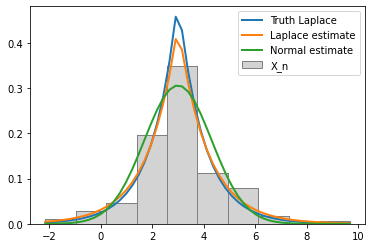

In [ ]:

imq_kernel = Kernel("simple_IMQ",l = 0.7)
mu = 3
sigma = 1
b = 1
# R_n = np.random.normal(mu,sigma,150)
print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is true, Gaussian model better")
R_n = np.random.laplace(mu,b,150)
# print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is false, Laplace model better")
para = estimate(mu,R_n,imq_kernel)
# plot_normal_laplace(R_n,[mu,sigma],para,"normal")
plot_normal_laplace(R_n,[mu,b],para,"laplace")
# model = build_two_model(imq_kernel,para)
# a = boostrap_realtive_test(model[0],model[1],R_n,method = "liu_bootstrap",b = 5000)
# relative_test(model[0],model[1],R_n)
plt.savefig("exp1_laplace_new.eps",dpi=1000)
files.download('exp1_laplace_new.eps') 
plt.show()

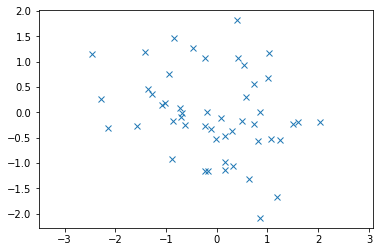

In [ ]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]
x, y = np.random.multivariate_normal(mean, cov, 50).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [ ]:
# start_time  = time.time()
# imq_kernel = Kernel("simple_IMQ",l = 0.7)
# mu = 3
# sigma = 1
# b = 1

# for i in range(10):
#   R_n = np.random.normal(mu,sigma,100)
#   print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is true, Gaussian model better")
#   # R_n = np.random.laplace(mu,b,100)
#   # print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is false, Laplace model better")

#   para = estimate(mu,R_n,imq_kernel)
#   end_time = time.time()
#   print("耗时：",end_time-start_time)
#   # plot_normal_laplace(R_n,[mu,sigma],para,"normal")
#   # plot_normal_laplace(R_n,[mu,b],para,"laplace")
#   model = build_two_model(imq_kernel,para)
#   a = boostrap_realtive_test(model[0],model[1],R_n,method = "liu_bootstrap",b = 5000)
#   # relative_test(model[0],model[1],R_n)

# end_time = time.time()
# print("耗时：",end_time-start_time)

- Experiment of Type 1 error

In [ ]:
imq_kernel = Kernel("simple_IMQ",l = 0.7)
mu = 3
sigma = 1
b = 1
# n = 100
m = 300
n = np.array([100])
# n = np.array([1,1])
type_1_error = np.zeros(len(n))

def error_experiment(n):
  test_result = np.zeros(m)
  for i in trange(m):
    R_n = np.random.normal(mu,sigma,n)
    para = estimate(mu,R_n,imq_kernel)
    model = build_two_model(imq_kernel,para)
    test_result[i] = boostrap_realtive_test(model[0],model[1],R_n,method = "liu_bootstrap",b = 5000)
  type1 = np.sum(test_result)/m
  # print("Testing Power:",type1)
  return type1

for i in range(len(n)):
  type_1_error[i] = error_experiment(n[i])
  print("When n = ",n[i]," the Type1error = " ,type_1_error[i])

for i in range(len(n)):
  print("When n = ",n[i]," the Type1error = " ,type_1_error[i])


- Experiment of Power

In [ ]:

imq_kernel = Kernel("simple_IMQ",l = 0.7)
mu = 3
sigma = 1
b = 1
m = 300
n = np.array([100,150])
power_set = np.zeros(len(n))

def error_experiment(n):
  test_result = np.zeros(m)
  for i in trange(m):
    R_n = np.random.laplace(mu,b,n)
    para = estimate(mu,R_n,imq_kernel)
    model = build_two_model(imq_kernel,para)
    test_result[i] = boostrap_realtive_test(model[0],model[1],R_n,method = "liu_bootstrap",b = 5000)
  power = np.sum(test_result)/m
  # print("Testing Power:",type1)
  return power

for i in range(len(n)):
  power_set[i] = error_experiment(n[i])
  print("When n = ",n[i]," the Type1error = " ,power_set[i])

for i in range(len(n)):
  print("When n = ",n[i]," the Type1error = " ,power_set[i])

### Normal v.s. Laplce Plot

In [ ]:
x = np.array([20,40,60,80,100,150,200])

#H_0: normal better
nor_1_error = np.array([0.28,0.18666666666666668,0.17333,0.12,0.05333,0.06,0.02333])
nor_2_error = np.array([0.053333,0.033333,0.033333,0.043333,0.0366666,0.03666666,0.0366666])
nor_1_power = np.array([0.4633333333333333,0.57,0.6533333333333333,0.7133333333333334,0.7966666666666666,0.8633333333333333,0.94])
nor_2_power = np.array([0.153332,0.32333,0.406667,0.51,0.6,0.77333,0.85])


#H_0: laplace better
la_1_error = np.array([0.31,0.193333,0.14,0.116666,0.08,0.025,0.01333])
la_2_error = np.array([0.11,0.04666,0.05333,0.03333,0.04,0.013333,0.003])
la_1_power = np.array([0.53,0.6,0.61,0.64,0.703333,0.813333,0.833333])
la_2_power = np.array([0.21,0.24666,0.33,0.34666,0.443333,0.506666,0.573333])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

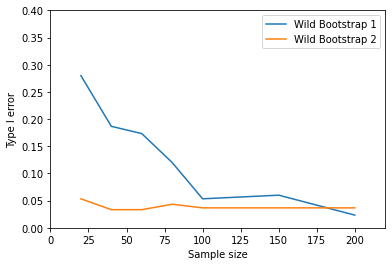

In [ ]:
plt.plot(x,nor_1_error,label = "Wild Bootstrap 1")
plt.plot(x,nor_2_error,label = "Wild Bootstrap 2")
plt.xlabel("Sample size")
plt.ylabel("Type I error")
plt.xlim(0,220)
plt.ylim(0,0.4)
# plt.title("T")
plt.legend()

plt.savefig("exp1_error.eps",dpi=1000)
files.download('exp1_error.eps') 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

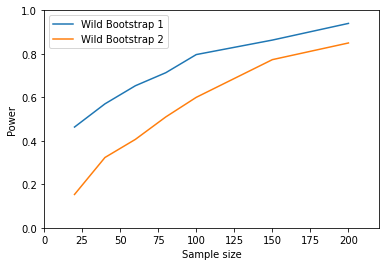

In [ ]:
plt.plot(x,nor_1_power,label = "Wild Bootstrap 1")
plt.plot(x,nor_2_power,label = "Wild Bootstrap 2")
plt.xlabel("Sample size")
plt.ylabel("Power")
plt.xlim(0,220)
plt.ylim(0,1)
# plt.title("T")
plt.legend()

plt.savefig("exp1_power.eps",dpi=1000)
files.download('exp1_power.eps') 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

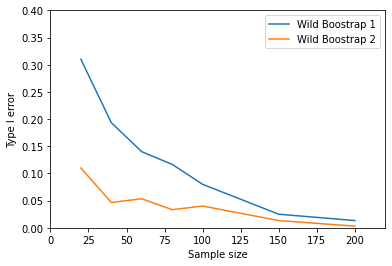

In [ ]:
plt.plot(x,la_1_error,label = "Wild Boostrap 1")
plt.plot(x,la_2_error,label = "Wild Boostrap 2")
plt.xlabel("Sample size")
plt.ylabel("Type I error")
plt.xlim(0,220)
plt.ylim(0,0.4)
# plt.title("T")
plt.legend()

plt.savefig("exp2_error.eps",dpi=1000)
files.download('exp2_error.eps') 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

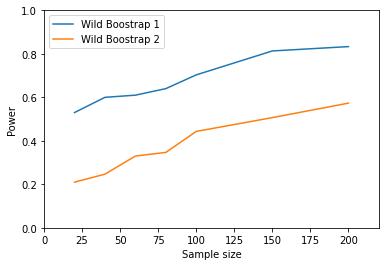

In [ ]:
plt.plot(x,la_1_power,label = "Wild Boostrap 1")
plt.plot(x,la_2_power,label = "Wild Boostrap 2")
plt.xlabel("Sample size")
plt.ylabel("Power")
plt.xlim(0,220)
plt.ylim(0,1)
# plt.title("T")
plt.legend()

plt.savefig("exp2_power.eps",dpi=1000)
files.download('exp2_power.eps') 
plt.show()

### Gamma v.s. Beta

In [ ]:
def gamma_pdf(x,k,theta):
  return (x**(k-1) * np.exp(-1*x/theta))/(theta**k * math.gamma(k))

def beta_pdf(x,alpha,beta):
  return 1/scipy.special.beta(alpha,beta) * x**(alpha-1) * (1-x)**(beta-1)

def plot_beta(R_n,alpha,beta,label):
  x = np.linspace(np.min(R_n), np.max(R_n), 50);
  y = [beta_pdf(i,alpha,beta) for i in x]
  plt.plot(x, y, linewidth=2,label = label) #draw the density of the model P
  plt.hist(R_n,color = "lightgrey", ec="grey",density = True)
  plt.legend()

def plot_gamma(R_n,k,theta,label):
  x = np.linspace(np.min(R_n), np.max(R_n), 50);
  y = [gamma_pdf(i,k,theta) for i in x]
  plt.plot(x, y, linewidth=2,label = label) #draw the density of the model P
  plt.hist(R_n,color = "lightgrey", ec="grey",density = True)
  plt.legend()


In [ ]:
def estimate(R_n,kernel):
  gamma_txdx = lambda x: np.array([1/x,1],dtype = float).reshape(-1,1)
  gamma_bxdx = lambda x: np.array(0,dtype = float)
  gamma_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = gamma_txdx,bxdx = gamma_bxdx)
  gamma_natural_para = gamma_min_ksd_estimator.theta_star(R_n)
  gamma_para = gamma_min_ksd_estimator.gamma_Inverse_parameter_mapping(gamma_natural_para)
  gamma_k = gamma_para[0]; gamma_theta = gamma_para[1];
  print("Estimation of Gamma:","k(shape):",gamma_k,"Theta(scale):",gamma_theta,"\n") 

  beta_txdx = lambda x: np.array([1/x,1/(x-1)],dtype = float).reshape(-1,1)
  beta_bxdx = lambda x: np.array(0,dtype = float)
  beta_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = beta_txdx,bxdx = beta_bxdx)
  beta_natural_para = beta_min_ksd_estimator.theta_star(R_n)
  beta_para = beta_min_ksd_estimator.beta_Inverse_parameter_mapping(beta_natural_para)
  beta_alpha = beta_para[0]; beta_beta = beta_para[1];
  print("Estimation of Beta:","Alpha:",beta_alpha,"Beta:",beta_beta,"\n") 

  return [gamma_k,gamma_theta,beta_alpha,beta_beta]


def plot_gamma_beta(R_n,true_para,para,null):
  est_k = para[0]; est_theta = para[1]; est_alpha = para[2]; est_beta = para[3]
  plt.hist(R_n,color = "lightgrey", ec="grey",density = True,label = "R_n")
  if (null == "gamma"):
    k = true_para[0];theta = true_para[1]
    plot_gamma(R_n,k,theta,"Gamma Truth")
    plot_gamma(R_n,est_k,est_theta,"Gamma estimate")
    plot_beta(R_n,est_alpha,est_beta,"Beta estimate") 
  elif (null == "beta"):
    alpha = true_para[0];beta = true_para[1]
    plot_beta(R_n,alpha,beta,"Beta Truth")
    plot_beta(R_n,est_alpha,est_beta,"Beta estimate")
    plot_gamma(R_n,est_k,est_theta,"Gamma estimate")

def build_two_model(para):
  model_1 = Exponential_Family(model_name= "gamma",kernel = imq_kernel,k=para[0],theta=para[1])
  model_2 = Exponential_Family(model_name = "beta",kernel = imq_kernel,alpha=para[2],beta=para[3])
  return [model_1,model_2]




Null Hypothesis: KSD(P||R)<KSD(Q||R) is false, Beta model better
Estimation of Gamma: k(shape): [14.75238364] Theta(scale): [0.04717557] 

Estimation of Beta: Alpha: [5.22939668] Beta: [2.33706987] 



100%|██████████| 5000/5000 [00:00<00:00, 12833.63it/s]


c_alpha =  0.1636769993281355
KSD_1: -3.2148436624531085 KSD_2: -3.4741772011361656
Test Statistics =  0.2593335386830571
P_value: 0.858
Test result: Reject the Null


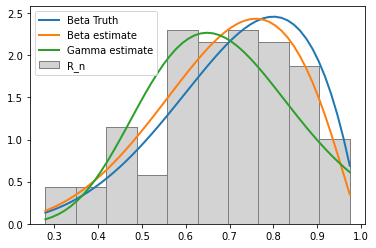

In [ ]:
imq_kernel = Kernel("simple_IMQ",l = 0.7)
# k = 8;theta = 0.05;R_n = np.random.gamma(k,theta,100)
# print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is true, Gamma model better")

alpha = 5;beta = 2;R_n = np.random.beta(alpha,beta,100)
print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is false, Beta model better")


para = estimate(R_n,imq_kernel)
# plot_gamma_beta(R_n,[k,theta],para,"gamma")
plot_gamma_beta(R_n,[alpha,beta],para,"beta")
model = build_two_model(para)
# relative_test(model[0],model[1],R_n)
a = boostrap_realtive_test(model[0],model[1],R_n,method = "liu_bootstrap",b = 5000)




Null Hypothesis: KSD(P||R)<KSD(Q||R) is true, Gamma model better
Estimation of Gamma: k(shape): [10.49795889] Theta(scale): [0.03931368] 

Estimation of Beta: Alpha: [5.8835671] Beta: [8.23117476] 



100%|██████████| 5000/5000 [00:00<00:00, 12978.61it/s]


c_alpha =  0.024826021473981517
KSD_1: -3.9603906726300404 KSD_2: -3.7968722321005317
Test Statistics =  -0.1635184405295087
P_value: 0.129
Test result: Accept the Null


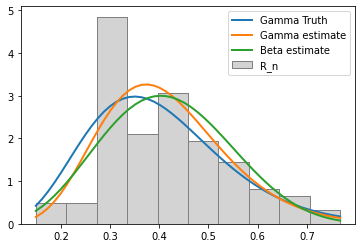

In [ ]:
imq_kernel = Kernel("simple_IMQ",l = 0.7)
k = 8;theta = 0.05;R_n = np.random.gamma(k,theta,100)
print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is true, Gamma model better")

# alpha = 5;beta = 2;R_n = np.random.beta(alpha,beta,100)
# print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is false, Beta model better")


para = estimate(R_n,imq_kernel)
plot_gamma_beta(R_n,[k,theta],para,"gamma")
# plot_gamma_beta(R_n,[alpha,beta],para,"beta")
model = build_two_model(para)
# relative_test(model[0],model[1],R_n)
a = boostrap_realtive_test(model[0],model[1],R_n,method = "liu_bootstrap",b = 5000)

In [ ]:
imq_kernel = Kernel("simple_IMQ",l = 0.7)
# k = 8;theta = 0.05;R_n = np.random.gamma(k,theta,100)
# print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is true, Gamma model better")

alpha = 5;beta = 2;R_n = np.random.beta(alpha,beta,100)
print("Null Hypothesis: KSD(P||R)<KSD(Q||R) is false, Beta model better")


para = estimate(R_n,imq_kernel)
# plot_gamma_beta(R_n,[k,theta],para,"gamma")
plot_gamma_beta(R_n,[alpha,beta],para,"beta")
model = build_two_model(para)
# relative_test(model[0],model[1],R_n)
a = boostrap_realtive_test(model[0],model[1],R_n,method = "liu_bootstrap",b = 5000)

In [ ]:
# I want to know why the test can corretly Accpet/Reject the H_0

In [ ]:
m = 100
imq_kernel = Kernel("simple_IMQ",l = 0.7)
res_1 = np.zeros(m);res_2 = np.zeros(m);res_3 = np.zeros(m);res_4 = np.zeros(m);
for i in trange(m):
  k = 8;theta = 0.05;R_n = np.random.gamma(k,theta,100) #sample from gamma(H_0 is true)
  para = estimate(R_n,imq_kernel)
  model = build_two_model(para)
  P = model[0];Q = model[1]
  res_1[i] = P.compute_KSD_with_Q(R_n);res_2[i] = Q.compute_KSD_with_Q(R_n);
for i in trange(m):
  alpha = 5;beta = 2;R_n = np.random.beta(alpha,beta,100) #sample from beta(H_0 is false)
  para = estimate(R_n,imq_kernel)
  model = build_two_model(para)
  P = model[0];Q = model[1]
  res_3[i] = P.compute_KSD_with_Q(R_n);res_4[i] = Q.compute_KSD_with_Q(R_n);

  0%|          | 0/100 [00:00<?, ?it/s]

Estimation of Gamma: k(shape): [11.56241831] Theta(scale): [0.03401678] 

Estimation of Beta: Alpha: [6.60900348] Beta: [10.02368306] 



  1%|          | 1/100 [00:55<1:31:15, 55.31s/it]

Estimation of Gamma: k(shape): [7.28980944] Theta(scale): [0.05559077] 

Estimation of Beta: Alpha: [3.88155305] Beta: [5.41683047] 



  2%|▏         | 2/100 [01:51<1:31:15, 55.88s/it]

Estimation of Gamma: k(shape): [7.52341898] Theta(scale): [0.05096106] 

Estimation of Beta: Alpha: [4.61411798] Beta: [7.27924382] 



  3%|▎         | 3/100 [02:48<1:30:43, 56.12s/it]

Estimation of Gamma: k(shape): [9.37085741] Theta(scale): [0.04217795] 

Estimation of Beta: Alpha: [5.80460758] Beta: [8.83447568] 



  4%|▍         | 4/100 [03:43<1:29:24, 55.88s/it]

Estimation of Gamma: k(shape): [9.13853776] Theta(scale): [0.04238544] 

Estimation of Beta: Alpha: [4.9223356] Beta: [7.49880946] 



  5%|▌         | 5/100 [04:40<1:29:11, 56.33s/it]

Estimation of Gamma: k(shape): [8.71255312] Theta(scale): [0.04679442] 

Estimation of Beta: Alpha: [5.56791052] Beta: [8.12014591] 



  6%|▌         | 6/100 [05:37<1:28:32, 56.52s/it]

Estimation of Gamma: k(shape): [7.88695458] Theta(scale): [0.05093977] 

Estimation of Beta: Alpha: [4.23248268] Beta: [5.99604102] 



  7%|▋         | 7/100 [06:34<1:27:59, 56.77s/it]

Estimation of Gamma: k(shape): [9.52977962] Theta(scale): [0.04131238] 

Estimation of Beta: Alpha: [6.20154713] Beta: [9.57882425] 



  8%|▊         | 8/100 [07:31<1:27:05, 56.80s/it]

Estimation of Gamma: k(shape): [6.9282546] Theta(scale): [0.06060596] 

Estimation of Beta: Alpha: [3.9249038] Beta: [5.25248571] 



  9%|▉         | 9/100 [08:26<1:25:26, 56.34s/it]

Estimation of Gamma: k(shape): [8.41861128] Theta(scale): [0.04825057] 

Estimation of Beta: Alpha: [4.80061681] Beta: [6.86534901] 



 10%|█         | 10/100 [09:23<1:24:33, 56.38s/it]

Estimation of Gamma: k(shape): [7.29052527] Theta(scale): [0.05598993] 

Estimation of Beta: Alpha: [4.8513363] Beta: [7.26061555] 



/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
 11%|█         | 11/100 [10:18<1:23:01, 55.97s/it]

Estimation of Gamma: k(shape): [6.39320499] Theta(scale): [0.05935183] 

Estimation of Beta: Alpha: [4.28741887] Beta: [7.02988931] 



 12%|█▏        | 12/100 [11:15<1:22:21, 56.15s/it]

Estimation of Gamma: k(shape): [7.29599087] Theta(scale): [0.05823068] 

Estimation of Beta: Alpha: [3.91763923] Beta: [5.10187308] 



 13%|█▎        | 13/100 [12:10<1:21:13, 56.02s/it]

Estimation of Gamma: k(shape): [8.6537369] Theta(scale): [0.04934007] 

Estimation of Beta: Alpha: [5.47496815] Beta: [7.40538475] 



 14%|█▍        | 14/100 [13:07<1:20:27, 56.13s/it]

Estimation of Gamma: k(shape): [7.27821541] Theta(scale): [0.05658686] 

Estimation of Beta: Alpha: [4.11203967] Beta: [5.7016843] 



 15%|█▌        | 15/100 [14:03<1:19:46, 56.32s/it]

Estimation of Gamma: k(shape): [7.49953884] Theta(scale): [0.05324005] 

Estimation of Beta: Alpha: [4.78262502] Beta: [7.17216095] 



 16%|█▌        | 16/100 [14:59<1:18:30, 56.08s/it]

Estimation of Gamma: k(shape): [7.31016851] Theta(scale): [0.05483488] 

Estimation of Beta: Alpha: [0.57410335] Beta: [-0.1875545] 



 17%|█▋        | 17/100 [15:57<1:18:12, 56.54s/it]

Estimation of Gamma: k(shape): [9.51370056] Theta(scale): [0.04128609] 

Estimation of Beta: Alpha: [3.18771803] Beta: [4.15259996] 



 18%|█▊        | 18/100 [16:52<1:17:00, 56.35s/it]

Estimation of Gamma: k(shape): [7.35853434] Theta(scale): [0.05528445] 

Estimation of Beta: Alpha: [4.46608137] Beta: [6.42932461] 



 19%|█▉        | 19/100 [17:49<1:16:17, 56.51s/it]

Estimation of Gamma: k(shape): [8.97425855] Theta(scale): [0.04369901] 

Estimation of Beta: Alpha: [5.08114859] Beta: [7.61795529] 



 20%|██        | 20/100 [18:45<1:15:10, 56.38s/it]

Estimation of Gamma: k(shape): [11.02767782] Theta(scale): [0.0352321] 

Estimation of Beta: Alpha: [6.25887372] Beta: [9.65132204] 



 21%|██        | 21/100 [19:43<1:14:31, 56.60s/it]

Estimation of Gamma: k(shape): [7.74371756] Theta(scale): [0.0534205] 

Estimation of Beta: Alpha: [3.87845048] Beta: [5.14463855] 



 22%|██▏       | 22/100 [20:40<1:13:46, 56.76s/it]

Estimation of Gamma: k(shape): [8.16230496] Theta(scale): [0.04705246] 

Estimation of Beta: Alpha: [4.85895334] Beta: [7.64289659] 



 23%|██▎       | 23/100 [21:36<1:12:46, 56.71s/it]

Estimation of Gamma: k(shape): [8.44018446] Theta(scale): [0.04733256] 

Estimation of Beta: Alpha: [4.79696705] Beta: [6.99562018] 



 24%|██▍       | 24/100 [22:33<1:11:50, 56.72s/it]

Estimation of Gamma: k(shape): [7.82466804] Theta(scale): [0.04982176] 

Estimation of Beta: Alpha: [4.78637781] Beta: [7.39536867] 



 25%|██▌       | 25/100 [23:29<1:10:33, 56.44s/it]

Estimation of Gamma: k(shape): [6.46947128] Theta(scale): [0.06325773] 

Estimation of Beta: Alpha: [1.60696179] Beta: [2.13023907] 



 26%|██▌       | 26/100 [24:25<1:09:39, 56.49s/it]

Estimation of Gamma: k(shape): [11.17100445] Theta(scale): [0.03578042] 

Estimation of Beta: Alpha: [6.75284834] Beta: [10.08364162] 



 27%|██▋       | 27/100 [25:21<1:08:34, 56.37s/it]

Estimation of Gamma: k(shape): [7.00609479] Theta(scale): [0.05580634] 

Estimation of Beta: Alpha: [2.20131388] Beta: [2.53025881] 



 28%|██▊       | 28/100 [26:18<1:07:44, 56.45s/it]

Estimation of Gamma: k(shape): [7.28266063] Theta(scale): [0.05311984] 

Estimation of Beta: Alpha: [4.23120324] Beta: [6.46176371] 



 29%|██▉       | 29/100 [27:15<1:06:56, 56.57s/it]

Estimation of Gamma: k(shape): [9.80788809] Theta(scale): [0.04292536] 

Estimation of Beta: Alpha: [5.82932417] Beta: [7.96784891] 



 30%|███       | 30/100 [28:11<1:05:46, 56.38s/it]

Estimation of Gamma: k(shape): [6.60922098] Theta(scale): [0.06509321] 

Estimation of Beta: Alpha: [3.9585024] Beta: [5.17732011] 



 31%|███       | 31/100 [29:07<1:04:54, 56.45s/it]

Estimation of Gamma: k(shape): [7.32787147] Theta(scale): [0.05472122] 

Estimation of Beta: Alpha: [4.39674589] Beta: [6.46022748] 



 32%|███▏      | 32/100 [30:03<1:03:38, 56.16s/it]

Estimation of Gamma: k(shape): [8.00035217] Theta(scale): [0.04963134] 

Estimation of Beta: Alpha: [4.90818203] Beta: [7.36033436] 



 33%|███▎      | 33/100 [31:02<1:03:35, 56.95s/it]

Estimation of Gamma: k(shape): [9.48631458] Theta(scale): [0.0420746] 

Estimation of Beta: Alpha: [5.43194781] Beta: [8.0269819] 



 34%|███▍      | 34/100 [31:58<1:02:17, 56.63s/it]

Estimation of Gamma: k(shape): [7.37463034] Theta(scale): [0.05342228] 

Estimation of Beta: Alpha: [4.34796239] Beta: [6.53063045] 



 35%|███▌      | 35/100 [32:54<1:01:21, 56.64s/it]

Estimation of Gamma: k(shape): [7.85976717] Theta(scale): [0.05447702] 

Estimation of Beta: Alpha: [3.07602802] Beta: [3.56224278] 



 36%|███▌      | 36/100 [33:51<1:00:28, 56.70s/it]

Estimation of Gamma: k(shape): [8.05660477] Theta(scale): [0.04999503] 

Estimation of Beta: Alpha: [3.86560238] Beta: [5.28964789] 



 37%|███▋      | 37/100 [34:47<59:08, 56.33s/it]  

Estimation of Gamma: k(shape): [7.51141888] Theta(scale): [0.05481301] 

Estimation of Beta: Alpha: [4.49693659] Beta: [6.34099636] 



 38%|███▊      | 38/100 [35:43<58:19, 56.44s/it]

Estimation of Gamma: k(shape): [12.3049307] Theta(scale): [0.03326684] 

Estimation of Beta: Alpha: [6.33997542] Beta: [8.90310534] 



 39%|███▉      | 39/100 [36:39<57:07, 56.19s/it]

Estimation of Gamma: k(shape): [9.35888868] Theta(scale): [0.04393038] 

Estimation of Beta: Alpha: [4.28682659] Beta: [5.70512731] 



 40%|████      | 40/100 [37:36<56:28, 56.48s/it]

Estimation of Gamma: k(shape): [7.3127798] Theta(scale): [0.05185955] 

Estimation of Beta: Alpha: [4.41272387] Beta: [7.02116859] 



 41%|████      | 41/100 [38:31<55:11, 56.12s/it]

Estimation of Gamma: k(shape): [9.99893798] Theta(scale): [0.04036925] 

Estimation of Beta: Alpha: [5.77236576] Beta: [8.39702423] 



 42%|████▏     | 42/100 [39:28<54:23, 56.27s/it]

Estimation of Gamma: k(shape): [8.04564255] Theta(scale): [0.05286441] 

Estimation of Beta: Alpha: [3.91462913] Beta: [4.96641988] 



 43%|████▎     | 43/100 [40:24<53:29, 56.30s/it]

Estimation of Gamma: k(shape): [7.64767592] Theta(scale): [0.05638548] 

Estimation of Beta: Alpha: [4.30597692] Beta: [5.55586299] 



 44%|████▍     | 44/100 [41:21<52:39, 56.41s/it]

Estimation of Gamma: k(shape): [8.62549003] Theta(scale): [0.0439251] 

Estimation of Beta: Alpha: [4.52992683] Beta: [7.04364767] 



 45%|████▌     | 45/100 [42:18<51:45, 56.47s/it]

Estimation of Gamma: k(shape): [11.52091261] Theta(scale): [0.03252256] 

Estimation of Beta: Alpha: [7.02677469] Beta: [11.59935622] 



 46%|████▌     | 46/100 [43:14<50:42, 56.34s/it]

Estimation of Gamma: k(shape): [9.75767314] Theta(scale): [0.0429745] 

Estimation of Beta: Alpha: [5.77168992] Beta: [7.92479394] 



 47%|████▋     | 47/100 [44:10<49:44, 56.31s/it]

Estimation of Gamma: k(shape): [10.07539314] Theta(scale): [0.041522] 

Estimation of Beta: Alpha: [6.43734806] Beta: [9.17659181] 



 48%|████▊     | 48/100 [45:05<48:27, 55.92s/it]

Estimation of Gamma: k(shape): [6.12496333] Theta(scale): [0.06814355] 

Estimation of Beta: Alpha: [2.87241241] Beta: [3.56631785] 



 49%|████▉     | 49/100 [46:01<47:38, 56.05s/it]

Estimation of Gamma: k(shape): [7.53486573] Theta(scale): [0.0529546] 

Estimation of Beta: Alpha: [3.93324964] Beta: [5.55710556] 



 50%|█████     | 50/100 [46:56<46:23, 55.66s/it]

Estimation of Gamma: k(shape): [7.67035917] Theta(scale): [0.05293516] 

Estimation of Beta: Alpha: [4.57979562] Beta: [6.59821411] 



 51%|█████     | 51/100 [47:52<45:38, 55.89s/it]

Estimation of Gamma: k(shape): [7.14484252] Theta(scale): [0.05667756] 

Estimation of Beta: Alpha: [4.07941531] Beta: [5.80663724] 



 52%|█████▏    | 52/100 [48:49<44:49, 56.02s/it]

Estimation of Gamma: k(shape): [7.70519747] Theta(scale): [0.05325363] 

Estimation of Beta: Alpha: [4.93139797] Beta: [7.1198766] 



 53%|█████▎    | 53/100 [49:44<43:40, 55.75s/it]

Estimation of Gamma: k(shape): [5.47020508] Theta(scale): [0.06904297] 

Estimation of Beta: Alpha: [3.39406934] Beta: [5.41678614] 



 54%|█████▍    | 54/100 [50:40<42:50, 55.87s/it]

Estimation of Gamma: k(shape): [7.82485796] Theta(scale): [0.05158763] 

Estimation of Beta: Alpha: [4.20979383] Beta: [5.95067453] 



 55%|█████▌    | 55/100 [51:35<41:48, 55.73s/it]

Estimation of Gamma: k(shape): [8.11087249] Theta(scale): [0.05016136] 

Estimation of Beta: Alpha: [4.2913948] Beta: [5.98530934] 



 56%|█████▌    | 56/100 [52:32<40:57, 55.84s/it]

Estimation of Gamma: k(shape): [7.72958438] Theta(scale): [0.05158093] 

Estimation of Beta: Alpha: [5.23386501] Beta: [8.00116363] 



 57%|█████▋    | 57/100 [53:27<40:00, 55.83s/it]

Estimation of Gamma: k(shape): [8.53679982] Theta(scale): [0.04693249] 

Estimation of Beta: Alpha: [4.64885351] Beta: [6.69931808] 



 58%|█████▊    | 58/100 [54:24<39:13, 56.03s/it]

Estimation of Gamma: k(shape): [9.26580214] Theta(scale): [0.04256561] 

Estimation of Beta: Alpha: [2.96283832] Beta: [3.72708252] 



 59%|█████▉    | 59/100 [55:19<38:06, 55.77s/it]

Estimation of Gamma: k(shape): [6.79034244] Theta(scale): [0.05655677] 

Estimation of Beta: Alpha: [2.95706861] Beta: [4.09473957] 



 60%|██████    | 60/100 [56:16<37:24, 56.12s/it]

Estimation of Gamma: k(shape): [7.37095539] Theta(scale): [0.05553681] 

Estimation of Beta: Alpha: [4.15446199] Beta: [5.80286315] 



 61%|██████    | 61/100 [57:12<36:31, 56.20s/it]

Estimation of Gamma: k(shape): [6.34584996] Theta(scale): [0.06219979] 

Estimation of Beta: Alpha: [3.23449833] Beta: [4.52249132] 



 62%|██████▏   | 62/100 [58:08<35:24, 55.91s/it]

Estimation of Gamma: k(shape): [7.43446005] Theta(scale): [0.05199954] 

Estimation of Beta: Alpha: [4.20784138] Beta: [6.49745922] 



 63%|██████▎   | 63/100 [59:05<34:42, 56.27s/it]

Estimation of Gamma: k(shape): [8.56261924] Theta(scale): [0.04977143] 

Estimation of Beta: Alpha: [4.85025522] Beta: [6.47796519] 



 64%|██████▍   | 64/100 [1:00:00<33:40, 56.14s/it]

Estimation of Gamma: k(shape): [7.76234486] Theta(scale): [0.05277408] 

Estimation of Beta: Alpha: [4.03338696] Beta: [5.47212347] 



 65%|██████▌   | 65/100 [1:00:57<32:44, 56.12s/it]

Estimation of Gamma: k(shape): [8.78581544] Theta(scale): [0.04667364] 

Estimation of Beta: Alpha: [5.79501591] Beta: [8.42819629] 



 66%|██████▌   | 66/100 [1:01:52<31:38, 55.83s/it]

Estimation of Gamma: k(shape): [8.12887187] Theta(scale): [0.05129956] 

Estimation of Beta: Alpha: [4.63417239] Beta: [6.34859467] 



 67%|██████▋   | 67/100 [1:02:48<30:42, 55.85s/it]

Estimation of Gamma: k(shape): [9.21228897] Theta(scale): [0.04421891] 

Estimation of Beta: Alpha: [5.5567736] Beta: [8.01893232] 



 68%|██████▊   | 68/100 [1:03:43<29:39, 55.61s/it]

Estimation of Gamma: k(shape): [7.3045772] Theta(scale): [0.0544443] 

Estimation of Beta: Alpha: [4.72944556] Beta: [7.1495011] 



 69%|██████▉   | 69/100 [1:04:39<28:48, 55.75s/it]

Estimation of Gamma: k(shape): [8.2261916] Theta(scale): [0.04992535] 

Estimation of Beta: Alpha: [4.69084588] Beta: [6.56544307] 



 70%|███████   | 70/100 [1:05:35<27:56, 55.89s/it]

Estimation of Gamma: k(shape): [6.21961173] Theta(scale): [0.06427748] 

Estimation of Beta: Alpha: [3.87278107] Beta: [5.73219981] 



 71%|███████   | 71/100 [1:06:30<26:53, 55.63s/it]

Estimation of Gamma: k(shape): [8.69110952] Theta(scale): [0.04316762] 

Estimation of Beta: Alpha: [5.56846441] Beta: [9.21908407] 



 72%|███████▏  | 72/100 [1:07:26<26:01, 55.75s/it]

Estimation of Gamma: k(shape): [9.1577732] Theta(scale): [0.04451838] 

Estimation of Beta: Alpha: [5.30732818] Beta: [7.59663449] 



 73%|███████▎  | 73/100 [1:08:22<25:04, 55.73s/it]

Estimation of Gamma: k(shape): [6.59314259] Theta(scale): [0.05990066] 

Estimation of Beta: Alpha: [4.13892113] Beta: [6.26513748] 



 74%|███████▍  | 74/100 [1:09:19<24:17, 56.05s/it]

Estimation of Gamma: k(shape): [7.3832253] Theta(scale): [0.0526286] 

Estimation of Beta: Alpha: [4.77318199] Beta: [7.50464578] 



 75%|███████▌  | 75/100 [1:10:14<23:16, 55.86s/it]

Estimation of Gamma: k(shape): [9.67592327] Theta(scale): [0.04176551] 

Estimation of Beta: Alpha: [3.12395511] Beta: [3.84146919] 



 76%|███████▌  | 76/100 [1:11:12<22:33, 56.38s/it]

Estimation of Gamma: k(shape): [5.57656536] Theta(scale): [0.07191965] 

Estimation of Beta: Alpha: [3.44389806] Beta: [5.02822927] 



 77%|███████▋  | 77/100 [1:12:07<21:30, 56.11s/it]

Estimation of Gamma: k(shape): [6.32018743] Theta(scale): [0.068128] 

Estimation of Beta: Alpha: [3.4389489] Beta: [4.35480626] 



 78%|███████▊  | 78/100 [1:13:05<20:44, 56.58s/it]

Estimation of Gamma: k(shape): [8.28074824] Theta(scale): [0.04901564] 

Estimation of Beta: Alpha: [3.77004744] Beta: [5.04353526] 



 79%|███████▉  | 79/100 [1:14:02<19:49, 56.66s/it]

Estimation of Gamma: k(shape): [8.16551717] Theta(scale): [0.0519393] 

Estimation of Beta: Alpha: [3.98087816] Beta: [5.09801775] 



 80%|████████  | 80/100 [1:14:59<18:56, 56.80s/it]

Estimation of Gamma: k(shape): [8.82745923] Theta(scale): [0.04608379] 

Estimation of Beta: Alpha: [5.00460505] Beta: [7.12046058] 



 81%|████████  | 81/100 [1:15:55<17:58, 56.76s/it]

Estimation of Gamma: k(shape): [9.13311435] Theta(scale): [0.04353963] 

Estimation of Beta: Alpha: [5.61760737] Beta: [8.45488346] 



 82%|████████▏ | 82/100 [1:16:51<16:54, 56.35s/it]

Estimation of Gamma: k(shape): [7.56384815] Theta(scale): [0.05356926] 

Estimation of Beta: Alpha: [4.3120677] Beta: [6.14954703] 



 83%|████████▎ | 83/100 [1:17:47<15:58, 56.40s/it]

Estimation of Gamma: k(shape): [7.46082336] Theta(scale): [0.05129172] 

Estimation of Beta: Alpha: [4.52912701] Beta: [7.13764874] 



 84%|████████▍ | 84/100 [1:18:43<14:57, 56.07s/it]

Estimation of Gamma: k(shape): [6.59881369] Theta(scale): [0.06096703] 

Estimation of Beta: Alpha: [3.93446378] Beta: [5.70213124] 



 85%|████████▌ | 85/100 [1:19:39<14:02, 56.17s/it]

Estimation of Gamma: k(shape): [7.79707455] Theta(scale): [0.0520037] 

Estimation of Beta: Alpha: [1.82889158] Beta: [1.74095015] 



 86%|████████▌ | 86/100 [1:20:34<13:03, 55.93s/it]

Estimation of Gamma: k(shape): [6.84722152] Theta(scale): [0.06088473] 

Estimation of Beta: Alpha: [3.77181818] Beta: [5.04156872] 



 87%|████████▋ | 87/100 [1:21:31<12:08, 56.05s/it]

Estimation of Gamma: k(shape): [8.27456465] Theta(scale): [0.04465272] 

Estimation of Beta: Alpha: [5.30212876] Beta: [8.95462717] 



 88%|████████▊ | 88/100 [1:22:26<11:08, 55.74s/it]

Estimation of Gamma: k(shape): [7.11816612] Theta(scale): [0.05696625] 

Estimation of Beta: Alpha: [2.48012514] Beta: [2.86929589] 



 89%|████████▉ | 89/100 [1:23:22<10:14, 55.83s/it]

Estimation of Gamma: k(shape): [8.85611528] Theta(scale): [0.04690709] 

Estimation of Beta: Alpha: [5.02557103] Beta: [6.93982737] 



 90%|█████████ | 90/100 [1:24:17<09:15, 55.57s/it]

Estimation of Gamma: k(shape): [7.66962545] Theta(scale): [0.05117226] 

Estimation of Beta: Alpha: [3.92129715] Beta: [5.67113344] 



 91%|█████████ | 91/100 [1:25:13<08:22, 55.80s/it]

Estimation of Gamma: k(shape): [8.0170506] Theta(scale): [0.0507161] 

Estimation of Beta: Alpha: [4.18304724] Beta: [5.77636754] 



 92%|█████████▏| 92/100 [1:26:10<07:28, 56.08s/it]

Estimation of Gamma: k(shape): [8.61047293] Theta(scale): [0.04690314] 

Estimation of Beta: Alpha: [4.30642072] Beta: [6.00733582] 



 93%|█████████▎| 93/100 [1:27:07<06:34, 56.31s/it]

Estimation of Gamma: k(shape): [9.74854489] Theta(scale): [0.04254443] 

Estimation of Beta: Alpha: [2.39996759] Beta: [2.54037233] 



 94%|█████████▍| 94/100 [1:28:04<05:39, 56.51s/it]

Estimation of Gamma: k(shape): [7.77154307] Theta(scale): [0.05329231] 

Estimation of Beta: Alpha: [4.38275027] Beta: [6.02238069] 



 95%|█████████▌| 95/100 [1:28:59<04:40, 56.18s/it]

Estimation of Gamma: k(shape): [6.33166128] Theta(scale): [0.06413571] 

Estimation of Beta: Alpha: [3.26101888] Beta: [4.38356233] 



 96%|█████████▌| 96/100 [1:29:55<03:44, 56.23s/it]

Estimation of Gamma: k(shape): [8.67419057] Theta(scale): [0.04605639] 

Estimation of Beta: Alpha: [4.92215465] Beta: [7.21151871] 



 97%|█████████▋| 97/100 [1:30:51<02:48, 56.01s/it]

Estimation of Gamma: k(shape): [7.20395065] Theta(scale): [0.05512903] 

Estimation of Beta: Alpha: [4.49814432] Beta: [6.7595153] 



 98%|█████████▊| 98/100 [1:31:47<01:52, 56.06s/it]

Estimation of Gamma: k(shape): [6.7064903] Theta(scale): [0.05508598] 

Estimation of Beta: Alpha: [1.01500272] Beta: [0.97124223] 



 99%|█████████▉| 99/100 [1:32:42<00:55, 55.71s/it]

Estimation of Gamma: k(shape): [9.70743578] Theta(scale): [0.0392393] 

Estimation of Beta: Alpha: [4.55969349] Beta: [6.9261966] 



  0%|          | 0/100 [00:00<?, ?it/s]

Estimation of Gamma: k(shape): [10.94543582] Theta(scale): [0.06522929] 

Estimation of Beta: Alpha: [5.20960228] Beta: [2.33168285] 



  1%|          | 1/100 [00:54<1:29:50, 54.45s/it]

Estimation of Gamma: k(shape): [9.18049849] Theta(scale): [0.08180222] 

Estimation of Beta: Alpha: [4.43569679] Beta: [1.73029382] 



  2%|▏         | 2/100 [01:50<1:30:22, 55.34s/it]

Estimation of Gamma: k(shape): [16.27071336] Theta(scale): [0.04394966] 

Estimation of Beta: Alpha: [4.87825307] Beta: [1.94777957] 



  3%|▎         | 3/100 [02:45<1:29:29, 55.36s/it]

Estimation of Gamma: k(shape): [15.98395402] Theta(scale): [0.04632676] 

Estimation of Beta: Alpha: [5.52051965] Beta: [2.03727258] 



  4%|▍         | 4/100 [03:43<1:29:45, 56.10s/it]

Estimation of Gamma: k(shape): [13.93167566] Theta(scale): [0.05175356] 

Estimation of Beta: Alpha: [5.1497967] Beta: [2.12043217] 



  5%|▌         | 5/100 [04:39<1:28:50, 56.12s/it]

Estimation of Gamma: k(shape): [14.75443966] Theta(scale): [0.04783145] 

Estimation of Beta: Alpha: [5.27520711] Beta: [2.26884626] 



  6%|▌         | 6/100 [05:36<1:28:32, 56.52s/it]

Estimation of Gamma: k(shape): [15.91258976] Theta(scale): [0.04420833] 

Estimation of Beta: Alpha: [4.8822131] Beta: [2.07178853] 



  7%|▋         | 7/100 [06:32<1:27:07, 56.21s/it]

Estimation of Gamma: k(shape): [11.34778604] Theta(scale): [0.06175437] 

Estimation of Beta: Alpha: [3.65902954] Beta: [1.58323547] 



  8%|▊         | 8/100 [07:27<1:25:58, 56.07s/it]

Estimation of Gamma: k(shape): [17.53129699] Theta(scale): [0.0408588] 

Estimation of Beta: Alpha: [5.99133081] Beta: [2.45535507] 



  9%|▉         | 9/100 [08:24<1:25:13, 56.19s/it]

Estimation of Gamma: k(shape): [12.77425464] Theta(scale): [0.05543601] 

Estimation of Beta: Alpha: [4.14252126] Beta: [1.71277394] 



 10%|█         | 10/100 [09:19<1:23:38, 55.76s/it]

Estimation of Gamma: k(shape): [12.967758] Theta(scale): [0.05403277] 

Estimation of Beta: Alpha: [3.09378941] Beta: [1.21492372] 



 11%|█         | 11/100 [10:15<1:22:52, 55.87s/it]

Estimation of Gamma: k(shape): [12.02487577] Theta(scale): [0.06003542] 

Estimation of Beta: Alpha: [4.42870276] Beta: [1.79034961] 



 12%|█▏        | 12/100 [11:10<1:21:33, 55.61s/it]

Estimation of Gamma: k(shape): [14.37669907] Theta(scale): [0.04891934] 

Estimation of Beta: Alpha: [4.9674946] Beta: [2.13499604] 



 13%|█▎        | 13/100 [12:06<1:20:50, 55.75s/it]

Estimation of Gamma: k(shape): [22.05694827] Theta(scale): [0.03307913] 

Estimation of Beta: Alpha: [6.07058598] Beta: [2.26618517] 



 14%|█▍        | 14/100 [13:01<1:19:37, 55.55s/it]

Estimation of Gamma: k(shape): [14.55235979] Theta(scale): [0.05021147] 

Estimation of Beta: Alpha: [6.11433277] Beta: [2.4589776] 



 15%|█▌        | 15/100 [13:57<1:19:07, 55.85s/it]

Estimation of Gamma: k(shape): [13.15126912] Theta(scale): [0.05719598] 

Estimation of Beta: Alpha: [4.92863174] Beta: [1.78168263] 



 16%|█▌        | 16/100 [14:53<1:18:01, 55.73s/it]

Estimation of Gamma: k(shape): [11.69940367] Theta(scale): [0.06293068] 

Estimation of Beta: Alpha: [4.20365237] Beta: [1.60279351] 



 17%|█▋        | 17/100 [15:49<1:17:25, 55.97s/it]

Estimation of Gamma: k(shape): [15.83446632] Theta(scale): [0.04486266] 

Estimation of Beta: Alpha: [5.56306778] Beta: [2.32785826] 



 18%|█▊        | 18/100 [16:46<1:16:37, 56.06s/it]

Estimation of Gamma: k(shape): [17.015189] Theta(scale): [0.043885] 

Estimation of Beta: Alpha: [5.94879685] Beta: [2.13726197] 



 19%|█▉        | 19/100 [17:42<1:15:54, 56.23s/it]

Estimation of Gamma: k(shape): [16.47066363] Theta(scale): [0.04429257] 

Estimation of Beta: Alpha: [5.13113603] Beta: [1.95749322] 



 20%|██        | 20/100 [18:38<1:14:43, 56.05s/it]

Estimation of Gamma: k(shape): [14.97904826] Theta(scale): [0.04764843] 

Estimation of Beta: Alpha: [4.88832708] Beta: [1.98999915] 



 21%|██        | 21/100 [19:35<1:14:00, 56.21s/it]

Estimation of Gamma: k(shape): [11.42769843] Theta(scale): [0.06353431] 

Estimation of Beta: Alpha: [5.37136148] Beta: [2.27035] 



 22%|██▏       | 22/100 [20:30<1:12:50, 56.03s/it]

Estimation of Gamma: k(shape): [12.851445] Theta(scale): [0.05576664] 

Estimation of Beta: Alpha: [5.30345503] Beta: [2.27709479] 



 23%|██▎       | 23/100 [21:27<1:12:09, 56.23s/it]

Estimation of Gamma: k(shape): [11.44035007] Theta(scale): [0.06059674] 

Estimation of Beta: Alpha: [4.69312015] Beta: [2.19086009] 



 24%|██▍       | 24/100 [22:22<1:10:54, 55.99s/it]

Estimation of Gamma: k(shape): [8.76240563] Theta(scale): [0.08110216] 

Estimation of Beta: Alpha: [3.7665033] Beta: [1.68470887] 



 25%|██▌       | 25/100 [23:19<1:10:13, 56.18s/it]

Estimation of Gamma: k(shape): [17.44394078] Theta(scale): [0.04023486] 

Estimation of Beta: Alpha: [5.25578758] Beta: [2.21259214] 



 26%|██▌       | 26/100 [24:15<1:09:05, 56.02s/it]

Estimation of Gamma: k(shape): [22.62334054] Theta(scale): [0.03191551] 

Estimation of Beta: Alpha: [4.95091358] Beta: [1.82087179] 



 27%|██▋       | 27/100 [25:11<1:08:09, 56.02s/it]

Estimation of Gamma: k(shape): [12.90171853] Theta(scale): [0.05481909] 

Estimation of Beta: Alpha: [4.38623796] Beta: [1.86473105] 



 28%|██▊       | 28/100 [26:06<1:07:00, 55.83s/it]

Estimation of Gamma: k(shape): [10.7153257] Theta(scale): [0.06411299] 

Estimation of Beta: Alpha: [4.74597138] Beta: [2.30943489] 



 29%|██▉       | 29/100 [27:02<1:06:14, 55.98s/it]

Estimation of Gamma: k(shape): [14.16791156] Theta(scale): [0.04977791] 

Estimation of Beta: Alpha: [5.0148069] Beta: [2.16219697] 



 30%|███       | 30/100 [27:58<1:05:03, 55.77s/it]

Estimation of Gamma: k(shape): [19.01445995] Theta(scale): [0.03847207] 

Estimation of Beta: Alpha: [5.44690577] Beta: [2.02274214] 



 31%|███       | 31/100 [28:54<1:04:16, 55.89s/it]

Estimation of Gamma: k(shape): [12.35685345] Theta(scale): [0.0582172] 

Estimation of Beta: Alpha: [3.6795649] Beta: [1.42945495] 



 32%|███▏      | 32/100 [29:50<1:03:35, 56.11s/it]

Estimation of Gamma: k(shape): [17.20825247] Theta(scale): [0.04233004] 

Estimation of Beta: Alpha: [5.15958096] Beta: [1.9648465] 



 33%|███▎      | 33/100 [30:46<1:02:27, 55.94s/it]

Estimation of Gamma: k(shape): [18.01785425] Theta(scale): [0.04050116] 

Estimation of Beta: Alpha: [4.60656813] Beta: [1.66570226] 



 34%|███▍      | 34/100 [31:42<1:01:37, 56.03s/it]

Estimation of Gamma: k(shape): [18.78388297] Theta(scale): [0.03913193] 

Estimation of Beta: Alpha: [5.79064594] Beta: [2.13490022] 



 35%|███▌      | 35/100 [32:38<1:00:34, 55.92s/it]

Estimation of Gamma: k(shape): [18.14200021] Theta(scale): [0.04095994] 

Estimation of Beta: Alpha: [5.53038205] Beta: [1.97966882] 



 36%|███▌      | 36/100 [33:34<59:49, 56.08s/it]  

Estimation of Gamma: k(shape): [16.1915088] Theta(scale): [0.04547623] 

Estimation of Beta: Alpha: [5.38589127] Beta: [2.01439138] 



 37%|███▋      | 37/100 [34:29<58:37, 55.83s/it]

Estimation of Gamma: k(shape): [17.86723052] Theta(scale): [0.04170903] 

Estimation of Beta: Alpha: [6.01065551] Beta: [2.13042286] 



 38%|███▊      | 38/100 [35:26<58:00, 56.14s/it]

Estimation of Gamma: k(shape): [11.52033065] Theta(scale): [0.06352647] 

Estimation of Beta: Alpha: [4.80183131] Beta: [1.93175704] 



 39%|███▉      | 39/100 [36:21<56:44, 55.81s/it]

Estimation of Gamma: k(shape): [11.08830224] Theta(scale): [0.0630076] 

Estimation of Beta: Alpha: [4.6990706] Beta: [2.16961298] 



 40%|████      | 40/100 [37:17<55:47, 55.79s/it]

Estimation of Gamma: k(shape): [9.38088833] Theta(scale): [0.07365924] 

Estimation of Beta: Alpha: [4.04149952] Beta: [1.94030169] 



 41%|████      | 41/100 [38:12<54:42, 55.63s/it]

Estimation of Gamma: k(shape): [16.20589462] Theta(scale): [0.04464306] 

Estimation of Beta: Alpha: [4.74484788] Beta: [1.83685564] 



 42%|████▏     | 42/100 [39:08<53:48, 55.66s/it]

Estimation of Gamma: k(shape): [19.17841549] Theta(scale): [0.03817078] 

Estimation of Beta: Alpha: [5.61671132] Beta: [2.07500529] 



 43%|████▎     | 43/100 [40:03<52:43, 55.50s/it]

Estimation of Gamma: k(shape): [20.88356963] Theta(scale): [0.03449946] 

Estimation of Beta: Alpha: [6.87773621] Beta: [2.72590303] 



 44%|████▍     | 44/100 [40:59<51:51, 55.57s/it]

Estimation of Gamma: k(shape): [15.50754597] Theta(scale): [0.04646489] 

Estimation of Beta: Alpha: [4.20964531] Beta: [1.59639413] 



 45%|████▌     | 45/100 [41:54<50:44, 55.36s/it]

Estimation of Gamma: k(shape): [15.84119868] Theta(scale): [0.04431696] 

Estimation of Beta: Alpha: [5.47429055] Beta: [2.37658903] 



 46%|████▌     | 46/100 [42:50<49:55, 55.47s/it]

Estimation of Gamma: k(shape): [19.73663755] Theta(scale): [0.03650043] 

Estimation of Beta: Alpha: [5.6947595] Beta: [2.23058371] 



 47%|████▋     | 47/100 [43:44<48:47, 55.24s/it]

Estimation of Gamma: k(shape): [15.33851269] Theta(scale): [0.04866527] 

Estimation of Beta: Alpha: [5.66145443] Beta: [2.03520915] 



 48%|████▊     | 48/100 [44:40<48:06, 55.51s/it]

Estimation of Gamma: k(shape): [14.80045312] Theta(scale): [0.04779203] 

Estimation of Beta: Alpha: [5.50874248] Beta: [2.35699224] 



 49%|████▉     | 49/100 [45:36<47:09, 55.49s/it]

Estimation of Gamma: k(shape): [19.57757878] Theta(scale): [0.03584808] 

Estimation of Beta: Alpha: [5.7359524] Beta: [2.41461956] 



 50%|█████     | 50/100 [46:32<46:25, 55.71s/it]

Estimation of Gamma: k(shape): [17.50135514] Theta(scale): [0.04199153] 

Estimation of Beta: Alpha: [5.36845792] Beta: [2.00337537] 



 51%|█████     | 51/100 [47:27<45:16, 55.44s/it]

Estimation of Gamma: k(shape): [11.61805495] Theta(scale): [0.06277222] 

Estimation of Beta: Alpha: [5.01228851] Beta: [2.02769533] 



 52%|█████▏    | 52/100 [48:23<44:29, 55.61s/it]

Estimation of Gamma: k(shape): [21.00194314] Theta(scale): [0.03568931] 

Estimation of Beta: Alpha: [5.46881194] Beta: [1.83612409] 



 53%|█████▎    | 53/100 [49:18<43:25, 55.43s/it]

Estimation of Gamma: k(shape): [23.60758073] Theta(scale): [0.03183028] 

Estimation of Beta: Alpha: [6.76447448] Beta: [2.28826353] 



 54%|█████▍    | 54/100 [50:14<42:44, 55.76s/it]

Estimation of Gamma: k(shape): [12.89804844] Theta(scale): [0.05584034] 

Estimation of Beta: Alpha: [4.8826338] Beta: [2.00654158] 



 55%|█████▌    | 55/100 [51:09<41:39, 55.55s/it]

Estimation of Gamma: k(shape): [17.25521973] Theta(scale): [0.04206313] 

Estimation of Beta: Alpha: [5.59276645] Beta: [2.1503313] 



 56%|█████▌    | 56/100 [52:05<40:50, 55.69s/it]

Estimation of Gamma: k(shape): [26.71679809] Theta(scale): [0.02804834] 

Estimation of Beta: Alpha: [7.62917685] Beta: [2.61054989] 



 57%|█████▋    | 57/100 [53:00<39:43, 55.44s/it]

Estimation of Gamma: k(shape): [16.37233] Theta(scale): [0.04426831] 

Estimation of Beta: Alpha: [5.86705662] Beta: [2.32598727] 



 58%|█████▊    | 58/100 [53:56<38:52, 55.53s/it]

Estimation of Gamma: k(shape): [14.16846808] Theta(scale): [0.04974735] 

Estimation of Beta: Alpha: [5.51660725] Beta: [2.41660509] 



 59%|█████▉    | 59/100 [54:51<37:48, 55.32s/it]

Estimation of Gamma: k(shape): [14.20697038] Theta(scale): [0.05127675] 

Estimation of Beta: Alpha: [5.54968862] Beta: [2.18959995] 



 60%|██████    | 60/100 [55:47<37:04, 55.60s/it]

Estimation of Gamma: k(shape): [14.70361506] Theta(scale): [0.04862061] 

Estimation of Beta: Alpha: [5.25456824] Beta: [2.17502364] 



 61%|██████    | 61/100 [56:43<36:12, 55.71s/it]

Estimation of Gamma: k(shape): [19.773339] Theta(scale): [0.03753939] 

Estimation of Beta: Alpha: [4.6804773] Beta: [1.59782692] 



 62%|██████▏   | 62/100 [57:39<35:19, 55.77s/it]

Estimation of Gamma: k(shape): [14.07635362] Theta(scale): [0.04904071] 

Estimation of Beta: Alpha: [4.71308268] Beta: [2.11845636] 



 63%|██████▎   | 63/100 [58:34<34:16, 55.57s/it]

Estimation of Gamma: k(shape): [13.51834344] Theta(scale): [0.05380553] 

Estimation of Beta: Alpha: [5.34538965] Beta: [2.11562561] 



 64%|██████▍   | 64/100 [59:30<33:21, 55.60s/it]

Estimation of Gamma: k(shape): [16.45380392] Theta(scale): [0.04415511] 

Estimation of Beta: Alpha: [4.52607622] Beta: [1.68317334] 



 65%|██████▌   | 65/100 [1:00:25<32:19, 55.40s/it]

Estimation of Gamma: k(shape): [17.00268853] Theta(scale): [0.04349573] 

Estimation of Beta: Alpha: [4.6953346] Beta: [1.64763688] 



 66%|██████▌   | 66/100 [1:01:20<31:21, 55.33s/it]

Estimation of Gamma: k(shape): [15.94090209] Theta(scale): [0.04476603] 

Estimation of Beta: Alpha: [6.24420433] Beta: [2.62275322] 



 67%|██████▋   | 67/100 [1:02:17<30:42, 55.85s/it]

Estimation of Gamma: k(shape): [13.24499341] Theta(scale): [0.05501237] 

Estimation of Beta: Alpha: [5.17046171] Beta: [2.07784995] 



 68%|██████▊   | 68/100 [1:03:12<29:43, 55.73s/it]

Estimation of Gamma: k(shape): [16.28796569] Theta(scale): [0.04403426] 

Estimation of Beta: Alpha: [4.54207559] Beta: [1.77944586] 



 69%|██████▉   | 69/100 [1:04:08<28:47, 55.72s/it]

Estimation of Gamma: k(shape): [11.41140672] Theta(scale): [0.06327794] 

Estimation of Beta: Alpha: [4.87157827] Beta: [2.04258652] 



 70%|███████   | 70/100 [1:05:04<27:49, 55.65s/it]

Estimation of Gamma: k(shape): [15.80414414] Theta(scale): [0.04629171] 

Estimation of Beta: Alpha: [5.47119622] Beta: [2.08154873] 



 71%|███████   | 71/100 [1:06:00<26:58, 55.82s/it]

Estimation of Gamma: k(shape): [10.6672567] Theta(scale): [0.06733763] 

Estimation of Beta: Alpha: [4.66732281] Beta: [2.01697204] 



 72%|███████▏  | 72/100 [1:06:55<26:00, 55.73s/it]

Estimation of Gamma: k(shape): [13.43817425] Theta(scale): [0.05320998] 

Estimation of Beta: Alpha: [3.98101421] Beta: [1.58395367] 



 73%|███████▎  | 73/100 [1:07:52<25:10, 55.93s/it]

Estimation of Gamma: k(shape): [16.66837686] Theta(scale): [0.04393582] 

Estimation of Beta: Alpha: [5.22894011] Beta: [1.96775852] 



 74%|███████▍  | 74/100 [1:08:47<24:08, 55.71s/it]

Estimation of Gamma: k(shape): [20.99232965] Theta(scale): [0.03458078] 

Estimation of Beta: Alpha: [6.15674344] Beta: [2.33818199] 



 75%|███████▌  | 75/100 [1:09:43<23:13, 55.73s/it]

Estimation of Gamma: k(shape): [17.77689301] Theta(scale): [0.04098432] 

Estimation of Beta: Alpha: [5.94783444] Beta: [2.29521406] 



 76%|███████▌  | 76/100 [1:10:38<22:10, 55.45s/it]

Estimation of Gamma: k(shape): [7.66917561] Theta(scale): [0.09563416] 

Estimation of Beta: Alpha: [3.94957091] Beta: [1.72636453] 



 77%|███████▋  | 77/100 [1:11:33<21:17, 55.52s/it]

Estimation of Gamma: k(shape): [9.39051012] Theta(scale): [0.07402512] 

Estimation of Beta: Alpha: [3.63405271] Beta: [1.6833549] 



 78%|███████▊  | 78/100 [1:12:29<20:20, 55.47s/it]

Estimation of Gamma: k(shape): [23.26885304] Theta(scale): [0.03203907] 

Estimation of Beta: Alpha: [6.61436236] Beta: [2.29017522] 



 79%|███████▉  | 79/100 [1:13:25<19:31, 55.81s/it]

Estimation of Gamma: k(shape): [19.73286782] Theta(scale): [0.03625551] 

Estimation of Beta: Alpha: [6.20453015] Beta: [2.51479658] 



 80%|████████  | 80/100 [1:14:21<18:33, 55.67s/it]

Estimation of Gamma: k(shape): [14.78646982] Theta(scale): [0.04854938] 

Estimation of Beta: Alpha: [4.65149191] Beta: [1.84924422] 



 81%|████████  | 81/100 [1:15:17<17:43, 55.98s/it]

Estimation of Gamma: k(shape): [13.70130665] Theta(scale): [0.0529193] 

Estimation of Beta: Alpha: [4.39188448] Beta: [1.71884981] 



 82%|████████▏ | 82/100 [1:16:13<16:46, 55.90s/it]

Estimation of Gamma: k(shape): [16.25339605] Theta(scale): [0.04416898] 

Estimation of Beta: Alpha: [5.31514543] Beta: [2.1396358] 



 83%|████████▎ | 83/100 [1:17:10<15:54, 56.15s/it]

Estimation of Gamma: k(shape): [15.10964385] Theta(scale): [0.04657628] 

Estimation of Beta: Alpha: [4.88954597] Beta: [2.06140308] 



 84%|████████▍ | 84/100 [1:18:06<14:57, 56.07s/it]

Estimation of Gamma: k(shape): [14.26832567] Theta(scale): [0.04952361] 

Estimation of Beta: Alpha: [5.25672426] Beta: [2.27864377] 



 85%|████████▌ | 85/100 [1:19:02<14:00, 56.05s/it]

Estimation of Gamma: k(shape): [15.18372917] Theta(scale): [0.04643002] 

Estimation of Beta: Alpha: [5.693416] Beta: [2.46878359] 



 86%|████████▌ | 86/100 [1:19:57<13:03, 55.96s/it]

Estimation of Gamma: k(shape): [11.31778198] Theta(scale): [0.06320292] 

Estimation of Beta: Alpha: [5.12593485] Beta: [2.24838644] 



 87%|████████▋ | 87/100 [1:20:54<12:09, 56.09s/it]

Estimation of Gamma: k(shape): [16.25224371] Theta(scale): [0.04532626] 

Estimation of Beta: Alpha: [5.31564891] Beta: [1.95968673] 



 88%|████████▊ | 88/100 [1:21:49<11:09, 55.77s/it]

Estimation of Gamma: k(shape): [13.88319209] Theta(scale): [0.05118848] 

Estimation of Beta: Alpha: [4.44896345] Beta: [1.8376047] 



 89%|████████▉ | 89/100 [1:22:45<10:15, 55.94s/it]

Estimation of Gamma: k(shape): [15.86752802] Theta(scale): [0.04694154] 

Estimation of Beta: Alpha: [5.67347348] Beta: [2.06958559] 



 90%|█████████ | 90/100 [1:23:41<09:18, 55.81s/it]

Estimation of Gamma: k(shape): [14.47046392] Theta(scale): [0.04882396] 

Estimation of Beta: Alpha: [4.82136394] Beta: [2.04283999] 



 91%|█████████ | 91/100 [1:24:37<08:23, 55.93s/it]

Estimation of Gamma: k(shape): [10.40594164] Theta(scale): [0.06803057] 

Estimation of Beta: Alpha: [4.38406159] Beta: [1.95995925] 



 92%|█████████▏| 92/100 [1:25:33<07:27, 55.91s/it]

Estimation of Gamma: k(shape): [17.07345655] Theta(scale): [0.0427098] 

Estimation of Beta: Alpha: [5.3227509] Beta: [2.03580469] 



 93%|█████████▎| 93/100 [1:26:29<06:33, 56.18s/it]

Estimation of Gamma: k(shape): [13.58607427] Theta(scale): [0.05412622] 

Estimation of Beta: Alpha: [5.3124891] Beta: [2.01879176] 



 94%|█████████▍| 94/100 [1:27:25<05:35, 55.89s/it]

Estimation of Gamma: k(shape): [13.78539752] Theta(scale): [0.05402138] 

Estimation of Beta: Alpha: [4.71609055] Beta: [1.70727129] 



 95%|█████████▌| 95/100 [1:28:21<04:40, 56.03s/it]

Estimation of Gamma: k(shape): [13.90972547] Theta(scale): [0.05176075] 

Estimation of Beta: Alpha: [4.95659965] Beta: [2.03460196] 



 96%|█████████▌| 96/100 [1:29:16<03:42, 55.68s/it]

Estimation of Gamma: k(shape): [11.52670595] Theta(scale): [0.0628369] 

Estimation of Beta: Alpha: [5.57105818] Beta: [2.3950117] 



 97%|█████████▋| 97/100 [1:30:12<02:47, 55.81s/it]

Estimation of Gamma: k(shape): [14.42575828] Theta(scale): [0.04935534] 

Estimation of Beta: Alpha: [4.63517317] Beta: [1.91467187] 



 98%|█████████▊| 98/100 [1:31:07<01:51, 55.52s/it]

Estimation of Gamma: k(shape): [16.61977754] Theta(scale): [0.04376203] 

Estimation of Beta: Alpha: [5.2433705] Beta: [2.00538208] 



 99%|█████████▉| 99/100 [1:32:03<00:55, 55.72s/it]

Estimation of Gamma: k(shape): [18.68557668] Theta(scale): [0.03941337] 

Estimation of Beta: Alpha: [5.2574509] Beta: [1.88766049] 



100%|██████████| 100/100 [1:32:59<00:00, 55.80s/it]


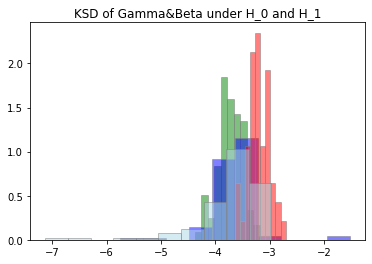

In [ ]:
plt.hist(res_1,color = "g", ec="grey",density = True,label = "gamma H_0",alpha = 0.5)
plt.hist(res_2,color = "b", ec="grey",density = True,label = "beta H_0",alpha = 0.5)
plt.hist(res_3,color = "r", ec="grey",density = True,label = "gamma H_1",alpha = 0.5)
plt.hist(res_4,color = "lightblue", ec="grey",density = True,label = "beta H_1",alpha = 0.5)
plt.title("KSD of Gamma&Beta under H_0 and H_1")
plt.show()

#### Data

In [ ]:
#ga_ga: KSD of Gamma, where sample is follow Gamma(k=8,theta=0.05)
#be_be: KSD of Beta, where sample is follow Beta(alpha=5,beta=2)
# Sizz: 100

ga_ga = np.array([-3.83942209,-3.58873067,-3.99876872,-3.5262008,-3.45763606,-3.52515002,-3.8449574,-3.57735289,-3.57068333,-3.54667703,-3.69918517,-3.76786311,-4.16558624,-3.54820922,-3.94412873,-3.81398763,-4.0878492,-3.85746896,-3.62882632,-3.56666759,-3.94127812,-3.91014395,-3.49598498,-3.38246076,-3.75850206,-3.47829461,-3.64918705,-4.50085269,-3.61847183,-3.63100202,-3.78670656,-3.52309601,-3.55329813,-3.66277859,-3.8929359,-3.75460418,-3.86844533,-3.32342852,-3.69629294,-3.84206122,-3.95080926,-3.66857682,-3.84625204,-3.84961686,-3.79485432,-3.83492518,-3.92762145,-3.89752143,-3.74747346,-4.12038673,-3.55877193,-3.54409946,-3.46576319,-3.89084922,-3.76500743,-3.66169266,-3.75879856,-3.63926075,-3.79104805,-3.72636988,-3.56258216,-3.46233398,-3.48077844,-3.66523582,-4.00988684,-3.86354876,-4.02154302,-3.46411192,-3.35716251,-3.77583053,-3.66277536,-3.55341543,-3.61049334,-3.7787053,-3.39694765,-3.55395727,-3.70533064,-3.8719577,-3.85258321,-3.87378654,-3.90306526,-3.61364149,-3.96119922,-3.63635741,-3.58384905,-3.78930214,-3.60727683,-3.7737436,-3.85466622,-3.80720486,-3.84771745,-3.928134,-3.75697777,-3.81508559,-3.7723293,-3.43933374,-3.87358478,-3.91105476,-3.84659932,-3.78885019])
be_ga = np.array([-3.72207824,-4.13362895,-3.83889026,-3.44586932,-3.29236771,-3.38714437,-3.71138995,-3.47782277,-3.37729386,-3.3800992,-3.50247105,-4.00351089,-3.96169687,-3.50377676,-3.86559894,-3.71051604,-3.95808173,-3.65975792,-3.45607503,-3.50058134,-3.80970889,-3.77916045,-4.4256075,-3.24282313,-3.68541758,-3.41172046,-3.42571661,-4.33830921,-3.57766564,-3.52333213,-4.20444521,-3.24467917,-3.32848936,-3.50178175,-3.77889875,-3.58999722,-3.75884627,-3.17276041,-3.51288076,-3.70959245,-3.86064198,-3.5370921,-3.7190016,-3.71749207,-3.73748463,-3.7087691,-3.85398158,-3.76793977,-3.64102977,-3.98821324,-3.43050426,-3.47083599,-3.35890708,-3.80031511,-3.69528454,-3.49583379,-3.65051055,-3.47736648,-3.69672316,-3.59787583,-3.47683403,-3.34507871,-3.36931849,-3.59734904,-3.92596809,-3.85792492,-3.90828194,-3.42177502,-3.19576524,-3.57815906,-3.65720051,-3.55707078,-3.55018829,-3.63403072,-3.2818661,-3.42539086,-3.56211633,-3.67261649,-3.82451221,-3.78058838,-3.81715888,-2.35239327,-3.68620617,-3.5039491,-3.43835227,-3.66272328,-3.52590843,-3.66699759,-3.69588576,-3.62406446,-3.72271411,-3.77406033,-3.61686454,-3.61761086,-3.6375,-3.53167237,-3.72221093,-3.81341933,-3.70651357,-3.68161432])
ga_be = np.array([-2.90340782,-3.02493316,-3.12148069,-3.21866386,-3.59593692,-3.27549777,-3.1838856,-3.38760244,-3.222668,-3.55411719,-3.20645608,-3.3325826,-3.21677138,-3.21086201,-3.21722678,-3.29629368,-3.26334995,-3.36743372,-3.35272437,-3.17352187,-2.98221459,-3.15940239,-2.99358331,-3.19261378,-3.03845771,-3.26438474,-3.19282318,-3.36205262,-3.31060544,-3.30907767,-3.08152235,-3.29140332,-3.29589959,-3.46601291,-3.34227092,-3.21315414,-3.02723623,-3.33973597,-3.10593198,-3.53703107,-2.72300302,-3.33323029,-3.16317216,-3.46242145,-3.47900324,-3.13433534,-3.74216889,-2.96780129,-3.06793601,-3.64561784,-3.03599261,-3.29946069,-3.02950637,-3.35876627,-3.45140675,-3.17765822,-3.5513919,-3.31759956,-3.39834025,-3.27232346,-3.13762494,-3.22298291,-3.2181703,-2.9973559,-3.14628393,-3.45823561,-3.29989763,-3.56677498,-3.32564872,-3.31131873,-2.94798391,-3.46009389,-3.16588517,-3.37542973,-3.57799789,-3.2581873,-3.08520424,-2.97559857,-3.34324562,-3.068526,-3.26040831,-3.5790563,-3.25825938,-3.20106869,-3.50467613,-3.1457527,-3.09013483,-3.13612658,-3.18117394,-3.3018051,-3.35194471,-3.32904784,-3.44922705,-3.24667398,-2.80229466,-3.40125021,-3.17783088,-2.93102696,-3.59439659,-3.0393575])
be_be = np.array([-3.47414718,-3.41525636,-4.56452356,-3.60656308,-4.00770994,-3.59731556,-3.89722862,-5.37367133,-4.14728239,-4.14371763,-7.24735037,-3.80249655,-6.71832517,-3.40902281,-3.45814322,-3.36623513,-3.52582658,-3.49166953,-3.58858154,-3.59289929,-3.16753284,-3.86152914,-3.32551161,-3.36674906,-3.34255179,-3.45708178,-3.59936908,-3.71829488,-3.57031753,-3.82104152,-3.31049766,-3.61090625,-3.93984488,-3.83615621,-3.76723879,-3.38632544,-3.34087519,-4.11518801,-3.32770303,-3.94386048,-3.03454332,-3.62873956,-3.53143373,-3.76059594,-3.65230774,-4.49651515,-4.03933427,-3.38547057,-3.1234501,-3.74270642,-3.23099812,-3.53897804,-4.95767665,-3.65901988,-3.74457819,-3.65837827,-5.31075182,-4.15070003,-3.76905222,-3.63089019,-3.32680932,-3.68462188,-3.98544839,-3.40766071,-3.39068062,-5.90420956,-3.50003556,-3.81351414,-4.47572693,-3.51107754,-3.10113686,-4.05099578,-3.93447864,-3.81390191,-3.79815114,-3.46346608,-3.31263188,-3.48033379,-3.50773539,-3.36971011,-3.43511907,-4.65456129,-3.46345217,-4.09606444,-3.86926794,-3.34644022,-3.24719118,-3.53101623,-3.52632901,-5.39997213,-3.66321804,-3.78798706,-3.83504024,-3.65453614,-3.09180191,-3.56980874,-3.48997237,-3.23375352,-6.06860827,-3.3208654])

In [ ]:
ga_ga = np.array([-3.595352  , -3.57340896, -3.84071315, -3.47399326, -3.85573354,
       -4.05673535, -3.90735374, -3.88784559, -3.64148279, -3.85622993,
       -3.43816792, -3.85272728, -3.90061709, -3.90789972, -3.83062234,
       -3.78908134, -4.12228184, -3.69372542, -4.21295186, -3.73021076,
       -3.37705055, -3.60095219, -3.50470374, -3.76533907, -3.77439384,
       -3.61393743, -4.14619405, -3.70544482, -3.8296951 , -3.98998805,
       -3.71899282, -3.93324494, -3.89483829, -3.8997577 , -3.42844871,
       -3.60276257, -4.12318532, -3.87253152, -3.83939209, -3.99069989,
       -3.91853757, -3.89842979, -4.06190799, -3.57302994, -3.80936692,
       -3.69969965, -3.43461578, -4.05208403, -3.87903296, -4.02405253,
       -3.43914778, -3.85363558, -3.62900657, -3.97436589, -4.21764268,
       -3.48651864, -3.43483391, -3.57363404, -3.3709808 , -3.98085855,
       -3.70355654, -3.90523167, -3.53360854, -3.79471534, -3.68597674,
       -3.81472634, -3.99671471, -4.00429251, -3.68559059, -3.68819812,
       -4.02793119, -3.57638182, -4.3548226 , -3.87582947, -3.96692187,
       -3.74621487, -3.90948169, -3.79524167, -3.46546323, -4.02666235,
       -3.5504956 , -3.34800618, -3.72947294, -3.98342979, -3.6520696 ,
       -4.10832439, -3.91780964, -4.02627186, -3.67719363, -3.99217242,
       -3.6615215 , -3.69414595, -3.92242322, -3.87889358, -3.77634317,
       -3.66674938, -4.12560428, -4.05577463, -3.64946819, -3.74632217,
       -4.04037108, -3.77886562, -3.3975057 , -4.00762316, -4.16042903,
       -4.22910162, -3.95872445, -4.14259899, -3.67455257, -3.7829039 ,
       -4.02066523, -3.52520264, -3.46528103, -3.56448198, -3.61530723,
       -3.31728337, -5.04138891, -3.99214377, -3.45261945, -3.73006717,
       -3.38068338, -3.93947426, -3.66773867, -3.45295492, -3.7376968 ,
       -3.47590172, -3.72967196, -3.91214696, -3.83373779, -3.59121667,
       -3.92490406, -3.77676972, -3.48777914, -3.77388974, -3.61728437,
       -3.90673583, -3.65930643, -3.88190612, -3.6319553 , -3.98640177,
       -3.577205  , -4.0797272 , -4.45254201, -3.66317942, -3.70014629,
       -3.8866999 , -3.60189697, -3.84634355, -3.27380224, -3.81145755,
       -3.54309138, -3.87453302, -3.94087859, -3.82083233, -3.57158549,
       -3.58374615, -3.72098357, -4.28362424, -3.89229346, -3.77024089,
       -3.52934599, -3.99366073, -4.2158122 , -3.65433178, -3.67424854,
       -3.69175475, -3.96067743, -3.58853396, -3.86548767, -3.7629936 ,
       -4.14403563, -3.73605618, -3.72004451, -3.78636674, -3.75285176,
       -3.86477766, -3.74253613, -3.64272087, -3.66965404, -3.58122035,
       -3.83762159, -3.95390162, -4.09876935, -3.68975015, -3.72893818,
       -3.73706079, -3.9211837 , -3.45352154, -3.86525938, -3.66653484,
       -3.43395006, -3.52464812, -3.75931894, -3.67206838, -4.17164868,
       -3.72962649, -3.49690307, -3.92299772, -3.83142044, -3.62019141,
       -4.05943146, -4.04250279, -3.60173353, -3.45952472, -3.91306839,
       -3.45777721, -4.23083738, -4.06315918, -3.67279409, -3.43768471,
       -3.55505791, -4.54588554, -3.86121995, -3.58291208, -3.87640971,
       -3.90087136, -3.67230261, -3.88745978, -3.78619146, -3.87939201,
       -3.37506577, -3.81731466, -3.8699658 , -3.92094721, -3.7333938 ,
       -3.76133245, -3.5025901 , -4.06753075, -3.62575471, -3.98129882,
       -3.76168972, -4.18822852, -4.05841063, -4.06737301, -3.95912537,
       -3.77781202, -4.68954312, -3.97205974, -3.87547102, -3.58002603,
       -4.18381069, -3.58471977, -3.68194114, -3.69323762, -3.97967471,
       -3.91039763, -3.93966339, -3.85613804, -3.50105141, -3.8346008 ,
       -3.55808337, -4.02280274, -4.21674404, -3.6362574 , -3.97049015,
       -3.77808111, -3.39423599, -3.88179929, -4.0095091 , -3.73545354,
       -3.7290525 , -3.90059353, -3.69923943, -3.70757293, -3.8692871 ,
       -3.68678947, -3.81243666, -3.88808687, -3.69200422, -3.3706434 ,
       -3.78519606, -3.65367333, -3.60582964, -3.7485681 , -3.80999311,
       -3.723144  , -3.36308725, -3.63126152, -3.43844361, -3.83362374,
       -3.79211036, -4.1965934 , -3.5290752 , -3.55311585, -3.66884578,
       -3.63980528, -3.9287066 , -4.2240024 , -3.76883404, -3.84977639,
       -3.95097243, -3.63743408, -3.61352097, -4.32499418, -3.94209965,
       -3.53804426, -3.79073152, -3.83344912, -3.46248023, -3.45565071])


In [ ]:
be_ga = np.array([-3.42365563, -3.58994433, -3.82765814, -3.39107875, -3.72870503,
       -3.93034335, -3.76419285, -3.83149096, -3.98731136, -2.21885666,
       -3.36953206, -3.78823384, -3.82709781, -3.78895864, -3.74550072,
       -3.6550565 , -3.93973406, -3.59191929, -4.12287802, -3.69971794,
       -3.2677155 , -3.48066739, -3.46713749, -3.68608042, -3.62886858,
       -3.53437921, -4.06075978, -3.58657117, -3.71684365, -3.75786247,
       -3.62161892, -3.84746228, -3.77225512, -4.06944852, -3.30939217,
       -3.43528672, -3.96193025, -3.74250879, -3.7270576 , -3.86426056,
       -3.55915154, -4.06517512, -3.88348069, -3.5040451 , -3.72988744,
       -3.62948449, -3.33911221, -3.91600646, -3.79789243, -3.8967122 ,
       -3.33831764, -3.68735497, -3.53542939, -3.83864515, -4.16592877,
       -3.61946331, -3.67217387, -3.50904405, -3.50619304, -3.77357303,
       -3.60845483, -3.76878923, -3.41816034, -3.62911875, -3.62357113,
       -3.61386752, -3.87454654, -3.89211444, -3.6072137 , -3.59938422,
       -3.80420153, -3.48822074, -4.20435703, -3.70740025, -3.84074432,
       -3.66969822, -3.77373626, -3.70616582, -3.38512396, -3.86540181,
       -3.52382121, -3.8392833 , -3.62846092, -3.73564496, -3.55864686,
       -3.89790294, -3.92376496, -3.87183681, -3.59977117, -3.86569285,
       -3.52486418, -3.53826877, -3.8134788 , -3.80559842, -3.69698787,
       -3.56583704, -3.80448611, -3.94089608, -3.55022261, -3.65912217,
       -3.90194177, -3.70621751, -2.34177702, -3.81221883, -4.24543351,
       -4.01001309, -4.26610487, -3.9180837 , -3.55214969, -3.66563966,
       -3.9595206 , -3.49676722, -3.37454828, -3.49654074, -3.57910701,
       -3.1951797 , -4.236873  , -3.91658738, -3.31539821, -3.549607  ,
       -3.26724019, -3.93423533, -3.5160569 , -3.31139117, -3.72308729,
       -3.35549628, -3.61663792, -3.76138996, -3.74674168, -3.53693481,
       -3.76341706, -3.69730828, -3.39053228, -3.66744567, -3.48477173,
       -3.92430691, -3.52255328, -3.77940976, -3.6019117 , -3.88052277,
       -3.45251534, -3.93016135, -4.28708373, -3.38753309, -3.5749909 ,
       -3.78271619, -3.45429223, -3.75667567, -3.36054714, -3.71386686,
       -3.90996718, -3.68966033, -3.91483143, -3.70335252, -3.39888199,
       -3.43108955, -3.60759057, -4.08145823, -3.7930864 , -3.6424575 ,
       -3.32857756, -3.87136444, -4.30760748, -4.10432908, -3.55954618,
       -3.57087662, -3.66258677, -3.38988652, -3.73236445, -3.6115964 ,
       -3.84753232, -3.64817223, -3.63677739, -3.61740874, -3.60216849,
       -3.7602523 , -3.63748094, -3.56858842, -3.55286532, -3.49593047,
       -3.84984985, -3.81438803, -3.96758326, -3.59354556, -3.60079563,
       -3.59183407, -4.00476474, -3.55416136, -3.83442176, -3.53350289,
       -3.46141652, -3.39894683, -3.66441135, -3.53817656, -4.09131112,
       -3.59984142, -3.40987101, -3.82880563, -3.68995426, -3.45262913,
       -3.92885291, -3.90241053, -3.44172849, -6.08295651, -3.73120335,
       -3.37552393, -4.10418018, -3.92313702, -3.61110459, -3.33154981,
       -3.95274041, -4.2320746 , -3.69776792, -3.56323822, -3.67317599,
       -3.72654345, -3.508432  , -3.72620701, -3.70633917, -3.79025765,
       -3.23089117, -3.65445841, -3.71322205, -3.87535069, -3.64175635,
       -3.63374166, -3.26388551, -3.90545501, -3.54969161, -3.82235131,
       -3.67405922, -4.00531129, -3.90603224, -4.09669525, -3.85190782,
       -3.67830885, -4.18614709, -3.79413536, -3.53938805, -3.67429505,
       -4.00826964, -4.28984406, -3.62610154, -3.70819734, -3.85477046,
       -3.80471435, -3.83466637, -3.73348331, -3.3380018 , -3.69663842,
       -3.44475774, -3.90683831, -4.07764299, -3.49060947, -3.79885303,
       -3.70177272, -3.36686214, -3.79351922, -3.82147211, -4.12844457,
       -3.59687325, -3.77131292, -3.6432145 , -3.51127124, -3.7790332 ,
       -3.54107965, -3.71913945, -3.74850251, -3.59481363, -3.24774296,
       -3.69276926, -3.57547814, -3.51194063, -3.65179562, -3.74985891,
       -3.59339909, -3.24307969, -3.55073713, -3.33074531, -3.72996551,
       -3.67246245, -4.08549111, -3.47177459, -3.42628153, -4.28394459,
       -3.87631398, -6.94919016, -4.02407822, -3.73903225, -2.0750422 ,
       -3.79314127, -3.48943817, -3.53872084, -4.17702548, -2.06584428,
       -4.1702017 , -3.64376205, -3.64473475, -3.26869131, -3.31769056])

In [ ]:
ga_be = np.array([-3.28308127, -3.34236722, -3.12494108, -3.12308568, -2.99147217,
       -3.04504398, -2.89102013, -3.31958573, -3.42001122, -3.0945133 ,
       -3.43878798, -2.93805714, -3.21398621, -3.0305546 , -3.26285019,
       -3.35933133, -3.00860291, -3.39532482, -3.01975216, -3.41328433,
       -3.46897844, -3.34056542, -3.15469903, -3.23267677, -3.07846684,
       -3.27989821, -3.30449419, -3.29445839, -3.60374031, -3.33830981,
       -3.60820184, -3.121244  , -2.94312298, -3.34998706, -3.05519432,
       -3.27246862, -3.2379221 , -3.15884634, -3.1586734 , -3.25736019,
       -3.24388597, -3.27327184, -2.96274169, -3.68484555, -3.17184082,
       -3.11373838, -3.19328608, -3.39496157, -3.28026534, -3.29829349,
       -3.69564502, -3.14252288, -3.32081739, -3.27926678, -3.39754423,
       -3.16383385, -3.38636069, -2.90636945, -3.09546332, -2.93225009,
       -2.98645385, -3.16448948, -3.76230055, -3.21619155, -3.00978942,
       -3.07525401, -3.01023879, -3.38759469, -2.91395242, -3.23455747,
       -2.88672784, -3.43863708, -3.19531968, -3.36645126, -3.16418354,
       -3.05470642, -3.5942416 , -3.09472015, -3.37029539, -3.08953827,
       -3.19769747, -3.46652217, -2.83115525, -3.39000379, -3.34427175,
       -3.13213015, -3.01055595, -3.29065515, -3.24875154, -3.36566302,
       -3.04428348, -3.12624382, -3.44393769, -3.09066659, -3.05897053,
       -2.82659556, -3.25687883, -3.03520918, -3.20265001, -3.07676473,
       -3.36073475, -3.14885024, -3.07105809, -3.37517433, -3.27961475,
       -3.44936086, -3.08287575, -3.33678424, -2.92648091, -3.04953484,
       -2.72785511, -3.17204161, -3.25068515, -3.08083582, -3.30875059,
       -2.9533262 , -3.17648612, -3.18592797, -3.37700766, -3.21476655,
       -3.45544657, -3.59321873, -3.00316445, -2.99584282, -3.22961162,
       -3.03109929, -3.47276071, -3.11626054, -3.5776002 , -3.15622749,
       -3.36985128, -3.01251513, -3.091652  , -3.19142081, -3.28860012,
       -3.14800169, -3.44877936, -2.97640537, -3.49409821, -3.4241057 ,
       -3.69121072, -3.13709996, -3.31900759, -3.14731218, -3.16702764,
       -2.88496637, -3.32304886, -3.1141445 , -3.38913342, -3.26798314,
       -3.35446951, -3.28657787, -3.16856384, -3.27139907, -3.32758044,
       -3.54688059, -3.15234863, -3.41846432, -3.39409945, -3.35151135,
       -3.43006548, -2.96675971, -3.40084652, -3.00115372, -3.35872961,
       -3.02747858, -3.41275815, -3.47971141, -3.33238905, -3.19122541,
       -3.16973778, -3.07696188, -2.84607996, -3.13423719, -3.4349479 ,
       -3.13032951, -3.26800552, -3.19839169, -2.77531558, -3.09204979,
       -3.03491826, -3.1011223 , -2.96012232, -3.04969654, -3.08567942,
       -3.1098035 , -2.98728776, -3.26363068, -2.98188391, -3.02302851,
       -3.41641781, -3.31944238, -3.23564154, -2.84832965, -2.97990945,
       -3.28276189, -3.05704276, -2.94544847, -3.23407029, -3.3485141,
       -3.42546262, -3.65113257, -3.00186314, -3.11698707, -3.08125699,
       -3.03163743, -3.10033889, -3.58868316, -3.30991749, -3.2346849 ,
       -3.64668614, -3.37528917, -3.32614285, -3.23207016, -3.22469344,
       -3.50245711, -3.49064101, -3.04381352, -3.15257542, -3.15316637,
       -3.43490291, -3.27443702, -3.03141599, -3.0133493 , -3.32236511,
       -3.121517  , -3.54429579, -3.09712681, -3.3287409 , -3.15892753,
       -3.37310417, -3.35161342, -3.19307375, -3.36097304, -3.31732694,
       -3.02434166, -2.87321364, -3.56241405, -3.2003043 , -2.91707334,
       -3.30300431, -2.91451974, -3.29833524, -3.03931511, -3.4042989 ,
       -3.54001882, -3.42038716, -3.26588088, -3.40103576, -3.38907617,
       -3.23380687, -3.3015398 , -2.80036982, -3.55962112, -2.97449615,
       -2.94058139, -3.2517343 , -2.94715676, -2.99008117, -3.591082  ,
       -3.17417611, -3.31096005, -3.24498706, -2.65852002, -3.3595247 ,
       -3.32460551, -3.15236407, -3.49363664, -3.12186806, -3.53922185,
       -2.84476358, -3.27431852, -3.09844922, -2.93949912, -3.092724  ,
       -3.26131265, -2.99890747, -3.18418704, -3.5096662 , -3.6849425 ,
       -2.9961733 , -3.58964396, -3.27886469, -3.24037376, -3.07460764,
       -3.55624853, -3.12830413, -2.9968059 , -3.37252547, -3.31464056,
       -2.99988474, -3.37614709, -3.10647004, -3.51856662, -3.18628852,
       -3.24401744, -3.24255305, -2.94713233, -3.07694795, -3.26025441])

In [ ]:
be_be = np.array([-4.04366812, -3.52076374, -3.41492209, -3.42745585, -3.18528352,
       -3.48727287, -3.58545848, -3.67594208, -3.87969679, -3.30158747,
       -3.46777522, -3.47975604, -3.94278107, -3.28499149, -3.67721278,
       -3.51273046, -3.63511415, -3.60505866, -3.30446474, -3.58650858,
       -3.73209964, -3.97647988, -3.5371882 , -3.82807369, -3.29914591,
       -3.63523079, -3.6224075 , -3.65800904, -3.91549413, -4.42534081,
       -3.84742884, -3.39967334, -3.34759912, -3.5854646 , -3.36045385,
       -3.72699491, -3.39515128, -3.46105316, -4.15384685, -3.68070438,
       -3.79439227, -3.85831081, -3.25844361, -4.69345194, -3.47873944,
       -5.86335372, -3.464808  , -3.6065673 , -4.01454887, -3.67789413,
       -4.17510288, -4.12782068, -3.81261919, -3.84858584, -3.63348759,
       -3.42708535, -4.11124244, -3.28759295, -3.18868077, -3.18841627,
       -3.31188512, -5.16135878, -4.04457958, -3.45500694, -3.57937827,
       -3.55588114, -3.45970301, -3.83095212, -3.11036815, -3.48217213,
       -3.53013409, -3.77715018, -3.32595447, -3.67388318, -3.99223756,
       -3.26212021, -3.92874818, -3.35593951, -3.67034761, -3.31488518,
       -3.37205595, -3.62361686, -3.01621625, -5.23081762, -4.02971019,
       -3.31209891, -3.35999969, -3.50932943, -3.7456693 , -4.64374184,
       -3.29916986, -3.40893532, -4.37324817, -4.35090508, -3.72091209,
       -3.09618592, -3.87020537, -3.30947903, -3.43750324, -3.41200123,
       -3.62115007, -3.44045096, -3.59913836, -3.4109488 , -3.34099019,
       -3.82625081, -3.4646869 , -3.61733911, -3.35273214, -3.29656634,
       -3.25875262, -4.17185148, -3.73808309, -3.59106538, -3.47249157,
       -5.00008277, -3.53326707, -3.70724887, -3.48041949, -3.38018816,
       -3.8207652 , -3.96527715, -3.149153  , -3.18778596, -3.43161991,
       -3.42144128, -4.18857639, -3.57400575, -4.39809591, -3.39066178,
       -3.66664785, -3.28931608, -3.2536133 , -3.53363214, -4.76153136,
       -3.97086188, -4.33306295, -3.54148851, -4.07381499, -3.79709984,
       -8.67520411, -3.58306462, -3.56009044, -5.59664868, -3.54307507,
       -3.32018451, -3.62489754, -3.23876967, -3.56379455, -3.53710735,
       -3.79877503, -3.64087018, -3.33336998, -3.58063538, -3.67877931,
       -4.35285148, -3.6499604 , -4.29265506, -4.09835162, -4.29342284,
       -4.2047333 , -3.32777331, -3.74107018, -3.38046763, -3.97176143,
       -4.11412496, -4.72673673, -3.77395917, -3.80006334, -3.58180841,
       -5.79069918, -3.85441101, -3.38882294, -3.26946614, -3.80697273,
       -4.01112692, -3.5290448 , -3.35089882, -2.98944488, -3.5402673 ,
       -3.3631304 , -3.4416191 , -3.15500472, -3.27022176, -3.17795441,
       -3.51058476, -3.42233475, -7.26404899, -3.24248014, -3.6343807 ,
       -3.83414394, -3.89792823, -3.67536616, -3.0898369 , -3.71083392,
       -3.54661506, -3.26674368, -3.41071171, -3.65266012, -4.19510317,
       -3.59663409, -3.80933773, -3.60270359, -3.26396366, -3.29697104,
       -3.17098166, -3.64511239, -3.91260538, -3.70232445, -3.4610263 ,
       -3.88165088, -3.78820005, -3.7762285 , -4.1887589 , -3.34857706,
       -4.00327124, -3.98757155, -3.71937682, -3.57264324, -3.25175627,
       -3.61485588, -3.98983719, -3.32502383, -3.33682655, -4.61269848,
       -3.24435872, -3.60471829, -3.74232964, -3.51896272, -3.52761306,
       -3.74070092, -5.73384059, -3.68458438, -3.70077593, -3.55200104,
       -3.5835447 , -3.31776735, -4.11296341, -3.48570074, -3.46624686,
       -3.45674769, -3.26733988, -3.55731661, -3.20317964, -3.76868018,
       -3.68645981, -3.69103896, -6.92174559, -3.84848239, -3.74773065,
       -3.6225949 , -4.04339411, -3.62808237, -4.44159522, -4.07388795,
       -3.25132533, -5.21305341, -3.5301023 , -3.17398899, -3.85376525,
       -4.17485012, -3.57371063, -3.3405562 , -3.12494671, -3.89460954,
       -3.77642866, -3.33737139, -4.61514687, -3.36367821, -3.79058369,
       -3.09613018, -3.55477165, -4.46567436, -3.33601485, -3.35768714,
       -5.0383636 , -3.20613852, -3.37673818, -3.89002605, -4.13331846,
       -3.29107062, -3.88218498, -3.47588196, -3.44417994, -3.71340674,
       -3.87576979, -3.32168595, -3.44755004, -3.56844619, -3.74205997,
       -3.50554719, -3.58350921, -3.9809275 , -4.03417204, -3.37225159,
       -4.80415261, -3.72914178, -3.19033802, -3.5425667 , -3.73314663])

### 5.2 Normal v.s. Gamma

In [ ]:
def normal_pdf(x,u,sig):
  return np.exp(-(x - u) ** 2 / (2 * sig ** 2)) / (math.sqrt(2*math.pi)*sig)

def gamma_pdf(x,k,theta):
  return (x**(k-1) * np.exp(-1*x/theta))/(theta**k * np.math.factorial(int(k)-1))

def plot_result(R_n,mu,sigma,k,theta):
  x = np.linspace(np.min(R_n), np.max(R_n), 50); y1 = [normal_pdf(i,mu,sigma) for i in x]
  plt.plot(x, y1, "g", linewidth=2,label = "Normal") #draw the density of the model P

  y2 = [gamma_pdf(i,k,theta) for i in x]
  plt.plot(x, y2, "r", linewidth=2,label = "Gamma") #draw the density of the model P
  
  plt.hist(R_n,color = "lightgrey", ec="grey",density = True)
  plt.legend()
  plt.show()
# R_n = np.random.gamma(2,2,n)
# plot_result(R_n,2.5,1,2,2)
# [plot_hist(i) for i in [50,100,150] ]

KSD(P||R): -0.037940787557524745 KSD(Q||R): -0.03734779286680301
u_pq:  0.0005929946907217362
Estimate Sigma:  0.02613184379965832
test_stat:  0.22692416779618504

0.4102413545206507
Accept the Hypothesis  P-value =  0.4102413545206507
Time cost:  38.820425033569336


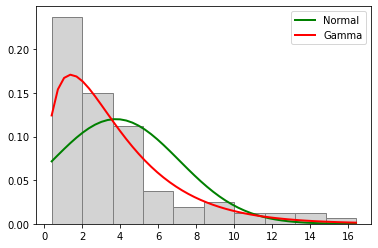

KSD(P||R): -0.0004161486386934277 KSD(Q||R): 0.007416899592520897
u_pq:  -0.007000750953827469
Estimate Sigma:  0.09268120196111156
test_stat:  -0.9251211297613101

0.8225485484117534
Accept the Hypothesis  P-value =  0.8225485484117534
Time cost:  87.91956329345703


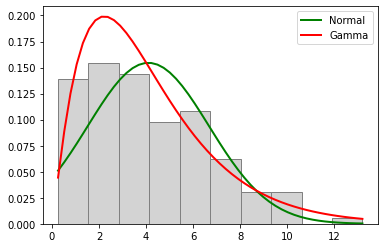

KeyboardInterrupt: ignored

In [ ]:


def experiment(n):
  a = time.time()
  imq_kernel = Kernel("simple_IMQ",l = 0.7)
  # R_n = np.random.normal(3,1,n)
  R_n = np.random.gamma(2,2,n)

  #1. Estimate the parameter by using Min-KSD-estimator for normal model 
  normal_txdx = lambda x: np.array([1,2*x],dtype = float).reshape(-1,1)
  normal_bxdx = lambda x: 0
  normal_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = normal_txdx,bxdx = normal_bxdx)
  natural_para = normal_min_ksd_estimator.theta_star(R_n)
  normal_para = normal_min_ksd_estimator.normal_Inverse_parameter_mapping(natural_para)
  normal_mu = normal_para[0]; normal_sigma = normal_para[1];
  print("Normal: Parameter Estimation of Finished:")
  print("Mean:",normal_mu,"Sigma:",normal_sigma) 

  #2. Build a model
  model_1 = Exponential_Family(model_name = "normal",kernel = imq_kernel,mu=normal_mu,sigma=normal_sigma)

  #1. Estimate the parameter by using Min-KSD-estimator for Gamma model 
  gamma_txdx = lambda x: np.array([1/x,1],dtype = float).reshape(-1,1)
  gamma_bxdx = lambda x: np.array(0,dtype = float)
  gamma_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = gamma_txdx,bxdx = gamma_bxdx)
  gamma_natural_para = gamma_min_ksd_estimator.theta_star(R_n)
  gamma_para = gamma_min_ksd_estimator.gamma_Inverse_parameter_mapping(gamma_natural_para)
  gamma_k = gamma_para[0]; gamma_theta = gamma_para[1];
  print("Gamma: Parameter Estimation of Finished:")
  print("k(shape):",gamma_k,"Theta(scale):",gamma_theta,"\n") 

  #2. Build a model
  model_2 = Exponential_Family(model_name= "gamma",kernel = imq_kernel,k=gamma_k,theta=gamma_theta)

  relative_test(model_1,model_2,R_n)
  b = time.time()
  print("Time cost: ",b-a)
  plot_result(R_n,normal_mu,normal_sigma,gamma_k,gamma_theta)
  print("================================")

n_list = np.arange(start = 100,stop = 300,step = 50)
for n in n_list: experiment(n)

  0%|          | 0/2 [00:00<?, ?it/s]

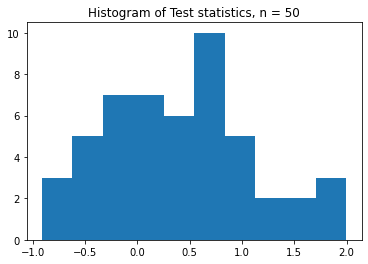

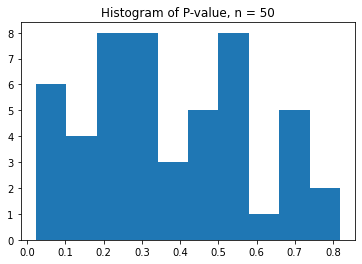

 50%|█████     | 1/2 [14:41<14:41, 881.69s/it]

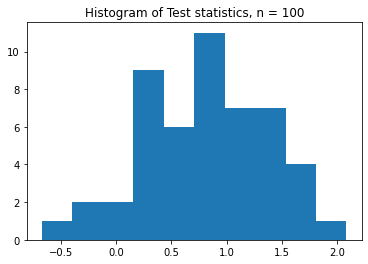

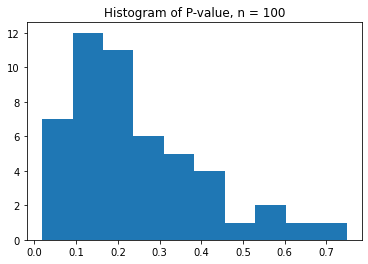

100%|██████████| 2/2 [1:13:35<00:00, 2207.94s/it]


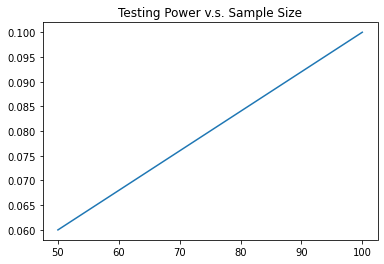

In [ ]:
def build_two_model(R_n):
  #1. Estimate the parameter by using Min-KSD-estimator for normal model 
  normal_txdx = lambda x: np.array([1,2*x],dtype = float).reshape(-1,1)
  normal_bxdx = lambda x: 0
  normal_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = normal_txdx,bxdx = normal_bxdx)
  natural_para = normal_min_ksd_estimator.theta_star(R_n)
  normal_para = normal_min_ksd_estimator.normal_Inverse_parameter_mapping(natural_para)
  normal_mu = normal_para[0]; normal_sigma = normal_para[1];
  # print("Normal: Parameter Estimation of Finished:")
  # print("Mean:",normal_mu,"Sigma:",normal_sigma) 
  #2. Build a model
  model_1 = Exponential_Family(model_name = "normal",kernel = imq_kernel,mu=normal_mu,sigma=normal_sigma)

  #1. Estimate the parameter by using Min-KSD-estimator for Gamma model 
  gamma_txdx = lambda x: np.array([1/x,1],dtype = float).reshape(-1,1)
  gamma_bxdx = lambda x: np.array(0,dtype = float)
  gamma_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = gamma_txdx,bxdx = gamma_bxdx)
  gamma_natural_para = gamma_min_ksd_estimator.theta_star(R_n)
  gamma_para = gamma_min_ksd_estimator.gamma_Inverse_parameter_mapping(gamma_natural_para)
  gamma_k = gamma_para[0]; gamma_theta = gamma_para[1];
  # print("Gamma: Parameter Estimation of Finished:")
  # print("k(shape):",gamma_k,"Theta(scale):",gamma_theta,"\n")

  #2. Build a model
  model_2 = Exponential_Family(model_name= "gamma",kernel = imq_kernel,k=gamma_k,theta=gamma_theta)

  return [model_1,model_2]



def composite_relative_test(kernel,n,m): #kernel choice, sample size, number of experiment
  testing_result = np.zeros(m)
  test_stat_result = np.zeros(m)
  p_result = np.zeros(m)
  for i in range(m):
    R_n = np.random.gamma(2,2,n) # random sample 
    two_model = build_two_model(R_n)
    model_1 = two_model[0]; model_2 = two_model[1]
    [testing_result[i],test_stat_result[i],p_result[i]] = relative_test(model_1,model_2,R_n)
  return [testing_result,test_stat_result,p_result]



imq_kernel = Kernel("simple_IMQ",l = 0.7)
n_list = np.arange(start = 50,stop = 150,step = 50)
power = np.zeros(len(n_list))
m = 50
for i in trange(len(n_list)):
  n = n_list[i] 
  [a,b,c] = composite_relative_test(imq_kernel,n,m = m)
  plt.hist(b)
  title = "Histogram of Test statistics, n = " + str(n)
  plt.title(title)
  plt.show()
  title = "Histogram of P-value, n = " + str(n)
  plt.hist(c)
  plt.title(title)
  plt.show()
  a = np.array(a)
  power[i] = np.sum(a)/m


plt.plot(n_list,power)
plt.xlabel = "Sample Size"
plt.ylabel = "Testing Power"
plt.title("Testing Power v.s. Sample Size")
plt.show()

In [ ]:
power

array([0.06, 0.1 ])

### 5.3 Two Gaussian with different Sigma

In [ ]:
def build_model(kernel,R_n,sigma):
  normal_txdx = lambda x: np.array(1/sigma)
  normal_bxdx = lambda x: -1*x/(sigma**2)
  normal_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = normal_txdx,bxdx = normal_bxdx)
  natural_para = normal_min_ksd_estimator.theta_star(R_n)
  normal_mu = normal_min_ksd_estimator.normal_with_sigma_Inverse_parameter_mapping(natural_para,sigma)
  print("Sigma = ",sigma," Estimation of Mean:",normal_mu,"\n") 
  model = Exponential_Family(model_name = "normal",kernel = kernel,mu=normal_mu,sigma= sigma)
  print(model)
  return model



def composite_relative_test(kernel,n,m): #kernel choice, sample size, number of experiment
  testing_result = np.zeros(m)
  test_stat_result = np.zeros(m)
  p_result = np.zeros(m)
  for i in trange(m):
    R_n = np.random.normal(3,1,100)
    model_1 = build_model(kernel,R_n,1.5)
    model_2 = build_model(kernel,R_n,2.0)

    [testing_result[i],test_stat_result[i],p_result[i]] = relative_test(model_1,model_2,R_n)
  return [testing_result,test_stat_result,p_result]


imq_kernel = Kernel("simple_IMQ",l = 0.7)
[a,b,c] = composite_relative_test(imq_kernel,100,m = 1)



# imq_kernel = Kernel("simple_IMQ",l = 0.7)
# # n_list = np.arange(start = 5,stop = 15,step = 5)
# n_list = [100]
# power = np.zeros(len(n_list))
# m = 50
# for i in range(len(n_list)):
#   n = n_list[i] 
#   [a,b,c] = composite_relative_test(imq_kernel,n,m = m)
#   plt.hist(b)
#   title = "Histogram of Test statistics, n = " + str(n)
#   plt.title(title)
#   plt.show()
#   title = "Histogram of P-value, n = " + str(n)
#   plt.hist(c)
#   plt.title(title)
#   plt.show()
#   a = np.array(a)
#   power[i] = np.sum(a)/m


# plt.plot(n_list,power)
# plt.xlabel = "Sample Size"
# plt.ylabel = "Testing Power"
# plt.title("Testing Power v.s. Sample Size")
# plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

Sigma =  1.5  Estimation of Mean: [1.59190817] 

Model Type: normal Mean: [1.59190817] Sigma: 1.5
Sigma =  2.0  Estimation of Mean: [1.58955227] 

Model Type: normal Mean: [1.58955227] Sigma: 2.0
KSD(P||R): 0.2210729654754797 KSD(Q||R): -0.0034382601405257554
u_pq:  0.21763470533495394


100%|██████████| 1/1 [00:49<00:00, 49.13s/it]

Estimate Sigma:  0.3133787568330679
test_stat:  6.944781692745199

1.8952617253376047e-12
Reject the Hypothesis  P-value =  1.8952617253376047e-12


100%|██████████| 9/9 [02:40<00:00, 17.81s/it]


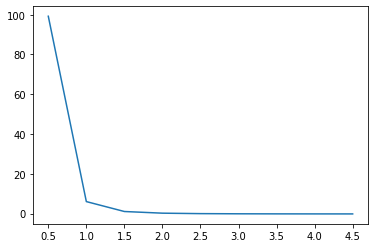

In [ ]:
R_n = np.random.normal(0,1,100)
imq_kernel = Kernel("simple_IMQ",l = 0.7)
sigs = np.arange(0.5,5,0.5)
res = np.zeros(len(sigs))
for i in trange(len(sigs)):
  sigma = sigs[i]
  model = Exponential_Family(model_name = "normal",kernel = imq_kernel,mu=3,sigma= sigma)
  res[i] = model.compute_KSD_with_Q(R_n)

plt.plot(sigs,res)


## One-dimensional Experiement

In [ ]:
#Compare normal distribution and Log-normal distribution
n = 200 #sample size
imq_kernel = Kernel("simple_IMQ", l = 0.7)
# Q_n = np.random.normal(10,1,n)
# Q_n = Q_n[Q_n>0]
Q_n = np.random.gamma(shape = 9,scale=0.5,size = n)


#1. Estimate the parameter by using Min-KSD-estimator for normal model 
normal_txdx = lambda x: np.array([1,2*x],dtype = float).reshape(-1,1)
normal_bxdx = lambda x: 0
normal_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = normal_txdx,bxdx = normal_bxdx)
natural_para = normal_min_ksd_estimator.theta_star(Q_n)
normal_para = normal_min_ksd_estimator.normal_Inverse_parameter_mapping(natural_para)
normal_mu = normal_para[0]; normal_sigma = normal_para[1];
print("Normal: Parameter Estimation of Finished:")
print("Mean:",normal_mu,"Sigma:",normal_sigma) 
#2. Build a model
model_1 = Exponential_Family(model_name = "normal",kernel = imq_kernel,mu=normal_mu,sigma=normal_sigma)


#1. Estimate the parameter by using Min-KSD-estimator for Gamma model 
gamma_txdx = lambda x: np.array([1/x,1],dtype = float).reshape(-1,1)
gamma_bxdx = lambda x: np.array(0,dtype = float)
gamma_min_ksd_estimator = min_ksd_exponential(kernel = imq_kernel, txdx = gamma_txdx,bxdx = gamma_bxdx)
gamma_natural_para = gamma_min_ksd_estimator.theta_star(Q_n)
gamma_para = gamma_min_ksd_estimator.gamma_Inverse_parameter_mapping(gamma_natural_para)
gamma_k = gamma_para[0]; gamma_theta = gamma_para[1];
print("Gamma: Parameter Estimation of Finished:")
print("k(shape):",gamma_k,"Theta(scale):",gamma_theta) 
#2. Build a model
model_2 = Exponential_Family(model_name= "gamma",kernel = imq_kernel,k=gamma_k,theta=gamma_theta)


#Compute the KSD for two model:
ksd_1 = model_1.compute_KSD_with_Q(Q_n)
ksd_2 = model_2.compute_KSD_with_Q(Q_n)
print(ksd_1,ksd_2)

Normal: Parameter Estimation of Finished:
Mean: [4.42037464] Sigma: [1.61280995]
Gamma: Parameter Estimation of Finished:
k(shape): [8.45996672] Theta(scale): [0.53879555]
-0.01599780342349582 -0.05629314008523363


In [ ]:
mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 1000)
import matplotlib.pyplot as plt
# count, bins, ignored = plt.hist(s, 100, density=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

S = np.log(s)

np.std(S)

# plt.plot(x, pdf, linewidth=2, color='r')
# plt.axis('tight')
# plt.show()

0.983155354789118

In [ ]:
def normal_pdf(x,u,sig):
  return np.exp(-(x - u) ** 2 / (2 * sig ** 2)) / (math.sqrt(2*math.pi)*sig)

def random_normal_data(n,u,sig):
  X = np.random.normal(u,sig,n)
  Y = [normal_pdf(i,u,sig) for i in X]
  return [X,Y]

def plot_normal_case(u,sig,n,ksd_value):
  [nx,ny] = random_normal_data(n,u,sig)
  x = np.linspace(u - 3*sig, u + 3*sig, 50); y = [normal_pdf(i,u,sig) for i in x]

  plt.figure(num=3,figsize=(8,5))
  plt.xlabel('x')
  plt.ylabel('p(x)')
  plt.xlim((0,6))
  plt.ylim((0,0.6))

  l1 = plt.plot(x, y, "g", linewidth=2) #draw the density of the model P
  l2 = plt.plot(nx,ny,'o',color = 'r') #draw the data point Q
  plt.title("KSD:%s"%(ksd_value))
  plt.legend([l1,l2],labels=["Model","Sample"],loc='best')
  plt.grid(True)
  plt.show()

-0.20674141820495318 -0.10864083723349285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


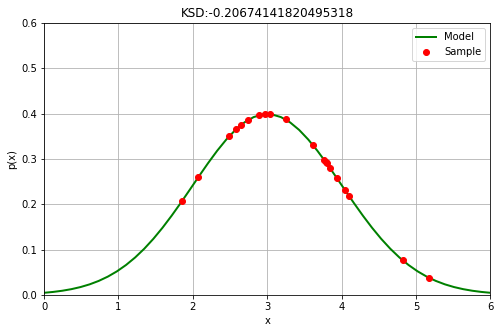

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


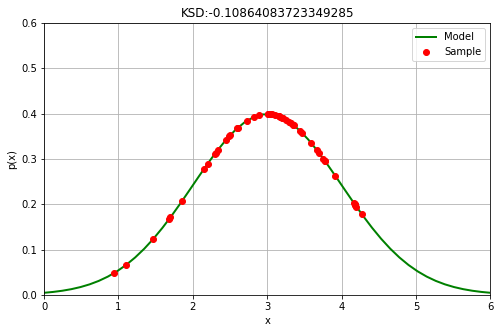

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


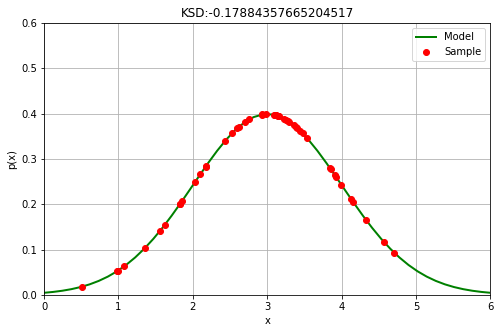

In [ ]:
# Example:
n_1 = 20; n_2 = 50;
Q_1 = np.random.normal(3,1,n_1);Q_2 = np.random.normal(3,1,n_2)

imq_kernel = Kernel("IMQ",l = 0.7)
model = Mixture_Gaussian(kernel = imq_kernel,mu = 3, sigma = 1)

ksd_value_1 = model.compute_KSD_with_Q(Q_1)
ksd_value_2 = model.compute_KSD_with_Q(Q_2)
print(ksd_value_1,ksd_value_2)

u = 3;sig = 1
plot_normal_case(u,sig,n_1,ksd_value_1)
plot_normal_case(u,sig,n_2,ksd_value_2)

Q_3 = np.random.normal(0,1,n_2)
ksd_value_3 = model.compute_KSD_with_Q(Q_3)
plot_normal_case(u,sig,n_2,ksd_value_3)


## Experiment with Galaxy Dataset

MLE for mu and sigma: 5.307407629915382e-16 2.0


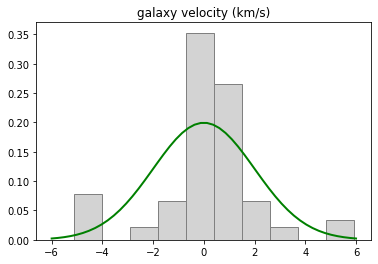

In [ ]:
def normal_pdf(x,u,sig):
  return np.exp(-(x - u) ** 2 / (2 * sig ** 2)) / (math.sqrt(2*math.pi)*sig)

def random_normal_data(n,u,sig):
  X = np.random.normal(u,sig,n)
  Y = [normal_pdf(i,u,sig) for i in X]
  return [X,Y]

def plot_normal_case(u,sig,n,ksd_value):
  [nx,ny] = random_normal_data(n,u,sig)
  x = np.linspace(u - 3*sig, u + 3*sig, 50); y = [normal_pdf(i,u,sig) for i in x]

  plt.figure(num=3,figsize=(8,5))
  plt.xlabel('x')
  plt.ylabel('p(x)')
  plt.xlim((0,6))
  plt.ylim((0,0.6))

  l1 = plt.plot(x, y, "g", linewidth=2) #draw the density of the model P
  l2 = plt.plot(nx,ny,'o',color = 'r') #draw the data point Q
  plt.title("KSD:%s"%(ksd_value))
  plt.legend([l1,l2],labels=["Model","Sample"],loc='best')
  plt.grid(True)
  plt.show()

galaxy_data = np.array([9.172,9.350,9.483,9.558,9.775,10.227,10.406,16.084,16.170,18.419,
18.552,18.600,18.927,19.052,19.070,19.330,19.343,19.349,19.440,19.473,
19.529,19.541,19.547,19.663,19.846,19.856,19.863,19.914,19.918,19.973,
19.989,20.166,20.175,20.179,20.196,20.215,20.221,20.415,20.629,20.795,
20.821,20.846,20.875,20.986,21.137,21.492,21.701,21.814,21.921,21.960,
22.185,22.209,22.242,22.249,22.314,22.374,22.495,22.746,22.747,22.888,
22.914,23.206,23.241,23.263,23.484,23.538,23.542,23.666,23.706,23.711,
24.129,24.285,24.289,24.366,24.717,24.990,25.633,26.960,26.995,32.065,
32.789,34.279])*1000

galaxy_data = (galaxy_data-np.mean(galaxy_data))/(0.5*np.std(galaxy_data))
# Use a Gaussian model:
mle_u = np.mean(galaxy_data);mle_sig = np.std(galaxy_data)
print("MLE for mu and sigma:",mle_u,mle_sig)

x = np.linspace(mle_u - 3*mle_sig, mle_u + 3*mle_sig, 50); y = [normal_pdf(i,mle_u,mle_sig) for i in x]
plt.plot(x, y, "g", linewidth=2) #draw the density of the model P
plt.hist(galaxy_data,color = "lightgrey", ec="grey",density = True)

plt.title("galaxy velocity (km/s)") 
plt.show()

In [ ]:
# Kernelized Exponential family Model Setting
class Kernel_exponential():
  def __init__(self,kernel,p):
    self.b = lambda x: -1*anp.log(float(np.sqrt(2*anp.pi*9)))-1*(x**2/2*9) #log(q(x))
    self.diff_b = elementwise_grad(self.b)
    self.phi = lambda x,i: x**(i-1)/(anp.sqrt(float(np.math.factorial(i-1))) * anp.exp(-1*x**2/2))
    self.diff_phi = elementwise_grad(self.phi)
    self.kernel = kernel
    self.p = p


  def compute_diff_t(self,x_value):#return a px1 vector
    p = self.p
    diff_t = np.array([self.diff_phi(x_value,i+1) for i in range(p)])
    return diff_t.reshape(-1,1)

  def Lambda_function(self,x_value,y_value):
    compute_diff_t = self.compute_diff_t
    p = self.p
    a = compute_diff_t(x_value)
    b = compute_diff_t(y_value).reshape(1,-1)
    return self.kernel.compute_kernel(x_value,y_value,0) * np.dot(a,b)


  def v_function(self,x_value,y_value):
    kernel = self.kernel; p = self.p
    compute_diff_t = self.compute_diff_t
    a = kernel.compute_kernel(x_value,y_value,0) * self.diff_b(x_value)* compute_diff_t(y_value)
    b = compute_diff_t(x_value) * kernel.compute_kernel(x_value,y_value,2)
    c = kernel.compute_kernel(x_value,y_value,0) * self.diff_b(y_value) * compute_diff_t(y_value)
    d = compute_diff_t(y_value) * kernel.compute_kernel(x_value,y_value,1)
    return a+b+c+d
  

  def theta_star(self,R):# ouput is a vector
    kernel = self.kernel; p = self.p
    Lambda_function = self.Lambda_function; v_function = self.v_function
    n = R.shape[0] 
    vn = np.zeros(p).reshape(-1,1)
    lambda_n = np.zeros(p*p).reshape(p,p)
    epsilon = 0 * np.eye(p).reshape(p,p)
    for i in range(n):
      for j in range(n):
        lambda_n = lambda_n + Lambda_function(R[i],R[j])
        vn = vn + v_function(R[i],R[j])
    lambda_n = lambda_n/(n**2)
    lambda_n = np.asarray(lambda_n, dtype=np.float64)
    lambda_n = np.linalg.inv(lambda_n + epsilon) #Add epsilon to Avoid Singular matrix 
    vn = vn/(n**2)
    result = (-0.5) * np.dot(lambda_n,vn)
    print("Finish compute the theta_star")
    return result.reshape(p,).astype(np.float64)

In [ ]:
class importance_sampling():
  def __init__(self,theta):
    self.theta = theta
    
  @staticmethod
  def phi(i,x):
    return x**(i-1) / np.sqrt(np.math.factorial(i-1)) * np.exp(-1*x**2/2)

  @staticmethod
  def q_0(x):
    return 1/np.sqrt(2*np.pi**9) * np.exp(-1*x**2/(2*9)) # N(0,3^2)
  
  def f(self,x):
    p = self.theta.size
    phi_i = np.array([self.phi(i,x) for i in range(1,p+1)])
    return np.dot(phi_i,self.theta)
  
  def p_0(self,x):
    return self.q_0(x) * np.exp(self.f(x))
  
  def w(self,x):
    return self.p_0(x)/self.q_0(x)


  def cal_z(self,sample):
    n = sample.size
    w_x = np.array([self.w(x) for x in sample])
    f_x = np.array([self.f(x) for x in sample])
    res = np.dot(w_x,f_x)/np.sum(w_x)
    return res


In [ ]:
R = galaxy_data #load the normalized data
imq_kernel = Kernel("simple_IMQ",l = 0.9) # choose a kernel
P = Kernel_exponential(kernel = imq_kernel, p = 5) #estimate the parameter
theta_hat = P.theta_star(R) # estimate the paramter
print(theta_hat) # print the estimated parameter 

Finish compute the theta_star
[ 1.84611612e-02  6.13752619e-04 -1.72906272e-03 -5.24886502e-05
  9.99439120e-05]


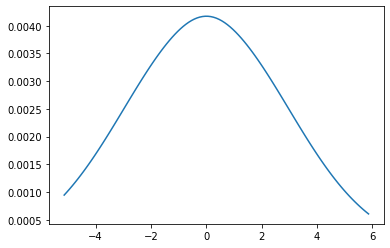

In [ ]:
theta_hat = np.array([1.84611752e-02,6.13753154e-04,-1.72906405e-03,-5.24886961e-05,9.99439905e-05]) 
model = importance_sampling(theta_hat)
X = np.arange(min(galaxy_data),max(galaxy_data),0.1)
Y = np.array([model.p_0(i) for i in X])
plt.plot(X,Y)

In [ ]:
Z = importance_sampling(theta_hat).cal_z(R) #calculate the normalized term
print(Z)

In [ ]:
X = np.arange(-6,7,0.1)
model.f(x)
# plt.plot(X,exp_f)

array([ 2.20785595e-11,  3.11327969e-11,  4.13176034e-11,  4.99373978e-11,
        5.05780077e-11,  2.99094668e-11, -3.76303650e-11, -1.98370614e-10,
       -5.32662320e-10, -1.17480504e-09, -2.34202630e-09, -4.37517238e-09,
       -7.79366588e-09, -1.33664457e-08, -2.21985008e-08, -3.58285181e-08,
       -5.63261467e-08, -8.63663010e-08, -1.29241522e-07, -1.88750449e-07,
       -2.68869915e-07, -3.73079713e-07, -5.03163319e-07, -6.57257071e-07,
       -8.26868969e-07, -9.92543406e-07, -1.11781992e-06, -1.14113542e-06,
       -9.65365859e-07, -4.44810867e-07,  6.30390481e-07,  2.55215232e-06,
        5.71401865e-06,  1.06313518e-05,  1.79605520e-05,  2.85151993e-05,
        4.32765183e-05,  6.33951937e-05,  9.01813891e-05,  1.25079939e-04,
        1.69628168e-04,  2.25394702e-04,  2.93898973e-04,  3.76512855e-04,
        4.74347925e-04,  5.88133967e-04,  7.18096447e-04,  8.63842386e-04,
        1.02426518e-03,  1.19747914e-03,  1.38079377e-03,  1.57073580e-03,
        1.76312402e-03,  

In [ ]:
X = np.arange(-6,7,0.1)
model = importance_sampling(theta_hat)
p_exact = np.array([model.p_0(x) for x in X])
plt.plot(x,p_exact)

NameError: ignored

In [ ]:
#Use a Kernelized Exponential Fmaily Model:
def kernel_exp_gof(data,a_kernel,p,b):
  # min_ksd_theta = theta_star(data,a_kernel,p)
  min_ksd_theta = [[2.895215780130537e-07],
  [-7.70763288806006e-06, 1.8721202581490014e-06],
  [3.614763403076565e-05, 3.5991936893657248e-06, -3.404469663785114e-06],
  [-9.493533448967639e-05, 3.3025087884386295e-05, 8.343893843409944e-06, -3.7691586390886656e-06],
  [0.0027952558550623507, 0.00020141587246058634, -0.0004734136204689321, -2.429436080131353e-05, 3.693794201087286e-05]]

  P = Kernelized_Exponential_Family(imq_kernel,theta = min_ksd_theta[p-1], p = p)
  result = goodness_of_fit_test(P,data,"wild_bootstrap",b = b)
  return result


time_start = time.time()
#Parameter:
imq_kernel = Kernel("IMQ",l = 0.9)
p_set = np.array([1,2,3,4,5])
theta_result = [0,0,0,0,0] 
b = 1000 #bootstrap times


for i in range(len(p_set)):   
  kernel_exp_gof(galaxy_data,imq_kernel,p_set[i],b)
# delta_result = kernel_exp_gof(galaxy_data,imq_kernel,p_set[1],b)

time_end = time.time()
print('time cost', time_end - time_start,'s')

100%|██████████| 1000/1000 [00:00<00:00, 1563.86it/s]


c_alpha =  0.007415205642748695
Delta =  -0.10739798790054914
P_value: 1.000
Test result: Accept the Null


100%|██████████| 1000/1000 [00:00<00:00, 1589.11it/s]


c_alpha =  0.008205641172280195
Delta =  -0.10739820893335017
P_value: 1.000
Test result: Accept the Null


100%|██████████| 1000/1000 [00:00<00:00, 1600.80it/s]


c_alpha =  0.0073922688178617215
Delta =  -0.10739698813232733
P_value: 1.000
Test result: Accept the Null


100%|██████████| 1000/1000 [00:00<00:00, 1506.05it/s]


c_alpha =  0.006995776708042432
Delta =  -0.10740068521467516
P_value: 1.000
Test result: Accept the Null


100%|██████████| 1000/1000 [00:00<00:00, 1556.92it/s]

c_alpha =  0.007411685206229437
Delta =  -0.10731965827877679
P_value: 1.000
Test result: Accept the Null
time cost 192.24952244758606 s


(array([ 2.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  2.,  1.,  2.,  5.,  7.,
         8., 13.,  9., 15., 29., 30., 23., 41., 46., 68., 76., 84., 81.,
        66., 63., 73., 52., 38., 29., 22., 19., 21., 14., 11.,  6., 11.,
         7.,  4.,  4.,  4.,  3.,  1.,  1.,  0.,  0.,  3.,  3.]),
 array([-1.97381539e-02, -1.89770060e-02, -1.82158581e-02, -1.74547102e-02,
        -1.66935623e-02, -1.59324144e-02, -1.51712665e-02, -1.44101186e-02,
        -1.36489707e-02, -1.28878228e-02, -1.21266749e-02, -1.13655270e-02,
        -1.06043791e-02, -9.84323115e-03, -9.08208325e-03, -8.32093535e-03,
        -7.55978745e-03, -6.79863955e-03, -6.03749164e-03, -5.27634374e-03,
        -4.51519584e-03, -3.75404794e-03, -2.99290004e-03, -2.23175214e-03,
        -1.47060424e-03, -7.09456337e-04,  5.16915640e-05,  8.12839465e-04,
         1.57398737e-03,  2.33513527e-03,  3.09628317e-03,  3.85743107e-03,
         4.61857897e-03,  5.37972687e-03,  6.14087477e-03,  6.90202267e-03,
         7.66317057e-03,  8.4243

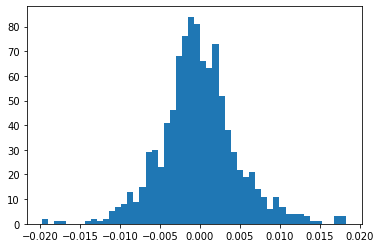

In [ ]:
# plt.hist(delta_result,50)


In [ ]:
[2.895215780130537e-07]
[-7.70763288806006e-06, 1.8721202581490014e-06]
[3.614763403076565e-05, 3.5991936893657248e-06, -3.404469663785114e-06]
[-9.493533448967639e-05, 3.3025087884386295e-05, 8.343893843409944e-06, -3.7691586390886656e-06]
[0.0027952558550623507, 0.00020141587246058634, -0.0004734136204689321, -2.429436080131353e-05, 3.693794201087286e-05]


### Other Code

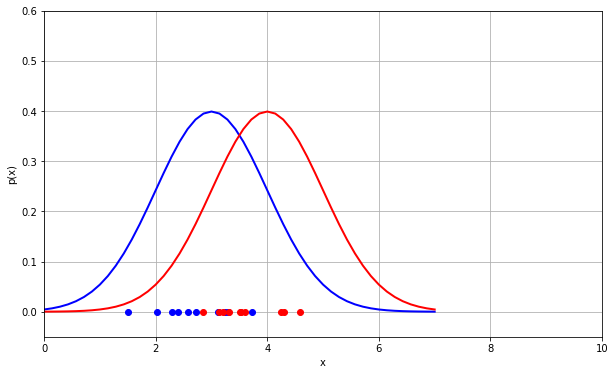

In [ ]:
u = 3;sig = 1
n = 10
[nx,ny] = random_normal_data(n,u,sig) #sample of P
[nx1,ny1] = random_normal_data(n,u+1,sig) #sample of Q

x = np.linspace(u - 3*sig, u + 4*sig, 50); y = [normal_pdf(i,u,sig) for i in x]
x1 = np.linspace(u - 3*sig, u + 4*sig, 50); y1 = [normal_pdf(i,u+1,sig) for i in x]

zeros = np.zeros(n)


plt.figure(num=3,figsize=(10,6))
plt.xlabel('x')
plt.ylabel('p(x)')
plt.xlim((0,10))
plt.ylim((-0.05,0.6))

l1 = plt.plot(x, y, "b", linewidth=2) #draw the density of the model P
l2 = plt.plot(x1, y1, "r", linewidth=2) #draw the density of the model Q
p1 = plt.plot(nx,zeros,'o',color = 'b') #draw the data point P
p2 = plt.plot(nx1,zeros,'o',color = 'r') #draw the data point Q
# plt.title("KSD:%s"%(ksd_value))
# plt.legend([l1,l2],labels=["Model","Sample"],loc='best')
plt.grid(True)
plt.show()

In [ ]:
from abc import abstractmethod
class Kernel(object): #X: nx x d, Y: ny x d
  @abstractmethod
  def eval(self,X,Y): #return nx x ny Gram matrix
    pass
  
  @abstractmethod
  def pair_eval(self,X,Y): #Evaluate k(x1, y1), k(x2, y2)，return a 1d numpy array of length n.
    pass

class KSTKernel(Kernel): #Return a numpy array of size nx x ny.
  @abstractmethod
  def gradX_Y(self,X,Y,dim):
    raise NotImplementedError()
  
  @abstractmethod
  def gradY_X(self,X,Y,dim): 
    raise NotImplementedError()
  
  @abstractmethod
  def gradXY_sum(self,X,Y,dim): #二阶导：K(X,Y)对X求导再对Y求导
    raise NotImplementedError()

class DifferentiableKernel(Kernel):
  def gradX_y(self,X,y):
    yrow = np.reshape(y,(1,-1))
    f = lambda X: self.eval(X,yrow)
    g = autograd.elemntwise_grad(f)
    G = g(X)
    assert G.shape[0] == X.shape[0]
    assert G.shape[1] == X.shape[1]
    return G

0.603530425973847